## 1. Libraries 📖

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch_geometric.data import InMemoryDataset
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader as GraphDataLoader
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.nn import GCNConv, Sequential as GraphSequential
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

from sklearn import metrics
from rdkit import Chem
import matplotlib.pyplot as plt
from tqdm import tqdm

## 2. Load data 📊

In [2]:
df_train = pd.read_csv("../../data/train/caco/caco_smiles_train.csv")
df_test = pd.read_csv("../../data/train/caco/caco_smiles_test.csv")
df_valid = pd.read_csv("../../data/train/caco/caco_smiles_valid.csv")
df_train_all = pd.concat([df_train, df_valid])

In [3]:
df_test

smiles  permeability
0    COc1cc(Nc2nc3n(n2)C(C)CC(=O)N3Cc2ccccc2)ccc1-n...        22.000
1    Cc1ccc(Nc2c(-c3ccc(F)cc3)nc3n2CCN(C(=O)C(C)(C)...         0.960
2           CN(C)C1CCC(Nc2ncnc3[nH]cc(C4CCOCC4)c23)CC1         0.700
3    CCOC(=O)C(Cc1ccc(-c2c(C(F)(F)F)cc(C)n(C)c2=O)c...       271.000
4     CC(C)c1cccc(Nc2nc3cc(Oc4ccnc(C(N)=O)c4)ccc3o2)c1        10.000
..                                                 ...           ...
699     Cc1cc(-c2nc(N)[nH]c(=O)c2Cl)cc(C#N)c1OCC1CCOC1         2.100
700  CCOC(=O)c1cc(C#N)c(N2CCN(C(=O)NS(=O)(=O)c3ccc(...         0.053
701                        C=C(c1ccccc1)C1OCC(N)C(C)O1        10.250
702  CCCC(=O)c1cnn(-c2ccc(NC(=O)c3cn(CC(=O)N4CCN(Cc...        17.000
703  CC(C)(C)NC(=O)C1CC2CCCCC2CN1CC(O)C(Cc1ccccc1)N...         3.200

[704 rows x 2 columns]

In [4]:
df_valid

smiles  permeability
0    CCOC(=O)c1cc(C#N)c(N2CCN(C(=O)NS(=O)(=O)c3ccc(...         0.076
1    Cn1cncc1CN1CC(N(CC2CCN(C(=O)C(C)(C)C)CC2)S(=O)...         0.500
2    NC1=NC(c2cccc(-c3cncnc3)c2)(c2ccnc(C(F)F)c2)c2...        27.000
3    COC(=O)NC(C(=O)NN(CCCC1(Cc2ccccc2)C(=O)N(C2c3c...         3.400
4    COC1CC2OCC2(OC(C)=O)C2C(OC(=O)c3ccccc3)C3(O)CC...        33.110
..                                                 ...           ...
346             COc1cccc(-c2cccc(C3(C)N=C(N)CCO3)c2)c1        13.000
347  O=C(NC1CC1)c1ccc(O)cc1OCC(O)CN1CCC2(CC1)Cc1cc(...        12.000
348  O=C(NC1(C(=O)NC(Cc2ccccc2)C(=O)NCC2CCN(CC3CCOC...         0.800
349  Cc1nc(NC(=O)N2CCCC2C(N)=O)sc1-c1ccnc(C(C)(C)C(...        18.300
350  CN(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(=O)...         1.200

[351 rows x 2 columns]

## 3. Metrics

In [5]:
def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square, '\n')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

## 4. Featurizer 🧪

In [6]:
# Feauterizer from course "Machine Learning in Drug Design" at Jagiellonian University, Kraków, Poland.

class Featurizer:
    def __init__(self, y_column, **kwargs):
        self.y_column = y_column
        self.__dict__.update(kwargs)
    
    def __call__(self, df):
        raise NotImplementedError()

def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise ValueError("input {0} not in allowable set{1}:".format(
            x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))


def one_of_k_encoding_unk(x, allowable_set):
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))
        

class GraphFeaturizer(Featurizer):
    def __call__(self, df):
        graphs = []
        labels = []
        for i, row in df.iterrows():
            y = row[self.y_column]
            smiles = row.smiles
            mol = Chem.MolFromSmiles(smiles)
            
            edges = []
            for bond in mol.GetBonds():
                edges.append([bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()])
                edges.append([bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()])
            edges = np.array(edges)
            
            nodes = []
            for atom in mol.GetAtoms():
                results = one_of_k_encoding_unk(
                    atom.GetSymbol(),
                    [
                        'Br', 'C', 'Cl', 'F', 'H', 'I', 'N', 'O', 'P', 'S', 'Unknown'
                    ]
                ) + one_of_k_encoding(
                    atom.GetDegree(),
                    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
                ) + one_of_k_encoding_unk(
                    atom.GetImplicitValence(),
                    [0, 1, 2, 3, 4, 5, 6]
                ) + [atom.GetFormalCharge(), atom.GetNumRadicalElectrons()] + one_of_k_encoding_unk(
                    atom.GetHybridization(),
                    [
                        Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2,
                        Chem.rdchem.HybridizationType.SP3, Chem.rdchem.HybridizationType.SP3D,
                        Chem.rdchem.HybridizationType.SP3D2
                    ]
                ) + [atom.GetIsAromatic()] + one_of_k_encoding_unk(
                    atom.GetTotalNumHs(),
                    [0, 1, 2, 3, 4]
                )
                nodes.append(results)
            nodes = np.array(nodes)
            
            graphs.append((nodes, edges.T))
            labels.append(y)
        labels = np.array(labels)
        return graphs, labels

## 5. Graph Dataset

In [7]:
class GraphDataset(InMemoryDataset):  
    def __init__(self, X, y, root, transform=None, pre_transform=None):
        self.dataset = (X, y)
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return ['data.pt']

    @property
    def processed_file_names(self):
        return ['data.pt']

    def download(self):
        x_g, edge_index_g =list(zip(*self.dataset[0]))

        data = [Data(
            x=torch.FloatTensor(x),
            edge_index=torch.LongTensor(edge_index),
            y = y) for x, edge_index, y in zip(x_g,edge_index_g,self.dataset[1])
        ]

        torch.save(data, self.raw_paths[0])


    def process(self):
        data_list = torch.load(self.raw_paths[0])

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])
        


In [8]:
featurizer = GraphFeaturizer(y_column='permeability')

X_train, y_train = featurizer(df_train)
X_test, y_test = featurizer(df_test)
X_valid, y_valid = featurizer(df_valid)
X_train_all, y_train_all = featurizer(df_train_all)

In [9]:
train_dataset = GraphDataset(X_train_all, y_train_all.reshape(-1, 1), root='caco-train')
test_dataset = GraphDataset(X_test, y_test.reshape(-1, 1), root='caco-test')
valid_dataset = GraphDataset(X_valid, y_valid.reshape(-1, 1), root='caco-valid')
train_dataset_small = GraphDataset(X_train, y_train.reshape(-1, 1), root='caco-train_small')

Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!


# 6. Model

![Graph](images/graph_net.png)

In [10]:
class GraphNeuralNetwork(torch.nn.Module):
    def __init__(self):
        super(GraphNeuralNetwork, self).__init__()
        torch.manual_seed(42)
        self.final_conv_acts = None
        self.final_conv_grads = None

        self.conv1 = GCNConv(42, 100)
        self.conv2 = GCNConv(100, 400)
        self.conv3 = GCNConv(400, 200)
        self.conv4 = GCNConv(200, 100)

        self.out = nn.Linear(100, 50)
        self.out2 = nn.Linear(50, 1)
    
    def activations_hook(self, grad):
        self.final_conv_grads = grad

    def forward(self, x, edge_index, batch_index):
        out = self.conv1(x, edge_index)
        out = F.relu(out)
        out = self.conv2(out, edge_index)
        out = F.relu(out)
        out = self.conv3(out, edge_index)
        out = F.relu(out)
        out = F.dropout(out, training=self.training) #p=0.5
        
        with torch.enable_grad():
            self.final_conv_acts = self.conv4(out, edge_index)
        self.final_conv_acts.register_hook(self.activations_hook)
        
        out = F.relu(self.final_conv_acts)
        out = gap(out, batch_index) # global_mean_pool
        out = self.out(out)
        out = F.relu(out)
        out = self.out2(out)

        return out

## 6.1 Grid search 🔎

In [12]:
lrs = [0.005, 0.01, 0.02]
batch_sizes = [16, 32, 64]

In [13]:
best_value = 1000
best_params = {'lr': None, 'batch_size': None, 'epoch': None, 'train_loss': None, 'test_loss': None,'train_acc': None,'test_acc': None}
train_losses_all = []
test_losses_all = []
train_accs_all = []
test_accs_all = []

for lr in lrs:
    for batch_size in batch_sizes:

        model = GraphNeuralNetwork()

        train_loader = GraphDataLoader(train_dataset_small, batch_size=batch_size, shuffle=False)
        valid_loader = GraphDataLoader(valid_dataset, batch_size=351, shuffle=False)

        epochs = 300
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr)

        train_losses = []
        test_losses = []
        train_accs = []
        test_accs = []

        print('Model: lr {}, batch_size {}'.format(lr, batch_size))

        for epoch in range(1, epochs + 1):

            print('################## EPOCH {} ##################'.format(epoch))

            model.train()
            train_correct = 0
            train_loss = 0

            for data in tqdm(train_loader, leave=False):
                x, edge_index, batch, y = data.x, data.edge_index, data.batch, data.y
                optimizer.zero_grad()
                output = model(x, edge_index, batch)
                loss = criterion(output, torch.Tensor(y))
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                train_correct += metrics.r2_score(y, output.cpu().detach().numpy())   

            train_loss /= len(train_loader)
            train_losses.append(train_loss)
            train_acc = train_correct/len(train_loader)
            train_accs.append(train_acc)
            print('Train Avg. loss: {}, Accuracy: {}'.format(train_loss, train_acc))

            model.eval()

            test_loss = 0
            test_correct = 0    

            with torch.no_grad():
                for data in tqdm(valid_loader):
                    x, edge_index, batch, y = data.x, data.edge_index, data.batch, data.y
                    output = model(x, edge_index, batch)
                    test_loss += criterion(output, torch.Tensor(y)).item()
                    test_correct += metrics.r2_score(y, output.cpu().detach().numpy())

            test_loss /= len(valid_loader)
            test_losses.append(test_loss)
            test_acc =test_correct/len(valid_loader)
            test_accs.append(test_acc)

            if test_loss<best_value:
                best_value = test_loss
                best_params['lr'] = lr
                best_params['batch_size'] = batch_size
                best_params['epoch'] = epoch
                best_params['train_loss'] = train_loss
                best_params['test_loss'] = test_loss
                best_params['train_acc'] = train_acc
                best_params['test_acc'] = test_acc 
            print('Test Avg. loss: {}, Accuracy: {}'.format(test_loss, test_acc))

        train_losses_all.append(train_losses)
        test_losses_all.append(test_losses)
        train_accs_all.append(train_accs)
        test_accs_all.append(test_accs)

print(best_params)

  1%|▏         | 2/154 [00:00<00:08, 17.72it/s]

Model: lr 0.005, batch_size 16
################## EPOCH 1 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 883.3664054127482, Accuracy: -0.3021033934504069


  3%|▎         | 4/154 [00:00<00:04, 32.84it/s]

Test Avg. loss: 915.1810302734375, Accuracy: 0.009987370283988772
################## EPOCH 2 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 855.977307381568, Accuracy: -0.26581562215780563


  2%|▏         | 3/154 [00:00<00:05, 25.20it/s]

Test Avg. loss: 898.53857421875, Accuracy: 0.027990591549299282
################## EPOCH 3 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 840.3465940797483, Accuracy: -0.22939051643093397


  2%|▏         | 3/154 [00:00<00:05, 28.95it/s]

Test Avg. loss: 887.9178466796875, Accuracy: 0.03947982143077722
################## EPOCH 4 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 833.3118862300724, Accuracy: -0.2218646116750153


  2%|▏         | 3/154 [00:00<00:05, 29.70it/s]

Test Avg. loss: 881.156005859375, Accuracy: 0.04679452741130952
################## EPOCH 5 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 822.1966230714476, Accuracy: -0.22146913025416562


  2%|▏         | 3/154 [00:00<00:05, 29.67it/s]

Test Avg. loss: 863.1370239257812, Accuracy: 0.06628686240938864
################## EPOCH 6 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 813.711926522193, Accuracy: -0.22381076869679203


  2%|▏         | 3/154 [00:00<00:05, 28.18it/s]

Test Avg. loss: 848.6068115234375, Accuracy: 0.08200512636248225
################## EPOCH 7 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 801.570269299792, Accuracy: -0.22850199859172246


  2%|▏         | 3/154 [00:00<00:05, 29.66it/s]

Test Avg. loss: 826.5014038085938, Accuracy: 0.10591811733568501
################## EPOCH 8 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 790.8888671429127, Accuracy: -0.265823168570656


  2%|▏         | 3/154 [00:00<00:05, 28.70it/s]

Test Avg. loss: 776.6197509765625, Accuracy: 0.15987846823673013
################## EPOCH 9 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 776.7596079591033, Accuracy: -0.284801628518489


  2%|▏         | 3/154 [00:00<00:05, 29.70it/s]

Test Avg. loss: 725.6441650390625, Accuracy: 0.21502201826927236
################## EPOCH 10 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 768.4749375628187, Accuracy: -0.3189450775281788


  2%|▏         | 3/154 [00:00<00:05, 29.39it/s]

Test Avg. loss: 682.8543090820312, Accuracy: 0.26131073120966186
################## EPOCH 11 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 744.9418881156228, Accuracy: -0.35244169165020484


  2%|▏         | 3/154 [00:00<00:05, 28.50it/s]

Test Avg. loss: 634.7094116210938, Accuracy: 0.3133922711794138
################## EPOCH 12 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 742.1146259803277, Accuracy: -0.39988459217113614


  3%|▎         | 4/154 [00:00<00:04, 31.65it/s]

Test Avg. loss: 632.2813110351562, Accuracy: 0.3160190099743846
################## EPOCH 13 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 712.9020874221603, Accuracy: -0.362058038705093


  2%|▏         | 3/154 [00:00<00:05, 29.33it/s]

Test Avg. loss: 566.0902099609375, Accuracy: 0.3876223034872589
################## EPOCH 14 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 693.9703536343264, Accuracy: -0.4510229021410084


  2%|▏         | 3/154 [00:00<00:05, 28.88it/s]

Test Avg. loss: 613.4530029296875, Accuracy: 0.33638684540918473
################## EPOCH 15 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 678.9923239868957, Accuracy: -0.2159286536422533


  2%|▏         | 3/154 [00:00<00:05, 26.96it/s]

Test Avg. loss: 565.12451171875, Accuracy: 0.3886669840457794
################## EPOCH 16 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 658.6185404789912, Accuracy: -0.32245041285102144


  2%|▏         | 3/154 [00:00<00:05, 27.80it/s]

Test Avg. loss: 529.9705810546875, Accuracy: 0.4266953366588997
################## EPOCH 17 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 618.4703981969263, Accuracy: -0.22594775364825873


  2%|▏         | 3/154 [00:00<00:05, 25.52it/s]

Test Avg. loss: 578.24609375, Accuracy: 0.3744725322872794
################## EPOCH 18 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 608.990813515403, Accuracy: -0.2065517763287007


  2%|▏         | 3/154 [00:00<00:05, 29.80it/s]

Test Avg. loss: 492.5975036621094, Accuracy: 0.46712426679555774
################## EPOCH 19 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 601.3673645118614, Accuracy: -0.2429133452705007


  2%|▏         | 3/154 [00:00<00:05, 29.05it/s]

Test Avg. loss: 523.2542114257812, Accuracy: 0.4339608588017656
################## EPOCH 20 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 674.5967422336727, Accuracy: -0.24393780616399238


  3%|▎         | 4/154 [00:00<00:04, 30.61it/s]

Test Avg. loss: 684.2716064453125, Accuracy: 0.2597776226758476
################## EPOCH 21 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 641.8150306305328, Accuracy: -0.6344965211260696


  2%|▏         | 3/154 [00:00<00:05, 27.11it/s]

Test Avg. loss: 490.3971252441406, Accuracy: 0.469504567334426
################## EPOCH 22 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 603.7469660028235, Accuracy: -0.32913451069696253


  2%|▏         | 3/154 [00:00<00:06, 24.34it/s]

Test Avg. loss: 535.7684936523438, Accuracy: 0.4204232234272447
################## EPOCH 23 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 549.2463860202146, Accuracy: -0.1729317835093964


  3%|▎         | 4/154 [00:00<00:04, 35.91it/s]

Test Avg. loss: 570.208251953125, Accuracy: 0.3831675469556345
################## EPOCH 24 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 553.5647331089168, Accuracy: -0.33377805351172635


  2%|▏         | 3/154 [00:00<00:05, 27.46it/s]

Test Avg. loss: 594.7538452148438, Accuracy: 0.3566149484658837
################## EPOCH 25 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 550.1324344734093, Accuracy: -0.27696327461065434


  2%|▏         | 3/154 [00:00<00:05, 26.52it/s]

Test Avg. loss: 515.9259643554688, Accuracy: 0.4418883538936398
################## EPOCH 26 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 519.55293313559, Accuracy: -0.26900878733932193


  2%|▏         | 3/154 [00:00<00:05, 27.60it/s]

Test Avg. loss: 461.10919189453125, Accuracy: 0.5011872585002978
################## EPOCH 27 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 541.743284324547, Accuracy: -0.2541041436001222


  2%|▏         | 3/154 [00:00<00:05, 29.28it/s]

Test Avg. loss: 556.872314453125, Accuracy: 0.397593902580078
################## EPOCH 28 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 668.5536459637926, Accuracy: -0.2561487957923309


  2%|▏         | 3/154 [00:00<00:06, 25.04it/s]

Test Avg. loss: 559.9633178710938, Accuracy: 0.3942501656413109
################## EPOCH 29 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 680.5916599670014, Accuracy: -0.5435332507213408


  3%|▎         | 4/154 [00:00<00:04, 32.87it/s]

Test Avg. loss: 692.6943359375, Accuracy: 0.2506662277980093
################## EPOCH 30 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 636.9295429130653, Accuracy: -0.2549297044811926


  3%|▎         | 4/154 [00:00<00:04, 30.79it/s]

Test Avg. loss: 731.3694458007812, Accuracy: 0.20882870488505312
################## EPOCH 31 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 558.6432562493659, Accuracy: -0.18153077619110003


  2%|▏         | 3/154 [00:00<00:05, 28.95it/s]

Test Avg. loss: 736.7487182617188, Accuracy: 0.20300961443667043
################## EPOCH 32 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 655.8029890679694, Accuracy: -0.4473559510073939


  2%|▏         | 3/154 [00:00<00:05, 28.69it/s]

Test Avg. loss: 561.5822143554688, Accuracy: 0.39249887470154543
################## EPOCH 33 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 536.8140606818262, Accuracy: -0.32469144246894777


  2%|▏         | 3/154 [00:00<00:05, 28.07it/s]

Test Avg. loss: 724.128173828125, Accuracy: 0.21666203028994457
################## EPOCH 34 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 569.296276860423, Accuracy: -0.22226844965992923


  2%|▏         | 3/154 [00:00<00:05, 26.56it/s]

Test Avg. loss: 691.7258911132812, Accuracy: 0.2517137831222528
################## EPOCH 35 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 563.8940204025863, Accuracy: -0.29340295855093734


  2%|▏         | 3/154 [00:00<00:05, 28.35it/s]

Test Avg. loss: 583.3226318359375, Accuracy: 0.36898081514151027
################## EPOCH 36 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 511.24783188956127, Accuracy: -0.45308299234848604


  3%|▎         | 4/154 [00:00<00:05, 29.98it/s]

Test Avg. loss: 480.6977233886719, Accuracy: 0.4799969923926737
################## EPOCH 37 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 498.89896719796315, Accuracy: -0.3514872755858936


  2%|▏         | 3/154 [00:00<00:05, 28.11it/s]

Test Avg. loss: 571.7738647460938, Accuracy: 0.38147388311614083
################## EPOCH 38 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 525.8022080458604, Accuracy: -0.6305478624495627


  2%|▏         | 3/154 [00:00<00:05, 27.00it/s]

Test Avg. loss: 497.7431335449219, Accuracy: 0.46155792887748703
################## EPOCH 39 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 503.68490055629184, Accuracy: -0.37006798904425714


  2%|▏         | 3/154 [00:00<00:05, 27.71it/s]

Test Avg. loss: 615.4874877929688, Accuracy: 0.3341858820843121
################## EPOCH 40 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 531.6483324967421, Accuracy: -0.48814741278801704


  2%|▏         | 3/154 [00:00<00:05, 29.35it/s]

Test Avg. loss: 551.8796997070312, Accuracy: 0.40299477143460805
################## EPOCH 41 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 589.4298412025748, Accuracy: -0.4833329656806667


  2%|▏         | 3/154 [00:00<00:05, 28.74it/s]

Test Avg. loss: 444.3334655761719, Accuracy: 0.5193347939266932
################## EPOCH 42 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 480.09970531215913, Accuracy: -0.25356191841119563


  2%|▏         | 3/154 [00:00<00:05, 28.67it/s]

Test Avg. loss: 509.81414794921875, Accuracy: 0.44849987700355987
################## EPOCH 43 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 481.61209913972135, Accuracy: -0.3031937960586273


  3%|▎         | 4/154 [00:00<00:04, 30.57it/s]

Test Avg. loss: 506.4114685058594, Accuracy: 0.4521808308076458
################## EPOCH 44 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 502.4110763847054, Accuracy: -0.21633327717365555


  2%|▏         | 3/154 [00:00<00:05, 25.48it/s]

Test Avg. loss: 574.6532592773438, Accuracy: 0.37835913182918246
################## EPOCH 45 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 506.51845283012887, Accuracy: -0.3620430185366666


  2%|▏         | 3/154 [00:00<00:05, 29.40it/s]

Test Avg. loss: 423.11993408203125, Accuracy: 0.5422828147989203
################## EPOCH 46 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 515.3943707354657, Accuracy: -0.34253826357345457


  2%|▏         | 3/154 [00:00<00:05, 28.91it/s]

Test Avg. loss: 362.135498046875, Accuracy: 0.6082537648783708
################## EPOCH 47 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 480.61242207613856, Accuracy: -0.28137428072437853


  2%|▏         | 3/154 [00:00<00:05, 28.75it/s]

Test Avg. loss: 403.765625, Accuracy: 0.5632196449343188
################## EPOCH 48 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 466.17058033138125, Accuracy: -0.32574354677023376


  3%|▎         | 4/154 [00:00<00:04, 30.73it/s]

Test Avg. loss: 800.0013427734375, Accuracy: 0.13458499883173292
################## EPOCH 49 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 491.33913082271425, Accuracy: -0.3143100337385137


  2%|▏         | 3/154 [00:00<00:05, 27.29it/s]

Test Avg. loss: 630.827880859375, Accuracy: 0.3175913158555592
################## EPOCH 50 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 482.6286114531678, Accuracy: -0.48567501120989554


  2%|▏         | 3/154 [00:00<00:05, 29.05it/s]

Test Avg. loss: 406.65069580078125, Accuracy: 0.560098707440591
################## EPOCH 51 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 484.92070443289623, Accuracy: -0.40071842344238584


  2%|▏         | 3/154 [00:00<00:05, 28.41it/s]

Test Avg. loss: 430.5385437011719, Accuracy: 0.5342575606420181
################## EPOCH 52 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 469.1033244938045, Accuracy: -0.4008326722368716


  3%|▎         | 4/154 [00:00<00:04, 31.42it/s]

Test Avg. loss: 472.24932861328125, Accuracy: 0.48913632575781607
################## EPOCH 53 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 471.76443575574206, Accuracy: -0.2722278443752568


  2%|▏         | 3/154 [00:00<00:05, 27.37it/s]

Test Avg. loss: 386.5286560058594, Accuracy: 0.5818660699843883
################## EPOCH 54 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 453.51779553797337, Accuracy: -0.19964519946179443


  3%|▎         | 4/154 [00:00<00:04, 31.13it/s]

Test Avg. loss: 456.9930114746094, Accuracy: 0.5056400594160646
################## EPOCH 55 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 448.4947651949796, Accuracy: -0.1807798037107518


  2%|▏         | 3/154 [00:00<00:05, 28.89it/s]

Test Avg. loss: 396.62152099609375, Accuracy: 0.5709479282370323
################## EPOCH 56 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 469.24038527847887, Accuracy: -0.27413556346580176


  2%|▏         | 3/154 [00:00<00:05, 27.85it/s]

Test Avg. loss: 622.1156005859375, Accuracy: 0.32701588358143596
################## EPOCH 57 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 470.25116043586235, Accuracy: -0.22035047152102727


  2%|▏         | 3/154 [00:00<00:05, 28.19it/s]

Test Avg. loss: 404.7552490234375, Accuracy: 0.5621491612532529
################## EPOCH 58 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 476.02324500641265, Accuracy: -0.3467037648413523


  2%|▏         | 3/154 [00:00<00:05, 27.30it/s]

Test Avg. loss: 460.43780517578125, Accuracy: 0.5019135487373876
################## EPOCH 59 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 470.3718129195176, Accuracy: -0.22245826193418314


  3%|▎         | 4/154 [00:00<00:04, 32.14it/s]

Test Avg. loss: 532.2656860351562, Accuracy: 0.4242125400897616
################## EPOCH 60 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 643.7945760008577, Accuracy: -0.3853023652210935


  2%|▏         | 3/154 [00:00<00:05, 28.86it/s]

Test Avg. loss: 606.6355590820312, Accuracy: 0.343761710465066
################## EPOCH 61 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 553.5380528685334, Accuracy: -0.1357250532388355


  3%|▎         | 4/154 [00:00<00:04, 31.22it/s]

Test Avg. loss: 687.6369018554688, Accuracy: 0.25613702879524536
################## EPOCH 62 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 524.009627503234, Accuracy: -0.2576637979683637


  2%|▏         | 3/154 [00:00<00:05, 29.65it/s]

Test Avg. loss: 809.1636352539062, Accuracy: 0.12467345578461098
################## EPOCH 63 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 460.84578769237964, Accuracy: -0.254597229223364


  2%|▏         | 3/154 [00:00<00:05, 29.61it/s]

Test Avg. loss: 472.22332763671875, Accuracy: 0.4891644304477373
################## EPOCH 64 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 471.53594334094555, Accuracy: -0.30268467879298416


  2%|▏         | 3/154 [00:00<00:05, 29.62it/s]

Test Avg. loss: 442.7832946777344, Accuracy: 0.5210116591753222
################## EPOCH 65 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 473.4872114008123, Accuracy: -0.14835440508165354


  2%|▏         | 3/154 [00:00<00:05, 27.70it/s]

Test Avg. loss: 454.4761962890625, Accuracy: 0.5083626408481638
################## EPOCH 66 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 486.3107505649715, Accuracy: -0.3543988392337204


  3%|▎         | 4/154 [00:00<00:04, 31.99it/s]

Test Avg. loss: 394.5744323730469, Accuracy: 0.5731624386124223
################## EPOCH 67 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 467.3236774840912, Accuracy: -0.34503279329476777


  2%|▏         | 3/154 [00:00<00:05, 29.68it/s]

Test Avg. loss: 380.5915832519531, Accuracy: 0.588288567758268
################## EPOCH 68 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 458.4298825945173, Accuracy: -0.24033965448714462


  2%|▏         | 3/154 [00:00<00:05, 26.93it/s]

Test Avg. loss: 401.9905700683594, Accuracy: 0.5651398297363677
################## EPOCH 69 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 453.33953748430525, Accuracy: -0.19617474406601168


  2%|▏         | 3/154 [00:00<00:05, 28.58it/s]

Test Avg. loss: 392.2503967285156, Accuracy: 0.5756764689342639
################## EPOCH 70 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 450.74137712453864, Accuracy: -0.2072596126207573


  2%|▏         | 3/154 [00:00<00:05, 28.96it/s]

Test Avg. loss: 346.2865295410156, Accuracy: 0.625398670788496
################## EPOCH 71 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 434.60360970435204, Accuracy: -0.16636804558536133


  2%|▏         | 3/154 [00:00<00:05, 27.71it/s]

Test Avg. loss: 339.2705993652344, Accuracy: 0.6329882569561268
################## EPOCH 72 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 444.11189049559755, Accuracy: -0.1840610021838951


  2%|▏         | 3/154 [00:00<00:05, 25.93it/s]

Test Avg. loss: 432.0028991699219, Accuracy: 0.5326735630404682
################## EPOCH 73 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 467.0927368510853, Accuracy: -0.21071872162997407


  3%|▎         | 4/154 [00:00<00:04, 31.38it/s]

Test Avg. loss: 478.92449951171875, Accuracy: 0.48191528920814464
################## EPOCH 74 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 427.525720026586, Accuracy: -0.14213944197354328


  2%|▏         | 3/154 [00:00<00:05, 27.65it/s]

Test Avg. loss: 301.8804626464844, Accuracy: 0.6734356517220558
################## EPOCH 75 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 445.1634586136062, Accuracy: -0.09572671104843049


  2%|▏         | 3/154 [00:00<00:05, 28.26it/s]

Test Avg. loss: 408.3779296875, Accuracy: 0.5582302249363518
################## EPOCH 76 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 448.7589739514636, Accuracy: -0.1848512026285264


  2%|▏         | 3/154 [00:00<00:05, 26.08it/s]

Test Avg. loss: 440.0977478027344, Accuracy: 0.5239167610011861
################## EPOCH 77 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 437.5879237682788, Accuracy: -0.027873169726594108


  2%|▏         | 3/154 [00:00<00:05, 28.35it/s]

Test Avg. loss: 349.63116455078125, Accuracy: 0.6217805849852758
################## EPOCH 78 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 426.51842521072984, Accuracy: -0.12213455280861975


  2%|▏         | 3/154 [00:00<00:05, 26.32it/s]

Test Avg. loss: 480.3841552734375, Accuracy: 0.4803362129095555
################## EPOCH 79 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 416.5547539104115, Accuracy: -0.19691212324646862


  2%|▏         | 3/154 [00:00<00:05, 26.98it/s]

Test Avg. loss: 315.47503662109375, Accuracy: 0.6587294933750516
################## EPOCH 80 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 418.28343309674943, Accuracy: -0.16669413845672526


  2%|▏         | 3/154 [00:00<00:05, 29.46it/s]

Test Avg. loss: 355.3276062011719, Accuracy: 0.6156183445608443
################## EPOCH 81 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 406.3256635294332, Accuracy: -0.2236378995813185


  2%|▏         | 3/154 [00:00<00:05, 28.06it/s]

Test Avg. loss: 343.8507385253906, Accuracy: 0.6280336249473789
################## EPOCH 82 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 430.04505858483253, Accuracy: -0.07820925169720552


  2%|▏         | 3/154 [00:00<00:05, 29.85it/s]

Test Avg. loss: 551.4395751953125, Accuracy: 0.40347097413017197
################## EPOCH 83 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 509.9181109341708, Accuracy: -0.36768362318065556


  2%|▏         | 3/154 [00:00<00:05, 27.45it/s]

Test Avg. loss: 334.00311279296875, Accuracy: 0.6386864580230786
################## EPOCH 84 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 433.1475718857406, Accuracy: -0.10379533504396926


  2%|▏         | 3/154 [00:00<00:05, 29.15it/s]

Test Avg. loss: 462.9638977050781, Accuracy: 0.4991809799542144
################## EPOCH 85 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 394.57900317303546, Accuracy: -0.22335107322176656


  2%|▏         | 3/154 [00:00<00:05, 26.49it/s]

Test Avg. loss: 363.9915771484375, Accuracy: 0.606245951441669
################## EPOCH 86 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 404.1975513557335, Accuracy: -0.17856747629309888


  2%|▏         | 3/154 [00:00<00:05, 28.81it/s]

Test Avg. loss: 288.1564025878906, Accuracy: 0.6882819111600789
################## EPOCH 87 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 390.63992559755, Accuracy: -0.027798046435636582


  2%|▏         | 3/154 [00:00<00:05, 27.57it/s]

Test Avg. loss: 355.44989013671875, Accuracy: 0.6154860674706744
################## EPOCH 88 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 415.6593709177785, Accuracy: -0.2596690062291739


  2%|▏         | 3/154 [00:00<00:05, 26.18it/s]

Test Avg. loss: 554.1031494140625, Accuracy: 0.40058953339164294
################## EPOCH 89 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 373.94277822816525, Accuracy: 0.02598026756522082


  2%|▏         | 3/154 [00:00<00:05, 29.56it/s]

Test Avg. loss: 431.92303466796875, Accuracy: 0.5327599370631331
################## EPOCH 90 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 401.1261652909316, Accuracy: -0.08418926043369913


  2%|▏         | 3/154 [00:00<00:05, 27.79it/s]

Test Avg. loss: 403.4656677246094, Accuracy: 0.5635441671188339
################## EPOCH 91 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 385.64280923620447, Accuracy: -0.13405972297741225


  3%|▎         | 4/154 [00:00<00:05, 28.72it/s]

Test Avg. loss: 360.675537109375, Accuracy: 0.6098330664302909
################## EPOCH 92 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 374.90070003658144, Accuracy: -0.07108743902317465


  2%|▏         | 3/154 [00:00<00:05, 27.75it/s]

Test Avg. loss: 431.8210144042969, Accuracy: 0.5328703185243577
################## EPOCH 93 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 396.39456151987054, Accuracy: -0.08815621093086184


  2%|▏         | 3/154 [00:00<00:05, 28.27it/s]

Test Avg. loss: 424.0568542480469, Accuracy: 0.541269340754622
################## EPOCH 94 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 388.8777196809843, Accuracy: 0.006002018842582454


  3%|▎         | 4/154 [00:00<00:04, 30.25it/s]

Test Avg. loss: 401.1500244140625, Accuracy: 0.5660491614467567
################## EPOCH 95 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 396.5500096655511, Accuracy: -0.07970484915472158


  3%|▎         | 4/154 [00:00<00:04, 31.37it/s]

Test Avg. loss: 587.04833984375, Accuracy: 0.3649504654350143
################## EPOCH 96 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 398.8603012778542, Accuracy: 0.003412626200366112


  3%|▎         | 4/154 [00:00<00:04, 31.36it/s]

Test Avg. loss: 380.1739807128906, Accuracy: 0.5887403383948016
################## EPOCH 97 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 432.5501831104229, Accuracy: 0.024260765161071462


  2%|▏         | 3/154 [00:00<00:05, 27.16it/s]

Test Avg. loss: 566.8516235351562, Accuracy: 0.3867986650124515
################## EPOCH 98 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 398.3970158316872, Accuracy: -0.2142824607139031


  2%|▏         | 3/154 [00:00<00:05, 29.68it/s]

Test Avg. loss: 327.7294006347656, Accuracy: 0.6454731936040314
################## EPOCH 99 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 390.4885921725979, Accuracy: 0.053031835666182144


  3%|▎         | 4/154 [00:00<00:04, 30.66it/s]

Test Avg. loss: 369.525390625, Accuracy: 0.6002596175740262
################## EPOCH 100 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 381.8803990351689, Accuracy: -0.41955479749493235


  2%|▏         | 3/154 [00:00<00:05, 27.43it/s]

Test Avg. loss: 295.70819091796875, Accuracy: 0.6801126950097051
################## EPOCH 101 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 385.97302312974807, Accuracy: 0.012496003166274992


  2%|▏         | 3/154 [00:00<00:05, 25.99it/s]

Test Avg. loss: 362.21917724609375, Accuracy: 0.6081632445228864
################## EPOCH 102 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 416.8164600025524, Accuracy: -0.25786774205512714


  2%|▏         | 3/154 [00:00<00:05, 28.42it/s]

Test Avg. loss: 403.5989074707031, Accuracy: 0.5633999947315342
################## EPOCH 103 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 359.04164438123826, Accuracy: -0.036344809565061725


  2%|▏         | 3/154 [00:00<00:05, 28.41it/s]

Test Avg. loss: 395.4822082519531, Accuracy: 0.572180447466731
################## EPOCH 104 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 360.511298489261, Accuracy: 0.05150220449047142


  2%|▏         | 3/154 [00:00<00:05, 28.86it/s]

Test Avg. loss: 390.3423156738281, Accuracy: 0.5777405725093898
################## EPOCH 105 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 388.42833130080976, Accuracy: -0.25199452995569377


  2%|▏         | 3/154 [00:00<00:05, 27.85it/s]

Test Avg. loss: 297.3792724609375, Accuracy: 0.6783049246245137
################## EPOCH 106 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 383.9714890764905, Accuracy: -0.03193844214718219


  2%|▏         | 3/154 [00:00<00:05, 28.94it/s]

Test Avg. loss: 371.81707763671875, Accuracy: 0.5977805046442202
################## EPOCH 107 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 381.963364786916, Accuracy: 0.0321345247436493


  2%|▏         | 3/154 [00:00<00:06, 24.89it/s]

Test Avg. loss: 343.51763916015625, Accuracy: 0.6283939830190675
################## EPOCH 108 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 390.2183728651567, Accuracy: -0.007215653937424339


  2%|▏         | 3/154 [00:00<00:05, 29.37it/s]

Test Avg. loss: 459.77349853515625, Accuracy: 0.5026321796683975
################## EPOCH 109 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 377.09601949716546, Accuracy: -0.10066996433692568


  2%|▏         | 3/154 [00:00<00:05, 29.72it/s]

Test Avg. loss: 337.55267333984375, Accuracy: 0.6348466832322163
################## EPOCH 110 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 383.8215428389512, Accuracy: -0.0776633522922121


  2%|▏         | 3/154 [00:00<00:05, 26.64it/s]

Test Avg. loss: 340.0379943847656, Accuracy: 0.6321581119788704
################## EPOCH 111 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 387.7090863314542, Accuracy: -0.1091389044435634


  2%|▏         | 3/154 [00:00<00:05, 28.94it/s]

Test Avg. loss: 514.8927001953125, Accuracy: 0.4430061336123875
################## EPOCH 112 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 370.453225940853, Accuracy: -0.12761640821798853


  2%|▏         | 3/154 [00:00<00:05, 28.29it/s]

Test Avg. loss: 368.1954650878906, Accuracy: 0.6016982854566914
################## EPOCH 113 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 357.27081440021465, Accuracy: 0.004557346223005677


  2%|▏         | 3/154 [00:00<00:05, 29.18it/s]

Test Avg. loss: 405.1884765625, Accuracy: 0.5616804703446598
################## EPOCH 114 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 359.1349767462, Accuracy: -0.008015442337124134


  2%|▏         | 3/154 [00:00<00:05, 26.78it/s]

Test Avg. loss: 352.37969970703125, Accuracy: 0.6188072877372847
################## EPOCH 115 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 366.40648438094496, Accuracy: -0.07121858207121796


  3%|▎         | 4/154 [00:00<00:04, 31.73it/s]

Test Avg. loss: 354.68804931640625, Accuracy: 0.6163102055442188
################## EPOCH 116 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 372.0898115480101, Accuracy: -0.25581487464154806


  2%|▏         | 3/154 [00:00<00:05, 28.54it/s]

Test Avg. loss: 411.05145263671875, Accuracy: 0.5553381096710069
################## EPOCH 117 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 337.79717428034, Accuracy: 0.09841798020874232


  2%|▏         | 3/154 [00:00<00:05, 29.88it/s]

Test Avg. loss: 439.48895263671875, Accuracy: 0.5245753843654933
################## EPOCH 118 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 392.35784783301415, Accuracy: -0.02182073303912036


  2%|▏         | 3/154 [00:00<00:06, 25.10it/s]

Test Avg. loss: 379.3801574707031, Accuracy: 0.5895990971470021
################## EPOCH 119 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 387.20620358454715, Accuracy: -0.044508200425477304


  2%|▏         | 3/154 [00:00<00:05, 28.61it/s]

Test Avg. loss: 402.8035888671875, Accuracy: 0.5642603750696178
################## EPOCH 120 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 348.2372611900429, Accuracy: -0.0385180131670447


  3%|▎         | 4/154 [00:00<00:04, 31.90it/s]

Test Avg. loss: 393.86383056640625, Accuracy: 0.5739310851936983
################## EPOCH 121 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 354.51773424272415, Accuracy: 0.047826149607751


  2%|▏         | 3/154 [00:00<00:05, 28.71it/s]

Test Avg. loss: 457.7478332519531, Accuracy: 0.5048235455645171
################## EPOCH 122 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 363.3345588832707, Accuracy: -0.028592236521290847


  2%|▏         | 3/154 [00:00<00:05, 28.30it/s]

Test Avg. loss: 387.9109191894531, Accuracy: 0.5803707714894328
################## EPOCH 123 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 334.5064221419297, Accuracy: 0.026728834749567162


  2%|▏         | 3/154 [00:00<00:06, 24.99it/s]

Test Avg. loss: 371.8426818847656, Accuracy: 0.5977528322927096
################## EPOCH 124 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 343.8981889501795, Accuracy: 0.08900388064444655


  2%|▏         | 3/154 [00:00<00:05, 28.17it/s]

Test Avg. loss: 337.2362365722656, Accuracy: 0.6351889997494828
################## EPOCH 125 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 350.3024354166799, Accuracy: 0.0591418097586971


  2%|▏         | 3/154 [00:00<00:05, 26.33it/s]

Test Avg. loss: 355.89593505859375, Accuracy: 0.6150035312433408
################## EPOCH 126 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 340.07139079601734, Accuracy: -0.06306736831152722


  2%|▏         | 3/154 [00:00<00:05, 27.10it/s]

Test Avg. loss: 326.1550598144531, Accuracy: 0.6471762390677096
################## EPOCH 127 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 338.6134877019114, Accuracy: 0.017381666020760654


  2%|▏         | 3/154 [00:00<00:05, 29.27it/s]

Test Avg. loss: 321.9886474609375, Accuracy: 0.6516832997519646
################## EPOCH 128 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 338.70747770581926, Accuracy: 0.07818125952903351


  2%|▏         | 3/154 [00:00<00:05, 27.16it/s]

Test Avg. loss: 411.44256591796875, Accuracy: 0.5549150233560696
################## EPOCH 129 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 349.1001317655885, Accuracy: 0.07347094268569844


  2%|▏         | 3/154 [00:00<00:05, 28.41it/s]

Test Avg. loss: 399.3231506347656, Accuracy: 0.5680254336898215
################## EPOCH 130 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 341.18646651429015, Accuracy: 0.09655733814756935


  2%|▏         | 3/154 [00:00<00:05, 28.52it/s]

Test Avg. loss: 625.0899047851562, Accuracy: 0.3237983732817371
################## EPOCH 131 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 358.48251431948177, Accuracy: -0.12304130493913729


  3%|▎         | 4/154 [00:00<00:04, 36.86it/s]

Test Avg. loss: 339.37542724609375, Accuracy: 0.6328748359167276
################## EPOCH 132 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 366.45267811069243, Accuracy: 0.047588087619821515


  2%|▏         | 3/154 [00:00<00:05, 29.86it/s]

Test Avg. loss: 468.62274169921875, Accuracy: 0.4930594123449572
################## EPOCH 133 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 338.5142880476914, Accuracy: 0.09201182461825479


  2%|▏         | 3/154 [00:00<00:05, 28.80it/s]

Test Avg. loss: 403.51263427734375, Accuracy: 0.563493305834268
################## EPOCH 134 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 341.07593038484646, Accuracy: 0.06919137892451703


  2%|▏         | 3/154 [00:00<00:05, 26.53it/s]

Test Avg. loss: 343.8026428222656, Accuracy: 0.6280856595044304
################## EPOCH 135 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 358.00337595753854, Accuracy: -0.0006822973048450509


  2%|▏         | 3/154 [00:00<00:05, 29.15it/s]

Test Avg. loss: 384.2480773925781, Accuracy: 0.5843331152547465
################## EPOCH 136 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 329.7712697363519, Accuracy: 0.0317722032232088


  2%|▏         | 3/154 [00:00<00:05, 26.13it/s]

Test Avg. loss: 410.3600769042969, Accuracy: 0.5560860082330328
################## EPOCH 137 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 330.78009206598455, Accuracy: 0.059175071891101765


  2%|▏         | 3/154 [00:00<00:05, 28.63it/s]

Test Avg. loss: 269.36798095703125, Accuracy: 0.7086066040671023
################## EPOCH 138 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 378.13181084471864, Accuracy: 0.007394502266856958


  3%|▎         | 4/154 [00:00<00:04, 31.23it/s]

Test Avg. loss: 611.6136474609375, Accuracy: 0.3383765497940866
################## EPOCH 139 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 333.78171027790415, Accuracy: 0.013549156298806153


  2%|▏         | 3/154 [00:00<00:05, 25.32it/s]

Test Avg. loss: 393.17578125, Accuracy: 0.5746754157849605
################## EPOCH 140 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 323.02936177439506, Accuracy: 0.10112950542203818


  2%|▏         | 3/154 [00:00<00:05, 29.83it/s]

Test Avg. loss: 436.2242126464844, Accuracy: 0.5281070032200081
################## EPOCH 141 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 313.24834040852335, Accuracy: 0.023078073486378657


  2%|▏         | 3/154 [00:00<00:05, 28.80it/s]

Test Avg. loss: 338.0191345214844, Accuracy: 0.6343420818905384
################## EPOCH 142 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 338.2912768079089, Accuracy: -0.05531626509889334


  2%|▏         | 3/154 [00:00<00:05, 27.41it/s]

Test Avg. loss: 356.8512878417969, Accuracy: 0.6139700407700946
################## EPOCH 143 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 324.3021882292512, Accuracy: 0.09866544640222703


  3%|▎         | 4/154 [00:00<00:04, 32.20it/s]

Test Avg. loss: 384.7921142578125, Accuracy: 0.5837445614652517
################## EPOCH 144 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 337.5567604535586, Accuracy: 0.07106121526751655


  2%|▏         | 3/154 [00:00<00:05, 27.85it/s]

Test Avg. loss: 348.01837158203125, Accuracy: 0.6235252759637853
################## EPOCH 145 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 326.6524455206735, Accuracy: 0.09221761327969887


  2%|▏         | 3/154 [00:00<00:05, 28.46it/s]

Test Avg. loss: 412.4844665527344, Accuracy: 0.553787923311804
################## EPOCH 146 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 314.29145104544506, Accuracy: 0.10294288640409772


  2%|▏         | 3/154 [00:00<00:05, 27.06it/s]

Test Avg. loss: 367.7897644042969, Accuracy: 0.6021371679838259
################## EPOCH 147 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 314.8904512578791, Accuracy: 0.039336726961483784


  2%|▏         | 3/154 [00:00<00:05, 27.53it/s]

Test Avg. loss: 392.871826171875, Accuracy: 0.5750041890072584
################## EPOCH 148 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 315.156225080614, Accuracy: 0.039726742760919705


  2%|▏         | 3/154 [00:00<00:05, 28.49it/s]

Test Avg. loss: 319.6801452636719, Accuracy: 0.6541805818996191
################## EPOCH 149 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 311.88357709909417, Accuracy: 0.1445346607797407


  2%|▏         | 3/154 [00:00<00:05, 26.79it/s]

Test Avg. loss: 439.0599670410156, Accuracy: 0.5250394338640538
################## EPOCH 150 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 339.0189598628453, Accuracy: 0.03661967689556096


  2%|▏         | 3/154 [00:00<00:05, 27.74it/s]

Test Avg. loss: 348.411376953125, Accuracy: 0.6231001019396566
################## EPOCH 151 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 327.79741365259343, Accuracy: 0.19308241491674794


  2%|▏         | 3/154 [00:00<00:05, 27.74it/s]

Test Avg. loss: 380.22216796875, Accuracy: 0.5886881917728852
################## EPOCH 152 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 321.6492226340554, Accuracy: 0.02547021312847783


  3%|▎         | 4/154 [00:00<00:04, 32.32it/s]

Test Avg. loss: 314.8529968261719, Accuracy: 0.6594023908237414
################## EPOCH 153 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 321.5825076412845, Accuracy: 0.11215548900278073


  3%|▎         | 4/154 [00:00<00:04, 31.71it/s]

Test Avg. loss: 298.6916809082031, Accuracy: 0.6768852235150118
################## EPOCH 154 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 364.9839138303484, Accuracy: -0.26180131631412373


  2%|▏         | 3/154 [00:00<00:05, 28.07it/s]

Test Avg. loss: 266.6951904296875, Accuracy: 0.7114979625397653
################## EPOCH 155 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 328.6982632426473, Accuracy: -0.1087720705135417


  3%|▎         | 4/154 [00:00<00:04, 30.90it/s]

Test Avg. loss: 381.1040344238281, Accuracy: 0.5877342591745234
################## EPOCH 156 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 313.0589464856433, Accuracy: 0.14142226502003435


  2%|▏         | 3/154 [00:00<00:05, 27.41it/s]

Test Avg. loss: 347.4627380371094, Accuracy: 0.6241262563829371
################## EPOCH 157 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 308.1958098225779, Accuracy: 0.07609836809996463


  2%|▏         | 3/154 [00:00<00:05, 27.18it/s]

Test Avg. loss: 343.0064392089844, Accuracy: 0.6289469942066994
################## EPOCH 158 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 328.13835440053566, Accuracy: 0.06683506397356927


  2%|▏         | 3/154 [00:00<00:05, 29.90it/s]

Test Avg. loss: 337.9748840332031, Accuracy: 0.6343899442411106
################## EPOCH 159 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 325.56011447658784, Accuracy: 0.12595617083878993


  2%|▏         | 3/154 [00:00<00:05, 27.33it/s]

Test Avg. loss: 361.3702087402344, Accuracy: 0.6090815813844195
################## EPOCH 160 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 305.79063868832276, Accuracy: 0.1400944110726761


  2%|▏         | 3/154 [00:00<00:05, 28.16it/s]

Test Avg. loss: 340.5021057128906, Accuracy: 0.631656063285833
################## EPOCH 161 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 329.3086842623624, Accuracy: 0.05892162911780781


  2%|▏         | 3/154 [00:00<00:05, 26.45it/s]

Test Avg. loss: 334.5121154785156, Accuracy: 0.6381358429933806
################## EPOCH 162 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 313.4169034586324, Accuracy: 0.08182833686468456


  2%|▏         | 3/154 [00:00<00:05, 29.20it/s]

Test Avg. loss: 455.65472412109375, Accuracy: 0.5070877634498709
################## EPOCH 163 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 296.5671609779457, Accuracy: 0.10249768663200029


  2%|▏         | 3/154 [00:00<00:05, 28.20it/s]

Test Avg. loss: 383.37982177734375, Accuracy: 0.5852723920079901
################## EPOCH 164 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 427.239633634493, Accuracy: -0.031099350589837278


  2%|▏         | 3/154 [00:00<00:05, 29.51it/s]

Test Avg. loss: 329.8289794921875, Accuracy: 0.6432018918398023
################## EPOCH 165 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 322.5689357039216, Accuracy: 0.1032357258761436


  2%|▏         | 3/154 [00:00<00:05, 29.75it/s]

Test Avg. loss: 377.9529113769531, Accuracy: 0.5911430116186613
################## EPOCH 166 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 299.6155983070274, Accuracy: 0.1535392027429202


  2%|▏         | 3/154 [00:00<00:05, 28.31it/s]

Test Avg. loss: 385.17120361328125, Accuracy: 0.5833344943717038
################## EPOCH 167 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 331.4958102238643, Accuracy: 0.11406280080486549


  2%|▏         | 3/154 [00:00<00:05, 27.35it/s]

Test Avg. loss: 328.88836669921875, Accuracy: 0.6442194369824916
################## EPOCH 168 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 301.2265076823049, Accuracy: 0.11875816247413057


  3%|▎         | 4/154 [00:00<00:04, 30.10it/s]

Test Avg. loss: 363.4323425292969, Accuracy: 0.6068508917251738
################## EPOCH 169 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 314.94990397118903, Accuracy: 0.11809044531511434


  2%|▏         | 3/154 [00:00<00:05, 28.59it/s]

Test Avg. loss: 362.4906311035156, Accuracy: 0.6078696188942012
################## EPOCH 170 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 302.88440722923775, Accuracy: 0.13401478549145485


  2%|▏         | 3/154 [00:00<00:05, 29.23it/s]

Test Avg. loss: 364.3398132324219, Accuracy: 0.605869215673866
################## EPOCH 171 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 325.49962868628563, Accuracy: 0.006914895878081843


  2%|▏         | 3/154 [00:00<00:05, 29.53it/s]

Test Avg. loss: 386.2331848144531, Accuracy: 0.5821857189374582
################## EPOCH 172 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 380.26517550976246, Accuracy: -0.035140196939911224


  2%|▏         | 3/154 [00:00<00:05, 25.66it/s]

Test Avg. loss: 378.4036560058594, Accuracy: 0.5906553996043448
################## EPOCH 173 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 309.81263574377283, Accuracy: 0.13631545911892895


  2%|▏         | 3/154 [00:00<00:05, 27.89it/s]

Test Avg. loss: 364.0145568847656, Accuracy: 0.6062210556725683
################## EPOCH 174 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 306.39805417246635, Accuracy: 0.14511066793089297


  3%|▎         | 4/154 [00:00<00:04, 34.14it/s]

Test Avg. loss: 345.176025390625, Accuracy: 0.6265999965447563
################## EPOCH 175 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 302.59888748069864, Accuracy: 0.15086191382769049


  2%|▏         | 3/154 [00:00<00:05, 28.46it/s]

Test Avg. loss: 339.66351318359375, Accuracy: 0.6325631816419464
################## EPOCH 176 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 298.96437678399025, Accuracy: 0.09912683499004642


  2%|▏         | 3/154 [00:00<00:05, 28.18it/s]

Test Avg. loss: 364.40472412109375, Accuracy: 0.6057990016802391
################## EPOCH 177 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 310.30765622622005, Accuracy: 0.12307439560976158


  2%|▏         | 3/154 [00:00<00:05, 28.27it/s]

Test Avg. loss: 369.00341796875, Accuracy: 0.6008243210270756
################## EPOCH 178 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 299.2985138583493, Accuracy: 0.1382948517853637


  2%|▏         | 3/154 [00:00<00:05, 27.34it/s]

Test Avg. loss: 354.9281005859375, Accuracy: 0.616050497534921
################## EPOCH 179 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 302.5741092013074, Accuracy: 0.17961357093381536


  2%|▏         | 3/154 [00:00<00:05, 29.47it/s]

Test Avg. loss: 333.00640869140625, Accuracy: 0.6397646978790443
################## EPOCH 180 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 331.8117345215438, Accuracy: 0.06910847612047595


  2%|▏         | 3/154 [00:00<00:05, 29.28it/s]

Test Avg. loss: 318.98095703125, Accuracy: 0.6549369367394569
################## EPOCH 181 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 311.7680793365875, Accuracy: 0.08784654314585472


  2%|▏         | 3/154 [00:00<00:05, 28.13it/s]

Test Avg. loss: 358.3849792480469, Accuracy: 0.6123109509509181
################## EPOCH 182 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 285.1387571235756, Accuracy: 0.12758433427995317


  2%|▏         | 3/154 [00:00<00:05, 29.92it/s]

Test Avg. loss: 370.68719482421875, Accuracy: 0.599002841162894
################## EPOCH 183 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 316.50497188815825, Accuracy: 0.0494148944953842


  2%|▏         | 3/154 [00:00<00:05, 27.75it/s]

Test Avg. loss: 386.9628601074219, Accuracy: 0.5813963109911806
################## EPOCH 184 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 300.82106579124155, Accuracy: 0.10921793983235623


  2%|▏         | 3/154 [00:00<00:05, 27.75it/s]

Test Avg. loss: 363.8929748535156, Accuracy: 0.6063525951907457
################## EPOCH 185 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 328.34647614615307, Accuracy: 0.05241370206719373


  2%|▏         | 3/154 [00:00<00:05, 28.91it/s]

Test Avg. loss: 353.1503601074219, Accuracy: 0.6179735709764559
################## EPOCH 186 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 319.8570715297352, Accuracy: 0.08136030666160451


  2%|▏         | 3/154 [00:00<00:05, 27.98it/s]

Test Avg. loss: 326.93310546875, Accuracy: 0.646334572735606
################## EPOCH 187 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 298.28335093213366, Accuracy: 0.2179684987993284


  2%|▏         | 3/154 [00:00<00:05, 28.35it/s]

Test Avg. loss: 386.98175048828125, Accuracy: 0.581375943566393
################## EPOCH 188 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 294.4673905806108, Accuracy: 0.16374210576938947


  2%|▏         | 3/154 [00:00<00:05, 29.21it/s]

Test Avg. loss: 338.9466857910156, Accuracy: 0.6333386133585388
################## EPOCH 189 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 297.3661556615458, Accuracy: 0.055555798204755195


  3%|▎         | 4/154 [00:00<00:04, 32.02it/s]

Test Avg. loss: 334.7824401855469, Accuracy: 0.637843446892834
################## EPOCH 190 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 302.29542259117227, Accuracy: 0.21355734104383703


  2%|▏         | 3/154 [00:00<00:05, 27.93it/s]

Test Avg. loss: 423.0881042480469, Accuracy: 0.5423172242441245
################## EPOCH 191 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 297.2013706975169, Accuracy: 0.16446197766064227


  2%|▏         | 3/154 [00:00<00:05, 28.69it/s]

Test Avg. loss: 394.0076904296875, Accuracy: 0.573775437124532
################## EPOCH 192 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 303.277362129905, Accuracy: 0.17936419813465468


  2%|▏         | 3/154 [00:00<00:05, 28.87it/s]

Test Avg. loss: 326.9683837890625, Accuracy: 0.6462963822101127
################## EPOCH 193 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 308.51338237911074, Accuracy: 0.05706460424094284


  2%|▏         | 3/154 [00:00<00:05, 28.75it/s]

Test Avg. loss: 386.2674865722656, Accuracy: 0.5821485397248234
################## EPOCH 194 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 378.6404425881126, Accuracy: 0.02674494770504612


  2%|▏         | 3/154 [00:00<00:05, 27.04it/s]

Test Avg. loss: 307.7742919921875, Accuracy: 0.6670599185155921
################## EPOCH 195 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 299.57932991176455, Accuracy: 0.11353403770458625


  2%|▏         | 3/154 [00:00<00:05, 29.75it/s]

Test Avg. loss: 385.09765625, Accuracy: 0.5834140940560566
################## EPOCH 196 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 321.38259626363777, Accuracy: 0.03753118509519848


  3%|▎         | 4/154 [00:00<00:04, 32.74it/s]

Test Avg. loss: 357.58819580078125, Accuracy: 0.6131729340541314
################## EPOCH 197 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 297.23444112554773, Accuracy: 0.09708219536640876


  2%|▏         | 3/154 [00:00<00:05, 26.70it/s]

Test Avg. loss: 374.206298828125, Accuracy: 0.5951959939812126
################## EPOCH 198 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 286.1561954300125, Accuracy: 0.12783333400863606


  2%|▏         | 3/154 [00:00<00:05, 26.75it/s]

Test Avg. loss: 346.879150390625, Accuracy: 0.624757570318051
################## EPOCH 199 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 280.0385282566021, Accuracy: 0.20466940146595025


  2%|▏         | 3/154 [00:00<00:05, 29.42it/s]

Test Avg. loss: 393.8839111328125, Accuracy: 0.5739094223320376
################## EPOCH 200 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 280.49535729049086, Accuracy: 0.23141908778226333


  3%|▎         | 4/154 [00:00<00:04, 30.39it/s]

Test Avg. loss: 388.0464172363281, Accuracy: 0.5802241532129875
################## EPOCH 201 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 308.0959111374694, Accuracy: 0.11845485364895048


  2%|▏         | 3/154 [00:00<00:05, 29.11it/s]

Test Avg. loss: 419.59228515625, Accuracy: 0.5460989100314642
################## EPOCH 202 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 288.3528821747024, Accuracy: 0.20637851753853476


  2%|▏         | 3/154 [00:00<00:05, 28.96it/s]

Test Avg. loss: 330.4733581542969, Accuracy: 0.6425048171378236
################## EPOCH 203 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 301.3486825026475, Accuracy: 0.12763121833809807


  2%|▏         | 3/154 [00:00<00:05, 29.76it/s]

Test Avg. loss: 393.4303283691406, Accuracy: 0.5744000848009437
################## EPOCH 204 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 347.3614618871119, Accuracy: 0.08752294284456846


  2%|▏         | 3/154 [00:00<00:05, 27.95it/s]

Test Avg. loss: 363.8675537109375, Accuracy: 0.6063800541176181
################## EPOCH 205 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 306.7293473033162, Accuracy: 0.13563284564792


  2%|▏         | 3/154 [00:00<00:05, 29.91it/s]

Test Avg. loss: 356.50177001953125, Accuracy: 0.614348183886424
################## EPOCH 206 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 282.02270466940746, Accuracy: 0.21932851746643295


  2%|▏         | 3/154 [00:00<00:05, 29.74it/s]

Test Avg. loss: 417.6911926269531, Accuracy: 0.5481554683040487
################## EPOCH 207 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 314.8668956632738, Accuracy: 0.11481550698671203


  2%|▏         | 3/154 [00:00<00:05, 28.26it/s]

Test Avg. loss: 397.8016052246094, Accuracy: 0.5696713506935769
################## EPOCH 208 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 326.75945190330606, Accuracy: -0.13309710724787496


  2%|▏         | 3/154 [00:00<00:05, 28.35it/s]

Test Avg. loss: 362.2616882324219, Accuracy: 0.6081172895061067
################## EPOCH 209 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 307.63118865273213, Accuracy: 0.1919429353609183


  2%|▏         | 3/154 [00:00<00:05, 28.61it/s]

Test Avg. loss: 358.82464599609375, Accuracy: 0.6118353186069136
################## EPOCH 210 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 291.3129386034879, Accuracy: 0.1763783783119806


  2%|▏         | 3/154 [00:00<00:05, 29.15it/s]

Test Avg. loss: 392.0625, Accuracy: 0.57587975046237
################## EPOCH 211 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 326.5336391399433, Accuracy: 0.10503710312589594


  2%|▏         | 3/154 [00:00<00:05, 26.23it/s]

Test Avg. loss: 385.12615966796875, Accuracy: 0.5833832320725573
################## EPOCH 212 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 296.009723105988, Accuracy: 0.08218371800089043


  2%|▏         | 3/154 [00:00<00:05, 25.79it/s]

Test Avg. loss: 361.042236328125, Accuracy: 0.6094364145134334
################## EPOCH 213 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 292.15804860499, Accuracy: 0.2259852786514382


  2%|▏         | 3/154 [00:00<00:05, 27.65it/s]

Test Avg. loss: 389.2864074707031, Accuracy: 0.57888279566871
################## EPOCH 214 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 283.90731857349346, Accuracy: 0.18298217807186


  2%|▏         | 3/154 [00:00<00:05, 29.12it/s]

Test Avg. loss: 399.6302185058594, Accuracy: 0.5676931974142134
################## EPOCH 215 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 283.1375411145099, Accuracy: 0.20114235679460782


  2%|▏         | 3/154 [00:00<00:05, 26.75it/s]

Test Avg. loss: 366.5395202636719, Accuracy: 0.6034896149098116
################## EPOCH 216 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 273.85859124072186, Accuracy: 0.23258222489171598


  2%|▏         | 3/154 [00:00<00:05, 28.47it/s]

Test Avg. loss: 431.8569641113281, Accuracy: 0.5328313758528648
################## EPOCH 217 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 308.3996962634, Accuracy: 0.15631558123825645


  2%|▏         | 3/154 [00:00<00:05, 25.94it/s]

Test Avg. loss: 405.59112548828125, Accuracy: 0.5612449024318001
################## EPOCH 218 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 282.96267511937526, Accuracy: 0.20782167160501808


  2%|▏         | 3/154 [00:00<00:05, 26.17it/s]

Test Avg. loss: 603.2914428710938, Accuracy: 0.34737921825816553
################## EPOCH 219 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 286.32083970850164, Accuracy: 0.2042759969937156


  2%|▏         | 3/154 [00:00<00:05, 29.02it/s]

Test Avg. loss: 719.1221313476562, Accuracy: 0.22207737798087268
################## EPOCH 220 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 280.3826648414909, Accuracy: 0.2232641218870909


  2%|▏         | 3/154 [00:00<00:05, 27.14it/s]

Test Avg. loss: 346.4396667480469, Accuracy: 0.6252330125186581
################## EPOCH 221 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 276.93404175399183, Accuracy: 0.16711275175376322


  2%|▏         | 3/154 [00:00<00:05, 27.19it/s]

Test Avg. loss: 470.4105529785156, Accuracy: 0.4911253923242984
################## EPOCH 222 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 273.5639557900367, Accuracy: 0.21932574502560093


  3%|▎         | 4/154 [00:00<00:04, 32.54it/s]

Test Avg. loss: 459.68206787109375, Accuracy: 0.5027311497517116
################## EPOCH 223 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 302.34482012166603, Accuracy: 0.12777554301263236


  2%|▏         | 3/154 [00:00<00:05, 28.67it/s]

Test Avg. loss: 419.026611328125, Accuracy: 0.546710858744603
################## EPOCH 224 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 287.4939383593473, Accuracy: 0.20714317549439765


  2%|▏         | 3/154 [00:00<00:05, 27.19it/s]

Test Avg. loss: 421.3989562988281, Accuracy: 0.5441445428844116
################## EPOCH 225 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 291.0726752962385, Accuracy: 0.18683030140372087


  2%|▏         | 3/154 [00:00<00:05, 28.23it/s]

Test Avg. loss: 364.54559326171875, Accuracy: 0.605646619555193
################## EPOCH 226 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 304.42382074331306, Accuracy: 0.15014897222711035


  3%|▎         | 4/154 [00:00<00:04, 31.36it/s]

Test Avg. loss: 620.2653198242188, Accuracy: 0.32901744879874817
################## EPOCH 227 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 297.9378316309545, Accuracy: 0.23227077100135848


  3%|▎         | 4/154 [00:00<00:04, 31.71it/s]

Test Avg. loss: 406.5223388671875, Accuracy: 0.5602375499783234
################## EPOCH 228 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 324.9318470273699, Accuracy: 0.19052650495414566


  2%|▏         | 3/154 [00:00<00:05, 26.45it/s]

Test Avg. loss: 606.911376953125, Accuracy: 0.34346339402523274
################## EPOCH 229 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 316.3965100622796, Accuracy: 0.18738926567565384


  2%|▏         | 3/154 [00:00<00:05, 28.35it/s]

Test Avg. loss: 546.0362548828125, Accuracy: 0.4093159264980645
################## EPOCH 230 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 283.3685733250209, Accuracy: 0.23139879576145989


  2%|▏         | 3/154 [00:00<00:05, 27.99it/s]

Test Avg. loss: 439.2133483886719, Accuracy: 0.5248735382775154
################## EPOCH 231 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 266.7973293453068, Accuracy: 0.24886439600572996


  2%|▏         | 3/154 [00:00<00:05, 29.16it/s]

Test Avg. loss: 452.7810363769531, Accuracy: 0.5101964252956723
################## EPOCH 232 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 290.4644018767716, Accuracy: 0.14575636601548508


  2%|▏         | 3/154 [00:00<00:05, 27.86it/s]

Test Avg. loss: 413.4454345703125, Accuracy: 0.5527484008313001
################## EPOCH 233 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 281.0631536756243, Accuracy: 0.22821041458198246


  3%|▎         | 4/154 [00:00<00:04, 32.68it/s]

Test Avg. loss: 396.4166564941406, Accuracy: 0.5711695722373462
################## EPOCH 234 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 299.78827528520065, Accuracy: 0.04862345208658905


  2%|▏         | 3/154 [00:00<00:05, 27.83it/s]

Test Avg. loss: 376.5975646972656, Accuracy: 0.5926091332849642
################## EPOCH 235 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 275.08674020891067, Accuracy: 0.25417334845652967


  2%|▏         | 3/154 [00:00<00:05, 28.54it/s]

Test Avg. loss: 409.2955017089844, Accuracy: 0.5572376943934819
################## EPOCH 236 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 282.07731481031936, Accuracy: 0.2542389120331962


  2%|▏         | 3/154 [00:00<00:05, 25.63it/s]

Test Avg. loss: 415.9005432128906, Accuracy: 0.5500925113294963
################## EPOCH 237 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 264.17085681023536, Accuracy: 0.22831589114526074


  2%|▏         | 3/154 [00:00<00:05, 27.12it/s]

Test Avg. loss: 413.346435546875, Accuracy: 0.5528555000686527
################## EPOCH 238 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 268.928437616918, Accuracy: 0.20811499139985615


  2%|▏         | 3/154 [00:00<00:05, 29.65it/s]

Test Avg. loss: 405.65301513671875, Accuracy: 0.5611779684409761
################## EPOCH 239 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 295.7881624791529, Accuracy: 0.0931072870478141


  3%|▎         | 4/154 [00:00<00:04, 33.59it/s]

Test Avg. loss: 382.7224426269531, Accuracy: 0.5859835202418682
################## EPOCH 240 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 286.72545875202525, Accuracy: 0.2382061453198413


  2%|▏         | 3/154 [00:00<00:05, 27.94it/s]

Test Avg. loss: 412.0569763183594, Accuracy: 0.5542503693309431
################## EPOCH 241 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 276.60728196973923, Accuracy: 0.24669012794897946


  3%|▎         | 4/154 [00:00<00:04, 31.67it/s]

Test Avg. loss: 471.8686828613281, Accuracy: 0.4895480137194098
################## EPOCH 242 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 278.01311200624934, Accuracy: 0.1880236446334528


  2%|▏         | 3/154 [00:00<00:05, 29.94it/s]

Test Avg. loss: 387.1777648925781, Accuracy: 0.5811638841047384
################## EPOCH 243 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 269.93296586073836, Accuracy: 0.2045574679838151


  2%|▏         | 3/154 [00:00<00:05, 27.27it/s]

Test Avg. loss: 399.5616455078125, Accuracy: 0.5677674362508638
################## EPOCH 244 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 272.36759660151097, Accuracy: 0.28856425860929985


  2%|▏         | 3/154 [00:00<00:05, 26.70it/s]

Test Avg. loss: 442.0632629394531, Accuracy: 0.5217905207037743
################## EPOCH 245 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 265.284271227849, Accuracy: 0.2416762033476739


  2%|▏         | 3/154 [00:00<00:05, 27.35it/s]

Test Avg. loss: 412.0864562988281, Accuracy: 0.5542185113549538
################## EPOCH 246 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 288.3072671890259, Accuracy: 0.13452248540822326


  2%|▏         | 3/154 [00:00<00:05, 27.96it/s]

Test Avg. loss: 416.61566162109375, Accuracy: 0.5493189542187491
################## EPOCH 247 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 277.2077959357918, Accuracy: 0.22004850475536952


  2%|▏         | 3/154 [00:00<00:05, 28.96it/s]

Test Avg. loss: 410.40606689453125, Accuracy: 0.5560362667041405
################## EPOCH 248 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 271.64179026616085, Accuracy: 0.2656211996087288


  3%|▎         | 4/154 [00:00<00:04, 32.45it/s]

Test Avg. loss: 625.1973876953125, Accuracy: 0.3236820287757659
################## EPOCH 249 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 307.21667344229564, Accuracy: 0.21924700424790997


  2%|▏         | 3/154 [00:00<00:05, 25.75it/s]

Test Avg. loss: 422.11907958984375, Accuracy: 0.5433655267551287
################## EPOCH 250 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 276.8549666714359, Accuracy: 0.22307073305246175


  2%|▏         | 3/154 [00:00<00:05, 27.67it/s]

Test Avg. loss: 384.8656005859375, Accuracy: 0.5836651070892547
################## EPOCH 251 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 282.89381526352525, Accuracy: 0.18191620777447517


  3%|▎         | 4/154 [00:00<00:04, 32.24it/s]

Test Avg. loss: 463.8204345703125, Accuracy: 0.4982543821364591
################## EPOCH 252 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 274.521657274915, Accuracy: 0.23868558972575463


  2%|▏         | 3/154 [00:00<00:05, 29.05it/s]

Test Avg. loss: 464.3746337890625, Accuracy: 0.49765481588585414
################## EPOCH 253 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 281.47419300327056, Accuracy: 0.24081052733464853


  3%|▎         | 4/154 [00:00<00:04, 31.92it/s]

Test Avg. loss: 471.9940490722656, Accuracy: 0.4894124700332847
################## EPOCH 254 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 264.5533441816057, Accuracy: 0.23381356191523703


  2%|▏         | 3/154 [00:00<00:05, 28.86it/s]

Test Avg. loss: 399.7917175292969, Accuracy: 0.5675185657502674
################## EPOCH 255 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 259.2065095901489, Accuracy: 0.24576641018037634


  2%|▏         | 3/154 [00:00<00:05, 26.71it/s]

Test Avg. loss: 423.7720947265625, Accuracy: 0.5415773697644848
################## EPOCH 256 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 265.1893797292338, Accuracy: 0.26776253071269585


  2%|▏         | 3/154 [00:00<00:05, 27.70it/s]

Test Avg. loss: 483.36065673828125, Accuracy: 0.4771163418014409
################## EPOCH 257 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 290.74901972188576, Accuracy: 0.19465352715739018


  2%|▏         | 3/154 [00:00<00:05, 28.29it/s]

Test Avg. loss: 447.40924072265625, Accuracy: 0.516007472324951
################## EPOCH 258 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 253.9474888838731, Accuracy: 0.2945857760030384


  2%|▏         | 3/154 [00:00<00:05, 27.29it/s]

Test Avg. loss: 422.01007080078125, Accuracy: 0.5434834242557849
################## EPOCH 259 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 286.60227124102704, Accuracy: 0.21811621657386066


  3%|▎         | 4/154 [00:00<00:04, 32.02it/s]

Test Avg. loss: 451.0941162109375, Accuracy: 0.5120212645585454
################## EPOCH 260 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 270.6519965382365, Accuracy: 0.2266669202855079


  3%|▎         | 4/154 [00:00<00:04, 30.87it/s]

Test Avg. loss: 419.11279296875, Accuracy: 0.5466175950609612
################## EPOCH 261 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 268.6255065249158, Accuracy: 0.30061710926524604


  2%|▏         | 3/154 [00:00<00:05, 29.50it/s]

Test Avg. loss: 416.73931884765625, Accuracy: 0.5491851635814808
################## EPOCH 262 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 249.5079047463157, Accuracy: 0.3153055604485186


  2%|▏         | 3/154 [00:00<00:05, 27.83it/s]

Test Avg. loss: 412.2951354980469, Accuracy: 0.5539927093132032
################## EPOCH 263 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 263.25650322901737, Accuracy: 0.2524318561987382


  2%|▏         | 3/154 [00:00<00:05, 26.21it/s]

Test Avg. loss: 501.32470703125, Accuracy: 0.4576834743582492
################## EPOCH 264 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 264.27917450743837, Accuracy: 0.25258493024164785


  2%|▏         | 3/154 [00:00<00:05, 25.81it/s]

Test Avg. loss: 423.93218994140625, Accuracy: 0.5414041261415588
################## EPOCH 265 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 265.8335285806037, Accuracy: 0.25301235304835584


  2%|▏         | 3/154 [00:00<00:05, 26.19it/s]

Test Avg. loss: 433.1979064941406, Accuracy: 0.5313807885464539
################## EPOCH 266 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 254.20569365365165, Accuracy: 0.24758927519374957


  2%|▏         | 3/154 [00:00<00:05, 25.55it/s]

Test Avg. loss: 434.45635986328125, Accuracy: 0.5300194921720802
################## EPOCH 267 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 257.32345576100533, Accuracy: 0.2834316671368803


  2%|▏         | 3/154 [00:00<00:05, 27.48it/s]

Test Avg. loss: 416.5137939453125, Accuracy: 0.5494291544232657
################## EPOCH 268 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 260.44441843652106, Accuracy: 0.27155108478107326


  2%|▏         | 3/154 [00:00<00:05, 29.44it/s]

Test Avg. loss: 496.7586669921875, Accuracy: 0.4626228918329628
################## EPOCH 269 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 282.11364416642624, Accuracy: 0.14882645848834708


  2%|▏         | 3/154 [00:00<00:05, 26.20it/s]

Test Avg. loss: 491.2583312988281, Accuracy: 0.4685729481188716
################## EPOCH 270 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 272.20160604452155, Accuracy: 0.23851599269291307


  2%|▏         | 3/154 [00:00<00:06, 25.14it/s]

Test Avg. loss: 448.2960205078125, Accuracy: 0.5150481702314964
################## EPOCH 271 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 276.04441670009066, Accuracy: 0.2668270139936151


  3%|▎         | 4/154 [00:00<00:04, 30.85it/s]

Test Avg. loss: 441.6107482910156, Accuracy: 0.5222800966258185
################## EPOCH 272 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 259.16813435492577, Accuracy: 0.2569205783119765


  2%|▏         | 3/154 [00:00<00:05, 27.56it/s]

Test Avg. loss: 479.75250244140625, Accuracy: 0.4810195777287559
################## EPOCH 273 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 302.1637548099865, Accuracy: 0.2210302520451281


  2%|▏         | 3/154 [00:00<00:05, 27.52it/s]

Test Avg. loss: 554.0690307617188, Accuracy: 0.4006263994310735
################## EPOCH 274 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 258.7520269418692, Accuracy: 0.26136232769455364


  2%|▏         | 3/154 [00:00<00:05, 25.37it/s]

Test Avg. loss: 469.74310302734375, Accuracy: 0.4918474818417695
################## EPOCH 275 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 262.7025337466946, Accuracy: 0.26149814830707163


  2%|▏         | 3/154 [00:00<00:05, 28.92it/s]

Test Avg. loss: 426.0449523925781, Accuracy: 0.5391186952588471
################## EPOCH 276 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 259.46122667386936, Accuracy: 0.266987193643169


  2%|▏         | 3/154 [00:00<00:05, 28.96it/s]

Test Avg. loss: 415.8921813964844, Accuracy: 0.5501015613835258
################## EPOCH 277 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 266.6215401438924, Accuracy: 0.24885638078005817


  2%|▏         | 3/154 [00:00<00:05, 26.31it/s]

Test Avg. loss: 512.1609497070312, Accuracy: 0.44596117498413446
################## EPOCH 278 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 274.08932114886, Accuracy: 0.25497552878448865


  2%|▏         | 3/154 [00:00<00:05, 27.58it/s]

Test Avg. loss: 334.7876892089844, Accuracy: 0.6378377207062751
################## EPOCH 279 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 257.03017050260075, Accuracy: 0.24974819956189312


  2%|▏         | 3/154 [00:00<00:05, 27.22it/s]

Test Avg. loss: 607.8637084960938, Accuracy: 0.3424331358207314
################## EPOCH 280 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 254.3535656371674, Accuracy: 0.27103934304218114


  3%|▎         | 4/154 [00:00<00:04, 30.21it/s]

Test Avg. loss: 362.6628723144531, Accuracy: 0.6076832316733801
################## EPOCH 281 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 284.17676400519036, Accuracy: 0.268285804654072


  2%|▏         | 3/154 [00:00<00:05, 29.72it/s]

Test Avg. loss: 586.967041015625, Accuracy: 0.3650384414570236
################## EPOCH 282 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 269.1288815411654, Accuracy: 0.26891388787049636


  3%|▎         | 4/154 [00:00<00:04, 30.41it/s]

Test Avg. loss: 500.6453857421875, Accuracy: 0.45841839606019985
################## EPOCH 283 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 244.50369416274035, Accuracy: 0.2928249098164168


  2%|▏         | 3/154 [00:00<00:05, 28.51it/s]

Test Avg. loss: 430.4870910644531, Accuracy: 0.5343132902334096
################## EPOCH 284 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 270.025552204677, Accuracy: 0.24117218267567672


  2%|▏         | 3/154 [00:00<00:05, 29.38it/s]

Test Avg. loss: 488.9573669433594, Accuracy: 0.47106209154294254
################## EPOCH 285 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 240.44501335589916, Accuracy: 0.2813939879406648


  2%|▏         | 3/154 [00:00<00:05, 28.35it/s]

Test Avg. loss: 519.0464477539062, Accuracy: 0.4385126448479618
################## EPOCH 286 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 280.97167156269023, Accuracy: 0.2166307733576051


  2%|▏         | 3/154 [00:00<00:05, 29.17it/s]

Test Avg. loss: 456.1400451660156, Accuracy: 0.5065627792476866
################## EPOCH 287 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 280.80683106261415, Accuracy: 0.26535362274004026


  2%|▏         | 3/154 [00:00<00:05, 27.66it/s]

Test Avg. loss: 437.8844299316406, Accuracy: 0.5263110994141322
################## EPOCH 288 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 279.64145072094806, Accuracy: 0.25595637464485854


  2%|▏         | 3/154 [00:00<00:05, 28.39it/s]

Test Avg. loss: 445.09063720703125, Accuracy: 0.5185156776033668
################## EPOCH 289 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 256.70146409567303, Accuracy: 0.23402890973690216


  2%|▏         | 3/154 [00:00<00:05, 28.16it/s]

Test Avg. loss: 432.70391845703125, Accuracy: 0.5319151736859647
################## EPOCH 290 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 249.38322456161697, Accuracy: 0.3057045101772426


  2%|▏         | 3/154 [00:00<00:05, 28.82it/s]

Test Avg. loss: 452.6559753417969, Accuracy: 0.5103317016569754
################## EPOCH 291 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 260.06519767216275, Accuracy: 0.26925185419517617


  2%|▏         | 3/154 [00:00<00:05, 27.86it/s]

Test Avg. loss: 422.833740234375, Accuracy: 0.5425924522601102
################## EPOCH 292 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 253.9515145041726, Accuracy: 0.294020072260088


  2%|▏         | 3/154 [00:00<00:05, 29.44it/s]

Test Avg. loss: 488.4232482910156, Accuracy: 0.47163989250463845
################## EPOCH 293 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 247.17934793001646, Accuracy: 0.2453662716637512


  2%|▏         | 3/154 [00:00<00:05, 28.40it/s]

Test Avg. loss: 360.9832458496094, Accuracy: 0.6095002847330423
################## EPOCH 294 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 252.7873046676834, Accuracy: 0.28030100215778164


  2%|▏         | 3/154 [00:00<00:05, 28.83it/s]

Test Avg. loss: 363.808837890625, Accuracy: 0.6064435874789309
################## EPOCH 295 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 267.6629704809808, Accuracy: 0.2390573964069652


  2%|▏         | 3/154 [00:00<00:05, 28.47it/s]

Test Avg. loss: 577.0177612304688, Accuracy: 0.37580115001487113
################## EPOCH 296 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 257.23356244471165, Accuracy: 0.22076017813882795


  2%|▏         | 3/154 [00:00<00:05, 28.48it/s]

Test Avg. loss: 434.3927307128906, Accuracy: 0.5300883478887346
################## EPOCH 297 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 247.3485691764138, Accuracy: 0.2827287250592313


  2%|▏         | 3/154 [00:00<00:05, 29.67it/s]

Test Avg. loss: 621.344970703125, Accuracy: 0.3278495142482303
################## EPOCH 298 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 245.63435317943623, Accuracy: 0.23620873382959867


  2%|▏         | 3/154 [00:00<00:05, 27.19it/s]

Test Avg. loss: 503.0119323730469, Accuracy: 0.4558583418606956
################## EPOCH 299 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 268.66007212849405, Accuracy: 0.2508619525898191


  2%|▏         | 3/154 [00:00<00:05, 27.14it/s]

Test Avg. loss: 505.07415771484375, Accuracy: 0.45362738929321944
################## EPOCH 300 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 242.997413573327, Accuracy: 0.33370358753561474


  3%|▎         | 2/77 [00:00<00:04, 15.15it/s]

Test Avg. loss: 475.9877014160156, Accuracy: 0.48509215924565896
Model: lr 0.005, batch_size 32
################## EPOCH 1 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 885.9255222469181, Accuracy: -0.14911967254840244


  3%|▎         | 2/77 [00:00<00:04, 15.46it/s]

Test Avg. loss: 902.8053588867188, Accuracy: 0.0233750157676208
################## EPOCH 2 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 850.1240338412198, Accuracy: -0.07841378226415921


  3%|▎         | 2/77 [00:00<00:04, 18.01it/s]

Test Avg. loss: 890.7584838867188, Accuracy: 0.03640688282333571
################## EPOCH 3 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 836.9253402313628, Accuracy: -0.05538021404936533


  3%|▎         | 2/77 [00:00<00:04, 16.20it/s]

Test Avg. loss: 879.4908447265625, Accuracy: 0.04859579106498779
################## EPOCH 4 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 829.0320088770483, Accuracy: -0.05149765172031958


  3%|▎         | 2/77 [00:00<00:04, 15.74it/s]

Test Avg. loss: 870.8961791992188, Accuracy: 0.05789318266370991
################## EPOCH 5 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 823.2993738744166, Accuracy: -0.050181005640351925


  3%|▎         | 2/77 [00:00<00:04, 17.68it/s]

Test Avg. loss: 860.9494018554688, Accuracy: 0.06865329149508226
################## EPOCH 6 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 813.1524317357447, Accuracy: -0.04571454650895464


  3%|▎         | 2/77 [00:00<00:04, 15.56it/s]

Test Avg. loss: 842.373779296875, Accuracy: 0.08874783268041497
################## EPOCH 7 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 804.4603354714134, Accuracy: -0.047804221058162455


  3%|▎         | 2/77 [00:00<00:04, 16.61it/s]

Test Avg. loss: 842.4066162109375, Accuracy: 0.0887122971249219
################## EPOCH 8 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 799.3368182491946, Accuracy: -0.06394147767843092


  3%|▎         | 2/77 [00:00<00:04, 17.00it/s]

Test Avg. loss: 827.1054077148438, Accuracy: 0.10526467267808914
################## EPOCH 9 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 783.0149823473646, Accuracy: -0.06246254716418789


  3%|▎         | 2/77 [00:00<00:04, 16.10it/s]

Test Avg. loss: 812.2594604492188, Accuracy: 0.12132451589951354
################## EPOCH 10 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 777.0925039316153, Accuracy: -0.056624417117996685


  3%|▎         | 2/77 [00:00<00:04, 16.51it/s]

Test Avg. loss: 779.446044921875, Accuracy: 0.15682098126358757
################## EPOCH 11 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 757.6471053284484, Accuracy: -0.05872253445758379


  3%|▎         | 2/77 [00:00<00:04, 15.65it/s]

Test Avg. loss: 745.97607421875, Accuracy: 0.1930277267664351
################## EPOCH 12 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 760.366346978522, Accuracy: -0.0887724883383841


  3%|▎         | 2/77 [00:00<00:04, 15.74it/s]

Test Avg. loss: 739.9278564453125, Accuracy: 0.1995704881765643
################## EPOCH 13 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 731.1803781088297, Accuracy: -0.05081707896316166


  3%|▎         | 2/77 [00:00<00:04, 15.48it/s]

Test Avg. loss: 714.8135375976562, Accuracy: 0.22673836981678241
################## EPOCH 14 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 727.8325668929459, Accuracy: -0.06995213315035768


  3%|▎         | 2/77 [00:00<00:04, 17.86it/s]

Test Avg. loss: 722.4815063476562, Accuracy: 0.2184433330804687
################## EPOCH 15 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 704.7066366022283, Accuracy: -0.03810543240415736


  3%|▎         | 2/77 [00:00<00:04, 17.64it/s]

Test Avg. loss: 714.69580078125, Accuracy: 0.22686562701920476
################## EPOCH 16 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 682.3412492430056, Accuracy: -0.08819191429501975


  3%|▎         | 2/77 [00:00<00:04, 16.41it/s]

Test Avg. loss: 692.8132934570312, Accuracy: 0.250537471655206
################## EPOCH 17 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 657.9542330457018, Accuracy: 0.015057540913831366


  3%|▎         | 2/77 [00:00<00:04, 16.53it/s]

Test Avg. loss: 613.473876953125, Accuracy: 0.3363642404475983
################## EPOCH 18 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 664.2670901409991, Accuracy: 0.012436936033303583


  3%|▎         | 2/77 [00:00<00:04, 15.45it/s]

Test Avg. loss: 611.611083984375, Accuracy: 0.33837936448860517
################## EPOCH 19 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 653.054097757711, Accuracy: 0.021803723280904585


  3%|▎         | 2/77 [00:00<00:04, 16.28it/s]

Test Avg. loss: 825.001953125, Accuracy: 0.10754007481193817
################## EPOCH 20 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 668.2174532010957, Accuracy: -0.017043060576597564


  3%|▎         | 2/77 [00:00<00:04, 15.21it/s]

Test Avg. loss: 644.6134033203125, Accuracy: 0.3026785237298535
################## EPOCH 21 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 682.716883374499, Accuracy: 0.06929388844242527


  3%|▎         | 2/77 [00:00<00:04, 15.90it/s]

Test Avg. loss: 768.7569580078125, Accuracy: 0.16838417509813042
################## EPOCH 22 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 625.5183120331207, Accuracy: 0.016517697857048905


  3%|▎         | 2/77 [00:00<00:04, 17.91it/s]

Test Avg. loss: 677.7351684570312, Accuracy: 0.2668484988559693
################## EPOCH 23 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 576.3803186788188, Accuracy: 0.10592148201424836


  3%|▎         | 2/77 [00:00<00:04, 16.75it/s]

Test Avg. loss: 710.8746948242188, Accuracy: 0.23099918815414033
################## EPOCH 24 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 690.3147780183074, Accuracy: 0.027731957844088446


  3%|▎         | 2/77 [00:00<00:04, 16.06it/s]

Test Avg. loss: 683.5440063476562, Accuracy: 0.2605647311285324
################## EPOCH 25 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 706.7632597886122, Accuracy: 0.01007064600370125


  3%|▎         | 2/77 [00:00<00:04, 15.04it/s]

Test Avg. loss: 654.7318115234375, Accuracy: 0.2917327833893192
################## EPOCH 26 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 610.4390108182832, Accuracy: -0.007198867410361006


  3%|▎         | 2/77 [00:00<00:04, 16.82it/s]

Test Avg. loss: 617.1113891601562, Accuracy: 0.3324292589796827
################## EPOCH 27 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 599.4740993945629, Accuracy: 0.053063111513315914


  3%|▎         | 2/77 [00:00<00:04, 18.51it/s]

Test Avg. loss: 703.1644897460938, Accuracy: 0.23933984970724653
################## EPOCH 28 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 598.5053939819336, Accuracy: 0.07810127119992123


  3%|▎         | 2/77 [00:00<00:04, 16.95it/s]

Test Avg. loss: 592.2279052734375, Accuracy: 0.3593473959330111
################## EPOCH 29 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 571.6719933051568, Accuracy: 0.06239722169389636


  3%|▎         | 2/77 [00:00<00:04, 16.82it/s]

Test Avg. loss: 707.7614135742188, Accuracy: 0.23436706119152118
################## EPOCH 30 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 559.6524273760907, Accuracy: 0.10201494852734296


  3%|▎         | 2/77 [00:00<00:04, 15.69it/s]

Test Avg. loss: 544.2830810546875, Accuracy: 0.41121245903837433
################## EPOCH 31 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 588.9364152388139, Accuracy: 0.04719262544040601


  3%|▎         | 2/77 [00:00<00:04, 17.00it/s]

Test Avg. loss: 591.5742797851562, Accuracy: 0.3600544276785266
################## EPOCH 32 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 568.8514501398259, Accuracy: 0.04240319472847041


  3%|▎         | 2/77 [00:00<00:04, 15.11it/s]

Test Avg. loss: 593.4843139648438, Accuracy: 0.3579883702033406
################## EPOCH 33 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 548.6715871637517, Accuracy: 0.08430406788573044


  3%|▎         | 2/77 [00:00<00:04, 17.21it/s]

Test Avg. loss: 688.1597290039062, Accuracy: 0.25557152769149294
################## EPOCH 34 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 530.5624270748782, Accuracy: 0.05651177308268326


  3%|▎         | 2/77 [00:00<00:04, 17.10it/s]

Test Avg. loss: 561.6519165039062, Accuracy: 0.39242350017776406
################## EPOCH 35 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 567.648513100364, Accuracy: 0.07672479789628203


  3%|▎         | 2/77 [00:00<00:04, 16.51it/s]

Test Avg. loss: 541.21533203125, Accuracy: 0.4145311869232403
################## EPOCH 36 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 608.2783422098531, Accuracy: -0.04030461300043476


  3%|▎         | 2/77 [00:00<00:04, 16.83it/s]

Test Avg. loss: 696.9961547851562, Accuracy: 0.24601266921811238
################## EPOCH 37 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 555.2338675957221, Accuracy: 0.013945511528068064


  3%|▎         | 2/77 [00:00<00:04, 15.68it/s]

Test Avg. loss: 515.2305297851562, Accuracy: 0.4426406106206794
################## EPOCH 38 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 602.3175283654944, Accuracy: 0.02503381759560425


  3%|▎         | 2/77 [00:00<00:04, 15.71it/s]

Test Avg. loss: 452.6260681152344, Accuracy: 0.5103640342736522
################## EPOCH 39 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 600.2597204431311, Accuracy: -0.038427712783621996


  3%|▎         | 2/77 [00:00<00:04, 17.92it/s]

Test Avg. loss: 679.1875, Accuracy: 0.2652773563335289
################## EPOCH 40 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 783.2114875099876, Accuracy: 0.034915687050983774


  3%|▎         | 2/77 [00:00<00:04, 16.59it/s]

Test Avg. loss: 693.3614501953125, Accuracy: 0.24994450496951226
################## EPOCH 41 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 602.9613399753323, Accuracy: 0.04221227659994513


  3%|▎         | 2/77 [00:00<00:04, 15.05it/s]

Test Avg. loss: 507.37567138671875, Accuracy: 0.451137747457675
################## EPOCH 42 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 545.5759037562779, Accuracy: 0.030812262558856506


  3%|▎         | 2/77 [00:00<00:04, 16.29it/s]

Test Avg. loss: 441.88836669921875, Accuracy: 0.521979770182876
################## EPOCH 43 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 560.8649149312602, Accuracy: 0.0012545847302817543


  3%|▎         | 2/77 [00:00<00:04, 16.08it/s]

Test Avg. loss: 461.0947265625, Accuracy: 0.5012029260671945
################## EPOCH 44 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 584.0106049574815, Accuracy: 0.01002437185083968


  3%|▎         | 2/77 [00:00<00:04, 15.43it/s]

Test Avg. loss: 424.0583190917969, Accuracy: 0.5412677251119069
################## EPOCH 45 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 610.8458867258839, Accuracy: 0.026963753842211117


  3%|▎         | 2/77 [00:00<00:04, 17.32it/s]

Test Avg. loss: 447.769775390625, Accuracy: 0.5156174565601289
################## EPOCH 46 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 550.5765982293464, Accuracy: 0.1316406188763185


  3%|▎         | 2/77 [00:00<00:04, 17.19it/s]

Test Avg. loss: 415.3576354980469, Accuracy: 0.550679825952882
################## EPOCH 47 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 552.324506090833, Accuracy: 0.09135027381562091


  3%|▎         | 2/77 [00:00<00:04, 15.99it/s]

Test Avg. loss: 383.5406494140625, Accuracy: 0.5850984196862581
################## EPOCH 48 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 556.1662327159535, Accuracy: 0.0962937550832571


  3%|▎         | 2/77 [00:00<00:04, 17.49it/s]

Test Avg. loss: 376.0690002441406, Accuracy: 0.5931809661027524
################## EPOCH 49 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 523.1339756358753, Accuracy: 0.08885440493226526


  3%|▎         | 2/77 [00:00<00:04, 17.13it/s]

Test Avg. loss: 369.0840148925781, Accuracy: 0.600737117429232
################## EPOCH 50 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 522.1979816981724, Accuracy: 0.17951066402183008


  3%|▎         | 2/77 [00:00<00:04, 18.12it/s]

Test Avg. loss: 367.39727783203125, Accuracy: 0.6025617338327105
################## EPOCH 51 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 481.39035024271385, Accuracy: 0.08383288264061334


  3%|▎         | 2/77 [00:00<00:03, 19.03it/s]

Test Avg. loss: 338.477783203125, Accuracy: 0.6338459192830845
################## EPOCH 52 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 495.76541385402925, Accuracy: 0.12867007976586903


  3%|▎         | 2/77 [00:00<00:04, 16.61it/s]

Test Avg. loss: 376.3023376464844, Accuracy: 0.592928511717059
################## EPOCH 53 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 504.26866130085733, Accuracy: 0.11872482156630423


  3%|▎         | 2/77 [00:00<00:04, 16.47it/s]

Test Avg. loss: 322.3158264160156, Accuracy: 0.6513293690552154
################## EPOCH 54 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 499.43685972535764, Accuracy: 0.1831402816237468


  3%|▎         | 2/77 [00:00<00:04, 16.70it/s]

Test Avg. loss: 406.26409912109375, Accuracy: 0.5605169073975058
################## EPOCH 55 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 504.5615573239017, Accuracy: 0.15310448018988984


  3%|▎         | 2/77 [00:00<00:04, 16.40it/s]

Test Avg. loss: 329.70703125, Accuracy: 0.6433338126331829
################## EPOCH 56 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 496.18185999486354, Accuracy: 0.14570342928266972


  3%|▎         | 2/77 [00:00<00:04, 16.09it/s]

Test Avg. loss: 331.39666748046875, Accuracy: 0.6415060049178014
################## EPOCH 57 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 492.24909893878095, Accuracy: 0.13638429350254094


  3%|▎         | 2/77 [00:00<00:04, 15.88it/s]

Test Avg. loss: 322.286865234375, Accuracy: 0.6513607420730276
################## EPOCH 58 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 488.7548139497831, Accuracy: 0.14080894622441523


  3%|▎         | 2/77 [00:00<00:04, 16.90it/s]

Test Avg. loss: 319.5085144042969, Accuracy: 0.6543662301861936
################## EPOCH 59 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 498.05809169620665, Accuracy: 0.18908039984129793


  3%|▎         | 2/77 [00:00<00:04, 15.24it/s]

Test Avg. loss: 286.205322265625, Accuracy: 0.6903925289458634
################## EPOCH 60 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 502.35265934931766, Accuracy: 0.19815081577230806


  3%|▎         | 2/77 [00:00<00:04, 17.48it/s]

Test Avg. loss: 312.0348205566406, Accuracy: 0.6624510156633148
################## EPOCH 61 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 466.01041372720294, Accuracy: 0.24126785736779588


  3%|▎         | 2/77 [00:00<00:04, 16.65it/s]

Test Avg. loss: 316.76251220703125, Accuracy: 0.6573367332657426
################## EPOCH 62 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 445.2462648664202, Accuracy: 0.2397964227608652


  3%|▎         | 2/77 [00:00<00:04, 17.05it/s]

Test Avg. loss: 346.0326843261719, Accuracy: 0.6256732596812975
################## EPOCH 63 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 477.6045948375355, Accuracy: 0.22930677983348693


  3%|▎         | 2/77 [00:00<00:04, 15.85it/s]

Test Avg. loss: 388.4649353027344, Accuracy: 0.5797715327435434
################## EPOCH 64 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 465.48311020491957, Accuracy: 0.19453168580306215


  3%|▎         | 2/77 [00:00<00:04, 17.01it/s]

Test Avg. loss: 325.34893798828125, Accuracy: 0.6480482379522279
################## EPOCH 65 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 479.7754711795163, Accuracy: 0.20824033516606072


  3%|▎         | 2/77 [00:00<00:04, 16.32it/s]

Test Avg. loss: 280.3280029296875, Accuracy: 0.6967504003414668
################## EPOCH 66 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 465.04893027962027, Accuracy: 0.22805316500174871


  3%|▎         | 2/77 [00:00<00:04, 16.06it/s]

Test Avg. loss: 292.85467529296875, Accuracy: 0.6831994873512321
################## EPOCH 67 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 444.64052334079497, Accuracy: 0.2747582353241729


  3%|▎         | 2/77 [00:00<00:04, 17.35it/s]

Test Avg. loss: 278.7312927246094, Accuracy: 0.6984776777020532
################## EPOCH 68 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 423.1579964377663, Accuracy: 0.27737145616301295


  3%|▎         | 2/77 [00:00<00:05, 14.98it/s]

Test Avg. loss: 317.440185546875, Accuracy: 0.6566036840968303
################## EPOCH 69 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 433.29738567401836, Accuracy: 0.2574336287024637


  3%|▎         | 2/77 [00:00<00:04, 16.24it/s]

Test Avg. loss: 385.91485595703125, Accuracy: 0.5825300486538082
################## EPOCH 70 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 429.12853320233233, Accuracy: 0.2826814006950716


  3%|▎         | 2/77 [00:00<00:04, 17.10it/s]

Test Avg. loss: 425.0237731933594, Accuracy: 0.5402233185657376
################## EPOCH 71 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 410.7822671865488, Accuracy: 0.2838557888856568


  3%|▎         | 2/77 [00:00<00:04, 16.05it/s]

Test Avg. loss: 371.54107666015625, Accuracy: 0.5980791268245802
################## EPOCH 72 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 415.8930964284129, Accuracy: 0.2331405635700911


  3%|▎         | 2/77 [00:00<00:04, 16.76it/s]

Test Avg. loss: 431.3545227050781, Accuracy: 0.5333748739016491
################## EPOCH 73 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 422.2117872362013, Accuracy: 0.261763311683732


  3%|▎         | 2/77 [00:00<00:04, 16.92it/s]

Test Avg. loss: 368.143310546875, Accuracy: 0.6017547178532743
################## EPOCH 74 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 408.76161927062196, Accuracy: 0.2714544750902105


  3%|▎         | 2/77 [00:00<00:04, 17.82it/s]

Test Avg. loss: 400.97454833984375, Accuracy: 0.566238955953466
################## EPOCH 75 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 417.13203073476814, Accuracy: 0.24786894603581017


  3%|▎         | 2/77 [00:00<00:04, 16.57it/s]

Test Avg. loss: 472.3490905761719, Accuracy: 0.4890283251028832
################## EPOCH 76 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 427.7073913177887, Accuracy: 0.2100253731926079


  3%|▎         | 2/77 [00:00<00:04, 16.50it/s]

Test Avg. loss: 338.5321044921875, Accuracy: 0.6337871436451175
################## EPOCH 77 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 426.3800698812906, Accuracy: 0.2555003349420066


  3%|▎         | 2/77 [00:00<00:04, 16.88it/s]

Test Avg. loss: 472.85430908203125, Accuracy: 0.48848185015339685
################## EPOCH 78 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 405.2791506284243, Accuracy: 0.26769960969302403


  3%|▎         | 2/77 [00:00<00:04, 15.75it/s]

Test Avg. loss: 397.0079650878906, Accuracy: 0.5705298712877791
################## EPOCH 79 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 416.449810672116, Accuracy: 0.28977569414605553


  3%|▎         | 2/77 [00:00<00:04, 15.76it/s]

Test Avg. loss: 422.5863037109375, Accuracy: 0.5428600989841228
################## EPOCH 80 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 413.7311192301961, Accuracy: 0.2808534798369574


  3%|▎         | 2/77 [00:00<00:05, 14.52it/s]

Test Avg. loss: 384.9023742675781, Accuracy: 0.5836253089363712
################## EPOCH 81 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 389.851748280711, Accuracy: 0.2765876978650169


  3%|▎         | 2/77 [00:00<00:04, 15.00it/s]

Test Avg. loss: 391.2174987792969, Accuracy: 0.5767938076768024
################## EPOCH 82 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 402.9876917058771, Accuracy: 0.2805904559958504


  3%|▎         | 2/77 [00:00<00:04, 15.39it/s]

Test Avg. loss: 410.7340087890625, Accuracy: 0.5556815438726157
################## EPOCH 83 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 390.171125337675, Accuracy: 0.3101278620770698


  3%|▎         | 2/77 [00:00<00:05, 14.87it/s]

Test Avg. loss: 403.7608947753906, Accuracy: 0.5632247628566367
################## EPOCH 84 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 400.9716006192294, Accuracy: 0.302076445419815


  3%|▎         | 2/77 [00:00<00:04, 16.70it/s]

Test Avg. loss: 379.5576477050781, Accuracy: 0.5894070627176184
################## EPOCH 85 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 386.91376445819805, Accuracy: 0.3178072752587413


  3%|▎         | 2/77 [00:00<00:04, 17.61it/s]

Test Avg. loss: 415.0265197753906, Accuracy: 0.5510379951757998
################## EPOCH 86 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 420.5480397212041, Accuracy: 0.24925649263518548


  3%|▎         | 2/77 [00:00<00:04, 16.44it/s]

Test Avg. loss: 393.3160705566406, Accuracy: 0.5745236452689837
################## EPOCH 87 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 388.8619601757495, Accuracy: 0.3019130891219758


  3%|▎         | 2/77 [00:00<00:04, 16.62it/s]

Test Avg. loss: 432.2360534667969, Accuracy: 0.5324213425721667
################## EPOCH 88 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 391.2133899044681, Accuracy: 0.3001282940621584


  3%|▎         | 2/77 [00:00<00:04, 16.69it/s]

Test Avg. loss: 407.40313720703125, Accuracy: 0.5592847266584091
################## EPOCH 89 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 375.6075642573369, Accuracy: 0.31778887017017327


  3%|▎         | 2/77 [00:00<00:04, 16.53it/s]

Test Avg. loss: 366.4459228515625, Accuracy: 0.6035909227241668
################## EPOCH 90 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 375.43044360272296, Accuracy: 0.34341857197025794


  3%|▎         | 2/77 [00:00<00:04, 15.97it/s]

Test Avg. loss: 333.7401428222656, Accuracy: 0.6389709602372908
################## EPOCH 91 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 374.90707803701423, Accuracy: 0.30550269085084236


  3%|▎         | 2/77 [00:00<00:04, 18.51it/s]

Test Avg. loss: 434.4787292480469, Accuracy: 0.5299952736208835
################## EPOCH 92 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 379.5945610938134, Accuracy: 0.33074225434987164


  3%|▎         | 2/77 [00:00<00:04, 15.79it/s]

Test Avg. loss: 368.7948303222656, Accuracy: 0.6010499155265021
################## EPOCH 93 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 347.14598222212356, Accuracy: 0.34926518974453297


  3%|▎         | 2/77 [00:00<00:04, 15.46it/s]

Test Avg. loss: 296.0679626464844, Accuracy: 0.6797234576846303
################## EPOCH 94 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 380.74606972236137, Accuracy: 0.3230964352195431


  3%|▎         | 2/77 [00:00<00:04, 15.87it/s]

Test Avg. loss: 348.2913818359375, Accuracy: 0.6232298789670416
################## EPOCH 95 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 388.54386763139206, Accuracy: 0.2883863257038311


  3%|▎         | 2/77 [00:00<00:04, 16.93it/s]

Test Avg. loss: 386.95855712890625, Accuracy: 0.581401000695428
################## EPOCH 96 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 388.2271907855938, Accuracy: 0.321731866954218


  3%|▎         | 2/77 [00:00<00:04, 18.65it/s]

Test Avg. loss: 467.34906005859375, Accuracy: 0.49443723506818116
################## EPOCH 97 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 380.8763159714736, Accuracy: 0.3126545970590767


  3%|▎         | 2/77 [00:00<00:04, 16.16it/s]

Test Avg. loss: 353.8167419433594, Accuracy: 0.6172527277436071
################## EPOCH 98 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 371.5360806948179, Accuracy: 0.3145273078626865


  3%|▎         | 2/77 [00:00<00:04, 16.58it/s]

Test Avg. loss: 379.071533203125, Accuracy: 0.5899329332670082
################## EPOCH 99 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 353.1174739490856, Accuracy: 0.3512740319648753


  3%|▎         | 2/77 [00:00<00:04, 16.11it/s]

Test Avg. loss: 386.8406677246094, Accuracy: 0.58152851057875
################## EPOCH 100 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 352.0651757376535, Accuracy: 0.3542005886468693


  3%|▎         | 2/77 [00:00<00:05, 14.64it/s]

Test Avg. loss: 469.4766845703125, Accuracy: 0.49213565899951317
################## EPOCH 101 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 397.54251916067943, Accuracy: 0.24865975788546685


  3%|▎         | 2/77 [00:00<00:04, 16.09it/s]

Test Avg. loss: 408.63177490234375, Accuracy: 0.5579556846056846
################## EPOCH 102 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 342.43336917827656, Accuracy: 0.32800964536453403


  3%|▎         | 2/77 [00:00<00:04, 16.48it/s]

Test Avg. loss: 368.20208740234375, Accuracy: 0.6016911098348825
################## EPOCH 103 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 368.536645914053, Accuracy: 0.33889665466584756


  3%|▎         | 2/77 [00:00<00:04, 15.35it/s]

Test Avg. loss: 443.1816101074219, Accuracy: 0.5205807271383764
################## EPOCH 104 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 381.50596390761336, Accuracy: 0.303959746779138


  3%|▎         | 2/77 [00:00<00:04, 15.34it/s]

Test Avg. loss: 521.778076171875, Accuracy: 0.43555768226978464
################## EPOCH 105 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 373.6826932337377, Accuracy: 0.3253674204927783


  3%|▎         | 2/77 [00:00<00:04, 16.69it/s]

Test Avg. loss: 431.4767761230469, Accuracy: 0.5332426755487236
################## EPOCH 106 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 343.1772836462244, Accuracy: 0.3344377059625885


  3%|▎         | 2/77 [00:00<00:04, 15.80it/s]

Test Avg. loss: 355.0361328125, Accuracy: 0.6159336097600495
################## EPOCH 107 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 382.14144134521484, Accuracy: 0.2843126199025712


  3%|▎         | 2/77 [00:00<00:04, 16.31it/s]

Test Avg. loss: 372.5863952636719, Accuracy: 0.5969483448393532
################## EPOCH 108 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 371.8141870870219, Accuracy: 0.2860651619941352


  3%|▎         | 2/77 [00:00<00:04, 16.85it/s]

Test Avg. loss: 344.40740966796875, Accuracy: 0.6274314045942613
################## EPOCH 109 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 360.0330036708287, Accuracy: 0.3551135211806744


  3%|▎         | 2/77 [00:00<00:04, 16.00it/s]

Test Avg. loss: 410.128173828125, Accuracy: 0.5563368732777032
################## EPOCH 110 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 351.9014324832272, Accuracy: 0.3354542445563528


  3%|▎         | 2/77 [00:00<00:04, 17.26it/s]

Test Avg. loss: 368.7108154296875, Accuracy: 0.6011408320133098
################## EPOCH 111 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 353.6804161567193, Accuracy: 0.3281353771298004


  3%|▎         | 2/77 [00:00<00:04, 17.16it/s]

Test Avg. loss: 401.3697814941406, Accuracy: 0.565811394875932
################## EPOCH 112 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 366.240450475123, Accuracy: 0.3099362775550958


  3%|▎         | 2/77 [00:00<00:04, 16.21it/s]

Test Avg. loss: 400.01971435546875, Accuracy: 0.5672718734765008
################## EPOCH 113 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 352.34736672934, Accuracy: 0.3361848862576389


  3%|▎         | 2/77 [00:00<00:04, 15.88it/s]

Test Avg. loss: 384.5353088378906, Accuracy: 0.5840224003172166
################## EPOCH 114 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 349.27533345408256, Accuracy: 0.3512775853600724


  3%|▎         | 2/77 [00:00<00:04, 16.67it/s]

Test Avg. loss: 363.22637939453125, Accuracy: 0.6070736416854875
################## EPOCH 115 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 353.9191880659624, Accuracy: 0.3208889364323858


  3%|▎         | 2/77 [00:00<00:04, 17.04it/s]

Test Avg. loss: 329.1412048339844, Accuracy: 0.6439458766020835
################## EPOCH 116 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 352.2304418984946, Accuracy: 0.33707954707238313


  3%|▎         | 2/77 [00:00<00:05, 14.82it/s]

Test Avg. loss: 367.85821533203125, Accuracy: 0.6020631298051607
################## EPOCH 117 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 352.59656078784496, Accuracy: 0.3480394683301579


  3%|▎         | 2/77 [00:00<00:04, 16.35it/s]

Test Avg. loss: 334.8808898925781, Accuracy: 0.6377368787808799
################## EPOCH 118 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 330.7307641165597, Accuracy: 0.3578306233877337


  3%|▎         | 2/77 [00:00<00:04, 16.89it/s]

Test Avg. loss: 458.7973327636719, Accuracy: 0.5036881950352557
################## EPOCH 119 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 327.40852524398207, Accuracy: 0.35122258145327684


  3%|▎         | 2/77 [00:00<00:04, 16.61it/s]

Test Avg. loss: 436.568603515625, Accuracy: 0.5277344681250906
################## EPOCH 120 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 336.2309150695801, Accuracy: 0.37154270629618896


  3%|▎         | 2/77 [00:00<00:04, 17.59it/s]

Test Avg. loss: 393.3292236328125, Accuracy: 0.5745094833710527
################## EPOCH 121 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 318.30793900923294, Accuracy: 0.3796050313546675


  3%|▎         | 2/77 [00:00<00:04, 15.23it/s]

Test Avg. loss: 407.52264404296875, Accuracy: 0.5591554710628774
################## EPOCH 122 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 395.32467373934657, Accuracy: 0.2818710033065445


  3%|▎         | 2/77 [00:00<00:04, 15.10it/s]

Test Avg. loss: 306.8803405761719, Accuracy: 0.6680270099639474
################## EPOCH 123 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 377.19793854750594, Accuracy: 0.30343228262147237


  3%|▎         | 2/77 [00:00<00:04, 15.81it/s]

Test Avg. loss: 348.1167907714844, Accuracy: 0.6234187480232725
################## EPOCH 124 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 341.7849232066761, Accuracy: 0.34653598085141557


  3%|▎         | 2/77 [00:00<00:04, 15.04it/s]

Test Avg. loss: 300.4479064941406, Accuracy: 0.6749853551780641
################## EPOCH 125 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 332.78847345129236, Accuracy: 0.3492911893556635


  3%|▎         | 2/77 [00:00<00:04, 17.02it/s]

Test Avg. loss: 367.13275146484375, Accuracy: 0.602847948600894
################## EPOCH 126 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 337.95973294741145, Accuracy: 0.36170648841533304


  3%|▎         | 2/77 [00:00<00:04, 16.37it/s]

Test Avg. loss: 310.9902648925781, Accuracy: 0.6635809862443252
################## EPOCH 127 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 340.19423234617557, Accuracy: 0.3623936777275875


  3%|▎         | 2/77 [00:00<00:04, 16.66it/s]

Test Avg. loss: 412.40692138671875, Accuracy: 0.553871814193623
################## EPOCH 128 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 315.97119190166524, Accuracy: 0.38743729029797064


  3%|▎         | 2/77 [00:00<00:04, 16.44it/s]

Test Avg. loss: 325.0262756347656, Accuracy: 0.6483973142556871
################## EPOCH 129 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 335.3224456588943, Accuracy: 0.3795839084725339


  3%|▎         | 2/77 [00:00<00:04, 15.87it/s]

Test Avg. loss: 356.3027038574219, Accuracy: 0.6145634691384833
################## EPOCH 130 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 305.7216082486239, Accuracy: 0.3921696438209151


  3%|▎         | 2/77 [00:00<00:04, 16.64it/s]

Test Avg. loss: 362.4742126464844, Accuracy: 0.6078873599865791
################## EPOCH 131 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 345.8532097060959, Accuracy: 0.3490574195780521


  3%|▎         | 2/77 [00:00<00:04, 16.71it/s]

Test Avg. loss: 298.7622375488281, Accuracy: 0.6768088388935604
################## EPOCH 132 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 328.7366321613262, Accuracy: 0.3871149814717295


  3%|▎         | 2/77 [00:00<00:04, 15.68it/s]

Test Avg. loss: 371.7223205566406, Accuracy: 0.5978830533293576
################## EPOCH 133 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 312.8216351595792, Accuracy: 0.36544018153875685


  3%|▎         | 2/77 [00:00<00:04, 15.11it/s]

Test Avg. loss: 307.917236328125, Accuracy: 0.6669052911312897
################## EPOCH 134 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 336.62023896056337, Accuracy: 0.37125697292020876


  3%|▎         | 2/77 [00:00<00:04, 16.53it/s]

Test Avg. loss: 319.4840087890625, Accuracy: 0.6543927569975971
################## EPOCH 135 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 315.5722210376294, Accuracy: 0.377838744107021


  3%|▎         | 2/77 [00:00<00:04, 16.74it/s]

Test Avg. loss: 359.3901062011719, Accuracy: 0.6112236315900104
################## EPOCH 136 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 353.2274278913225, Accuracy: 0.35337072495023814


  3%|▎         | 2/77 [00:00<00:04, 15.74it/s]

Test Avg. loss: 364.971923828125, Accuracy: 0.6051854078691381
################## EPOCH 137 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 304.01682415256255, Accuracy: 0.37572741952535865


  3%|▎         | 2/77 [00:00<00:04, 16.41it/s]

Test Avg. loss: 283.6020202636719, Accuracy: 0.6932087139058729
################## EPOCH 138 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 330.1949056154722, Accuracy: 0.3839600742699577


  3%|▎         | 2/77 [00:00<00:04, 15.77it/s]

Test Avg. loss: 375.2940368652344, Accuracy: 0.5940193080846381
################## EPOCH 139 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 316.2570913240507, Accuracy: 0.3684876220157807


  3%|▎         | 2/77 [00:00<00:04, 16.15it/s]

Test Avg. loss: 300.6065368652344, Accuracy: 0.6748137891549055
################## EPOCH 140 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 328.9678476011598, Accuracy: 0.3882759950110255


  3%|▎         | 2/77 [00:00<00:04, 16.67it/s]

Test Avg. loss: 325.634033203125, Accuracy: 0.6477398622091148
################## EPOCH 141 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 324.58669385043055, Accuracy: 0.36271030773517604


  3%|▎         | 2/77 [00:00<00:04, 16.67it/s]

Test Avg. loss: 296.7796325683594, Accuracy: 0.6789535736674706
################## EPOCH 142 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 329.740093974324, Accuracy: 0.36180684882834524


  3%|▎         | 2/77 [00:00<00:04, 17.85it/s]

Test Avg. loss: 336.50299072265625, Accuracy: 0.6359821811381476
################## EPOCH 143 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 346.1378696986607, Accuracy: 0.35777262425217776


  3%|▎         | 2/77 [00:00<00:04, 16.85it/s]

Test Avg. loss: 257.586669921875, Accuracy: 0.7213512636458577
################## EPOCH 144 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 334.68936251355456, Accuracy: 0.3147596979338356


  3%|▎         | 2/77 [00:00<00:04, 16.23it/s]

Test Avg. loss: 345.06927490234375, Accuracy: 0.6267154499950192
################## EPOCH 145 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 330.9684341232498, Accuracy: 0.36703801952993353


  3%|▎         | 2/77 [00:00<00:04, 16.33it/s]

Test Avg. loss: 349.37957763671875, Accuracy: 0.6220526724583502
################## EPOCH 146 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 341.51903771734857, Accuracy: 0.36349885353867506


  3%|▎         | 2/77 [00:00<00:04, 15.31it/s]

Test Avg. loss: 279.23138427734375, Accuracy: 0.6979367032057304
################## EPOCH 147 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 319.96935187996206, Accuracy: 0.3965597125152066


  3%|▎         | 2/77 [00:00<00:04, 16.51it/s]

Test Avg. loss: 342.27020263671875, Accuracy: 0.629743395076775
################## EPOCH 148 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 322.89551390610734, Accuracy: 0.3836092448506147


  3%|▎         | 2/77 [00:00<00:04, 16.44it/s]

Test Avg. loss: 294.6929931640625, Accuracy: 0.6812108561470269
################## EPOCH 149 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 329.812304459609, Accuracy: 0.336237553637521


  3%|▎         | 2/77 [00:00<00:04, 15.71it/s]

Test Avg. loss: 398.1343994140625, Accuracy: 0.5693113937185489
################## EPOCH 150 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 338.98399511560217, Accuracy: 0.35391622908905834


  3%|▎         | 2/77 [00:00<00:04, 16.27it/s]

Test Avg. loss: 286.2167053222656, Accuracy: 0.6903802264291727
################## EPOCH 151 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 341.4398382112577, Accuracy: 0.3097673717689081


  3%|▎         | 2/77 [00:00<00:04, 15.23it/s]

Test Avg. loss: 246.4027099609375, Accuracy: 0.7334496527934276
################## EPOCH 152 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 304.11399345893363, Accuracy: 0.40649544691065975


  3%|▎         | 2/77 [00:00<00:05, 14.53it/s]

Test Avg. loss: 287.057373046875, Accuracy: 0.6894707646458951
################## EPOCH 153 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 332.01532200404574, Accuracy: 0.3191231399423827


  3%|▎         | 2/77 [00:00<00:04, 16.26it/s]

Test Avg. loss: 328.3249206542969, Accuracy: 0.6448289540447534
################## EPOCH 154 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 322.00756226576766, Accuracy: 0.3562899520641549


  3%|▎         | 2/77 [00:00<00:04, 16.13it/s]

Test Avg. loss: 278.5522766113281, Accuracy: 0.6986713488771346
################## EPOCH 155 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 332.2854031649503, Accuracy: 0.38468074616775283


  3%|▎         | 2/77 [00:00<00:04, 16.63it/s]

Test Avg. loss: 366.71295166015625, Accuracy: 0.6033020017760579
################## EPOCH 156 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 320.76282649845274, Accuracy: 0.3906456087613501


  3%|▎         | 2/77 [00:00<00:04, 16.59it/s]

Test Avg. loss: 322.60125732421875, Accuracy: 0.6510206338186405
################## EPOCH 157 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 300.0795415903067, Accuracy: 0.37207048676691745


  3%|▎         | 2/77 [00:00<00:04, 16.20it/s]

Test Avg. loss: 314.9142761230469, Accuracy: 0.659336127512365
################## EPOCH 158 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 311.2253482868145, Accuracy: 0.4077814445345559


  3%|▎         | 2/77 [00:00<00:04, 15.54it/s]

Test Avg. loss: 284.76092529296875, Accuracy: 0.6919550362597315
################## EPOCH 159 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 322.7984580498237, Accuracy: 0.3649028111427212


  3%|▎         | 2/77 [00:00<00:04, 16.26it/s]

Test Avg. loss: 272.62030029296875, Accuracy: 0.7050883726093439
################## EPOCH 160 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 314.3056224971623, Accuracy: 0.3638263078761256


  3%|▎         | 2/77 [00:00<00:04, 15.72it/s]

Test Avg. loss: 270.56219482421875, Accuracy: 0.7073147524899632
################## EPOCH 161 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 316.88803744625733, Accuracy: 0.38598900774356404


  3%|▎         | 2/77 [00:00<00:04, 16.50it/s]

Test Avg. loss: 310.8205261230469, Accuracy: 0.6637646235439182
################## EPOCH 162 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 316.16773481492874, Accuracy: 0.35979060145993763


  3%|▎         | 2/77 [00:00<00:04, 16.23it/s]

Test Avg. loss: 456.9447021484375, Accuracy: 0.505692317965571
################## EPOCH 163 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 521.5222494447386, Accuracy: 0.23584046012889953


  3%|▎         | 2/77 [00:00<00:05, 14.04it/s]

Test Avg. loss: 385.2296447753906, Accuracy: 0.5832712825518639
################## EPOCH 164 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 490.219830302449, Accuracy: 0.16223353700277782


  3%|▎         | 2/77 [00:00<00:04, 15.70it/s]

Test Avg. loss: 307.8928527832031, Accuracy: 0.6669316603249588
################## EPOCH 165 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 389.52649901749254, Accuracy: 0.22917229553195326


  3%|▎         | 2/77 [00:00<00:04, 17.08it/s]

Test Avg. loss: 395.1799621582031, Accuracy: 0.572507420712007
################## EPOCH 166 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 487.7743456456568, Accuracy: 0.25633974935154513


  3%|▎         | 2/77 [00:00<00:04, 16.87it/s]

Test Avg. loss: 273.5705871582031, Accuracy: 0.7040603763127359
################## EPOCH 167 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 376.48535126525087, Accuracy: 0.267651495386061


  3%|▎         | 2/77 [00:00<00:04, 16.24it/s]

Test Avg. loss: 257.71270751953125, Accuracy: 0.7212148794698647
################## EPOCH 168 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 398.97411534693333, Accuracy: 0.25782936869311207


  3%|▎         | 2/77 [00:00<00:04, 15.77it/s]

Test Avg. loss: 344.80560302734375, Accuracy: 0.6270006396836451
################## EPOCH 169 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 410.00010552344384, Accuracy: 0.2367440927022906


  3%|▎         | 2/77 [00:00<00:04, 17.58it/s]

Test Avg. loss: 591.507568359375, Accuracy: 0.36012661448082317
################## EPOCH 170 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 479.4304424137264, Accuracy: 0.17613012857598903


  3%|▎         | 2/77 [00:00<00:04, 16.86it/s]

Test Avg. loss: 224.6316375732422, Accuracy: 0.757000916159688
################## EPOCH 171 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 329.6877812967672, Accuracy: 0.33900578581731283


  3%|▎         | 2/77 [00:00<00:04, 17.96it/s]

Test Avg. loss: 240.5535125732422, Accuracy: 0.7397771605053043
################## EPOCH 172 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 308.69235878486137, Accuracy: 0.41125106987127913


  3%|▎         | 2/77 [00:00<00:04, 16.46it/s]

Test Avg. loss: 249.87306213378906, Accuracy: 0.7296955758597603
################## EPOCH 173 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 315.0459191458566, Accuracy: 0.35192441455955265


  3%|▎         | 2/77 [00:00<00:04, 15.58it/s]

Test Avg. loss: 249.35589599609375, Accuracy: 0.7302550366031447
################## EPOCH 174 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 302.99017819491297, Accuracy: 0.3902442805487814


  3%|▎         | 2/77 [00:00<00:04, 16.51it/s]

Test Avg. loss: 228.78933715820312, Accuracy: 0.7525032560386284
################## EPOCH 175 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 309.11961394471007, Accuracy: 0.39377878867594995


  3%|▎         | 2/77 [00:00<00:05, 14.33it/s]

Test Avg. loss: 291.79986572265625, Accuracy: 0.6843405347698157
################## EPOCH 176 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 303.99207271229136, Accuracy: 0.37879538025398224


  3%|▎         | 2/77 [00:00<00:04, 16.57it/s]

Test Avg. loss: 293.7654724121094, Accuracy: 0.6822141902851204
################## EPOCH 177 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 317.7232205774877, Accuracy: 0.3775560905066929


  3%|▎         | 2/77 [00:00<00:04, 16.24it/s]

Test Avg. loss: 285.4886169433594, Accuracy: 0.6911678273343906
################## EPOCH 178 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 301.24723647476793, Accuracy: 0.3904146301548318


  3%|▎         | 2/77 [00:00<00:04, 15.96it/s]

Test Avg. loss: 237.40988159179688, Accuracy: 0.7431778459219995
################## EPOCH 179 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 291.4273706411386, Accuracy: 0.396205628976124


  3%|▎         | 2/77 [00:00<00:04, 16.18it/s]

Test Avg. loss: 291.7246398925781, Accuracy: 0.6844219303437185
################## EPOCH 180 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 299.3147245630041, Accuracy: 0.38569837231262744


  3%|▎         | 2/77 [00:00<00:04, 16.80it/s]

Test Avg. loss: 257.8485107421875, Accuracy: 0.7210679675227529
################## EPOCH 181 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 290.07911771303645, Accuracy: 0.3883287885455967


  3%|▎         | 2/77 [00:00<00:04, 17.01it/s]

Test Avg. loss: 284.0338439941406, Accuracy: 0.6927415621998589
################## EPOCH 182 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 288.32171239481346, Accuracy: 0.4016354770703239


  3%|▎         | 2/77 [00:00<00:04, 15.31it/s]

Test Avg. loss: 264.5757141113281, Accuracy: 0.7137907351577788
################## EPOCH 183 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 290.4519677595659, Accuracy: 0.3925275422346574


  3%|▎         | 2/77 [00:00<00:04, 15.36it/s]

Test Avg. loss: 370.9791564941406, Accuracy: 0.598687031596932
################## EPOCH 184 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 318.3760072287027, Accuracy: 0.33189010346156234


  3%|▎         | 2/77 [00:00<00:04, 17.58it/s]

Test Avg. loss: 293.94781494140625, Accuracy: 0.6820169509348146
################## EPOCH 185 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 290.46556547090603, Accuracy: 0.40209630184019285


  3%|▎         | 2/77 [00:00<00:04, 15.42it/s]

Test Avg. loss: 274.297119140625, Accuracy: 0.7032744734447978
################## EPOCH 186 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 277.8508471204089, Accuracy: 0.4138741300654665


  3%|▎         | 2/77 [00:00<00:04, 16.77it/s]

Test Avg. loss: 298.13128662109375, Accuracy: 0.6774914286605838
################## EPOCH 187 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 291.7634765823166, Accuracy: 0.35375822611462776


  3%|▎         | 2/77 [00:00<00:04, 16.42it/s]

Test Avg. loss: 253.3034210205078, Accuracy: 0.7259847093968587
################## EPOCH 188 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 298.4982852192668, Accuracy: 0.3788847665308794


  4%|▍         | 3/77 [00:00<00:04, 17.50it/s]

Test Avg. loss: 250.8973846435547, Accuracy: 0.728587469613249
################## EPOCH 189 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 298.428711036583, Accuracy: 0.40815791361734743


  3%|▎         | 2/77 [00:00<00:04, 15.96it/s]

Test Avg. loss: 253.98931884765625, Accuracy: 0.7252427568795561
################## EPOCH 190 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 291.8010576421564, Accuracy: 0.41425260998730573


  3%|▎         | 2/77 [00:00<00:04, 15.69it/s]

Test Avg. loss: 281.3458557128906, Accuracy: 0.6956493435864822
################## EPOCH 191 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 294.33165096927, Accuracy: 0.40514043173169156


  3%|▎         | 2/77 [00:00<00:04, 16.92it/s]

Test Avg. loss: 270.1382751464844, Accuracy: 0.7077733597988061
################## EPOCH 192 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 296.9803784358037, Accuracy: 0.38752897056278046


  3%|▎         | 2/77 [00:00<00:04, 16.50it/s]

Test Avg. loss: 316.7977294921875, Accuracy: 0.6572986764901977
################## EPOCH 193 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 302.21451717228086, Accuracy: 0.3769776341166986


  3%|▎         | 2/77 [00:00<00:04, 15.42it/s]

Test Avg. loss: 300.9749755859375, Accuracy: 0.6744151995157626
################## EPOCH 194 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 286.73620199228264, Accuracy: 0.4044481978554893


  3%|▎         | 2/77 [00:00<00:05, 14.15it/s]

Test Avg. loss: 261.7671203613281, Accuracy: 0.7168289778713105
################## EPOCH 195 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 278.50254455170074, Accuracy: 0.42211382997235625


  3%|▎         | 2/77 [00:00<00:04, 16.62it/s]

Test Avg. loss: 314.7742919921875, Accuracy: 0.6594875939704512
################## EPOCH 196 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 289.7705616641354, Accuracy: 0.3959861365726544


  3%|▎         | 2/77 [00:00<00:04, 16.17it/s]

Test Avg. loss: 297.1259460449219, Accuracy: 0.6785790090252829
################## EPOCH 197 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 280.74806505673894, Accuracy: 0.4069142902308729


  3%|▎         | 2/77 [00:00<00:04, 16.30it/s]

Test Avg. loss: 256.7923583984375, Accuracy: 0.7222105061169948
################## EPOCH 198 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 283.49392848819883, Accuracy: 0.42173470778560596


  3%|▎         | 2/77 [00:00<00:04, 16.36it/s]

Test Avg. loss: 368.2796325683594, Accuracy: 0.6016072356960214
################## EPOCH 199 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 287.7238438098462, Accuracy: 0.3975485474769634


  3%|▎         | 2/77 [00:00<00:04, 15.99it/s]

Test Avg. loss: 294.0887756347656, Accuracy: 0.681864487762557
################## EPOCH 200 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 278.8573527645755, Accuracy: 0.40250050837254997


  3%|▎         | 2/77 [00:00<00:04, 16.05it/s]

Test Avg. loss: 341.1404113769531, Accuracy: 0.6309655579700268
################## EPOCH 201 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 275.03997371723125, Accuracy: 0.38837279763959576


  3%|▎         | 2/77 [00:00<00:04, 16.16it/s]

Test Avg. loss: 343.4846496582031, Accuracy: 0.6284296445914015
################## EPOCH 202 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 275.9115582255574, Accuracy: 0.3894334993101241


  3%|▎         | 2/77 [00:00<00:04, 15.27it/s]

Test Avg. loss: 323.2352294921875, Accuracy: 0.6503347493859721
################## EPOCH 203 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 263.9015292378215, Accuracy: 0.41458948056127565


  3%|▎         | 2/77 [00:00<00:04, 16.17it/s]

Test Avg. loss: 286.59454345703125, Accuracy: 0.6899714546756943
################## EPOCH 204 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 262.3892223308613, Accuracy: 0.4350441641371674


  3%|▎         | 2/77 [00:00<00:04, 15.69it/s]

Test Avg. loss: 338.7574157714844, Accuracy: 0.6335434170230484
################## EPOCH 205 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 269.25759194113994, Accuracy: 0.4250762568980283


  3%|▎         | 2/77 [00:00<00:04, 16.27it/s]

Test Avg. loss: 273.7379150390625, Accuracy: 0.7038793545938435
################## EPOCH 206 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 265.63669660493923, Accuracy: 0.4400278128404685


  3%|▎         | 2/77 [00:00<00:04, 15.44it/s]

Test Avg. loss: 337.9045104980469, Accuracy: 0.6344660497899517
################## EPOCH 207 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 268.2939894539969, Accuracy: 0.4190497461498592


  3%|▎         | 2/77 [00:00<00:04, 16.21it/s]

Test Avg. loss: 269.57501220703125, Accuracy: 0.7083826669956075
################## EPOCH 208 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 268.7040384961413, Accuracy: 0.42904006329427374


  3%|▎         | 2/77 [00:00<00:04, 16.69it/s]

Test Avg. loss: 336.0074462890625, Accuracy: 0.6365182798257243
################## EPOCH 209 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 257.34673423271676, Accuracy: 0.4666989400446534


  3%|▎         | 2/77 [00:00<00:04, 15.93it/s]

Test Avg. loss: 308.7809143066406, Accuracy: 0.6659709651375446
################## EPOCH 210 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 264.0295615258155, Accuracy: 0.4239447488610739


  3%|▎         | 2/77 [00:00<00:04, 16.91it/s]

Test Avg. loss: 302.75885009765625, Accuracy: 0.6724854868333623
################## EPOCH 211 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 288.0174268747305, Accuracy: 0.3930167986600366


  3%|▎         | 2/77 [00:00<00:04, 18.27it/s]

Test Avg. loss: 276.7059326171875, Accuracy: 0.7006686732044911
################## EPOCH 212 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 270.3554011258212, Accuracy: 0.43611714485813274


  3%|▎         | 2/77 [00:00<00:04, 15.65it/s]

Test Avg. loss: 286.4448547363281, Accuracy: 0.6901333931157256
################## EPOCH 213 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 265.87479420451376, Accuracy: 0.4400054098043841


  3%|▎         | 2/77 [00:00<00:04, 17.46it/s]

Test Avg. loss: 273.206787109375, Accuracy: 0.7044539276497048
################## EPOCH 214 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 267.3208605778682, Accuracy: 0.39624977552430085


  3%|▎         | 2/77 [00:00<00:04, 16.23it/s]

Test Avg. loss: 319.8266906738281, Accuracy: 0.6540220340324434
################## EPOCH 215 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 259.3327577268922, Accuracy: 0.40536504039225696


  3%|▎         | 2/77 [00:00<00:04, 16.15it/s]

Test Avg. loss: 299.4426574707031, Accuracy: 0.6760728212068089
################## EPOCH 216 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 276.9854670437899, Accuracy: 0.4297337819086628


  3%|▎         | 2/77 [00:00<00:04, 16.31it/s]

Test Avg. loss: 374.5454406738281, Accuracy: 0.5948291120230715
################## EPOCH 217 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 259.62831571504665, Accuracy: 0.4344631426620151


  3%|▎         | 2/77 [00:00<00:04, 15.23it/s]

Test Avg. loss: 348.6628723144531, Accuracy: 0.6228280117446607
################## EPOCH 218 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 281.19979159862964, Accuracy: 0.38929702102848157


  3%|▎         | 2/77 [00:00<00:04, 16.90it/s]

Test Avg. loss: 273.6212463378906, Accuracy: 0.7040056085847901
################## EPOCH 219 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 276.02432974282794, Accuracy: 0.419699264787344


  3%|▎         | 2/77 [00:00<00:05, 14.76it/s]

Test Avg. loss: 316.0677185058594, Accuracy: 0.6580884289602924
################## EPOCH 220 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 262.7363193066089, Accuracy: 0.43362511493066513


  3%|▎         | 2/77 [00:00<00:04, 16.58it/s]

Test Avg. loss: 317.0520324707031, Accuracy: 0.6570235493510306
################## EPOCH 221 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 258.1355872216163, Accuracy: 0.4371653674144726


  3%|▎         | 2/77 [00:00<00:04, 15.85it/s]

Test Avg. loss: 343.1100769042969, Accuracy: 0.6288348064155818
################## EPOCH 222 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 254.34926506141562, Accuracy: 0.45001622321972184


  3%|▎         | 2/77 [00:00<00:04, 17.11it/s]

Test Avg. loss: 365.8836669921875, Accuracy: 0.6041991369446714
################## EPOCH 223 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 250.84854200288848, Accuracy: 0.42871091042875586


  3%|▎         | 2/77 [00:00<00:04, 15.09it/s]

Test Avg. loss: 363.01324462890625, Accuracy: 0.6073042624136957
################## EPOCH 224 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 267.3084433914779, Accuracy: 0.37150280262849


  3%|▎         | 2/77 [00:00<00:04, 16.62it/s]

Test Avg. loss: 278.5731201171875, Accuracy: 0.6986488337602944
################## EPOCH 225 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 254.31183208118784, Accuracy: 0.4566365913595139


  3%|▎         | 2/77 [00:00<00:04, 16.23it/s]

Test Avg. loss: 249.73060607910156, Accuracy: 0.7298496666222395
################## EPOCH 226 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 237.00106390420493, Accuracy: 0.47646883122344


  3%|▎         | 2/77 [00:00<00:04, 15.28it/s]

Test Avg. loss: 363.33624267578125, Accuracy: 0.6069548782311691
################## EPOCH 227 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 262.3682777355244, Accuracy: 0.4200774668021485


  3%|▎         | 2/77 [00:00<00:04, 15.53it/s]

Test Avg. loss: 322.0160217285156, Accuracy: 0.6516537104557278
################## EPOCH 228 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 265.91595845408256, Accuracy: 0.39143356759980497


  3%|▎         | 2/77 [00:00<00:04, 16.77it/s]

Test Avg. loss: 390.8973388671875, Accuracy: 0.5771401977800368
################## EPOCH 229 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 269.4030374304041, Accuracy: 0.4214696403120656


  3%|▎         | 2/77 [00:00<00:04, 16.49it/s]

Test Avg. loss: 364.8623962402344, Accuracy: 0.6053038879409569
################## EPOCH 230 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 255.41088812691825, Accuracy: 0.43787071092783164


  3%|▎         | 2/77 [00:00<00:04, 16.40it/s]

Test Avg. loss: 288.75048828125, Accuracy: 0.687639222992541
################## EPOCH 231 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 243.9534373593021, Accuracy: 0.46124495012805444


  3%|▎         | 2/77 [00:00<00:04, 16.66it/s]

Test Avg. loss: 281.1964416503906, Accuracy: 0.6958109491693593
################## EPOCH 232 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 247.11921369874634, Accuracy: 0.4472616636184889


  3%|▎         | 2/77 [00:00<00:04, 16.06it/s]

Test Avg. loss: 300.013916015625, Accuracy: 0.675454892948274
################## EPOCH 233 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 266.7550094406326, Accuracy: 0.3938162576317323


  3%|▎         | 2/77 [00:00<00:04, 15.47it/s]

Test Avg. loss: 364.1379089355469, Accuracy: 0.6060876363708569
################## EPOCH 234 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 255.4393654365044, Accuracy: 0.4437412114075269


  3%|▎         | 2/77 [00:00<00:04, 18.39it/s]

Test Avg. loss: 291.5701599121094, Accuracy: 0.6845890114278668
################## EPOCH 235 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 255.84057324892515, Accuracy: 0.40974303594510625


  3%|▎         | 2/77 [00:00<00:04, 16.96it/s]

Test Avg. loss: 323.2874755859375, Accuracy: 0.6502782387652001
################## EPOCH 236 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 274.01228233436484, Accuracy: 0.3850752201980344


  3%|▎         | 2/77 [00:00<00:04, 15.84it/s]

Test Avg. loss: 419.5321044921875, Accuracy: 0.5461640689694367
################## EPOCH 237 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 282.49881288602757, Accuracy: 0.423819646761885


  3%|▎         | 2/77 [00:00<00:04, 18.15it/s]

Test Avg. loss: 375.2727966308594, Accuracy: 0.5940422563424115
################## EPOCH 238 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 253.53952509397035, Accuracy: 0.4190395558062112


  3%|▎         | 2/77 [00:00<00:05, 14.81it/s]

Test Avg. loss: 324.8321533203125, Accuracy: 0.6486073107875894
################## EPOCH 239 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 235.13303692309887, Accuracy: 0.483858799834246


  3%|▎         | 2/77 [00:00<00:04, 15.38it/s]

Test Avg. loss: 339.0313720703125, Accuracy: 0.6332470782131245
################## EPOCH 240 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 234.7905268978763, Accuracy: 0.4453452482393347


  3%|▎         | 2/77 [00:00<00:04, 15.77it/s]

Test Avg. loss: 343.49249267578125, Accuracy: 0.6284211689590435
################## EPOCH 241 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 234.20227298488865, Accuracy: 0.45126977731850715


  3%|▎         | 2/77 [00:00<00:04, 16.11it/s]

Test Avg. loss: 367.0680236816406, Accuracy: 0.6029179115334238
################## EPOCH 242 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 238.74026841002626, Accuracy: 0.4426563688746947


  3%|▎         | 2/77 [00:00<00:04, 15.53it/s]

Test Avg. loss: 353.8428955078125, Accuracy: 0.6172244686383077
################## EPOCH 243 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 240.35071271425718, Accuracy: 0.4786082220652764


  3%|▎         | 2/77 [00:00<00:04, 16.41it/s]

Test Avg. loss: 351.4986572265625, Accuracy: 0.61976036535595
################## EPOCH 244 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 248.7268306187221, Accuracy: 0.47509852958385795


  3%|▎         | 2/77 [00:00<00:04, 15.89it/s]

Test Avg. loss: 324.90594482421875, Accuracy: 0.6485274610637096
################## EPOCH 245 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 240.8770581530286, Accuracy: 0.417494784482924


  3%|▎         | 2/77 [00:00<00:04, 16.80it/s]

Test Avg. loss: 393.8555603027344, Accuracy: 0.5739400905701909
################## EPOCH 246 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 234.5364996674773, Accuracy: 0.45334063746433334


  3%|▎         | 2/77 [00:00<00:04, 16.80it/s]

Test Avg. loss: 359.5160827636719, Accuracy: 0.6110873524217235
################## EPOCH 247 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 245.64902803495332, Accuracy: 0.4429055330211394


  3%|▎         | 2/77 [00:00<00:04, 15.76it/s]

Test Avg. loss: 311.6826477050781, Accuracy: 0.6628319887891939
################## EPOCH 248 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 250.21573188088158, Accuracy: 0.42698510059086664


  3%|▎         | 2/77 [00:00<00:04, 16.50it/s]

Test Avg. loss: 323.2794494628906, Accuracy: 0.6502869835867069
################## EPOCH 249 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 236.29965571614053, Accuracy: 0.42029927969766934


  3%|▎         | 2/77 [00:00<00:04, 16.21it/s]

Test Avg. loss: 379.99652099609375, Accuracy: 0.588932236469135
################## EPOCH 250 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 292.47647079864106, Accuracy: 0.3783797934852051


  3%|▎         | 2/77 [00:00<00:05, 13.53it/s]

Test Avg. loss: 480.7111511230469, Accuracy: 0.4799825890124533
################## EPOCH 251 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 266.127348466353, Accuracy: 0.38896110999001726


  3%|▎         | 2/77 [00:00<00:04, 16.67it/s]

Test Avg. loss: 317.02667236328125, Accuracy: 0.6570509935916574
################## EPOCH 252 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 230.1067756553749, Accuracy: 0.4714122425064467


  3%|▎         | 2/77 [00:00<00:04, 17.59it/s]

Test Avg. loss: 406.93829345703125, Accuracy: 0.5597875431457546
################## EPOCH 253 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 240.95117950439453, Accuracy: 0.4394869321983588


  3%|▎         | 2/77 [00:00<00:04, 15.99it/s]

Test Avg. loss: 295.46484375, Accuracy: 0.6803758871444476
################## EPOCH 254 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 239.3216805891557, Accuracy: 0.4237971382086169


  3%|▎         | 2/77 [00:00<00:04, 16.49it/s]

Test Avg. loss: 337.58770751953125, Accuracy: 0.6348087345944309
################## EPOCH 255 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 241.3072786207323, Accuracy: 0.45206243372393023


  3%|▎         | 2/77 [00:00<00:04, 16.48it/s]

Test Avg. loss: 314.5233154296875, Accuracy: 0.6597590264172765
################## EPOCH 256 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 219.60571363374785, Accuracy: 0.49056812875822353


  3%|▎         | 2/77 [00:00<00:04, 15.81it/s]

Test Avg. loss: 403.0926818847656, Accuracy: 0.5639476600811826
################## EPOCH 257 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 226.5821833424754, Accuracy: 0.45089972718023547


  3%|▎         | 2/77 [00:00<00:04, 16.82it/s]

Test Avg. loss: 336.6414794921875, Accuracy: 0.6358323487565107
################## EPOCH 258 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 216.24127697635006, Accuracy: 0.49587884945132604


  3%|▎         | 2/77 [00:00<00:05, 14.06it/s]

Test Avg. loss: 358.8922119140625, Accuracy: 0.6117622317031708
################## EPOCH 259 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 227.59602326232118, Accuracy: 0.4831538565262679


  3%|▎         | 2/77 [00:00<00:05, 14.50it/s]

Test Avg. loss: 365.2261657714844, Accuracy: 0.6049104025121932
################## EPOCH 260 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 236.8820491642147, Accuracy: 0.45314455489222566


  3%|▎         | 2/77 [00:00<00:04, 16.25it/s]

Test Avg. loss: 382.4826354980469, Accuracy: 0.5862429296556808
################## EPOCH 261 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 232.33762082186612, Accuracy: 0.4536051834145876


  3%|▎         | 2/77 [00:00<00:04, 15.29it/s]

Test Avg. loss: 365.1701354980469, Accuracy: 0.6049709796992135
################## EPOCH 262 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 221.09792293201792, Accuracy: 0.4882118403436697


  3%|▎         | 2/77 [00:00<00:04, 16.83it/s]

Test Avg. loss: 415.22198486328125, Accuracy: 0.550826624227988
################## EPOCH 263 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 225.2821956981312, Accuracy: 0.46457006062900424


  3%|▎         | 2/77 [00:00<00:04, 16.32it/s]

Test Avg. loss: 381.4163513183594, Accuracy: 0.587396394515953
################## EPOCH 264 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 228.86498998666738, Accuracy: 0.4339637737653969


  3%|▎         | 2/77 [00:00<00:04, 15.62it/s]

Test Avg. loss: 310.38885498046875, Accuracy: 0.6642315555657374
################## EPOCH 265 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 223.95806825315796, Accuracy: 0.4428225275793202


  3%|▎         | 2/77 [00:00<00:05, 14.55it/s]

Test Avg. loss: 385.0497741699219, Accuracy: 0.5834658172843799
################## EPOCH 266 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 216.7997558890999, Accuracy: 0.4769395067199366


  3%|▎         | 2/77 [00:00<00:04, 16.74it/s]

Test Avg. loss: 370.201171875, Accuracy: 0.5995285730719974
################## EPOCH 267 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 219.05278119173917, Accuracy: 0.48531611734161706


  3%|▎         | 2/77 [00:00<00:04, 16.88it/s]

Test Avg. loss: 329.28668212890625, Accuracy: 0.6437885393274101
################## EPOCH 268 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 236.41161787355102, Accuracy: 0.46698149386146504


  3%|▎         | 2/77 [00:00<00:05, 14.01it/s]

Test Avg. loss: 327.4130859375, Accuracy: 0.6458153294573648
################## EPOCH 269 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 219.76882662091936, Accuracy: 0.4401584273493484


  3%|▎         | 2/77 [00:00<00:04, 17.84it/s]

Test Avg. loss: 414.01629638671875, Accuracy: 0.5521308283014685
################## EPOCH 270 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 217.9532241821289, Accuracy: 0.5061325784772402


  3%|▎         | 2/77 [00:00<00:04, 16.02it/s]

Test Avg. loss: 341.2112731933594, Accuracy: 0.6308889149933563
################## EPOCH 271 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 221.78332608705992, Accuracy: 0.4651381125640931


  3%|▎         | 2/77 [00:00<00:04, 16.13it/s]

Test Avg. loss: 316.8192443847656, Accuracy: 0.6572754094077584
################## EPOCH 272 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 242.8414280879033, Accuracy: 0.4107635313511231


  3%|▎         | 2/77 [00:00<00:04, 17.27it/s]

Test Avg. loss: 376.61090087890625, Accuracy: 0.5925947985769792
################## EPOCH 273 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 233.9618187941514, Accuracy: 0.4675272037220588


  3%|▎         | 2/77 [00:00<00:04, 17.22it/s]

Test Avg. loss: 410.9271240234375, Accuracy: 0.5554725722353431
################## EPOCH 274 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 232.219911302839, Accuracy: 0.4556615940546009


  3%|▎         | 2/77 [00:00<00:04, 17.01it/s]

Test Avg. loss: 324.39501953125, Accuracy: 0.6490801498126261
################## EPOCH 275 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 229.43862290815875, Accuracy: 0.46449627992787884


  3%|▎         | 2/77 [00:00<00:04, 16.87it/s]

Test Avg. loss: 374.298828125, Accuracy: 0.5950959029515736
################## EPOCH 276 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 241.5091784093287, Accuracy: 0.42177542721796657


  3%|▎         | 2/77 [00:00<00:05, 14.80it/s]

Test Avg. loss: 409.2982177734375, Accuracy: 0.5572347074276744
################## EPOCH 277 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 215.6319555802779, Accuracy: 0.4872358698020509


  3%|▎         | 2/77 [00:00<00:04, 16.41it/s]

Test Avg. loss: 395.533203125, Accuracy: 0.5721252366073337
################## EPOCH 278 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 221.42087178416065, Accuracy: 0.48138226648926524


  3%|▎         | 2/77 [00:00<00:04, 15.89it/s]

Test Avg. loss: 373.42413330078125, Accuracy: 0.5960421041772028
################## EPOCH 279 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 209.60292608087713, Accuracy: 0.5100669995927319


  3%|▎         | 2/77 [00:00<00:04, 17.59it/s]

Test Avg. loss: 390.6542053222656, Accuracy: 0.5774031782377167
################## EPOCH 280 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 220.20304791339032, Accuracy: 0.4840215581266531


  3%|▎         | 2/77 [00:00<00:04, 18.15it/s]

Test Avg. loss: 476.2921142578125, Accuracy: 0.48476292694283196
################## EPOCH 281 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 253.70813300392845, Accuracy: 0.4299517178958435


  3%|▎         | 2/77 [00:00<00:04, 16.15it/s]

Test Avg. loss: 331.89703369140625, Accuracy: 0.6409647466058694
################## EPOCH 282 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 222.57981867604443, Accuracy: 0.44546182559252084


  3%|▎         | 2/77 [00:00<00:04, 16.48it/s]

Test Avg. loss: 385.8863525390625, Accuracy: 0.5825608742437003
################## EPOCH 283 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 225.44320158524945, Accuracy: 0.47534914754440694


  3%|▎         | 2/77 [00:00<00:04, 15.93it/s]

Test Avg. loss: 335.0080871582031, Accuracy: 0.6375992645313471
################## EPOCH 284 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 219.62020799711152, Accuracy: 0.5045195112012082


  3%|▎         | 2/77 [00:00<00:04, 16.35it/s]

Test Avg. loss: 412.57373046875, Accuracy: 0.5536913939670923
################## EPOCH 285 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 209.63555695174577, Accuracy: 0.5029293645066072


  3%|▎         | 2/77 [00:00<00:04, 16.82it/s]

Test Avg. loss: 408.131591796875, Accuracy: 0.5584967168650449
################## EPOCH 286 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 214.51961695683468, Accuracy: 0.46183512921778314


  3%|▎         | 2/77 [00:00<00:04, 15.84it/s]

Test Avg. loss: 333.64599609375, Accuracy: 0.6390728006722177
################## EPOCH 287 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 231.26730648882977, Accuracy: 0.4639862997393149


  3%|▎         | 2/77 [00:00<00:04, 16.86it/s]

Test Avg. loss: 315.2180480957031, Accuracy: 0.6590075152870614
################## EPOCH 288 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 219.50314043713854, Accuracy: 0.4888636192743047


  3%|▎         | 2/77 [00:00<00:05, 14.88it/s]

Test Avg. loss: 396.340087890625, Accuracy: 0.5712523328066894
################## EPOCH 289 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 223.62410711313223, Accuracy: 0.5068095950332578


  3%|▎         | 2/77 [00:00<00:04, 15.51it/s]

Test Avg. loss: 323.8922424316406, Accuracy: 0.6496240845011012
################## EPOCH 290 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 235.74239220557274, Accuracy: 0.42038422563586697


  3%|▎         | 2/77 [00:00<00:04, 15.73it/s]

Test Avg. loss: 410.7442932128906, Accuracy: 0.5556703733496036
################## EPOCH 291 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 214.65266076620523, Accuracy: 0.48784592868529236


  3%|▎         | 2/77 [00:00<00:04, 16.89it/s]

Test Avg. loss: 402.3153381347656, Accuracy: 0.5647885625462689
################## EPOCH 292 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 202.94638784829672, Accuracy: 0.49189073251812526


  3%|▎         | 2/77 [00:00<00:04, 15.27it/s]

Test Avg. loss: 485.5816345214844, Accuracy: 0.4747137703312657
################## EPOCH 293 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 217.08789285436853, Accuracy: 0.4878600528516127


  3%|▎         | 2/77 [00:00<00:05, 14.67it/s]

Test Avg. loss: 395.347412109375, Accuracy: 0.5723262307071453
################## EPOCH 294 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 208.45858645748783, Accuracy: 0.4973088650998102


  3%|▎         | 2/77 [00:00<00:04, 16.37it/s]

Test Avg. loss: 431.30133056640625, Accuracy: 0.5334324837243072
################## EPOCH 295 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 210.09279924863344, Accuracy: 0.5219128394591575


  3%|▎         | 2/77 [00:00<00:04, 16.92it/s]

Test Avg. loss: 352.3417053222656, Accuracy: 0.6188483848132942
################## EPOCH 296 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 205.18641816176378, Accuracy: 0.5155136950979478


  3%|▎         | 2/77 [00:00<00:04, 16.71it/s]

Test Avg. loss: 356.9593200683594, Accuracy: 0.6138532086434851
################## EPOCH 297 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 212.86533623237113, Accuracy: 0.47249779408737996


  3%|▎         | 2/77 [00:00<00:04, 16.96it/s]

Test Avg. loss: 373.84954833984375, Accuracy: 0.5955819293144013
################## EPOCH 298 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 224.93851604709377, Accuracy: 0.4604361190061129


  3%|▎         | 2/77 [00:00<00:04, 17.19it/s]

Test Avg. loss: 427.1477966308594, Accuracy: 0.5379255917494425
################## EPOCH 299 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 212.17909265493418, Accuracy: 0.5151149493998148


  3%|▎         | 2/77 [00:00<00:04, 16.15it/s]

Test Avg. loss: 385.9388732910156, Accuracy: 0.582504081078161
################## EPOCH 300 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 205.52948869977678, Accuracy: 0.4882771807130866


  3%|▎         | 1/39 [00:00<00:05,  7.49it/s]

Test Avg. loss: 370.90771484375, Accuracy: 0.5987642643864828
Model: lr 0.005, batch_size 64
################## EPOCH 1 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 909.3147939046224, Accuracy: -0.1576110411796636


  3%|▎         | 1/39 [00:00<00:04,  7.90it/s]

Test Avg. loss: 924.10498046875, Accuracy: 0.0003335441048955001
################## EPOCH 2 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 855.0394889635918, Accuracy: -0.017382461399401593


  3%|▎         | 1/39 [00:00<00:04,  7.91it/s]

Test Avg. loss: 914.6292724609375, Accuracy: 0.010584245887963362
################## EPOCH 3 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 846.3352297269381, Accuracy: -0.008045859415128037


  3%|▎         | 1/39 [00:00<00:04,  8.66it/s]

Test Avg. loss: 914.5357666015625, Accuracy: 0.010685396724223528
################## EPOCH 4 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 840.8408997364534, Accuracy: -0.005796243490458722


  3%|▎         | 1/39 [00:00<00:05,  7.46it/s]

Test Avg. loss: 905.6567993164062, Accuracy: 0.020290385963901758
################## EPOCH 5 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 834.5217519906851, Accuracy: 0.0018646557492997262


  3%|▎         | 1/39 [00:00<00:04,  7.97it/s]

Test Avg. loss: 897.3613891601562, Accuracy: 0.02926411698512188
################## EPOCH 6 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 830.5253248948318, Accuracy: 0.007235321257643388


  3%|▎         | 1/39 [00:00<00:04,  7.74it/s]

Test Avg. loss: 886.7252197265625, Accuracy: 0.040769958272111384
################## EPOCH 7 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 817.4461529071515, Accuracy: 0.016175075118411292


  3%|▎         | 1/39 [00:00<00:04,  8.50it/s]

Test Avg. loss: 874.59375, Accuracy: 0.05389332115241141
################## EPOCH 8 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 805.6363658415966, Accuracy: 0.028393090834098026


  3%|▎         | 1/39 [00:00<00:04,  8.06it/s]

Test Avg. loss: 851.1619262695312, Accuracy: 0.07924110569707565
################## EPOCH 9 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 784.5510811438927, Accuracy: 0.049041098036835505


  3%|▎         | 1/39 [00:00<00:04,  8.11it/s]

Test Avg. loss: 815.1851196289062, Accuracy: 0.11815968093300189
################## EPOCH 10 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 779.6855247693184, Accuracy: 0.04142500126491354


  3%|▎         | 1/39 [00:00<00:04,  8.12it/s]

Test Avg. loss: 799.082275390625, Accuracy: 0.13557929212716846
################## EPOCH 11 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 758.2311606773964, Accuracy: 0.06006840709140811


  3%|▎         | 1/39 [00:00<00:05,  7.51it/s]

Test Avg. loss: 766.6139526367188, Accuracy: 0.170702224008485
################## EPOCH 12 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 767.5717405661559, Accuracy: 0.04024846574476569


  3%|▎         | 1/39 [00:00<00:04,  8.04it/s]

Test Avg. loss: 761.8342895507812, Accuracy: 0.17587281046357883
################## EPOCH 13 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 726.7550400954026, Accuracy: 0.07416269404772431


  3%|▎         | 1/39 [00:00<00:05,  6.92it/s]

Test Avg. loss: 703.8650512695312, Accuracy: 0.23858209038918432
################## EPOCH 14 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 899.1124780116937, Accuracy: -0.08609466237368424


  3%|▎         | 1/39 [00:00<00:04,  8.39it/s]

Test Avg. loss: 943.8140258789062, Accuracy: -0.020986795257355473
################## EPOCH 15 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 858.0654578575721, Accuracy: -0.03874312404808551


  3%|▎         | 1/39 [00:00<00:04,  8.09it/s]

Test Avg. loss: 889.995361328125, Accuracy: 0.03723242042413466
################## EPOCH 16 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 824.6315452380059, Accuracy: 0.01016959353773563


  3%|▎         | 1/39 [00:00<00:04,  7.91it/s]

Test Avg. loss: 861.209228515625, Accuracy: 0.06837230878637757
################## EPOCH 17 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 802.030389443422, Accuracy: 0.02899657021552551


  3%|▎         | 1/39 [00:00<00:04,  8.44it/s]

Test Avg. loss: 825.5805053710938, Accuracy: 0.1069142855346743
################## EPOCH 18 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 771.0258953387921, Accuracy: 0.058093805825755886


  3%|▎         | 1/39 [00:00<00:04,  8.77it/s]

Test Avg. loss: 782.078369140625, Accuracy: 0.15397352975477163
################## EPOCH 19 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 761.2691818628556, Accuracy: 0.05595789922474985


  3%|▎         | 1/39 [00:00<00:04,  8.90it/s]

Test Avg. loss: 773.0888671875, Accuracy: 0.1636980439009763
################## EPOCH 20 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 751.5428368984125, Accuracy: 0.04070772822278214


  3%|▎         | 1/39 [00:00<00:04,  8.49it/s]

Test Avg. loss: 763.2925415039062, Accuracy: 0.17429537258365324
################## EPOCH 21 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 725.7800997220553, Accuracy: 0.06306369405680315


  3%|▎         | 1/39 [00:00<00:04,  7.81it/s]

Test Avg. loss: 737.50830078125, Accuracy: 0.20218788678934285
################## EPOCH 22 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 720.3772649520482, Accuracy: 0.06898121361994959


  3%|▎         | 1/39 [00:00<00:04,  7.65it/s]

Test Avg. loss: 721.0611572265625, Accuracy: 0.21997985068140613
################## EPOCH 23 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 713.7792507073818, Accuracy: 0.06487594359978753


  3%|▎         | 1/39 [00:00<00:04,  8.21it/s]

Test Avg. loss: 701.4661254882812, Accuracy: 0.2411770951834873
################## EPOCH 24 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 695.2598063151041, Accuracy: 0.09843766174220904


  3%|▎         | 1/39 [00:00<00:04,  8.72it/s]

Test Avg. loss: 686.8413696289062, Accuracy: 0.2569976944913348
################## EPOCH 25 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 676.8647793500851, Accuracy: 0.10622983608459666


  3%|▎         | 1/39 [00:00<00:04,  8.41it/s]

Test Avg. loss: 710.6630859375, Accuracy: 0.23122808825296126
################## EPOCH 26 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 665.281260172526, Accuracy: 0.10471206801904206


  3%|▎         | 1/39 [00:00<00:03,  9.96it/s]

Test Avg. loss: 676.2946166992188, Accuracy: 0.26840681818023526
################## EPOCH 27 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 655.0023829142252, Accuracy: 0.12406403206271523


  3%|▎         | 1/39 [00:00<00:04,  7.95it/s]

Test Avg. loss: 708.8941650390625, Accuracy: 0.23314170865324735
################## EPOCH 28 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 641.6945628630809, Accuracy: 0.14441131350521205


  3%|▎         | 1/39 [00:00<00:04,  8.52it/s]

Test Avg. loss: 696.9208374023438, Accuracy: 0.24609400007366444
################## EPOCH 29 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 657.9208078628932, Accuracy: 0.1014054370376024


  3%|▎         | 1/39 [00:00<00:04,  8.40it/s]

Test Avg. loss: 666.9656982421875, Accuracy: 0.27849856287444985
################## EPOCH 30 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 644.5874696389222, Accuracy: 0.14615173333762527


  3%|▎         | 1/39 [00:00<00:05,  7.47it/s]

Test Avg. loss: 656.6033935546875, Accuracy: 0.2897082112949352
################## EPOCH 31 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 638.3527581630609, Accuracy: 0.15862538438844026


  3%|▎         | 1/39 [00:00<00:05,  7.51it/s]

Test Avg. loss: 655.533203125, Accuracy: 0.2908657369231876
################## EPOCH 32 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 638.6887138562324, Accuracy: 0.14171525548435468


  3%|▎         | 1/39 [00:00<00:04,  8.33it/s]

Test Avg. loss: 655.80615234375, Accuracy: 0.29057053039001257
################## EPOCH 33 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 691.8800582885742, Accuracy: 0.09107026644315322


  3%|▎         | 1/39 [00:00<00:05,  7.42it/s]

Test Avg. loss: 613.497314453125, Accuracy: 0.3363388348048757
################## EPOCH 34 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 614.4884551610702, Accuracy: 0.15867883495037488


  3%|▎         | 1/39 [00:00<00:05,  6.97it/s]

Test Avg. loss: 582.690185546875, Accuracy: 0.369664927874087
################## EPOCH 35 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 614.6846342820388, Accuracy: 0.15286856657492523


  3%|▎         | 1/39 [00:00<00:04,  7.89it/s]

Test Avg. loss: 592.2763061523438, Accuracy: 0.35929504411010793
################## EPOCH 36 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 653.0389740772737, Accuracy: 0.1356710164941389


  3%|▎         | 1/39 [00:00<00:04,  8.44it/s]

Test Avg. loss: 630.5581665039062, Accuracy: 0.3178830004637776
################## EPOCH 37 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 683.5556873419346, Accuracy: 0.13307669676285352


  3%|▎         | 1/39 [00:00<00:04,  8.47it/s]

Test Avg. loss: 546.8588256835938, Accuracy: 0.40842619733507346
################## EPOCH 38 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 644.7239632239708, Accuracy: 0.17729305141614682


  3%|▎         | 1/39 [00:00<00:04,  8.30it/s]

Test Avg. loss: 521.1387329101562, Accuracy: 0.4362494041193393
################## EPOCH 39 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 582.4677212054913, Accuracy: 0.19533610314095481


  3%|▎         | 1/39 [00:00<00:04,  8.64it/s]

Test Avg. loss: 536.1458740234375, Accuracy: 0.4200150038099133
################## EPOCH 40 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 560.3727193979116, Accuracy: 0.1370087317638324


  3%|▎         | 1/39 [00:00<00:05,  7.30it/s]

Test Avg. loss: 591.34375, Accuracy: 0.36030385276252164
################## EPOCH 41 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 655.0870408278245, Accuracy: 0.09911303582972941


  3%|▎         | 1/39 [00:00<00:04,  8.44it/s]

Test Avg. loss: 453.0342712402344, Accuracy: 0.509922437718979
################## EPOCH 42 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 579.0232694576948, Accuracy: 0.17672455577045926


  3%|▎         | 1/39 [00:00<00:04,  8.64it/s]

Test Avg. loss: 482.7356262207031, Accuracy: 0.47779247733725705
################## EPOCH 43 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 651.9403931055314, Accuracy: 0.20618987254226484


  3%|▎         | 1/39 [00:00<00:04,  7.75it/s]

Test Avg. loss: 556.421875, Accuracy: 0.3980811810809666
################## EPOCH 44 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 570.4937756856283, Accuracy: 0.15902221872334824


  3%|▎         | 1/39 [00:00<00:04,  8.22it/s]

Test Avg. loss: 437.68011474609375, Accuracy: 0.5265320826395031
################## EPOCH 45 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 589.9047454442733, Accuracy: 0.1712412334602161


  3%|▎         | 1/39 [00:00<00:04,  8.32it/s]

Test Avg. loss: 422.8081359863281, Accuracy: 0.5426201086354272
################## EPOCH 46 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 721.1866431603065, Accuracy: 0.13456941955224108


  3%|▎         | 1/39 [00:00<00:04,  8.60it/s]

Test Avg. loss: 560.7440185546875, Accuracy: 0.39340563143372065
################## EPOCH 47 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 571.2172319461138, Accuracy: 0.1449326679456082


  3%|▎         | 1/39 [00:00<00:04,  8.36it/s]

Test Avg. loss: 428.46429443359375, Accuracy: 0.5365014609818558
################## EPOCH 48 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 582.0219159248547, Accuracy: 0.19438148200371472


  3%|▎         | 1/39 [00:00<00:05,  7.21it/s]

Test Avg. loss: 396.3677978515625, Accuracy: 0.5712224099881338
################## EPOCH 49 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 661.6984202067057, Accuracy: 0.17949225957214685


  3%|▎         | 1/39 [00:00<00:04,  8.98it/s]

Test Avg. loss: 402.275634765625, Accuracy: 0.5648315164105007
################## EPOCH 50 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 509.29363994109326, Accuracy: 0.24059646470582288


  3%|▎         | 1/39 [00:00<00:04,  8.15it/s]

Test Avg. loss: 334.6833801269531, Accuracy: 0.6379505511510242
################## EPOCH 51 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 507.10803985595703, Accuracy: 0.21405893339414872


  3%|▎         | 1/39 [00:00<00:04,  8.35it/s]

Test Avg. loss: 328.3008728027344, Accuracy: 0.6448549963952246
################## EPOCH 52 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 520.6634857960237, Accuracy: 0.23237825238410778


  3%|▎         | 1/39 [00:00<00:04,  9.11it/s]

Test Avg. loss: 326.43328857421875, Accuracy: 0.646875238688169
################## EPOCH 53 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 575.6341562515651, Accuracy: 0.13712074956293074


  3%|▎         | 1/39 [00:00<00:04,  8.53it/s]

Test Avg. loss: 349.9888916015625, Accuracy: 0.6213935457514412
################## EPOCH 54 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 564.3139398036859, Accuracy: 0.2203713370610572


  3%|▎         | 1/39 [00:00<00:04,  8.00it/s]

Test Avg. loss: 335.3168640136719, Accuracy: 0.6372652975226969
################## EPOCH 55 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 503.65009249173676, Accuracy: 0.2517021255467456


  3%|▎         | 1/39 [00:00<00:04,  8.20it/s]

Test Avg. loss: 304.6043395996094, Accuracy: 0.6704890614321358
################## EPOCH 56 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 489.62858112041766, Accuracy: 0.2538575835360873


  3%|▎         | 1/39 [00:00<00:05,  7.35it/s]

Test Avg. loss: 299.9696960449219, Accuracy: 0.6755026695500406
################## EPOCH 57 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 494.8335698445638, Accuracy: 0.24190002093876514


  3%|▎         | 1/39 [00:00<00:04,  8.44it/s]

Test Avg. loss: 298.1770324707031, Accuracy: 0.677441950505099
################## EPOCH 58 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 487.1832541441306, Accuracy: 0.2504181146650086


  3%|▎         | 1/39 [00:00<00:04,  8.38it/s]

Test Avg. loss: 321.2488098144531, Accuracy: 0.6524836557506208
################## EPOCH 59 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 454.7550037090595, Accuracy: 0.28360745328286024


  3%|▎         | 1/39 [00:00<00:04,  8.40it/s]

Test Avg. loss: 299.07183837890625, Accuracy: 0.6764739496595484
################## EPOCH 60 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 488.78253545516577, Accuracy: 0.22792174277069963


  3%|▎         | 1/39 [00:00<00:04,  8.76it/s]

Test Avg. loss: 299.9423828125, Accuracy: 0.6755322345142325
################## EPOCH 61 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 448.91615197597406, Accuracy: 0.2776729270067339


  3%|▎         | 1/39 [00:00<00:04,  8.52it/s]

Test Avg. loss: 307.87542724609375, Accuracy: 0.6669505396519069
################## EPOCH 62 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 430.5184298784305, Accuracy: 0.2813668787560713


  3%|▎         | 1/39 [00:00<00:04,  8.28it/s]

Test Avg. loss: 316.63616943359375, Accuracy: 0.6574734062811282
################## EPOCH 63 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 436.8467403314053, Accuracy: 0.27613012931198444


  3%|▎         | 1/39 [00:00<00:04,  7.66it/s]

Test Avg. loss: 295.8323669433594, Accuracy: 0.6799783375668332
################## EPOCH 64 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 452.54319939246545, Accuracy: 0.27389382277737956


  3%|▎         | 1/39 [00:00<00:04,  8.43it/s]

Test Avg. loss: 291.38824462890625, Accuracy: 0.6847858113284996
################## EPOCH 65 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 464.0981552906525, Accuracy: 0.24588267900436683


  3%|▎         | 1/39 [00:00<00:04,  8.45it/s]

Test Avg. loss: 278.13525390625, Accuracy: 0.6991224595106191
################## EPOCH 66 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 461.3093979664338, Accuracy: 0.24493393098290733


  3%|▎         | 1/39 [00:00<00:04,  7.73it/s]

Test Avg. loss: 318.909423828125, Accuracy: 0.6550143312610197
################## EPOCH 67 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 437.05632635263294, Accuracy: 0.25331678648476175


  3%|▎         | 1/39 [00:00<00:04,  8.43it/s]

Test Avg. loss: 315.4557189941406, Accuracy: 0.6587504417745524
################## EPOCH 68 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 418.4608474144569, Accuracy: 0.3026683098675999


  3%|▎         | 1/39 [00:00<00:04,  8.52it/s]

Test Avg. loss: 313.6006164550781, Accuracy: 0.6607571867073397
################## EPOCH 69 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 451.5514168372521, Accuracy: 0.256112448451344


  3%|▎         | 1/39 [00:00<00:04,  8.58it/s]

Test Avg. loss: 288.12774658203125, Accuracy: 0.688312949861791
################## EPOCH 70 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 429.61764135116186, Accuracy: 0.300909574020802


  3%|▎         | 1/39 [00:00<00:04,  8.00it/s]

Test Avg. loss: 326.02020263671875, Accuracy: 0.6473221094307964
################## EPOCH 71 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 418.9671840178661, Accuracy: 0.30921803522634583


  3%|▎         | 1/39 [00:00<00:04,  8.67it/s]

Test Avg. loss: 287.4140930175781, Accuracy: 0.6890848816377149
################## EPOCH 72 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 432.98407813830255, Accuracy: 0.28269397244097055


  3%|▎         | 1/39 [00:00<00:04,  8.55it/s]

Test Avg. loss: 298.0563049316406, Accuracy: 0.6775724858499813
################## EPOCH 73 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 410.8990957798102, Accuracy: 0.30529730574301156


  3%|▎         | 1/39 [00:00<00:05,  7.53it/s]

Test Avg. loss: 328.139892578125, Accuracy: 0.6450291122328932
################## EPOCH 74 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 464.357371697059, Accuracy: 0.2822465897144267


  3%|▎         | 1/39 [00:00<00:04,  8.50it/s]

Test Avg. loss: 263.0660095214844, Accuracy: 0.7154238900715642
################## EPOCH 75 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 405.59272022736377, Accuracy: 0.3307778982821517


  3%|▎         | 1/39 [00:00<00:04,  7.60it/s]

Test Avg. loss: 297.7629699707031, Accuracy: 0.6778898621317919
################## EPOCH 76 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 417.4546921558869, Accuracy: 0.2963364321419786


  3%|▎         | 1/39 [00:00<00:04,  8.16it/s]

Test Avg. loss: 332.2008056640625, Accuracy: 0.6406361119590485
################## EPOCH 77 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 434.1656030508188, Accuracy: 0.29072694971114227


  3%|▎         | 1/39 [00:00<00:04,  8.19it/s]

Test Avg. loss: 298.82086181640625, Accuracy: 0.6767454573341642
################## EPOCH 78 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 403.6876052465194, Accuracy: 0.31710205956383025


  3%|▎         | 1/39 [00:00<00:04,  7.88it/s]

Test Avg. loss: 303.7984619140625, Accuracy: 0.6713608416006198
################## EPOCH 79 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 425.47667185465497, Accuracy: 0.3028729622600034


  3%|▎         | 1/39 [00:00<00:04,  8.48it/s]

Test Avg. loss: 279.62750244140625, Accuracy: 0.6975081730502737
################## EPOCH 80 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 405.1199190188677, Accuracy: 0.3189158345946333


  3%|▎         | 1/39 [00:00<00:05,  7.37it/s]

Test Avg. loss: 288.95391845703125, Accuracy: 0.6874192035179489
################## EPOCH 81 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 401.4235595311874, Accuracy: 0.34317755352441637


  3%|▎         | 1/39 [00:00<00:04,  7.90it/s]

Test Avg. loss: 364.0909423828125, Accuracy: 0.606138429203001
################## EPOCH 82 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 409.7937091925205, Accuracy: 0.30917029861545625


  3%|▎         | 1/39 [00:00<00:04,  8.40it/s]

Test Avg. loss: 285.78253173828125, Accuracy: 0.6908499233250555
################## EPOCH 83 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 412.9160988636506, Accuracy: 0.33121625368418434


  3%|▎         | 1/39 [00:00<00:05,  7.01it/s]

Test Avg. loss: 283.85455322265625, Accuracy: 0.6929355092691903
################## EPOCH 84 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 407.73238451052936, Accuracy: 0.31677462670234047


  3%|▎         | 1/39 [00:00<00:05,  6.80it/s]

Test Avg. loss: 309.1707763671875, Accuracy: 0.6655492828834824
################## EPOCH 85 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 390.1127686133751, Accuracy: 0.33580612038604996


  3%|▎         | 1/39 [00:00<00:04,  7.69it/s]

Test Avg. loss: 286.1008605957031, Accuracy: 0.6905055123176023
################## EPOCH 86 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 423.95392549954926, Accuracy: 0.3029770302491854


  3%|▎         | 1/39 [00:00<00:04,  8.44it/s]

Test Avg. loss: 288.1770935058594, Accuracy: 0.6882595278536059
################## EPOCH 87 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 416.5880938798953, Accuracy: 0.3291384118815285


  3%|▎         | 1/39 [00:00<00:04,  7.71it/s]

Test Avg. loss: 310.1474304199219, Accuracy: 0.6644927515359864
################## EPOCH 88 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 419.1464644211989, Accuracy: 0.326101362623218


  3%|▎         | 1/39 [00:00<00:04,  7.91it/s]

Test Avg. loss: 294.1505126953125, Accuracy: 0.6817976704128588
################## EPOCH 89 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 417.48858270889673, Accuracy: 0.34865340770328845


  3%|▎         | 1/39 [00:00<00:04,  8.46it/s]

Test Avg. loss: 287.6007080078125, Accuracy: 0.6888830490774192
################## EPOCH 90 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 392.8841713147286, Accuracy: 0.3421508081781138


  3%|▎         | 1/39 [00:00<00:04,  7.83it/s]

Test Avg. loss: 290.29791259765625, Accuracy: 0.6859653108910435
################## EPOCH 91 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 401.2699768848908, Accuracy: 0.3310430067906834


  3%|▎         | 1/39 [00:00<00:04,  8.12it/s]

Test Avg. loss: 348.2107238769531, Accuracy: 0.6233171523251896
################## EPOCH 92 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 376.75450095152246, Accuracy: 0.37143074414246113


  3%|▎         | 1/39 [00:00<00:04,  8.59it/s]

Test Avg. loss: 300.0197448730469, Accuracy: 0.6754485418736743
################## EPOCH 93 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 393.18184955303485, Accuracy: 0.3445868680434704


  3%|▎         | 1/39 [00:00<00:04,  8.41it/s]

Test Avg. loss: 303.3299865722656, Accuracy: 0.6718676329412792
################## EPOCH 94 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 427.4773022578313, Accuracy: 0.3139440804445318


  3%|▎         | 1/39 [00:00<00:04,  8.06it/s]

Test Avg. loss: 288.9078674316406, Accuracy: 0.6874690177323785
################## EPOCH 95 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 384.4247286869929, Accuracy: 0.3603363109375716


  3%|▎         | 1/39 [00:00<00:04,  9.04it/s]

Test Avg. loss: 281.5213623046875, Accuracy: 0.6954594669084582
################## EPOCH 96 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 395.27843573154547, Accuracy: 0.36263604841519553


  3%|▎         | 1/39 [00:00<00:05,  7.44it/s]

Test Avg. loss: 294.90325927734375, Accuracy: 0.6809833781069924
################## EPOCH 97 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 397.4620795616737, Accuracy: 0.3637009945335965


  3%|▎         | 1/39 [00:00<00:04,  7.97it/s]

Test Avg. loss: 334.70965576171875, Accuracy: 0.6379221502409078
################## EPOCH 98 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 389.8878126878005, Accuracy: 0.34991436285447647


  3%|▎         | 1/39 [00:00<00:04,  8.21it/s]

Test Avg. loss: 307.6263427734375, Accuracy: 0.667219964165394
################## EPOCH 99 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 419.62247290978064, Accuracy: 0.3405034522457814


  3%|▎         | 1/39 [00:00<00:04,  8.25it/s]

Test Avg. loss: 291.5282287597656, Accuracy: 0.6846343789708408
################## EPOCH 100 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 406.52466876690204, Accuracy: 0.3430346841037892


  3%|▎         | 1/39 [00:00<00:04,  8.32it/s]

Test Avg. loss: 286.1531066894531, Accuracy: 0.6904490203014935
################## EPOCH 101 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 435.6114083314553, Accuracy: 0.3215619898411291


  3%|▎         | 1/39 [00:00<00:04,  8.46it/s]

Test Avg. loss: 288.90325927734375, Accuracy: 0.6874739683420729
################## EPOCH 102 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 416.8782198001177, Accuracy: 0.35339627220338105


  3%|▎         | 1/39 [00:00<00:05,  6.79it/s]

Test Avg. loss: 290.31817626953125, Accuracy: 0.6859433734991716
################## EPOCH 103 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 408.11373021052435, Accuracy: 0.335229009004385


  3%|▎         | 1/39 [00:00<00:04,  8.10it/s]

Test Avg. loss: 275.4642028808594, Accuracy: 0.7020119249371362
################## EPOCH 104 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 401.81976826985675, Accuracy: 0.3698216285926372


  3%|▎         | 1/39 [00:00<00:04,  8.41it/s]

Test Avg. loss: 285.4920654296875, Accuracy: 0.6911641164173334
################## EPOCH 105 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 415.63126353728467, Accuracy: 0.3673921719806952


  3%|▎         | 1/39 [00:00<00:04,  8.47it/s]

Test Avg. loss: 285.3534240722656, Accuracy: 0.6913140962644233
################## EPOCH 106 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 398.941032018417, Accuracy: 0.37896968649221635


  3%|▎         | 1/39 [00:00<00:04,  7.94it/s]

Test Avg. loss: 285.7821044921875, Accuracy: 0.6908504032861746
################## EPOCH 107 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 401.3943445254595, Accuracy: 0.3861439476852729


  3%|▎         | 1/39 [00:00<00:04,  8.35it/s]

Test Avg. loss: 317.8876953125, Accuracy: 0.6561195429942546
################## EPOCH 108 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 418.9713870317508, Accuracy: 0.3422558236781384


  3%|▎         | 1/39 [00:00<00:05,  7.58it/s]

Test Avg. loss: 292.50506591796875, Accuracy: 0.6835776523457457
################## EPOCH 109 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 435.17600700182794, Accuracy: 0.3369945160032785


  3%|▎         | 1/39 [00:00<00:04,  8.11it/s]

Test Avg. loss: 276.45916748046875, Accuracy: 0.7009355668238231
################## EPOCH 110 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 419.45821341490137, Accuracy: 0.37357778885478876


  3%|▎         | 1/39 [00:00<00:05,  7.17it/s]

Test Avg. loss: 291.63494873046875, Accuracy: 0.6845189338316175
################## EPOCH 111 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 404.8417014097556, Accuracy: 0.3837335658048446


  3%|▎         | 1/39 [00:00<00:04,  7.83it/s]

Test Avg. loss: 279.8347473144531, Accuracy: 0.6972840253936972
################## EPOCH 112 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 404.7331513624925, Accuracy: 0.37764799249093606


  3%|▎         | 1/39 [00:00<00:04,  8.25it/s]

Test Avg. loss: 323.88311767578125, Accuracy: 0.6496339656305362
################## EPOCH 113 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 425.71592986278046, Accuracy: 0.3273478429394188


  3%|▎         | 1/39 [00:00<00:04,  8.28it/s]

Test Avg. loss: 315.8754577636719, Accuracy: 0.6582963910483324
################## EPOCH 114 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 393.73216560559393, Accuracy: 0.3504921563102504


  3%|▎         | 1/39 [00:00<00:05,  7.59it/s]

Test Avg. loss: 289.08966064453125, Accuracy: 0.6872723382566402
################## EPOCH 115 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 393.9215506529197, Accuracy: 0.39002866875499875


  3%|▎         | 1/39 [00:00<00:04,  8.44it/s]

Test Avg. loss: 310.3768615722656, Accuracy: 0.6642445622252957
################## EPOCH 116 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 389.7774806878506, Accuracy: 0.3919039727518015


  3%|▎         | 1/39 [00:00<00:04,  8.06it/s]

Test Avg. loss: 284.7702331542969, Accuracy: 0.6919449773392992
################## EPOCH 117 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 397.0071780865009, Accuracy: 0.38818328377437933


  3%|▎         | 1/39 [00:00<00:05,  7.40it/s]

Test Avg. loss: 305.5620422363281, Accuracy: 0.6694530400002738
################## EPOCH 118 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 429.2178865090395, Accuracy: 0.35321876328618557


  3%|▎         | 1/39 [00:00<00:04,  8.82it/s]

Test Avg. loss: 265.94451904296875, Accuracy: 0.7123099931695986
################## EPOCH 119 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 376.71374159592847, Accuracy: 0.42179594709626284


  3%|▎         | 1/39 [00:00<00:04,  8.46it/s]

Test Avg. loss: 289.64697265625, Accuracy: 0.6866694496773966
################## EPOCH 120 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 381.83112080891925, Accuracy: 0.40165447573811625


  3%|▎         | 1/39 [00:00<00:04,  8.59it/s]

Test Avg. loss: 316.9396667480469, Accuracy: 0.6571451157595006
################## EPOCH 121 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 394.3928887782953, Accuracy: 0.3896171012820236


  3%|▎         | 1/39 [00:00<00:04,  7.64it/s]

Test Avg. loss: 306.89703369140625, Accuracy: 0.6680089164972733
################## EPOCH 122 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 405.6250993777544, Accuracy: 0.3617915282064476


  3%|▎         | 1/39 [00:00<00:04,  8.53it/s]

Test Avg. loss: 292.019775390625, Accuracy: 0.6841026792261059
################## EPOCH 123 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 392.1202594072391, Accuracy: 0.3933020494901237


  3%|▎         | 1/39 [00:00<00:04,  8.07it/s]

Test Avg. loss: 311.642822265625, Accuracy: 0.6628750709780618
################## EPOCH 124 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 384.6338726924016, Accuracy: 0.3728599034827751


  3%|▎         | 1/39 [00:00<00:05,  7.07it/s]

Test Avg. loss: 275.89227294921875, Accuracy: 0.7015488495686109
################## EPOCH 125 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 385.8982722942646, Accuracy: 0.41566146245110275


  3%|▎         | 1/39 [00:00<00:04,  8.05it/s]

Test Avg. loss: 305.0064697265625, Accuracy: 0.6700540569867991
################## EPOCH 126 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 389.64115436260516, Accuracy: 0.3817388149231382


  3%|▎         | 1/39 [00:00<00:05,  7.17it/s]

Test Avg. loss: 274.4783935546875, Accuracy: 0.7030783246623165
################## EPOCH 127 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 381.7620411408253, Accuracy: 0.4106199452248052


  3%|▎         | 1/39 [00:00<00:04,  8.07it/s]

Test Avg. loss: 317.7815246582031, Accuracy: 0.6562344465891132
################## EPOCH 128 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 400.74769739004284, Accuracy: 0.37295717429802683


  3%|▎         | 1/39 [00:00<00:05,  7.46it/s]

Test Avg. loss: 309.8373718261719, Accuracy: 0.6648281761356956
################## EPOCH 129 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 375.98316642565607, Accuracy: 0.3805554039952031


  3%|▎         | 1/39 [00:00<00:04,  8.55it/s]

Test Avg. loss: 268.5598449707031, Accuracy: 0.7094808016028026
################## EPOCH 130 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 390.8297371497521, Accuracy: 0.3991702217867008


  3%|▎         | 1/39 [00:00<00:04,  8.38it/s]

Test Avg. loss: 287.35992431640625, Accuracy: 0.6891435380741457
################## EPOCH 131 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 390.3072807116386, Accuracy: 0.37162552870664367


  3%|▎         | 1/39 [00:00<00:04,  8.31it/s]

Test Avg. loss: 277.7392578125, Accuracy: 0.6995508347490353
################## EPOCH 132 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 369.89196298061273, Accuracy: 0.40416465149951425


  3%|▎         | 1/39 [00:00<00:04,  7.97it/s]

Test Avg. loss: 261.7200622558594, Accuracy: 0.7168798531791574
################## EPOCH 133 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 350.0069339458759, Accuracy: 0.45084000553970516


  3%|▎         | 1/39 [00:00<00:05,  6.93it/s]

Test Avg. loss: 318.84033203125, Accuracy: 0.6550890635510778
################## EPOCH 134 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 371.4065219194461, Accuracy: 0.417122510123485


  3%|▎         | 1/39 [00:00<00:04,  8.26it/s]

Test Avg. loss: 281.5984802246094, Accuracy: 0.6953760591006677
################## EPOCH 135 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 379.6973698933919, Accuracy: 0.3988069912647997


  3%|▎         | 1/39 [00:00<00:04,  7.95it/s]

Test Avg. loss: 287.56573486328125, Accuracy: 0.6889208853344004
################## EPOCH 136 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 357.5217030843099, Accuracy: 0.42297789805266295


  3%|▎         | 1/39 [00:00<00:04,  7.72it/s]

Test Avg. loss: 282.90087890625, Accuracy: 0.6939671687925075
################## EPOCH 137 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 354.34811518742487, Accuracy: 0.43095442769783404


  3%|▎         | 1/39 [00:00<00:04,  7.77it/s]

Test Avg. loss: 266.4909973144531, Accuracy: 0.711718811495289
################## EPOCH 138 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 357.29196401742786, Accuracy: 0.4359832781262731


  3%|▎         | 1/39 [00:00<00:05,  7.05it/s]

Test Avg. loss: 263.4383544921875, Accuracy: 0.7150210705802638
################## EPOCH 139 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 362.8322278536283, Accuracy: 0.4234755117047416


  3%|▎         | 1/39 [00:00<00:05,  7.56it/s]

Test Avg. loss: 281.0936584472656, Accuracy: 0.6959221670207965
################## EPOCH 140 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 370.89007235796026, Accuracy: 0.43628563399085024


  3%|▎         | 1/39 [00:00<00:04,  8.41it/s]

Test Avg. loss: 291.95074462890625, Accuracy: 0.6841773371967317
################## EPOCH 141 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 368.0766297364846, Accuracy: 0.4238705851393277


  3%|▎         | 1/39 [00:00<00:04,  9.14it/s]

Test Avg. loss: 297.2481384277344, Accuracy: 0.6784467764155114
################## EPOCH 142 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 370.6726399935209, Accuracy: 0.38753550328709413


  3%|▎         | 1/39 [00:00<00:04,  8.40it/s]

Test Avg. loss: 300.6084899902344, Accuracy: 0.6748116984406202
################## EPOCH 143 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 361.04475099612506, Accuracy: 0.40467339490569826


  3%|▎         | 1/39 [00:00<00:04,  8.49it/s]

Test Avg. loss: 281.72967529296875, Accuracy: 0.6952341346533888
################## EPOCH 144 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 360.6750837472769, Accuracy: 0.4154373060634728


  3%|▎         | 1/39 [00:00<00:04,  8.42it/s]

Test Avg. loss: 305.7659606933594, Accuracy: 0.6692324991604919
################## EPOCH 145 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 354.64883598914514, Accuracy: 0.41826078906765146


  3%|▎         | 1/39 [00:00<00:05,  7.50it/s]

Test Avg. loss: 273.5953063964844, Accuracy: 0.7040336082049312
################## EPOCH 146 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 350.5677151802259, Accuracy: 0.4486196678008999


  3%|▎         | 1/39 [00:00<00:05,  7.57it/s]

Test Avg. loss: 298.67608642578125, Accuracy: 0.6769020609016385
################## EPOCH 147 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 344.02423927111505, Accuracy: 0.43778423402713185


  3%|▎         | 1/39 [00:00<00:04,  8.38it/s]

Test Avg. loss: 263.4678955078125, Accuracy: 0.7149891599836586
################## EPOCH 148 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 322.3017143836388, Accuracy: 0.4803923238044935


  3%|▎         | 1/39 [00:00<00:04,  8.31it/s]

Test Avg. loss: 288.1983337402344, Accuracy: 0.6882365564673611
################## EPOCH 149 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 352.6497098482572, Accuracy: 0.43997091549559514


  3%|▎         | 1/39 [00:00<00:04,  8.37it/s]

Test Avg. loss: 333.7360534667969, Accuracy: 0.6389753705284333
################## EPOCH 150 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 343.0416005452474, Accuracy: 0.42851411381000004


  3%|▎         | 1/39 [00:00<00:05,  7.07it/s]

Test Avg. loss: 265.4405822753906, Accuracy: 0.7128551301676684
################## EPOCH 151 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 311.53159263806464, Accuracy: 0.4951053135805383


  3%|▎         | 1/39 [00:00<00:04,  8.29it/s]

Test Avg. loss: 303.8692626953125, Accuracy: 0.671284285983025
################## EPOCH 152 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 354.7233328207945, Accuracy: 0.45406929739627017


  3%|▎         | 1/39 [00:00<00:05,  7.48it/s]

Test Avg. loss: 280.7265625, Accuracy: 0.696319276235928
################## EPOCH 153 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 338.9394166408441, Accuracy: 0.4342876503977496


  3%|▎         | 1/39 [00:00<00:04,  7.96it/s]

Test Avg. loss: 304.012451171875, Accuracy: 0.6711293248659941
################## EPOCH 154 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 353.8724177433894, Accuracy: 0.45180566144212914


  3%|▎         | 1/39 [00:00<00:04,  8.30it/s]

Test Avg. loss: 372.2539978027344, Accuracy: 0.5973078919240131
################## EPOCH 155 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 597.6171004466521, Accuracy: 0.23174558509930726


  3%|▎         | 1/39 [00:00<00:04,  8.10it/s]

Test Avg. loss: 431.41888427734375, Accuracy: 0.5333052506821814
################## EPOCH 156 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 458.11212373391174, Accuracy: 0.35659841095131656


  3%|▎         | 1/39 [00:00<00:04,  8.22it/s]

Test Avg. loss: 388.15887451171875, Accuracy: 0.5801025571126806
################## EPOCH 157 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 423.53187248034357, Accuracy: 0.38097423236374384


  3%|▎         | 1/39 [00:00<00:04,  7.89it/s]

Test Avg. loss: 259.204345703125, Accuracy: 0.7196012757769017
################## EPOCH 158 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 363.3877797249036, Accuracy: 0.404350281446487


  3%|▎         | 1/39 [00:00<00:05,  7.31it/s]

Test Avg. loss: 273.00634765625, Accuracy: 0.7046707323388162
################## EPOCH 159 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 352.89687728881836, Accuracy: 0.45443489472566173


  3%|▎         | 1/39 [00:00<00:04,  8.24it/s]

Test Avg. loss: 271.1113586425781, Accuracy: 0.7067207003116468
################## EPOCH 160 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 353.19420858529895, Accuracy: 0.436191832669405


  3%|▎         | 1/39 [00:00<00:04,  7.71it/s]

Test Avg. loss: 289.08746337890625, Accuracy: 0.6872747350543837
################## EPOCH 161 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 337.3685537484976, Accuracy: 0.45221218992742196


  3%|▎         | 1/39 [00:00<00:04,  8.42it/s]

Test Avg. loss: 272.33001708984375, Accuracy: 0.7054023964195735
################## EPOCH 162 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 333.1600130521334, Accuracy: 0.46847861350470654


  3%|▎         | 1/39 [00:00<00:04,  7.78it/s]

Test Avg. loss: 284.8490905761719, Accuracy: 0.6918597086467373
################## EPOCH 163 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 390.0187215560522, Accuracy: 0.41321192799942846


  3%|▎         | 1/39 [00:00<00:04,  8.20it/s]

Test Avg. loss: 255.5380859375, Accuracy: 0.7235673240348413
################## EPOCH 164 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 368.4219554020808, Accuracy: 0.4171977407902685


  3%|▎         | 1/39 [00:00<00:04,  9.12it/s]

Test Avg. loss: 265.3728942871094, Accuracy: 0.7129283141659883
################## EPOCH 165 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 315.9088662954477, Accuracy: 0.4915136535369034


  3%|▎         | 1/39 [00:00<00:05,  7.07it/s]

Test Avg. loss: 296.5715026855469, Accuracy: 0.6791787621723789
################## EPOCH 166 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 360.9526929610815, Accuracy: 0.4297439239774468


  3%|▎         | 1/39 [00:00<00:04,  8.36it/s]

Test Avg. loss: 274.5767517089844, Accuracy: 0.7029719284722251
################## EPOCH 167 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 312.8553721110026, Accuracy: 0.48777809446053016


  3%|▎         | 1/39 [00:00<00:04,  8.44it/s]

Test Avg. loss: 264.8652648925781, Accuracy: 0.7134775151941259
################## EPOCH 168 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 315.68214993599133, Accuracy: 0.47841059521295737


  3%|▎         | 1/39 [00:00<00:04,  8.33it/s]

Test Avg. loss: 295.7144470214844, Accuracy: 0.6801058902885778
################## EPOCH 169 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 339.20306024795923, Accuracy: 0.46540998326822103


  3%|▎         | 1/39 [00:00<00:05,  6.92it/s]

Test Avg. loss: 254.82278442382812, Accuracy: 0.7243411579963378
################## EPOCH 170 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 323.5411615616236, Accuracy: 0.48555197154972973


  3%|▎         | 1/39 [00:00<00:04,  8.34it/s]

Test Avg. loss: 260.1090087890625, Accuracy: 0.7186226598780839
################## EPOCH 171 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 317.1325915409968, Accuracy: 0.48331086398417317


  3%|▎         | 1/39 [00:00<00:04,  8.42it/s]

Test Avg. loss: 329.3554382324219, Accuracy: 0.6437141550457994
################## EPOCH 172 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 341.52880869156274, Accuracy: 0.41506450160223085


  3%|▎         | 1/39 [00:00<00:04,  8.17it/s]

Test Avg. loss: 280.9730224609375, Accuracy: 0.6960526383601744
################## EPOCH 173 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 326.17469591972156, Accuracy: 0.4781747266171428


  3%|▎         | 1/39 [00:00<00:04,  8.22it/s]

Test Avg. loss: 255.0360107421875, Accuracy: 0.724110493367152
################## EPOCH 174 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 310.9314033312675, Accuracy: 0.5054599305199492


  3%|▎         | 1/39 [00:00<00:05,  6.88it/s]

Test Avg. loss: 291.59381103515625, Accuracy: 0.6845634554686971
################## EPOCH 175 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 308.4813474997496, Accuracy: 0.48500119876854925


  3%|▎         | 1/39 [00:00<00:04,  7.99it/s]

Test Avg. loss: 315.0937194824219, Accuracy: 0.6591420254876115
################## EPOCH 176 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 314.4438214424329, Accuracy: 0.47856132610860247


  3%|▎         | 1/39 [00:00<00:04,  7.66it/s]

Test Avg. loss: 290.1044921875, Accuracy: 0.6861745559076153
################## EPOCH 177 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 317.67337212195764, Accuracy: 0.4846760645457214


  3%|▎         | 1/39 [00:00<00:04,  8.33it/s]

Test Avg. loss: 266.70037841796875, Accuracy: 0.7114923068399409
################## EPOCH 178 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 385.22407981676935, Accuracy: 0.3937985910778245


  3%|▎         | 1/39 [00:00<00:04,  7.94it/s]

Test Avg. loss: 259.063720703125, Accuracy: 0.7197533963917832
################## EPOCH 179 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 348.72464898916394, Accuracy: 0.4574344974412425


  3%|▎         | 1/39 [00:00<00:04,  8.33it/s]

Test Avg. loss: 259.344482421875, Accuracy: 0.7194496894452559
################## EPOCH 180 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 343.2327787937262, Accuracy: 0.46192767525485734


  3%|▎         | 1/39 [00:00<00:04,  8.24it/s]

Test Avg. loss: 310.9481506347656, Accuracy: 0.6636265280357887
################## EPOCH 181 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 323.85442200685156, Accuracy: 0.4730859557734278


  3%|▎         | 1/39 [00:00<00:04,  8.22it/s]

Test Avg. loss: 236.97569274902344, Accuracy: 0.7436474929876732
################## EPOCH 182 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 310.3491428081806, Accuracy: 0.5146826413275798


  3%|▎         | 1/39 [00:00<00:04,  7.87it/s]

Test Avg. loss: 264.3116455078125, Accuracy: 0.7140763796776985
################## EPOCH 183 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 314.1899455143855, Accuracy: 0.5100161203762177


  3%|▎         | 1/39 [00:00<00:05,  7.60it/s]

Test Avg. loss: 297.0577392578125, Accuracy: 0.6786527392742949
################## EPOCH 184 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 292.6165165045322, Accuracy: 0.4980231370068195


  3%|▎         | 1/39 [00:00<00:05,  7.58it/s]

Test Avg. loss: 263.81610107421875, Accuracy: 0.7146124552564337
################## EPOCH 185 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 306.8792176857973, Accuracy: 0.5059872196125036


  3%|▎         | 1/39 [00:00<00:04,  7.65it/s]

Test Avg. loss: 242.91119384765625, Accuracy: 0.7372266897254082
################## EPOCH 186 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 285.0172813611153, Accuracy: 0.5155394762003036


  3%|▎         | 1/39 [00:00<00:05,  7.24it/s]

Test Avg. loss: 281.1316833496094, Accuracy: 0.6958810257198178
################## EPOCH 187 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 302.40449289175183, Accuracy: 0.4944990621106621


  3%|▎         | 1/39 [00:00<00:03,  9.93it/s]

Test Avg. loss: 274.64801025390625, Accuracy: 0.702894879750602
################## EPOCH 188 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 315.43653595753204, Accuracy: 0.5050251107789107


  3%|▎         | 1/39 [00:00<00:04,  8.01it/s]

Test Avg. loss: 313.6898498535156, Accuracy: 0.6606606786073375
################## EPOCH 189 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 324.54397837320965, Accuracy: 0.4776723490452075


  3%|▎         | 1/39 [00:00<00:04,  7.95it/s]

Test Avg. loss: 262.1028137207031, Accuracy: 0.7164658217751052
################## EPOCH 190 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 316.54117192977515, Accuracy: 0.48683110088589887


  3%|▎         | 1/39 [00:00<00:04,  7.68it/s]

Test Avg. loss: 322.8556213378906, Accuracy: 0.6507454321793943
################## EPOCH 191 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 349.63399662115637, Accuracy: 0.4345379441184233


  3%|▎         | 1/39 [00:00<00:05,  7.46it/s]

Test Avg. loss: 297.70501708984375, Accuracy: 0.6779525247172123
################## EPOCH 192 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 348.661734360915, Accuracy: 0.44280079295949054


  3%|▎         | 1/39 [00:00<00:05,  7.28it/s]

Test Avg. loss: 280.90594482421875, Accuracy: 0.6961252228593602
################## EPOCH 193 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 306.24057153555066, Accuracy: 0.4955916900939664


  3%|▎         | 1/39 [00:00<00:04,  8.32it/s]

Test Avg. loss: 250.47718811035156, Accuracy: 0.7290420461460267
################## EPOCH 194 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 312.8694411057692, Accuracy: 0.4901803062686378


  3%|▎         | 1/39 [00:00<00:04,  7.91it/s]

Test Avg. loss: 287.6955261230469, Accuracy: 0.6887804797880352
################## EPOCH 195 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 315.4631535456731, Accuracy: 0.4714563435126962


  3%|▎         | 1/39 [00:00<00:04,  8.08it/s]

Test Avg. loss: 247.30137634277344, Accuracy: 0.7324775682957683
################## EPOCH 196 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 286.0494337815505, Accuracy: 0.5364271091301316


  3%|▎         | 1/39 [00:00<00:04,  8.51it/s]

Test Avg. loss: 275.7926330566406, Accuracy: 0.7016566485004938
################## EPOCH 197 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 292.7624470637395, Accuracy: 0.5028512278759438


  3%|▎         | 1/39 [00:00<00:04,  8.13it/s]

Test Avg. loss: 319.48431396484375, Accuracy: 0.6543924379536625
################## EPOCH 198 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 320.33461291973407, Accuracy: 0.4843798721798183


  3%|▎         | 1/39 [00:00<00:04,  8.21it/s]

Test Avg. loss: 254.33274841308594, Accuracy: 0.7248712059197968
################## EPOCH 199 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 290.95385473202435, Accuracy: 0.5334189080027091


  3%|▎         | 1/39 [00:00<00:04,  8.39it/s]

Test Avg. loss: 266.92236328125, Accuracy: 0.7112521986425611
################## EPOCH 200 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 290.58445954934143, Accuracy: 0.5293939969209699


  3%|▎         | 1/39 [00:00<00:04,  8.30it/s]

Test Avg. loss: 288.6465759277344, Accuracy: 0.6877516518520012
################## EPOCH 201 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 291.5790737836789, Accuracy: 0.5092393513119597


  3%|▎         | 1/39 [00:00<00:04,  7.82it/s]

Test Avg. loss: 363.11297607421875, Accuracy: 0.6071963885306492
################## EPOCH 202 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 301.8781401805389, Accuracy: 0.5078596486521086


  3%|▎         | 1/39 [00:00<00:04,  7.96it/s]

Test Avg. loss: 336.5094909667969, Accuracy: 0.6359751211226137
################## EPOCH 203 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 295.61812454614886, Accuracy: 0.5057137248258469


  3%|▎         | 1/39 [00:00<00:04,  8.07it/s]

Test Avg. loss: 305.52386474609375, Accuracy: 0.6694943665445285
################## EPOCH 204 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 291.6059787456806, Accuracy: 0.5253757344579398


  3%|▎         | 1/39 [00:00<00:04,  8.45it/s]

Test Avg. loss: 310.784912109375, Accuracy: 0.6638031242331824
################## EPOCH 205 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 293.17019907633465, Accuracy: 0.5136139250526782


  3%|▎         | 1/39 [00:00<00:04,  7.68it/s]

Test Avg. loss: 289.251708984375, Accuracy: 0.6870970684861214
################## EPOCH 206 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 284.4019592480782, Accuracy: 0.5329893281565846


  3%|▎         | 1/39 [00:00<00:04,  8.49it/s]

Test Avg. loss: 322.7832336425781, Accuracy: 0.6508237447258576
################## EPOCH 207 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 282.62103056296326, Accuracy: 0.5245643417218565


  3%|▎         | 1/39 [00:00<00:04,  8.26it/s]

Test Avg. loss: 290.2157287597656, Accuracy: 0.6860542134009104
################## EPOCH 208 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 280.72188010582556, Accuracy: 0.5055892763390457


  3%|▎         | 1/39 [00:00<00:04,  8.20it/s]

Test Avg. loss: 318.9137878417969, Accuracy: 0.6550096022044759
################## EPOCH 209 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 270.20536647698816, Accuracy: 0.5377555759914447


  3%|▎         | 1/39 [00:00<00:04,  7.94it/s]

Test Avg. loss: 319.5538330078125, Accuracy: 0.6543172121836889
################## EPOCH 210 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 267.6845559340257, Accuracy: 0.5468273129162796


  3%|▎         | 1/39 [00:00<00:04,  8.71it/s]

Test Avg. loss: 319.5998840332031, Accuracy: 0.6542674143292371
################## EPOCH 211 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 276.64042311448316, Accuracy: 0.553120956304349


  3%|▎         | 1/39 [00:00<00:04,  8.21it/s]

Test Avg. loss: 322.4866943359375, Accuracy: 0.6511445535860643
################## EPOCH 212 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 259.50701923859424, Accuracy: 0.559627778052085


  3%|▎         | 1/39 [00:00<00:04,  8.08it/s]

Test Avg. loss: 328.6253662109375, Accuracy: 0.6445039414698309
################## EPOCH 213 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 260.38062247251855, Accuracy: 0.5571827699108872


  3%|▎         | 1/39 [00:00<00:04,  8.41it/s]

Test Avg. loss: 330.4864196777344, Accuracy: 0.6424906876635854
################## EPOCH 214 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 264.7467188712878, Accuracy: 0.553400776219692


  3%|▎         | 1/39 [00:00<00:05,  7.48it/s]

Test Avg. loss: 369.5596618652344, Accuracy: 0.6002225406192723
################## EPOCH 215 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 281.3480262267284, Accuracy: 0.5208674372181348


  3%|▎         | 1/39 [00:00<00:04,  8.16it/s]

Test Avg. loss: 353.7729187011719, Accuracy: 0.6173001335463807
################## EPOCH 216 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 292.38916710095526, Accuracy: 0.5157425916259297


  3%|▎         | 1/39 [00:00<00:04,  8.60it/s]

Test Avg. loss: 326.9430236816406, Accuracy: 0.6463238094710944
################## EPOCH 217 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 281.88597987248346, Accuracy: 0.5283893673274646


  3%|▎         | 1/39 [00:00<00:04,  7.81it/s]

Test Avg. loss: 313.818603515625, Accuracy: 0.6605213758832515
################## EPOCH 218 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 273.5472041399051, Accuracy: 0.5485076511753229


  3%|▎         | 1/39 [00:00<00:04,  8.09it/s]

Test Avg. loss: 331.8139343261719, Accuracy: 0.6410546484041275
################## EPOCH 219 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 265.3297973045936, Accuracy: 0.546160113557364


  3%|▎         | 1/39 [00:00<00:04,  7.73it/s]

Test Avg. loss: 371.9399719238281, Accuracy: 0.5976476005000113
################## EPOCH 220 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 280.9514885926858, Accuracy: 0.5371382916351798


  3%|▎         | 1/39 [00:00<00:04,  8.16it/s]

Test Avg. loss: 343.4142150878906, Accuracy: 0.6285058539007353
################## EPOCH 221 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 271.7662856273162, Accuracy: 0.5407704610484336


  3%|▎         | 1/39 [00:00<00:04,  7.78it/s]

Test Avg. loss: 376.8536376953125, Accuracy: 0.5923321966903605
################## EPOCH 222 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 262.15468098567084, Accuracy: 0.557932000382566


  3%|▎         | 1/39 [00:00<00:04,  8.77it/s]

Test Avg. loss: 352.8531188964844, Accuracy: 0.6182951412113368
################## EPOCH 223 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 279.1084279769506, Accuracy: 0.5255412367463934


  3%|▎         | 1/39 [00:00<00:04,  8.23it/s]

Test Avg. loss: 331.5806579589844, Accuracy: 0.6413069909455968
################## EPOCH 224 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 271.4208420973558, Accuracy: 0.5431720640681333


  3%|▎         | 1/39 [00:00<00:04,  8.32it/s]

Test Avg. loss: 344.178466796875, Accuracy: 0.6276791233092875
################## EPOCH 225 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 291.5524657811874, Accuracy: 0.5178366320491535


  3%|▎         | 1/39 [00:00<00:04,  7.81it/s]

Test Avg. loss: 418.8012390136719, Accuracy: 0.5469546296096874
################## EPOCH 226 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 296.0629618718074, Accuracy: 0.5141395767045475


  3%|▎         | 1/39 [00:00<00:04,  7.99it/s]

Test Avg. loss: 337.45367431640625, Accuracy: 0.6349537305550363
################## EPOCH 227 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 262.44264221191406, Accuracy: 0.5480710236827198


  3%|▎         | 1/39 [00:00<00:04,  7.88it/s]

Test Avg. loss: 384.3504638671875, Accuracy: 0.5842223682176989
################## EPOCH 228 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 297.3470419859275, Accuracy: 0.4969142023098723


  3%|▎         | 1/39 [00:00<00:04,  8.31it/s]

Test Avg. loss: 328.7591552734375, Accuracy: 0.6443591931859463
################## EPOCH 229 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 256.54306489993365, Accuracy: 0.5639715359493691


  3%|▎         | 1/39 [00:00<00:04,  8.14it/s]

Test Avg. loss: 323.15234375, Accuracy: 0.6504244862198516
################## EPOCH 230 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 274.95316314697266, Accuracy: 0.5448441801525457


  3%|▎         | 1/39 [00:00<00:04,  8.35it/s]

Test Avg. loss: 377.2286376953125, Accuracy: 0.5919264982254545
################## EPOCH 231 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 284.28892712715344, Accuracy: 0.5320213638468656


  3%|▎         | 1/39 [00:00<00:04,  7.93it/s]

Test Avg. loss: 325.6007080078125, Accuracy: 0.6477759291326262
################## EPOCH 232 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 293.61249317267004, Accuracy: 0.5196735541002859


  3%|▎         | 1/39 [00:00<00:05,  7.59it/s]

Test Avg. loss: 420.767578125, Accuracy: 0.5448275379039191
################## EPOCH 233 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 288.635744926257, Accuracy: 0.481011071166949


  3%|▎         | 1/39 [00:00<00:04,  9.06it/s]

Test Avg. loss: 341.3136291503906, Accuracy: 0.6307781859037573
################## EPOCH 234 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 300.86856861603565, Accuracy: 0.5134789251998326


  3%|▎         | 1/39 [00:00<00:05,  7.32it/s]

Test Avg. loss: 421.14422607421875, Accuracy: 0.5444201050880231
################## EPOCH 235 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 277.3626753000113, Accuracy: 0.5282456423641714


  3%|▎         | 1/39 [00:00<00:04,  8.36it/s]

Test Avg. loss: 377.1815490722656, Accuracy: 0.5919774791823444
################## EPOCH 236 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 274.5844783293895, Accuracy: 0.5377087088271184


  3%|▎         | 1/39 [00:00<00:04,  8.04it/s]

Test Avg. loss: 326.56787109375, Accuracy: 0.6467296660258675
################## EPOCH 237 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 252.14842341496393, Accuracy: 0.5560394856972473


  3%|▎         | 1/39 [00:00<00:05,  7.38it/s]

Test Avg. loss: 368.0525817871094, Accuracy: 0.6018529192925804
################## EPOCH 238 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 255.4115601564065, Accuracy: 0.5579791465987781


  3%|▎         | 1/39 [00:00<00:04,  8.10it/s]

Test Avg. loss: 347.884033203125, Accuracy: 0.623670571937398
################## EPOCH 239 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 260.6701532021547, Accuracy: 0.558255761034254


  3%|▎         | 1/39 [00:00<00:05,  7.56it/s]

Test Avg. loss: 420.95037841796875, Accuracy: 0.544629751388847
################## EPOCH 240 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 268.96581483498596, Accuracy: 0.5371103716056981


  3%|▎         | 1/39 [00:00<00:05,  6.33it/s]

Test Avg. loss: 341.7497253417969, Accuracy: 0.6303064668682724
################## EPOCH 241 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 256.0341657980894, Accuracy: 0.5708570109901177


  3%|▎         | 1/39 [00:00<00:04,  8.41it/s]

Test Avg. loss: 410.7071838378906, Accuracy: 0.5557105458946047
################## EPOCH 242 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 268.28361403636444, Accuracy: 0.5363405585474178


  3%|▎         | 1/39 [00:00<00:04,  8.38it/s]

Test Avg. loss: 394.4400939941406, Accuracy: 0.5733077278539982
################## EPOCH 243 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 266.5012823251578, Accuracy: 0.5519740715526718


  3%|▎         | 1/39 [00:00<00:04,  8.04it/s]

Test Avg. loss: 398.8622131347656, Accuracy: 0.5685240543030496
################## EPOCH 244 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 233.9719387934758, Accuracy: 0.5900933730069882


  3%|▎         | 1/39 [00:00<00:04,  8.38it/s]

Test Avg. loss: 358.81207275390625, Accuracy: 0.6118489490268921
################## EPOCH 245 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 263.54094138512244, Accuracy: 0.5442546873523175


  3%|▎         | 1/39 [00:00<00:05,  6.60it/s]

Test Avg. loss: 374.3682861328125, Accuracy: 0.5950207685304594
################## EPOCH 246 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 247.54580297225561, Accuracy: 0.5851399812996667


  3%|▎         | 1/39 [00:00<00:04,  8.47it/s]

Test Avg. loss: 415.27398681640625, Accuracy: 0.550770333044268
################## EPOCH 247 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 265.5472397437462, Accuracy: 0.5371226593634777


  3%|▎         | 1/39 [00:00<00:04,  8.80it/s]

Test Avg. loss: 327.9164733886719, Accuracy: 0.6452707594311797
################## EPOCH 248 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 258.30994542439777, Accuracy: 0.5747098951420365


  3%|▎         | 1/39 [00:00<00:04,  8.05it/s]

Test Avg. loss: 385.6799011230469, Accuracy: 0.5827842157454441
################## EPOCH 249 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 262.44189247718225, Accuracy: 0.5367207114340703


  3%|▎         | 1/39 [00:00<00:04,  7.90it/s]

Test Avg. loss: 338.30938720703125, Accuracy: 0.6340280904226607
################## EPOCH 250 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 244.52819834000024, Accuracy: 0.5613053384421673


  3%|▎         | 1/39 [00:00<00:04,  7.71it/s]

Test Avg. loss: 441.0882263183594, Accuracy: 0.5228453503699126
################## EPOCH 251 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 250.41541055532602, Accuracy: 0.5744995357716


  3%|▎         | 1/39 [00:00<00:05,  7.47it/s]

Test Avg. loss: 313.3222351074219, Accuracy: 0.6610583535735813
################## EPOCH 252 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 246.92742738968286, Accuracy: 0.5748628252126271


  3%|▎         | 1/39 [00:00<00:04,  7.86it/s]

Test Avg. loss: 406.1699523925781, Accuracy: 0.5606187522692361
################## EPOCH 253 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 243.26149700849484, Accuracy: 0.5823722083474525


  3%|▎         | 1/39 [00:00<00:05,  7.08it/s]

Test Avg. loss: 446.39788818359375, Accuracy: 0.5171014843536468
################## EPOCH 254 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 234.71059075379983, Accuracy: 0.5869671125990249


  3%|▎         | 1/39 [00:00<00:04,  8.15it/s]

Test Avg. loss: 388.8515930175781, Accuracy: 0.5793532279165655
################## EPOCH 255 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 239.97772823235928, Accuracy: 0.5853228553004702


  3%|▎         | 1/39 [00:00<00:05,  7.03it/s]

Test Avg. loss: 338.22003173828125, Accuracy: 0.6341247123414548
################## EPOCH 256 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 245.13041256635617, Accuracy: 0.5724736074805287


  0%|          | 0/39 [00:00<?, ?it/s]

Test Avg. loss: 343.5548095703125, Accuracy: 0.6283537527343472
################## EPOCH 257 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 283.0937226124299, Accuracy: 0.5275725919605875


  3%|▎         | 1/39 [00:00<00:04,  7.74it/s]

Test Avg. loss: 362.7955322265625, Accuracy: 0.6075397916049042
################## EPOCH 258 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 303.688775967329, Accuracy: 0.5095132938400553


  3%|▎         | 1/39 [00:00<00:04,  7.99it/s]

Test Avg. loss: 325.7596435546875, Accuracy: 0.6476039925658772
################## EPOCH 259 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 277.9939228938176, Accuracy: 0.5349288858821869


  3%|▎         | 1/39 [00:00<00:04,  8.03it/s]

Test Avg. loss: 395.51837158203125, Accuracy: 0.572141270919494
################## EPOCH 260 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 269.184994330773, Accuracy: 0.5531868917629089


  3%|▎         | 1/39 [00:00<00:05,  7.46it/s]

Test Avg. loss: 439.3076171875, Accuracy: 0.5247715071351956
################## EPOCH 261 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 268.85813297369543, Accuracy: 0.5467443014160731


  3%|▎         | 1/39 [00:00<00:04,  8.12it/s]

Test Avg. loss: 466.5404968261719, Accuracy: 0.4953118525542187
################## EPOCH 262 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 263.5470903836764, Accuracy: 0.5541488811787103


  3%|▎         | 1/39 [00:00<00:04,  7.98it/s]

Test Avg. loss: 376.6619873046875, Accuracy: 0.5925395315989835
################## EPOCH 263 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 231.9876058529585, Accuracy: 0.5983345205873442


  3%|▎         | 1/39 [00:00<00:04,  8.34it/s]

Test Avg. loss: 397.1053771972656, Accuracy: 0.5704245156386298
################## EPOCH 264 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 241.3845605605688, Accuracy: 0.5851382938169537


  3%|▎         | 1/39 [00:00<00:04,  7.84it/s]

Test Avg. loss: 466.6628723144531, Accuracy: 0.49517949023298713
################## EPOCH 265 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 248.99468876765326, Accuracy: 0.5831641912027123


  3%|▎         | 1/39 [00:00<00:04,  7.86it/s]

Test Avg. loss: 471.428466796875, Accuracy: 0.49002425990540854
################## EPOCH 266 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 249.68015088790503, Accuracy: 0.5841343713893855


  3%|▎         | 1/39 [00:00<00:04,  8.02it/s]

Test Avg. loss: 379.4657287597656, Accuracy: 0.5895065131090074
################## EPOCH 267 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 237.2466272207407, Accuracy: 0.5794909482827387


  3%|▎         | 1/39 [00:00<00:04,  8.28it/s]

Test Avg. loss: 454.61334228515625, Accuracy: 0.5082143305750536
################## EPOCH 268 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 252.04610829475598, Accuracy: 0.5646121176177566


  3%|▎         | 1/39 [00:00<00:04,  8.25it/s]

Test Avg. loss: 356.21466064453125, Accuracy: 0.6146587328195681
################## EPOCH 269 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 239.02679012983273, Accuracy: 0.5948383806049653


  3%|▎         | 1/39 [00:00<00:05,  7.44it/s]

Test Avg. loss: 499.522216796875, Accuracy: 0.45963340478307724
################## EPOCH 270 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 241.6717032408103, Accuracy: 0.586297761806725


  3%|▎         | 1/39 [00:00<00:04,  8.34it/s]

Test Avg. loss: 400.9169006347656, Accuracy: 0.5663013831939636
################## EPOCH 271 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 240.30260076278296, Accuracy: 0.576597343562369


  3%|▎         | 1/39 [00:00<00:04,  8.37it/s]

Test Avg. loss: 389.6586608886719, Accuracy: 0.5784801520896681
################## EPOCH 272 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 232.717102931096, Accuracy: 0.5829906281417351


  3%|▎         | 1/39 [00:00<00:04,  7.93it/s]

Test Avg. loss: 449.8214416503906, Accuracy: 0.5133980413167927
################## EPOCH 273 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 246.65553342379056, Accuracy: 0.5940957008774844


  3%|▎         | 1/39 [00:00<00:04,  8.17it/s]

Test Avg. loss: 364.7217712402344, Accuracy: 0.6054560192235641
################## EPOCH 274 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 236.3924962557279, Accuracy: 0.6043758311693598


  3%|▎         | 1/39 [00:00<00:05,  7.32it/s]

Test Avg. loss: 361.2509765625, Accuracy: 0.609210632665999
################## EPOCH 275 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 262.44407829871545, Accuracy: 0.5601620709118433


  3%|▎         | 1/39 [00:00<00:04,  8.02it/s]

Test Avg. loss: 399.02728271484375, Accuracy: 0.5683454677096826
################## EPOCH 276 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 250.23168241060696, Accuracy: 0.5698549503117973


  3%|▎         | 1/39 [00:00<00:04,  7.82it/s]

Test Avg. loss: 421.84246826171875, Accuracy: 0.5436647687781064
################## EPOCH 277 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 233.78145677615436, Accuracy: 0.5941166478314818


  3%|▎         | 1/39 [00:00<00:04,  8.19it/s]

Test Avg. loss: 429.2008972167969, Accuracy: 0.535704659030509
################## EPOCH 278 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 243.6848485897749, Accuracy: 0.5659176998635986


  3%|▎         | 1/39 [00:00<00:05,  7.54it/s]

Test Avg. loss: 435.64263916015625, Accuracy: 0.5287361623222462
################## EPOCH 279 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 250.0777607453175, Accuracy: 0.5766874802832813


  3%|▎         | 1/39 [00:00<00:04,  8.97it/s]

Test Avg. loss: 424.8993835449219, Accuracy: 0.5403578555887009
################## EPOCH 280 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 235.7463732010279, Accuracy: 0.5906718762611749


  3%|▎         | 1/39 [00:00<00:05,  6.73it/s]

Test Avg. loss: 363.4035949707031, Accuracy: 0.6068819722847631
################## EPOCH 281 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 258.96027149298254, Accuracy: 0.5504295930869408


  3%|▎         | 1/39 [00:00<00:04,  8.11it/s]

Test Avg. loss: 374.8792419433594, Accuracy: 0.5944680241749039
################## EPOCH 282 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 228.9927510970678, Accuracy: 0.5987921538974514


  3%|▎         | 1/39 [00:00<00:04,  8.11it/s]

Test Avg. loss: 459.7699890136719, Accuracy: 0.5026359998943242
################## EPOCH 283 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 246.17588943090195, Accuracy: 0.5822257712376815


  3%|▎         | 1/39 [00:00<00:05,  7.59it/s]

Test Avg. loss: 460.58319091796875, Accuracy: 0.5017563107746327
################## EPOCH 284 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 237.0647228925656, Accuracy: 0.5970696429522881


  3%|▎         | 1/39 [00:00<00:05,  6.61it/s]

Test Avg. loss: 396.1717529296875, Accuracy: 0.5714344608435673
################## EPOCH 285 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 230.56634306296323, Accuracy: 0.59895179009866


  3%|▎         | 1/39 [00:00<00:04,  7.82it/s]

Test Avg. loss: 357.7399597167969, Accuracy: 0.613008734899422
################## EPOCH 286 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 243.12710453913763, Accuracy: 0.5916050645025667


  3%|▎         | 1/39 [00:00<00:05,  6.89it/s]

Test Avg. loss: 480.2571716308594, Accuracy: 0.48047365919281326
################## EPOCH 287 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 244.972477546105, Accuracy: 0.5858854646689765


  3%|▎         | 1/39 [00:00<00:04,  8.17it/s]

Test Avg. loss: 406.2822265625, Accuracy: 0.5604973161504265
################## EPOCH 288 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 227.87946378267728, Accuracy: 0.6077035004202701


  3%|▎         | 1/39 [00:00<00:04,  8.14it/s]

Test Avg. loss: 429.55889892578125, Accuracy: 0.5353174202193679
################## EPOCH 289 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 229.3275359716171, Accuracy: 0.6181958838065628


  3%|▎         | 1/39 [00:00<00:04,  8.33it/s]

Test Avg. loss: 367.3272399902344, Accuracy: 0.6026375503686228
################## EPOCH 290 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 224.14979856442181, Accuracy: 0.609093394225185


  3%|▎         | 1/39 [00:00<00:04,  7.91it/s]

Test Avg. loss: 438.8816833496094, Accuracy: 0.5252322498745285
################## EPOCH 291 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 238.61369548699795, Accuracy: 0.5767152348603529


  3%|▎         | 1/39 [00:00<00:04,  8.09it/s]

Test Avg. loss: 427.58013916015625, Accuracy: 0.5374579469215479
################## EPOCH 292 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 247.15809416159604, Accuracy: 0.576848457916049


  3%|▎         | 1/39 [00:00<00:05,  6.91it/s]

Test Avg. loss: 413.09344482421875, Accuracy: 0.5531291476712165
################## EPOCH 293 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 231.58837875953088, Accuracy: 0.5860227738042638


  3%|▎         | 1/39 [00:00<00:04,  7.92it/s]

Test Avg. loss: 466.162841796875, Accuracy: 0.495720432202575
################## EPOCH 294 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 239.5992819957244, Accuracy: 0.5982522272933875


  3%|▎         | 1/39 [00:00<00:04,  8.44it/s]

Test Avg. loss: 425.79339599609375, Accuracy: 0.5393907310328094
################## EPOCH 295 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 230.71114065708258, Accuracy: 0.5989993016094239


  3%|▎         | 1/39 [00:00<00:04,  8.05it/s]

Test Avg. loss: 396.2131042480469, Accuracy: 0.5713897705354534
################## EPOCH 296 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 223.16809013562326, Accuracy: 0.6083034128754454


  3%|▎         | 1/39 [00:00<00:04,  8.17it/s]

Test Avg. loss: 473.9958190917969, Accuracy: 0.48724696666726053
################## EPOCH 297 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 224.2874245276818, Accuracy: 0.6173934301422851


  3%|▎         | 1/39 [00:00<00:04,  8.22it/s]

Test Avg. loss: 451.9559631347656, Accuracy: 0.5110889452632905
################## EPOCH 298 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 247.16223134749976, Accuracy: 0.550542285816288


  3%|▎         | 1/39 [00:00<00:04,  8.21it/s]

Test Avg. loss: 410.4969177246094, Accuracy: 0.5559380150775458
################## EPOCH 299 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 239.57498540633765, Accuracy: 0.5953522946044874


  3%|▎         | 1/39 [00:00<00:04,  7.98it/s]

Test Avg. loss: 448.61016845703125, Accuracy: 0.5147082784638803
################## EPOCH 300 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 262.2650367541191, Accuracy: 0.572362058160656


  2%|▏         | 3/154 [00:00<00:05, 28.20it/s]

Test Avg. loss: 445.09344482421875, Accuracy: 0.5185125293841035
Model: lr 0.01, batch_size 16
################## EPOCH 1 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 906.3183361647965, Accuracy: -0.2867641522866263


  2%|▏         | 3/154 [00:00<00:05, 28.62it/s]

Test Avg. loss: 949.5051879882812, Accuracy: -0.027143318514627035
################## EPOCH 2 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 857.3711258033653, Accuracy: -0.23592845877185922


  3%|▎         | 4/154 [00:00<00:04, 33.42it/s]

Test Avg. loss: 916.0781860351562, Accuracy: 0.009016967230026318
################## EPOCH 3 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 850.9035042601746, Accuracy: -0.23509231145124626


  2%|▏         | 3/154 [00:00<00:06, 24.22it/s]

Test Avg. loss: 903.07568359375, Accuracy: 0.02308251414233342
################## EPOCH 4 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 836.4962999418184, Accuracy: -0.2271972265515859


  2%|▏         | 3/154 [00:00<00:05, 28.17it/s]

Test Avg. loss: 900.6785888671875, Accuracy: 0.0256757515454914
################## EPOCH 5 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 827.6907985736798, Accuracy: -0.2104383243996354


  1%|▏         | 2/154 [00:00<00:08, 18.75it/s]

Test Avg. loss: 862.8969116210938, Accuracy: 0.06654675265702403
################## EPOCH 6 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 824.7154648273022, Accuracy: -0.2282967313753752


  2%|▏         | 3/154 [00:00<00:05, 28.94it/s]

Test Avg. loss: 865.3082275390625, Accuracy: 0.06393815777908685
################## EPOCH 7 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 812.0230242493865, Accuracy: -0.1977833827946765


  2%|▏         | 3/154 [00:00<00:05, 27.41it/s]

Test Avg. loss: 821.6566162109375, Accuracy: 0.11115905676082372
################## EPOCH 8 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 799.637910892437, Accuracy: -0.18375259156204085


  2%|▏         | 3/154 [00:00<00:05, 26.41it/s]

Test Avg. loss: 763.1731567382812, Accuracy: 0.17442457135708134
################## EPOCH 9 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 827.2369247535606, Accuracy: -0.3056479698178119


  2%|▏         | 3/154 [00:00<00:06, 23.59it/s]

Test Avg. loss: 827.3348388671875, Accuracy: 0.10501648135545505
################## EPOCH 10 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 779.4609532046628, Accuracy: -0.24548037421240107


  2%|▏         | 3/154 [00:00<00:05, 28.58it/s]

Test Avg. loss: 703.4688720703125, Accuracy: 0.23901067551903654
################## EPOCH 11 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 798.0631594719824, Accuracy: -0.26710598199545793


  2%|▏         | 3/154 [00:00<00:05, 28.01it/s]

Test Avg. loss: 906.4396362304688, Accuracy: 0.0194434666270783
################## EPOCH 12 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 830.5980058645273, Accuracy: -0.21796274682666164


  2%|▏         | 3/154 [00:00<00:05, 28.81it/s]

Test Avg. loss: 857.7597045898438, Accuracy: 0.07210389466417788
################## EPOCH 13 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 814.0591034084172, Accuracy: -0.21365143141469464


  2%|▏         | 3/154 [00:00<00:05, 29.99it/s]

Test Avg. loss: 847.744384765625, Accuracy: 0.08293804549438377
################## EPOCH 14 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 796.828928241482, Accuracy: -0.18626419259925894


  2%|▏         | 3/154 [00:00<00:05, 28.48it/s]

Test Avg. loss: 800.3397216796875, Accuracy: 0.13421881247487877
################## EPOCH 15 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 784.3417639298873, Accuracy: -0.21656516501631126


  2%|▏         | 3/154 [00:00<00:05, 26.69it/s]

Test Avg. loss: 807.9547729492188, Accuracy: 0.12598126451200475
################## EPOCH 16 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 759.468088818835, Accuracy: -0.2599299857088495


  2%|▏         | 3/154 [00:00<00:05, 27.95it/s]

Test Avg. loss: 836.77587890625, Accuracy: 0.09480353819063181
################## EPOCH 17 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 747.3822444568981, Accuracy: -0.29334902127105805


  2%|▏         | 3/154 [00:00<00:05, 25.52it/s]

Test Avg. loss: 676.2777099609375, Accuracy: 0.2684250274752271
################## EPOCH 18 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 725.2843941032113, Accuracy: -0.42805833177241254


  2%|▏         | 3/154 [00:00<00:05, 26.95it/s]

Test Avg. loss: 627.8106079101562, Accuracy: 0.3208551496553169
################## EPOCH 19 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 714.3321074448622, Accuracy: -0.20967177935956252


  2%|▏         | 3/154 [00:00<00:05, 25.57it/s]

Test Avg. loss: 619.9081420898438, Accuracy: 0.3294038724705083
################## EPOCH 20 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 731.5279609630634, Accuracy: -0.3386073877752732


  2%|▏         | 3/154 [00:00<00:06, 24.88it/s]

Test Avg. loss: 873.6424560546875, Accuracy: 0.054922469378160255
################## EPOCH 21 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 710.6808346835049, Accuracy: -0.28296838659606893


  2%|▏         | 3/154 [00:00<00:05, 29.15it/s]

Test Avg. loss: 622.97509765625, Accuracy: 0.3260860852102685
################## EPOCH 22 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 707.5679544721331, Accuracy: -0.2866362985817497


  2%|▏         | 3/154 [00:00<00:05, 29.59it/s]

Test Avg. loss: 647.4072875976562, Accuracy: 0.29965617361549346
################## EPOCH 23 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 682.793127852601, Accuracy: -0.339298608653191


  3%|▎         | 4/154 [00:00<00:04, 32.56it/s]

Test Avg. loss: 684.9869384765625, Accuracy: 0.25900378833032134
################## EPOCH 24 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 745.2963817893685, Accuracy: -0.3658236453329497


  2%|▏         | 3/154 [00:00<00:05, 27.76it/s]

Test Avg. loss: 620.2330932617188, Accuracy: 0.32905231900651866
################## EPOCH 25 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 687.508377843089, Accuracy: -0.2890358250296281


  2%|▏         | 3/154 [00:00<00:05, 27.62it/s]

Test Avg. loss: 585.7255249023438, Accuracy: 0.3663814963068781
################## EPOCH 26 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 635.9306950754933, Accuracy: -0.3140091405804557


  3%|▎         | 4/154 [00:00<00:04, 31.51it/s]

Test Avg. loss: 550.0369262695312, Accuracy: 0.4049882509213708
################## EPOCH 27 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 630.2797489661675, Accuracy: -0.3557743144268644


  2%|▏         | 3/154 [00:00<00:05, 28.35it/s]

Test Avg. loss: 495.6921691894531, Accuracy: 0.46377657280111684
################## EPOCH 28 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 654.2183403411469, Accuracy: -0.4653817844900529


  2%|▏         | 3/154 [00:00<00:05, 25.32it/s]

Test Avg. loss: 467.89117431640625, Accuracy: 0.4938507884949127
################## EPOCH 29 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 680.5730007964295, Accuracy: -0.3763339341684654


  2%|▏         | 3/154 [00:00<00:05, 26.33it/s]

Test Avg. loss: 597.0852661132812, Accuracy: 0.354092910214411
################## EPOCH 30 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 627.9697857646199, Accuracy: -0.3095720669041589


  2%|▏         | 3/154 [00:00<00:05, 27.77it/s]

Test Avg. loss: 462.9607849121094, Accuracy: 0.4991842717699535
################## EPOCH 31 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 654.8321680093741, Accuracy: -0.3764023514231022


  3%|▎         | 4/154 [00:00<00:04, 31.75it/s]

Test Avg. loss: 473.40576171875, Accuracy: 0.4878852759318869
################## EPOCH 32 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 591.8280774649088, Accuracy: -0.38665260366362886


  2%|▏         | 3/154 [00:00<00:05, 26.15it/s]

Test Avg. loss: 618.62158203125, Accuracy: 0.33079565085649765
################## EPOCH 33 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 762.1733604530235, Accuracy: -0.25752646577534727


  2%|▏         | 3/154 [00:00<00:05, 29.87it/s]

Test Avg. loss: 670.7177734375, Accuracy: 0.2744397083834129
################## EPOCH 34 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 595.624207137467, Accuracy: -0.3992297282034918


  2%|▏         | 3/154 [00:00<00:05, 27.25it/s]

Test Avg. loss: 691.2300415039062, Accuracy: 0.2522501915686217
################## EPOCH 35 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 700.9266000227494, Accuracy: -0.32367811376420697


  2%|▏         | 3/154 [00:00<00:05, 29.36it/s]

Test Avg. loss: 466.8385314941406, Accuracy: 0.49498949828034244
################## EPOCH 36 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 603.7421005917834, Accuracy: -0.3447032221551912


  2%|▏         | 3/154 [00:00<00:05, 26.25it/s]

Test Avg. loss: 710.9244384765625, Accuracy: 0.23094539334924824
################## EPOCH 37 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 703.6886370522635, Accuracy: -0.3401821110576366


  2%|▏         | 3/154 [00:00<00:05, 29.40it/s]

Test Avg. loss: 556.3389282226562, Accuracy: 0.39817088850117743
################## EPOCH 38 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 568.7447768620083, Accuracy: -0.4421421180951455


  2%|▏         | 3/154 [00:00<00:05, 27.69it/s]

Test Avg. loss: 471.6822814941406, Accuracy: 0.48974965713323526
################## EPOCH 39 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 589.4919042463426, Accuracy: -0.2443951971452512


  2%|▏         | 3/154 [00:00<00:05, 26.99it/s]

Test Avg. loss: 443.50177001953125, Accuracy: 0.5202344164327573
################## EPOCH 40 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 629.3207995427119, Accuracy: -0.4091358242038698


  2%|▏         | 3/154 [00:00<00:05, 26.60it/s]

Test Avg. loss: 394.5824890136719, Accuracy: 0.5731536569168673
################## EPOCH 41 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 616.4327837708709, Accuracy: -0.25756059777125395


  3%|▎         | 4/154 [00:00<00:04, 33.13it/s]

Test Avg. loss: 440.5364685058594, Accuracy: 0.5234421356966112
################## EPOCH 42 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 542.1851080361898, Accuracy: -0.5300659321759076


  2%|▏         | 3/154 [00:00<00:05, 27.94it/s]

Test Avg. loss: 392.8433837890625, Accuracy: 0.5750350156427858
################## EPOCH 43 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 709.0079799008059, Accuracy: -0.2424974808605759


  2%|▏         | 3/154 [00:00<00:05, 27.83it/s]

Test Avg. loss: 377.1880798339844, Accuracy: 0.5919703849188923
################## EPOCH 44 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 613.5161296547233, Accuracy: -0.5793655654730895


  3%|▎         | 4/154 [00:00<00:04, 32.41it/s]

Test Avg. loss: 384.0857849121094, Accuracy: 0.584508682362062
################## EPOCH 45 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 611.170943297349, Accuracy: -0.21763264801597496


  2%|▏         | 3/154 [00:00<00:05, 26.82it/s]

Test Avg. loss: 567.4741821289062, Accuracy: 0.38612516235093264
################## EPOCH 46 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 582.3047904225139, Accuracy: -0.494153452864398


  2%|▏         | 3/154 [00:00<00:05, 25.74it/s]

Test Avg. loss: 575.4845581054688, Accuracy: 0.3774597874449085
################## EPOCH 47 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 577.9480056762695, Accuracy: -0.48290380205661126


  2%|▏         | 3/154 [00:00<00:05, 28.70it/s]

Test Avg. loss: 366.3665771484375, Accuracy: 0.6036767196250878
################## EPOCH 48 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 608.5319863851969, Accuracy: -0.5625905916572889


  2%|▏         | 3/154 [00:00<00:05, 28.70it/s]

Test Avg. loss: 411.2825012207031, Accuracy: 0.5550881691403253
################## EPOCH 49 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 765.4381052487856, Accuracy: -0.3222509568572821


  2%|▏         | 3/154 [00:00<00:05, 27.87it/s]

Test Avg. loss: 965.9010009765625, Accuracy: -0.044879774675623985
################## EPOCH 50 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 895.1331804696615, Accuracy: -0.10504822921867461


  3%|▎         | 4/154 [00:00<00:04, 31.69it/s]

Test Avg. loss: 950.5403442382812, Accuracy: -0.028263089512587714
################## EPOCH 51 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 882.2842440171676, Accuracy: -0.10046270992927302


  2%|▏         | 3/154 [00:00<00:05, 29.05it/s]

Test Avg. loss: 941.0576782226562, Accuracy: -0.01800501214103889
################## EPOCH 52 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 874.0757890676523, Accuracy: -0.10656790183781427


  2%|▏         | 3/154 [00:00<00:05, 29.03it/s]

Test Avg. loss: 935.0283813476562, Accuracy: -0.011482833422756134
################## EPOCH 53 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 868.9995046343122, Accuracy: -0.12071250886891918


  2%|▏         | 3/154 [00:00<00:06, 24.69it/s]

Test Avg. loss: 931.1702270507812, Accuracy: -0.00730933789892485
################## EPOCH 54 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 864.9189373363148, Accuracy: -0.13141009527969996


  2%|▏         | 3/154 [00:00<00:05, 26.87it/s]

Test Avg. loss: 837.680908203125, Accuracy: 0.09382443864259826
################## EPOCH 55 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 835.6832688566926, Accuracy: -0.16400324589573453


  2%|▏         | 3/154 [00:00<00:05, 26.81it/s]

Test Avg. loss: 762.4143676757812, Accuracy: 0.17524528795868577
################## EPOCH 56 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 810.2770560623763, Accuracy: -0.17003746451254503


  2%|▏         | 3/154 [00:00<00:05, 28.17it/s]

Test Avg. loss: 833.9132690429688, Accuracy: 0.09790015691724308
################## EPOCH 57 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 745.2381624989696, Accuracy: -0.16309500891387985


  2%|▏         | 3/154 [00:00<00:05, 27.77it/s]

Test Avg. loss: 619.9891967773438, Accuracy: 0.3293161143290103
################## EPOCH 58 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 736.425339389157, Accuracy: -0.10808132201041726


  2%|▏         | 3/154 [00:00<00:05, 25.26it/s]

Test Avg. loss: 644.3916625976562, Accuracy: 0.3029183414317558
################## EPOCH 59 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 709.041393725903, Accuracy: -0.18576486237575807


  3%|▎         | 4/154 [00:00<00:04, 30.66it/s]

Test Avg. loss: 659.6561279296875, Accuracy: 0.28640576996874756
################## EPOCH 60 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 720.511687489299, Accuracy: -0.2485397810748231


  2%|▏         | 3/154 [00:00<00:05, 28.48it/s]

Test Avg. loss: 555.4227905273438, Accuracy: 0.399161937050031
################## EPOCH 61 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 844.419130052839, Accuracy: -0.1930784163698349


  2%|▏         | 3/154 [00:00<00:05, 29.24it/s]

Test Avg. loss: 926.7604370117188, Accuracy: -0.002538882546704091
################## EPOCH 62 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 861.2363185634861, Accuracy: -0.16244283138887772


  2%|▏         | 3/154 [00:00<00:05, 25.42it/s]

Test Avg. loss: 925.7921142578125, Accuracy: -0.0014913301108689936
################## EPOCH 63 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 860.2863008573457, Accuracy: -0.17455671957042165


  2%|▏         | 3/154 [00:00<00:05, 26.97it/s]

Test Avg. loss: 925.2007446289062, Accuracy: -0.0008516233758304459
################## EPOCH 64 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 859.6742976795543, Accuracy: -0.1850505811508913


  2%|▏         | 3/154 [00:00<00:05, 26.38it/s]

Test Avg. loss: 924.8453369140625, Accuracy: -0.00046723786156843694
################## EPOCH 65 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 859.2797887232397, Accuracy: -0.19396738859115


  3%|▎         | 4/154 [00:00<00:04, 34.43it/s]

Test Avg. loss: 924.6369018554688, Accuracy: -0.00024174555090983318
################## EPOCH 66 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 859.0254182196282, Accuracy: -0.2014371012117834


  2%|▏         | 3/154 [00:00<00:05, 26.56it/s]

Test Avg. loss: 924.5189819335938, Accuracy: -0.00011418871843971168
################## EPOCH 67 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.8613458113236, Accuracy: -0.20762763513905458


  2%|▏         | 3/154 [00:00<00:05, 28.95it/s]

Test Avg. loss: 924.4559936523438, Accuracy: -4.613856387436499e-05
################## EPOCH 68 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.7555271990888, Accuracy: -0.21271491493881636


  2%|▏         | 3/154 [00:00<00:05, 28.25it/s]

Test Avg. loss: 924.4259033203125, Accuracy: -1.352372045260175e-05
################## EPOCH 69 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.6871759488985, Accuracy: -0.2168680537255602


  2%|▏         | 3/154 [00:00<00:05, 27.06it/s]

Test Avg. loss: 924.414794921875, Accuracy: -1.4095346470011094e-06
################## EPOCH 70 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.6429523121227, Accuracy: -0.22024097963571743


  3%|▎         | 4/154 [00:00<00:04, 30.59it/s]

Test Avg. loss: 924.4140014648438, Accuracy: -6.429993866241546e-07
################## EPOCH 71 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.6142726254153, Accuracy: -0.22296886783491307


  2%|▏         | 3/154 [00:00<00:05, 25.93it/s]

Test Avg. loss: 924.4188232421875, Accuracy: -5.710716936002669e-06
################## EPOCH 72 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.595669684472, Accuracy: -0.2251677929731507


  2%|▏         | 3/154 [00:00<00:05, 28.13it/s]

Test Avg. loss: 924.4258422851562, Accuracy: -1.3369392352080567e-05
################## EPOCH 73 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5834718679453, Accuracy: -0.22693531449651838


  2%|▏         | 3/154 [00:00<00:05, 29.15it/s]

Test Avg. loss: 924.4336547851562, Accuracy: -2.1775195335305142e-05
################## EPOCH 74 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5754767578918, Accuracy: -0.2283532545818472


  2%|▏         | 3/154 [00:00<00:05, 29.29it/s]

Test Avg. loss: 924.441162109375, Accuracy: -2.9932239724361764e-05
################## EPOCH 75 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5702013288226, Accuracy: -0.22948837739218061


  2%|▏         | 3/154 [00:00<00:06, 24.36it/s]

Test Avg. loss: 924.447998046875, Accuracy: -3.7359376906298536e-05
################## EPOCH 76 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5666865063952, Accuracy: -0.23039648152461076


  2%|▏         | 3/154 [00:00<00:05, 28.01it/s]

Test Avg. loss: 924.4540405273438, Accuracy: -4.386294715930106e-05
################## EPOCH 77 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5643420529055, Accuracy: -0.2311213795578497


  2%|▏         | 3/154 [00:00<00:05, 26.54it/s]

Test Avg. loss: 924.459228515625, Accuracy: -4.940747431825265e-05
################## EPOCH 78 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5627351240678, Accuracy: -0.23170003192605376


  2%|▏         | 3/154 [00:00<00:05, 27.42it/s]

Test Avg. loss: 924.4633178710938, Accuracy: -5.406059676626995e-05
################## EPOCH 79 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5616314875615, Accuracy: -0.2321612070016165


  2%|▏         | 3/154 [00:00<00:05, 28.94it/s]

Test Avg. loss: 924.467041015625, Accuracy: -5.7907578025373496e-05
################## EPOCH 80 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5608765242936, Accuracy: -0.23252848170360144


  2%|▏         | 3/154 [00:00<00:05, 27.33it/s]

Test Avg. loss: 924.4698486328125, Accuracy: -6.106192301835733e-05
################## EPOCH 81 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5603345400327, Accuracy: -0.23282125595751918


  2%|▏         | 3/154 [00:00<00:05, 28.61it/s]

Test Avg. loss: 924.4722900390625, Accuracy: -6.36341156878828e-05
################## EPOCH 82 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5599596593287, Accuracy: -0.2330543423804759


  2%|▏         | 3/154 [00:00<00:05, 28.67it/s]

Test Avg. loss: 924.4742431640625, Accuracy: -6.571563241797307e-05
################## EPOCH 83 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5596953057624, Accuracy: -0.233239773791958


  2%|▏         | 3/154 [00:00<00:05, 27.68it/s]

Test Avg. loss: 924.4758911132812, Accuracy: -6.739476710260206e-05
################## EPOCH 84 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5594878258643, Accuracy: -0.2333872513506836


  2%|▏         | 3/154 [00:00<00:05, 27.16it/s]

Test Avg. loss: 924.47705078125, Accuracy: -6.874406753798468e-05
################## EPOCH 85 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5593663500501, Accuracy: -0.2335045858675689


  2%|▏         | 3/154 [00:00<00:05, 27.11it/s]

Test Avg. loss: 924.47802734375, Accuracy: -6.982600738347777e-05
################## EPOCH 86 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5592360558447, Accuracy: -0.23359786785830183


  3%|▎         | 4/154 [00:00<00:04, 32.84it/s]

Test Avg. loss: 924.4786987304688, Accuracy: -7.069257803249407e-05
################## EPOCH 87 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5591591178597, Accuracy: -0.23367192505609094


  2%|▏         | 3/154 [00:00<00:05, 29.84it/s]

Test Avg. loss: 924.4795532226562, Accuracy: -7.138416995067232e-05
################## EPOCH 88 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5590826257483, Accuracy: -0.23373092401230328


  2%|▏         | 3/154 [00:00<00:06, 23.86it/s]

Test Avg. loss: 924.4800415039062, Accuracy: -7.193752621015292e-05
################## EPOCH 89 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5590263465782, Accuracy: -0.23377794374076974


  2%|▏         | 3/154 [00:00<00:05, 29.84it/s]

Test Avg. loss: 924.4804077148438, Accuracy: -7.23766258874381e-05
################## EPOCH 90 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5590226805056, Accuracy: -0.23381499824112678


  2%|▏         | 3/154 [00:00<00:05, 28.51it/s]

Test Avg. loss: 924.4806518554688, Accuracy: -7.272662061086343e-05
################## EPOCH 91 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5589855739048, Accuracy: -0.23384443947189995


  2%|▏         | 3/154 [00:00<00:05, 28.19it/s]

Test Avg. loss: 924.48095703125, Accuracy: -7.300508015628537e-05
################## EPOCH 92 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5589615462662, Accuracy: -0.23386801158724488


  2%|▏         | 3/154 [00:00<00:06, 22.40it/s]

Test Avg. loss: 924.4811401367188, Accuracy: -7.322608358317773e-05
################## EPOCH 93 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5589536691641, Accuracy: -0.2338864520813676


  2%|▏         | 3/154 [00:00<00:05, 28.45it/s]

Test Avg. loss: 924.4813232421875, Accuracy: -7.340226686181062e-05
################## EPOCH 94 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5589342488871, Accuracy: -0.23390144061209683


  2%|▏         | 3/154 [00:00<00:05, 25.52it/s]

Test Avg. loss: 924.4815063476562, Accuracy: -7.354368869605388e-05
################## EPOCH 95 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5589410360758, Accuracy: -0.23391333197888908


  2%|▏         | 3/154 [00:00<00:06, 23.19it/s]

Test Avg. loss: 924.4815673828125, Accuracy: -7.365778559909053e-05
################## EPOCH 96 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5589289974856, Accuracy: -0.23392281714509378


  2%|▏         | 3/154 [00:00<00:05, 29.25it/s]

Test Avg. loss: 924.4815673828125, Accuracy: -7.374718736175012e-05
################## EPOCH 97 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5589041276412, Accuracy: -0.2339302815892791


  2%|▏         | 3/154 [00:00<00:05, 28.05it/s]

Test Avg. loss: 924.481689453125, Accuracy: -7.381723864985368e-05
################## EPOCH 98 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588867881081, Accuracy: -0.233935994019678


  2%|▏         | 3/154 [00:00<00:05, 28.75it/s]

Test Avg. loss: 924.4818115234375, Accuracy: -7.387168606642902e-05
################## EPOCH 99 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588987771566, Accuracy: -0.23394069758766095


  2%|▏         | 3/154 [00:00<00:05, 27.52it/s]

Test Avg. loss: 924.4817504882812, Accuracy: -7.391698435554872e-05
################## EPOCH 100 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588964487051, Accuracy: -0.23394453811743615


  2%|▏         | 3/154 [00:00<00:05, 27.17it/s]

Test Avg. loss: 924.4818115234375, Accuracy: -7.395366456819374e-05
################## EPOCH 101 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5589155221915, Accuracy: -0.23394767595165222


  2%|▏         | 3/154 [00:00<00:05, 28.96it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.398333904351517e-05
################## EPOCH 102 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588943184196, Accuracy: -0.2339499526617599


  2%|▏         | 3/154 [00:00<00:05, 28.05it/s]

Test Avg. loss: 924.4818115234375, Accuracy: -7.400330522111531e-05
################## EPOCH 103 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5589033349768, Accuracy: -0.23395167153614588


  2%|▏         | 3/154 [00:00<00:05, 26.54it/s]

Test Avg. loss: 924.4818115234375, Accuracy: -7.401895627046073e-05
################## EPOCH 104 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5589029881861, Accuracy: -0.23395289099459643


  2%|▏         | 3/154 [00:00<00:05, 28.26it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.403029082198032e-05
################## EPOCH 105 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5589083882121, Accuracy: -0.2339538374382181


  2%|▏         | 3/154 [00:00<00:05, 28.04it/s]

Test Avg. loss: 924.4821166992188, Accuracy: -7.404000684285705e-05
################## EPOCH 106 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588934762137, Accuracy: -0.23395469602444477


  2%|▏         | 3/154 [00:00<00:05, 27.56it/s]

Test Avg. loss: 924.4821166992188, Accuracy: -7.404810401356876e-05
################## EPOCH 107 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.558891890885, Accuracy: -0.23395536336796802


  2%|▏         | 3/154 [00:00<00:05, 25.82it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.405512192004693e-05
################## EPOCH 108 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5589056138869, Accuracy: -0.23395588395672426


  3%|▎         | 4/154 [00:00<00:04, 32.64it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.40599806647868e-05
################## EPOCH 109 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588868871912, Accuracy: -0.2339561859444555


  2%|▏         | 3/154 [00:00<00:05, 29.14it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.406160028211595e-05
################## EPOCH 110 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588892651842, Accuracy: -0.23395633990695391


  2%|▏         | 3/154 [00:00<00:05, 25.95it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.406321991698661e-05
################## EPOCH 111 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588837660753, Accuracy: -0.23395650370145507


  2%|▏         | 3/154 [00:00<00:05, 28.04it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.406537945797709e-05
################## EPOCH 112 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588861936099, Accuracy: -0.2339566991531196


  2%|▏         | 3/154 [00:00<00:05, 28.27it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.406699913414805e-05
################## EPOCH 113 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588893147258, Accuracy: -0.23395683475204698


  2%|▏         | 3/154 [00:00<00:05, 26.81it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.406861882763849e-05
################## EPOCH 114 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.558889909224, Accuracy: -0.23395696894930362


  2%|▏         | 3/154 [00:00<00:06, 22.94it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.407023853955863e-05
################## EPOCH 115 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588910982207, Accuracy: -0.2339571130803096


  2%|▏         | 3/154 [00:00<00:05, 28.08it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.407131835712732e-05
################## EPOCH 116 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5589013037744, Accuracy: -0.23395721572231618


  2%|▏         | 3/154 [00:00<00:05, 28.78it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.407239818268962e-05
################## EPOCH 117 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588906028054, Accuracy: -0.23395731836436118


  2%|▏         | 3/154 [00:00<00:06, 25.09it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.407347801602349e-05
################## EPOCH 118 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588976872432, Accuracy: -0.23395742100644454


  2%|▏         | 3/154 [00:00<00:05, 29.49it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.407455785712891e-05
################## EPOCH 119 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588961019145, Accuracy: -0.2339575236485664


  2%|▏         | 3/154 [00:00<00:06, 22.68it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.407563770622794e-05
################## EPOCH 120 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5589068524249, Accuracy: -0.23395762629072647


  2%|▏         | 3/154 [00:00<00:05, 27.96it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.407671756309853e-05
################## EPOCH 121 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5589022450633, Accuracy: -0.23395772893292507


  2%|▏         | 3/154 [00:00<00:06, 24.82it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.407779742796272e-05
################## EPOCH 122 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5589094781257, Accuracy: -0.23395783157516195


  2%|▏         | 3/154 [00:00<00:05, 29.64it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.407887730059848e-05
################## EPOCH 123 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588980835754, Accuracy: -0.2339579342174373


  2%|▏         | 3/154 [00:00<00:05, 28.33it/s]

Test Avg. loss: 924.4819946289062, Accuracy: -7.407995718122784e-05
################## EPOCH 124 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588959037484, Accuracy: -0.23395803685975095


  2%|▏         | 3/154 [00:00<00:05, 27.00it/s]

Test Avg. loss: 924.4819946289062, Accuracy: -7.408103706940672e-05
################## EPOCH 125 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588937239213, Accuracy: -0.2339581226511387


  2%|▏         | 3/154 [00:00<00:05, 25.73it/s]

Test Avg. loss: 924.4819946289062, Accuracy: -7.408103706940672e-05
################## EPOCH 126 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588929807985, Accuracy: -0.23395813287591746


  2%|▏         | 3/154 [00:00<00:05, 28.39it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 127 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 29.34it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 128 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 27.75it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 129 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  3%|▎         | 4/154 [00:00<00:04, 33.38it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 130 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:06, 23.04it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 131 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 28.13it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 132 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:06, 24.35it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 133 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 28.39it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 134 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 28.15it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 135 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  3%|▎         | 4/154 [00:00<00:04, 32.23it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 136 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 27.91it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 137 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 29.02it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 138 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 28.65it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 139 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 28.84it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 140 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 28.09it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 141 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 27.54it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 142 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 27.91it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 143 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 28.80it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 144 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 27.56it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 145 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:06, 24.40it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 146 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 29.19it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 147 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  1%|▏         | 2/154 [00:00<00:08, 18.81it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 148 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 26.99it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 149 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 27.13it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 150 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  3%|▎         | 4/154 [00:00<00:04, 32.39it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 151 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 28.10it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 152 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 27.72it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 153 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:06, 24.75it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 154 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  3%|▎         | 4/154 [00:00<00:04, 31.30it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 155 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 28.32it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 156 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:06, 23.37it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 157 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 25.76it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 158 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:06, 24.85it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 159 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 28.92it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 160 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:06, 24.41it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 161 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 29.36it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 162 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  1%|▏         | 2/154 [00:00<00:07, 19.73it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 163 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  1%|▏         | 2/154 [00:00<00:07, 19.12it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 164 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 28.31it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 165 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 25.63it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 166 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 29.08it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 167 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 27.96it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 168 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 28.60it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 169 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  3%|▎         | 4/154 [00:00<00:04, 31.35it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 170 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 27.97it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 171 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  3%|▎         | 4/154 [00:00<00:04, 33.54it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 172 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 28.70it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 173 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 29.77it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 174 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 28.48it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 175 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:06, 23.35it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 176 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 29.64it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 177 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 29.48it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 178 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 25.89it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 179 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 29.94it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 180 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 28.19it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 181 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 28.22it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 182 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 28.97it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 183 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 28.54it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 184 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:06, 23.10it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 185 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 26.10it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 186 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 29.50it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 187 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 28.39it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 188 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 26.35it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 189 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  3%|▎         | 4/154 [00:00<00:04, 30.89it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 190 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 26.14it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 191 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 27.82it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 192 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  3%|▎         | 4/154 [00:00<00:04, 32.23it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 193 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 28.67it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 194 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:06, 23.02it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 195 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 26.02it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 196 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:06, 23.50it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 197 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 27.82it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 198 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 27.85it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 199 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 27.04it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 200 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 28.50it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 201 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 27.62it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 202 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:06, 25.13it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 203 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:06, 22.35it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 204 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 27.99it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 205 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 26.90it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 206 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 27.18it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 207 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:06, 23.04it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 208 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 28.41it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 209 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 28.97it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 210 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 27.96it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 211 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 29.00it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 212 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:06, 22.75it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 213 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  3%|▎         | 4/154 [00:00<00:04, 37.03it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 214 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:06, 22.64it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 215 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 27.96it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 216 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 28.65it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 217 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 28.30it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 218 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 25.59it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 219 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  3%|▎         | 4/154 [00:00<00:04, 31.29it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 220 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 29.55it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 221 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:06, 23.45it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 222 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 27.28it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 223 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 26.94it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 224 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 25.37it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 225 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 29.83it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 226 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 28.97it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 227 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 29.45it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 228 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 27.37it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 229 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 28.71it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 230 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:06, 23.05it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 231 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 25.25it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 232 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 29.37it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 233 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  1%|▏         | 2/154 [00:00<00:07, 19.51it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 234 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  3%|▎         | 4/154 [00:00<00:04, 34.68it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 235 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 27.82it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 236 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 29.15it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 237 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 25.24it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 238 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:06, 23.40it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 239 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 28.08it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 240 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:06, 23.06it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 241 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:06, 22.08it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 242 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 27.18it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 243 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  3%|▎         | 4/154 [00:00<00:04, 30.73it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 244 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:06, 23.45it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 245 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 29.92it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 246 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 27.16it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 247 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 26.55it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 248 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 28.36it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 249 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 27.34it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 250 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 28.35it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 251 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  1%|▏         | 2/154 [00:00<00:07, 19.85it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 252 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 28.06it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 253 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 28.97it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 254 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 27.40it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 255 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  3%|▎         | 4/154 [00:00<00:04, 34.09it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 256 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 28.93it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 257 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 28.43it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 258 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 25.74it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 259 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 28.13it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 260 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 28.09it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 261 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  3%|▎         | 4/154 [00:00<00:04, 32.09it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 262 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 27.44it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 263 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 28.68it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 264 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 28.29it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 265 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  1%|▏         | 2/154 [00:00<00:07, 19.88it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 266 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 26.13it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 267 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:06, 22.29it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 268 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 26.88it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 269 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 25.28it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 270 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 28.21it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 271 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 29.36it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 272 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 28.11it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 273 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 28.90it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 274 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 27.39it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 275 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 27.44it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 276 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  3%|▎         | 4/154 [00:00<00:04, 32.36it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 277 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:06, 25.05it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 278 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  1%|▏         | 2/154 [00:00<00:07, 19.57it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 279 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 28.88it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 280 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:06, 25.04it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 281 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 27.60it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 282 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 28.09it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 283 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 28.96it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 284 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:06, 22.20it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 285 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 29.59it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 286 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 26.65it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 287 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 28.99it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 288 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 26.42it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 289 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  3%|▎         | 4/154 [00:00<00:04, 31.24it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 290 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:06, 22.18it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 291 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 28.90it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 292 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:06, 22.21it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 293 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 28.69it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 294 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 27.02it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 295 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 25.99it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 296 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 28.46it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 297 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 28.08it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 298 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 28.55it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 299 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  2%|▏         | 3/154 [00:00<00:05, 27.36it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
################## EPOCH 300 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5588931789646, Accuracy: -0.23395813307540897


  3%|▎         | 2/77 [00:00<00:04, 15.71it/s]

Test Avg. loss: 924.48193359375, Accuracy: -7.408157701660478e-05
Model: lr 0.01, batch_size 32
################## EPOCH 1 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 901.8035096998339, Accuracy: -0.14468121648423138


  3%|▎         | 2/77 [00:00<00:05, 13.83it/s]

Test Avg. loss: 904.4683227539062, Accuracy: 0.021576248681883903
################## EPOCH 2 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 858.7138750150606, Accuracy: -0.0736299631094136


  3%|▎         | 2/77 [00:00<00:04, 16.07it/s]

Test Avg. loss: 895.1148681640625, Accuracy: 0.031694183628149464
################## EPOCH 3 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 845.5923807713892, Accuracy: -0.06833252815271455


  3%|▎         | 2/77 [00:00<00:04, 15.35it/s]

Test Avg. loss: 883.345458984375, Accuracy: 0.04442617057699971
################## EPOCH 4 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 831.9803958248782, Accuracy: -0.058270304502435415


  3%|▎         | 2/77 [00:00<00:05, 13.06it/s]

Test Avg. loss: 873.6307983398438, Accuracy: 0.05493500570401011
################## EPOCH 5 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 828.3075041337447, Accuracy: -0.060794992005751294


  3%|▎         | 2/77 [00:00<00:04, 15.05it/s]

Test Avg. loss: 862.1729125976562, Accuracy: 0.06732984740032111
################## EPOCH 6 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 815.2256622314453, Accuracy: -0.05239204439097489


  3%|▎         | 2/77 [00:00<00:05, 14.78it/s]

Test Avg. loss: 846.9342041015625, Accuracy: 0.08381448513670853
################## EPOCH 7 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 808.8450940615171, Accuracy: -0.05698503542192633


  3%|▎         | 2/77 [00:00<00:04, 15.68it/s]

Test Avg. loss: 829.2070922851562, Accuracy: 0.10299115519081292
################## EPOCH 8 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 800.9594421386719, Accuracy: -0.0618714504288708


  3%|▎         | 2/77 [00:00<00:04, 15.58it/s]

Test Avg. loss: 812.4102783203125, Accuracy: 0.12116134811904289
################## EPOCH 9 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 796.0697445559812, Accuracy: -0.06567509939480412


  3%|▎         | 2/77 [00:00<00:04, 15.60it/s]

Test Avg. loss: 802.4956665039062, Accuracy: 0.13188670125883029
################## EPOCH 10 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 785.0280888545049, Accuracy: -0.05580851688578188


  3%|▎         | 2/77 [00:00<00:05, 12.86it/s]

Test Avg. loss: 781.4329833984375, Accuracy: 0.15467166063775784
################## EPOCH 11 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 770.906250198166, Accuracy: -0.057549689249736684


  3%|▎         | 2/77 [00:00<00:04, 17.70it/s]

Test Avg. loss: 745.4502563476562, Accuracy: 0.19359638700116655
################## EPOCH 12 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 764.8434868354302, Accuracy: -0.070995597003519


  3%|▎         | 2/77 [00:00<00:05, 14.40it/s]

Test Avg. loss: 703.5305786132812, Accuracy: 0.2389438280866224
################## EPOCH 13 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 739.5918087649655, Accuracy: -0.07740127568492979


  3%|▎         | 2/77 [00:00<00:04, 15.67it/s]

Test Avg. loss: 649.3209838867188, Accuracy: 0.2975859889654847
################## EPOCH 14 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 723.5447125125241, Accuracy: -0.03609573666736642


  3%|▎         | 2/77 [00:00<00:05, 13.34it/s]

Test Avg. loss: 583.4832763671875, Accuracy: 0.36880708044663935
################## EPOCH 15 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 694.6414170698686, Accuracy: 0.07705413575781497


  3%|▎         | 2/77 [00:00<00:04, 15.26it/s]

Test Avg. loss: 530.8148803710938, Accuracy: 0.42578199169099407
################## EPOCH 16 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 683.2500385433049, Accuracy: 0.07788754283431863


  3%|▎         | 2/77 [00:00<00:04, 16.45it/s]

Test Avg. loss: 529.8737182617188, Accuracy: 0.4268001241087831
################## EPOCH 17 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 675.7223325456891, Accuracy: 0.010882437131369122


  3%|▎         | 2/77 [00:00<00:04, 16.14it/s]

Test Avg. loss: 611.1891479492188, Accuracy: 0.33883570690678655
################## EPOCH 18 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 628.3442203472187, Accuracy: 0.09069589833942358


  3%|▎         | 2/77 [00:00<00:04, 16.67it/s]

Test Avg. loss: 501.6249084472656, Accuracy: 0.45735869568490717
################## EPOCH 19 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 636.2700163605925, Accuracy: 0.040195317646624276


  3%|▎         | 2/77 [00:00<00:04, 17.51it/s]

Test Avg. loss: 555.7860717773438, Accuracy: 0.39876907112417037
################## EPOCH 20 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 626.552888696844, Accuracy: 0.019186802834429046


  3%|▎         | 2/77 [00:00<00:04, 17.24it/s]

Test Avg. loss: 556.53076171875, Accuracy: 0.3979634320063097
################## EPOCH 21 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 750.3864844185965, Accuracy: -0.03924485236449491


  3%|▎         | 2/77 [00:00<00:04, 16.21it/s]

Test Avg. loss: 437.9189758300781, Accuracy: 0.5262736764946687
################## EPOCH 22 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 651.9824815229936, Accuracy: -0.01942864813590434


  3%|▎         | 2/77 [00:00<00:05, 13.65it/s]

Test Avg. loss: 420.5760803222656, Accuracy: 0.5450346263114128
################## EPOCH 23 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 663.707175911247, Accuracy: -0.01839448377016007


  3%|▎         | 2/77 [00:00<00:04, 16.36it/s]

Test Avg. loss: 434.8589782714844, Accuracy: 0.5295839209363142
################## EPOCH 24 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 659.4090540501978, Accuracy: 0.09641229843745486


  3%|▎         | 2/77 [00:00<00:04, 16.50it/s]

Test Avg. loss: 436.7296447753906, Accuracy: 0.5275602741779386
################## EPOCH 25 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 625.9848164149693, Accuracy: 0.023246126182342054


  3%|▎         | 2/77 [00:00<00:05, 12.76it/s]

Test Avg. loss: 527.9639892578125, Accuracy: 0.42886596316061376
################## EPOCH 26 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 593.6654708664139, Accuracy: 0.026569742612680993


  3%|▎         | 2/77 [00:00<00:05, 12.81it/s]

Test Avg. loss: 454.67041015625, Accuracy: 0.5081525355035572
################## EPOCH 27 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 563.9068064503856, Accuracy: 0.12650807705518632


  3%|▎         | 2/77 [00:00<00:04, 15.52it/s]

Test Avg. loss: 421.07757568359375, Accuracy: 0.5444921108201126
################## EPOCH 28 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 612.4104134695871, Accuracy: 0.023109571230749647


  3%|▎         | 2/77 [00:00<00:04, 15.46it/s]

Test Avg. loss: 426.5383605957031, Accuracy: 0.5385848674198996
################## EPOCH 29 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 554.3217851713106, Accuracy: 0.050751877405889864


  3%|▎         | 2/77 [00:00<00:04, 16.33it/s]

Test Avg. loss: 431.7732238769531, Accuracy: 0.5329219282853874
################## EPOCH 30 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 585.9004516601562, Accuracy: 0.07101318266370174


  3%|▎         | 2/77 [00:00<00:05, 13.36it/s]

Test Avg. loss: 412.6864318847656, Accuracy: 0.553569441747874
################## EPOCH 31 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 601.1096700693106, Accuracy: 0.09361183581448627


  3%|▎         | 2/77 [00:00<00:04, 16.44it/s]

Test Avg. loss: 452.4261169433594, Accuracy: 0.5105804023412204
################## EPOCH 32 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 645.5426564402394, Accuracy: -0.06936235400979977


  3%|▎         | 2/77 [00:00<00:05, 14.75it/s]

Test Avg. loss: 509.408203125, Accuracy: 0.44893898341345606
################## EPOCH 33 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 532.7057566456981, Accuracy: 0.09767765574321899


  3%|▎         | 2/77 [00:00<00:05, 14.61it/s]

Test Avg. loss: 412.5844421386719, Accuracy: 0.5536797542481987
################## EPOCH 34 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 538.5507126845323, Accuracy: 0.046161735867469515


  3%|▎         | 2/77 [00:00<00:04, 16.47it/s]

Test Avg. loss: 419.5227355957031, Accuracy: 0.5461741275927441
################## EPOCH 35 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 553.3855579921177, Accuracy: 0.052895843587245174


  3%|▎         | 2/77 [00:00<00:04, 16.42it/s]

Test Avg. loss: 468.6094665527344, Accuracy: 0.4930737738047871
################## EPOCH 36 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 692.6834262996525, Accuracy: -0.042178763916403336


  3%|▎         | 2/77 [00:00<00:04, 16.08it/s]

Test Avg. loss: 395.5453186035156, Accuracy: 0.5721121338203528
################## EPOCH 37 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 529.5914047043045, Accuracy: 0.03431209132077622


  3%|▎         | 2/77 [00:00<00:04, 15.68it/s]

Test Avg. loss: 401.5016174316406, Accuracy: 0.5656688207799225
################## EPOCH 38 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 686.2480521264014, Accuracy: -0.11691468027985358


  3%|▎         | 2/77 [00:00<00:04, 15.49it/s]

Test Avg. loss: 864.2086791992188, Accuracy: 0.06512757896507726
################## EPOCH 39 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 718.9784467622832, Accuracy: -0.0330204564943395


  3%|▎         | 2/77 [00:00<00:04, 15.30it/s]

Test Avg. loss: 463.1119079589844, Accuracy: 0.49902082742824694
################## EPOCH 40 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 588.0566699535816, Accuracy: -0.04905384211691318


  3%|▎         | 2/77 [00:00<00:04, 15.66it/s]

Test Avg. loss: 417.2181396484375, Accuracy: 0.5486671685834292
################## EPOCH 41 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 554.3778011767895, Accuracy: -0.08530372308556473


  3%|▎         | 2/77 [00:00<00:04, 15.50it/s]

Test Avg. loss: 399.0691223144531, Accuracy: 0.5683001547199034
################## EPOCH 42 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 556.4067418482397, Accuracy: 0.053877074197406415


  3%|▎         | 2/77 [00:00<00:04, 17.21it/s]

Test Avg. loss: 476.8872375488281, Accuracy: 0.4841191208351616
################## EPOCH 43 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 530.6910464794605, Accuracy: -0.011662383599550082


  3%|▎         | 2/77 [00:00<00:05, 13.05it/s]

Test Avg. loss: 443.8567810058594, Accuracy: 0.5198503810876275
################## EPOCH 44 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 508.74117625843394, Accuracy: 0.10956281479649162


  3%|▎         | 2/77 [00:00<00:05, 13.90it/s]

Test Avg. loss: 381.0527038574219, Accuracy: 0.5877897282781189
################## EPOCH 45 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 506.2199465268618, Accuracy: 0.09797497248723049


  3%|▎         | 2/77 [00:00<00:05, 13.19it/s]

Test Avg. loss: 360.2315979003906, Accuracy: 0.6103133668743947
################## EPOCH 46 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 499.8358504060027, Accuracy: 0.10448966428470753


  3%|▎         | 2/77 [00:00<00:04, 15.57it/s]

Test Avg. loss: 354.32513427734375, Accuracy: 0.6167027334335327
################## EPOCH 47 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 531.0106053538136, Accuracy: 0.06761637721463318


  3%|▎         | 2/77 [00:00<00:04, 15.04it/s]

Test Avg. loss: 483.8287353515625, Accuracy: 0.47661007319861537
################## EPOCH 48 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 516.5657739020013, Accuracy: 0.011207120272069169


  3%|▎         | 2/77 [00:00<00:04, 16.15it/s]

Test Avg. loss: 373.2158203125, Accuracy: 0.596267450967352
################## EPOCH 49 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 474.4677805714793, Accuracy: 0.1318092705151956


  3%|▎         | 2/77 [00:00<00:04, 15.03it/s]

Test Avg. loss: 376.1268615722656, Accuracy: 0.5931183917428227
################## EPOCH 50 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 512.516456901253, Accuracy: 0.07369834775094274


  3%|▎         | 2/77 [00:00<00:04, 15.79it/s]

Test Avg. loss: 393.6550598144531, Accuracy: 0.5741569580544166
################## EPOCH 51 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 483.77316521979, Accuracy: 0.10809913799202295


  3%|▎         | 2/77 [00:00<00:05, 13.93it/s]

Test Avg. loss: 445.44818115234375, Accuracy: 0.5181288504069886
################## EPOCH 52 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 526.1357707234172, Accuracy: 0.05711210743383509


  3%|▎         | 2/77 [00:00<00:04, 16.21it/s]

Test Avg. loss: 361.1127014160156, Accuracy: 0.6093601963673092
################## EPOCH 53 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 493.9381468141234, Accuracy: 0.10690831946948205


  3%|▎         | 2/77 [00:00<00:05, 13.88it/s]

Test Avg. loss: 332.5793151855469, Accuracy: 0.6402266914294723
################## EPOCH 54 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 505.03891813600217, Accuracy: 0.09254994097190349


  3%|▎         | 2/77 [00:00<00:04, 15.91it/s]

Test Avg. loss: 377.58038330078125, Accuracy: 0.5915460337187965
################## EPOCH 55 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 483.66594765403056, Accuracy: 0.1699337127467147


  3%|▎         | 2/77 [00:00<00:04, 15.22it/s]

Test Avg. loss: 345.9087219238281, Accuracy: 0.6258073677756094
################## EPOCH 56 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 501.16542033406046, Accuracy: 0.054667681295554195


  3%|▎         | 2/77 [00:00<00:05, 12.84it/s]

Test Avg. loss: 384.58221435546875, Accuracy: 0.5839716609687391
################## EPOCH 57 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 530.2683465140207, Accuracy: 0.11998170122970907


  3%|▎         | 2/77 [00:00<00:04, 15.28it/s]

Test Avg. loss: 345.3720397949219, Accuracy: 0.6263879657211762
################## EPOCH 58 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 507.6411765953163, Accuracy: 0.08988410400004494


  3%|▎         | 2/77 [00:00<00:04, 15.56it/s]

Test Avg. loss: 323.158447265625, Accuracy: 0.6504178418752513
################## EPOCH 59 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 481.34852580281046, Accuracy: 0.12616351304989387


  3%|▎         | 2/77 [00:00<00:04, 16.71it/s]

Test Avg. loss: 336.7914733886719, Accuracy: 0.6356701054078042
################## EPOCH 60 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 483.1395436076375, Accuracy: 0.11487326004852771


  3%|▎         | 2/77 [00:00<00:04, 16.31it/s]

Test Avg. loss: 362.04864501953125, Accuracy: 0.6083477080266656
################## EPOCH 61 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 492.3042242867606, Accuracy: 0.1253123501153779


  3%|▎         | 2/77 [00:00<00:05, 14.77it/s]

Test Avg. loss: 339.5504150390625, Accuracy: 0.6326855513877189
################## EPOCH 62 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 479.21971011471436, Accuracy: 0.14609370838227267


  3%|▎         | 2/77 [00:00<00:04, 15.03it/s]

Test Avg. loss: 379.03570556640625, Accuracy: 0.5899717042389963
################## EPOCH 63 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 456.40118794627006, Accuracy: 0.1655549809266142


  3%|▎         | 2/77 [00:00<00:05, 14.97it/s]

Test Avg. loss: 373.1441955566406, Accuracy: 0.5963449044467066
################## EPOCH 64 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 470.88124470896537, Accuracy: 0.1677538748024889


  3%|▎         | 2/77 [00:00<00:04, 18.44it/s]

Test Avg. loss: 530.4688110351562, Accuracy: 0.4261562536405762
################## EPOCH 65 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 494.80197242637735, Accuracy: 0.18047181707338644


  3%|▎         | 2/77 [00:00<00:04, 17.77it/s]

Test Avg. loss: 337.3799743652344, Accuracy: 0.6350334443777543
################## EPOCH 66 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 437.2361771224381, Accuracy: 0.18437236600585327


  3%|▎         | 2/77 [00:00<00:04, 16.16it/s]

Test Avg. loss: 373.8481140136719, Accuracy: 0.5955834460878061
################## EPOCH 67 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 486.58407672039874, Accuracy: 0.1858766805835268


  3%|▎         | 2/77 [00:00<00:04, 15.93it/s]

Test Avg. loss: 315.6884460449219, Accuracy: 0.6584986446768188
################## EPOCH 68 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 479.93137993750634, Accuracy: 0.14460913459873848


  3%|▎         | 2/77 [00:00<00:04, 15.30it/s]

Test Avg. loss: 328.9363098144531, Accuracy: 0.644167558264176
################## EPOCH 69 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 474.15657092998555, Accuracy: 0.16587766996075373


  3%|▎         | 2/77 [00:00<00:04, 15.05it/s]

Test Avg. loss: 380.4900207519531, Accuracy: 0.5883984045096415
################## EPOCH 70 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 467.5901920269062, Accuracy: 0.229858065704364


  3%|▎         | 2/77 [00:00<00:04, 16.46it/s]

Test Avg. loss: 360.6782531738281, Accuracy: 0.6098301732607359
################## EPOCH 71 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 476.7341572154652, Accuracy: 0.18407151447165265


  3%|▎         | 2/77 [00:00<00:04, 15.38it/s]

Test Avg. loss: 434.6141357421875, Accuracy: 0.5298487612569438
################## EPOCH 72 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 475.60296541684636, Accuracy: 0.16817585049838568


  1%|▏         | 1/77 [00:00<00:07,  9.81it/s]

Test Avg. loss: 325.5230712890625, Accuracy: 0.6478598608764484
################## EPOCH 73 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 434.42999723360134, Accuracy: 0.1842110061688382


  3%|▎         | 2/77 [00:00<00:05, 14.92it/s]

Test Avg. loss: 351.58502197265625, Accuracy: 0.6196669913949641
################## EPOCH 74 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 478.74786535486, Accuracy: 0.1718885595581677


  3%|▎         | 2/77 [00:00<00:04, 15.23it/s]

Test Avg. loss: 309.5995788574219, Accuracy: 0.6650853811730324
################## EPOCH 75 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 437.6365207820744, Accuracy: 0.1607137701732489


  3%|▎         | 2/77 [00:00<00:04, 15.25it/s]

Test Avg. loss: 291.463134765625, Accuracy: 0.6847047859138932
################## EPOCH 76 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 453.949015728839, Accuracy: 0.11021164669201079


  3%|▎         | 2/77 [00:00<00:04, 16.26it/s]

Test Avg. loss: 282.167236328125, Accuracy: 0.6947608218033584
################## EPOCH 77 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 426.05984655603186, Accuracy: 0.2055406186444822


  3%|▎         | 2/77 [00:00<00:04, 15.30it/s]

Test Avg. loss: 394.0295104980469, Accuracy: 0.5737518719679469
################## EPOCH 78 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 466.04669575877006, Accuracy: 0.1409504696161841


  3%|▎         | 2/77 [00:00<00:04, 15.81it/s]

Test Avg. loss: 293.9508056640625, Accuracy: 0.6820137179092455
################## EPOCH 79 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 442.55757943685956, Accuracy: 0.15994359583436119


  3%|▎         | 2/77 [00:00<00:04, 16.56it/s]

Test Avg. loss: 310.0850830078125, Accuracy: 0.6645601717622822
################## EPOCH 80 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 452.3140907783013, Accuracy: 0.1768210011299343


  3%|▎         | 2/77 [00:00<00:04, 16.38it/s]

Test Avg. loss: 321.98974609375, Accuracy: 0.651682146717269
################## EPOCH 81 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 430.38780836625534, Accuracy: 0.16605103040234648


  3%|▎         | 2/77 [00:00<00:04, 15.40it/s]

Test Avg. loss: 291.29779052734375, Accuracy: 0.6848836606178867
################## EPOCH 82 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 441.01760745358155, Accuracy: 0.14027978791053328


  3%|▎         | 2/77 [00:00<00:04, 16.04it/s]

Test Avg. loss: 327.23760986328125, Accuracy: 0.6460051788320351
################## EPOCH 83 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 431.49339690765777, Accuracy: 0.17687667689290018


  3%|▎         | 2/77 [00:00<00:04, 16.22it/s]

Test Avg. loss: 294.4204406738281, Accuracy: 0.6815057198798091
################## EPOCH 84 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 413.41909700864323, Accuracy: 0.2193954050364604


  3%|▎         | 2/77 [00:00<00:04, 15.78it/s]

Test Avg. loss: 323.3445129394531, Accuracy: 0.6502165684580021
################## EPOCH 85 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 459.1334617911995, Accuracy: 0.2164288882306814


  3%|▎         | 2/77 [00:00<00:04, 15.21it/s]

Test Avg. loss: 332.55584716796875, Accuracy: 0.6402520491662369
################## EPOCH 86 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 442.11696218515374, Accuracy: 0.26515870548970677


  3%|▎         | 2/77 [00:00<00:04, 16.80it/s]

Test Avg. loss: 306.22967529296875, Accuracy: 0.6687308575539519
################## EPOCH 87 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 434.81154776238776, Accuracy: 0.19703873722753476


  3%|▎         | 2/77 [00:00<00:04, 17.19it/s]

Test Avg. loss: 288.51483154296875, Accuracy: 0.6878941479817755
################## EPOCH 88 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 416.17295470795074, Accuracy: 0.21996169925432493


  3%|▎         | 2/77 [00:00<00:04, 16.08it/s]

Test Avg. loss: 278.9305725097656, Accuracy: 0.6982621102262967
################## EPOCH 89 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 407.2039159304136, Accuracy: 0.20977231546718364


  3%|▎         | 2/77 [00:00<00:04, 15.14it/s]

Test Avg. loss: 287.89923095703125, Accuracy: 0.6885600984550894
################## EPOCH 90 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 428.5641590960614, Accuracy: 0.20131430839479467


  3%|▎         | 2/77 [00:00<00:04, 17.39it/s]

Test Avg. loss: 320.9661560058594, Accuracy: 0.6527894046882232
################## EPOCH 91 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 410.6575786541035, Accuracy: 0.2074690008561557


  3%|▎         | 2/77 [00:00<00:05, 14.84it/s]

Test Avg. loss: 307.6439514160156, Accuracy: 0.6672009429894151
################## EPOCH 92 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 411.01690738232105, Accuracy: 0.16681084911063174


  3%|▎         | 2/77 [00:00<00:04, 16.33it/s]

Test Avg. loss: 273.87060546875, Accuracy: 0.7037358641735866
################## EPOCH 93 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 402.9236621608982, Accuracy: 0.23980379517637343


  3%|▎         | 2/77 [00:00<00:04, 17.30it/s]

Test Avg. loss: 364.84735107421875, Accuracy: 0.60532016928561
################## EPOCH 94 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 427.24137070891146, Accuracy: 0.20041509823364184


  3%|▎         | 2/77 [00:00<00:04, 16.12it/s]

Test Avg. loss: 279.274658203125, Accuracy: 0.6978898589229223
################## EPOCH 95 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 395.1737119996703, Accuracy: 0.16866948430161377


  3%|▎         | 2/77 [00:00<00:04, 15.91it/s]

Test Avg. loss: 270.8181457519531, Accuracy: 0.7070379239099012
################## EPOCH 96 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 407.1926719368278, Accuracy: 0.20903238319647766


  3%|▎         | 2/77 [00:00<00:04, 16.09it/s]

Test Avg. loss: 350.8749694824219, Accuracy: 0.6204350401494505
################## EPOCH 97 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 927.624920039982, Accuracy: -0.1108000825773654


  3%|▎         | 2/77 [00:00<00:04, 16.22it/s]

Test Avg. loss: 982.0931396484375, Accuracy: -0.062395929622847124
################## EPOCH 98 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 913.73197263247, Accuracy: -0.08846376472093737


  1%|▏         | 1/77 [00:00<00:07,  9.93it/s]

Test Avg. loss: 965.8441772460938, Accuracy: -0.04481831657253954
################## EPOCH 99 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 899.6087013343712, Accuracy: -0.06467810216498943


  3%|▎         | 2/77 [00:00<00:04, 16.26it/s]

Test Avg. loss: 954.6929931640625, Accuracy: -0.03275539816134443
################## EPOCH 100 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 889.6502430903447, Accuracy: -0.05026877292827942


  3%|▎         | 2/77 [00:00<00:04, 18.24it/s]

Test Avg. loss: 946.7330932617188, Accuracy: -0.024144620462034805
################## EPOCH 101 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 882.4038038377638, Accuracy: -0.041694598360367534


  3%|▎         | 2/77 [00:00<00:04, 16.48it/s]

Test Avg. loss: 940.9235229492188, Accuracy: -0.01786010788943293
################## EPOCH 102 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 877.0318561900746, Accuracy: -0.03693548459832021


  3%|▎         | 2/77 [00:00<00:04, 15.27it/s]

Test Avg. loss: 936.6288452148438, Accuracy: -0.013214274709809626
################## EPOCH 103 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 873.004208849622, Accuracy: -0.03472899077261315


  3%|▎         | 2/77 [00:00<00:04, 16.47it/s]

Test Avg. loss: 933.431640625, Accuracy: -0.009755562392287143
################## EPOCH 104 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 869.9638723398184, Accuracy: -0.034239298884763465


  3%|▎         | 2/77 [00:00<00:04, 15.82it/s]

Test Avg. loss: 931.0438842773438, Accuracy: -0.007172479085623351
################## EPOCH 105 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 867.6600078235973, Accuracy: -0.03489219206914265


  3%|▎         | 2/77 [00:00<00:04, 16.39it/s]

Test Avg. loss: 929.259765625, Accuracy: -0.005242687108078625
################## EPOCH 106 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 865.9111815613586, Accuracy: -0.0362840874764081


  3%|▎         | 2/77 [00:00<00:05, 14.21it/s]

Test Avg. loss: 927.9295654296875, Accuracy: -0.0038035569175272066
################## EPOCH 107 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 864.5833191314301, Accuracy: -0.038127953126594165


  3%|▎         | 2/77 [00:00<00:05, 12.77it/s]

Test Avg. loss: 926.9409790039062, Accuracy: -0.002734206937028638
################## EPOCH 108 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 863.5757193627295, Accuracy: -0.040219093613656234


  3%|▎         | 2/77 [00:00<00:04, 16.38it/s]

Test Avg. loss: 926.2103881835938, Accuracy: -0.0019437332244436334
################## EPOCH 109 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 862.8123447368671, Accuracy: -0.04241231713179472


  3%|▎         | 2/77 [00:00<00:04, 15.12it/s]

Test Avg. loss: 925.6737060546875, Accuracy: -0.0013633617956874122
################## EPOCH 110 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 862.2351036567193, Accuracy: -0.044606193961300465


  3%|▎         | 2/77 [00:00<00:04, 17.21it/s]

Test Avg. loss: 925.2831420898438, Accuracy: -0.0009407925531317307
################## EPOCH 111 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 861.7995752111658, Accuracy: -0.046731754981508826


  3%|▎         | 2/77 [00:00<00:04, 15.29it/s]

Test Avg. loss: 925.001708984375, Accuracy: -0.0006362755443356516
################## EPOCH 112 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 861.4718542718268, Accuracy: -0.048743911631119394


  3%|▎         | 2/77 [00:00<00:04, 16.13it/s]

Test Avg. loss: 924.80126953125, Accuracy: -0.00041959471790664615
################## EPOCH 113 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 861.2258665406858, Accuracy: -0.05061539907296711


  3%|▎         | 2/77 [00:00<00:04, 16.88it/s]

Test Avg. loss: 924.6610717773438, Accuracy: -0.00026783328105683957
################## EPOCH 114 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 861.0417155476359, Accuracy: -0.052331969985640873


  3%|▎         | 2/77 [00:00<00:04, 16.66it/s]

Test Avg. loss: 924.564697265625, Accuracy: -0.00016367911525660972
################## EPOCH 115 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.9042452527331, Accuracy: -0.053888689971630675


  3%|▎         | 2/77 [00:00<00:04, 16.31it/s]

Test Avg. loss: 924.5004272460938, Accuracy: -9.4107006148203e-05
################## EPOCH 116 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.8018729469993, Accuracy: -0.055287293300596986


  3%|▎         | 2/77 [00:00<00:04, 16.79it/s]

Test Avg. loss: 924.4591064453125, Accuracy: -4.9384934960094995e-05
################## EPOCH 117 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.7258222505644, Accuracy: -0.05653394593817759


  3%|▎         | 2/77 [00:00<00:04, 15.76it/s]

Test Avg. loss: 924.4342041015625, Accuracy: -2.2282466640710652e-05
################## EPOCH 118 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.6694407277294, Accuracy: -0.05763767629136671


  3%|▎         | 2/77 [00:00<00:04, 16.81it/s]

Test Avg. loss: 924.42041015625, Accuracy: -7.468679158906255e-06
################## EPOCH 119 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.6277170552836, Accuracy: -0.058609154870678234


  3%|▎         | 2/77 [00:00<00:04, 16.81it/s]

Test Avg. loss: 924.4143676757812, Accuracy: -1.0473052163284535e-06
################## EPOCH 120 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5968935087129, Accuracy: -0.05945989499244947


  3%|▎         | 2/77 [00:00<00:04, 15.65it/s]

Test Avg. loss: 924.4136352539062, Accuracy: -1.976477241871777e-07
################## EPOCH 121 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5742054728719, Accuracy: -0.0602015839372529


  3%|▎         | 2/77 [00:00<00:04, 16.70it/s]

Test Avg. loss: 924.4161987304688, Accuracy: -2.901820080669637e-06
################## EPOCH 122 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5574793629833, Accuracy: -0.06084576531457221


  3%|▎         | 2/77 [00:00<00:04, 15.66it/s]

Test Avg. loss: 924.420654296875, Accuracy: -7.736276591119307e-06
################## EPOCH 123 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5451576926491, Accuracy: -0.0614032823974359


  3%|▎         | 2/77 [00:00<00:04, 15.38it/s]

Test Avg. loss: 924.4260864257812, Accuracy: -1.3714279901710924e-05
################## EPOCH 124 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5360949627765, Accuracy: -0.061884370329807356


  3%|▎         | 2/77 [00:00<00:04, 17.52it/s]

Test Avg. loss: 924.4320678710938, Accuracy: -2.0165030404140083e-05
################## EPOCH 125 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5294279618697, Accuracy: -0.06229827706665519


  3%|▎         | 2/77 [00:00<00:04, 16.60it/s]

Test Avg. loss: 924.4380493164062, Accuracy: -2.6645407240843966e-05
################## EPOCH 126 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.524573883453, Accuracy: -0.06265358249920043


  3%|▎         | 2/77 [00:00<00:04, 16.18it/s]

Test Avg. loss: 924.4439697265625, Accuracy: -3.287891327197201e-05
################## EPOCH 127 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5209667651684, Accuracy: -0.06295797354819314


  3%|▎         | 2/77 [00:00<00:04, 15.05it/s]

Test Avg. loss: 924.4492797851562, Accuracy: -3.869980695347941e-05
################## EPOCH 128 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5182992514078, Accuracy: -0.06321808669408559


  3%|▎         | 2/77 [00:00<00:05, 14.91it/s]

Test Avg. loss: 924.4542236328125, Accuracy: -4.4019721413546264e-05
################## EPOCH 129 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5163653485187, Accuracy: -0.06344008315442758


  3%|▎         | 2/77 [00:00<00:04, 16.31it/s]

Test Avg. loss: 924.4586791992188, Accuracy: -4.880652875072222e-05
################## EPOCH 130 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5149188351321, Accuracy: -0.06362921578565182


  3%|▎         | 2/77 [00:00<00:04, 15.88it/s]

Test Avg. loss: 924.4625244140625, Accuracy: -5.3063400944353134e-05
################## EPOCH 131 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5138606282023, Accuracy: -0.06379012616187453


  3%|▎         | 2/77 [00:00<00:04, 15.90it/s]

Test Avg. loss: 924.4660034179688, Accuracy: -5.6810079125835244e-05
################## EPOCH 132 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.513071332659, Accuracy: -0.06392685280499366


  3%|▎         | 2/77 [00:00<00:04, 17.82it/s]

Test Avg. loss: 924.468994140625, Accuracy: -6.008446587779659e-05
################## EPOCH 133 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5124991280692, Accuracy: -0.06404283115647866


  3%|▎         | 2/77 [00:00<00:04, 16.48it/s]

Test Avg. loss: 924.4716796875, Accuracy: -6.292648648420496e-05
################## EPOCH 134 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5120732691381, Accuracy: -0.06414123023547141


  3%|▎         | 2/77 [00:00<00:04, 16.65it/s]

Test Avg. loss: 924.4739379882812, Accuracy: -6.538447786863522e-05
################## EPOCH 135 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5117449079241, Accuracy: -0.06422463788956964


  3%|▎         | 2/77 [00:00<00:04, 15.38it/s]

Test Avg. loss: 924.4759521484375, Accuracy: -6.749986872556235e-05
################## EPOCH 136 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5115209802404, Accuracy: -0.06429523050957851


  3%|▎         | 2/77 [00:00<00:04, 16.23it/s]

Test Avg. loss: 924.4775390625, Accuracy: -6.93116593522003e-05
################## EPOCH 137 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.51133846927, Accuracy: -0.06435492324998263


  3%|▎         | 2/77 [00:00<00:04, 15.76it/s]

Test Avg. loss: 924.47900390625, Accuracy: -7.086146377432989e-05
################## EPOCH 138 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5112058961546, Accuracy: -0.0644053378666892


  3%|▎         | 2/77 [00:00<00:04, 15.09it/s]

Test Avg. loss: 924.480224609375, Accuracy: -7.218248993301479e-05
################## EPOCH 139 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5111048314478, Accuracy: -0.06444794335425255


  3%|▎         | 2/77 [00:00<00:04, 16.29it/s]

Test Avg. loss: 924.481201171875, Accuracy: -7.330501759450492e-05
################## EPOCH 140 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.511033887987, Accuracy: -0.06448389263433404


  3%|▎         | 2/77 [00:00<00:04, 17.11it/s]

Test Avg. loss: 924.482177734375, Accuracy: -7.425824526419156e-05
################## EPOCH 141 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5109752308239, Accuracy: -0.06451419572498882


  3%|▎         | 2/77 [00:00<00:04, 16.08it/s]

Test Avg. loss: 924.4827880859375, Accuracy: -7.506591100714388e-05
################## EPOCH 142 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5109411462561, Accuracy: -0.06453969454961228


  3%|▎         | 2/77 [00:00<00:05, 14.72it/s]

Test Avg. loss: 924.4835205078125, Accuracy: -7.574849062308431e-05
################## EPOCH 143 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5109108268441, Accuracy: -0.06456124662129754


  3%|▎         | 2/77 [00:00<00:04, 15.88it/s]

Test Avg. loss: 924.4840698242188, Accuracy: -7.632834448889625e-05
################## EPOCH 144 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5109092415153, Accuracy: -0.0645793970808903


  3%|▎         | 2/77 [00:00<00:04, 16.16it/s]

Test Avg. loss: 924.4844970703125, Accuracy: -7.681361149325383e-05
################## EPOCH 145 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5109048818613, Accuracy: -0.06459466453421452


  3%|▎         | 2/77 [00:00<00:04, 15.53it/s]

Test Avg. loss: 924.4849243164062, Accuracy: -7.722873082260939e-05
################## EPOCH 146 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5108745624493, Accuracy: -0.06460756333606055


  3%|▎         | 2/77 [00:00<00:05, 12.87it/s]

Test Avg. loss: 924.4852294921875, Accuracy: -7.757533396790528e-05
################## EPOCH 147 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5108705991274, Accuracy: -0.06461837184759849


  3%|▎         | 2/77 [00:00<00:05, 12.59it/s]

Test Avg. loss: 924.4854736328125, Accuracy: -7.786789962072049e-05
################## EPOCH 148 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5108743642832, Accuracy: -0.06462751463014038


  3%|▎         | 2/77 [00:00<00:04, 16.64it/s]

Test Avg. loss: 924.4856567382812, Accuracy: -7.811554406322863e-05
################## EPOCH 149 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5108864524148, Accuracy: -0.06463524156668674


  3%|▎         | 2/77 [00:00<00:04, 15.47it/s]

Test Avg. loss: 924.4859619140625, Accuracy: -7.83263787282884e-05
################## EPOCH 150 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5108971533838, Accuracy: -0.06464169747591196


  3%|▎         | 2/77 [00:00<00:04, 15.49it/s]

Test Avg. loss: 924.486083984375, Accuracy: -7.849803006609868e-05
################## EPOCH 151 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5108993332108, Accuracy: -0.06464705423580147


  3%|▎         | 2/77 [00:00<00:04, 15.01it/s]

Test Avg. loss: 924.4862060546875, Accuracy: -7.864316348715761e-05
################## EPOCH 152 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5108872450792, Accuracy: -0.06465159632688373


  3%|▎         | 2/77 [00:00<00:04, 16.37it/s]

Test Avg. loss: 924.4862670898438, Accuracy: -7.87672725619526e-05
################## EPOCH 153 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5108975497159, Accuracy: -0.06465546873692075


  3%|▎         | 2/77 [00:00<00:04, 15.13it/s]

Test Avg. loss: 924.4864501953125, Accuracy: -7.887309292353706e-05
################## EPOCH 154 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.51090190937, Accuracy: -0.06465871749166897


  3%|▎         | 2/77 [00:00<00:04, 17.40it/s]

Test Avg. loss: 924.4864501953125, Accuracy: -7.895780035771516e-05
################## EPOCH 155 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5109096378475, Accuracy: -0.06466136884113896


  3%|▎         | 2/77 [00:00<00:04, 15.63it/s]

Test Avg. loss: 924.486572265625, Accuracy: -7.903084126592574e-05
################## EPOCH 156 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5109209333148, Accuracy: -0.06466365494282156


  3%|▎         | 2/77 [00:00<00:04, 15.07it/s]

Test Avg. loss: 924.4867553710938, Accuracy: -7.90927573188771e-05
################## EPOCH 157 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5109203388165, Accuracy: -0.06466558386060664


  3%|▎         | 2/77 [00:00<00:05, 12.82it/s]

Test Avg. loss: 924.486572265625, Accuracy: -7.914409350306961e-05
################## EPOCH 158 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5109227168095, Accuracy: -0.06466716624400168


  3%|▎         | 2/77 [00:00<00:04, 16.83it/s]

Test Avg. loss: 924.4867553710938, Accuracy: -7.918651421734424e-05
################## EPOCH 159 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5109457040762, Accuracy: -0.06466849656486463


  3%|▎         | 2/77 [00:00<00:04, 16.47it/s]

Test Avg. loss: 924.4867553710938, Accuracy: -7.922112900726752e-05
################## EPOCH 160 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5109399572596, Accuracy: -0.06466959197479862


  3%|▎         | 2/77 [00:00<00:04, 16.44it/s]

Test Avg. loss: 924.4867553710938, Accuracy: -7.925184200696656e-05
################## EPOCH 161 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5109593775366, Accuracy: -0.06467055194201389


  3%|▎         | 2/77 [00:00<00:04, 15.32it/s]

Test Avg. loss: 924.48681640625, Accuracy: -7.927697525222932e-05
################## EPOCH 162 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5109466949067, Accuracy: -0.06467133482346966


  3%|▎         | 2/77 [00:00<00:04, 16.93it/s]

Test Avg. loss: 924.4867553710938, Accuracy: -7.929764334968503e-05
################## EPOCH 163 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5109512527267, Accuracy: -0.06467196128068423


  3%|▎         | 2/77 [00:00<00:04, 15.96it/s]

Test Avg. loss: 924.4866333007812, Accuracy: -7.93132858634138e-05
################## EPOCH 164 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5109609628653, Accuracy: -0.06467247696212922


  3%|▎         | 2/77 [00:00<00:06, 12.43it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.932837117641256e-05
################## EPOCH 165 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5109746363256, Accuracy: -0.06467301769167139


  3%|▎         | 2/77 [00:00<00:04, 15.97it/s]

Test Avg. loss: 924.4867553710938, Accuracy: -7.9344016720162e-05
################## EPOCH 166 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5109684931767, Accuracy: -0.06467350418636025


  3%|▎         | 2/77 [00:00<00:04, 16.84it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.935519305291017e-05
################## EPOCH 167 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5109817703049, Accuracy: -0.0646738699407036


  3%|▎         | 2/77 [00:00<00:04, 16.95it/s]

Test Avg. loss: 924.48681640625, Accuracy: -7.936581129808218e-05
################## EPOCH 168 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5109760234882, Accuracy: -0.06467420126167195


  3%|▎         | 2/77 [00:00<00:05, 12.70it/s]

Test Avg. loss: 924.48681640625, Accuracy: -7.93725179242255e-05
################## EPOCH 169 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5109894987825, Accuracy: -0.06467436847308645


  3%|▎         | 2/77 [00:00<00:04, 15.59it/s]

Test Avg. loss: 924.48681640625, Accuracy: -7.937754807985087e-05
################## EPOCH 170 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110039649072, Accuracy: -0.06467456872810894


  3%|▎         | 2/77 [00:00<00:04, 15.90it/s]

Test Avg. loss: 924.48681640625, Accuracy: -7.93836962642569e-05
################## EPOCH 171 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5109942547687, Accuracy: -0.06467473569455434


  3%|▎         | 2/77 [00:00<00:04, 16.22it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.938649097205541e-05
################## EPOCH 172 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110011905819, Accuracy: -0.06467480157321112


  3%|▎         | 2/77 [00:00<00:05, 14.33it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.938704991938828e-05
################## EPOCH 173 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5109968309279, Accuracy: -0.06467484240433378


  3%|▎         | 2/77 [00:00<00:04, 16.62it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.93881678204933e-05
################## EPOCH 174 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5109970290939, Accuracy: -0.06467489061182717


  3%|▎         | 2/77 [00:00<00:04, 15.74it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.938984468669474e-05
################## EPOCH 175 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5109972272601, Accuracy: -0.06467495908888224


  3%|▎         | 2/77 [00:00<00:05, 13.55it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.939096260733969e-05
################## EPOCH 176 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110045594055, Accuracy: -0.06467505235072958


  3%|▎         | 2/77 [00:00<00:04, 16.09it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.939487539121437e-05
################## EPOCH 177 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5109980199244, Accuracy: -0.06467514654639446


  3%|▎         | 2/77 [00:00<00:04, 17.69it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.939543436830121e-05
################## EPOCH 178 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110019832463, Accuracy: -0.06467514202200275


  3%|▎         | 2/77 [00:00<00:04, 15.43it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.939543436830121e-05
################## EPOCH 179 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110039649072, Accuracy: -0.06467514449868902


  3%|▎         | 2/77 [00:00<00:04, 16.81it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.9396552328026e-05
################## EPOCH 180 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110150622083, Accuracy: -0.06467518960168885


  3%|▎         | 2/77 [00:00<00:04, 16.51it/s]

Test Avg. loss: 924.48681640625, Accuracy: -7.93976702957444e-05
################## EPOCH 181 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110168457031, Accuracy: -0.06467520636800751


  3%|▎         | 2/77 [00:00<00:04, 15.97it/s]

Test Avg. loss: 924.48681640625, Accuracy: -7.939822928237916e-05
################## EPOCH 182 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110200163606, Accuracy: -0.06467526586882277


  3%|▎         | 2/77 [00:00<00:04, 15.10it/s]

Test Avg. loss: 924.48681640625, Accuracy: -7.939990625516202e-05
################## EPOCH 183 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110158548727, Accuracy: -0.0646753049544577


  3%|▎         | 2/77 [00:00<00:04, 16.34it/s]

Test Avg. loss: 924.48681640625, Accuracy: -7.939990625516202e-05
################## EPOCH 184 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110069373985, Accuracy: -0.06467534978585122


  3%|▎         | 2/77 [00:00<00:04, 15.36it/s]

Test Avg. loss: 924.48681640625, Accuracy: -7.940158324526436e-05
################## EPOCH 185 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.511008126395, Accuracy: -0.06467537475604301


  3%|▎         | 2/77 [00:00<00:04, 15.88it/s]

Test Avg. loss: 924.48681640625, Accuracy: -7.940326025290823e-05
################## EPOCH 186 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110152603744, Accuracy: -0.06467542790845797


  3%|▎         | 2/77 [00:00<00:04, 17.19it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.940437826814417e-05
################## EPOCH 187 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110277448382, Accuracy: -0.06467547014190475


  3%|▎         | 2/77 [00:00<00:04, 17.08it/s]

Test Avg. loss: 924.48681640625, Accuracy: -7.940549629092963e-05
################## EPOCH 188 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110271503399, Accuracy: -0.06467552176802623


  3%|▎         | 2/77 [00:00<00:04, 17.64it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.940661432148666e-05
################## EPOCH 189 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110112970525, Accuracy: -0.06467557815156069


  3%|▎         | 2/77 [00:00<00:04, 16.34it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.940829138264327e-05
################## EPOCH 190 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110091172255, Accuracy: -0.06467559398077014


  3%|▎         | 2/77 [00:00<00:05, 13.38it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.940885040658152e-05
################## EPOCH 191 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110110988865, Accuracy: -0.064675605002211


  3%|▎         | 2/77 [00:00<00:04, 15.35it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.940829138264327e-05
################## EPOCH 192 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110089190595, Accuracy: -0.06467558961012912


  3%|▎         | 2/77 [00:00<00:04, 15.97it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.940773236025933e-05
################## EPOCH 193 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110071355647, Accuracy: -0.06467556505286208


  3%|▎         | 2/77 [00:00<00:04, 15.59it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.940717333965175e-05
################## EPOCH 194 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110112970525, Accuracy: -0.06467554635003163


  3%|▎         | 2/77 [00:00<00:05, 14.14it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.940605530509792e-05
################## EPOCH 195 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110116933847, Accuracy: -0.06467553405088912


  3%|▎         | 2/77 [00:00<00:05, 14.61it/s]

Test Avg. loss: 924.48681640625, Accuracy: -7.940493727831566e-05
################## EPOCH 196 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110170438692, Accuracy: -0.0646755393274979


  3%|▎         | 2/77 [00:00<00:04, 15.91it/s]

Test Avg. loss: 924.48681640625, Accuracy: -7.940493727831566e-05
################## EPOCH 197 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110358696479, Accuracy: -0.06467553792394239


  1%|▏         | 1/77 [00:00<00:07,  9.90it/s]

Test Avg. loss: 924.48681640625, Accuracy: -7.940493727831566e-05
################## EPOCH 198 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110303209974, Accuracy: -0.06467551395430114


  3%|▎         | 2/77 [00:00<00:04, 16.78it/s]

Test Avg. loss: 924.48681640625, Accuracy: -7.9403819259527e-05
################## EPOCH 199 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110261595095, Accuracy: -0.06467547010509733


  3%|▎         | 2/77 [00:00<00:04, 18.05it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.940270124828785e-05
################## EPOCH 200 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110223943537, Accuracy: -0.0646754579795906


  3%|▎         | 2/77 [00:00<00:04, 16.48it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.940270124828785e-05
################## EPOCH 201 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110227906858, Accuracy: -0.06467545937010884


  3%|▎         | 2/77 [00:00<00:05, 14.78it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.940270124828785e-05
################## EPOCH 202 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110249705128, Accuracy: -0.06467545944681036


  3%|▎         | 2/77 [00:00<00:05, 14.95it/s]

Test Avg. loss: 924.48681640625, Accuracy: -7.940326025290823e-05
################## EPOCH 203 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110315099939, Accuracy: -0.0646754908167879


  3%|▎         | 2/77 [00:00<00:05, 13.00it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.940437826814417e-05
################## EPOCH 204 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110150622083, Accuracy: -0.06467552819695296


  3%|▎         | 2/77 [00:00<00:04, 16.14it/s]

Test Avg. loss: 924.48681640625, Accuracy: -7.940549629092963e-05
################## EPOCH 205 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110279430043, Accuracy: -0.06467555889508513


  3%|▎         | 2/77 [00:00<00:04, 17.43it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.940605530509792e-05
################## EPOCH 206 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110172420353, Accuracy: -0.06467557758518543


  3%|▎         | 2/77 [00:00<00:06, 12.23it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.940661432148666e-05
################## EPOCH 207 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110156567066, Accuracy: -0.06467558982170973


  3%|▎         | 2/77 [00:00<00:04, 15.98it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.940661432148666e-05
################## EPOCH 208 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110156567066, Accuracy: -0.06467558982170973


  3%|▎         | 2/77 [00:00<00:04, 16.75it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.940661432148666e-05
################## EPOCH 209 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110156567066, Accuracy: -0.06467558982170973


  3%|▎         | 2/77 [00:00<00:04, 16.50it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.940661432148666e-05
################## EPOCH 210 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110095135577, Accuracy: -0.06467561696160584


  3%|▎         | 2/77 [00:00<00:04, 15.69it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.940773236025933e-05
################## EPOCH 211 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110128823812, Accuracy: -0.06467563786008089


  3%|▎         | 2/77 [00:00<00:05, 14.36it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.940829138264327e-05
################## EPOCH 212 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110114952187, Accuracy: -0.06467566239337982


  3%|▎         | 2/77 [00:00<00:04, 15.99it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.940885040658152e-05
################## EPOCH 213 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110196200284, Accuracy: -0.06467568108351092


  3%|▎         | 2/77 [00:00<00:05, 14.70it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.940940943251817e-05
################## EPOCH 214 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.51101446771, Accuracy: -0.06467569977364773


  3%|▎         | 2/77 [00:00<00:04, 16.44it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.940996846111936e-05
################## EPOCH 215 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110182328658, Accuracy: -0.06467571846379028


  3%|▎         | 2/77 [00:00<00:04, 15.82it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.941052749105282e-05
################## EPOCH 216 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110180346996, Accuracy: -0.06467573715393841


  3%|▎         | 2/77 [00:00<00:04, 16.64it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.941108652320672e-05
################## EPOCH 217 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.511020809025, Accuracy: -0.06467575584409228


  3%|▎         | 2/77 [00:00<00:04, 16.83it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.941164555735902e-05
################## EPOCH 218 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110279430043, Accuracy: -0.06467577453425184


  3%|▎         | 2/77 [00:00<00:04, 16.48it/s]

Test Avg. loss: 924.48681640625, Accuracy: -7.941220459350973e-05
################## EPOCH 219 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110354733157, Accuracy: -0.064675793224417


  3%|▎         | 2/77 [00:00<00:04, 16.30it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.941276363143679e-05
################## EPOCH 220 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110344824853, Accuracy: -0.06467580624914275


  3%|▎         | 2/77 [00:00<00:04, 16.74it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.941276363143679e-05
################## EPOCH 221 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110323026582, Accuracy: -0.06467580084775207


  3%|▎         | 2/77 [00:00<00:04, 18.13it/s]

Test Avg. loss: 924.48681640625, Accuracy: -7.941220459350973e-05
################## EPOCH 222 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110313118278, Accuracy: -0.06467578215758443


  3%|▎         | 2/77 [00:00<00:03, 18.81it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.941164555735902e-05
################## EPOCH 223 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110216016893, Accuracy: -0.06467576346742251


  3%|▎         | 2/77 [00:00<00:04, 16.18it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.941108652320672e-05
################## EPOCH 224 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110132787134, Accuracy: -0.06467574477726627


  3%|▎         | 2/77 [00:00<00:04, 16.41it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.941052749105282e-05
################## EPOCH 225 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110109007204, Accuracy: -0.06467572608711572


  3%|▎         | 2/77 [00:00<00:04, 15.89it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.940996846111936e-05
################## EPOCH 226 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110174402014, Accuracy: -0.06467570739697077


  3%|▎         | 2/77 [00:00<00:04, 15.66it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.940940943251817e-05
################## EPOCH 227 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110126842152, Accuracy: -0.06467568870683153


  3%|▎         | 2/77 [00:00<00:04, 16.07it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.940885040658152e-05
################## EPOCH 228 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110162512049, Accuracy: -0.06467568096970082


  3%|▎         | 2/77 [00:00<00:04, 16.13it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.940885040658152e-05
################## EPOCH 229 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110162512049, Accuracy: -0.06467568096970082


  3%|▎         | 2/77 [00:00<00:04, 16.04it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.940885040658152e-05
################## EPOCH 230 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110223943537, Accuracy: -0.06467569153698269


  3%|▎         | 2/77 [00:00<00:04, 16.40it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.940940943251817e-05
################## EPOCH 231 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110154585404, Accuracy: -0.06467571022712243


  3%|▎         | 2/77 [00:00<00:04, 16.13it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.940996846111936e-05
################## EPOCH 232 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110172420353, Accuracy: -0.06467571518987317


  3%|▎         | 2/77 [00:00<00:04, 16.34it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.940996846111936e-05
################## EPOCH 233 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110172420353, Accuracy: -0.06467571518987317


  3%|▎         | 2/77 [00:00<00:04, 15.05it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.940996846111936e-05
################## EPOCH 234 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110172420353, Accuracy: -0.06467571518987317


  3%|▎         | 2/77 [00:00<00:04, 15.86it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.940996846111936e-05
################## EPOCH 235 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110172420353, Accuracy: -0.06467571518987317


  3%|▎         | 2/77 [00:00<00:04, 16.07it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.940996846111936e-05
################## EPOCH 236 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110172420353, Accuracy: -0.06467571518987317


  3%|▎         | 2/77 [00:00<00:04, 16.43it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.940996846111936e-05
################## EPOCH 237 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110172420353, Accuracy: -0.06467571518987317


  3%|▎         | 2/77 [00:00<00:04, 15.54it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.940996846111936e-05
################## EPOCH 238 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110172420353, Accuracy: -0.06467571518987317


  3%|▎         | 2/77 [00:00<00:04, 16.23it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.940996846111936e-05
################## EPOCH 239 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110172420353, Accuracy: -0.06467571518987317


  3%|▎         | 2/77 [00:00<00:04, 15.36it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.940996846111936e-05
################## EPOCH 240 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110172420353, Accuracy: -0.06467571518987317


  3%|▎         | 2/77 [00:00<00:04, 16.08it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.940996846111936e-05
################## EPOCH 241 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110172420353, Accuracy: -0.06467571518987317


  3%|▎         | 2/77 [00:00<00:06, 12.40it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.940996846111936e-05
################## EPOCH 242 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110172420353, Accuracy: -0.06467571518987317


  3%|▎         | 2/77 [00:00<00:04, 15.72it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.940996846111936e-05
################## EPOCH 243 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110172420353, Accuracy: -0.06467571518987317


  3%|▎         | 2/77 [00:00<00:04, 15.77it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.940996846111936e-05
################## EPOCH 244 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110184310319, Accuracy: -0.06467571881688863


  3%|▎         | 2/77 [00:00<00:04, 17.61it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.941052749105282e-05
################## EPOCH 245 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110186291979, Accuracy: -0.06467573388002014


  3%|▎         | 2/77 [00:00<00:04, 15.09it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.941052749105282e-05
################## EPOCH 246 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110186291979, Accuracy: -0.06467573388002014


  3%|▎         | 2/77 [00:00<00:04, 16.56it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.941052749105282e-05
################## EPOCH 247 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110186291979, Accuracy: -0.06467573388002014


  3%|▎         | 2/77 [00:00<00:05, 12.67it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.941052749105282e-05
################## EPOCH 248 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110196200284, Accuracy: -0.06467573750703642


  3%|▎         | 2/77 [00:00<00:04, 15.72it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.941108652320672e-05
################## EPOCH 249 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110190255301, Accuracy: -0.06467575257017277


  3%|▎         | 2/77 [00:00<00:04, 16.01it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.941108652320672e-05
################## EPOCH 250 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110190255301, Accuracy: -0.06467575257017277


  3%|▎         | 2/77 [00:00<00:04, 15.72it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.941108652320672e-05
################## EPOCH 251 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110190255301, Accuracy: -0.06467575257017277


  3%|▎         | 2/77 [00:00<00:04, 15.11it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.941108652320672e-05
################## EPOCH 252 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110190255301, Accuracy: -0.06467575257017277


  3%|▎         | 2/77 [00:00<00:04, 16.19it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.941108652320672e-05
################## EPOCH 253 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110190255301, Accuracy: -0.06467575257017277


  3%|▎         | 2/77 [00:00<00:04, 16.63it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.941108652320672e-05
################## EPOCH 254 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110190255301, Accuracy: -0.06467575257017277


  3%|▎         | 2/77 [00:00<00:04, 15.74it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.941108652320672e-05
################## EPOCH 255 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110190255301, Accuracy: -0.06467575257017277


  3%|▎         | 2/77 [00:00<00:04, 16.06it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.941108652320672e-05
################## EPOCH 256 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110190255301, Accuracy: -0.06467575257017277


  3%|▎         | 2/77 [00:00<00:04, 15.41it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.941108652320672e-05
################## EPOCH 257 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110190255301, Accuracy: -0.06467575257017277


  3%|▎         | 2/77 [00:00<00:05, 13.69it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.941108652320672e-05
################## EPOCH 258 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110182328658, Accuracy: -0.06467575619718992


  3%|▎         | 2/77 [00:00<00:05, 13.89it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.941164555735902e-05
################## EPOCH 259 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110206108588, Accuracy: -0.06467577126033107


  3%|▎         | 2/77 [00:00<00:04, 15.81it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.941164555735902e-05
################## EPOCH 260 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110206108588, Accuracy: -0.06467577126033107


  3%|▎         | 2/77 [00:00<00:06, 12.43it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.941164555735902e-05
################## EPOCH 261 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110206108588, Accuracy: -0.06467577126033107


  3%|▎         | 2/77 [00:00<00:04, 16.62it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.941164555735902e-05
################## EPOCH 262 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110206108588, Accuracy: -0.06467577126033107


  3%|▎         | 2/77 [00:00<00:06, 12.05it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.941164555735902e-05
################## EPOCH 263 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110206108588, Accuracy: -0.06467577126033107


  3%|▎         | 2/77 [00:00<00:04, 16.99it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.941164555735902e-05
################## EPOCH 264 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110206108588, Accuracy: -0.06467577126033107


  3%|▎         | 2/77 [00:00<00:05, 12.83it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.941164555735902e-05
################## EPOCH 265 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110206108588, Accuracy: -0.06467577126033107


  3%|▎         | 2/77 [00:00<00:04, 16.45it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.941164555735902e-05
################## EPOCH 266 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110206108588, Accuracy: -0.06467577126033107


  3%|▎         | 2/77 [00:00<00:03, 19.10it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.941164555735902e-05
################## EPOCH 267 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110206108588, Accuracy: -0.06467577126033107


  3%|▎         | 2/77 [00:00<00:04, 15.59it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.941164555735902e-05
################## EPOCH 268 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110206108588, Accuracy: -0.06467577126033107


  3%|▎         | 2/77 [00:00<00:04, 15.62it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.941164555735902e-05
################## EPOCH 269 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110206108588, Accuracy: -0.06467577126033107


  3%|▎         | 2/77 [00:00<00:04, 16.50it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.941164555735902e-05
################## EPOCH 270 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110206108588, Accuracy: -0.06467577126033107


  3%|▎         | 2/77 [00:00<00:04, 16.80it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.941164555735902e-05
################## EPOCH 271 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110206108588, Accuracy: -0.06467577126033107


  1%|▏         | 1/77 [00:00<00:07,  9.66it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.941164555735902e-05
################## EPOCH 272 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110206108588, Accuracy: -0.06467577126033107


  3%|▎         | 2/77 [00:00<00:04, 16.67it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.941164555735902e-05
################## EPOCH 273 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110206108588, Accuracy: -0.06467577126033107


  3%|▎         | 2/77 [00:00<00:04, 15.85it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.941164555735902e-05
################## EPOCH 274 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110206108588, Accuracy: -0.06467577126033107


  3%|▎         | 2/77 [00:00<00:04, 16.23it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.941164555735902e-05
################## EPOCH 275 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110206108588, Accuracy: -0.06467577126033107


  3%|▎         | 2/77 [00:00<00:04, 16.45it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.941164555735902e-05
################## EPOCH 276 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110206108588, Accuracy: -0.06467577126033107


  3%|▎         | 2/77 [00:00<00:04, 15.66it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.941164555735902e-05
################## EPOCH 277 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110206108588, Accuracy: -0.06467577126033107


  3%|▎         | 2/77 [00:00<00:06, 12.05it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.941164555735902e-05
################## EPOCH 278 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110206108588, Accuracy: -0.06467577126033107


  3%|▎         | 2/77 [00:00<00:04, 16.29it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.941164555735902e-05
################## EPOCH 279 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110206108588, Accuracy: -0.06467577126033107


  3%|▎         | 2/77 [00:00<00:04, 16.13it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.941164555735902e-05
################## EPOCH 280 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110206108588, Accuracy: -0.06467577126033107


  3%|▎         | 2/77 [00:00<00:04, 15.02it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.941164555735902e-05
################## EPOCH 281 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110206108588, Accuracy: -0.06467577126033107


  3%|▎         | 2/77 [00:00<00:06, 12.38it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.941164555735902e-05
################## EPOCH 282 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110206108588, Accuracy: -0.06467577126033107


  3%|▎         | 2/77 [00:00<00:04, 16.43it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.941164555735902e-05
################## EPOCH 283 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110206108588, Accuracy: -0.06467577126033107


  3%|▎         | 2/77 [00:00<00:04, 16.59it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.941164555735902e-05
################## EPOCH 284 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110206108588, Accuracy: -0.06467577126033107


  3%|▎         | 2/77 [00:00<00:04, 16.63it/s]

Test Avg. loss: 924.4869384765625, Accuracy: -7.941164555735902e-05
################## EPOCH 285 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110233851841, Accuracy: -0.06467577488734909


  3%|▎         | 2/77 [00:00<00:04, 16.39it/s]

Test Avg. loss: 924.48681640625, Accuracy: -7.941220459350973e-05
################## EPOCH 286 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110319063261, Accuracy: -0.06467578995049511


  3%|▎         | 2/77 [00:00<00:06, 12.42it/s]

Test Avg. loss: 924.48681640625, Accuracy: -7.941220459350973e-05
################## EPOCH 287 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110319063261, Accuracy: -0.06467578995049511


  3%|▎         | 2/77 [00:00<00:04, 15.96it/s]

Test Avg. loss: 924.48681640625, Accuracy: -7.941220459350973e-05
################## EPOCH 288 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110319063261, Accuracy: -0.06467578995049511


  3%|▎         | 2/77 [00:00<00:04, 16.13it/s]

Test Avg. loss: 924.48681640625, Accuracy: -7.941220459350973e-05
################## EPOCH 289 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110319063261, Accuracy: -0.06467578995049511


  3%|▎         | 2/77 [00:00<00:03, 19.31it/s]

Test Avg. loss: 924.48681640625, Accuracy: -7.941220459350973e-05
################## EPOCH 290 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110319063261, Accuracy: -0.06467578995049511


  3%|▎         | 2/77 [00:00<00:04, 15.00it/s]

Test Avg. loss: 924.48681640625, Accuracy: -7.941220459350973e-05
################## EPOCH 291 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110319063261, Accuracy: -0.06467578995049511


  3%|▎         | 2/77 [00:00<00:04, 16.11it/s]

Test Avg. loss: 924.48681640625, Accuracy: -7.941220459350973e-05
################## EPOCH 292 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110319063261, Accuracy: -0.06467578995049511


  3%|▎         | 2/77 [00:00<00:04, 16.31it/s]

Test Avg. loss: 924.48681640625, Accuracy: -7.941220459350973e-05
################## EPOCH 293 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110319063261, Accuracy: -0.06467578995049511


  3%|▎         | 2/77 [00:00<00:04, 15.89it/s]

Test Avg. loss: 924.48681640625, Accuracy: -7.941220459350973e-05
################## EPOCH 294 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110319063261, Accuracy: -0.06467578995049511


  3%|▎         | 2/77 [00:00<00:04, 15.56it/s]

Test Avg. loss: 924.48681640625, Accuracy: -7.941220459350973e-05
################## EPOCH 295 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110319063261, Accuracy: -0.06467578995049511


  3%|▎         | 2/77 [00:00<00:05, 14.86it/s]

Test Avg. loss: 924.48681640625, Accuracy: -7.941220459350973e-05
################## EPOCH 296 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110319063261, Accuracy: -0.06467578995049511


  3%|▎         | 2/77 [00:00<00:04, 16.38it/s]

Test Avg. loss: 924.48681640625, Accuracy: -7.941220459350973e-05
################## EPOCH 297 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110319063261, Accuracy: -0.06467578995049511


  3%|▎         | 2/77 [00:00<00:05, 14.16it/s]

Test Avg. loss: 924.48681640625, Accuracy: -7.941220459350973e-05
################## EPOCH 298 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110319063261, Accuracy: -0.06467578995049511


  3%|▎         | 2/77 [00:00<00:04, 16.40it/s]

Test Avg. loss: 924.48681640625, Accuracy: -7.941220459350973e-05
################## EPOCH 299 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110319063261, Accuracy: -0.06467578995049511


  3%|▎         | 2/77 [00:00<00:04, 16.76it/s]

Test Avg. loss: 924.48681640625, Accuracy: -7.941220459350973e-05
################## EPOCH 300 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.5110319063261, Accuracy: -0.06467578995049511


  3%|▎         | 1/39 [00:00<00:05,  6.46it/s]

Test Avg. loss: 924.48681640625, Accuracy: -7.941220459350973e-05
Model: lr 0.01, batch_size 64
################## EPOCH 1 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 905.907456618089, Accuracy: -0.10799152663576136


  3%|▎         | 1/39 [00:00<00:05,  6.59it/s]

Test Avg. loss: 937.7608642578125, Accuracy: -0.014438861837987371
################## EPOCH 2 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 860.3716168525891, Accuracy: -0.033924161177543675


  3%|▎         | 1/39 [00:00<00:06,  6.28it/s]

Test Avg. loss: 923.5659790039062, Accuracy: 0.0009168458708899152
################## EPOCH 3 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 850.7816983736478, Accuracy: -0.0076391399706700796


  3%|▎         | 1/39 [00:00<00:04,  8.45it/s]

Test Avg. loss: 921.4860229492188, Accuracy: 0.0031668352721963
################## EPOCH 4 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 848.0580213497847, Accuracy: -0.013173186477088357


  3%|▎         | 1/39 [00:00<00:05,  7.35it/s]

Test Avg. loss: 919.3522338867188, Accuracy: 0.005475168096115257
################## EPOCH 5 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 839.6640253311549, Accuracy: -0.00867679609049755


  3%|▎         | 1/39 [00:00<00:05,  7.16it/s]

Test Avg. loss: 901.2957763671875, Accuracy: 0.0250080176028179
################## EPOCH 6 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 826.5309706467849, Accuracy: 0.004675760888266008


  3%|▎         | 1/39 [00:00<00:04,  8.19it/s]

Test Avg. loss: 878.9685668945312, Accuracy: 0.04916086387574148
################## EPOCH 7 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 813.6379950107672, Accuracy: 0.017059044616279728


  3%|▎         | 1/39 [00:00<00:04,  8.34it/s]

Test Avg. loss: 867.4369506835938, Accuracy: 0.061635365152917676
################## EPOCH 8 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 806.8426298483824, Accuracy: 0.020379323383535434


  3%|▎         | 1/39 [00:00<00:05,  6.64it/s]

Test Avg. loss: 859.5257568359375, Accuracy: 0.07019348485522126
################## EPOCH 9 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 796.32397265312, Accuracy: 0.02724217052185003


  3%|▎         | 1/39 [00:00<00:06,  6.25it/s]

Test Avg. loss: 832.079345703125, Accuracy: 0.09988404698973519
################## EPOCH 10 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 800.3379191863231, Accuracy: 0.018165573418779828


  3%|▎         | 1/39 [00:00<00:04,  8.84it/s]

Test Avg. loss: 837.6282348632812, Accuracy: 0.09388143839768281
################## EPOCH 11 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 762.9070129394531, Accuracy: 0.03683114574671141


  3%|▎         | 1/39 [00:00<00:04,  8.62it/s]

Test Avg. loss: 747.58544921875, Accuracy: 0.19128675443791354
################## EPOCH 12 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 782.48535547501, Accuracy: 0.019488072824331883


  3%|▎         | 1/39 [00:00<00:04,  7.97it/s]

Test Avg. loss: 800.3754272460938, Accuracy: 0.13418031178155965
################## EPOCH 13 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 774.3783164391151, Accuracy: 0.031687769869752226


  3%|▎         | 1/39 [00:00<00:05,  6.43it/s]

Test Avg. loss: 707.5980834960938, Accuracy: 0.2345438054596235
################## EPOCH 14 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 726.9070864946415, Accuracy: 0.08585433016978085


  3%|▎         | 1/39 [00:00<00:04,  8.53it/s]

Test Avg. loss: 680.9908447265625, Accuracy: 0.26332665866969296
################## EPOCH 15 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 707.6900114401793, Accuracy: 0.10065746848557852


  3%|▎         | 1/39 [00:00<00:04,  8.01it/s]

Test Avg. loss: 647.5115356445312, Accuracy: 0.2995433566951268
################## EPOCH 16 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 775.9330154810197, Accuracy: 0.04710624593541556


  3%|▎         | 1/39 [00:00<00:05,  7.42it/s]

Test Avg. loss: 767.8804321289062, Accuracy: 0.16933225558377485
################## EPOCH 17 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 731.7980164747971, Accuracy: 0.05630040974631757


  3%|▎         | 1/39 [00:00<00:04,  8.13it/s]

Test Avg. loss: 719.6527099609375, Accuracy: 0.2215034979013576
################## EPOCH 18 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 652.4827802609175, Accuracy: 0.13105593457448972


  3%|▎         | 1/39 [00:00<00:04,  8.25it/s]

Test Avg. loss: 627.9736328125, Accuracy: 0.3206788366272292
################## EPOCH 19 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 634.1531041463217, Accuracy: 0.11601147127089238


  3%|▎         | 1/39 [00:00<00:05,  7.10it/s]

Test Avg. loss: 638.5720825195312, Accuracy: 0.3092138322037755
################## EPOCH 20 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 739.0086366702349, Accuracy: 0.10851183528873999


  3%|▎         | 1/39 [00:00<00:05,  6.41it/s]

Test Avg. loss: 641.577392578125, Accuracy: 0.3059627011684669
################## EPOCH 21 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 642.6713215754583, Accuracy: 0.14577323809283974


  3%|▎         | 1/39 [00:00<00:04,  8.44it/s]

Test Avg. loss: 576.5999145507812, Accuracy: 0.37625327244678775
################## EPOCH 22 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 596.9722849527994, Accuracy: 0.1746816364464724


  3%|▎         | 1/39 [00:00<00:04,  8.33it/s]

Test Avg. loss: 577.0010986328125, Accuracy: 0.37581929694869365
################## EPOCH 23 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 582.4800825852615, Accuracy: 0.16075895395666182


  3%|▎         | 1/39 [00:00<00:04,  8.09it/s]

Test Avg. loss: 691.7391967773438, Accuracy: 0.2516993143824917
################## EPOCH 24 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 564.4640860924354, Accuracy: 0.18009355882354428


  3%|▎         | 1/39 [00:00<00:04,  7.96it/s]

Test Avg. loss: 635.9833984375, Accuracy: 0.3120141109716742
################## EPOCH 25 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 801.8653243627303, Accuracy: 0.05110764486541017


  3%|▎         | 1/39 [00:00<00:04,  8.20it/s]

Test Avg. loss: 727.6061401367188, Accuracy: 0.2128997024378323
################## EPOCH 26 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 708.8698108379657, Accuracy: 0.09576322179020313


  3%|▎         | 1/39 [00:00<00:04,  7.94it/s]

Test Avg. loss: 549.7517700195312, Accuracy: 0.40529669338806884
################## EPOCH 27 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 605.6654416597806, Accuracy: 0.07406423423181997


  3%|▎         | 1/39 [00:00<00:04,  8.03it/s]

Test Avg. loss: 623.0520629882812, Accuracy: 0.32600277030120783
################## EPOCH 28 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 707.9903362958859, Accuracy: 0.10479532049500773


  3%|▎         | 1/39 [00:00<00:04,  8.12it/s]

Test Avg. loss: 786.9180297851562, Accuracy: 0.1487379866749965
################## EPOCH 29 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 656.0220039563301, Accuracy: 0.08439260663914117


  3%|▎         | 1/39 [00:00<00:04,  7.90it/s]

Test Avg. loss: 714.94677734375, Accuracy: 0.22659416343505845
################## EPOCH 30 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 607.5875879923502, Accuracy: 0.12195468191697692


  3%|▎         | 1/39 [00:00<00:04,  7.71it/s]

Test Avg. loss: 550.372802734375, Accuracy: 0.40462483183450404
################## EPOCH 31 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 544.196405459673, Accuracy: 0.17525561615765609


  3%|▎         | 1/39 [00:00<00:05,  7.49it/s]

Test Avg. loss: 463.2663879394531, Accuracy: 0.4988536722666671
################## EPOCH 32 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 583.684678102151, Accuracy: 0.17471942248114034


  3%|▎         | 1/39 [00:00<00:04,  7.99it/s]

Test Avg. loss: 563.0349731445312, Accuracy: 0.3909272278887739
################## EPOCH 33 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 742.0322535588191, Accuracy: 0.11538665327028265


  3%|▎         | 1/39 [00:00<00:04,  9.07it/s]

Test Avg. loss: 469.9183044433594, Accuracy: 0.4916579036570562
################## EPOCH 34 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 551.4673849252554, Accuracy: 0.21225752956695934


  3%|▎         | 1/39 [00:00<00:04,  8.18it/s]

Test Avg. loss: 431.9814453125, Accuracy: 0.5326967695994445
################## EPOCH 35 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 586.1402294452374, Accuracy: 0.2166518479573884


  3%|▎         | 1/39 [00:00<00:04,  8.54it/s]

Test Avg. loss: 518.6170654296875, Accuracy: 0.4389771975157932
################## EPOCH 36 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 785.349481240297, Accuracy: 0.07565288541380483


  3%|▎         | 1/39 [00:00<00:04,  8.54it/s]

Test Avg. loss: 677.064208984375, Accuracy: 0.2675742573067642
################## EPOCH 37 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 581.5022964477539, Accuracy: 0.14608448415492659


  3%|▎         | 1/39 [00:00<00:05,  6.44it/s]

Test Avg. loss: 427.6453857421875, Accuracy: 0.5373873407735597
################## EPOCH 38 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 757.7444702539689, Accuracy: -0.054509745369149626


  3%|▎         | 1/39 [00:00<00:04,  8.24it/s]

Test Avg. loss: 756.5781860351562, Accuracy: 0.18155865222068668
################## EPOCH 39 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 604.4433004917242, Accuracy: 0.15010434641973608


  3%|▎         | 1/39 [00:00<00:04,  8.52it/s]

Test Avg. loss: 465.4398498535156, Accuracy: 0.49650249019246484
################## EPOCH 40 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 594.939333597819, Accuracy: 0.16095427962675662


  3%|▎         | 1/39 [00:00<00:04,  8.06it/s]

Test Avg. loss: 421.8067626953125, Accuracy: 0.543703424252556
################## EPOCH 41 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 658.0490253155048, Accuracy: 0.10697226393056336


  3%|▎         | 1/39 [00:00<00:04,  8.14it/s]

Test Avg. loss: 455.84271240234375, Accuracy: 0.5068843814523922
################## EPOCH 42 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 697.3671961075221, Accuracy: 0.1123788927657921


  3%|▎         | 1/39 [00:00<00:04,  7.68it/s]

Test Avg. loss: 350.633544921875, Accuracy: 0.6206961801129316
################## EPOCH 43 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 523.2247926760942, Accuracy: 0.2139010097171085


  3%|▎         | 1/39 [00:00<00:04,  8.45it/s]

Test Avg. loss: 527.2443237304688, Accuracy: 0.42964449300704866
################## EPOCH 44 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 601.1181932106996, Accuracy: 0.15829291254887876


  3%|▎         | 1/39 [00:00<00:05,  7.59it/s]

Test Avg. loss: 377.3470458984375, Accuracy: 0.591798446274244
################## EPOCH 45 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 672.575924995618, Accuracy: 0.12079529527439255


  3%|▎         | 1/39 [00:00<00:04,  8.50it/s]

Test Avg. loss: 362.28289794921875, Accuracy: 0.6080943084563867
################## EPOCH 46 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 521.8433182545198, Accuracy: 0.2618482744360187


  3%|▎         | 1/39 [00:00<00:04,  8.22it/s]

Test Avg. loss: 397.1582946777344, Accuracy: 0.5703672933052671
################## EPOCH 47 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 656.0050414647811, Accuracy: 0.1718673997166747


  3%|▎         | 1/39 [00:00<00:06,  6.22it/s]

Test Avg. loss: 374.3222961425781, Accuracy: 0.5950704862817667
################## EPOCH 48 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 502.03963392208783, Accuracy: 0.25140122904068285


  3%|▎         | 1/39 [00:00<00:05,  6.94it/s]

Test Avg. loss: 431.7992858886719, Accuracy: 0.532893764498092
################## EPOCH 49 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 593.0314640142979, Accuracy: 0.16880622969943157


  3%|▎         | 1/39 [00:00<00:04,  7.96it/s]

Test Avg. loss: 419.52825927734375, Accuracy: 0.5461681587712656
################## EPOCH 50 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 546.6283420660557, Accuracy: 0.1887567305738466


  3%|▎         | 1/39 [00:00<00:05,  6.40it/s]

Test Avg. loss: 420.2360534667969, Accuracy: 0.5454024909480981
################## EPOCH 51 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 613.5867333045372, Accuracy: 0.1658950112423102


  3%|▎         | 1/39 [00:00<00:04,  8.07it/s]

Test Avg. loss: 427.136474609375, Accuracy: 0.5379378571372258
################## EPOCH 52 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 496.85476762820514, Accuracy: 0.2930891358064926


  3%|▎         | 1/39 [00:00<00:04,  8.28it/s]

Test Avg. loss: 419.5526123046875, Accuracy: 0.546141784416236
################## EPOCH 53 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 508.7236643082056, Accuracy: 0.3103678922523251


  3%|▎         | 1/39 [00:00<00:06,  6.21it/s]

Test Avg. loss: 391.629150390625, Accuracy: 0.5763485177404487
################## EPOCH 54 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 706.1675487420498, Accuracy: 0.17686877556263206


  3%|▎         | 1/39 [00:00<00:04,  8.33it/s]

Test Avg. loss: 533.9205322265625, Accuracy: 0.42242236604736927
################## EPOCH 55 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 565.5553144797301, Accuracy: 0.21086469805801192


  3%|▎         | 1/39 [00:00<00:04,  8.44it/s]

Test Avg. loss: 474.07318115234375, Accuracy: 0.48716330921089057
################## EPOCH 56 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 506.1343016013121, Accuracy: 0.2643518038047979


  3%|▎         | 1/39 [00:00<00:04,  9.14it/s]

Test Avg. loss: 383.5933837890625, Accuracy: 0.5850412963866505
################## EPOCH 57 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 535.2596392509265, Accuracy: 0.240329085946163


  3%|▎         | 1/39 [00:00<00:04,  7.79it/s]

Test Avg. loss: 345.13763427734375, Accuracy: 0.6266414937175767
################## EPOCH 58 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 556.4748895107172, Accuracy: 0.25676948679161077


  3%|▎         | 1/39 [00:00<00:05,  6.58it/s]

Test Avg. loss: 455.9053649902344, Accuracy: 0.506816613911256
################## EPOCH 59 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 485.3481963720077, Accuracy: 0.3246804668976033


  3%|▎         | 1/39 [00:00<00:04,  8.51it/s]

Test Avg. loss: 397.6846008300781, Accuracy: 0.5697978961162766
################## EPOCH 60 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 455.1733613625551, Accuracy: 0.2930705831909669


  3%|▎         | 1/39 [00:00<00:05,  6.39it/s]

Test Avg. loss: 314.098388671875, Accuracy: 0.6602187602772236
################## EPOCH 61 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 469.4141644208859, Accuracy: 0.301341430177051


  3%|▎         | 1/39 [00:00<00:04,  8.00it/s]

Test Avg. loss: 339.4017333984375, Accuracy: 0.6328463896541057
################## EPOCH 62 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 448.08191612439276, Accuracy: 0.3284590903857501


  3%|▎         | 1/39 [00:00<00:05,  7.25it/s]

Test Avg. loss: 445.3077392578125, Accuracy: 0.5182807879182141
################## EPOCH 63 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 443.55679106101013, Accuracy: 0.3447516070574155


  3%|▎         | 1/39 [00:00<00:04,  8.62it/s]

Test Avg. loss: 339.0110778808594, Accuracy: 0.633268996717572
################## EPOCH 64 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 468.37568136361926, Accuracy: 0.2926627936107282


  3%|▎         | 1/39 [00:00<00:05,  6.49it/s]

Test Avg. loss: 376.8013610839844, Accuracy: 0.5923887269158328
################## EPOCH 65 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 574.3514350499862, Accuracy: 0.2422177548795632


  3%|▎         | 1/39 [00:00<00:04,  7.81it/s]

Test Avg. loss: 326.10504150390625, Accuracy: 0.6472303485749564
################## EPOCH 66 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 468.3719994960687, Accuracy: 0.26381525825196145


  3%|▎         | 1/39 [00:00<00:04,  7.87it/s]

Test Avg. loss: 346.5556335449219, Accuracy: 0.6251075336628074
################## EPOCH 67 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 427.65276727920923, Accuracy: 0.36416528109618507


  3%|▎         | 1/39 [00:00<00:04,  8.60it/s]

Test Avg. loss: 400.45703125, Accuracy: 0.5667987973700048
################## EPOCH 68 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 458.63127439449994, Accuracy: 0.3254579594179255


  3%|▎         | 1/39 [00:00<00:04,  7.81it/s]

Test Avg. loss: 342.5533447265625, Accuracy: 0.629437121266826
################## EPOCH 69 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 446.6210720355694, Accuracy: 0.3337397784285947


  3%|▎         | 1/39 [00:00<00:04,  7.79it/s]

Test Avg. loss: 426.27801513671875, Accuracy: 0.538866518811296
################## EPOCH 70 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 428.3356704711914, Accuracy: 0.32072621645573185


  3%|▎         | 1/39 [00:00<00:04,  8.15it/s]

Test Avg. loss: 405.6890563964844, Accuracy: 0.5611389405854923
################## EPOCH 71 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 436.54732953585113, Accuracy: 0.3511175997054988


  3%|▎         | 1/39 [00:00<00:04,  8.00it/s]

Test Avg. loss: 460.88336181640625, Accuracy: 0.5014315755076559
################## EPOCH 72 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 422.417973836263, Accuracy: 0.3447304286810256


  3%|▎         | 1/39 [00:00<00:04,  8.43it/s]

Test Avg. loss: 418.65423583984375, Accuracy: 0.5471136714875462
################## EPOCH 73 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 513.8766606648763, Accuracy: 0.27315246034361856


  3%|▎         | 1/39 [00:00<00:04,  8.49it/s]

Test Avg. loss: 384.88714599609375, Accuracy: 0.5836418138296048
################## EPOCH 74 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 444.83397860404773, Accuracy: 0.3458381191461023


  3%|▎         | 1/39 [00:00<00:04,  8.23it/s]

Test Avg. loss: 459.31890869140625, Accuracy: 0.5031239084756781
################## EPOCH 75 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 465.6206273788061, Accuracy: 0.35085885433098335


  3%|▎         | 1/39 [00:00<00:04,  8.59it/s]

Test Avg. loss: 498.5730895996094, Accuracy: 0.4606600378211012
################## EPOCH 76 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 400.4875368949694, Accuracy: 0.38780553167229304


  3%|▎         | 1/39 [00:00<00:04,  8.07it/s]

Test Avg. loss: 387.0750427246094, Accuracy: 0.5812750130349846
################## EPOCH 77 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 445.6282730102539, Accuracy: 0.3496181023248314


  3%|▎         | 1/39 [00:00<00:04,  8.36it/s]

Test Avg. loss: 601.9420776367188, Accuracy: 0.34883888318926004
################## EPOCH 78 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 402.23956064077527, Accuracy: 0.38619351429387055


  3%|▎         | 1/39 [00:00<00:04,  9.04it/s]

Test Avg. loss: 614.3589477539062, Accuracy: 0.33540682567807734
################## EPOCH 79 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 463.9304688282502, Accuracy: 0.3372149906770343


  3%|▎         | 1/39 [00:00<00:04,  8.13it/s]

Test Avg. loss: 476.1207275390625, Accuracy: 0.4849483130821266
################## EPOCH 80 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 522.5067392985026, Accuracy: 0.3165741067921869


  3%|▎         | 1/39 [00:00<00:04,  8.00it/s]

Test Avg. loss: 470.6069641113281, Accuracy: 0.4909129174110326
################## EPOCH 81 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 452.9844385782878, Accuracy: 0.33254846628138374


  3%|▎         | 1/39 [00:00<00:04,  8.56it/s]

Test Avg. loss: 492.0734558105469, Accuracy: 0.467691194548969
################## EPOCH 82 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 447.51086777907153, Accuracy: 0.3365381725283939


  3%|▎         | 1/39 [00:00<00:05,  7.01it/s]

Test Avg. loss: 588.953857421875, Accuracy: 0.3628890636284158
################## EPOCH 83 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 406.6813338842147, Accuracy: 0.4094320089422383


  3%|▎         | 1/39 [00:00<00:04,  8.27it/s]

Test Avg. loss: 504.2716369628906, Accuracy: 0.4544956034655341
################## EPOCH 84 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 388.2562967936198, Accuracy: 0.4049489122935187


  3%|▎         | 1/39 [00:00<00:06,  6.14it/s]

Test Avg. loss: 486.4996337890625, Accuracy: 0.4737208030294351
################## EPOCH 85 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 404.98267873128253, Accuracy: 0.3955262222096975


  3%|▎         | 1/39 [00:00<00:05,  7.57it/s]

Test Avg. loss: 561.181396484375, Accuracy: 0.3929324520329581
################## EPOCH 86 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 393.48699021950745, Accuracy: 0.3861957572152927


  3%|▎         | 1/39 [00:00<00:05,  7.53it/s]

Test Avg. loss: 547.498779296875, Accuracy: 0.4077339368455004
################## EPOCH 87 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 436.9230235173152, Accuracy: 0.34871517181235273


  3%|▎         | 1/39 [00:00<00:04,  8.35it/s]

Test Avg. loss: 424.65576171875, Accuracy: 0.5406214082936207
################## EPOCH 88 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 457.6001415741749, Accuracy: 0.32037612763855133


  3%|▎         | 1/39 [00:00<00:04,  8.06it/s]

Test Avg. loss: 524.7847900390625, Accuracy: 0.4323051465666722
################## EPOCH 89 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 426.1167442126152, Accuracy: 0.39122087072649653


  3%|▎         | 1/39 [00:00<00:04,  8.57it/s]

Test Avg. loss: 644.6884765625, Accuracy: 0.30259730294444254
################## EPOCH 90 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 378.84268736227966, Accuracy: 0.3691462287663083


  3%|▎         | 1/39 [00:00<00:05,  7.59it/s]

Test Avg. loss: 487.477783203125, Accuracy: 0.47266267562616515
################## EPOCH 91 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 392.483100988926, Accuracy: 0.39231385869204777


  3%|▎         | 1/39 [00:00<00:04,  8.91it/s]

Test Avg. loss: 495.7533264160156, Accuracy: 0.4637103641345228
################## EPOCH 92 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 419.0820420094025, Accuracy: 0.4020149767673789


  3%|▎         | 1/39 [00:00<00:04,  8.15it/s]

Test Avg. loss: 642.6776733398438, Accuracy: 0.304772504248908
################## EPOCH 93 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 378.31072557889496, Accuracy: 0.44697585598222805


  3%|▎         | 1/39 [00:00<00:04,  8.15it/s]

Test Avg. loss: 530.257568359375, Accuracy: 0.42638486827814936
################## EPOCH 94 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 427.91861920479016, Accuracy: 0.396424378208586


  3%|▎         | 1/39 [00:00<00:05,  6.41it/s]

Test Avg. loss: 561.9555053710938, Accuracy: 0.39209511600045843
################## EPOCH 95 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 434.6872302324344, Accuracy: 0.35414152468457455


  3%|▎         | 1/39 [00:00<00:04,  8.70it/s]

Test Avg. loss: 572.6287231445312, Accuracy: 0.38054918768411994
################## EPOCH 96 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 401.46446932279144, Accuracy: 0.4236578205732732


  3%|▎         | 1/39 [00:00<00:04,  7.68it/s]

Test Avg. loss: 510.0594787597656, Accuracy: 0.4482344619139538
################## EPOCH 97 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 401.715158804869, Accuracy: 0.41423024113977686


  3%|▎         | 1/39 [00:00<00:05,  6.45it/s]

Test Avg. loss: 528.4830322265625, Accuracy: 0.4283045304528579
################## EPOCH 98 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 396.9430021628355, Accuracy: 0.4342656845931312


  3%|▎         | 1/39 [00:00<00:05,  7.49it/s]

Test Avg. loss: 502.1460266113281, Accuracy: 0.45679505201379966
################## EPOCH 99 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 396.4935263609275, Accuracy: 0.4163745589275016


  3%|▎         | 1/39 [00:00<00:04,  8.24it/s]

Test Avg. loss: 549.7124633789062, Accuracy: 0.4053392473171241
################## EPOCH 100 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 383.82647294264575, Accuracy: 0.42060854681224585


  3%|▎         | 1/39 [00:00<00:04,  7.89it/s]

Test Avg. loss: 525.7052001953125, Accuracy: 0.4313094673668887
################## EPOCH 101 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 410.85362439277844, Accuracy: 0.4104954698106239


  3%|▎         | 1/39 [00:00<00:04,  8.50it/s]

Test Avg. loss: 609.6948852539062, Accuracy: 0.34045222388387286
################## EPOCH 102 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 398.51099297939203, Accuracy: 0.4371981297311166


  3%|▎         | 1/39 [00:00<00:04,  8.26it/s]

Test Avg. loss: 589.2530517578125, Accuracy: 0.36256545873297286
################## EPOCH 103 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 392.95663276085486, Accuracy: 0.42090503448661865


  3%|▎         | 1/39 [00:00<00:06,  6.11it/s]

Test Avg. loss: 610.1817626953125, Accuracy: 0.3399255449903774
################## EPOCH 104 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 385.70547348413714, Accuracy: 0.4239004715209349


  3%|▎         | 1/39 [00:00<00:04,  8.48it/s]

Test Avg. loss: 430.2054443359375, Accuracy: 0.5346179641553364
################## EPOCH 105 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 417.84169299785907, Accuracy: 0.41943547906125106


  3%|▎         | 1/39 [00:00<00:04,  8.69it/s]

Test Avg. loss: 491.75244140625, Accuracy: 0.46803847407945287
################## EPOCH 106 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 402.0008471562312, Accuracy: 0.40925803109049735


  3%|▎         | 1/39 [00:00<00:05,  6.42it/s]

Test Avg. loss: 517.0549926757812, Accuracy: 0.44066703049856104
################## EPOCH 107 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 400.89757361778845, Accuracy: 0.4151634030824768


  3%|▎         | 1/39 [00:00<00:04,  8.33it/s]

Test Avg. loss: 578.5669555664062, Accuracy: 0.3741253376931414
################## EPOCH 108 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 377.1341286683694, Accuracy: 0.4640607876179691


  3%|▎         | 1/39 [00:00<00:04,  8.20it/s]

Test Avg. loss: 526.0899047851562, Accuracy: 0.4308933005109923
################## EPOCH 109 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 377.58888068565955, Accuracy: 0.43691992989513695


  3%|▎         | 1/39 [00:00<00:05,  7.37it/s]

Test Avg. loss: 540.541259765625, Accuracy: 0.41526032975980864
################## EPOCH 110 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 379.6392403627053, Accuracy: 0.4504972203788395


  3%|▎         | 1/39 [00:00<00:04,  8.43it/s]

Test Avg. loss: 577.7449951171875, Accuracy: 0.375014548263347
################## EPOCH 111 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 373.6341175177158, Accuracy: 0.44143594269111786


  3%|▎         | 1/39 [00:00<00:04,  8.24it/s]

Test Avg. loss: 486.3953552246094, Accuracy: 0.4738336088203208
################## EPOCH 112 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 406.6836324838492, Accuracy: 0.4380212145163346


  3%|▎         | 1/39 [00:00<00:04,  8.22it/s]

Test Avg. loss: 610.7424926757812, Accuracy: 0.3393189293303267
################## EPOCH 113 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 388.8966405819624, Accuracy: 0.44553740395556674


  3%|▎         | 1/39 [00:00<00:04,  8.18it/s]

Test Avg. loss: 518.1168823242188, Accuracy: 0.4395183486508296
################## EPOCH 114 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 377.1338653564453, Accuracy: 0.44287690191180484


  3%|▎         | 1/39 [00:00<00:04,  8.11it/s]

Test Avg. loss: 526.4512939453125, Accuracy: 0.43050238481931413
################## EPOCH 115 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 391.71582060593823, Accuracy: 0.4390358760197316


  3%|▎         | 1/39 [00:00<00:04,  8.12it/s]

Test Avg. loss: 493.753662109375, Accuracy: 0.46587356882526165
################## EPOCH 116 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 371.0780234703651, Accuracy: 0.4543697022713307


  3%|▎         | 1/39 [00:00<00:04,  8.36it/s]

Test Avg. loss: 547.1270751953125, Accuracy: 0.40813597913485833
################## EPOCH 117 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 379.4050279274965, Accuracy: 0.4461084925893756


  3%|▎         | 1/39 [00:00<00:06,  6.19it/s]

Test Avg. loss: 522.8507690429688, Accuracy: 0.4343972871387377
################## EPOCH 118 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 427.27080486982294, Accuracy: 0.403355158945017


  3%|▎         | 1/39 [00:00<00:04,  7.93it/s]

Test Avg. loss: 520.5580444335938, Accuracy: 0.436877479318763
################## EPOCH 119 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 373.0572029505021, Accuracy: 0.4624574091122082


  3%|▎         | 1/39 [00:00<00:04,  8.19it/s]

Test Avg. loss: 570.045166015625, Accuracy: 0.38334389905135213
################## EPOCH 120 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 380.5231463114421, Accuracy: 0.4373201784078118


  3%|▎         | 1/39 [00:00<00:04,  7.94it/s]

Test Avg. loss: 551.5259399414062, Accuracy: 0.4033774342568368
################## EPOCH 121 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 400.97103490584936, Accuracy: 0.43014872741436616


  3%|▎         | 1/39 [00:00<00:04,  8.34it/s]

Test Avg. loss: 590.7010498046875, Accuracy: 0.36099914849915293
################## EPOCH 122 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 420.449461325621, Accuracy: 0.395065803387126


  3%|▎         | 1/39 [00:00<00:05,  6.93it/s]

Test Avg. loss: 507.7120361328125, Accuracy: 0.4507738691028842
################## EPOCH 123 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 416.2218013665615, Accuracy: 0.40006223228083837


  3%|▎         | 1/39 [00:00<00:04,  8.60it/s]

Test Avg. loss: 525.2163696289062, Accuracy: 0.4318382816394384
################## EPOCH 124 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 376.94848378499347, Accuracy: 0.4551253251590485


  3%|▎         | 1/39 [00:00<00:04,  7.87it/s]

Test Avg. loss: 548.2659301757812, Accuracy: 0.40690402968499406
################## EPOCH 125 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 423.30480477748773, Accuracy: 0.39533744245023716


  3%|▎         | 1/39 [00:00<00:06,  6.19it/s]

Test Avg. loss: 526.2710571289062, Accuracy: 0.4306973714488809
################## EPOCH 126 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 387.3739359929011, Accuracy: 0.4269454418359804


  3%|▎         | 1/39 [00:00<00:04,  7.66it/s]

Test Avg. loss: 543.7529907226562, Accuracy: 0.4117859762808429
################## EPOCH 127 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 416.7849103487455, Accuracy: 0.4103983839679199


  3%|▎         | 1/39 [00:00<00:04,  8.31it/s]

Test Avg. loss: 517.498046875, Accuracy: 0.44018769899217725
################## EPOCH 128 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 388.0017801920573, Accuracy: 0.4318980305704207


  3%|▎         | 1/39 [00:00<00:04,  7.94it/s]

Test Avg. loss: 472.0608215332031, Accuracy: 0.48934021180273124
################## EPOCH 129 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 368.24180290026544, Accuracy: 0.47117444832840166


  3%|▎         | 1/39 [00:00<00:04,  8.49it/s]

Test Avg. loss: 511.3958435058594, Accuracy: 0.4467889256681101
################## EPOCH 130 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 374.22865755130084, Accuracy: 0.45453885247860054


  3%|▎         | 1/39 [00:00<00:04,  8.45it/s]

Test Avg. loss: 443.9810791015625, Accuracy: 0.5197158798213224
################## EPOCH 131 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 366.00477795723157, Accuracy: 0.43794080576455924


  3%|▎         | 1/39 [00:00<00:04,  8.45it/s]

Test Avg. loss: 454.70379638671875, Accuracy: 0.5081163753930373
################## EPOCH 132 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 364.9061971811148, Accuracy: 0.439856817135161


  3%|▎         | 1/39 [00:00<00:04,  8.27it/s]

Test Avg. loss: 441.50872802734375, Accuracy: 0.522390389387263
################## EPOCH 133 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 396.9361353165064, Accuracy: 0.42110228727595245


  3%|▎         | 1/39 [00:00<00:04,  8.17it/s]

Test Avg. loss: 453.1458435058594, Accuracy: 0.5098018307720155
################## EPOCH 134 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 383.92312895946014, Accuracy: 0.4479957339312719


  3%|▎         | 1/39 [00:00<00:04,  7.72it/s]

Test Avg. loss: 472.6500549316406, Accuracy: 0.48870270341421396
################## EPOCH 135 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 435.1655690119817, Accuracy: 0.41130006437287236


  3%|▎         | 1/39 [00:00<00:04,  8.08it/s]

Test Avg. loss: 286.909423828125, Accuracy: 0.6896308253485128
################## EPOCH 136 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 562.563966800005, Accuracy: 0.2626555882649285


  3%|▎         | 1/39 [00:00<00:04,  8.56it/s]

Test Avg. loss: 394.4472961425781, Accuracy: 0.5732999346478538
################## EPOCH 137 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 445.621344933143, Accuracy: 0.3777583778449054


  3%|▎         | 1/39 [00:00<00:05,  6.34it/s]

Test Avg. loss: 455.26361083984375, Accuracy: 0.5075107944629857
################## EPOCH 138 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 399.775994912172, Accuracy: 0.41256287402241026


  3%|▎         | 1/39 [00:00<00:04,  8.46it/s]

Test Avg. loss: 429.43963623046875, Accuracy: 0.5354464558424816
################## EPOCH 139 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 384.69765560443585, Accuracy: 0.4329561127596514


  3%|▎         | 1/39 [00:00<00:05,  6.36it/s]

Test Avg. loss: 385.0661926269531, Accuracy: 0.5834480944984479
################## EPOCH 140 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 376.47987170097156, Accuracy: 0.45075547166685115


  3%|▎         | 1/39 [00:00<00:04,  7.77it/s]

Test Avg. loss: 540.1637573242188, Accuracy: 0.41566868551117475
################## EPOCH 141 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 341.44500360733423, Accuracy: 0.4904300314539215


  3%|▎         | 1/39 [00:00<00:04,  7.98it/s]

Test Avg. loss: 458.93597412109375, Accuracy: 0.5035381563892241
################## EPOCH 142 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 372.92643904074646, Accuracy: 0.4312896356757699


  3%|▎         | 1/39 [00:00<00:04,  8.28it/s]

Test Avg. loss: 478.115478515625, Accuracy: 0.4827905127601536
################## EPOCH 143 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 366.4654993888659, Accuracy: 0.46720102060009094


  3%|▎         | 1/39 [00:00<00:06,  6.14it/s]

Test Avg. loss: 537.7849731445312, Accuracy: 0.418242074034049
################## EPOCH 144 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 407.87178822052783, Accuracy: 0.41399711628875324


  3%|▎         | 1/39 [00:00<00:05,  7.51it/s]

Test Avg. loss: 458.61248779296875, Accuracy: 0.5038880910532015
################## EPOCH 145 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 364.16047599988104, Accuracy: 0.4567928118455234


  3%|▎         | 1/39 [00:00<00:05,  6.44it/s]

Test Avg. loss: 395.1891174316406, Accuracy: 0.5724974608752812
################## EPOCH 146 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 348.6042124430339, Accuracy: 0.46963252197487837


  3%|▎         | 1/39 [00:00<00:04,  7.88it/s]

Test Avg. loss: 588.1758422851562, Accuracy: 0.36373076518448366
################## EPOCH 147 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 360.24255341749927, Accuracy: 0.4473233339039913


  3%|▎         | 1/39 [00:00<00:06,  5.81it/s]

Test Avg. loss: 470.00054931640625, Accuracy: 0.4915689438176484
################## EPOCH 148 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 383.33403445512823, Accuracy: 0.4129579457570526


  3%|▎         | 1/39 [00:00<00:05,  7.33it/s]

Test Avg. loss: 451.28778076171875, Accuracy: 0.5118117308547134
################## EPOCH 149 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 385.3929260449532, Accuracy: 0.4243783783964122


  3%|▎         | 1/39 [00:00<00:04,  8.24it/s]

Test Avg. loss: 391.48175048828125, Accuracy: 0.5765079365741955
################## EPOCH 150 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 345.86093540680713, Accuracy: 0.4731005183133304


  3%|▎         | 1/39 [00:00<00:05,  7.13it/s]

Test Avg. loss: 410.25677490234375, Accuracy: 0.5561977206846416
################## EPOCH 151 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 411.8514204758864, Accuracy: 0.40547684888744556


  3%|▎         | 1/39 [00:00<00:04,  8.33it/s]

Test Avg. loss: 407.4609069824219, Accuracy: 0.5592222490321981
################## EPOCH 152 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 440.6448370126578, Accuracy: 0.3448984364215318


  3%|▎         | 1/39 [00:00<00:05,  6.77it/s]

Test Avg. loss: 348.6688232421875, Accuracy: 0.6228215567246018
################## EPOCH 153 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 382.0949004735702, Accuracy: 0.4174411750908186


  3%|▎         | 1/39 [00:00<00:04,  8.55it/s]

Test Avg. loss: 523.1755981445312, Accuracy: 0.43404592962314226
################## EPOCH 154 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 367.754576365153, Accuracy: 0.45825847451578683


  3%|▎         | 1/39 [00:00<00:06,  5.98it/s]

Test Avg. loss: 459.1914978027344, Accuracy: 0.5032618368663024
################## EPOCH 155 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 372.5256667503944, Accuracy: 0.4489648293938042


  3%|▎         | 1/39 [00:00<00:04,  8.48it/s]

Test Avg. loss: 508.04473876953125, Accuracy: 0.4504139492101008
################## EPOCH 156 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 364.2316665649414, Accuracy: 0.4434410293809176


  3%|▎         | 1/39 [00:00<00:05,  7.35it/s]

Test Avg. loss: 441.705810546875, Accuracy: 0.5221772635782574
################## EPOCH 157 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 399.3102493286133, Accuracy: 0.4027101516601682


  3%|▎         | 1/39 [00:00<00:06,  5.83it/s]

Test Avg. loss: 436.57830810546875, Accuracy: 0.5277240043242141
################## EPOCH 158 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 346.05958478878705, Accuracy: 0.43975182903223153


  3%|▎         | 1/39 [00:00<00:06,  6.14it/s]

Test Avg. loss: 468.1941223144531, Accuracy: 0.49352310501578656
################## EPOCH 159 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 351.57141240437824, Accuracy: 0.4523238831925376


  3%|▎         | 1/39 [00:00<00:04,  8.11it/s]

Test Avg. loss: 447.0434875488281, Accuracy: 0.5164030793738679
################## EPOCH 160 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 359.1812532865084, Accuracy: 0.44543121377121664


  3%|▎         | 1/39 [00:00<00:05,  7.24it/s]

Test Avg. loss: 428.1123046875, Accuracy: 0.5368822428574658
################## EPOCH 161 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 360.2856650719276, Accuracy: 0.44539824816743945


  3%|▎         | 1/39 [00:00<00:04,  8.12it/s]

Test Avg. loss: 435.7221374511719, Accuracy: 0.5286501406746923
################## EPOCH 162 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 339.049204312838, Accuracy: 0.4771275081631173


  3%|▎         | 1/39 [00:00<00:06,  6.23it/s]

Test Avg. loss: 456.2114562988281, Accuracy: 0.5064854652120654
################## EPOCH 163 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 337.94052720681213, Accuracy: 0.4651917193526069


  3%|▎         | 1/39 [00:00<00:04,  8.69it/s]

Test Avg. loss: 445.5502624511719, Accuracy: 0.5180183787545813
################## EPOCH 164 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 333.81875365819684, Accuracy: 0.46492213371124635


  3%|▎         | 1/39 [00:00<00:04,  8.53it/s]

Test Avg. loss: 503.8351135253906, Accuracy: 0.4549677645311532
################## EPOCH 165 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 334.3884492531801, Accuracy: 0.4536574362941862


  3%|▎         | 1/39 [00:00<00:06,  6.18it/s]

Test Avg. loss: 354.7443542480469, Accuracy: 0.6162492984447663
################## EPOCH 166 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 342.72527733827246, Accuracy: 0.4677671615824063


  3%|▎         | 1/39 [00:00<00:04,  8.49it/s]

Test Avg. loss: 447.35064697265625, Accuracy: 0.5160708606740669
################## EPOCH 167 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 357.2849902617626, Accuracy: 0.4255714378632294


  3%|▎         | 1/39 [00:00<00:04,  8.33it/s]

Test Avg. loss: 370.88409423828125, Accuracy: 0.5987898434622623
################## EPOCH 168 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 333.6959981673803, Accuracy: 0.4683027468378644


  3%|▎         | 1/39 [00:00<00:04,  8.46it/s]

Test Avg. loss: 428.5289001464844, Accuracy: 0.5364315661797413
################## EPOCH 169 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 338.36668767684546, Accuracy: 0.46088584402341326


  3%|▎         | 1/39 [00:00<00:04,  8.76it/s]

Test Avg. loss: 433.443115234375, Accuracy: 0.531115538070376
################## EPOCH 170 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 340.5413282345503, Accuracy: 0.46282759098153536


  3%|▎         | 1/39 [00:00<00:04,  7.85it/s]

Test Avg. loss: 492.5245361328125, Accuracy: 0.46720328679961176
################## EPOCH 171 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 395.86904623569586, Accuracy: 0.4054815937022607


  3%|▎         | 1/39 [00:00<00:04,  8.15it/s]

Test Avg. loss: 308.336181640625, Accuracy: 0.6664520653330992
################## EPOCH 172 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 344.9832613040239, Accuracy: 0.4694561527319398


  3%|▎         | 1/39 [00:00<00:04,  7.66it/s]

Test Avg. loss: 475.48333740234375, Accuracy: 0.48563781106501946
################## EPOCH 173 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 322.38245470095904, Accuracy: 0.4749504665780704


  3%|▎         | 1/39 [00:00<00:04,  8.52it/s]

Test Avg. loss: 480.9828186035156, Accuracy: 0.47968873902917364
################## EPOCH 174 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 345.31374368912134, Accuracy: 0.4762612657720524


  3%|▎         | 1/39 [00:00<00:04,  8.39it/s]

Test Avg. loss: 465.6180114746094, Accuracy: 0.4963098173342856
################## EPOCH 175 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 344.7250592158391, Accuracy: 0.45102884792481274


  3%|▎         | 1/39 [00:00<00:04,  7.82it/s]

Test Avg. loss: 365.76641845703125, Accuracy: 0.6043259798522529
################## EPOCH 176 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 339.8846951998197, Accuracy: 0.46261055020868286


  3%|▎         | 1/39 [00:00<00:04,  8.23it/s]

Test Avg. loss: 484.42169189453125, Accuracy: 0.47596860837982924
################## EPOCH 177 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 324.9017401475173, Accuracy: 0.4749115384301233


  3%|▎         | 1/39 [00:00<00:04,  7.77it/s]

Test Avg. loss: 469.58984375, Accuracy: 0.4920132510359695
################## EPOCH 178 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 320.5782380715395, Accuracy: 0.48085500409260806


  3%|▎         | 1/39 [00:00<00:04,  7.96it/s]

Test Avg. loss: 464.6109924316406, Accuracy: 0.49739914120291917
################## EPOCH 179 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 320.21378365541113, Accuracy: 0.4761558685830984


  3%|▎         | 1/39 [00:00<00:05,  7.48it/s]

Test Avg. loss: 388.15753173828125, Accuracy: 0.5801040016842993
################## EPOCH 180 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 317.7239161760379, Accuracy: 0.49000992121504394


  3%|▎         | 1/39 [00:00<00:06,  6.13it/s]

Test Avg. loss: 504.8989562988281, Accuracy: 0.45381697662894316
################## EPOCH 181 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 322.44476954142254, Accuracy: 0.4541353930459201


  3%|▎         | 1/39 [00:00<00:04,  8.36it/s]

Test Avg. loss: 389.2130432128906, Accuracy: 0.5789621674909033
################## EPOCH 182 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 325.97916705791766, Accuracy: 0.4641218060319089


  3%|▎         | 1/39 [00:00<00:04,  8.14it/s]

Test Avg. loss: 367.4236755371094, Accuracy: 0.6025331972376597
################## EPOCH 183 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 327.4156249608749, Accuracy: 0.47497183639245333


  3%|▎         | 1/39 [00:00<00:06,  6.26it/s]

Test Avg. loss: 533.4908447265625, Accuracy: 0.42288717834664424
################## EPOCH 184 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 321.3316122201773, Accuracy: 0.47146405292243015


  3%|▎         | 1/39 [00:00<00:06,  6.31it/s]

Test Avg. loss: 372.33721923828125, Accuracy: 0.5972178865330456
################## EPOCH 185 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 356.11473455184546, Accuracy: 0.4526877257497002


  3%|▎         | 1/39 [00:00<00:04,  8.19it/s]

Test Avg. loss: 351.2977600097656, Accuracy: 0.6199776525197334
################## EPOCH 186 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 495.6137192554963, Accuracy: 0.29437858271649364


  3%|▎         | 1/39 [00:00<00:05,  7.13it/s]

Test Avg. loss: 536.76513671875, Accuracy: 0.4193451702214722
################## EPOCH 187 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 770.5687028933794, Accuracy: 0.02042558016939097


  3%|▎         | 1/39 [00:00<00:04,  7.94it/s]

Test Avg. loss: 841.3795166015625, Accuracy: 0.08982342582776559
################## EPOCH 188 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 793.5984324919872, Accuracy: 0.02502546960904885


  3%|▎         | 1/39 [00:00<00:04,  8.08it/s]

Test Avg. loss: 716.2600708007812, Accuracy: 0.22517352937055524
################## EPOCH 189 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 628.2739557119517, Accuracy: 0.1271074480859572


  3%|▎         | 1/39 [00:00<00:04,  7.99it/s]

Test Avg. loss: 440.9996032714844, Accuracy: 0.5229412526733448
################## EPOCH 190 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 658.446290236253, Accuracy: 0.15100889125674488


  3%|▎         | 1/39 [00:00<00:04,  7.89it/s]

Test Avg. loss: 425.4183044433594, Accuracy: 0.5397964915470256
################## EPOCH 191 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 537.6091588338217, Accuracy: 0.24422462477445478


  3%|▎         | 1/39 [00:00<00:04,  8.14it/s]

Test Avg. loss: 371.2442626953125, Accuracy: 0.5984001736310602
################## EPOCH 192 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 585.807496486566, Accuracy: 0.18745092579621067


  3%|▎         | 1/39 [00:00<00:04,  8.05it/s]

Test Avg. loss: 663.0699462890625, Accuracy: 0.2827128866932548
################## EPOCH 193 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 534.1775618333083, Accuracy: 0.2584390430442648


  3%|▎         | 1/39 [00:00<00:04,  8.42it/s]

Test Avg. loss: 466.80474853515625, Accuracy: 0.49502602556628683
################## EPOCH 194 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 503.90398974296374, Accuracy: 0.2213804802568854


  3%|▎         | 1/39 [00:00<00:05,  6.33it/s]

Test Avg. loss: 503.60015869140625, Accuracy: 0.45522199243265127
################## EPOCH 195 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 529.0572404127854, Accuracy: 0.24233128555314537


  3%|▎         | 1/39 [00:00<00:04,  7.89it/s]

Test Avg. loss: 352.1405944824219, Accuracy: 0.6190659172199469
################## EPOCH 196 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 519.5104487492488, Accuracy: 0.2275646939376856


  3%|▎         | 1/39 [00:00<00:04,  8.37it/s]

Test Avg. loss: 427.7580871582031, Accuracy: 0.5372654141373472
################## EPOCH 197 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 540.7169185540615, Accuracy: 0.12960868385048568


  3%|▎         | 1/39 [00:00<00:04,  7.94it/s]

Test Avg. loss: 371.5946350097656, Accuracy: 0.5980211663365319
################## EPOCH 198 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 492.0672846084986, Accuracy: 0.28354511289533885


  3%|▎         | 1/39 [00:00<00:04,  8.26it/s]

Test Avg. loss: 357.1838684082031, Accuracy: 0.6136103205542982
################## EPOCH 199 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 463.29388525547125, Accuracy: 0.32668092448623043


  3%|▎         | 1/39 [00:00<00:04,  8.21it/s]

Test Avg. loss: 411.17681884765625, Accuracy: 0.555202480368345
################## EPOCH 200 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 485.501094524677, Accuracy: 0.2712708081328022


  3%|▎         | 1/39 [00:00<00:04,  8.36it/s]

Test Avg. loss: 391.4212646484375, Accuracy: 0.5765734509374347
################## EPOCH 201 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 447.5871245555389, Accuracy: 0.33402181721831625


  3%|▎         | 1/39 [00:00<00:04,  8.04it/s]

Test Avg. loss: 352.48162841796875, Accuracy: 0.6186970190507822
################## EPOCH 202 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 465.5013050177158, Accuracy: 0.3034808613863639


  3%|▎         | 1/39 [00:00<00:04,  8.11it/s]

Test Avg. loss: 411.3053894042969, Accuracy: 0.5550634449516288
################## EPOCH 203 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 465.77657200739935, Accuracy: 0.24334344810638897


  3%|▎         | 1/39 [00:00<00:04,  8.19it/s]

Test Avg. loss: 370.2598571777344, Accuracy: 0.5994651080462652
################## EPOCH 204 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 486.6699433938051, Accuracy: 0.25900810336421237


  3%|▎         | 1/39 [00:00<00:04,  7.88it/s]

Test Avg. loss: 385.13409423828125, Accuracy: 0.5833746692700856
################## EPOCH 205 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 499.6545251699594, Accuracy: 0.279869740834944


  3%|▎         | 1/39 [00:00<00:04,  8.43it/s]

Test Avg. loss: 395.7593078613281, Accuracy: 0.5718806424095535
################## EPOCH 206 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 450.5560349684495, Accuracy: 0.3343657911157214


  3%|▎         | 1/39 [00:00<00:04,  7.82it/s]

Test Avg. loss: 393.2793273925781, Accuracy: 0.5745633872155292
################## EPOCH 207 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 450.23971674992487, Accuracy: 0.29994769726344267


  3%|▎         | 1/39 [00:00<00:04,  8.42it/s]

Test Avg. loss: 380.34320068359375, Accuracy: 0.5885572502383971
################## EPOCH 208 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 459.3672350369967, Accuracy: 0.3122286707376569


  3%|▎         | 1/39 [00:00<00:06,  6.24it/s]

Test Avg. loss: 421.94622802734375, Accuracy: 0.5435525401229364
################## EPOCH 209 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 434.9261623284756, Accuracy: 0.34552490602734737


  3%|▎         | 1/39 [00:00<00:04,  8.38it/s]

Test Avg. loss: 395.4976501464844, Accuracy: 0.5721636912922053
################## EPOCH 210 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 442.8439066960261, Accuracy: 0.3390265914277061


  3%|▎         | 1/39 [00:00<00:04,  8.22it/s]

Test Avg. loss: 371.9317626953125, Accuracy: 0.5976565082367644
################## EPOCH 211 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 459.6723147661258, Accuracy: 0.3086400552310326


  3%|▎         | 1/39 [00:00<00:04,  8.54it/s]

Test Avg. loss: 424.5160217285156, Accuracy: 0.5407725522078566
################## EPOCH 212 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 447.6377651508038, Accuracy: 0.3095986669774875


  3%|▎         | 1/39 [00:00<00:04,  8.06it/s]

Test Avg. loss: 406.52679443359375, Accuracy: 0.560232698692917
################## EPOCH 213 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 427.5679751665164, Accuracy: 0.31814243115612967


  3%|▎         | 1/39 [00:00<00:04,  8.97it/s]

Test Avg. loss: 456.6402587890625, Accuracy: 0.5060216534654753
################## EPOCH 214 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 424.9023905044947, Accuracy: 0.3428555197770182


  3%|▎         | 1/39 [00:00<00:05,  6.36it/s]

Test Avg. loss: 357.13909912109375, Accuracy: 0.6136587132565915
################## EPOCH 215 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 437.07323475373096, Accuracy: 0.33439658417468143


  3%|▎         | 1/39 [00:00<00:04,  8.12it/s]

Test Avg. loss: 425.04718017578125, Accuracy: 0.5401979357002376
################## EPOCH 216 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 415.3339900481395, Accuracy: 0.355596001005008


  3%|▎         | 1/39 [00:00<00:04,  8.34it/s]

Test Avg. loss: 427.24029541015625, Accuracy: 0.5378255730933079
################## EPOCH 217 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 436.80352783203125, Accuracy: 0.3518857865200575


  3%|▎         | 1/39 [00:00<00:04,  8.32it/s]

Test Avg. loss: 389.03228759765625, Accuracy: 0.5791577486155033
################## EPOCH 218 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 418.34787104679987, Accuracy: 0.3517063717769797


  3%|▎         | 1/39 [00:00<00:04,  8.34it/s]

Test Avg. loss: 397.1213073730469, Accuracy: 0.5704072730215886
################## EPOCH 219 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 419.4721484061999, Accuracy: 0.35069489016761


  3%|▎         | 1/39 [00:00<00:04,  7.78it/s]

Test Avg. loss: 502.3614807128906, Accuracy: 0.4565619735524833
################## EPOCH 220 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 428.79132784329926, Accuracy: 0.341687187622111


  3%|▎         | 1/39 [00:00<00:04,  8.10it/s]

Test Avg. loss: 490.5469665527344, Accuracy: 0.46934247122642336
################## EPOCH 221 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 429.7773914826222, Accuracy: 0.361890727873467


  3%|▎         | 1/39 [00:00<00:04,  7.84it/s]

Test Avg. loss: 424.5412292480469, Accuracy: 0.540745316491352
################## EPOCH 222 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 429.5752209394406, Accuracy: 0.34422402868765906


  3%|▎         | 1/39 [00:00<00:04,  8.22it/s]

Test Avg. loss: 518.7079467773438, Accuracy: 0.4388788345689114
################## EPOCH 223 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 437.2812857994667, Accuracy: 0.32790069049960396


  3%|▎         | 1/39 [00:00<00:04,  7.60it/s]

Test Avg. loss: 344.0679626464844, Accuracy: 0.6277986426867843
################## EPOCH 224 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 413.70811736278046, Accuracy: 0.3638678608812362


  3%|▎         | 1/39 [00:00<00:04,  8.26it/s]

Test Avg. loss: 413.4644470214844, Accuracy: 0.5527278606337838
################## EPOCH 225 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 444.476442581568, Accuracy: 0.3323625952929962


  3%|▎         | 1/39 [00:00<00:06,  6.01it/s]

Test Avg. loss: 373.6431579589844, Accuracy: 0.5958051949413252
################## EPOCH 226 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 430.7109623444386, Accuracy: 0.3298262769898285


  3%|▎         | 1/39 [00:00<00:04,  8.55it/s]

Test Avg. loss: 376.61907958984375, Accuracy: 0.592585932602246
################## EPOCH 227 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 420.8804393670498, Accuracy: 0.3673202450320101


  3%|▎         | 1/39 [00:00<00:04,  8.62it/s]

Test Avg. loss: 495.7897033691406, Accuracy: 0.4636711093015162
################## EPOCH 228 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 416.96992551363434, Accuracy: 0.35916316400028775


  3%|▎         | 1/39 [00:00<00:04,  8.20it/s]

Test Avg. loss: 358.194091796875, Accuracy: 0.6125174527969144
################## EPOCH 229 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 428.713014847193, Accuracy: 0.3713191324496508


  3%|▎         | 1/39 [00:00<00:04,  8.37it/s]

Test Avg. loss: 469.6181945800781, Accuracy: 0.4919825214846516
################## EPOCH 230 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 434.7444174350836, Accuracy: 0.3487329570119478


  3%|▎         | 1/39 [00:00<00:04,  8.51it/s]

Test Avg. loss: 431.61810302734375, Accuracy: 0.5330897546801412
################## EPOCH 231 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 426.94905246832434, Accuracy: 0.37083901953394305


  3%|▎         | 1/39 [00:00<00:04,  8.25it/s]

Test Avg. loss: 398.6887512207031, Accuracy: 0.5687116755857257
################## EPOCH 232 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 439.4883694771009, Accuracy: 0.3244790054613236


  3%|▎         | 1/39 [00:00<00:04,  7.92it/s]

Test Avg. loss: 494.5904541015625, Accuracy: 0.4649683981476216
################## EPOCH 233 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 426.3448169414814, Accuracy: 0.34810789186396474


  3%|▎         | 1/39 [00:00<00:04,  8.25it/s]

Test Avg. loss: 416.0889892578125, Accuracy: 0.5498886593144385
################## EPOCH 234 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 443.7402828901242, Accuracy: 0.3608885616228013


  3%|▎         | 1/39 [00:00<00:04,  8.05it/s]

Test Avg. loss: 510.2854309082031, Accuracy: 0.4479900410923926
################## EPOCH 235 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 409.49844419039215, Accuracy: 0.36592440046760466


  3%|▎         | 1/39 [00:00<00:04,  8.72it/s]

Test Avg. loss: 635.7382202148438, Accuracy: 0.3122793504524344
################## EPOCH 236 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 436.1308799156776, Accuracy: 0.32744504524294493


  3%|▎         | 1/39 [00:00<00:04,  8.14it/s]

Test Avg. loss: 401.56329345703125, Accuracy: 0.565602067521424
################## EPOCH 237 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 411.46735206017127, Accuracy: 0.3667828892943316


  3%|▎         | 1/39 [00:00<00:04,  8.05it/s]

Test Avg. loss: 308.9514465332031, Accuracy: 0.6657865443052887
################## EPOCH 238 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 431.2671751364683, Accuracy: 0.36868455202205563


  3%|▎         | 1/39 [00:00<00:04,  7.93it/s]

Test Avg. loss: 338.3905944824219, Accuracy: 0.6339402515331051
################## EPOCH 239 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 415.6623100867638, Accuracy: 0.3578119892936511


  3%|▎         | 1/39 [00:00<00:04,  8.28it/s]

Test Avg. loss: 303.6365661621094, Accuracy: 0.6715359882608146
################## EPOCH 240 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 429.91770837245843, Accuracy: 0.3494329930846226


  3%|▎         | 1/39 [00:00<00:05,  7.41it/s]

Test Avg. loss: 361.8937072753906, Accuracy: 0.6085153274068879
################## EPOCH 241 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 413.17564568152795, Accuracy: 0.3659070594148824


  3%|▎         | 1/39 [00:00<00:05,  7.44it/s]

Test Avg. loss: 351.41204833984375, Accuracy: 0.6198540636029862
################## EPOCH 242 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 430.6471933218149, Accuracy: 0.33757948638726065


  3%|▎         | 1/39 [00:00<00:04,  7.95it/s]

Test Avg. loss: 356.5629577636719, Accuracy: 0.614282006210964
################## EPOCH 243 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 425.0825283343975, Accuracy: 0.3683100913205585


  3%|▎         | 1/39 [00:00<00:04,  7.97it/s]

Test Avg. loss: 333.0472106933594, Accuracy: 0.6397205088686981
################## EPOCH 244 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 423.17943162184497, Accuracy: 0.34769810104885857


  3%|▎         | 1/39 [00:00<00:04,  8.53it/s]

Test Avg. loss: 375.7902526855469, Accuracy: 0.593482548635822
################## EPOCH 245 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 410.63810280041815, Accuracy: 0.3775724472737165


  3%|▎         | 1/39 [00:00<00:04,  8.38it/s]

Test Avg. loss: 403.0371398925781, Accuracy: 0.5640077932374832
################## EPOCH 246 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 423.3495892255734, Accuracy: 0.35940633035008235


  3%|▎         | 1/39 [00:00<00:04,  7.70it/s]

Test Avg. loss: 426.804443359375, Accuracy: 0.5382970248687409
################## EPOCH 247 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 413.14998411520935, Accuracy: 0.35540871543881924


  3%|▎         | 1/39 [00:00<00:04,  7.81it/s]

Test Avg. loss: 375.7917175292969, Accuracy: 0.5934809482174919
################## EPOCH 248 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 434.33226913060895, Accuracy: 0.3334175921258057


  3%|▎         | 1/39 [00:00<00:04,  8.32it/s]

Test Avg. loss: 404.8871154785156, Accuracy: 0.5620064279477363
################## EPOCH 249 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 421.754526578463, Accuracy: 0.36529814674521094


  3%|▎         | 1/39 [00:00<00:06,  6.07it/s]

Test Avg. loss: 364.09356689453125, Accuracy: 0.6061355843883545
################## EPOCH 250 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 403.0574268438877, Accuracy: 0.39381243032353463


  3%|▎         | 1/39 [00:00<00:04,  8.85it/s]

Test Avg. loss: 475.11822509765625, Accuracy: 0.4860328033207032
################## EPOCH 251 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 425.8358621841822, Accuracy: 0.3711891611387744


  3%|▎         | 1/39 [00:00<00:04,  7.95it/s]

Test Avg. loss: 408.4422302246094, Accuracy: 0.5581606794011758
################## EPOCH 252 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 408.25118372990534, Accuracy: 0.3513902489985668


  3%|▎         | 1/39 [00:00<00:04,  8.02it/s]

Test Avg. loss: 383.1448669433594, Accuracy: 0.5855265307578337
################## EPOCH 253 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 423.3764114379883, Accuracy: 0.3570963546167013


  3%|▎         | 1/39 [00:00<00:05,  6.37it/s]

Test Avg. loss: 431.3763427734375, Accuracy: 0.5333513236714919
################## EPOCH 254 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 412.0299995617989, Accuracy: 0.36431568316490354


  3%|▎         | 1/39 [00:00<00:04,  7.75it/s]

Test Avg. loss: 537.0834350585938, Accuracy: 0.41900086175437745
################## EPOCH 255 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 419.7949662819887, Accuracy: 0.3536771590897548


  3%|▎         | 1/39 [00:00<00:04,  7.96it/s]

Test Avg. loss: 460.9500427246094, Accuracy: 0.501359471121704
################## EPOCH 256 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 415.41697888496594, Accuracy: 0.3630749382615345


  3%|▎         | 1/39 [00:00<00:05,  7.40it/s]

Test Avg. loss: 435.769775390625, Accuracy: 0.5285986777189524
################## EPOCH 257 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 412.19019376314606, Accuracy: 0.39169083796898657


  3%|▎         | 1/39 [00:00<00:05,  6.61it/s]

Test Avg. loss: 626.3844604492188, Accuracy: 0.3223980436881254
################## EPOCH 258 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 409.29005334316156, Accuracy: 0.3771179381182104


  3%|▎         | 1/39 [00:00<00:04,  9.24it/s]

Test Avg. loss: 595.1217651367188, Accuracy: 0.35621693065856286
################## EPOCH 259 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 426.08203848814355, Accuracy: 0.34889498612361564


  3%|▎         | 1/39 [00:00<00:04,  8.04it/s]

Test Avg. loss: 593.8089599609375, Accuracy: 0.3576370607019078
################## EPOCH 260 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 409.00455572666266, Accuracy: 0.3724131615158561


  3%|▎         | 1/39 [00:00<00:04,  8.37it/s]

Test Avg. loss: 355.1225891113281, Accuracy: 0.6158400832242139
################## EPOCH 261 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 414.5687613854042, Accuracy: 0.36328111379241623


  3%|▎         | 1/39 [00:00<00:04,  8.24it/s]

Test Avg. loss: 369.6488037109375, Accuracy: 0.6001261582950419
################## EPOCH 262 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 418.51336689484424, Accuracy: 0.37029129741188754


  3%|▎         | 1/39 [00:00<00:06,  6.18it/s]

Test Avg. loss: 352.0586853027344, Accuracy: 0.6191545548898868
################## EPOCH 263 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 413.6529267139924, Accuracy: 0.3718142761185216


  3%|▎         | 1/39 [00:00<00:04,  7.89it/s]

Test Avg. loss: 462.2337646484375, Accuracy: 0.499970829923012
################## EPOCH 264 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 429.13712799854767, Accuracy: 0.34954807806776483


  3%|▎         | 1/39 [00:00<00:04,  8.24it/s]

Test Avg. loss: 515.208251953125, Accuracy: 0.4426646847205552
################## EPOCH 265 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 444.9204189593975, Accuracy: 0.3382948469327153


  3%|▎         | 1/39 [00:00<00:04,  8.28it/s]

Test Avg. loss: 405.559326171875, Accuracy: 0.5612793445294089
################## EPOCH 266 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 405.544923831255, Accuracy: 0.3778122728944924


  3%|▎         | 1/39 [00:00<00:04,  8.49it/s]

Test Avg. loss: 469.16497802734375, Accuracy: 0.4924728604417222
################## EPOCH 267 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 411.35968604454627, Accuracy: 0.3752485425035302


  3%|▎         | 1/39 [00:00<00:04,  8.03it/s]

Test Avg. loss: 388.0383605957031, Accuracy: 0.5802329148060295
################## EPOCH 268 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 399.7248568412585, Accuracy: 0.4002105421903538


  3%|▎         | 1/39 [00:00<00:04,  8.16it/s]

Test Avg. loss: 478.6783752441406, Accuracy: 0.48218155291274234
################## EPOCH 269 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 408.3319823436248, Accuracy: 0.38250916566616705


  3%|▎         | 1/39 [00:00<00:06,  6.00it/s]

Test Avg. loss: 381.87060546875, Accuracy: 0.58690499770171
################## EPOCH 270 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 424.67520395914715, Accuracy: 0.3580648430790132


  3%|▎         | 1/39 [00:00<00:04,  7.96it/s]

Test Avg. loss: 466.481689453125, Accuracy: 0.4953754842556004
################## EPOCH 271 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 449.1544872186123, Accuracy: 0.3413813435860158


  3%|▎         | 1/39 [00:00<00:04,  8.51it/s]

Test Avg. loss: 706.7579956054688, Accuracy: 0.23545251669635392
################## EPOCH 272 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 662.8631785466121, Accuracy: 0.1274645494569707


  3%|▎         | 1/39 [00:00<00:04,  8.38it/s]

Test Avg. loss: 920.373046875, Accuracy: 0.004370941913970805
################## EPOCH 273 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 852.7278632139548, Accuracy: 0.028582731425863265


  3%|▎         | 1/39 [00:00<00:04,  8.32it/s]

Test Avg. loss: 935.3936767578125, Accuracy: -0.011878090787085904
################## EPOCH 274 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 858.118396856846, Accuracy: 0.017134793741539384


  3%|▎         | 1/39 [00:00<00:04,  7.90it/s]

Test Avg. loss: 932.80126953125, Accuracy: -0.009073664358132838
################## EPOCH 275 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 848.9549924410306, Accuracy: 0.030479458120987627


  3%|▎         | 1/39 [00:00<00:04,  8.28it/s]

Test Avg. loss: 912.5840454101562, Accuracy: 0.012796662275550319
################## EPOCH 276 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 815.1514292007838, Accuracy: 0.05193925880240383


  3%|▎         | 1/39 [00:00<00:06,  6.17it/s]

Test Avg. loss: 908.1760864257812, Accuracy: 0.017564942562342534
################## EPOCH 277 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 669.127566019694, Accuracy: 0.1758846926075674


  3%|▎         | 1/39 [00:00<00:04,  8.08it/s]

Test Avg. loss: 340.8450927734375, Accuracy: 0.6312850082560149
################## EPOCH 278 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 455.5206862229567, Accuracy: 0.3043909433127327


  3%|▎         | 1/39 [00:00<00:04,  8.22it/s]

Test Avg. loss: 437.5712585449219, Accuracy: 0.5266499165382723
################## EPOCH 279 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 451.64436868520886, Accuracy: 0.3178265574538165


  3%|▎         | 1/39 [00:00<00:04,  8.24it/s]

Test Avg. loss: 480.8672180175781, Accuracy: 0.47981372676734046
################## EPOCH 280 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 444.3377229739458, Accuracy: 0.31857755781750274


  3%|▎         | 1/39 [00:00<00:04,  8.85it/s]

Test Avg. loss: 386.0757141113281, Accuracy: 0.5823560139135663
################## EPOCH 281 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 448.07196749173676, Accuracy: 0.3187527095326111


  3%|▎         | 1/39 [00:00<00:04,  8.60it/s]

Test Avg. loss: 330.7541198730469, Accuracy: 0.642201117642057
################## EPOCH 282 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 426.4423155173277, Accuracy: 0.3567711162179978


  3%|▎         | 1/39 [00:00<00:05,  7.00it/s]

Test Avg. loss: 393.7276611328125, Accuracy: 0.5740784242526451
################## EPOCH 283 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 416.3553187052409, Accuracy: 0.3614566034993926


  3%|▎         | 1/39 [00:00<00:04,  8.13it/s]

Test Avg. loss: 356.70819091796875, Accuracy: 0.614124874289484
################## EPOCH 284 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 422.2220723078801, Accuracy: 0.35232733146556927


  3%|▎         | 1/39 [00:00<00:06,  6.21it/s]

Test Avg. loss: 413.7668762207031, Accuracy: 0.5524006195434259
################## EPOCH 285 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 423.4940154246795, Accuracy: 0.3531785983781993


  3%|▎         | 1/39 [00:00<00:04,  8.52it/s]

Test Avg. loss: 457.5443420410156, Accuracy: 0.5050436121884105
################## EPOCH 286 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 425.45794090857873, Accuracy: 0.33141014942825886


  3%|▎         | 1/39 [00:00<00:04,  7.99it/s]

Test Avg. loss: 362.8994140625, Accuracy: 0.6074273818765605
################## EPOCH 287 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 417.60546151185645, Accuracy: 0.35217911127568957


  3%|▎         | 1/39 [00:00<00:04,  8.07it/s]

Test Avg. loss: 444.799560546875, Accuracy: 0.5188305301032758
################## EPOCH 288 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 408.9567810449845, Accuracy: 0.37230782739858104


  3%|▎         | 1/39 [00:00<00:04,  8.19it/s]

Test Avg. loss: 358.7602233886719, Accuracy: 0.6119050217604843
################## EPOCH 289 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 417.23142672807745, Accuracy: 0.35921099642824117


  3%|▎         | 1/39 [00:00<00:04,  8.33it/s]

Test Avg. loss: 390.92242431640625, Accuracy: 0.5771130297269422
################## EPOCH 290 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 415.03419416378705, Accuracy: 0.3540668151287819


  3%|▎         | 1/39 [00:00<00:04,  7.69it/s]

Test Avg. loss: 442.1373291015625, Accuracy: 0.5217104605773444
################## EPOCH 291 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 415.14888254801434, Accuracy: 0.3757871572550316


  3%|▎         | 1/39 [00:00<00:04,  7.87it/s]

Test Avg. loss: 422.9433898925781, Accuracy: 0.5424738333032597
################## EPOCH 292 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 417.6831807845678, Accuracy: 0.3597799841047825


  3%|▎         | 1/39 [00:00<00:05,  7.53it/s]

Test Avg. loss: 392.3250427246094, Accuracy: 0.5755957377007896
################## EPOCH 293 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 403.8491459381886, Accuracy: 0.3779570882430445


  3%|▎         | 1/39 [00:00<00:04,  7.91it/s]

Test Avg. loss: 431.46661376953125, Accuracy: 0.5332536904443868
################## EPOCH 294 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 408.8508011255509, Accuracy: 0.3886941622783285


  3%|▎         | 1/39 [00:00<00:04,  7.85it/s]

Test Avg. loss: 449.5489196777344, Accuracy: 0.513692819485124
################## EPOCH 295 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 433.59611237354767, Accuracy: 0.3392209152121508


  3%|▎         | 1/39 [00:00<00:04,  8.00it/s]

Test Avg. loss: 458.35394287109375, Accuracy: 0.5041678640071592
################## EPOCH 296 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 403.9674150515825, Accuracy: 0.3842850051328398


  3%|▎         | 1/39 [00:00<00:04,  8.02it/s]

Test Avg. loss: 474.4906921386719, Accuracy: 0.486711677943362
################## EPOCH 297 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 410.06490286802637, Accuracy: 0.3798026379456317


  3%|▎         | 1/39 [00:00<00:04,  7.91it/s]

Test Avg. loss: 396.637939453125, Accuracy: 0.5709301218918592
################## EPOCH 298 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 415.81297008807843, Accuracy: 0.3926033511461418


  3%|▎         | 1/39 [00:00<00:04,  8.02it/s]

Test Avg. loss: 336.0599060058594, Accuracy: 0.6364614865882401
################## EPOCH 299 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 395.9523904262445, Accuracy: 0.38658518812804765


  3%|▎         | 1/39 [00:00<00:04,  8.33it/s]

Test Avg. loss: 399.0403747558594, Accuracy: 0.5683312780789274
################## EPOCH 300 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 423.49701142922424, Accuracy: 0.35265802462631385


  2%|▏         | 3/154 [00:00<00:05, 29.30it/s]

Test Avg. loss: 565.78759765625, Accuracy: 0.38794966627626915
Model: lr 0.02, batch_size 16
################## EPOCH 1 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 902.653162671374, Accuracy: -0.27548888561299106


  2%|▏         | 3/154 [00:00<00:05, 28.08it/s]

Test Avg. loss: 972.9602661132812, Accuracy: -0.05251629754356646
################## EPOCH 2 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 862.1370031183416, Accuracy: -0.24785488188014065


  3%|▎         | 4/154 [00:00<00:04, 32.83it/s]

Test Avg. loss: 916.5545654296875, Accuracy: 0.008501486945420078
################## EPOCH 3 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 851.7893867492676, Accuracy: -0.23185017047900477


  2%|▏         | 3/154 [00:00<00:05, 25.53it/s]

Test Avg. loss: 920.1162719726562, Accuracy: 0.00464853580064617
################## EPOCH 4 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 842.9523684018618, Accuracy: -0.2304878237619372


  2%|▏         | 3/154 [00:00<00:05, 26.79it/s]

Test Avg. loss: 907.8309936523438, Accuracy: 0.01793840439544736
################## EPOCH 5 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 838.8711649411684, Accuracy: -0.2283434193633152


  1%|▏         | 2/154 [00:00<00:08, 17.50it/s]

Test Avg. loss: 903.1040649414062, Accuracy: 0.023051794663297986
################## EPOCH 6 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 835.8793553439053, Accuracy: -0.2481345691716249


  2%|▏         | 3/154 [00:00<00:05, 28.11it/s]

Test Avg. loss: 892.6680908203125, Accuracy: 0.03434112068717632
################## EPOCH 7 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 826.6292599764737, Accuracy: -0.2321032076363629


  2%|▏         | 3/154 [00:00<00:05, 27.09it/s]

Test Avg. loss: 891.426025390625, Accuracy: 0.0356848575951243
################## EPOCH 8 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 820.5972863234483, Accuracy: -0.24660452847970474


  2%|▏         | 3/154 [00:00<00:05, 28.16it/s]

Test Avg. loss: 883.5463256835938, Accuracy: 0.044208773835602067
################## EPOCH 9 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 814.3078946200284, Accuracy: -0.27510135277195347


  2%|▏         | 3/154 [00:00<00:05, 28.53it/s]

Test Avg. loss: 872.4532470703125, Accuracy: 0.05620895519359448
################## EPOCH 10 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 807.3393604229022, Accuracy: -0.26040016771805874


  2%|▏         | 3/154 [00:00<00:05, 27.85it/s]

Test Avg. loss: 855.1552734375, Accuracy: 0.07492127256984271
################## EPOCH 11 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 799.5400324734775, Accuracy: -0.2980316214637577


  2%|▏         | 3/154 [00:00<00:05, 27.57it/s]

Test Avg. loss: 839.706298828125, Accuracy: 0.09163346325231625
################## EPOCH 12 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 793.5382984210919, Accuracy: -0.3154226918185476


  2%|▏         | 3/154 [00:00<00:05, 27.70it/s]

Test Avg. loss: 811.7486572265625, Accuracy: 0.12187708984443157
################## EPOCH 13 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 773.3839682541884, Accuracy: -0.3362502547618117


  2%|▏         | 3/154 [00:00<00:05, 28.78it/s]

Test Avg. loss: 800.1290893554688, Accuracy: 0.1344468821917777
################## EPOCH 14 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 792.4716104532217, Accuracy: -0.3772035189703251


  2%|▏         | 3/154 [00:00<00:05, 28.63it/s]

Test Avg. loss: 778.4303588867188, Accuracy: 0.1579196646737967
################## EPOCH 15 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 754.5727831852901, Accuracy: -0.3694818591003434


  2%|▏         | 3/154 [00:00<00:05, 27.25it/s]

Test Avg. loss: 791.0288696289062, Accuracy: 0.14429111721519772
################## EPOCH 16 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 746.5285707448984, Accuracy: -0.3285705519336085


  2%|▏         | 3/154 [00:00<00:05, 28.08it/s]

Test Avg. loss: 741.51953125, Accuracy: 0.19784860217441858
################## EPOCH 17 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 742.1171978046368, Accuracy: -0.31300123750369047


  2%|▏         | 3/154 [00:00<00:05, 27.33it/s]

Test Avg. loss: 672.34765625, Accuracy: 0.2726764716250697
################## EPOCH 18 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 747.3451275515866, Accuracy: -0.3267684907620042


  2%|▏         | 3/154 [00:00<00:05, 27.73it/s]

Test Avg. loss: 711.001708984375, Accuracy: 0.23086183515174574
################## EPOCH 19 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 702.5708003106055, Accuracy: -0.21551951537976616


  2%|▏         | 3/154 [00:00<00:05, 27.64it/s]

Test Avg. loss: 665.8341674804688, Accuracy: 0.2797225683892043
################## EPOCH 20 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 724.1812311147714, Accuracy: -0.2585394843707458


  2%|▏         | 3/154 [00:00<00:05, 27.19it/s]

Test Avg. loss: 666.07421875, Accuracy: 0.27946282864493455
################## EPOCH 21 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 731.157755443028, Accuracy: -0.20903868454164065


  2%|▏         | 3/154 [00:00<00:05, 27.84it/s]

Test Avg. loss: 688.9910278320312, Accuracy: 0.25467232072597945
################## EPOCH 22 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 708.1932038393887, Accuracy: -0.21427553659544038


  2%|▏         | 3/154 [00:00<00:05, 26.52it/s]

Test Avg. loss: 673.5640258789062, Accuracy: 0.2713606788924938
################## EPOCH 23 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 711.5559302491027, Accuracy: -0.24779829377805732


  3%|▎         | 4/154 [00:00<00:04, 30.93it/s]

Test Avg. loss: 691.0459594726562, Accuracy: 0.25244927765609315
################## EPOCH 24 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 700.2560517447336, Accuracy: -0.2675500818157342


  2%|▏         | 3/154 [00:00<00:05, 26.60it/s]

Test Avg. loss: 688.7622680664062, Accuracy: 0.254919732598902
################## EPOCH 25 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 679.0987210459523, Accuracy: -0.1633005908712251


  2%|▏         | 3/154 [00:00<00:05, 26.35it/s]

Test Avg. loss: 675.3977661132812, Accuracy: 0.2693769744494978
################## EPOCH 26 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 727.8293011157543, Accuracy: -0.36372863029759295


  2%|▏         | 3/154 [00:00<00:05, 28.31it/s]

Test Avg. loss: 671.8787231445312, Accuracy: 0.27318374353563446
################## EPOCH 27 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 697.6109581984483, Accuracy: -0.2320427400879938


  2%|▏         | 3/154 [00:00<00:05, 28.22it/s]

Test Avg. loss: 663.1279296875, Accuracy: 0.28265013554620055
################## EPOCH 28 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 708.993592943464, Accuracy: -0.20680660697924053


  1%|▏         | 2/154 [00:00<00:08, 17.54it/s]

Test Avg. loss: 758.17822265625, Accuracy: 0.17982776281939727
################## EPOCH 29 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 650.5622055747292, Accuracy: -0.1633117396072792


  2%|▏         | 3/154 [00:00<00:05, 28.01it/s]

Test Avg. loss: 663.2977294921875, Accuracy: 0.2824663737156947
################## EPOCH 30 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 676.3211045698686, Accuracy: -0.29959368693699834


  2%|▏         | 3/154 [00:00<00:05, 27.17it/s]

Test Avg. loss: 682.4886474609375, Accuracy: 0.2617062510994649
################## EPOCH 31 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 784.0995581490653, Accuracy: -0.28824177462973744


  2%|▏         | 3/154 [00:00<00:05, 28.46it/s]

Test Avg. loss: 913.5611572265625, Accuracy: 0.011739713534846707
################## EPOCH 32 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 812.6079419123662, Accuracy: -0.16590345389526556


  2%|▏         | 3/154 [00:00<00:05, 28.64it/s]

Test Avg. loss: 810.501953125, Accuracy: 0.12322574257497632
################## EPOCH 33 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 723.335999179196, Accuracy: -0.34577834400726637


  1%|▏         | 2/154 [00:00<00:08, 17.51it/s]

Test Avg. loss: 706.0436401367188, Accuracy: 0.23622522069198826
################## EPOCH 34 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 696.4868039960985, Accuracy: -0.2827266825380888


  2%|▏         | 3/154 [00:00<00:05, 26.55it/s]

Test Avg. loss: 671.8667602539062, Accuracy: 0.27319671282062097
################## EPOCH 35 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 659.6395186387099, Accuracy: -0.27296854438433144


  2%|▏         | 3/154 [00:00<00:05, 27.53it/s]

Test Avg. loss: 718.8179931640625, Accuracy: 0.22240636206531728
################## EPOCH 36 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 649.1391487121582, Accuracy: -0.23827666829766547


  2%|▏         | 3/154 [00:00<00:05, 28.08it/s]

Test Avg. loss: 683.5859375, Accuracy: 0.26051934803379373
################## EPOCH 37 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 665.1342915373963, Accuracy: -0.5980687985349865


  2%|▏         | 3/154 [00:00<00:05, 26.57it/s]

Test Avg. loss: 771.5288696289062, Accuracy: 0.16538561256314477
################## EPOCH 38 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 663.7920280803334, Accuracy: -0.48084552970928934


  2%|▏         | 3/154 [00:00<00:05, 27.13it/s]

Test Avg. loss: 571.2806396484375, Accuracy: 0.38200745906833844
################## EPOCH 39 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 649.2609736454951, Accuracy: -0.25965892577960337


  1%|▏         | 2/154 [00:00<00:09, 16.47it/s]

Test Avg. loss: 635.015380859375, Accuracy: 0.3130612518810878
################## EPOCH 40 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 605.0145249800248, Accuracy: -0.24286029630669287


  2%|▏         | 3/154 [00:00<00:05, 28.17it/s]

Test Avg. loss: 548.74365234375, Accuracy: 0.4063872075089846
################## EPOCH 41 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 624.5324492268749, Accuracy: -0.2628104199745601


  2%|▏         | 3/154 [00:00<00:05, 28.56it/s]

Test Avg. loss: 695.2423706054688, Accuracy: 0.2479097845607865
################## EPOCH 42 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 820.8511141739882, Accuracy: -0.12166008597352157


  2%|▏         | 3/154 [00:00<00:05, 25.30it/s]

Test Avg. loss: 829.9171142578125, Accuracy: 0.10222309339055147
################## EPOCH 43 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 711.2966031408929, Accuracy: -0.47935376149630665


  3%|▎         | 4/154 [00:00<00:04, 31.97it/s]

Test Avg. loss: 626.5885620117188, Accuracy: 0.32217721851235537
################## EPOCH 44 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 683.5255636239981, Accuracy: -0.4128976631445618


  2%|▏         | 3/154 [00:00<00:05, 26.89it/s]

Test Avg. loss: 817.1989135742188, Accuracy: 0.11598132887411172
################## EPOCH 45 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 667.8814331896893, Accuracy: -0.46212845222359744


  2%|▏         | 3/154 [00:00<00:05, 26.59it/s]

Test Avg. loss: 716.7777099609375, Accuracy: 0.22461354453044602
################## EPOCH 46 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 706.5144575787829, Accuracy: -0.33693124705886185


  2%|▏         | 3/154 [00:00<00:05, 28.20it/s]

Test Avg. loss: 516.1341552734375, Accuracy: 0.44166313830358006
################## EPOCH 47 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 659.3508370139382, Accuracy: -0.34241500360003435


  1%|▏         | 2/154 [00:00<00:08, 17.56it/s]

Test Avg. loss: 644.8555297851562, Accuracy: 0.30241665401803697
################## EPOCH 48 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 622.2185359806209, Accuracy: -0.5541257285960766


  2%|▏         | 3/154 [00:00<00:05, 29.20it/s]

Test Avg. loss: 461.9403991699219, Accuracy: 0.5002882133531468
################## EPOCH 49 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 621.401042046485, Accuracy: -0.44833649384484386


  2%|▏         | 3/154 [00:00<00:05, 27.15it/s]

Test Avg. loss: 456.8002014160156, Accuracy: 0.5058486346149283
################## EPOCH 50 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 699.8859210819393, Accuracy: -0.2899838284339588


  2%|▏         | 3/154 [00:00<00:05, 27.77it/s]

Test Avg. loss: 448.7269287109375, Accuracy: 0.5145820015018582
################## EPOCH 51 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 644.4423112745409, Accuracy: -0.4051963413090806


  2%|▏         | 3/154 [00:00<00:05, 26.81it/s]

Test Avg. loss: 411.6698303222656, Accuracy: 0.5546691572759292
################## EPOCH 52 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 618.9985458076774, Accuracy: -0.3601372502697661


  2%|▏         | 3/154 [00:00<00:05, 29.50it/s]

Test Avg. loss: 518.9749145507812, Accuracy: 0.43859012373102557
################## EPOCH 53 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 646.2131334032331, Accuracy: -0.362993388304677


  2%|▏         | 3/154 [00:00<00:05, 27.15it/s]

Test Avg. loss: 638.0211181640625, Accuracy: 0.30980983624864866
################## EPOCH 54 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 653.3373221360243, Accuracy: -0.3901690021909858


  1%|▏         | 2/154 [00:00<00:08, 18.14it/s]

Test Avg. loss: 913.8673706054688, Accuracy: 0.011408366122293234
################## EPOCH 55 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 771.177505294998, Accuracy: -0.13733190285898086


  2%|▏         | 3/154 [00:00<00:05, 27.04it/s]

Test Avg. loss: 543.5311889648438, Accuracy: 0.4120259260399015
################## EPOCH 56 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 622.3148070496399, Accuracy: -0.3319983962620852


  2%|▏         | 3/154 [00:00<00:05, 27.98it/s]

Test Avg. loss: 329.34893798828125, Accuracy: 0.6437211397441622
################## EPOCH 57 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 638.9110466845624, Accuracy: -0.3278656418758944


  2%|▏         | 3/154 [00:00<00:05, 27.79it/s]

Test Avg. loss: 362.5076599121094, Accuracy: 0.6078511550378958
################## EPOCH 58 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 632.9970069984337, Accuracy: -0.28001366749949075


  1%|▏         | 2/154 [00:00<00:08, 17.73it/s]

Test Avg. loss: 404.56561279296875, Accuracy: 0.5623543051928427
################## EPOCH 59 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 640.5932094029018, Accuracy: -0.16913082799300436


  1%|▏         | 2/154 [00:00<00:08, 17.98it/s]

Test Avg. loss: 390.2860107421875, Accuracy: 0.577801440090195
################## EPOCH 60 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 622.4766536316314, Accuracy: -0.25025379945929094


  2%|▏         | 3/154 [00:00<00:05, 28.98it/s]

Test Avg. loss: 337.52252197265625, Accuracy: 0.6348792798675109
################## EPOCH 61 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 613.1314634595599, Accuracy: -0.2242346618453097


  2%|▏         | 3/154 [00:00<00:05, 28.78it/s]

Test Avg. loss: 326.2724609375, Accuracy: 0.6470491915701376
################## EPOCH 62 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 636.5710249566413, Accuracy: -0.24147115583883014


  2%|▏         | 3/154 [00:00<00:05, 26.58it/s]

Test Avg. loss: 619.0619506835938, Accuracy: 0.33031917709554914
################## EPOCH 63 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 659.2112031168751, Accuracy: -0.24826697705394227


  1%|▏         | 2/154 [00:00<00:08, 17.41it/s]

Test Avg. loss: 370.0450744628906, Accuracy: 0.5996974479104462
################## EPOCH 64 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 665.2909187465519, Accuracy: -0.199653564672198


  3%|▎         | 4/154 [00:00<00:04, 36.98it/s]

Test Avg. loss: 967.5186157226562, Accuracy: -0.046629754081800145
################## EPOCH 65 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 714.2030620574951, Accuracy: -0.4121876491977943


  2%|▏         | 3/154 [00:00<00:05, 28.44it/s]

Test Avg. loss: 423.7716369628906, Accuracy: 0.5415778581101809
################## EPOCH 66 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 644.8933163927748, Accuracy: -0.2876894317538786


  1%|▏         | 2/154 [00:00<00:08, 17.43it/s]

Test Avg. loss: 389.9402160644531, Accuracy: 0.5781754949384743
################## EPOCH 67 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 608.3315510440183, Accuracy: -0.1797393022764793


  2%|▏         | 3/154 [00:00<00:06, 24.12it/s]

Test Avg. loss: 455.77777099609375, Accuracy: 0.5069546910676057
################## EPOCH 68 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 590.966574953748, Accuracy: -0.2590538261638542


  1%|▏         | 2/154 [00:00<00:08, 17.54it/s]

Test Avg. loss: 367.3180236816406, Accuracy: 0.6026474918724818
################## EPOCH 69 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 602.4432388652455, Accuracy: -0.25597583651766037


  2%|▏         | 3/154 [00:00<00:05, 27.86it/s]

Test Avg. loss: 352.8435974121094, Accuracy: 0.6183054658890025
################## EPOCH 70 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 595.4522703344172, Accuracy: -0.3041796657152745


  2%|▏         | 3/154 [00:00<00:05, 25.84it/s]

Test Avg. loss: 323.6269226074219, Accuracy: 0.6499110552405324
################## EPOCH 71 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 593.6391171046665, Accuracy: -0.2321810259790741


  1%|▏         | 2/154 [00:00<00:08, 17.75it/s]

Test Avg. loss: 330.6323547363281, Accuracy: 0.6423328587611465
################## EPOCH 72 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 585.9366866520473, Accuracy: -0.2169404593132496


  2%|▏         | 3/154 [00:00<00:05, 27.68it/s]

Test Avg. loss: 347.9659118652344, Accuracy: 0.6235819522933217
################## EPOCH 73 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 599.5729224712818, Accuracy: -0.2476800114526013


  2%|▏         | 3/154 [00:00<00:05, 27.30it/s]

Test Avg. loss: 348.19512939453125, Accuracy: 0.6233340322167211
################## EPOCH 74 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 598.3732376594048, Accuracy: -0.26432517793117466


  2%|▏         | 3/154 [00:00<00:05, 26.40it/s]

Test Avg. loss: 362.8985900878906, Accuracy: 0.6074282778370677
################## EPOCH 75 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 601.826767017315, Accuracy: -0.2885021845633337


  3%|▎         | 4/154 [00:00<00:04, 30.88it/s]

Test Avg. loss: 393.6808776855469, Accuracy: 0.5741290639908416
################## EPOCH 76 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 623.2172764617127, Accuracy: -0.25442620019417106


  1%|▏         | 2/154 [00:00<00:08, 17.27it/s]

Test Avg. loss: 352.69635009765625, Accuracy: 0.6184646959911312
################## EPOCH 77 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 611.7868018707671, Accuracy: -0.29982195679583334


  2%|▏         | 3/154 [00:00<00:05, 28.49it/s]

Test Avg. loss: 360.3807373046875, Accuracy: 0.610152042346825
################## EPOCH 78 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 608.0578672731077, Accuracy: -0.313608510974799


  2%|▏         | 3/154 [00:00<00:05, 28.02it/s]

Test Avg. loss: 408.9412841796875, Accuracy: 0.55762083617776
################## EPOCH 79 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 600.3645515689602, Accuracy: -0.24865361075881223


  2%|▏         | 3/154 [00:00<00:05, 26.16it/s]

Test Avg. loss: 403.6000671386719, Accuracy: 0.5633987359861381
################## EPOCH 80 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 592.0513232342608, Accuracy: -0.22763023904485022


  2%|▏         | 3/154 [00:00<00:05, 27.97it/s]

Test Avg. loss: 508.2358093261719, Accuracy: 0.45020735857819005
################## EPOCH 81 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 801.1246982673546, Accuracy: -0.1508292120593232


  2%|▏         | 3/154 [00:00<00:05, 25.42it/s]

Test Avg. loss: 721.3720703125, Accuracy: 0.21964356482792435
################## EPOCH 82 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 794.2226764877121, Accuracy: -0.20242226669319907


  2%|▏         | 3/154 [00:00<00:05, 27.46it/s]

Test Avg. loss: 654.4782104492188, Accuracy: 0.2920070950859205
################## EPOCH 83 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 613.6048172046612, Accuracy: -0.21623605568018078


  3%|▎         | 4/154 [00:00<00:05, 29.85it/s]

Test Avg. loss: 1032.652099609375, Accuracy: -0.1170890439399479
################## EPOCH 84 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 730.2343883762112, Accuracy: -0.4936392590333649


  3%|▎         | 4/154 [00:00<00:04, 31.61it/s]

Test Avg. loss: 662.1231079101562, Accuracy: 0.28373708903609063
################## EPOCH 85 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 676.4411915122689, Accuracy: -0.24098509796294812


  2%|▏         | 3/154 [00:00<00:05, 25.35it/s]

Test Avg. loss: 387.0675354003906, Accuracy: 0.581283143481343
################## EPOCH 86 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 591.3287796169133, Accuracy: -0.22175510469446216


  2%|▏         | 3/154 [00:00<00:05, 28.63it/s]

Test Avg. loss: 304.42022705078125, Accuracy: 0.6706882714637505
################## EPOCH 87 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 606.3516560343953, Accuracy: -0.09876269560576616


  2%|▏         | 3/154 [00:00<00:05, 27.01it/s]

Test Avg. loss: 310.4996337890625, Accuracy: 0.6641117470011655
################## EPOCH 88 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 607.3871803283691, Accuracy: -0.2857275219234219


  2%|▏         | 3/154 [00:00<00:05, 27.62it/s]

Test Avg. loss: 351.6714782714844, Accuracy: 0.6195734472114814
################## EPOCH 89 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 610.1684306751598, Accuracy: -0.170416021114168


  2%|▏         | 3/154 [00:00<00:05, 27.98it/s]

Test Avg. loss: 342.8724365234375, Accuracy: 0.6290919015156949
################## EPOCH 90 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 594.4058373686555, Accuracy: -0.2885415622903447


  2%|▏         | 3/154 [00:00<00:05, 27.70it/s]

Test Avg. loss: 337.949951171875, Accuracy: 0.6344168612327357
################## EPOCH 91 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 607.1669961260511, Accuracy: -0.21769975218857152


  2%|▏         | 3/154 [00:00<00:05, 29.20it/s]

Test Avg. loss: 362.0814208984375, Accuracy: 0.608312258730038
################## EPOCH 92 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 618.3720838373357, Accuracy: -0.35130988481171993


  2%|▏         | 3/154 [00:00<00:05, 26.18it/s]

Test Avg. loss: 369.34521484375, Accuracy: 0.6004545273731954
################## EPOCH 93 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 651.5058963329761, Accuracy: -0.4606245785566869


  2%|▏         | 3/154 [00:00<00:05, 26.45it/s]

Test Avg. loss: 360.25360107421875, Accuracy: 0.6102895726504709
################## EPOCH 94 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 705.7438116197462, Accuracy: -0.15976026121819145


  2%|▏         | 3/154 [00:00<00:05, 27.62it/s]

Test Avg. loss: 453.0153503417969, Accuracy: 0.5099429258584336
################## EPOCH 95 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 618.2928429393025, Accuracy: -0.34176101619166493


  2%|▏         | 3/154 [00:00<00:05, 27.95it/s]

Test Avg. loss: 324.1785888671875, Accuracy: 0.6493143013497404
################## EPOCH 96 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 600.9220700202051, Accuracy: -0.345465777276951


  2%|▏         | 3/154 [00:00<00:05, 27.24it/s]

Test Avg. loss: 320.2634582519531, Accuracy: 0.6535495177505122
################## EPOCH 97 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 591.0198914416425, Accuracy: -0.20352034172183717


  2%|▏         | 3/154 [00:00<00:05, 26.76it/s]

Test Avg. loss: 304.51617431640625, Accuracy: 0.6705844985805693
################## EPOCH 98 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 592.6864074112533, Accuracy: -0.27219670773651505


  1%|▏         | 2/154 [00:00<00:08, 17.21it/s]

Test Avg. loss: 321.24932861328125, Accuracy: 0.6524830757075011
################## EPOCH 99 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 598.1494347956274, Accuracy: -0.3209450557725379


  2%|▏         | 3/154 [00:00<00:05, 27.60it/s]

Test Avg. loss: 346.9638671875, Accuracy: 0.6246659577153717
################## EPOCH 100 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 621.599902314025, Accuracy: -0.3234820791221584


  2%|▏         | 3/154 [00:00<00:05, 27.32it/s]

Test Avg. loss: 327.5224914550781, Accuracy: 0.6456969420318281
################## EPOCH 101 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 583.4485704744017, Accuracy: -0.19643974369957906


  2%|▏         | 3/154 [00:00<00:06, 24.99it/s]

Test Avg. loss: 375.4948425292969, Accuracy: 0.5938020787418975
################## EPOCH 102 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 640.6075631921941, Accuracy: -0.5436571699960373


  2%|▏         | 3/154 [00:00<00:05, 27.65it/s]

Test Avg. loss: 403.50543212890625, Accuracy: 0.5635011792873131
################## EPOCH 103 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 592.6905684037642, Accuracy: -0.32055051558770176


  1%|▏         | 2/154 [00:00<00:09, 16.82it/s]

Test Avg. loss: 412.8714294433594, Accuracy: 0.5533692968216501
################## EPOCH 104 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 757.9254528144737, Accuracy: -0.21537808724145643


  2%|▏         | 3/154 [00:00<00:05, 27.72it/s]

Test Avg. loss: 418.2604675292969, Accuracy: 0.5475396832860051
################## EPOCH 105 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 620.6550796310623, Accuracy: -0.36490151835452106


  3%|▎         | 4/154 [00:00<00:04, 35.27it/s]

Test Avg. loss: 384.4827575683594, Accuracy: 0.5840792883635946
################## EPOCH 106 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 723.6076044850536, Accuracy: -0.3193329927347257


  2%|▏         | 3/154 [00:00<00:05, 27.34it/s]

Test Avg. loss: 939.5338134765625, Accuracy: -0.016356741734047553
################## EPOCH 107 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 869.9968073956378, Accuracy: -0.12052167585356535


  2%|▏         | 3/154 [00:00<00:05, 26.80it/s]

Test Avg. loss: 929.7573852539062, Accuracy: -0.005780779293987015
################## EPOCH 108 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 863.1580038194533, Accuracy: -0.1506940970818235


  3%|▎         | 4/154 [00:00<00:04, 33.39it/s]

Test Avg. loss: 926.2288208007812, Accuracy: -0.0019637422149130224
################## EPOCH 109 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 860.3944276586756, Accuracy: -0.17653050522294914


  1%|▏         | 2/154 [00:00<00:09, 16.13it/s]

Test Avg. loss: 924.9718627929688, Accuracy: -0.0006039041914118748
################## EPOCH 110 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 859.3296852607232, Accuracy: -0.19611856245001374


  2%|▏         | 3/154 [00:00<00:05, 27.80it/s]

Test Avg. loss: 924.5523681640625, Accuracy: -0.00015005265378076338
################## EPOCH 111 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.9017888849431, Accuracy: -0.20958259374109842


  2%|▏         | 3/154 [00:00<00:05, 26.77it/s]

Test Avg. loss: 924.4324340820312, Accuracy: -2.0588061071524777e-05
################## EPOCH 112 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.7269552156523, Accuracy: -0.21848854596860987


  1%|▏         | 2/154 [00:00<00:08, 18.25it/s]

Test Avg. loss: 924.41357421875, Accuracy: -8.561762099290604e-08
################## EPOCH 113 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.6539040107232, Accuracy: -0.2242545431996179


  3%|▎         | 4/154 [00:00<00:04, 30.16it/s]

Test Avg. loss: 924.4235229492188, Accuracy: -1.1014771982731375e-05
################## EPOCH 114 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.622493694355, Accuracy: -0.22794080085110738


  1%|▏         | 2/154 [00:00<00:08, 18.98it/s]

Test Avg. loss: 924.4386596679688, Accuracy: -2.7198423083962808e-05
################## EPOCH 115 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.608418997232, Accuracy: -0.2302796216064669


  2%|▏         | 3/154 [00:00<00:05, 27.38it/s]

Test Avg. loss: 924.451416015625, Accuracy: -4.1006440376190056e-05
################## EPOCH 116 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.6017783028739, Accuracy: -0.23175659002586638


  2%|▏         | 3/154 [00:00<00:05, 26.87it/s]

Test Avg. loss: 924.4608154296875, Accuracy: -5.109775485445667e-05
################## EPOCH 117 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5985294688832, Accuracy: -0.23268663500385722


  2%|▏         | 3/154 [00:00<00:05, 27.54it/s]

Test Avg. loss: 924.4671630859375, Accuracy: -5.798971657244856e-05
################## EPOCH 118 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.59680720738, Accuracy: -0.23327153943379275


  1%|▏         | 2/154 [00:00<00:07, 19.03it/s]

Test Avg. loss: 924.4713134765625, Accuracy: -6.253347027240785e-05
################## EPOCH 119 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5958719129686, Accuracy: -0.23363857015345962


  2%|▏         | 3/154 [00:00<00:05, 28.16it/s]

Test Avg. loss: 924.4739990234375, Accuracy: -6.546465018475445e-05
################## EPOCH 120 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5953282938375, Accuracy: -0.2338686402383856


  2%|▏         | 3/154 [00:00<00:05, 25.20it/s]

Test Avg. loss: 924.4757080078125, Accuracy: -6.733503995581813e-05
################## EPOCH 121 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5950000317066, Accuracy: -0.23401288871551035


  2%|▏         | 3/154 [00:00<00:05, 29.81it/s]

Test Avg. loss: 924.4767456054688, Accuracy: -6.852007290070183e-05
################## EPOCH 122 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.594825001506, Accuracy: -0.23410330800138096


  2%|▏         | 3/154 [00:00<00:05, 29.43it/s]

Test Avg. loss: 924.4775390625, Accuracy: -6.926675089036216e-05
################## EPOCH 123 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5947110560033, Accuracy: -0.2341602379463761


  2%|▏         | 3/154 [00:00<00:05, 28.95it/s]

Test Avg. loss: 924.4778442382812, Accuracy: -6.974215892241453e-05
################## EPOCH 124 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5946310464437, Accuracy: -0.2341960838827469


  2%|▏         | 3/154 [00:00<00:05, 27.07it/s]

Test Avg. loss: 924.4783935546875, Accuracy: -7.00405739779697e-05
################## EPOCH 125 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945785819711, Accuracy: -0.23421853986992


  3%|▎         | 4/154 [00:00<00:04, 33.32it/s]

Test Avg. loss: 924.4784545898438, Accuracy: -7.022865547923196e-05
################## EPOCH 126 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945658993411, Accuracy: -0.2342325946794847


  3%|▎         | 4/154 [00:00<00:04, 35.68it/s]

Test Avg. loss: 924.478515625, Accuracy: -7.034488755119916e-05
################## EPOCH 127 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945279009931, Accuracy: -0.23424125103573876


  2%|▏         | 3/154 [00:00<00:05, 27.18it/s]

Test Avg. loss: 924.478515625, Accuracy: -7.041593632739485e-05
################## EPOCH 128 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945225009671, Accuracy: -0.234246660485833


  2%|▏         | 3/154 [00:00<00:05, 26.68it/s]

Test Avg. loss: 924.4786376953125, Accuracy: -7.046279550571022e-05
################## EPOCH 129 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.594507044012, Accuracy: -0.23425014487882317


  2%|▏         | 3/154 [00:00<00:05, 29.38it/s]

Test Avg. loss: 924.4786376953125, Accuracy: -7.049176121665113e-05
################## EPOCH 130 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.594518240396, Accuracy: -0.2342523114615118


  2%|▏         | 3/154 [00:00<00:05, 28.36it/s]

Test Avg. loss: 924.4786376953125, Accuracy: -7.051019704107375e-05
################## EPOCH 131 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945198257248, Accuracy: -0.23425379103095503


  2%|▏         | 3/154 [00:00<00:05, 28.75it/s]

Test Avg. loss: 924.4786376953125, Accuracy: -7.052284014230636e-05
################## EPOCH 132 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945318147734, Accuracy: -0.23425472391748847


  2%|▏         | 3/154 [00:00<00:05, 27.01it/s]

Test Avg. loss: 924.4786376953125, Accuracy: -7.053179635807538e-05
################## EPOCH 133 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945252257508, Accuracy: -0.23425540270627146


  2%|▏         | 3/154 [00:00<00:05, 28.29it/s]

Test Avg. loss: 924.4786987304688, Accuracy: -7.053706498627577e-05
################## EPOCH 134 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945134844098, Accuracy: -0.2342558253072264


  2%|▏         | 3/154 [00:00<00:05, 27.47it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.054128003014526e-05
################## EPOCH 135 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945008513215, Accuracy: -0.23425614646788553


  2%|▏         | 3/154 [00:00<00:05, 28.61it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05433875993755e-05
################## EPOCH 136 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945072917195, Accuracy: -0.23425627002020524


  2%|▏         | 3/154 [00:00<00:05, 27.38it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.054444139553695e-05
################## EPOCH 137 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945114036659, Accuracy: -0.2342563583253725


  2%|▏         | 3/154 [00:00<00:06, 25.13it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.054496829694834e-05
################## EPOCH 138 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945122458718, Accuracy: -0.23425640967291933


  1%|▏         | 2/154 [00:00<00:08, 18.93it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.054549519991404e-05
################## EPOCH 139 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945143266158, Accuracy: -0.23425645215555857


  1%|▏         | 2/154 [00:00<00:08, 18.96it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.054602210487815e-05
################## EPOCH 140 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945151192801, Accuracy: -0.23425646066967806


  2%|▏         | 3/154 [00:00<00:05, 25.61it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.054602210487815e-05
################## EPOCH 141 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945162091937, Accuracy: -0.23425650380940174


  2%|▏         | 3/154 [00:00<00:05, 27.56it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.054654901228474e-05
################## EPOCH 142 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945145743234, Accuracy: -0.2342565379666593


  2%|▏         | 3/154 [00:00<00:05, 28.18it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.054654901228474e-05
################## EPOCH 143 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945145743234, Accuracy: -0.2342565379666593


  1%|▏         | 2/154 [00:00<00:08, 17.19it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.054654901228474e-05
################## EPOCH 144 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945145743234, Accuracy: -0.2342565379666593


  2%|▏         | 3/154 [00:00<00:05, 26.98it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.054654901228474e-05
################## EPOCH 145 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945145743234, Accuracy: -0.2342565379666593


  1%|▏         | 2/154 [00:00<00:09, 16.50it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.054654901228474e-05
################## EPOCH 146 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945145743234, Accuracy: -0.2342565379666593


  3%|▎         | 4/154 [00:00<00:04, 35.72it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.054654901228474e-05
################## EPOCH 147 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945145743234, Accuracy: -0.2342565379666593


  1%|▏         | 2/154 [00:00<00:09, 16.36it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.054654901228474e-05
################## EPOCH 148 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945145743234, Accuracy: -0.2342565379666593


  2%|▏         | 3/154 [00:00<00:05, 27.29it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.054654901228474e-05
################## EPOCH 149 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945145743234, Accuracy: -0.2342565379666593


  2%|▏         | 3/154 [00:00<00:05, 28.30it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.054654901228474e-05
################## EPOCH 150 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945145743234, Accuracy: -0.2342565379666593


  2%|▏         | 3/154 [00:00<00:05, 29.86it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.054654901228474e-05
################## EPOCH 151 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945145743234, Accuracy: -0.2342565379666593


  2%|▏         | 3/154 [00:00<00:05, 27.09it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.054654901228474e-05
################## EPOCH 152 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945145743234, Accuracy: -0.2342565379666593


  1%|▏         | 2/154 [00:00<00:08, 18.28it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.054654901228474e-05
################## EPOCH 153 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945145743234, Accuracy: -0.2342565379666593


  1%|▏         | 2/154 [00:00<00:09, 16.54it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.054654901228474e-05
################## EPOCH 154 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945160110275, Accuracy: -0.23425658573785516


  2%|▏         | 3/154 [00:00<00:05, 27.68it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 155 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 27.38it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 156 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 25.81it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 157 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  1%|▏         | 2/154 [00:00<00:08, 17.51it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 158 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 28.58it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 159 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 27.63it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 160 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 25.57it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 161 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  1%|▏         | 2/154 [00:00<00:09, 16.59it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 162 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 27.98it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 163 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 28.96it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 164 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 27.26it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 165 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 27.14it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 166 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  3%|▎         | 4/154 [00:00<00:04, 32.29it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 167 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 25.84it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 168 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 29.72it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 169 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 27.53it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 170 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 29.45it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 171 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 26.44it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 172 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 28.36it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 173 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  1%|▏         | 2/154 [00:00<00:08, 17.81it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 174 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 27.66it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 175 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  1%|▏         | 2/154 [00:00<00:08, 18.47it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 176 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  1%|▏         | 2/154 [00:00<00:07, 19.78it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 177 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:06, 22.46it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 178 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 27.33it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 179 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 29.39it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 180 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 26.32it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 181 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 26.90it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 182 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 28.29it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 183 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 28.43it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 184 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 29.17it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 185 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 27.02it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 186 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 28.11it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 187 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  3%|▎         | 4/154 [00:00<00:04, 31.50it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 188 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 27.61it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 189 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 27.94it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 190 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 25.78it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 191 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 26.73it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 192 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  1%|▏         | 2/154 [00:00<00:09, 16.72it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 193 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  1%|▏         | 2/154 [00:00<00:08, 17.70it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 194 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  3%|▎         | 4/154 [00:00<00:04, 30.63it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 195 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 27.05it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 196 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 27.44it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 197 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  1%|▏         | 2/154 [00:00<00:08, 18.09it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 198 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 26.56it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 199 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 26.01it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 200 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 29.40it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 201 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 27.89it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 202 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 28.20it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 203 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 25.33it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 204 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 27.67it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 205 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 28.34it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 206 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 27.78it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 207 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  3%|▎         | 4/154 [00:00<00:04, 32.36it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 208 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 27.57it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 209 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  1%|▏         | 2/154 [00:00<00:08, 17.02it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 210 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 27.17it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 211 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 29.10it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 212 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 27.58it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 213 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 25.27it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 214 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:06, 25.01it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 215 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  1%|▏         | 2/154 [00:00<00:08, 18.00it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 216 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  3%|▎         | 4/154 [00:00<00:04, 31.03it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 217 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 29.30it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 218 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 27.77it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 219 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  3%|▎         | 4/154 [00:00<00:04, 30.65it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 220 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 27.23it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 221 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  1%|▏         | 2/154 [00:00<00:08, 18.16it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 222 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 26.04it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 223 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 28.42it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 224 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  3%|▎         | 4/154 [00:00<00:04, 30.69it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 225 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 29.45it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 226 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 28.97it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 227 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 28.90it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 228 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 28.94it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 229 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 27.29it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 230 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 27.77it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 231 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 28.32it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 232 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  1%|▏         | 2/154 [00:00<00:08, 17.42it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 233 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 28.28it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 234 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 27.92it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 235 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  1%|▏         | 2/154 [00:00<00:08, 17.96it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 236 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 28.00it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 237 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  3%|▎         | 4/154 [00:00<00:04, 30.03it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 238 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  1%|▏         | 2/154 [00:00<00:08, 17.25it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 239 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 26.44it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 240 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 28.15it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 241 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 29.09it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 242 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  3%|▎         | 4/154 [00:00<00:05, 29.31it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 243 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 29.51it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 244 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 27.63it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 245 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 28.23it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 246 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 29.51it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 247 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 29.31it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 248 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  3%|▎         | 4/154 [00:00<00:04, 31.95it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 249 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  1%|▏         | 2/154 [00:00<00:08, 18.35it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 250 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 26.06it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 251 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 28.07it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 252 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 26.25it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 253 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  1%|▏         | 2/154 [00:00<00:08, 18.25it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 254 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 29.28it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 255 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 28.69it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 256 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 28.48it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 257 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  1%|▏         | 2/154 [00:00<00:09, 16.10it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 258 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 28.75it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 259 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 28.08it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 260 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 25.96it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 261 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 27.42it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 262 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  3%|▎         | 4/154 [00:00<00:04, 30.93it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 263 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 25.55it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 264 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 26.00it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 265 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  1%|▏         | 2/154 [00:00<00:09, 16.19it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 266 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 28.71it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 267 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 27.80it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 268 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 29.59it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 269 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  3%|▎         | 4/154 [00:00<00:04, 35.48it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 270 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 27.67it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 271 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 27.01it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 272 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  3%|▎         | 4/154 [00:00<00:04, 30.57it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 273 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 28.46it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 274 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 28.00it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 275 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 26.87it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 276 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 28.89it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 277 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  3%|▎         | 4/154 [00:00<00:04, 31.02it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 278 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  1%|▏         | 2/154 [00:00<00:08, 18.39it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 279 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 28.17it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 280 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 29.73it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 281 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  1%|▏         | 2/154 [00:00<00:08, 18.07it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 282 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:07, 20.94it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 283 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 26.32it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 284 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 28.54it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 285 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 29.76it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 286 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:06, 22.84it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 287 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 28.58it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 288 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  3%|▎         | 4/154 [00:00<00:04, 31.56it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 289 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  3%|▎         | 4/154 [00:00<00:04, 31.83it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 290 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 28.13it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 291 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  1%|▏         | 2/154 [00:00<00:08, 16.94it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 292 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  1%|▏         | 2/154 [00:00<00:08, 18.23it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 293 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  3%|▎         | 4/154 [00:00<00:04, 30.59it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 294 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 29.06it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 295 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  1%|▏         | 2/154 [00:00<00:08, 17.53it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 296 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 26.09it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 297 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  3%|▎         | 4/154 [00:00<00:04, 31.25it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 298 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 28.18it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 299 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  2%|▏         | 3/154 [00:00<00:05, 29.33it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
################## EPOCH 300 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 858.5945172991071, Accuracy: -0.23425658931424012


  3%|▎         | 2/77 [00:00<00:04, 15.60it/s]

Test Avg. loss: 924.4788208007812, Accuracy: -7.05470759214677e-05
Model: lr 0.02, batch_size 32
################## EPOCH 1 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 927.9457589682047, Accuracy: -0.1900545032628498


  3%|▎         | 2/77 [00:00<00:06, 11.12it/s]

Test Avg. loss: 910.0919799804688, Accuracy: 0.0154924535172839
################## EPOCH 2 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 854.4226640973773, Accuracy: -0.07700237615945538


  3%|▎         | 2/77 [00:00<00:04, 15.33it/s]

Test Avg. loss: 893.6688232421875, Accuracy: 0.03325865333951783
################## EPOCH 3 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 835.2452784946987, Accuracy: -0.05063547892035234


  3%|▎         | 2/77 [00:00<00:05, 14.98it/s]

Test Avg. loss: 880.8502197265625, Accuracy: 0.04712536629941966
################## EPOCH 4 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 828.7217442896459, Accuracy: -0.05661891527684224


  3%|▎         | 2/77 [00:00<00:04, 15.64it/s]

Test Avg. loss: 871.9420166015625, Accuracy: 0.056761960592649485
################## EPOCH 5 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 821.9562807950107, Accuracy: -0.05867067849985434


  3%|▎         | 2/77 [00:00<00:04, 15.44it/s]

Test Avg. loss: 862.7354125976562, Accuracy: 0.06672135992091444
################## EPOCH 6 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 811.8406359189516, Accuracy: -0.052088843787917276


  3%|▎         | 2/77 [00:00<00:04, 15.36it/s]

Test Avg. loss: 850.1178588867188, Accuracy: 0.08037064028009056
################## EPOCH 7 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 806.1743193787414, Accuracy: -0.06081962204157523


  3%|▎         | 2/77 [00:00<00:04, 15.89it/s]

Test Avg. loss: 839.7428588867188, Accuracy: 0.09159389062258705
################## EPOCH 8 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 804.9426481568968, Accuracy: -0.07352065517741312


  3%|▎         | 2/77 [00:00<00:05, 14.78it/s]

Test Avg. loss: 832.3092041015625, Accuracy: 0.09963532821651577
################## EPOCH 9 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 795.2414456652357, Accuracy: -0.06997971739539484


  3%|▎         | 2/77 [00:00<00:04, 16.49it/s]

Test Avg. loss: 826.44775390625, Accuracy: 0.10597606519554958
################## EPOCH 10 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 789.5600781131101, Accuracy: -0.06645847373593018


  3%|▎         | 2/77 [00:00<00:04, 17.35it/s]

Test Avg. loss: 811.6613159179688, Accuracy: 0.12197155009573746
################## EPOCH 11 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 780.6560821533203, Accuracy: -0.06217136091565104


  3%|▎         | 2/77 [00:00<00:05, 14.82it/s]

Test Avg. loss: 796.8656616210938, Accuracy: 0.1379771079741623
################## EPOCH 12 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 781.0958855368874, Accuracy: -0.06979145671389674


  3%|▎         | 2/77 [00:00<00:04, 15.63it/s]

Test Avg. loss: 780.8280029296875, Accuracy: 0.155326172898401
################## EPOCH 13 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 771.139054236474, Accuracy: -0.06347964121502574


  3%|▎         | 2/77 [00:00<00:06, 11.38it/s]

Test Avg. loss: 769.9817504882812, Accuracy: 0.16705911592593925
################## EPOCH 14 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 757.7325337397588, Accuracy: -0.06546320223356639


  3%|▎         | 2/77 [00:00<00:06, 11.25it/s]

Test Avg. loss: 734.233642578125, Accuracy: 0.20573034827529812
################## EPOCH 15 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 747.7619203839984, Accuracy: -0.0769930075713362


  3%|▎         | 2/77 [00:00<00:06, 10.99it/s]

Test Avg. loss: 710.26025390625, Accuracy: 0.23166388752967848
################## EPOCH 16 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 710.1351962399173, Accuracy: -0.019535844897289194


  3%|▎         | 2/77 [00:00<00:05, 14.24it/s]

Test Avg. loss: 631.05029296875, Accuracy: 0.31735057704045944
################## EPOCH 17 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 734.9534861577022, Accuracy: -0.04226818662456973


  3%|▎         | 2/77 [00:00<00:04, 15.54it/s]

Test Avg. loss: 609.5587158203125, Accuracy: 0.34059939585922683
################## EPOCH 18 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 709.1751674305309, Accuracy: -0.01992217286598091


  3%|▎         | 2/77 [00:00<00:04, 16.64it/s]

Test Avg. loss: 615.4837646484375, Accuracy: 0.33418999139446626
################## EPOCH 19 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 698.9996186293565, Accuracy: -0.02265463549932774


  3%|▎         | 2/77 [00:00<00:04, 15.68it/s]

Test Avg. loss: 637.2640991210938, Accuracy: 0.3106287207790924
################## EPOCH 20 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 674.8808784980279, Accuracy: -0.0025328593148959935


  3%|▎         | 2/77 [00:00<00:04, 16.99it/s]

Test Avg. loss: 637.2203369140625, Accuracy: 0.31067608672656677
################## EPOCH 21 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 671.5298385620117, Accuracy: 0.023962380289947658


  3%|▎         | 2/77 [00:00<00:05, 14.30it/s]

Test Avg. loss: 579.7069702148438, Accuracy: 0.37289212918884107
################## EPOCH 22 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 649.1160496303013, Accuracy: 0.010417719327693635


  3%|▎         | 2/77 [00:00<00:04, 15.48it/s]

Test Avg. loss: 557.7916870117188, Accuracy: 0.39659936319617417
################## EPOCH 23 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 639.7725075065316, Accuracy: 0.031722114578284236


  3%|▎         | 2/77 [00:00<00:04, 15.64it/s]

Test Avg. loss: 589.5684204101562, Accuracy: 0.362224320905979
################## EPOCH 24 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 660.5034615652902, Accuracy: -0.013040805406450393


  3%|▎         | 2/77 [00:00<00:06, 11.93it/s]

Test Avg. loss: 557.0409545898438, Accuracy: 0.39741147452038816
################## EPOCH 25 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 689.3460685432731, Accuracy: -0.02914014380455705


  3%|▎         | 2/77 [00:00<00:05, 14.62it/s]

Test Avg. loss: 892.6168823242188, Accuracy: 0.0343964925895337
################## EPOCH 26 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 683.7916973163556, Accuracy: 0.012552625172098437


  3%|▎         | 2/77 [00:00<00:04, 15.14it/s]

Test Avg. loss: 637.7869262695312, Accuracy: 0.3100631958312172
################## EPOCH 27 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 666.0985457185027, Accuracy: 0.023844662735157687


  3%|▎         | 2/77 [00:00<00:06, 10.98it/s]

Test Avg. loss: 571.9445190429688, Accuracy: 0.3812893343227196
################## EPOCH 28 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 623.910761251078, Accuracy: 0.044693341032373324


  3%|▎         | 2/77 [00:00<00:05, 14.99it/s]

Test Avg. loss: 566.9251098632812, Accuracy: 0.3867190922140191
################## EPOCH 29 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 625.576133034446, Accuracy: 0.04862444507215557


  3%|▎         | 2/77 [00:00<00:04, 15.19it/s]

Test Avg. loss: 550.4375610351562, Accuracy: 0.4045548042260748
################## EPOCH 30 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 610.0033436564656, Accuracy: 0.019882193865644597


  3%|▎         | 2/77 [00:00<00:04, 15.37it/s]

Test Avg. loss: 563.2573852539062, Accuracy: 0.39068674491735045
################## EPOCH 31 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 616.2221741118989, Accuracy: 0.041648537001171736


  3%|▎         | 2/77 [00:00<00:04, 18.57it/s]

Test Avg. loss: 581.8527221679688, Accuracy: 0.3705709805909071
################## EPOCH 32 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 599.5617995819488, Accuracy: 0.024458066930930864


  3%|▎         | 2/77 [00:00<00:04, 18.17it/s]

Test Avg. loss: 533.4520263671875, Accuracy: 0.42292922789597254
################## EPOCH 33 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 619.3284925981002, Accuracy: 0.024214989098017593


  3%|▎         | 2/77 [00:00<00:04, 15.58it/s]

Test Avg. loss: 579.2575073242188, Accuracy: 0.37337836369005817
################## EPOCH 34 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 603.3410253153219, Accuracy: 0.08422295684325697


  3%|▎         | 2/77 [00:00<00:05, 14.94it/s]

Test Avg. loss: 586.431884765625, Accuracy: 0.3656173581065578
################## EPOCH 35 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 684.9247920048701, Accuracy: -0.07389147271521768


  3%|▎         | 2/77 [00:00<00:04, 15.45it/s]

Test Avg. loss: 888.5322265625, Accuracy: 0.03881513000726122
################## EPOCH 36 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 764.6350638649681, Accuracy: 0.019264560445812203


  3%|▎         | 2/77 [00:00<00:05, 14.34it/s]

Test Avg. loss: 792.7055053710938, Accuracy: 0.14247745712063686
################## EPOCH 37 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 701.6696716903092, Accuracy: 0.018218998793352842


  3%|▎         | 2/77 [00:00<00:05, 14.33it/s]

Test Avg. loss: 697.8214721679688, Accuracy: 0.2451197982300306
################## EPOCH 38 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 677.9578439291422, Accuracy: -0.05331346395575015


  3%|▎         | 2/77 [00:00<00:04, 16.07it/s]

Test Avg. loss: 646.9818115234375, Accuracy: 0.3001164024679387
################## EPOCH 39 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 680.7429295329305, Accuracy: -0.08094806838562717


  3%|▎         | 2/77 [00:00<00:06, 12.42it/s]

Test Avg. loss: 656.9611206054688, Accuracy: 0.28932117930381995
################## EPOCH 40 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 622.1422362884917, Accuracy: -0.07540066505173011


  3%|▎         | 2/77 [00:00<00:04, 15.05it/s]

Test Avg. loss: 560.1719360351562, Accuracy: 0.3940245015596282
################## EPOCH 41 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 615.7843811233322, Accuracy: -0.036526396658835544


  3%|▎         | 2/77 [00:00<00:06, 10.86it/s]

Test Avg. loss: 673.8578491210938, Accuracy: 0.2710428433460712
################## EPOCH 42 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 591.7730414650657, Accuracy: 0.04955233405499614


  3%|▎         | 2/77 [00:00<00:04, 16.39it/s]

Test Avg. loss: 568.0358276367188, Accuracy: 0.38551766083325223
################## EPOCH 43 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 608.0895918808974, Accuracy: 0.053928529619121854


  1%|▏         | 1/77 [00:00<00:07,  9.94it/s]

Test Avg. loss: 578.8076171875, Accuracy: 0.3738650082617917
################## EPOCH 44 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 644.718922701749, Accuracy: -0.08050100548427407


  3%|▎         | 2/77 [00:00<00:04, 15.66it/s]

Test Avg. loss: 520.0704345703125, Accuracy: 0.4374049181214944
################## EPOCH 45 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 583.5378772686054, Accuracy: 0.030461938209493264


  3%|▎         | 2/77 [00:00<00:04, 16.02it/s]

Test Avg. loss: 524.6744384765625, Accuracy: 0.43242450673442445
################## EPOCH 46 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 578.976169239391, Accuracy: 0.04663809291984596


  3%|▎         | 2/77 [00:00<00:05, 14.99it/s]

Test Avg. loss: 537.3989868164062, Accuracy: 0.4186595517269127
################## EPOCH 47 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 668.5213024585278, Accuracy: 0.02792411292842268


  3%|▎         | 2/77 [00:00<00:04, 15.39it/s]

Test Avg. loss: 542.9092407226562, Accuracy: 0.41269868057123127
################## EPOCH 48 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 591.6432843889509, Accuracy: -0.03511279248159923


  3%|▎         | 2/77 [00:00<00:05, 12.62it/s]

Test Avg. loss: 607.6543579101562, Accuracy: 0.34265967068926073
################## EPOCH 49 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 574.7495822658786, Accuracy: 0.05750400773712497


  3%|▎         | 2/77 [00:00<00:04, 16.01it/s]

Test Avg. loss: 524.7446899414062, Accuracy: 0.4323484823733985
################## EPOCH 50 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 576.7923762333858, Accuracy: -0.005505382245364648


  3%|▎         | 2/77 [00:00<00:07, 10.29it/s]

Test Avg. loss: 614.3523559570312, Accuracy: 0.33541393541542697
################## EPOCH 51 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 637.0234296724394, Accuracy: -0.18185299300116398


  3%|▎         | 2/77 [00:00<00:05, 13.98it/s]

Test Avg. loss: 568.5803833007812, Accuracy: 0.384928454211083
################## EPOCH 52 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 595.38537914722, Accuracy: 0.04305825179729787


  3%|▎         | 2/77 [00:00<00:04, 16.10it/s]

Test Avg. loss: 497.0643310546875, Accuracy: 0.46229222616229215
################## EPOCH 53 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 598.2637212183569, Accuracy: -0.03645050555404863


  3%|▎         | 2/77 [00:00<00:04, 15.54it/s]

Test Avg. loss: 594.9544677734375, Accuracy: 0.3563979399800141
################## EPOCH 54 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 593.6809463500977, Accuracy: 0.06837320472754507


  3%|▎         | 2/77 [00:00<00:04, 15.47it/s]

Test Avg. loss: 494.19757080078125, Accuracy: 0.46539341888904917
################## EPOCH 55 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 702.884569044237, Accuracy: -0.0936495848973365


  3%|▎         | 2/77 [00:00<00:05, 14.52it/s]

Test Avg. loss: 645.9517211914062, Accuracy: 0.30123075815621325
################## EPOCH 56 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 672.5781769195161, Accuracy: -0.15214118473659635


  3%|▎         | 2/77 [00:00<00:04, 15.74it/s]

Test Avg. loss: 468.22052001953125, Accuracy: 0.49349448567568777
################## EPOCH 57 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 625.9607384421608, Accuracy: -0.024141900262360277


  3%|▎         | 2/77 [00:00<00:06, 11.07it/s]

Test Avg. loss: 447.1042175292969, Accuracy: 0.516337401735993
################## EPOCH 58 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 591.5265122450792, Accuracy: 0.02611426449422343


  3%|▎         | 2/77 [00:00<00:04, 15.71it/s]

Test Avg. loss: 472.61846923828125, Accuracy: 0.48873697764092294
################## EPOCH 59 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 604.2017882706283, Accuracy: 0.013822826192822215


  3%|▎         | 2/77 [00:00<00:04, 15.09it/s]

Test Avg. loss: 618.1337280273438, Accuracy: 0.33132340438446684
################## EPOCH 60 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 629.5235903851398, Accuracy: -0.029561527756720204


  3%|▎         | 2/77 [00:00<00:04, 15.36it/s]

Test Avg. loss: 629.3377685546875, Accuracy: 0.3192031964116123
################## EPOCH 61 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 684.1437236240932, Accuracy: 0.043470533682492644


  3%|▎         | 2/77 [00:00<00:04, 15.36it/s]

Test Avg. loss: 604.7363891601562, Accuracy: 0.3458161444441241
################## EPOCH 62 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 696.907982665223, Accuracy: -0.0943404784708205


  3%|▎         | 2/77 [00:00<00:04, 15.85it/s]

Test Avg. loss: 495.4559326171875, Accuracy: 0.46403211106607956
################## EPOCH 63 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 608.2902578378653, Accuracy: 0.03492015931443332


  3%|▎         | 2/77 [00:00<00:04, 15.53it/s]

Test Avg. loss: 478.2632751464844, Accuracy: 0.482630639004223
################## EPOCH 64 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 740.7858758901621, Accuracy: 0.0010928268372302006


  3%|▎         | 2/77 [00:00<00:06, 10.99it/s]

Test Avg. loss: 394.81036376953125, Accuracy: 0.5729072014242237
################## EPOCH 65 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 622.9729044530299, Accuracy: 0.02236629153503775


  3%|▎         | 2/77 [00:00<00:04, 15.03it/s]

Test Avg. loss: 422.5113525390625, Accuracy: 0.5429411631869943
################## EPOCH 66 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 637.9129127403359, Accuracy: -0.022081575528129404


  3%|▎         | 2/77 [00:00<00:04, 15.46it/s]

Test Avg. loss: 445.6263427734375, Accuracy: 0.5179361118887638
################## EPOCH 67 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 749.6759236323369, Accuracy: 0.018399510058393468


  3%|▎         | 2/77 [00:00<00:04, 15.02it/s]

Test Avg. loss: 402.4775085449219, Accuracy: 0.5646131227534669
################## EPOCH 68 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 571.1181332476727, Accuracy: 0.05941900992375072


  3%|▎         | 2/77 [00:00<00:06, 11.18it/s]

Test Avg. loss: 380.34686279296875, Accuracy: 0.5885532999315759
################## EPOCH 69 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 617.6546191921482, Accuracy: 0.01693916290769748


  3%|▎         | 2/77 [00:00<00:05, 14.95it/s]

Test Avg. loss: 411.82122802734375, Accuracy: 0.5545054289590573
################## EPOCH 70 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 652.983404976981, Accuracy: 0.005145136291828955


  3%|▎         | 2/77 [00:00<00:07, 10.46it/s]

Test Avg. loss: 432.8868408203125, Accuracy: 0.5317173627400023
################## EPOCH 71 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 701.805979443835, Accuracy: -0.03830229577603221


  3%|▎         | 2/77 [00:00<00:04, 16.44it/s]

Test Avg. loss: 410.3104553222656, Accuracy: 0.5561396641281846
################## EPOCH 72 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 725.8933568186574, Accuracy: 0.03400866938888195


  3%|▎         | 2/77 [00:00<00:04, 15.68it/s]

Test Avg. loss: 429.4796447753906, Accuracy: 0.5354030474918887
################## EPOCH 73 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 579.2497768649807, Accuracy: 0.06942630951860561


  3%|▎         | 2/77 [00:00<00:06, 11.97it/s]

Test Avg. loss: 377.63177490234375, Accuracy: 0.5914904431283627
################## EPOCH 74 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 681.9052998926733, Accuracy: -0.034874029288922574


  3%|▎         | 2/77 [00:00<00:05, 14.70it/s]

Test Avg. loss: 410.8821105957031, Accuracy: 0.5555213144683206
################## EPOCH 75 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 634.2494798140092, Accuracy: 0.044904741858345046


  3%|▎         | 2/77 [00:00<00:04, 17.62it/s]

Test Avg. loss: 367.54437255859375, Accuracy: 0.6024026303665913
################## EPOCH 76 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 560.5678131301681, Accuracy: 0.05359706697686147


  3%|▎         | 2/77 [00:00<00:03, 18.93it/s]

Test Avg. loss: 449.2788391113281, Accuracy: 0.5139850125596737
################## EPOCH 77 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 808.8376997910536, Accuracy: -0.08923683896036928


  3%|▎         | 2/77 [00:00<00:04, 15.21it/s]

Test Avg. loss: 473.0456237792969, Accuracy: 0.48827482369755915
################## EPOCH 78 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 577.5749814912871, Accuracy: 0.08961952597894629


  3%|▎         | 2/77 [00:00<00:04, 15.61it/s]

Test Avg. loss: 384.3896484375, Accuracy: 0.5841799798079133
################## EPOCH 79 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 633.5198231486531, Accuracy: 0.00436962877087295


  3%|▎         | 2/77 [00:00<00:04, 15.27it/s]

Test Avg. loss: 408.41595458984375, Accuracy: 0.558189080995612
################## EPOCH 80 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 608.0958229164024, Accuracy: 0.047788073231724654


  3%|▎         | 2/77 [00:00<00:04, 15.09it/s]

Test Avg. loss: 420.7140197753906, Accuracy: 0.5448854858415657
################## EPOCH 81 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 574.7456554066051, Accuracy: 0.0944260382471007


  3%|▎         | 2/77 [00:00<00:04, 16.26it/s]

Test Avg. loss: 341.87493896484375, Accuracy: 0.6301709847139381
################## EPOCH 82 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 633.4785351443601, Accuracy: 0.06820746580423992


  3%|▎         | 2/77 [00:00<00:05, 14.21it/s]

Test Avg. loss: 411.2923889160156, Accuracy: 0.5550775071594023
################## EPOCH 83 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 845.7813448224749, Accuracy: -0.0728871592865249


  3%|▎         | 2/77 [00:00<00:06, 12.13it/s]

Test Avg. loss: 757.7657470703125, Accuracy: 0.18027397567358838
################## EPOCH 84 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 702.0148755358412, Accuracy: 0.03630509919890975


  3%|▎         | 2/77 [00:00<00:05, 14.23it/s]

Test Avg. loss: 376.11431884765625, Accuracy: 0.5931319047938
################## EPOCH 85 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 602.1574814040939, Accuracy: 0.12211704745475974


  3%|▎         | 2/77 [00:00<00:04, 15.70it/s]

Test Avg. loss: 357.61279296875, Accuracy: 0.6131462837463071
################## EPOCH 86 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 578.5456033681894, Accuracy: 0.12520956047264417


  3%|▎         | 2/77 [00:00<00:04, 15.67it/s]

Test Avg. loss: 353.9685363769531, Accuracy: 0.6170885577266283
################## EPOCH 87 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 865.2422324837028, Accuracy: -0.007408059727235243


  3%|▎         | 2/77 [00:00<00:06, 11.16it/s]

Test Avg. loss: 903.7506103515625, Accuracy: 0.02235245676339992
################## EPOCH 88 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 600.5269218543907, Accuracy: 0.07407914264477154


  3%|▎         | 2/77 [00:00<00:04, 15.49it/s]

Test Avg. loss: 443.13604736328125, Accuracy: 0.5206300894245897
################## EPOCH 89 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 701.7917874819273, Accuracy: -0.008274854097549092


  3%|▎         | 2/77 [00:00<00:06, 11.31it/s]

Test Avg. loss: 371.93841552734375, Accuracy: 0.5976492900587297
################## EPOCH 90 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 583.7440436226981, Accuracy: 0.0785475826328793


  3%|▎         | 2/77 [00:00<00:05, 14.69it/s]

Test Avg. loss: 379.2605895996094, Accuracy: 0.5897284272477177
################## EPOCH 91 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 571.0317391729974, Accuracy: 0.002854149934252255


  3%|▎         | 2/77 [00:00<00:04, 15.98it/s]

Test Avg. loss: 386.76251220703125, Accuracy: 0.5816131143724634
################## EPOCH 92 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 604.7008311284053, Accuracy: 0.018286118639341646


  3%|▎         | 2/77 [00:00<00:04, 15.19it/s]

Test Avg. loss: 379.6977233886719, Accuracy: 0.589255492225065
################## EPOCH 93 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 582.6677892115209, Accuracy: 0.047312194431926885


  3%|▎         | 2/77 [00:00<00:04, 16.14it/s]

Test Avg. loss: 356.17877197265625, Accuracy: 0.6146975694755401
################## EPOCH 94 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 637.4795664007014, Accuracy: 0.06983246225525144


  3%|▎         | 2/77 [00:00<00:06, 11.48it/s]

Test Avg. loss: 435.50244140625, Accuracy: 0.5288878226943419
################## EPOCH 95 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 791.1685086535169, Accuracy: -0.05739643190780842


  3%|▎         | 2/77 [00:00<00:04, 15.65it/s]

Test Avg. loss: 538.4453125, Accuracy: 0.41752761539286565
################## EPOCH 96 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 594.0619913076425, Accuracy: 0.03469991172561093


  3%|▎         | 2/77 [00:00<00:04, 15.75it/s]

Test Avg. loss: 432.6803894042969, Accuracy: 0.5319406440936933
################## EPOCH 97 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 608.4174410336977, Accuracy: 0.011511776017157348


  3%|▎         | 2/77 [00:00<00:04, 17.82it/s]

Test Avg. loss: 387.8811950683594, Accuracy: 0.5804029619673876
################## EPOCH 98 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 593.0640724479379, Accuracy: 0.03626104655951973


  3%|▎         | 2/77 [00:00<00:04, 16.43it/s]

Test Avg. loss: 364.81646728515625, Accuracy: 0.6053535835385206
################## EPOCH 99 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 553.5781433303634, Accuracy: 0.09218382406414134


  3%|▎         | 2/77 [00:00<00:05, 14.91it/s]

Test Avg. loss: 389.7050476074219, Accuracy: 0.5784299752867186
################## EPOCH 100 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 589.7074796007826, Accuracy: 0.07338528846285246


  3%|▎         | 2/77 [00:00<00:05, 14.55it/s]

Test Avg. loss: 455.7331237792969, Accuracy: 0.5070029616033688
################## EPOCH 101 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 600.8588287551681, Accuracy: 0.050502285139732324


  3%|▎         | 2/77 [00:00<00:04, 17.43it/s]

Test Avg. loss: 482.97027587890625, Accuracy: 0.4775386824457435
################## EPOCH 102 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 616.0849238804409, Accuracy: 0.05901548820368271


  3%|▎         | 2/77 [00:00<00:06, 12.07it/s]

Test Avg. loss: 415.9055480957031, Accuracy: 0.5500871059636494
################## EPOCH 103 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 544.395736892502, Accuracy: 0.1134591306342833


  3%|▎         | 2/77 [00:00<00:04, 15.43it/s]

Test Avg. loss: 378.8281555175781, Accuracy: 0.5901962075386206
################## EPOCH 104 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 555.0338963099888, Accuracy: 0.12093292308690852


  3%|▎         | 2/77 [00:00<00:04, 15.67it/s]

Test Avg. loss: 413.89208984375, Accuracy: 0.5522651818429358
################## EPOCH 105 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 566.5563362418832, Accuracy: 0.09681849298950561


  3%|▎         | 2/77 [00:00<00:04, 16.89it/s]

Test Avg. loss: 536.9243774414062, Accuracy: 0.41917291756145825
################## EPOCH 106 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 517.8135999208921, Accuracy: 0.1397639258965631


  3%|▎         | 2/77 [00:00<00:04, 15.74it/s]

Test Avg. loss: 373.6503601074219, Accuracy: 0.5957973545189561
################## EPOCH 107 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 564.3129072313185, Accuracy: 0.10270261766516034


  3%|▎         | 2/77 [00:00<00:04, 16.28it/s]

Test Avg. loss: 421.8238220214844, Accuracy: 0.54368493101383
################## EPOCH 108 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 533.2220525370016, Accuracy: 0.03146429126228941


  3%|▎         | 2/77 [00:00<00:04, 16.01it/s]

Test Avg. loss: 390.7466125488281, Accuracy: 0.5773031768097718
################## EPOCH 109 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 583.8286467713195, Accuracy: 0.02994794541305106


  3%|▎         | 2/77 [00:00<00:04, 15.51it/s]

Test Avg. loss: 448.8205871582031, Accuracy: 0.5144806952407521
################## EPOCH 110 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 576.9295208423168, Accuracy: 0.06836028522660002


  3%|▎         | 2/77 [00:00<00:04, 16.68it/s]

Test Avg. loss: 415.4547424316406, Accuracy: 0.5505747602248556
################## EPOCH 111 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 581.9636910178444, Accuracy: 0.05885649190538664


  3%|▎         | 2/77 [00:00<00:04, 15.21it/s]

Test Avg. loss: 495.8018493652344, Accuracy: 0.4636578846792875
################## EPOCH 112 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 523.6530706232244, Accuracy: 0.08313815959418686


  3%|▎         | 2/77 [00:00<00:04, 15.42it/s]

Test Avg. loss: 432.3685302734375, Accuracy: 0.532277940225458
################## EPOCH 113 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 522.9836400019658, Accuracy: 0.07434729505650668


  3%|▎         | 2/77 [00:00<00:04, 15.16it/s]

Test Avg. loss: 359.1677551269531, Accuracy: 0.6114641936600848
################## EPOCH 114 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 535.2221557815353, Accuracy: 0.11693597535217762


  3%|▎         | 2/77 [00:00<00:04, 15.61it/s]

Test Avg. loss: 444.6495666503906, Accuracy: 0.5189927573401254
################## EPOCH 115 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 575.1705401532062, Accuracy: 0.13325654151081925


  3%|▎         | 2/77 [00:00<00:06, 11.60it/s]

Test Avg. loss: 339.5965270996094, Accuracy: 0.6326356909085993
################## EPOCH 116 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 519.3753810733944, Accuracy: 0.1647830967470232


  3%|▎         | 2/77 [00:00<00:05, 14.77it/s]

Test Avg. loss: 363.9766540527344, Accuracy: 0.6062620615357776
################## EPOCH 117 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 516.3528859522436, Accuracy: 0.10256956787779031


  3%|▎         | 2/77 [00:00<00:04, 15.56it/s]

Test Avg. loss: 486.0992736816406, Accuracy: 0.4741538252649651
################## EPOCH 118 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 638.2176639507343, Accuracy: 0.10281775745235809


  3%|▎         | 2/77 [00:00<00:04, 17.37it/s]

Test Avg. loss: 315.6092834472656, Accuracy: 0.6585843156085796
################## EPOCH 119 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 547.771404514065, Accuracy: 0.1320983491171843


  3%|▎         | 2/77 [00:00<00:04, 15.84it/s]

Test Avg. loss: 337.8177185058594, Accuracy: 0.6345599418466937
################## EPOCH 120 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 494.2803086119813, Accuracy: 0.14490479438226664


  3%|▎         | 2/77 [00:00<00:06, 11.13it/s]

Test Avg. loss: 350.49945068359375, Accuracy: 0.6208412485424917
################## EPOCH 121 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 518.9039275924881, Accuracy: 0.11816750721138386


  3%|▎         | 2/77 [00:00<00:05, 14.84it/s]

Test Avg. loss: 365.68310546875, Accuracy: 0.6044161082984472
################## EPOCH 122 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 510.7246694193258, Accuracy: 0.0763925993610003


  3%|▎         | 2/77 [00:00<00:06, 11.11it/s]

Test Avg. loss: 352.7558288574219, Accuracy: 0.6184003783420006
################## EPOCH 123 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 496.82686377190925, Accuracy: 0.1335649466894208


  3%|▎         | 2/77 [00:00<00:04, 16.38it/s]

Test Avg. loss: 355.9262390136719, Accuracy: 0.6149707259022437
################## EPOCH 124 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 568.8903886869356, Accuracy: 0.13125434363403435


  3%|▎         | 2/77 [00:00<00:04, 16.00it/s]

Test Avg. loss: 480.87567138671875, Accuracy: 0.47980461289211807
################## EPOCH 125 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 547.8218673111556, Accuracy: 0.08553106391468718


  3%|▎         | 2/77 [00:00<00:04, 15.81it/s]

Test Avg. loss: 363.3748474121094, Accuracy: 0.606913084908203
################## EPOCH 126 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 519.3356487720043, Accuracy: 0.1464624188705284


  3%|▎         | 2/77 [00:00<00:04, 15.49it/s]

Test Avg. loss: 314.3626403808594, Accuracy: 0.6599328378474473
################## EPOCH 127 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 529.1855600530452, Accuracy: 0.09452792479350783


  3%|▎         | 2/77 [00:00<00:04, 15.35it/s]

Test Avg. loss: 411.2263488769531, Accuracy: 0.5551488808974092
################## EPOCH 128 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 512.4162803748985, Accuracy: 0.11416547551624759


  3%|▎         | 2/77 [00:00<00:04, 15.89it/s]

Test Avg. loss: 349.6484069824219, Accuracy: 0.6217619104942071
################## EPOCH 129 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 480.20436700597986, Accuracy: 0.15526261840215816


  3%|▎         | 2/77 [00:00<00:06, 12.04it/s]

Test Avg. loss: 375.34588623046875, Accuracy: 0.5939632252866437
################## EPOCH 130 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 494.6783227301263, Accuracy: 0.16977620115114284


  3%|▎         | 2/77 [00:00<00:04, 15.19it/s]

Test Avg. loss: 415.76531982421875, Accuracy: 0.5502388444236712
################## EPOCH 131 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 576.8806729007077, Accuracy: 0.11738892429243213


  3%|▎         | 2/77 [00:00<00:05, 13.66it/s]

Test Avg. loss: 512.8084716796875, Accuracy: 0.44526070087504555
################## EPOCH 132 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 529.9006992686878, Accuracy: 0.11305170364410232


  3%|▎         | 2/77 [00:00<00:04, 15.75it/s]

Test Avg. loss: 412.2738952636719, Accuracy: 0.5540157221253287
################## EPOCH 133 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 488.4758698104264, Accuracy: 0.14661482249175903


  3%|▎         | 2/77 [00:00<00:06, 11.20it/s]

Test Avg. loss: 434.35028076171875, Accuracy: 0.530134239118619
################## EPOCH 134 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 514.7457061371246, Accuracy: 0.1315236317638539


  3%|▎         | 2/77 [00:00<00:04, 15.59it/s]

Test Avg. loss: 347.088623046875, Accuracy: 0.624531014786597
################## EPOCH 135 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 522.6684307742429, Accuracy: 0.08451555028283993


  3%|▎         | 2/77 [00:00<00:04, 15.87it/s]

Test Avg. loss: 337.9613952636719, Accuracy: 0.6344045115894192
################## EPOCH 136 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 485.0848434250076, Accuracy: 0.13032036561025284


  3%|▎         | 2/77 [00:00<00:04, 15.23it/s]

Test Avg. loss: 335.78851318359375, Accuracy: 0.636755033865953
################## EPOCH 137 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 503.9567747239943, Accuracy: 0.12213784779695773


  3%|▎         | 2/77 [00:00<00:04, 15.28it/s]

Test Avg. loss: 404.8121337890625, Accuracy: 0.5620876030405524
################## EPOCH 138 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 507.47919047962534, Accuracy: 0.14642731207132487


  3%|▎         | 2/77 [00:00<00:04, 15.07it/s]

Test Avg. loss: 382.1233825683594, Accuracy: 0.5866315203650092
################## EPOCH 139 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 498.98811498864904, Accuracy: 0.17228275702980728


  3%|▎         | 2/77 [00:00<00:04, 15.67it/s]

Test Avg. loss: 399.0296936035156, Accuracy: 0.5683428036310372
################## EPOCH 140 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 510.7601475901418, Accuracy: 0.10867307623031247


  3%|▎         | 2/77 [00:00<00:04, 17.27it/s]

Test Avg. loss: 363.94744873046875, Accuracy: 0.6062936564716764
################## EPOCH 141 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 482.6585468440861, Accuracy: 0.1557795720730127


  3%|▎         | 2/77 [00:00<00:04, 16.83it/s]

Test Avg. loss: 426.5260925292969, Accuracy: 0.5385981341521584
################## EPOCH 142 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 544.5773483870865, Accuracy: 0.13615859631910376


  3%|▎         | 2/77 [00:00<00:04, 15.58it/s]

Test Avg. loss: 513.2318725585938, Accuracy: 0.4448026804613091
################## EPOCH 143 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 526.6163671914633, Accuracy: 0.09942176806433803


  3%|▎         | 2/77 [00:00<00:07, 10.40it/s]

Test Avg. loss: 416.9666442871094, Accuracy: 0.5489392074200261
################## EPOCH 144 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 540.5704924348113, Accuracy: 0.07617750533050048


  3%|▎         | 2/77 [00:00<00:04, 15.98it/s]

Test Avg. loss: 584.5958862304688, Accuracy: 0.367603475922639
################## EPOCH 145 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 495.9267217462713, Accuracy: 0.1803391086861338


  3%|▎         | 2/77 [00:00<00:05, 14.64it/s]

Test Avg. loss: 376.7153625488281, Accuracy: 0.5924817767391725
################## EPOCH 146 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 497.79099085423854, Accuracy: 0.1542279036737311


  3%|▎         | 2/77 [00:00<00:05, 14.56it/s]

Test Avg. loss: 368.8382873535156, Accuracy: 0.6010029275088558
################## EPOCH 147 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 486.1635729306704, Accuracy: 0.16212262183936058


  3%|▎         | 2/77 [00:00<00:05, 14.79it/s]

Test Avg. loss: 326.3728332519531, Accuracy: 0.646940623233355
################## EPOCH 148 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 463.59408182912057, Accuracy: 0.1905535564248895


  1%|▏         | 1/77 [00:00<00:08,  9.33it/s]

Test Avg. loss: 326.4305419921875, Accuracy: 0.6468782194496119
################## EPOCH 149 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 535.5119198885831, Accuracy: 0.13471027303300584


  3%|▎         | 2/77 [00:00<00:05, 12.62it/s]

Test Avg. loss: 426.23651123046875, Accuracy: 0.5389114209632268
################## EPOCH 150 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 503.6885951649059, Accuracy: 0.10033908851214496


  3%|▎         | 2/77 [00:00<00:05, 14.95it/s]

Test Avg. loss: 373.02288818359375, Accuracy: 0.5964761929388229
################## EPOCH 151 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 579.2626842151989, Accuracy: 0.0665574476316222


  3%|▎         | 2/77 [00:00<00:05, 13.60it/s]

Test Avg. loss: 460.2567138671875, Accuracy: 0.5021094915347688
################## EPOCH 152 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 500.345080883472, Accuracy: 0.1769371164648239


  3%|▎         | 2/77 [00:00<00:04, 15.39it/s]

Test Avg. loss: 354.30322265625, Accuracy: 0.6167264640903941
################## EPOCH 153 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 513.4854973136605, Accuracy: 0.17710684447926128


  3%|▎         | 2/77 [00:00<00:06, 11.13it/s]

Test Avg. loss: 359.4546203613281, Accuracy: 0.6111538659271977
################## EPOCH 154 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 501.1220108626725, Accuracy: 0.16188479261308905


  3%|▎         | 2/77 [00:00<00:04, 15.85it/s]

Test Avg. loss: 356.48858642578125, Accuracy: 0.614362400335022
################## EPOCH 155 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 496.4386069557884, Accuracy: 0.17543459935262914


  3%|▎         | 2/77 [00:00<00:04, 15.72it/s]

Test Avg. loss: 372.0275573730469, Accuracy: 0.5975528633838957
################## EPOCH 156 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 471.211306980678, Accuracy: 0.16985983799338283


  3%|▎         | 2/77 [00:00<00:04, 15.50it/s]

Test Avg. loss: 361.3697814941406, Accuracy: 0.6090820786598222
################## EPOCH 157 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 490.32201098157213, Accuracy: 0.1624819163388381


  3%|▎         | 2/77 [00:00<00:04, 15.82it/s]

Test Avg. loss: 332.28985595703125, Accuracy: 0.6405398122290913
################## EPOCH 158 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 483.6385074962269, Accuracy: 0.1986926452399277


  3%|▎         | 2/77 [00:00<00:06, 11.31it/s]

Test Avg. loss: 344.89923095703125, Accuracy: 0.6268994390472628
################## EPOCH 159 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 583.2773593060382, Accuracy: 0.06573699861570804


  3%|▎         | 2/77 [00:00<00:04, 17.29it/s]

Test Avg. loss: 417.1039733886719, Accuracy: 0.5487907071994245
################## EPOCH 160 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 509.14070852700763, Accuracy: 0.161593664043648


  3%|▎         | 2/77 [00:00<00:06, 10.74it/s]

Test Avg. loss: 417.27069091796875, Accuracy: 0.5486103033947849
################## EPOCH 161 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 539.3812468887924, Accuracy: 0.13453968633793661


  3%|▎         | 2/77 [00:00<00:05, 14.78it/s]

Test Avg. loss: 341.7680969238281, Accuracy: 0.6302865523802773
################## EPOCH 162 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 480.3146070009702, Accuracy: 0.17716991716866584


  3%|▎         | 2/77 [00:00<00:04, 17.59it/s]

Test Avg. loss: 340.7471618652344, Accuracy: 0.6313909787296619
################## EPOCH 163 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 457.3890612713702, Accuracy: 0.21446068297327342


  3%|▎         | 2/77 [00:00<00:04, 16.09it/s]

Test Avg. loss: 348.75604248046875, Accuracy: 0.6227272102476584
################## EPOCH 164 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 483.58847947554153, Accuracy: 0.20428823517180258


  3%|▎         | 2/77 [00:00<00:04, 15.96it/s]

Test Avg. loss: 331.7271728515625, Accuracy: 0.6411484892608748
################## EPOCH 165 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 477.0858687363662, Accuracy: 0.1914003830631447


  3%|▎         | 2/77 [00:00<00:04, 15.66it/s]

Test Avg. loss: 359.8300476074219, Accuracy: 0.6107477469289025
################## EPOCH 166 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 502.5642427716936, Accuracy: 0.19832413596240075


  3%|▎         | 2/77 [00:00<00:04, 16.67it/s]

Test Avg. loss: 349.8938293457031, Accuracy: 0.6214964071835609
################## EPOCH 167 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 494.78928880567673, Accuracy: 0.1637121107181822


  3%|▎         | 2/77 [00:00<00:06, 11.87it/s]

Test Avg. loss: 352.2073669433594, Accuracy: 0.6189936792011588
################## EPOCH 168 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 451.8477007382876, Accuracy: 0.22625294858744185


  3%|▎         | 2/77 [00:00<00:04, 15.64it/s]

Test Avg. loss: 337.68304443359375, Accuracy: 0.6347055943185624
################## EPOCH 169 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 463.40726857371146, Accuracy: 0.18240645792728552


  3%|▎         | 2/77 [00:00<00:05, 14.52it/s]

Test Avg. loss: 350.43853759765625, Accuracy: 0.6209071657713926
################## EPOCH 170 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 490.6231643874924, Accuracy: 0.17372052150591238


  3%|▎         | 2/77 [00:00<00:04, 15.55it/s]

Test Avg. loss: 334.5247497558594, Accuracy: 0.638122149678007
################## EPOCH 171 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 516.091688973563, Accuracy: -0.011360444752965935


  3%|▎         | 2/77 [00:00<00:05, 14.02it/s]

Test Avg. loss: 372.5635681152344, Accuracy: 0.5969729972816595
################## EPOCH 172 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 510.08415063635096, Accuracy: 0.16155046406258441


  3%|▎         | 2/77 [00:00<00:04, 15.77it/s]

Test Avg. loss: 355.5986022949219, Accuracy: 0.6153251625883346
################## EPOCH 173 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 473.424612367308, Accuracy: 0.17783586326801987


  3%|▎         | 2/77 [00:00<00:04, 15.01it/s]

Test Avg. loss: 524.5662231445312, Accuracy: 0.4325415378719817
################## EPOCH 174 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 529.2443021303648, Accuracy: 0.12726681800977113


  3%|▎         | 2/77 [00:00<00:04, 15.05it/s]

Test Avg. loss: 366.7498779296875, Accuracy: 0.6032620610127505
################## EPOCH 175 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 505.2496337890625, Accuracy: 0.1631750503313468


  3%|▎         | 2/77 [00:00<00:04, 16.12it/s]

Test Avg. loss: 369.1993103027344, Accuracy: 0.6006123888245071
################## EPOCH 176 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 482.1499808175223, Accuracy: 0.18233931874716222


  3%|▎         | 2/77 [00:00<00:04, 15.73it/s]

Test Avg. loss: 374.90509033203125, Accuracy: 0.5944400752961918
################## EPOCH 177 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 477.77414891626927, Accuracy: 0.1927558176939264


  3%|▎         | 2/77 [00:00<00:06, 11.22it/s]

Test Avg. loss: 331.7783508300781, Accuracy: 0.6410931320613138
################## EPOCH 178 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 475.86637828876445, Accuracy: 0.0897486465810436


  3%|▎         | 2/77 [00:00<00:04, 15.00it/s]

Test Avg. loss: 375.80810546875, Accuracy: 0.5934631998545373
################## EPOCH 179 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 456.71915108816967, Accuracy: 0.20329287891390743


  3%|▎         | 2/77 [00:00<00:06, 11.15it/s]

Test Avg. loss: 350.1007080078125, Accuracy: 0.6212726095251455
################## EPOCH 180 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 503.5090820510666, Accuracy: 0.0070636165091792


  3%|▎         | 2/77 [00:00<00:04, 15.69it/s]

Test Avg. loss: 348.5325927734375, Accuracy: 0.6229689521721914
################## EPOCH 181 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 477.7703286703531, Accuracy: 0.2001500136757809


  3%|▎         | 2/77 [00:00<00:04, 15.55it/s]

Test Avg. loss: 423.51513671875, Accuracy: 0.5418553009047686
################## EPOCH 182 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 494.57336584314123, Accuracy: 0.19440226398846386


  3%|▎         | 2/77 [00:00<00:04, 16.77it/s]

Test Avg. loss: 371.842041015625, Accuracy: 0.5977535658922427
################## EPOCH 183 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 457.617686680385, Accuracy: 0.18667645041070355


  3%|▎         | 2/77 [00:00<00:04, 15.90it/s]

Test Avg. loss: 365.735595703125, Accuracy: 0.604359280883372
################## EPOCH 184 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 505.1876245473886, Accuracy: 0.16359979635427238


  3%|▎         | 2/77 [00:00<00:04, 16.67it/s]

Test Avg. loss: 371.7943420410156, Accuracy: 0.5978051702788709
################## EPOCH 185 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 545.1434479750596, Accuracy: 0.10227543420772993


  3%|▎         | 2/77 [00:00<00:04, 16.65it/s]

Test Avg. loss: 474.8287353515625, Accuracy: 0.486345926186886
################## EPOCH 186 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 515.8006511539608, Accuracy: 0.15709230573841898


  3%|▎         | 2/77 [00:00<00:04, 15.42it/s]

Test Avg. loss: 435.5289306640625, Accuracy: 0.5288591679286043
################## EPOCH 187 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 682.5154372376281, Accuracy: 0.04002921864727476


  3%|▎         | 2/77 [00:00<00:05, 14.60it/s]

Test Avg. loss: 941.654052734375, Accuracy: -0.018650183418648103
################## EPOCH 188 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 712.8302989811092, Accuracy: 0.017295693497261188


  3%|▎         | 2/77 [00:00<00:04, 15.26it/s]

Test Avg. loss: 804.4769287109375, Accuracy: 0.12974350935025036
################## EPOCH 189 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 847.7229793598126, Accuracy: -0.01520770353656816


  3%|▎         | 2/77 [00:00<00:04, 16.10it/s]

Test Avg. loss: 906.5003662109375, Accuracy: 0.019377850230500093
################## EPOCH 190 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 828.1317292250596, Accuracy: -0.009181726554325061


  3%|▎         | 2/77 [00:00<00:04, 15.22it/s]

Test Avg. loss: 914.7315673828125, Accuracy: 0.01047344628311675
################## EPOCH 191 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 783.7953608128931, Accuracy: -0.014155382441074124


  3%|▎         | 2/77 [00:00<00:04, 15.42it/s]

Test Avg. loss: 626.8858032226562, Accuracy: 0.32185560126320223
################## EPOCH 192 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 718.4298837835139, Accuracy: 0.016001079462234863


  3%|▎         | 2/77 [00:00<00:04, 15.79it/s]

Test Avg. loss: 620.369384765625, Accuracy: 0.32890480935072264
################## EPOCH 193 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 590.3220399138215, Accuracy: 0.07755571816540925


  3%|▎         | 2/77 [00:00<00:06, 11.06it/s]

Test Avg. loss: 545.6543579101562, Accuracy: 0.40972916822495753
################## EPOCH 194 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 618.9098525604644, Accuracy: 0.07786171677985755


  3%|▎         | 2/77 [00:00<00:04, 15.80it/s]

Test Avg. loss: 426.8367614746094, Accuracy: 0.5382620706485686
################## EPOCH 195 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 523.4672586019938, Accuracy: 0.12468536764704544


  3%|▎         | 2/77 [00:00<00:05, 14.77it/s]

Test Avg. loss: 346.21307373046875, Accuracy: 0.6254781418329043
################## EPOCH 196 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 489.9308172448889, Accuracy: 0.13202271044128575


  3%|▎         | 2/77 [00:00<00:04, 15.01it/s]

Test Avg. loss: 366.5474853515625, Accuracy: 0.6034810024162208
################## EPOCH 197 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 535.9910731129833, Accuracy: 0.053689239331601114


  3%|▎         | 2/77 [00:00<00:04, 15.76it/s]

Test Avg. loss: 370.0454406738281, Accuracy: 0.5996970537840625
################## EPOCH 198 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 502.0247715541295, Accuracy: 0.14657757128545398


  3%|▎         | 2/77 [00:00<00:04, 16.10it/s]

Test Avg. loss: 345.07537841796875, Accuracy: 0.6267088484744943
################## EPOCH 199 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 523.1409596034458, Accuracy: 0.07006489075921005


  3%|▎         | 2/77 [00:00<00:06, 11.44it/s]

Test Avg. loss: 339.5444030761719, Accuracy: 0.6326920833295947
################## EPOCH 200 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 501.7356901292677, Accuracy: 0.15796351862002705


  3%|▎         | 2/77 [00:00<00:06, 10.84it/s]

Test Avg. loss: 353.7613830566406, Accuracy: 0.6173126172182952
################## EPOCH 201 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 612.690844548213, Accuracy: -0.009371807407185448


  3%|▎         | 2/77 [00:00<00:04, 15.31it/s]

Test Avg. loss: 395.53515625, Accuracy: 0.572123098853285
################## EPOCH 202 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 545.705497246284, Accuracy: 0.07928783942274413


  3%|▎         | 2/77 [00:00<00:04, 15.91it/s]

Test Avg. loss: 352.3341369628906, Accuracy: 0.6188565891488171
################## EPOCH 203 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 519.6380299159458, Accuracy: 0.14320607405889227


  3%|▎         | 2/77 [00:00<00:04, 16.15it/s]

Test Avg. loss: 373.8883056640625, Accuracy: 0.5955399916808809
################## EPOCH 204 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 501.57786332167586, Accuracy: 0.20182968388674322


  3%|▎         | 2/77 [00:00<00:04, 17.00it/s]

Test Avg. loss: 354.15252685546875, Accuracy: 0.616889472563324
################## EPOCH 205 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 492.4834780011858, Accuracy: 0.14080857972015334


  3%|▎         | 2/77 [00:00<00:04, 15.42it/s]

Test Avg. loss: 392.2778625488281, Accuracy: 0.575646755570185
################## EPOCH 206 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 478.3952814077402, Accuracy: 0.20221374012393895


  3%|▎         | 2/77 [00:00<00:04, 17.58it/s]

Test Avg. loss: 398.1551513671875, Accuracy: 0.5692889329531363
################## EPOCH 207 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 515.359580300071, Accuracy: 0.1751910199346773


  3%|▎         | 2/77 [00:00<00:04, 16.59it/s]

Test Avg. loss: 433.2021789550781, Accuracy: 0.5313761856117423
################## EPOCH 208 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 479.71211272400694, Accuracy: 0.1773963015324719


  3%|▎         | 2/77 [00:00<00:04, 15.27it/s]

Test Avg. loss: 354.3865661621094, Accuracy: 0.616636345555286
################## EPOCH 209 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 452.004076970088, Accuracy: 0.1970768242181726


  3%|▎         | 2/77 [00:00<00:04, 15.71it/s]

Test Avg. loss: 338.33489990234375, Accuracy: 0.6340004627815703
################## EPOCH 210 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 473.60446028275925, Accuracy: 0.1853331381817239


  3%|▎         | 2/77 [00:00<00:04, 15.13it/s]

Test Avg. loss: 362.4422302246094, Accuracy: 0.6079219365371514
################## EPOCH 211 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 466.09221480728746, Accuracy: 0.1797123157243621


  3%|▎         | 2/77 [00:00<00:04, 16.08it/s]

Test Avg. loss: 367.2530517578125, Accuracy: 0.6027177609515683
################## EPOCH 212 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 479.7902359405121, Accuracy: 0.15919566259064227


  3%|▎         | 2/77 [00:00<00:06, 10.88it/s]

Test Avg. loss: 364.4877014160156, Accuracy: 0.6057092604799207
################## EPOCH 213 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 476.3509795944412, Accuracy: 0.20549816427006207


  3%|▎         | 2/77 [00:00<00:04, 15.41it/s]

Test Avg. loss: 339.57568359375, Accuracy: 0.6326582657113246
################## EPOCH 214 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 463.44194496452036, Accuracy: 0.18882644330620998


  3%|▎         | 2/77 [00:00<00:04, 16.61it/s]

Test Avg. loss: 387.6047058105469, Accuracy: 0.5807020234651779
################## EPOCH 215 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 494.1877035165762, Accuracy: 0.08910757188789724


  3%|▎         | 2/77 [00:00<00:04, 15.37it/s]

Test Avg. loss: 341.058837890625, Accuracy: 0.6310537877882948
################## EPOCH 216 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 468.7374758039202, Accuracy: 0.21387220602000764


  3%|▎         | 2/77 [00:00<00:04, 15.62it/s]

Test Avg. loss: 356.5158386230469, Accuracy: 0.6143329638187833
################## EPOCH 217 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 490.64713852126874, Accuracy: 0.17980317633258797


  3%|▎         | 2/77 [00:00<00:05, 14.66it/s]

Test Avg. loss: 353.56689453125, Accuracy: 0.6175230233429185
################## EPOCH 218 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 471.71534015605977, Accuracy: 0.1796822685217454


  3%|▎         | 2/77 [00:00<00:04, 15.66it/s]

Test Avg. loss: 365.8574523925781, Accuracy: 0.6042274998305195
################## EPOCH 219 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 451.8950806654893, Accuracy: 0.2348565749977172


  3%|▎         | 2/77 [00:00<00:04, 15.65it/s]

Test Avg. loss: 342.47601318359375, Accuracy: 0.6295207276289206
################## EPOCH 220 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 474.44442461682604, Accuracy: 0.1889398208415573


  3%|▎         | 2/77 [00:00<00:04, 16.77it/s]

Test Avg. loss: 369.57659912109375, Accuracy: 0.6002042075676864
################## EPOCH 221 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 490.7219566246132, Accuracy: 0.14568807588618118


  3%|▎         | 2/77 [00:00<00:06, 11.58it/s]

Test Avg. loss: 327.4343566894531, Accuracy: 0.6457923179429876
################## EPOCH 222 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 447.7262801133193, Accuracy: 0.2235102603692015


  3%|▎         | 2/77 [00:00<00:04, 15.39it/s]

Test Avg. loss: 365.39422607421875, Accuracy: 0.6047285966393048
################## EPOCH 223 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 455.244795266684, Accuracy: 0.18762100573998888


  3%|▎         | 2/77 [00:00<00:04, 15.86it/s]

Test Avg. loss: 378.5412292480469, Accuracy: 0.5905066519977626
################## EPOCH 224 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 496.18005103569527, Accuracy: 0.13458755551091522


  3%|▎         | 2/77 [00:00<00:04, 15.78it/s]

Test Avg. loss: 389.4932861328125, Accuracy: 0.5786590044399098
################## EPOCH 225 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 454.60410992510907, Accuracy: 0.19058072763388076


  3%|▎         | 2/77 [00:00<00:04, 15.59it/s]

Test Avg. loss: 359.839111328125, Accuracy: 0.6107379456450364
################## EPOCH 226 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 467.64602581866376, Accuracy: 0.18215567362732887


  3%|▎         | 2/77 [00:00<00:04, 15.10it/s]

Test Avg. loss: 364.2711181640625, Accuracy: 0.605943531412504
################## EPOCH 227 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 458.5773382806159, Accuracy: 0.15686822080466672


  3%|▎         | 2/77 [00:00<00:04, 15.79it/s]

Test Avg. loss: 370.8454284667969, Accuracy: 0.5988316553820416
################## EPOCH 228 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 494.192626854042, Accuracy: 0.1989126940917155


  3%|▎         | 2/77 [00:00<00:04, 15.82it/s]

Test Avg. loss: 339.6448669433594, Accuracy: 0.6325834254991908
################## EPOCH 229 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 499.77945570512253, Accuracy: 0.12585725096821065


  3%|▎         | 2/77 [00:00<00:06, 11.74it/s]

Test Avg. loss: 346.8814697265625, Accuracy: 0.6247550885755144
################## EPOCH 230 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 473.4163531018542, Accuracy: 0.1909164173577578


  3%|▎         | 2/77 [00:00<00:06, 11.40it/s]

Test Avg. loss: 651.85693359375, Accuracy: 0.29484269033307264
################## EPOCH 231 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 535.1008133330903, Accuracy: 0.11589056967449486


  3%|▎         | 2/77 [00:00<00:06, 12.21it/s]

Test Avg. loss: 343.0511779785156, Accuracy: 0.6288985793468487
################## EPOCH 232 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 552.440254805924, Accuracy: 0.034098448808285116


  3%|▎         | 2/77 [00:00<00:06, 11.42it/s]

Test Avg. loss: 350.7706604003906, Accuracy: 0.6205478674956534
################## EPOCH 233 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 475.7294850535207, Accuracy: 0.15555930961564735


  3%|▎         | 2/77 [00:00<00:04, 15.22it/s]

Test Avg. loss: 375.3094177246094, Accuracy: 0.5940026527819767
################## EPOCH 234 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 493.55762739305374, Accuracy: 0.14697472093702266


  3%|▎         | 2/77 [00:00<00:04, 15.38it/s]

Test Avg. loss: 438.08917236328125, Accuracy: 0.5260896345732551
################## EPOCH 235 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 579.7248409320782, Accuracy: 0.09621108461221033


  3%|▎         | 2/77 [00:00<00:06, 11.29it/s]

Test Avg. loss: 341.9600830078125, Accuracy: 0.6300788826045072
################## EPOCH 236 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 470.567994154893, Accuracy: 0.16741218825352622


  3%|▎         | 2/77 [00:00<00:04, 15.49it/s]

Test Avg. loss: 395.2668762207031, Accuracy: 0.5724133764055114
################## EPOCH 237 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 477.3353271484375, Accuracy: 0.18822435428719772


  3%|▎         | 2/77 [00:00<00:04, 15.10it/s]

Test Avg. loss: 342.418212890625, Accuracy: 0.6295832542042498
################## EPOCH 238 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 450.9796057366706, Accuracy: 0.1477163005818643


  3%|▎         | 2/77 [00:00<00:04, 15.05it/s]

Test Avg. loss: 355.58441162109375, Accuracy: 0.6153405301562749
################## EPOCH 239 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 482.62756317931337, Accuracy: 0.16965800009933713


  3%|▎         | 2/77 [00:00<00:04, 15.94it/s]

Test Avg. loss: 431.06365966796875, Accuracy: 0.5336895720080168
################## EPOCH 240 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 477.4548892727146, Accuracy: 0.08983246677283015


  3%|▎         | 2/77 [00:00<00:04, 16.32it/s]

Test Avg. loss: 385.51513671875, Accuracy: 0.5829624392971083
################## EPOCH 241 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 484.14878746131797, Accuracy: 0.098431548523474


  3%|▎         | 2/77 [00:00<00:04, 16.88it/s]

Test Avg. loss: 357.83489990234375, Accuracy: 0.6129059917210233
################## EPOCH 242 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 473.2749276099267, Accuracy: 0.140303671179862


  3%|▎         | 2/77 [00:00<00:04, 15.66it/s]

Test Avg. loss: 366.7721252441406, Accuracy: 0.6032380282158372
################## EPOCH 243 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 477.3833867853338, Accuracy: 0.17924503551238388


  3%|▎         | 2/77 [00:00<00:04, 16.04it/s]

Test Avg. loss: 348.7868957519531, Accuracy: 0.6226938643032881
################## EPOCH 244 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 469.33821304123126, Accuracy: 0.1797058846696241


  3%|▎         | 2/77 [00:00<00:04, 15.21it/s]

Test Avg. loss: 367.1403503417969, Accuracy: 0.6028396895544265
################## EPOCH 245 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 468.6519120451692, Accuracy: 0.18516852315714064


  3%|▎         | 2/77 [00:00<00:06, 11.20it/s]

Test Avg. loss: 358.36639404296875, Accuracy: 0.612331067316827
################## EPOCH 246 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 475.4551118132356, Accuracy: 0.12803022160627464


  3%|▎         | 2/77 [00:00<00:04, 15.14it/s]

Test Avg. loss: 346.8808288574219, Accuracy: 0.6247557569258987
################## EPOCH 247 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 470.4782403722986, Accuracy: 0.14995588763933865


  3%|▎         | 2/77 [00:00<00:04, 15.68it/s]

Test Avg. loss: 367.1894226074219, Accuracy: 0.6027866166767895
################## EPOCH 248 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 457.7650408063616, Accuracy: 0.19018409477204581


  3%|▎         | 2/77 [00:00<00:06, 11.30it/s]

Test Avg. loss: 346.4205322265625, Accuracy: 0.6252537357007775
################## EPOCH 249 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 468.31677582976107, Accuracy: 0.21448988098859043


  3%|▎         | 2/77 [00:00<00:05, 14.19it/s]

Test Avg. loss: 320.660888671875, Accuracy: 0.6531196640292498
################## EPOCH 250 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 450.75617361687995, Accuracy: 0.2107174946872734


  3%|▎         | 2/77 [00:00<00:04, 17.76it/s]

Test Avg. loss: 366.04852294921875, Accuracy: 0.6040207875692114
################## EPOCH 251 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 441.5072843873656, Accuracy: 0.23983863250837775


  3%|▎         | 2/77 [00:00<00:04, 15.79it/s]

Test Avg. loss: 351.8331298828125, Accuracy: 0.6193985171892746
################## EPOCH 252 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 447.9222338787921, Accuracy: 0.2193964011179635


  3%|▎         | 2/77 [00:00<00:04, 16.03it/s]

Test Avg. loss: 415.7664794921875, Accuracy: 0.5502375275332685
################## EPOCH 253 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 478.6888916213791, Accuracy: 0.16705979898014184


  3%|▎         | 2/77 [00:00<00:04, 15.58it/s]

Test Avg. loss: 388.89361572265625, Accuracy: 0.5793077361031215
################## EPOCH 254 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 518.559756192294, Accuracy: 0.06442103429835214


  3%|▎         | 2/77 [00:00<00:04, 15.67it/s]

Test Avg. loss: 323.7279357910156, Accuracy: 0.6498018116529893
################## EPOCH 255 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 456.7784547681932, Accuracy: 0.20922273602925903


  3%|▎         | 2/77 [00:00<00:04, 16.01it/s]

Test Avg. loss: 356.3755187988281, Accuracy: 0.614484767394883
################## EPOCH 256 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 470.8761885011351, Accuracy: 0.20618814733497742


  3%|▎         | 2/77 [00:00<00:04, 15.76it/s]

Test Avg. loss: 327.4107360839844, Accuracy: 0.6458178632582028
################## EPOCH 257 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 460.9006202995003, Accuracy: 0.17929401246689697


  3%|▎         | 2/77 [00:00<00:04, 15.70it/s]

Test Avg. loss: 314.0433654785156, Accuracy: 0.6602782413326242
################## EPOCH 258 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 453.1379463889382, Accuracy: 0.159596555263192


  3%|▎         | 2/77 [00:00<00:04, 16.06it/s]

Test Avg. loss: 356.65234375, Accuracy: 0.6141853002848154
################## EPOCH 259 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 445.67601077587574, Accuracy: 0.2194702998653904


  3%|▎         | 2/77 [00:00<00:04, 15.58it/s]

Test Avg. loss: 339.366943359375, Accuracy: 0.6328840297864533
################## EPOCH 260 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 454.7959419349571, Accuracy: 0.1941324643000457


  3%|▎         | 2/77 [00:00<00:05, 14.55it/s]

Test Avg. loss: 370.75299072265625, Accuracy: 0.5989316443587466
################## EPOCH 261 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 430.81729651116706, Accuracy: 0.23206219806627673


  3%|▎         | 2/77 [00:00<00:05, 14.69it/s]

Test Avg. loss: 364.20684814453125, Accuracy: 0.6060130741456304
################## EPOCH 262 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 472.50601216105673, Accuracy: 0.19237753090519125


  3%|▎         | 2/77 [00:00<00:04, 15.58it/s]

Test Avg. loss: 427.3949279785156, Accuracy: 0.5376582318355765
################## EPOCH 263 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 467.23206240170964, Accuracy: 0.20634310832323913


  3%|▎         | 2/77 [00:00<00:04, 15.51it/s]

Test Avg. loss: 375.0423889160156, Accuracy: 0.5942915772587681
################## EPOCH 264 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 454.36832224858273, Accuracy: 0.21021408472570824


  3%|▎         | 2/77 [00:00<00:05, 13.27it/s]

Test Avg. loss: 332.0699462890625, Accuracy: 0.6407777193560678
################## EPOCH 265 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 450.83868566736, Accuracy: 0.1845051104490924


  3%|▎         | 2/77 [00:00<00:06, 11.76it/s]

Test Avg. loss: 347.11553955078125, Accuracy: 0.6245018436447122
################## EPOCH 266 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 445.41804672835707, Accuracy: 0.16918463396318537


  3%|▎         | 2/77 [00:00<00:04, 15.48it/s]

Test Avg. loss: 356.58203125, Accuracy: 0.6142613286439369
################## EPOCH 267 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 446.0790398337624, Accuracy: 0.20233405719021152


  3%|▎         | 2/77 [00:00<00:04, 16.95it/s]

Test Avg. loss: 390.98370361328125, Accuracy: 0.5770467650625852
################## EPOCH 268 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 439.486341104879, Accuracy: 0.21178816354712868


  3%|▎         | 2/77 [00:00<00:07, 10.14it/s]

Test Avg. loss: 349.2947082519531, Accuracy: 0.6221445192935893
################## EPOCH 269 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 441.3763705166903, Accuracy: 0.19815136719653154


  3%|▎         | 2/77 [00:00<00:04, 16.63it/s]

Test Avg. loss: 359.6274108886719, Accuracy: 0.6109669423930242
################## EPOCH 270 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 452.16756181593064, Accuracy: 0.20046629992160278


  3%|▎         | 2/77 [00:00<00:04, 15.45it/s]

Test Avg. loss: 340.2211608886719, Accuracy: 0.6319600141300963
################## EPOCH 271 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 491.7036515273057, Accuracy: -0.02501084923900584


  3%|▎         | 2/77 [00:00<00:03, 19.34it/s]

Test Avg. loss: 362.6910705566406, Accuracy: 0.6076527505979855
################## EPOCH 272 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 443.1943385136592, Accuracy: 0.2435208222701822


  3%|▎         | 2/77 [00:00<00:04, 16.72it/s]

Test Avg. loss: 357.7851867675781, Accuracy: 0.6129597756101441
################## EPOCH 273 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 455.81444004603793, Accuracy: 0.2008616767834992


  3%|▎         | 2/77 [00:00<00:06, 11.90it/s]

Test Avg. loss: 340.636962890625, Accuracy: 0.631510187088801
################## EPOCH 274 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 418.5521253115171, Accuracy: 0.2667992187388444


  3%|▎         | 2/77 [00:00<00:04, 15.85it/s]

Test Avg. loss: 356.36700439453125, Accuracy: 0.6144939364737948
################## EPOCH 275 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 449.8804484776088, Accuracy: 0.18034546647861713


  3%|▎         | 2/77 [00:00<00:04, 16.12it/s]

Test Avg. loss: 349.0521240234375, Accuracy: 0.6224069145517197
################## EPOCH 276 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 442.6248428542893, Accuracy: 0.20888776869458514


  3%|▎         | 2/77 [00:00<00:04, 15.90it/s]

Test Avg. loss: 397.89471435546875, Accuracy: 0.5695706426237475
################## EPOCH 277 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 458.35692963042817, Accuracy: 0.1792686224853462


  3%|▎         | 2/77 [00:00<00:04, 15.60it/s]

Test Avg. loss: 348.19097900390625, Accuracy: 0.6233384957843294
################## EPOCH 278 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 450.7348040295886, Accuracy: 0.17969338989069342


  3%|▎         | 2/77 [00:00<00:04, 16.78it/s]

Test Avg. loss: 446.5506591796875, Accuracy: 0.5169362282638952
################## EPOCH 279 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 430.42366211135663, Accuracy: 0.23408395144078079


  3%|▎         | 2/77 [00:00<00:04, 15.61it/s]

Test Avg. loss: 595.5000610351562, Accuracy: 0.35580766084161364
################## EPOCH 280 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 487.3287814251788, Accuracy: 0.1665868102471014


  3%|▎         | 2/77 [00:00<00:06, 11.85it/s]

Test Avg. loss: 359.6038818359375, Accuracy: 0.6109924156915044
################## EPOCH 281 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 433.9141800124924, Accuracy: 0.23782799912729752


  3%|▎         | 2/77 [00:00<00:04, 15.50it/s]

Test Avg. loss: 448.8843078613281, Accuracy: 0.5144117951673604
################## EPOCH 282 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 484.65617063448025, Accuracy: 0.16696725284000177


  3%|▎         | 2/77 [00:00<00:04, 16.51it/s]

Test Avg. loss: 347.6787109375, Accuracy: 0.6238926415831623
################## EPOCH 283 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 445.6658522370574, Accuracy: 0.21211285917019243


  3%|▎         | 2/77 [00:00<00:04, 16.62it/s]

Test Avg. loss: 366.870849609375, Accuracy: 0.6031312228853891
################## EPOCH 284 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 453.3837427907176, Accuracy: 0.17718127959289512


  3%|▎         | 2/77 [00:00<00:06, 11.44it/s]

Test Avg. loss: 369.13604736328125, Accuracy: 0.6006808223406312
################## EPOCH 285 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 441.36421471137504, Accuracy: 0.21340397047842546


  3%|▎         | 2/77 [00:00<00:04, 15.30it/s]

Test Avg. loss: 374.2167053222656, Accuracy: 0.5951847272381829
################## EPOCH 286 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 492.0841956200538, Accuracy: 0.17015896412494935


  3%|▎         | 2/77 [00:00<00:04, 17.17it/s]

Test Avg. loss: 404.2068176269531, Accuracy: 0.5627423914617207
################## EPOCH 287 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 465.931143723525, Accuracy: 0.23193657154101707


  3%|▎         | 2/77 [00:00<00:05, 14.24it/s]

Test Avg. loss: 359.2602844238281, Accuracy: 0.6113640507579843
################## EPOCH 288 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 447.52865689760677, Accuracy: 0.19143975017281703


  3%|▎         | 2/77 [00:00<00:06, 12.00it/s]

Test Avg. loss: 369.2283020019531, Accuracy: 0.6005810070765984
################## EPOCH 289 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 432.78804997035434, Accuracy: 0.23071085017108114


  3%|▎         | 2/77 [00:00<00:04, 16.72it/s]

Test Avg. loss: 353.1246337890625, Accuracy: 0.6180014386099759
################## EPOCH 290 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 446.09603366604097, Accuracy: 0.1972329115368721


  3%|▎         | 2/77 [00:00<00:04, 15.24it/s]

Test Avg. loss: 406.8700256347656, Accuracy: 0.559861453828127
################## EPOCH 291 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 467.5703549075436, Accuracy: 0.18340695572487986


  3%|▎         | 2/77 [00:00<00:04, 15.47it/s]

Test Avg. loss: 429.8787841796875, Accuracy: 0.5349713201128832
################## EPOCH 292 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 462.6173411778041, Accuracy: 0.19623020196861973


  3%|▎         | 2/77 [00:00<00:06, 11.06it/s]

Test Avg. loss: 369.7322998046875, Accuracy: 0.6000357856782397
################## EPOCH 293 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 523.4601148134702, Accuracy: 0.09748558344257424


  3%|▎         | 2/77 [00:00<00:04, 17.29it/s]

Test Avg. loss: 403.58367919921875, Accuracy: 0.5634164944507492
################## EPOCH 294 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 475.94276814646537, Accuracy: 0.14180945108809728


  3%|▎         | 2/77 [00:00<00:04, 16.08it/s]

Test Avg. loss: 401.6004638671875, Accuracy: 0.5655618869595406
################## EPOCH 295 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 520.9205276687424, Accuracy: 0.13287975450419295


  3%|▎         | 2/77 [00:00<00:06, 10.92it/s]

Test Avg. loss: 359.9293212890625, Accuracy: 0.6106403428952376
################## EPOCH 296 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 462.2948564801897, Accuracy: 0.0787848438668598


  3%|▎         | 2/77 [00:00<00:04, 15.16it/s]

Test Avg. loss: 378.4789123535156, Accuracy: 0.5905739944801649
################## EPOCH 297 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 475.3399457064542, Accuracy: 0.20607627911899296


  3%|▎         | 2/77 [00:00<00:04, 16.77it/s]

Test Avg. loss: 333.6719970703125, Accuracy: 0.6390446721640752
################## EPOCH 298 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 477.62564998478086, Accuracy: 0.13622196433055037


  3%|▎         | 2/77 [00:00<00:05, 14.48it/s]

Test Avg. loss: 407.9046325683594, Accuracy: 0.558742194083024
################## EPOCH 299 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 451.69682847060164, Accuracy: 0.1913808251183524


  3%|▎         | 2/77 [00:00<00:04, 15.72it/s]

Test Avg. loss: 322.0572509765625, Accuracy: 0.6516091155797845
################## EPOCH 300 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 444.03668341698585, Accuracy: 0.17368483374921811


  3%|▎         | 1/39 [00:00<00:04,  8.42it/s]

Test Avg. loss: 503.0757751464844, Accuracy: 0.45578925573377216
Model: lr 0.02, batch_size 64
################## EPOCH 1 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 989.5508293738732, Accuracy: -0.20599332279605456


  3%|▎         | 1/39 [00:00<00:04,  7.92it/s]

Test Avg. loss: 917.0100708007812, Accuracy: 0.008008828552837355
################## EPOCH 2 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 853.8084673759265, Accuracy: -0.010225894057580608


  3%|▎         | 1/39 [00:00<00:06,  5.65it/s]

Test Avg. loss: 923.1259765625, Accuracy: 0.0013927660525757668
################## EPOCH 3 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 845.8927983993138, Accuracy: -0.0019787049415001404


  3%|▎         | 1/39 [00:00<00:04,  8.73it/s]

Test Avg. loss: 910.3087768554688, Accuracy: 0.015257856975901096
################## EPOCH 4 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 838.6862280429938, Accuracy: 0.006270668300552457


  3%|▎         | 1/39 [00:00<00:05,  7.53it/s]

Test Avg. loss: 894.6845703125, Accuracy: 0.03215974036566893
################## EPOCH 5 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 826.3994543613532, Accuracy: 0.019821133039836573


  3%|▎         | 1/39 [00:00<00:04,  8.22it/s]

Test Avg. loss: 882.4525756835938, Accuracy: 0.04539189905286589
################## EPOCH 6 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 820.470958611904, Accuracy: 0.024284450957863916


  3%|▎         | 1/39 [00:00<00:04,  8.12it/s]

Test Avg. loss: 864.936767578125, Accuracy: 0.06433995039146656
################## EPOCH 7 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 803.0930835039188, Accuracy: 0.03596287481278031


  3%|▎         | 1/39 [00:00<00:04,  7.92it/s]

Test Avg. loss: 836.2467651367188, Accuracy: 0.09537589666852542
################## EPOCH 8 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 790.7377487573868, Accuracy: 0.04499401796257814


  3%|▎         | 1/39 [00:00<00:06,  6.05it/s]

Test Avg. loss: 815.4357299804688, Accuracy: 0.11788857404341702
################## EPOCH 9 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 800.2471270438953, Accuracy: 0.030307622845605887


  3%|▎         | 1/39 [00:00<00:04,  8.28it/s]

Test Avg. loss: 832.0033569335938, Accuracy: 0.09996625764660894
################## EPOCH 10 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 764.1685053507487, Accuracy: 0.05227196269471195


  3%|▎         | 1/39 [00:00<00:04,  7.87it/s]

Test Avg. loss: 778.5302734375, Accuracy: 0.15781161570027358
################## EPOCH 11 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 783.7134818052634, Accuracy: 0.026978923627361023


  3%|▎         | 1/39 [00:00<00:05,  7.55it/s]

Test Avg. loss: 781.1222534179688, Accuracy: 0.1550076182990341
################## EPOCH 12 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 748.7308017046024, Accuracy: 0.06710508438865727


  3%|▎         | 1/39 [00:00<00:04,  7.91it/s]

Test Avg. loss: 731.662353515625, Accuracy: 0.20851180869814068
################## EPOCH 13 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 757.800926990998, Accuracy: 0.04699830380181289


  3%|▎         | 1/39 [00:00<00:04,  7.97it/s]

Test Avg. loss: 735.344482421875, Accuracy: 0.20452858612273017
################## EPOCH 14 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 723.4621851994441, Accuracy: 0.07732267636394893


  3%|▎         | 1/39 [00:00<00:05,  6.35it/s]

Test Avg. loss: 669.3426513671875, Accuracy: 0.27592731264625003
################## EPOCH 15 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 794.2543393648588, Accuracy: -0.02068785511615467


  3%|▎         | 1/39 [00:00<00:04,  8.49it/s]

Test Avg. loss: 763.1032104492188, Accuracy: 0.17450013964019917
################## EPOCH 16 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 714.2478179931641, Accuracy: 0.07187917153421335


  3%|▎         | 1/39 [00:00<00:04,  8.72it/s]

Test Avg. loss: 662.7295532226562, Accuracy: 0.28308102964882054
################## EPOCH 17 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 678.4096214098809, Accuracy: 0.10605127485722854


  3%|▎         | 1/39 [00:00<00:04,  8.35it/s]

Test Avg. loss: 614.8750610351562, Accuracy: 0.33484843234657824
################## EPOCH 18 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 648.633678534092, Accuracy: 0.11496853422276103


  3%|▎         | 1/39 [00:00<00:05,  7.42it/s]

Test Avg. loss: 577.2658081054688, Accuracy: 0.3755328977318054
################## EPOCH 19 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 680.4386408879207, Accuracy: 0.07178701264260526


  3%|▎         | 1/39 [00:00<00:04,  8.37it/s]

Test Avg. loss: 616.4332885742188, Accuracy: 0.3331626710368889
################## EPOCH 20 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 645.3838121463091, Accuracy: 0.09839369039310576


  3%|▎         | 1/39 [00:00<00:04,  7.72it/s]

Test Avg. loss: 580.314208984375, Accuracy: 0.3722352301772983
################## EPOCH 21 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 652.2110104683118, Accuracy: 0.09554324529581319


  3%|▎         | 1/39 [00:00<00:05,  7.60it/s]

Test Avg. loss: 669.765869140625, Accuracy: 0.27546936988044957
################## EPOCH 22 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 696.7798458001553, Accuracy: 0.07305803571439871


  3%|▎         | 1/39 [00:00<00:04,  8.53it/s]

Test Avg. loss: 575.5061645507812, Accuracy: 0.37743644438788726
################## EPOCH 23 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 624.8175700261042, Accuracy: 0.13666058542623163


  3%|▎         | 1/39 [00:00<00:05,  7.56it/s]

Test Avg. loss: 578.405517578125, Accuracy: 0.3742998875889698
################## EPOCH 24 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 634.7402633275741, Accuracy: 0.06101637701532297


  3%|▎         | 1/39 [00:00<00:06,  5.85it/s]

Test Avg. loss: 636.6699829101562, Accuracy: 0.3112714531790908
################## EPOCH 25 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 603.9996500259791, Accuracy: 0.17142953236322972


  3%|▎         | 1/39 [00:00<00:04,  8.25it/s]

Test Avg. loss: 550.8970947265625, Accuracy: 0.404057585097351
################## EPOCH 26 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 653.084232036884, Accuracy: 0.07335676033000453


  3%|▎         | 1/39 [00:00<00:04,  8.28it/s]

Test Avg. loss: 687.017822265625, Accuracy: 0.25680682765823915
################## EPOCH 27 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 582.0417208549304, Accuracy: 0.15476859220212122


  3%|▎         | 1/39 [00:00<00:06,  6.26it/s]

Test Avg. loss: 633.7386474609375, Accuracy: 0.3144424231303439
################## EPOCH 28 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 630.2886696839944, Accuracy: 0.09945057756984294


  3%|▎         | 1/39 [00:00<00:04,  9.11it/s]

Test Avg. loss: 642.7552490234375, Accuracy: 0.30468860922693575
################## EPOCH 29 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 677.1071225679838, Accuracy: 0.04217938289081418


  3%|▎         | 1/39 [00:00<00:04,  7.99it/s]

Test Avg. loss: 979.3237915039062, Accuracy: -0.05940020379805566
################## EPOCH 30 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 921.3282775878906, Accuracy: -0.12326037875225883


  3%|▎         | 1/39 [00:00<00:04,  8.60it/s]

Test Avg. loss: 931.582275390625, Accuracy: -0.007754905769354892
################## EPOCH 31 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 729.6155325082632, Accuracy: 0.03152991397917296


  3%|▎         | 1/39 [00:00<00:04,  8.00it/s]

Test Avg. loss: 586.7005615234375, Accuracy: 0.36532669010367214
################## EPOCH 32 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 641.5272760635768, Accuracy: 0.08591763338961966


  3%|▎         | 1/39 [00:00<00:06,  5.80it/s]

Test Avg. loss: 596.1206665039062, Accuracy: 0.3551364621568889
################## EPOCH 33 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 808.6527897761418, Accuracy: 0.03192925124594481


  3%|▎         | 1/39 [00:00<00:04,  8.41it/s]

Test Avg. loss: 737.0242309570312, Accuracy: 0.2027115042748323
################## EPOCH 34 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 624.528570713141, Accuracy: 0.11690335297815593


  3%|▎         | 1/39 [00:00<00:06,  5.84it/s]

Test Avg. loss: 554.6442260742188, Accuracy: 0.4000042441764601
################## EPOCH 35 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 639.290143330892, Accuracy: 0.11480922276052538


  3%|▎         | 1/39 [00:00<00:04,  8.25it/s]

Test Avg. loss: 635.9279174804688, Accuracy: 0.3120742101069933
################## EPOCH 36 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 710.7122521033654, Accuracy: 0.08510667922854817


  3%|▎         | 1/39 [00:00<00:05,  7.58it/s]

Test Avg. loss: 683.3492431640625, Accuracy: 0.2607753861518609
################## EPOCH 37 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 855.9819050324269, Accuracy: -0.05027268607149786


  3%|▎         | 1/39 [00:00<00:03,  9.89it/s]

Test Avg. loss: 706.7362060546875, Accuracy: 0.23547612642152949
################## EPOCH 38 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 684.5465909517728, Accuracy: -2.7907222622111008e-05


  3%|▎         | 1/39 [00:00<00:04,  8.81it/s]

Test Avg. loss: 606.5193481445312, Accuracy: 0.3438874458568505
################## EPOCH 39 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 753.5987932254106, Accuracy: -0.011509024474936905


  3%|▎         | 1/39 [00:00<00:04,  7.65it/s]

Test Avg. loss: 653.9622802734375, Accuracy: 0.2925651433380917
################## EPOCH 40 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 756.3627464098809, Accuracy: 0.08538821047750786


  3%|▎         | 1/39 [00:00<00:04,  8.46it/s]

Test Avg. loss: 568.157470703125, Accuracy: 0.3853859594979612
################## EPOCH 41 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 585.2978241749299, Accuracy: 0.1357700668892639


  3%|▎         | 1/39 [00:00<00:04,  7.80it/s]

Test Avg. loss: 595.8361206054688, Accuracy: 0.35544418294944047
################## EPOCH 42 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 608.3847214136368, Accuracy: 0.1268514751676677


  3%|▎         | 1/39 [00:00<00:06,  5.86it/s]

Test Avg. loss: 535.861083984375, Accuracy: 0.4203230922800917
################## EPOCH 43 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 718.2732641758063, Accuracy: 0.12579090217411656


  3%|▎         | 1/39 [00:00<00:04,  8.96it/s]

Test Avg. loss: 489.75262451171875, Accuracy: 0.470201781709191
################## EPOCH 44 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 578.6331024169922, Accuracy: 0.1303432753437272


  3%|▎         | 1/39 [00:00<00:04,  8.31it/s]

Test Avg. loss: 574.8722534179688, Accuracy: 0.3781221670666246
################## EPOCH 45 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 778.0459297375801, Accuracy: 0.09320141033174671


  3%|▎         | 1/39 [00:00<00:06,  5.88it/s]

Test Avg. loss: 538.1923217773438, Accuracy: 0.4178012618008884
################## EPOCH 46 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 579.4764054127229, Accuracy: 0.16653272524745383


  3%|▎         | 1/39 [00:00<00:06,  6.24it/s]

Test Avg. loss: 515.9955444335938, Accuracy: 0.44181305525730397
################## EPOCH 47 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 713.7687100141476, Accuracy: 0.045289290298287654


  3%|▎         | 1/39 [00:00<00:04,  7.76it/s]

Test Avg. loss: 702.374755859375, Accuracy: 0.2401941311091541
################## EPOCH 48 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 664.1332600911459, Accuracy: 0.10198848270799059


  3%|▎         | 1/39 [00:00<00:04,  8.28it/s]

Test Avg. loss: 477.94952392578125, Accuracy: 0.48296998268782365
################## EPOCH 49 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 656.3221306434044, Accuracy: 0.08402636246657419


  3%|▎         | 1/39 [00:00<00:06,  5.95it/s]

Test Avg. loss: 450.79888916015625, Accuracy: 0.5123406724251378
################## EPOCH 50 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 600.7660291622847, Accuracy: 0.150891956457902


  3%|▎         | 1/39 [00:00<00:04,  8.02it/s]

Test Avg. loss: 475.5426940917969, Accuracy: 0.48557359702408753
################## EPOCH 51 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 663.8137017274514, Accuracy: 0.08043262447781192


  3%|▎         | 1/39 [00:00<00:04,  8.35it/s]

Test Avg. loss: 469.5245666503906, Accuracy: 0.4920837971868617
################## EPOCH 52 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 618.4884242522411, Accuracy: 0.16383233761284977


  3%|▎         | 1/39 [00:00<00:04,  8.27it/s]

Test Avg. loss: 429.9441833496094, Accuracy: 0.5349006027384655
################## EPOCH 53 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 665.0163943950946, Accuracy: 0.08731001222705118


  3%|▎         | 1/39 [00:00<00:04,  7.84it/s]

Test Avg. loss: 432.77154541015625, Accuracy: 0.5318420522238418
################## EPOCH 54 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 583.6702912159456, Accuracy: 0.16193039516255464


  3%|▎         | 1/39 [00:00<00:04,  8.70it/s]

Test Avg. loss: 452.55364990234375, Accuracy: 0.5104424289662693
################## EPOCH 55 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 551.2429709801307, Accuracy: 0.17328257156761737


  3%|▎         | 1/39 [00:00<00:04,  8.11it/s]

Test Avg. loss: 436.7406005859375, Accuracy: 0.5275484125388288
################## EPOCH 56 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 566.7288116063827, Accuracy: 0.10358054270874903


  3%|▎         | 1/39 [00:00<00:04,  8.00it/s]

Test Avg. loss: 446.0918884277344, Accuracy: 0.5174325344696697
################## EPOCH 57 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 570.9731206649388, Accuracy: 0.11083236382885565


  3%|▎         | 1/39 [00:00<00:04,  8.27it/s]

Test Avg. loss: 422.37481689453125, Accuracy: 0.543088843075169
################## EPOCH 58 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 580.8038932604668, Accuracy: 0.12586169041272488


  3%|▎         | 1/39 [00:00<00:04,  8.21it/s]

Test Avg. loss: 436.8102722167969, Accuracy: 0.5274730320882239
################## EPOCH 59 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 556.8731020413912, Accuracy: 0.17041124605635252


  3%|▎         | 1/39 [00:00<00:03,  9.80it/s]

Test Avg. loss: 448.052490234375, Accuracy: 0.5153116664872665
################## EPOCH 60 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 629.8627456273788, Accuracy: 0.06554677113539485


  3%|▎         | 1/39 [00:00<00:04,  8.85it/s]

Test Avg. loss: 408.7303161621094, Accuracy: 0.5578490254350774
################## EPOCH 61 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 519.686662918482, Accuracy: 0.1673350202016953


  3%|▎         | 1/39 [00:00<00:04,  8.28it/s]

Test Avg. loss: 427.5512390136719, Accuracy: 0.5374892277949201
################## EPOCH 62 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 508.08880693484576, Accuracy: 0.19152886906254699


  3%|▎         | 1/39 [00:00<00:04,  7.67it/s]

Test Avg. loss: 421.7677917480469, Accuracy: 0.5437454676071631
################## EPOCH 63 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 625.4934727595403, Accuracy: 0.11118079048289488


  3%|▎         | 1/39 [00:00<00:04,  8.66it/s]

Test Avg. loss: 455.50244140625, Accuracy: 0.5072524888241092
################## EPOCH 64 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 576.3021719516852, Accuracy: 0.08503095199647416


  3%|▎         | 1/39 [00:00<00:04,  8.24it/s]

Test Avg. loss: 396.3914794921875, Accuracy: 0.5711967483418292
################## EPOCH 65 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 515.9941515800281, Accuracy: 0.14586789556704635


  3%|▎         | 1/39 [00:00<00:04,  7.98it/s]

Test Avg. loss: 394.4908752441406, Accuracy: 0.5732528370418335
################## EPOCH 66 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 495.0720441769331, Accuracy: 0.19658117280825915


  3%|▎         | 1/39 [00:00<00:04,  8.14it/s]

Test Avg. loss: 394.0682373046875, Accuracy: 0.573709967689279
################## EPOCH 67 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 727.3770941709861, Accuracy: 0.10334016357022371


  3%|▎         | 1/39 [00:00<00:04,  8.06it/s]

Test Avg. loss: 495.3710021972656, Accuracy: 0.4641240303670382
################## EPOCH 68 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 540.85056637495, Accuracy: 0.16309150534302794


  3%|▎         | 1/39 [00:00<00:04,  8.64it/s]

Test Avg. loss: 455.5069580078125, Accuracy: 0.5072476342058069
################## EPOCH 69 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 520.6290744879307, Accuracy: 0.17500757209534543


  3%|▎         | 1/39 [00:00<00:06,  5.81it/s]

Test Avg. loss: 389.2998046875, Accuracy: 0.5788683026050794
################## EPOCH 70 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 678.3904399382762, Accuracy: 0.13123827718414688


  3%|▎         | 1/39 [00:00<00:04,  8.38it/s]

Test Avg. loss: 502.05853271484375, Accuracy: 0.45688964442264635
################## EPOCH 71 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 640.9726284711788, Accuracy: 0.15453765765840144


  3%|▎         | 1/39 [00:00<00:04,  8.19it/s]

Test Avg. loss: 390.862060546875, Accuracy: 0.5771783544981368
################## EPOCH 72 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 575.2719935881786, Accuracy: 0.13975236428369128


  3%|▎         | 1/39 [00:00<00:04,  7.93it/s]

Test Avg. loss: 395.1409912109375, Accuracy: 0.5725495501920606
################## EPOCH 73 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 526.1925397041516, Accuracy: 0.17866902621610792


  3%|▎         | 1/39 [00:00<00:04,  8.49it/s]

Test Avg. loss: 398.3296813964844, Accuracy: 0.5691000525914927
################## EPOCH 74 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 500.92955114902594, Accuracy: 0.1549328145952141


  3%|▎         | 1/39 [00:00<00:04,  8.12it/s]

Test Avg. loss: 416.6833190917969, Accuracy: 0.5492457429132488
################## EPOCH 75 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 541.6886847080328, Accuracy: 0.15120788515642417


  3%|▎         | 1/39 [00:00<00:04,  8.09it/s]

Test Avg. loss: 403.9085998535156, Accuracy: 0.5630649476683413
################## EPOCH 76 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 584.7462572929187, Accuracy: 0.1683592327477649


  3%|▎         | 1/39 [00:00<00:06,  5.92it/s]

Test Avg. loss: 422.2353210449219, Accuracy: 0.543239753304273
################## EPOCH 77 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 518.907701149965, Accuracy: 0.09951924717112126


  3%|▎         | 1/39 [00:00<00:04,  8.70it/s]

Test Avg. loss: 471.4978332519531, Accuracy: 0.4899492538767004
################## EPOCH 78 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 540.4990934714293, Accuracy: 0.19674432567481448


  3%|▎         | 1/39 [00:00<00:04,  8.03it/s]

Test Avg. loss: 397.0224304199219, Accuracy: 0.5705142528526953
################## EPOCH 79 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 628.3060678335337, Accuracy: 0.1522596938850886


  3%|▎         | 1/39 [00:00<00:04,  8.49it/s]

Test Avg. loss: 442.3919677734375, Accuracy: 0.5214349286479152
################## EPOCH 80 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 549.4110418466421, Accuracy: 0.1898819287259256


  3%|▎         | 1/39 [00:00<00:04,  7.82it/s]

Test Avg. loss: 380.33056640625, Accuracy: 0.5885709330814115
################## EPOCH 81 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 521.2993866358048, Accuracy: 0.1710271655144624


  3%|▎         | 1/39 [00:00<00:04,  8.32it/s]

Test Avg. loss: 489.7088317871094, Accuracy: 0.4702491649659022
################## EPOCH 82 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 527.2172464224009, Accuracy: 0.14962146383374392


  3%|▎         | 1/39 [00:00<00:04,  8.94it/s]

Test Avg. loss: 362.3349304199219, Accuracy: 0.6080380402336372
################## EPOCH 83 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 488.09125244923126, Accuracy: 0.18101842393697018


  3%|▎         | 1/39 [00:00<00:04,  8.63it/s]

Test Avg. loss: 418.2638854980469, Accuracy: 0.5475359851152708
################## EPOCH 84 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 524.2649684808193, Accuracy: 0.20185378409379953


  3%|▎         | 1/39 [00:00<00:06,  6.05it/s]

Test Avg. loss: 429.39141845703125, Accuracy: 0.5354984767076375
################## EPOCH 85 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 491.6169901138697, Accuracy: 0.2099514492485715


  3%|▎         | 1/39 [00:00<00:04,  7.91it/s]

Test Avg. loss: 365.7271728515625, Accuracy: 0.6043684418300288
################## EPOCH 86 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 548.0278521806766, Accuracy: 0.21204839091446331


  3%|▎         | 1/39 [00:00<00:04,  8.75it/s]

Test Avg. loss: 401.5953674316406, Accuracy: 0.5655673730727651
################## EPOCH 87 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 528.1894595806415, Accuracy: 0.15456338323553914


  3%|▎         | 1/39 [00:00<00:04,  8.14it/s]

Test Avg. loss: 413.5229797363281, Accuracy: 0.5526644582601847
################## EPOCH 88 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 530.9144064096304, Accuracy: 0.17590297401586666


  3%|▎         | 1/39 [00:00<00:04,  8.10it/s]

Test Avg. loss: 401.8359069824219, Accuracy: 0.5653071984145955
################## EPOCH 89 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 529.8155419765375, Accuracy: 0.2015251582385271


  3%|▎         | 1/39 [00:00<00:04,  8.33it/s]

Test Avg. loss: 391.07373046875, Accuracy: 0.5769493483257204
################## EPOCH 90 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 499.4833321204552, Accuracy: 0.229738831256675


  3%|▎         | 1/39 [00:00<00:04,  8.50it/s]

Test Avg. loss: 361.12939453125, Accuracy: 0.6093421580423548
################## EPOCH 91 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 542.7078544421074, Accuracy: 0.1818394877170354


  3%|▎         | 1/39 [00:00<00:06,  5.82it/s]

Test Avg. loss: 383.0865783691406, Accuracy: 0.5855895720529605
################## EPOCH 92 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 525.1862922081581, Accuracy: 0.17404389584285637


  3%|▎         | 1/39 [00:00<00:05,  7.51it/s]

Test Avg. loss: 444.8581848144531, Accuracy: 0.5187670813638536
################## EPOCH 93 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 521.1109298314803, Accuracy: 0.2140367942981357


  3%|▎         | 1/39 [00:00<00:04,  7.64it/s]

Test Avg. loss: 379.2005920410156, Accuracy: 0.5897933286638581
################## EPOCH 94 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 543.7954692351512, Accuracy: 0.22193405347218345


  3%|▎         | 1/39 [00:00<00:04,  8.37it/s]

Test Avg. loss: 493.58172607421875, Accuracy: 0.46605959606249747
################## EPOCH 95 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 739.5168234018179, Accuracy: 0.06798587316575307


  3%|▎         | 1/39 [00:00<00:04,  8.07it/s]

Test Avg. loss: 669.7192993164062, Accuracy: 0.2755197784810297
################## EPOCH 96 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 570.4623651749049, Accuracy: 0.17327817841263116


  3%|▎         | 1/39 [00:00<00:06,  5.94it/s]

Test Avg. loss: 436.57537841796875, Accuracy: 0.52772720699363
################## EPOCH 97 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 534.5692494710287, Accuracy: 0.16387382784305876


  3%|▎         | 1/39 [00:00<00:06,  5.48it/s]

Test Avg. loss: 379.29669189453125, Accuracy: 0.5896893676993943
################## EPOCH 98 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 503.8972862439278, Accuracy: 0.2396187733244379


  3%|▎         | 1/39 [00:00<00:04,  8.42it/s]

Test Avg. loss: 449.3164978027344, Accuracy: 0.5139442267980739
################## EPOCH 99 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 512.4115138909756, Accuracy: 0.20061684391920848


  3%|▎         | 1/39 [00:00<00:04,  8.27it/s]

Test Avg. loss: 402.6037292480469, Accuracy: 0.5644765798158674
################## EPOCH 100 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 512.4775576469226, Accuracy: 0.13664876403420342


  3%|▎         | 1/39 [00:00<00:04,  8.63it/s]

Test Avg. loss: 404.86041259765625, Accuracy: 0.5620353936881853
################## EPOCH 101 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 498.0602289835612, Accuracy: 0.24179389103024


  3%|▎         | 1/39 [00:00<00:04,  7.97it/s]

Test Avg. loss: 415.3049011230469, Accuracy: 0.550736928708575
################## EPOCH 102 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 505.06421915690106, Accuracy: 0.2289508054981244


  3%|▎         | 1/39 [00:00<00:05,  7.54it/s]

Test Avg. loss: 386.3018493652344, Accuracy: 0.582111420710721
################## EPOCH 103 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 494.0096226227589, Accuracy: 0.2481677102345769


  3%|▎         | 1/39 [00:00<00:04,  9.23it/s]

Test Avg. loss: 392.92083740234375, Accuracy: 0.5749511973671453
################## EPOCH 104 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 514.8585725441957, Accuracy: 0.21041324414655577


  3%|▎         | 1/39 [00:00<00:04,  8.34it/s]

Test Avg. loss: 416.8221740722656, Accuracy: 0.5490955385820405
################## EPOCH 105 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 489.427851554675, Accuracy: 0.24664520453274066


  3%|▎         | 1/39 [00:00<00:04,  7.69it/s]

Test Avg. loss: 402.1242980957031, Accuracy: 0.5649952137602658
################## EPOCH 106 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 508.0421580779247, Accuracy: 0.24108391777854385


  3%|▎         | 1/39 [00:00<00:04,  8.40it/s]

Test Avg. loss: 406.26361083984375, Accuracy: 0.5605174170836211
################## EPOCH 107 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 507.6969539935772, Accuracy: 0.2514252747076927


  3%|▎         | 1/39 [00:00<00:05,  6.34it/s]

Test Avg. loss: 411.7891845703125, Accuracy: 0.554540022443187
################## EPOCH 108 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 480.91028751471106, Accuracy: 0.24814563371583526


  3%|▎         | 1/39 [00:00<00:05,  7.40it/s]

Test Avg. loss: 435.2583312988281, Accuracy: 0.5291518887204465
################## EPOCH 109 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 494.1031241783729, Accuracy: 0.21580172802211522


  3%|▎         | 1/39 [00:00<00:05,  6.37it/s]

Test Avg. loss: 473.16595458984375, Accuracy: 0.4881447205534638
################## EPOCH 110 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 544.7036688388922, Accuracy: 0.20023996090666807


  3%|▎         | 1/39 [00:00<00:04,  8.14it/s]

Test Avg. loss: 374.2994689941406, Accuracy: 0.5950952051351796
################## EPOCH 111 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 527.6399796314729, Accuracy: 0.24853851764909335


  3%|▎         | 1/39 [00:00<00:04,  7.71it/s]

Test Avg. loss: 407.8634338378906, Accuracy: 0.5587868411991554
################## EPOCH 112 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 500.93199646778595, Accuracy: 0.2236256796775861


  3%|▎         | 1/39 [00:00<00:04,  7.66it/s]

Test Avg. loss: 409.1659851074219, Accuracy: 0.5573777357383517
################## EPOCH 113 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 511.97303009033203, Accuracy: 0.253723607169852


  3%|▎         | 1/39 [00:00<00:05,  7.35it/s]

Test Avg. loss: 389.7834167480469, Accuracy: 0.5783451538910137
################## EPOCH 114 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 483.6557188767653, Accuracy: 0.2233237684169562


  3%|▎         | 1/39 [00:00<00:04,  7.86it/s]

Test Avg. loss: 408.07537841796875, Accuracy: 0.5585574983213744
################## EPOCH 115 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 494.14521946051184, Accuracy: 0.23735597786703075


  3%|▎         | 1/39 [00:00<00:05,  7.22it/s]

Test Avg. loss: 400.53472900390625, Accuracy: 0.5667147796772486
################## EPOCH 116 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 489.29777468167816, Accuracy: 0.24051488721326067


  3%|▎         | 1/39 [00:00<00:04,  8.11it/s]

Test Avg. loss: 403.2981262207031, Accuracy: 0.5637254508446592
################## EPOCH 117 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 509.8631824591221, Accuracy: 0.2321336741402756


  3%|▎         | 1/39 [00:00<00:04,  8.18it/s]

Test Avg. loss: 405.9270935058594, Accuracy: 0.5608814812640119
################## EPOCH 118 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 528.8111885266426, Accuracy: 0.23172587330960587


  3%|▎         | 1/39 [00:00<00:06,  6.18it/s]

Test Avg. loss: 352.4479064941406, Accuracy: 0.6187335043811304
################## EPOCH 119 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 479.34240292280145, Accuracy: 0.20255441136924726


  3%|▎         | 1/39 [00:00<00:04,  8.48it/s]

Test Avg. loss: 376.5220031738281, Accuracy: 0.5926909434036502
################## EPOCH 120 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 486.14547064365485, Accuracy: 0.2457842678087795


  3%|▎         | 1/39 [00:00<00:04,  8.76it/s]

Test Avg. loss: 407.8197937011719, Accuracy: 0.558833956440608
################## EPOCH 121 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 500.636482434395, Accuracy: 0.22904652052127403


  3%|▎         | 1/39 [00:00<00:04,  7.94it/s]

Test Avg. loss: 439.9647521972656, Accuracy: 0.5240607340732384
################## EPOCH 122 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 487.807131645007, Accuracy: 0.2236850036279352


  3%|▎         | 1/39 [00:00<00:04,  8.07it/s]

Test Avg. loss: 399.7242736816406, Accuracy: 0.5675914473359935
################## EPOCH 123 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 485.446046486879, Accuracy: 0.24816671143947686


  3%|▎         | 1/39 [00:00<00:06,  6.04it/s]

Test Avg. loss: 395.9936828613281, Accuracy: 0.571627133702288
################## EPOCH 124 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 474.82941006391474, Accuracy: 0.27226777687019427


  3%|▎         | 1/39 [00:00<00:04,  8.12it/s]

Test Avg. loss: 398.3368835449219, Accuracy: 0.5690923231011712
################## EPOCH 125 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 496.13590220915967, Accuracy: 0.21679506750816657


  3%|▎         | 1/39 [00:00<00:04,  8.85it/s]

Test Avg. loss: 435.1730651855469, Accuracy: 0.5292441558150751
################## EPOCH 126 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 498.45697412735376, Accuracy: 0.21384006612693574


  3%|▎         | 1/39 [00:00<00:04,  8.37it/s]

Test Avg. loss: 391.1007080078125, Accuracy: 0.5769201893220144
################## EPOCH 127 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 539.1276444655198, Accuracy: 0.23859799594674863


  3%|▎         | 1/39 [00:00<00:06,  5.91it/s]

Test Avg. loss: 431.963623046875, Accuracy: 0.5327160142830176
################## EPOCH 128 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 479.8077095227364, Accuracy: 0.2344416340114797


  3%|▎         | 1/39 [00:00<00:04,  8.33it/s]

Test Avg. loss: 390.081298828125, Accuracy: 0.5780229331913355
################## EPOCH 129 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 503.6786297529172, Accuracy: 0.2187528240958546


  3%|▎         | 1/39 [00:00<00:04,  8.05it/s]

Test Avg. loss: 394.3339538574219, Accuracy: 0.5734225284352081
################## EPOCH 130 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 464.22559141501404, Accuracy: 0.25006099171324747


  3%|▎         | 1/39 [00:00<00:04,  8.35it/s]

Test Avg. loss: 414.86199951171875, Accuracy: 0.551215923339758
################## EPOCH 131 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 523.5650329589844, Accuracy: 0.2527578635181001


  3%|▎         | 1/39 [00:00<00:06,  5.76it/s]

Test Avg. loss: 417.93170166015625, Accuracy: 0.5478952926237293
################## EPOCH 132 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 504.9548024886694, Accuracy: 0.24725086376176655


  3%|▎         | 1/39 [00:00<00:04,  8.73it/s]

Test Avg. loss: 389.19000244140625, Accuracy: 0.5789870879757011
################## EPOCH 133 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 486.03801590357074, Accuracy: 0.2687813310551518


  3%|▎         | 1/39 [00:00<00:04,  8.03it/s]

Test Avg. loss: 407.947998046875, Accuracy: 0.5586953356454329
################## EPOCH 134 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 545.9862168140901, Accuracy: 0.22338228443468494


  3%|▎         | 1/39 [00:00<00:04,  8.39it/s]

Test Avg. loss: 415.80560302734375, Accuracy: 0.5501952221118396
################## EPOCH 135 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 507.2077607374925, Accuracy: 0.17070762287490332


  3%|▎         | 1/39 [00:00<00:06,  6.14it/s]

Test Avg. loss: 404.06732177734375, Accuracy: 0.5628933533848898
################## EPOCH 136 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 488.5669878446139, Accuracy: 0.241920167820346


  3%|▎         | 1/39 [00:00<00:05,  6.92it/s]

Test Avg. loss: 414.2770080566406, Accuracy: 0.5518487726199157
################## EPOCH 137 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 475.5468980838091, Accuracy: 0.249206372439252


  3%|▎         | 1/39 [00:00<00:04,  8.37it/s]

Test Avg. loss: 407.2211608886719, Accuracy: 0.5594816062367258
################## EPOCH 138 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 497.0069380540114, Accuracy: 0.21243507180723747


  3%|▎         | 1/39 [00:00<00:04,  8.32it/s]

Test Avg. loss: 425.5703430175781, Accuracy: 0.5396320623448422
################## EPOCH 139 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 491.3623931102264, Accuracy: 0.2191233466760297


  3%|▎         | 1/39 [00:00<00:04,  7.98it/s]

Test Avg. loss: 431.60028076171875, Accuracy: 0.5331090440656575
################## EPOCH 140 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 487.4477368868314, Accuracy: 0.23328784467387848


  3%|▎         | 1/39 [00:00<00:04,  8.09it/s]

Test Avg. loss: 388.5507507324219, Accuracy: 0.5796786095008464
################## EPOCH 141 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 463.1305487217047, Accuracy: 0.25646337389736107


  3%|▎         | 1/39 [00:00<00:05,  7.39it/s]

Test Avg. loss: 403.40277099609375, Accuracy: 0.5636121907759578
################## EPOCH 142 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 523.7903925577799, Accuracy: 0.22758115603755036


  3%|▎         | 1/39 [00:00<00:04,  7.99it/s]

Test Avg. loss: 413.5420227050781, Accuracy: 0.5526438591016368
################## EPOCH 143 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 470.4949939434345, Accuracy: 0.23569946977318887


  3%|▎         | 1/39 [00:00<00:06,  5.73it/s]

Test Avg. loss: 418.80859375, Accuracy: 0.546946706650945
################## EPOCH 144 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 464.00943462665265, Accuracy: 0.2670211945108774


  3%|▎         | 1/39 [00:00<00:04,  8.49it/s]

Test Avg. loss: 396.87603759765625, Accuracy: 0.570672638170493
################## EPOCH 145 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 457.9518326979417, Accuracy: 0.2673848002630109


  3%|▎         | 1/39 [00:00<00:05,  6.36it/s]

Test Avg. loss: 387.7679748535156, Accuracy: 0.5805254064313629
################## EPOCH 146 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 500.0826666416266, Accuracy: 0.22542364869419734


  3%|▎         | 1/39 [00:00<00:04,  8.28it/s]

Test Avg. loss: 404.7495422363281, Accuracy: 0.5621552839017303
################## EPOCH 147 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 476.0253716493264, Accuracy: 0.2507345616190097


  3%|▎         | 1/39 [00:00<00:05,  7.54it/s]

Test Avg. loss: 394.9981689453125, Accuracy: 0.5727040044765495
################## EPOCH 148 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 474.82037764329175, Accuracy: 0.2335493293219981


  3%|▎         | 1/39 [00:00<00:04,  9.13it/s]

Test Avg. loss: 451.1573486328125, Accuracy: 0.5119528643289296
################## EPOCH 149 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 494.4602418557192, Accuracy: 0.24497616866106517


  3%|▎         | 1/39 [00:00<00:04,  7.91it/s]

Test Avg. loss: 389.2653503417969, Accuracy: 0.5789055778700223
################## EPOCH 150 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 463.50314174554285, Accuracy: 0.2831966012132916


  3%|▎         | 1/39 [00:00<00:04,  7.75it/s]

Test Avg. loss: 438.5198974609375, Accuracy: 0.5256236297776051
################## EPOCH 151 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 518.1496315980569, Accuracy: 0.2243350121642184


  3%|▎         | 1/39 [00:00<00:04,  8.46it/s]

Test Avg. loss: 502.3301696777344, Accuracy: 0.4565957862374215
################## EPOCH 152 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 478.25536855061847, Accuracy: 0.22498405329252102


  3%|▎         | 1/39 [00:00<00:04,  8.46it/s]

Test Avg. loss: 401.17242431640625, Accuracy: 0.566024934747761
################## EPOCH 153 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 462.8177241789989, Accuracy: 0.25244488565649364


  3%|▎         | 1/39 [00:00<00:04,  8.14it/s]

Test Avg. loss: 399.9105529785156, Accuracy: 0.5673899431710787
################## EPOCH 154 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 468.0420209444486, Accuracy: 0.23548950172973307


  3%|▎         | 1/39 [00:00<00:04,  8.50it/s]

Test Avg. loss: 401.4403991699219, Accuracy: 0.5657350541548849
################## EPOCH 155 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 482.3275224734575, Accuracy: 0.23605712342946675


  3%|▎         | 1/39 [00:00<00:04,  7.88it/s]

Test Avg. loss: 385.32562255859375, Accuracy: 0.5831674258970816
################## EPOCH 156 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 466.70859586275543, Accuracy: 0.2567096214193302


  3%|▎         | 1/39 [00:00<00:04,  8.23it/s]

Test Avg. loss: 386.7625427246094, Accuracy: 0.5816130557613848
################## EPOCH 157 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 463.82329735389123, Accuracy: 0.27125172171668105


  3%|▎         | 1/39 [00:00<00:04,  8.35it/s]

Test Avg. loss: 404.2593078613281, Accuracy: 0.5626856278652748
################## EPOCH 158 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 481.7550226847331, Accuracy: 0.2452777929725262


  3%|▎         | 1/39 [00:00<00:04,  8.68it/s]

Test Avg. loss: 396.9745788574219, Accuracy: 0.5705660613951179
################## EPOCH 159 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 469.9718107565855, Accuracy: 0.2572011783496333


  3%|▎         | 1/39 [00:00<00:04,  7.91it/s]

Test Avg. loss: 476.0377502441406, Accuracy: 0.4850380903601048
################## EPOCH 160 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 483.1015842144306, Accuracy: 0.22906239063849723


  3%|▎         | 1/39 [00:00<00:04,  8.28it/s]

Test Avg. loss: 423.83209228515625, Accuracy: 0.5415124051865815
################## EPOCH 161 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 495.5103485889924, Accuracy: 0.2307134176505505


  3%|▎         | 1/39 [00:00<00:04,  8.26it/s]

Test Avg. loss: 385.6257019042969, Accuracy: 0.5828428428245782
################## EPOCH 162 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 479.3697001139323, Accuracy: 0.2538493720434769


  3%|▎         | 1/39 [00:00<00:05,  7.57it/s]

Test Avg. loss: 432.6702575683594, Accuracy: 0.5319516018986694
################## EPOCH 163 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 471.4069810524965, Accuracy: 0.24191075347029609


  3%|▎         | 1/39 [00:00<00:04,  7.67it/s]

Test Avg. loss: 393.85882568359375, Accuracy: 0.5739365028071892
################## EPOCH 164 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 471.69835995405145, Accuracy: 0.2502856521983242


  3%|▎         | 1/39 [00:00<00:04,  8.67it/s]

Test Avg. loss: 394.9051818847656, Accuracy: 0.5728046453366973
################## EPOCH 165 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 480.0606468396309, Accuracy: 0.2741844489375194


  3%|▎         | 1/39 [00:00<00:04,  7.68it/s]

Test Avg. loss: 397.0686950683594, Accuracy: 0.5704641873081508
################## EPOCH 166 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 461.83308958395935, Accuracy: 0.25709320040754424


  3%|▎         | 1/39 [00:00<00:06,  5.83it/s]

Test Avg. loss: 402.4270935058594, Accuracy: 0.5646676245043991
################## EPOCH 167 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 462.04407853346606, Accuracy: 0.2563000002089161


  3%|▎         | 1/39 [00:00<00:04,  7.96it/s]

Test Avg. loss: 375.0344543457031, Accuracy: 0.5943001492509002
################## EPOCH 168 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 463.1544856536083, Accuracy: 0.2624096642507555


  3%|▎         | 1/39 [00:00<00:04,  8.45it/s]

Test Avg. loss: 405.3912353515625, Accuracy: 0.561461152254419
################## EPOCH 169 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 467.34493040427185, Accuracy: 0.2558488681243601


  3%|▎         | 1/39 [00:00<00:04,  8.95it/s]

Test Avg. loss: 420.83319091796875, Accuracy: 0.544756529205801
################## EPOCH 170 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 473.50020814553284, Accuracy: 0.2682375108054171


  3%|▎         | 1/39 [00:00<00:04,  8.18it/s]

Test Avg. loss: 462.5423889160156, Accuracy: 0.4996369013902252
################## EPOCH 171 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 466.564332032815, Accuracy: 0.2445579495683014


  3%|▎         | 1/39 [00:00<00:04,  8.06it/s]

Test Avg. loss: 417.6836242675781, Accuracy: 0.5481636588869216
################## EPOCH 172 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 454.90785549848505, Accuracy: 0.25457353988265946


  3%|▎         | 1/39 [00:00<00:04,  8.66it/s]

Test Avg. loss: 399.9704284667969, Accuracy: 0.5673251802908261
################## EPOCH 173 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 461.95331182235327, Accuracy: 0.2580699090479302


  3%|▎         | 1/39 [00:00<00:06,  5.99it/s]

Test Avg. loss: 409.5885314941406, Accuracy: 0.5569206749220588
################## EPOCH 174 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 463.5967503083058, Accuracy: 0.2754222036982525


  3%|▎         | 1/39 [00:00<00:04,  8.08it/s]

Test Avg. loss: 387.18585205078125, Accuracy: 0.5811551386925784
################## EPOCH 175 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 461.90126350598456, Accuracy: 0.2596146425910054


  3%|▎         | 1/39 [00:00<00:04,  8.54it/s]

Test Avg. loss: 374.18865966796875, Accuracy: 0.5952150841855459
################## EPOCH 176 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 442.12760240603717, Accuracy: 0.28969850202475594


  3%|▎         | 1/39 [00:00<00:04,  8.18it/s]

Test Avg. loss: 388.24700927734375, Accuracy: 0.5800072077745753
################## EPOCH 177 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 454.64045774019684, Accuracy: 0.25299909791943537


  3%|▎         | 1/39 [00:00<00:05,  6.91it/s]

Test Avg. loss: 398.6351013183594, Accuracy: 0.5687696861006151
################## EPOCH 178 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 438.7703340970553, Accuracy: 0.27345557756270034


  3%|▎         | 1/39 [00:00<00:04,  7.99it/s]

Test Avg. loss: 384.4056396484375, Accuracy: 0.5841627071562829
################## EPOCH 179 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 469.69100365271936, Accuracy: 0.27227664846272653


  3%|▎         | 1/39 [00:00<00:04,  8.42it/s]

Test Avg. loss: 435.9760437011719, Accuracy: 0.5283755048525999
################## EPOCH 180 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 460.46698702298676, Accuracy: 0.25334315553487435


  3%|▎         | 1/39 [00:00<00:04,  7.96it/s]

Test Avg. loss: 395.78668212890625, Accuracy: 0.5718510171639373
################## EPOCH 181 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 467.0874629876553, Accuracy: 0.27644911218122037


  3%|▎         | 1/39 [00:00<00:04,  8.53it/s]

Test Avg. loss: 398.4638977050781, Accuracy: 0.5689549537802251
################## EPOCH 182 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 471.7765665298853, Accuracy: 0.22211158553077076


  3%|▎         | 1/39 [00:00<00:04,  8.80it/s]

Test Avg. loss: 409.3726806640625, Accuracy: 0.5571540826533868
################## EPOCH 183 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 457.672128139398, Accuracy: 0.2704091971516458


  3%|▎         | 1/39 [00:00<00:04,  8.06it/s]

Test Avg. loss: 432.9761962890625, Accuracy: 0.5316206427395798
################## EPOCH 184 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 447.34224622677533, Accuracy: 0.2983683661141464


  3%|▎         | 1/39 [00:00<00:04,  8.08it/s]

Test Avg. loss: 387.7449645996094, Accuracy: 0.5805503279774783
################## EPOCH 185 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 448.0019738613031, Accuracy: 0.25266527005433875


  3%|▎         | 1/39 [00:00<00:06,  5.79it/s]

Test Avg. loss: 372.8537292480469, Accuracy: 0.5966591541192094
################## EPOCH 186 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 458.17090958815356, Accuracy: 0.29473018303627796


  3%|▎         | 1/39 [00:00<00:05,  7.39it/s]

Test Avg. loss: 427.99639892578125, Accuracy: 0.5370076714198724
################## EPOCH 187 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 471.84770241761817, Accuracy: 0.2627254706969273


  3%|▎         | 1/39 [00:00<00:06,  5.54it/s]

Test Avg. loss: 482.48663330078125, Accuracy: 0.4780618913705448
################## EPOCH 188 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 489.6518069536258, Accuracy: 0.267282201761118


  3%|▎         | 1/39 [00:00<00:06,  5.97it/s]

Test Avg. loss: 378.17022705078125, Accuracy: 0.5909078965579049
################## EPOCH 189 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 435.1726729564178, Accuracy: 0.2784827712049495


  3%|▎         | 1/39 [00:00<00:04,  8.21it/s]

Test Avg. loss: 445.1424560546875, Accuracy: 0.5184596411836953
################## EPOCH 190 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 435.578616020007, Accuracy: 0.2964495655982498


  3%|▎         | 1/39 [00:00<00:05,  7.27it/s]

Test Avg. loss: 377.917236328125, Accuracy: 0.5911816202776639
################## EPOCH 191 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 450.27515783065405, Accuracy: 0.29790219932854656


  3%|▎         | 1/39 [00:00<00:06,  6.00it/s]

Test Avg. loss: 409.88623046875, Accuracy: 0.5565986071888707
################## EPOCH 192 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 438.6938478518755, Accuracy: 0.2820678986219706


  3%|▎         | 1/39 [00:00<00:04,  8.93it/s]

Test Avg. loss: 409.8615417480469, Accuracy: 0.5566253234737795
################## EPOCH 193 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 481.39983426607574, Accuracy: 0.2728363542414859


  3%|▎         | 1/39 [00:00<00:04,  8.01it/s]

Test Avg. loss: 380.7793273925781, Accuracy: 0.5880854680043073
################## EPOCH 194 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 447.67936745668067, Accuracy: 0.2686936589813006


  3%|▎         | 1/39 [00:00<00:04,  8.42it/s]

Test Avg. loss: 438.53076171875, Accuracy: 0.5256118762225925
################## EPOCH 195 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 465.2169852623573, Accuracy: 0.22846465570883348


  3%|▎         | 1/39 [00:00<00:04,  7.69it/s]

Test Avg. loss: 500.6424865722656, Accuracy: 0.4584214508682507
################## EPOCH 196 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 490.5911100338667, Accuracy: 0.25076909168248457


  3%|▎         | 1/39 [00:00<00:04,  8.41it/s]

Test Avg. loss: 452.6292419433594, Accuracy: 0.5103606465338708
################## EPOCH 197 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 440.12823310265173, Accuracy: 0.27029705320630426


  3%|▎         | 1/39 [00:00<00:04,  7.95it/s]

Test Avg. loss: 407.6061706542969, Accuracy: 0.5590650942102335
################## EPOCH 198 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 447.7206084422576, Accuracy: 0.2711355234664969


  3%|▎         | 1/39 [00:00<00:04,  8.33it/s]

Test Avg. loss: 374.0387268066406, Accuracy: 0.595377243007432
################## EPOCH 199 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 451.64371783916766, Accuracy: 0.2820628042072995


  3%|▎         | 1/39 [00:00<00:04,  8.12it/s]

Test Avg. loss: 441.52972412109375, Accuracy: 0.5223677120629795
################## EPOCH 200 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 460.74977718255457, Accuracy: 0.2719815104323277


  3%|▎         | 1/39 [00:00<00:06,  5.78it/s]

Test Avg. loss: 421.0359802246094, Accuracy: 0.544537178013913
################## EPOCH 201 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 461.5305263812725, Accuracy: 0.2584097811577821


  3%|▎         | 1/39 [00:00<00:04,  8.41it/s]

Test Avg. loss: 393.3831481933594, Accuracy: 0.5744510925669732
################## EPOCH 202 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 465.4283910898062, Accuracy: 0.252807324574338


  3%|▎         | 1/39 [00:00<00:04,  8.25it/s]

Test Avg. loss: 430.3632507324219, Accuracy: 0.5344472631532813
################## EPOCH 203 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 498.57814123691657, Accuracy: 0.15808864764691963


  3%|▎         | 1/39 [00:00<00:04,  8.22it/s]

Test Avg. loss: 378.5260009765625, Accuracy: 0.5905231069188046
################## EPOCH 204 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 443.3295857356145, Accuracy: 0.2943363310965616


  3%|▎         | 1/39 [00:00<00:06,  5.72it/s]

Test Avg. loss: 400.894775390625, Accuracy: 0.5663252656603444
################## EPOCH 205 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 438.0967454176683, Accuracy: 0.2774989680834366


  3%|▎         | 1/39 [00:00<00:04,  8.26it/s]

Test Avg. loss: 362.1018981933594, Accuracy: 0.6082901319703677
################## EPOCH 206 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 437.5513888628055, Accuracy: 0.3163755533839667


  3%|▎         | 1/39 [00:00<00:06,  5.76it/s]

Test Avg. loss: 377.27154541015625, Accuracy: 0.5918801106361641
################## EPOCH 207 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 439.8060081677559, Accuracy: 0.2627551140264907


  3%|▎         | 1/39 [00:00<00:04,  8.01it/s]

Test Avg. loss: 451.4305114746094, Accuracy: 0.5116573562175945
################## EPOCH 208 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 448.357299217811, Accuracy: 0.31250820444623145


  3%|▎         | 1/39 [00:00<00:05,  7.03it/s]

Test Avg. loss: 442.555419921875, Accuracy: 0.5212581174401819
################## EPOCH 209 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 440.52896509415064, Accuracy: 0.31193857565189653


  3%|▎         | 1/39 [00:00<00:04,  8.24it/s]

Test Avg. loss: 424.9976806640625, Accuracy: 0.540251536505749
################## EPOCH 210 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 436.3877281775841, Accuracy: 0.29520863596505353


  3%|▎         | 1/39 [00:00<00:05,  7.49it/s]

Test Avg. loss: 390.9206237792969, Accuracy: 0.5771150016153197
################## EPOCH 211 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 448.28099842560596, Accuracy: 0.3020022323074271


  3%|▎         | 1/39 [00:00<00:04,  8.11it/s]

Test Avg. loss: 403.5477294921875, Accuracy: 0.5634553884618101
################## EPOCH 212 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 432.5117387038011, Accuracy: 0.27794690402439537


  3%|▎         | 1/39 [00:00<00:06,  6.28it/s]

Test Avg. loss: 396.4026794433594, Accuracy: 0.5711846597034864
################## EPOCH 213 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 422.03790068015076, Accuracy: 0.3013305986921351


  3%|▎         | 1/39 [00:00<00:04,  8.32it/s]

Test Avg. loss: 445.3076477050781, Accuracy: 0.518280901979205
################## EPOCH 214 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 436.2491832635342, Accuracy: 0.31231563019105807


  3%|▎         | 1/39 [00:00<00:04,  8.72it/s]

Test Avg. loss: 420.5369873046875, Accuracy: 0.545076989823697
################## EPOCH 215 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 431.51656850179035, Accuracy: 0.29788496960425764


  3%|▎         | 1/39 [00:00<00:04,  7.93it/s]

Test Avg. loss: 380.7116394042969, Accuracy: 0.5881587020064676
################## EPOCH 216 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 434.22715817964996, Accuracy: 0.3006163071456929


  3%|▎         | 1/39 [00:00<00:04,  8.76it/s]

Test Avg. loss: 389.11334228515625, Accuracy: 0.5790700533176525
################## EPOCH 217 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 445.31761678059894, Accuracy: 0.29526051907344514


  3%|▎         | 1/39 [00:00<00:04,  8.76it/s]

Test Avg. loss: 394.65283203125, Accuracy: 0.5730775759813438
################## EPOCH 218 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 424.4286504892203, Accuracy: 0.31266853976730247


  3%|▎         | 1/39 [00:00<00:04,  8.17it/s]

Test Avg. loss: 422.644775390625, Accuracy: 0.5427968778127706
################## EPOCH 219 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 432.01095326741535, Accuracy: 0.3101059939355012


  3%|▎         | 1/39 [00:00<00:04,  8.45it/s]

Test Avg. loss: 382.9892272949219, Accuracy: 0.5856948878979983
################## EPOCH 220 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 438.0039600470127, Accuracy: 0.32371704638500365


  3%|▎         | 1/39 [00:00<00:04,  8.15it/s]

Test Avg. loss: 373.1320495605469, Accuracy: 0.5963580578680409
################## EPOCH 221 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 424.23965943165314, Accuracy: 0.33833169192070184


  3%|▎         | 1/39 [00:00<00:04,  8.21it/s]

Test Avg. loss: 406.8811340332031, Accuracy: 0.5598494149505875
################## EPOCH 222 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 427.01214482234076, Accuracy: 0.3119276858629754


  3%|▎         | 1/39 [00:00<00:04,  8.00it/s]

Test Avg. loss: 431.0248718261719, Accuracy: 0.5337315183361102
################## EPOCH 223 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 424.77482057229065, Accuracy: 0.322752066586086


  3%|▎         | 1/39 [00:00<00:05,  7.32it/s]

Test Avg. loss: 410.2115478515625, Accuracy: 0.5562466919535566
################## EPOCH 224 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 416.1602298051883, Accuracy: 0.3299571184041943


  3%|▎         | 1/39 [00:00<00:04,  7.84it/s]

Test Avg. loss: 381.3923645019531, Accuracy: 0.5874223641325834
################## EPOCH 225 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 428.7430419921875, Accuracy: 0.33218636388335065


  3%|▎         | 1/39 [00:00<00:04,  8.90it/s]

Test Avg. loss: 384.49139404296875, Accuracy: 0.5840698791490238
################## EPOCH 226 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 433.71054996588293, Accuracy: 0.3176135233774632


  3%|▎         | 1/39 [00:00<00:04,  8.03it/s]

Test Avg. loss: 603.2704467773438, Accuracy: 0.3474019135378399
################## EPOCH 227 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 481.2637771215194, Accuracy: 0.28190988005796275


  3%|▎         | 1/39 [00:00<00:05,  7.56it/s]

Test Avg. loss: 436.072998046875, Accuracy: 0.528270608076121
################## EPOCH 228 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 471.97691501715246, Accuracy: 0.2576830101832813


  3%|▎         | 1/39 [00:00<00:04,  7.95it/s]

Test Avg. loss: 389.164306640625, Accuracy: 0.5790148941153388
################## EPOCH 229 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 454.8243247790214, Accuracy: 0.30112614363299023


  3%|▎         | 1/39 [00:00<00:06,  5.60it/s]

Test Avg. loss: 440.7119445800781, Accuracy: 0.523252328654315
################## EPOCH 230 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 459.17892279991736, Accuracy: 0.260740836521941


  3%|▎         | 1/39 [00:00<00:05,  7.41it/s]

Test Avg. loss: 526.9475708007812, Accuracy: 0.42996551884111134
################## EPOCH 231 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 423.77079401260767, Accuracy: 0.3334167056701433


  3%|▎         | 1/39 [00:00<00:04,  8.16it/s]

Test Avg. loss: 378.3211364746094, Accuracy: 0.5907446440373233
################## EPOCH 232 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 433.1254368317433, Accuracy: 0.3282294827281695


  3%|▎         | 1/39 [00:00<00:04,  8.38it/s]

Test Avg. loss: 371.5373840332031, Accuracy: 0.5980831139487515
################## EPOCH 233 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 427.02899072109125, Accuracy: 0.3279007351485866


  3%|▎         | 1/39 [00:00<00:04,  7.75it/s]

Test Avg. loss: 454.1280212402344, Accuracy: 0.5087393147786545
################## EPOCH 234 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 428.3103512494992, Accuracy: 0.31715697554801575


  3%|▎         | 1/39 [00:00<00:04,  8.37it/s]

Test Avg. loss: 444.2780456542969, Accuracy: 0.5193946511009673
################## EPOCH 235 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 400.0511065752078, Accuracy: 0.35056608293212604


  3%|▎         | 1/39 [00:00<00:04,  8.32it/s]

Test Avg. loss: 377.6766357421875, Accuracy: 0.5914418659985192
################## EPOCH 236 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 412.8992008307041, Accuracy: 0.34570804904088487


  3%|▎         | 1/39 [00:00<00:04,  8.38it/s]

Test Avg. loss: 448.4674072265625, Accuracy: 0.5148627688360607
################## EPOCH 237 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 412.1067313169822, Accuracy: 0.3503632761054818


  3%|▎         | 1/39 [00:00<00:04,  8.10it/s]

Test Avg. loss: 406.29278564453125, Accuracy: 0.5604858614123585
################## EPOCH 238 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 412.11524669940655, Accuracy: 0.36219055733151084


  3%|▎         | 1/39 [00:00<00:06,  5.66it/s]

Test Avg. loss: 420.9332580566406, Accuracy: 0.5446482877738916
################## EPOCH 239 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 408.02137854160407, Accuracy: 0.34485462299932496


  3%|▎         | 1/39 [00:00<00:06,  5.63it/s]

Test Avg. loss: 382.2437744140625, Accuracy: 0.586501249339146
################## EPOCH 240 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 421.04415345803284, Accuracy: 0.32625476056098557


  3%|▎         | 1/39 [00:00<00:06,  6.11it/s]

Test Avg. loss: 409.4342956542969, Accuracy: 0.5570874852931855
################## EPOCH 241 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 398.694698822804, Accuracy: 0.3435266645989817


  3%|▎         | 1/39 [00:00<00:04,  8.37it/s]

Test Avg. loss: 355.11419677734375, Accuracy: 0.6158491664940151
################## EPOCH 242 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 412.2403349265074, Accuracy: 0.3538491860055848


  3%|▎         | 1/39 [00:00<00:04,  8.52it/s]

Test Avg. loss: 440.5255432128906, Accuracy: 0.5234540311694651
################## EPOCH 243 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 420.457652360965, Accuracy: 0.33750505728711694


  3%|▎         | 1/39 [00:00<00:06,  5.85it/s]

Test Avg. loss: 455.9953308105469, Accuracy: 0.5067193005142588
################## EPOCH 244 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 509.18739123222156, Accuracy: 0.2500554200087795


  3%|▎         | 1/39 [00:00<00:04,  8.80it/s]

Test Avg. loss: 492.00506591796875, Accuracy: 0.4677651450438728
################## EPOCH 245 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 565.3528479551658, Accuracy: 0.19950383655790566


  3%|▎         | 1/39 [00:00<00:04,  8.19it/s]

Test Avg. loss: 403.3058166503906, Accuracy: 0.5637170839902018
################## EPOCH 246 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 464.66639044345953, Accuracy: 0.2642647693324444


  3%|▎         | 1/39 [00:00<00:04,  8.09it/s]

Test Avg. loss: 371.1222839355469, Accuracy: 0.598532171170409
################## EPOCH 247 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 452.53191649608124, Accuracy: 0.2967764520030128


  3%|▎         | 1/39 [00:00<00:04,  8.18it/s]

Test Avg. loss: 387.0951843261719, Accuracy: 0.5812531841956998
################## EPOCH 248 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 436.07767193134015, Accuracy: 0.32418663082091287


  3%|▎         | 1/39 [00:00<00:04,  7.97it/s]

Test Avg. loss: 436.971435546875, Accuracy: 0.5272987110342715
################## EPOCH 249 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 437.49171584691754, Accuracy: 0.31525455326610646


  3%|▎         | 1/39 [00:00<00:04,  8.56it/s]

Test Avg. loss: 416.1966552734375, Accuracy: 0.5497721926978101
################## EPOCH 250 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 405.4252959031325, Accuracy: 0.3356518608072847


  3%|▎         | 1/39 [00:00<00:04,  8.36it/s]

Test Avg. loss: 385.8114013671875, Accuracy: 0.5826419475674087
################## EPOCH 251 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 428.17598685240137, Accuracy: 0.32619405378599425


  3%|▎         | 1/39 [00:00<00:04,  8.22it/s]

Test Avg. loss: 479.5038146972656, Accuracy: 0.4812885094060366
################## EPOCH 252 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 441.3996402055789, Accuracy: 0.287367787628793


  3%|▎         | 1/39 [00:00<00:04,  8.00it/s]

Test Avg. loss: 412.8141174316406, Accuracy: 0.5534313190700395
################## EPOCH 253 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 426.3749019916241, Accuracy: 0.3351792170596913


  3%|▎         | 1/39 [00:00<00:04,  8.11it/s]

Test Avg. loss: 377.8529968261719, Accuracy: 0.5912510895313963
################## EPOCH 254 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 418.30689200376855, Accuracy: 0.32230210138739157


  3%|▎         | 1/39 [00:00<00:04,  8.03it/s]

Test Avg. loss: 394.6939697265625, Accuracy: 0.5730330912535644
################## EPOCH 255 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 430.4081923655975, Accuracy: 0.31385921666486044


  3%|▎         | 1/39 [00:00<00:04,  8.11it/s]

Test Avg. loss: 381.1776123046875, Accuracy: 0.5876546648326211
################## EPOCH 256 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 437.27051231188653, Accuracy: 0.28952479171412604


  3%|▎         | 1/39 [00:00<00:06,  6.12it/s]

Test Avg. loss: 404.1993103027344, Accuracy: 0.5627505429770367
################## EPOCH 257 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 459.67939327924677, Accuracy: 0.2825439620058816


  3%|▎         | 1/39 [00:00<00:04,  8.47it/s]

Test Avg. loss: 392.3206481933594, Accuracy: 0.5756004797147387
################## EPOCH 258 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 443.4477824675731, Accuracy: 0.29203342455704256


  3%|▎         | 1/39 [00:00<00:07,  5.32it/s]

Test Avg. loss: 427.5693054199219, Accuracy: 0.5374696500488638
################## EPOCH 259 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 448.41477868495843, Accuracy: 0.27277425393856763


  3%|▎         | 1/39 [00:00<00:04,  7.70it/s]

Test Avg. loss: 460.59918212890625, Accuracy: 0.501739058941739
################## EPOCH 260 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 447.53019283979364, Accuracy: 0.2903430936196397


  3%|▎         | 1/39 [00:00<00:06,  5.66it/s]

Test Avg. loss: 402.5237121582031, Accuracy: 0.5645631325585558
################## EPOCH 261 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 427.8154306656275, Accuracy: 0.3187347596564595


  3%|▎         | 1/39 [00:00<00:04,  8.75it/s]

Test Avg. loss: 389.5438537597656, Accuracy: 0.5786043262626331
################## EPOCH 262 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 428.20619495098407, Accuracy: 0.3333381200466676


  3%|▎         | 1/39 [00:00<00:04,  8.31it/s]

Test Avg. loss: 479.8321838378906, Accuracy: 0.48093339344770514
################## EPOCH 263 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 411.8028073433118, Accuracy: 0.37127910970692846


  3%|▎         | 1/39 [00:00<00:04,  8.20it/s]

Test Avg. loss: 457.3511962890625, Accuracy: 0.5052525894615055
################## EPOCH 264 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 403.46321360270184, Accuracy: 0.36766793885623184


  3%|▎         | 1/39 [00:00<00:04,  8.39it/s]

Test Avg. loss: 391.76690673828125, Accuracy: 0.5761994798791915
################## EPOCH 265 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 422.11469405736676, Accuracy: 0.3254293149254954


  3%|▎         | 1/39 [00:00<00:05,  7.60it/s]

Test Avg. loss: 410.9571228027344, Accuracy: 0.5554401413909094
################## EPOCH 266 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 462.21338614439355, Accuracy: 0.237795295198478


  3%|▎         | 1/39 [00:00<00:04,  7.82it/s]

Test Avg. loss: 480.18817138671875, Accuracy: 0.4805482859889162
################## EPOCH 267 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 444.5846174191206, Accuracy: 0.3326087750875092


  3%|▎         | 1/39 [00:00<00:04,  8.37it/s]

Test Avg. loss: 372.0387878417969, Accuracy: 0.5975407353456025
################## EPOCH 268 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 419.523685553135, Accuracy: 0.3497470536888997


  3%|▎         | 1/39 [00:00<00:05,  7.50it/s]

Test Avg. loss: 439.2803039550781, Accuracy: 0.5248010883111482
################## EPOCH 269 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 443.9387512207031, Accuracy: 0.31634070257408575


  3%|▎         | 1/39 [00:00<00:04,  8.16it/s]

Test Avg. loss: 414.3918762207031, Accuracy: 0.551724563049155
################## EPOCH 270 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 412.37360108204376, Accuracy: 0.3502923885565039


  3%|▎         | 1/39 [00:00<00:06,  5.78it/s]

Test Avg. loss: 416.6053771972656, Accuracy: 0.5493300853841476
################## EPOCH 271 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 433.4727523021209, Accuracy: 0.316129698324225


  3%|▎         | 1/39 [00:00<00:04,  8.16it/s]

Test Avg. loss: 423.2681579589844, Accuracy: 0.5421225136898402
################## EPOCH 272 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 426.90150373409955, Accuracy: 0.33415061981140265


  3%|▎         | 1/39 [00:00<00:04,  8.15it/s]

Test Avg. loss: 395.792724609375, Accuracy: 0.5718444831853164
################## EPOCH 273 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 393.1785966922075, Accuracy: 0.34952008338115076


  3%|▎         | 1/39 [00:00<00:06,  5.72it/s]

Test Avg. loss: 379.5909423828125, Accuracy: 0.5893710553823913
################## EPOCH 274 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 408.27344689002405, Accuracy: 0.3693050551957279


  3%|▎         | 1/39 [00:00<00:04,  7.82it/s]

Test Avg. loss: 410.9119873046875, Accuracy: 0.5554889779094965
################## EPOCH 275 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 429.3950416369316, Accuracy: 0.3449955133505704


  3%|▎         | 1/39 [00:00<00:04,  7.88it/s]

Test Avg. loss: 414.52398681640625, Accuracy: 0.5515816312889833
################## EPOCH 276 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 417.1145966358674, Accuracy: 0.34276606531303416


  3%|▎         | 1/39 [00:00<00:04,  8.22it/s]

Test Avg. loss: 376.23236083984375, Accuracy: 0.5930042795441275
################## EPOCH 277 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 390.28111756153595, Accuracy: 0.3911413283646431


  3%|▎         | 1/39 [00:00<00:04,  7.94it/s]

Test Avg. loss: 378.7353515625, Accuracy: 0.5902966147239421
################## EPOCH 278 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 391.6845159286108, Accuracy: 0.38645072410966375


  3%|▎         | 1/39 [00:00<00:04,  7.66it/s]

Test Avg. loss: 399.4624328613281, Accuracy: 0.5678747273422813
################## EPOCH 279 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 420.73507025302985, Accuracy: 0.3321561504797948


  3%|▎         | 1/39 [00:00<00:04,  8.66it/s]

Test Avg. loss: 444.004638671875, Accuracy: 0.5196904679188017
################## EPOCH 280 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 413.11934837928186, Accuracy: 0.3525459724226515


  3%|▎         | 1/39 [00:00<00:04,  8.05it/s]

Test Avg. loss: 411.7806396484375, Accuracy: 0.5545493418546807
################## EPOCH 281 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 427.4490289932642, Accuracy: 0.3794862774487174


  3%|▎         | 1/39 [00:00<00:04,  8.32it/s]

Test Avg. loss: 457.4078063964844, Accuracy: 0.505191340726167
################## EPOCH 282 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 403.9829555413662, Accuracy: 0.3450973478006944


  3%|▎         | 1/39 [00:00<00:04,  8.30it/s]

Test Avg. loss: 396.5809631347656, Accuracy: 0.570991759513372
################## EPOCH 283 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 414.3247862595778, Accuracy: 0.37192605382667737


  3%|▎         | 1/39 [00:00<00:04,  8.75it/s]

Test Avg. loss: 437.0657043457031, Accuracy: 0.5271967515373448
################## EPOCH 284 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 427.13880861722504, Accuracy: 0.34418175211605895


  3%|▎         | 1/39 [00:00<00:04,  8.83it/s]

Test Avg. loss: 406.4606628417969, Accuracy: 0.5603042691072212
################## EPOCH 285 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 435.9705045651167, Accuracy: 0.3099102836201879


  3%|▎         | 1/39 [00:00<00:06,  5.64it/s]

Test Avg. loss: 445.06103515625, Accuracy: 0.5185476390849914
################## EPOCH 286 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 410.32785953619543, Accuracy: 0.3614217283033238


  3%|▎         | 1/39 [00:00<00:06,  5.43it/s]

Test Avg. loss: 475.8137512207031, Accuracy: 0.4852804227920019
################## EPOCH 287 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 412.2146258231921, Accuracy: 0.3763791664014161


  3%|▎         | 1/39 [00:00<00:04,  8.41it/s]

Test Avg. loss: 411.5356140136719, Accuracy: 0.5548143591916745
################## EPOCH 288 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 413.39979357597156, Accuracy: 0.3401909732832937


  3%|▎         | 1/39 [00:00<00:06,  6.17it/s]

Test Avg. loss: 438.01123046875, Accuracy: 0.5261739189165671
################## EPOCH 289 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 403.44728597005206, Accuracy: 0.35899797021381924


  3%|▎         | 1/39 [00:00<00:04,  8.03it/s]

Test Avg. loss: 415.5743713378906, Accuracy: 0.5504453293515466
################## EPOCH 290 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 401.81663317558093, Accuracy: 0.36460508185358453


  3%|▎         | 1/39 [00:00<00:04,  8.04it/s]

Test Avg. loss: 401.0359802246094, Accuracy: 0.5661725540587219
################## EPOCH 291 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 396.0669708251953, Accuracy: 0.36833052324819804


  3%|▎         | 1/39 [00:00<00:04,  8.00it/s]

Test Avg. loss: 453.0178527832031, Accuracy: 0.5099402346775219
################## EPOCH 292 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 397.4759073501978, Accuracy: 0.38416857158106277


  3%|▎         | 1/39 [00:00<00:04,  8.26it/s]

Test Avg. loss: 413.7585144042969, Accuracy: 0.5524097070609502
################## EPOCH 293 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 405.33253107315454, Accuracy: 0.3642486990522856


  3%|▎         | 1/39 [00:00<00:04,  8.14it/s]

Test Avg. loss: 405.9492492675781, Accuracy: 0.5608575110710313
################## EPOCH 294 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 418.001707810622, Accuracy: 0.3630994926764418


  3%|▎         | 1/39 [00:00<00:04,  8.07it/s]

Test Avg. loss: 338.22314453125, Accuracy: 0.6341213352106597
################## EPOCH 295 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 423.2242179283729, Accuracy: 0.33678246891048896


  3%|▎         | 1/39 [00:00<00:06,  5.59it/s]

Test Avg. loss: 520.5823974609375, Accuracy: 0.4368511544620516
################## EPOCH 296 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 434.05980467185, Accuracy: 0.3258133080473075


  3%|▎         | 1/39 [00:00<00:06,  6.01it/s]

Test Avg. loss: 480.8461608886719, Accuracy: 0.4798365161860225
################## EPOCH 297 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 415.11834834172174, Accuracy: 0.3740597177720855


  3%|▎         | 1/39 [00:00<00:04,  8.32it/s]

Test Avg. loss: 387.083251953125, Accuracy: 0.5812661180472766
################## EPOCH 298 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 412.07821361835187, Accuracy: 0.36283671267867057


  3%|▎         | 1/39 [00:00<00:04,  8.42it/s]

Test Avg. loss: 415.2574768066406, Accuracy: 0.5507882224171154
################## EPOCH 299 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 389.8276834732447, Accuracy: 0.38893103959581793


  3%|▎         | 1/39 [00:00<00:04,  8.48it/s]

Test Avg. loss: 386.2655944824219, Accuracy: 0.582150634754256
################## EPOCH 300 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 412.3838465763972, Accuracy: 0.36744979677465367


100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

Test Avg. loss: 430.1805419921875, Accuracy: 0.5346448461493754
{'lr': 0.005, 'batch_size': 32, 'epoch': 170, 'train_loss': 479.4304424137264, 'test_loss': 224.6316375732422, 'train_acc': 0.17613012857598903, 'test_acc': 0.757000916159688}


### All models

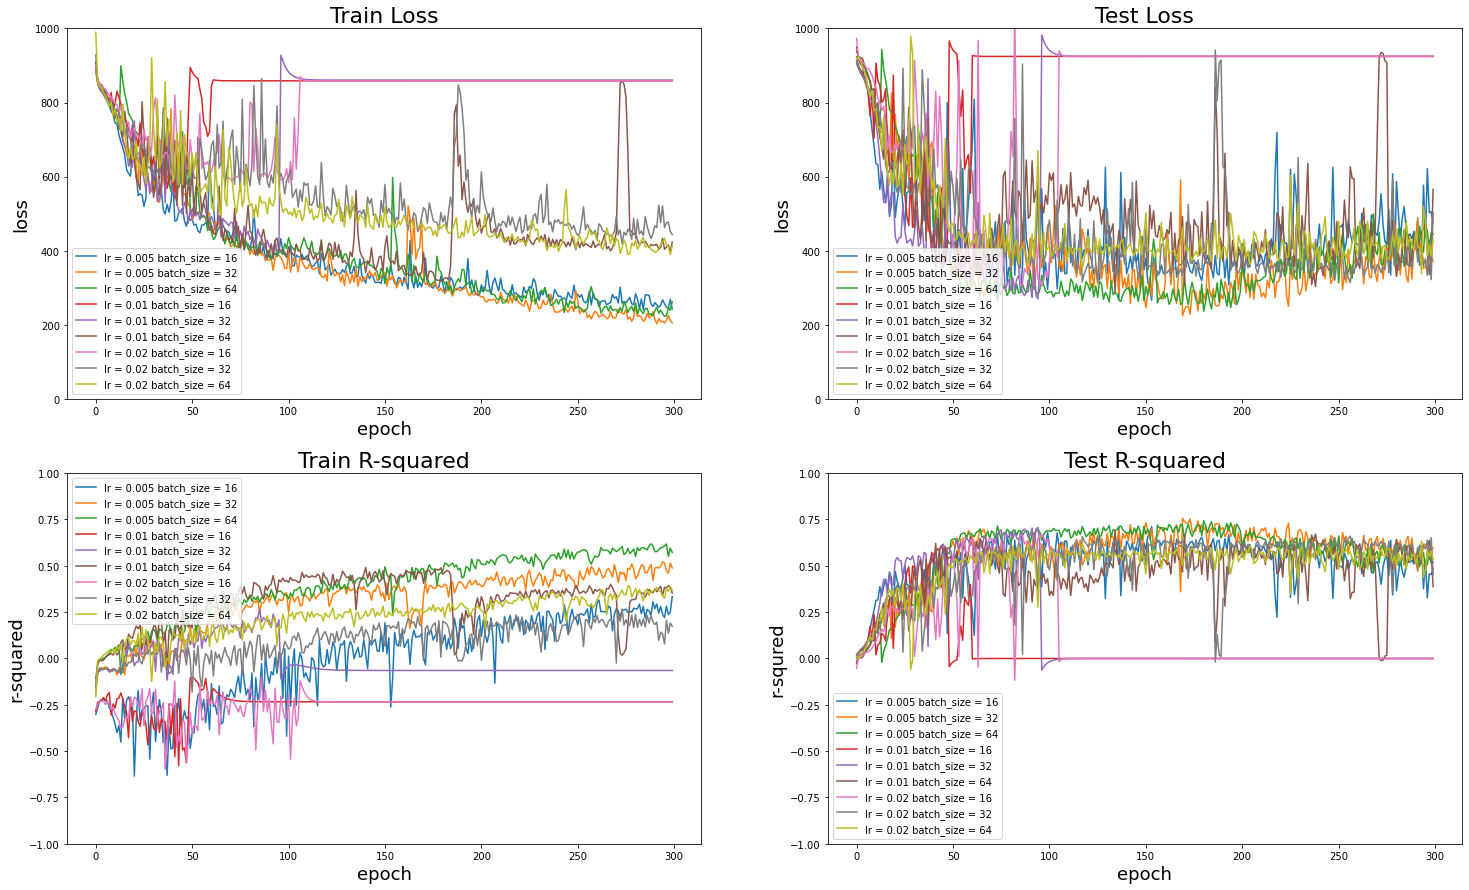

<Figure size 1800x1080 with 0 Axes>

In [15]:
def plot_all(ax, data_list):
    ax.plot(data_list[0],label="lr = 0.005 batch_size = 16")
    ax.plot(data_list[1],label="lr = 0.005 batch_size = 32")
    ax.plot(data_list[2],label="lr = 0.005 batch_size = 64")

    ax.plot(data_list[3],label="lr = 0.01 batch_size = 16")
    ax.plot(data_list[4],label="lr = 0.01 batch_size = 32")
    ax.plot(data_list[5],label="lr = 0.01 batch_size = 64")
    
    ax.plot(data_list[6],label="lr = 0.02 batch_size = 16")
    ax.plot(data_list[7],label="lr = 0.02 batch_size = 32")
    ax.plot(data_list[8],label="lr = 0.02 batch_size = 64")
    

figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(25,15))
plt.figure(figsize=(25,15))
ax1.set_title("Train Loss", fontsize=22)
plot_all(ax1, train_losses_all)
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 1000])

ax2.set_title("Test Loss", fontsize=22)
plot_all(ax2, test_losses_all)
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("loss", fontsize=18)
ax2.legend()
ax2.set_ylim([0, 1000])

ax3.set_title("Train R-squared", fontsize=22)
plot_all(ax3, train_accs_all)
ax3.set_xlabel("epoch", fontsize=18)
ax3.set_ylabel("r-squared", fontsize=18)
ax3.legend()
ax3.set_ylim([-1,1])

ax4.set_title("Test R-squared", fontsize=22)
plot_all(ax4, test_accs_all)
ax4.set_xlabel("epoch", fontsize=18)
ax4.set_ylabel("r-squred", fontsize=18)
ax4.legend()
ax4.set_ylim([-1,1])

plt.show()

In [16]:
for data in train_accs_all:
    print(data[-1])
    
print("___________________\n")

for data in test_accs_all:
    print(data[-1])
    
print("___________________\n")

for data in train_losses_all:
    print(data[-1])

print("___________________\n")

for data in test_losses_all:
    print(data[-1])   
    

0.33370358753561474
0.4882771807130866
0.572362058160656
-0.23395813307540897
-0.06467578995049511
0.35265802462631385
-0.23425658931424012
0.17368483374921811
0.36744979677465367
___________________

0.48509215924565896
0.5987642643864828
0.5185125293841035
-7.408157701660478e-05
-7.941220459350973e-05
0.38794966627626915
-7.05470759214677e-05
0.45578925573377216
0.5346448461493754
___________________

242.997413573327
205.52948869977678
262.2650367541191
858.5588931789646
860.5110319063261
423.49701142922424
858.5945172991071
444.03668341698585
412.3838465763972
___________________

475.9877014160156
370.90771484375
445.09344482421875
924.48193359375
924.48681640625
565.78759765625
924.4788208007812
503.0757751464844
430.1805419921875


### 3 best models

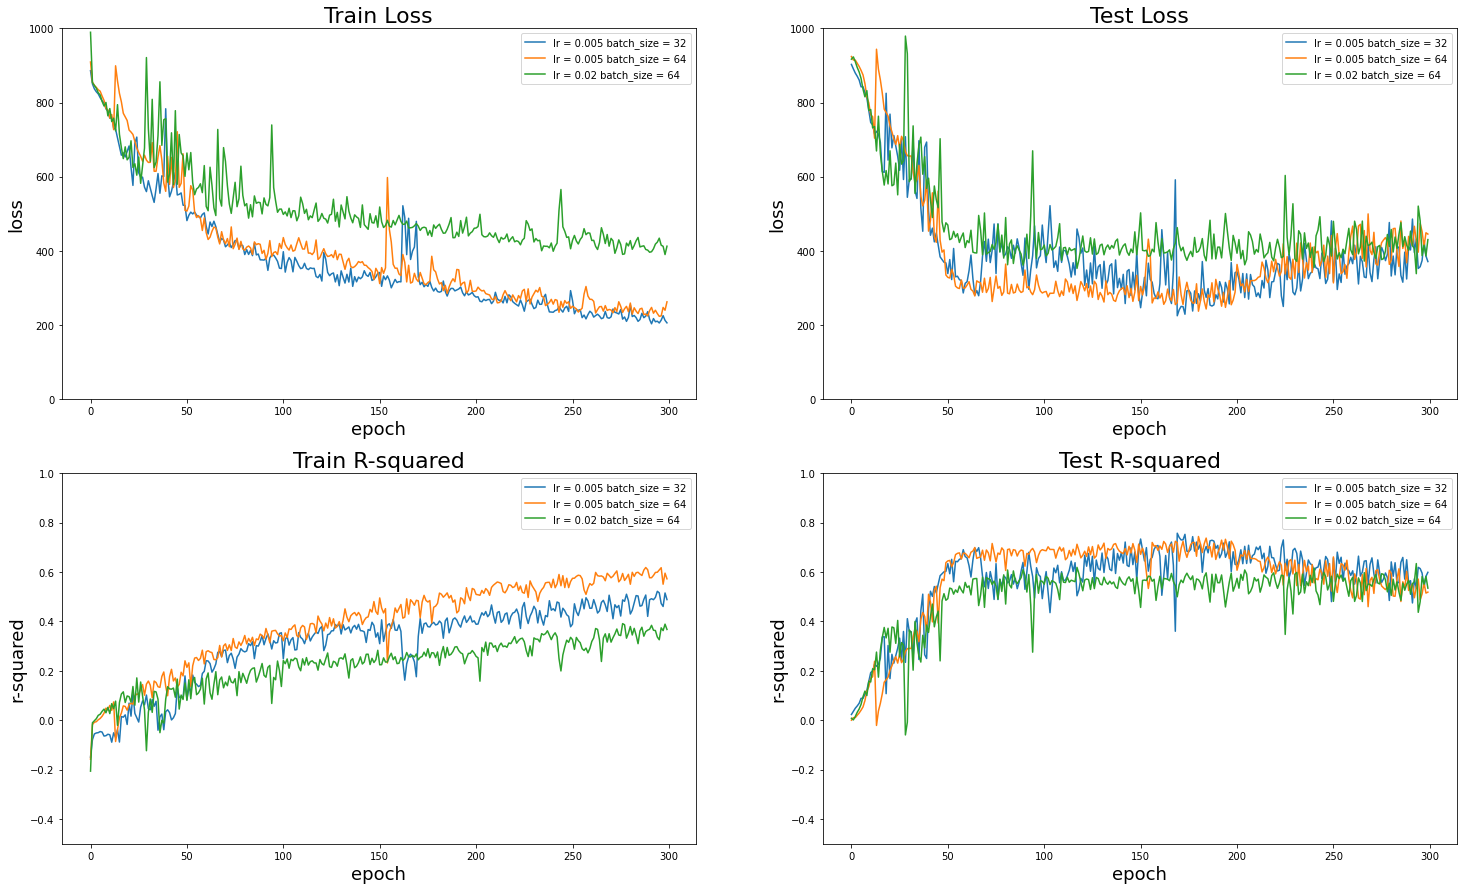

<Figure size 432x288 with 0 Axes>

In [18]:
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(25,15))
plt.figure()
ax1.set_title("Train Loss", fontsize=22)
ax1.plot(train_losses_all[1],label="lr = 0.005 batch_size = 32")
ax1.plot(train_losses_all[2],label="lr = 0.005 batch_size = 64")
ax1.plot(train_losses_all[8],label="lr = 0.02 batch_size = 64")
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 1000])

ax2.set_title("Test Loss", fontsize=22)
ax2.plot(test_losses_all[1],label="lr = 0.005 batch_size = 32")
ax2.plot(test_losses_all[2],label="lr = 0.005 batch_size = 64")
ax2.plot(test_losses_all[8],label="lr = 0.02 batch_size = 64")
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("loss", fontsize=18)
ax2.legend()
ax2.set_ylim([0, 1000])

ax3.set_title("Train R-squared", fontsize=22)
ax3.plot(train_accs_all[1],label="lr = 0.005 batch_size = 32")
ax3.plot(train_accs_all[2],label="lr = 0.005 batch_size = 64")
ax3.plot(train_accs_all[8],label="lr = 0.02 batch_size = 64")
ax3.set_xlabel("epoch", fontsize=18)
ax3.set_ylabel("r-squared", fontsize=18)
ax3.legend()
ax3.set_ylim([-0.5,1])

ax4.set_title("Test R-squared", fontsize=22)
ax4.plot(test_accs_all[1],label="lr = 0.005 batch_size = 32")
ax4.plot(test_accs_all[2],label="lr = 0.005 batch_size = 64")
ax4.plot(test_accs_all[8],label="lr = 0.02 batch_size = 64")
ax4.set_xlabel("epoch", fontsize=18)
ax4.set_ylabel("r-squared", fontsize=18)
ax4.legend()
ax4.set_ylim([-0.5,1])
plt.show()

## 6.2. Training


- Model 1 - lr: 0.005 batch size: 32
- Model 2 - lr: 0.005 batch size: 64
- Model 3 - lr: 0.02 batch size: 64

In [19]:
train_losses_all = []
test_losses_all = []
train_accs_all = []
test_accs_all = []
best_params_all = []
writer = SummaryWriter()

pairs = [(0.005, 32), (0.005, 64), (0.02, 64)]

for i_p, (lr, batch_size) in enumerate(pairs):
    
    model = GraphNeuralNetwork()

    train_loader = GraphDataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    test_loader = GraphDataLoader(test_dataset, batch_size=704, shuffle=False)

    epochs = 500
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr)

    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []
    best_params = {'batch_size': None, 'epoch': None, 'train_loss': None, 'test_loss': None,'train_acc': None,'test_acc': None}
    best_value = 600

    print('Model: batch_size {} learning rate {}'.format(batch_size, lr))

    for epoch in range(1, epochs + 1):

        print('################## EPOCH {} ##################'.format(epoch))

        model.train()
        train_correct = 0
        train_loss = 0

        for data in tqdm(train_loader, leave=False):
            x, edge_index, batch, y = data.x, data.edge_index, data.batch, data.y
            optimizer.zero_grad()
            output = model(x, edge_index, batch)
            loss = criterion(output, torch.Tensor(y))
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_correct += metrics.r2_score(y, output.cpu().detach().numpy())   

        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        train_acc = train_correct/len(train_loader)
        train_accs.append(train_acc)
        writer.add_scalar("Model_{}/Loss/train".format(i_p), train_loss, epoch)
        writer.add_scalar("Model_{}/R2/train".format(i_p), train_acc, epoch)
        print('Train Avg. loss: {}, Accuracy: {}'.format(train_loss, train_acc))

        model.eval()

        test_loss = 0
        test_correct = 0    

        with torch.no_grad():
            for data in tqdm(test_loader):
                x, edge_index, batch, y = data.x, data.edge_index, data.batch, data.y
                output = model(x, edge_index, batch)
                test_loss += criterion(output, torch.Tensor(y)).item()
                test_correct += metrics.r2_score(y, output.cpu().detach().numpy())

        test_loss /= len(test_loader)
        test_losses.append(test_loss)
        test_acc =test_correct/len(test_loader)
        test_accs.append(test_acc)

        if test_loss<best_value:
            best_value = test_loss
            torch.save(model.state_dict(), '../../models/caco_graph_model_{}.pt'.format(i_p))
            best_params['batch_size'] = batch_size
            best_params['epoch'] = epoch
            best_params['train_loss'] = train_loss
            best_params['test_loss'] = test_loss
            best_params['train_acc'] = train_acc
            best_params['test_acc'] = test_acc 
        writer.add_scalar("Model_{}/Loss/test".format(i_p), test_loss, epoch)
        writer.add_scalar("Model_{}/R2/test".format(i_p), test_acc, epoch)
        print('Test Avg. loss: {}, Accuracy: {}'.format(test_loss, test_acc))

    train_losses_all.append(train_losses)
    test_losses_all.append(test_losses)
    train_accs_all.append(train_accs)
    test_accs_all.append(test_accs)
    best_params_all.append(best_params)

writer.flush()
writer.close()
print(best_params_all)

  2%|▏         | 2/88 [00:00<00:05, 14.75it/s]

Model: batch_size 32 learning rate 0.005
################## EPOCH 1 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 886.2527197924527, Accuracy: -0.14229551465302426


  2%|▏         | 2/88 [00:00<00:05, 16.75it/s]

Test Avg. loss: 1022.840576171875, Accuracy: 0.012234207136080255
################## EPOCH 2 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 847.7944433038884, Accuracy: -0.06594088897185618


  2%|▏         | 2/88 [00:00<00:05, 16.35it/s]

Test Avg. loss: 1008.4953002929688, Accuracy: 0.026087602487678496
################## EPOCH 3 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 837.6798023744063, Accuracy: -0.05382886079942371


  2%|▏         | 2/88 [00:00<00:05, 16.56it/s]

Test Avg. loss: 999.4892578125, Accuracy: 0.03478489269330087
################## EPOCH 4 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 831.0514714501121, Accuracy: -0.053756000198256215


  2%|▏         | 2/88 [00:00<00:05, 16.94it/s]

Test Avg. loss: 1012.3578491210938, Accuracy: 0.022357515824910967
################## EPOCH 5 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 820.2929178584706, Accuracy: -0.05166079845360511


  2%|▏         | 2/88 [00:00<00:05, 17.06it/s]

Test Avg. loss: 968.8350219726562, Accuracy: 0.06438793041702406
################## EPOCH 6 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 804.9804408333518, Accuracy: -0.03982263887801321


  2%|▏         | 2/88 [00:00<00:05, 16.63it/s]

Test Avg. loss: 1000.8617553710938, Accuracy: 0.03345938195688991
################## EPOCH 7 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 799.6810685071079, Accuracy: -0.06849854741052898


  2%|▏         | 2/88 [00:00<00:04, 18.29it/s]

Test Avg. loss: 963.7427978515625, Accuracy: 0.0693055384109339
################## EPOCH 8 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 788.5254606767135, Accuracy: -0.0801278907508804


  2%|▏         | 2/88 [00:00<00:04, 17.26it/s]

Test Avg. loss: 931.8311157226562, Accuracy: 0.1001228681611771
################## EPOCH 9 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 772.8653384988958, Accuracy: -0.08059060839825119


  2%|▏         | 2/88 [00:00<00:05, 16.45it/s]

Test Avg. loss: 936.773681640625, Accuracy: 0.09534970443596391
################## EPOCH 10 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 755.0294349843806, Accuracy: -0.08311837007643265


  2%|▏         | 2/88 [00:00<00:05, 16.06it/s]

Test Avg. loss: 909.7864990234375, Accuracy: 0.12141163823842616
################## EPOCH 11 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 733.4926088506526, Accuracy: -0.06974925251374581


  2%|▏         | 2/88 [00:00<00:05, 16.72it/s]

Test Avg. loss: 900.4408569335938, Accuracy: 0.1304367197299291
################## EPOCH 12 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 720.5035480152477, Accuracy: -0.07087355745531373


  2%|▏         | 2/88 [00:00<00:05, 16.46it/s]

Test Avg. loss: 880.5294799804688, Accuracy: 0.14966536702104694
################## EPOCH 13 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 754.2373074618253, Accuracy: -0.043348575968575664


  2%|▏         | 2/88 [00:00<00:05, 16.70it/s]

Test Avg. loss: 911.990234375, Accuracy: 0.11928342468913933
################## EPOCH 14 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 677.6144442991776, Accuracy: 0.05567485055744041


  2%|▏         | 2/88 [00:00<00:04, 17.21it/s]

Test Avg. loss: 918.658447265625, Accuracy: 0.11284383911606855
################## EPOCH 15 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 776.439863725142, Accuracy: -0.13902325453835782


  2%|▏         | 2/88 [00:00<00:05, 17.09it/s]

Test Avg. loss: 910.920166015625, Accuracy: 0.12031666228225824
################## EPOCH 16 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 648.4594667608088, Accuracy: 0.03250322890767903


  2%|▏         | 2/88 [00:00<00:05, 16.26it/s]

Test Avg. loss: 908.112060546875, Accuracy: 0.12302856179810429
################## EPOCH 17 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 657.6017446517944, Accuracy: 0.08957262996008596


  2%|▏         | 2/88 [00:00<00:05, 16.35it/s]

Test Avg. loss: 992.8687133789062, Accuracy: 0.04117832295984303
################## EPOCH 18 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 716.7295252626592, Accuracy: 0.025704579160406672


  2%|▏         | 2/88 [00:00<00:05, 16.66it/s]

Test Avg. loss: 929.695068359375, Accuracy: 0.10218558957564727
################## EPOCH 19 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 604.7521039789373, Accuracy: 0.1216061713303807


  2%|▏         | 2/88 [00:00<00:04, 17.26it/s]

Test Avg. loss: 962.6610717773438, Accuracy: 0.070350176144089
################## EPOCH 20 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 669.1181781508706, Accuracy: 0.05946739962339421


  3%|▎         | 3/88 [00:00<00:04, 19.14it/s]

Test Avg. loss: 943.9315795898438, Accuracy: 0.0884374066324175
################## EPOCH 21 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 609.9232414852489, Accuracy: 0.1002176996917985


  2%|▏         | 2/88 [00:00<00:05, 16.49it/s]

Test Avg. loss: 967.6734008789062, Accuracy: 0.06550965961372701
################## EPOCH 22 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 624.1788136742332, Accuracy: 0.05429425269763031


  2%|▏         | 2/88 [00:00<00:05, 16.19it/s]

Test Avg. loss: 1057.8841552734375, Accuracy: -0.02160752734227267
################## EPOCH 23 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 692.1146499460393, Accuracy: 0.04700171648744436


  2%|▏         | 2/88 [00:00<00:05, 16.94it/s]

Test Avg. loss: 937.7711181640625, Accuracy: 0.09438649045534209
################## EPOCH 24 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 594.1303019090133, Accuracy: 0.10977614934009043


  2%|▏         | 2/88 [00:00<00:05, 17.17it/s]

Test Avg. loss: 946.685302734375, Accuracy: 0.08577800035219119
################## EPOCH 25 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 633.3863610354337, Accuracy: 0.06726977237186406


  2%|▏         | 2/88 [00:00<00:05, 15.96it/s]

Test Avg. loss: 1019.5584106445312, Accuracy: 0.015403824271617128
################## EPOCH 26 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 775.6783020713112, Accuracy: 0.010841319116745924


  2%|▏         | 2/88 [00:00<00:05, 16.68it/s]

Test Avg. loss: 1056.4029541015625, Accuracy: -0.020177179896055275
################## EPOCH 27 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 655.9340441443703, Accuracy: 0.0003060621192138076


  2%|▏         | 2/88 [00:00<00:05, 16.86it/s]

Test Avg. loss: 970.3159790039062, Accuracy: 0.06295770923829858
################## EPOCH 28 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 610.906732862646, Accuracy: 0.0686045475483829


  2%|▏         | 2/88 [00:00<00:04, 18.17it/s]

Test Avg. loss: 967.2518920898438, Accuracy: 0.06591676636979538
################## EPOCH 29 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 812.5600451556119, Accuracy: -0.039155633872928544


  2%|▏         | 2/88 [00:00<00:05, 16.33it/s]

Test Avg. loss: 1045.38427734375, Accuracy: -0.009536325599394546
################## EPOCH 30 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 630.4514340487393, Accuracy: 0.02232880638668661


  2%|▏         | 2/88 [00:00<00:05, 16.93it/s]

Test Avg. loss: 925.3377075195312, Accuracy: 0.10639359109199431
################## EPOCH 31 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 569.4354216835716, Accuracy: 0.025857386622696824


  2%|▏         | 2/88 [00:00<00:04, 17.20it/s]

Test Avg. loss: 904.737060546875, Accuracy: 0.1262878865865933
################## EPOCH 32 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 589.1669008081609, Accuracy: 0.05680515394271952


  2%|▏         | 2/88 [00:00<00:05, 16.27it/s]

Test Avg. loss: 949.19921875, Accuracy: 0.08335031419181493
################## EPOCH 33 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 624.3397037332708, Accuracy: 0.060735959561874914


  2%|▏         | 2/88 [00:00<00:05, 16.84it/s]

Test Avg. loss: 934.2698974609375, Accuracy: 0.09776779413808567
################## EPOCH 34 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 567.5961979085749, Accuracy: 0.06533377106784753


  2%|▏         | 2/88 [00:00<00:05, 17.13it/s]

Test Avg. loss: 911.7461547851562, Accuracy: 0.11951914127932928
################## EPOCH 35 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 531.4938458962874, Accuracy: 0.05692918246748643


  2%|▏         | 2/88 [00:00<00:05, 16.68it/s]

Test Avg. loss: 891.2118530273438, Accuracy: 0.1393493208916261
################## EPOCH 36 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 684.7915853153576, Accuracy: -0.1712047424925651


  2%|▏         | 2/88 [00:00<00:05, 16.59it/s]

Test Avg. loss: 860.4961547851562, Accuracy: 0.16901168020864465
################## EPOCH 37 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 617.635099584406, Accuracy: -0.015925095236133197


  2%|▏         | 2/88 [00:00<00:05, 15.82it/s]

Test Avg. loss: 875.5473022460938, Accuracy: 0.15447656263678233
################## EPOCH 38 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 544.8769759264859, Accuracy: 0.1636239390793238


  2%|▏         | 2/88 [00:00<00:05, 16.28it/s]

Test Avg. loss: 929.6050415039062, Accuracy: 0.10227258710388232
################## EPOCH 39 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 521.4085783958435, Accuracy: 0.1305705302921964


  2%|▏         | 2/88 [00:00<00:05, 16.93it/s]

Test Avg. loss: 872.3770141601562, Accuracy: 0.1575381399497452
################## EPOCH 40 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 470.9324424050071, Accuracy: 0.19546736386226085


  2%|▏         | 2/88 [00:00<00:05, 16.94it/s]

Test Avg. loss: 906.3267822265625, Accuracy: 0.12475265378361433
################## EPOCH 41 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 528.7263406840237, Accuracy: 0.12619645766785925


  2%|▏         | 2/88 [00:00<00:05, 17.15it/s]

Test Avg. loss: 857.590087890625, Accuracy: 0.17181802515319677
################## EPOCH 42 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 466.87695663625544, Accuracy: 0.21394741537681494


  2%|▏         | 2/88 [00:00<00:04, 18.08it/s]

Test Avg. loss: 846.4600219726562, Accuracy: 0.18256640169219485
################## EPOCH 43 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 460.4996255527843, Accuracy: 0.15725326316265936


  2%|▏         | 2/88 [00:00<00:05, 16.70it/s]

Test Avg. loss: 860.6759643554688, Accuracy: 0.16883797559899738
################## EPOCH 44 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 514.6035702011802, Accuracy: 0.1145266287000116


  2%|▏         | 2/88 [00:00<00:04, 17.35it/s]

Test Avg. loss: 868.420166015625, Accuracy: 0.1613593795808539
################## EPOCH 45 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 444.5959133234891, Accuracy: 0.21661583637969298


  2%|▏         | 2/88 [00:00<00:04, 18.04it/s]

Test Avg. loss: 869.819091796875, Accuracy: 0.16000835154552695
################## EPOCH 46 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 502.08584703098643, Accuracy: 0.08400281487958457


  2%|▏         | 2/88 [00:00<00:04, 17.48it/s]

Test Avg. loss: 872.0504150390625, Accuracy: 0.15785357967843838
################## EPOCH 47 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 476.13118440454656, Accuracy: 0.15799497049538258


  2%|▏         | 2/88 [00:00<00:05, 17.01it/s]

Test Avg. loss: 892.7861328125, Accuracy: 0.1378290539998348
################## EPOCH 48 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 454.06144233183426, Accuracy: 0.19866370964693286


  2%|▏         | 2/88 [00:00<00:05, 16.12it/s]

Test Avg. loss: 885.630859375, Accuracy: 0.14473882926169068
################## EPOCH 49 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 459.4011037132957, Accuracy: 0.16187082055988114


  2%|▏         | 2/88 [00:00<00:05, 17.13it/s]

Test Avg. loss: 852.9937133789062, Accuracy: 0.17625683264279546
################## EPOCH 50 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 459.16342028704554, Accuracy: 0.21892771169424902


  2%|▏         | 2/88 [00:00<00:05, 16.59it/s]

Test Avg. loss: 877.4312744140625, Accuracy: 0.15265728902255504
################## EPOCH 51 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 442.8406960747459, Accuracy: 0.24377036967592994


  2%|▏         | 2/88 [00:00<00:05, 16.74it/s]

Test Avg. loss: 887.2318725585938, Accuracy: 0.14319266776332185
################## EPOCH 52 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 429.2398167956959, Accuracy: 0.23647553923495315


  2%|▏         | 2/88 [00:00<00:05, 16.84it/s]

Test Avg. loss: 891.508544921875, Accuracy: 0.13906280325329712
################## EPOCH 53 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 418.25353847850454, Accuracy: 0.25221455884704147


  2%|▏         | 2/88 [00:00<00:05, 15.92it/s]

Test Avg. loss: 870.1515502929688, Accuracy: 0.15968739933123577
################## EPOCH 54 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 408.69935287128794, Accuracy: 0.25894902282616666


  2%|▏         | 2/88 [00:00<00:05, 16.64it/s]

Test Avg. loss: 828.839599609375, Accuracy: 0.19958260119743998
################## EPOCH 55 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 400.68848553570837, Accuracy: 0.2601622857226415


  2%|▏         | 2/88 [00:00<00:04, 17.20it/s]

Test Avg. loss: 862.1820068359375, Accuracy: 0.16738371213733272
################## EPOCH 56 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 436.16040511564773, Accuracy: 0.22469656243163041


  2%|▏         | 2/88 [00:00<00:05, 16.24it/s]

Test Avg. loss: 896.4002075195312, Accuracy: 0.13433875869955425
################## EPOCH 57 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 431.9139076146212, Accuracy: 0.26344795834494944


  2%|▏         | 2/88 [00:00<00:05, 15.90it/s]

Test Avg. loss: 887.7984008789062, Accuracy: 0.14264565612614089
################## EPOCH 58 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 415.55271313407206, Accuracy: 0.23821695692476344


  2%|▏         | 2/88 [00:00<00:04, 17.27it/s]

Test Avg. loss: 830.7911987304688, Accuracy: 0.19769794742240254
################## EPOCH 59 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 410.85694213347, Accuracy: 0.27963642123836524


  2%|▏         | 2/88 [00:00<00:05, 17.07it/s]

Test Avg. loss: 843.912353515625, Accuracy: 0.1850267380971382
################## EPOCH 60 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 381.9836373762651, Accuracy: 0.3026831023277391


  2%|▏         | 2/88 [00:00<00:05, 17.19it/s]

Test Avg. loss: 821.3613891601562, Accuracy: 0.20680435104978134
################## EPOCH 61 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 393.7516813278198, Accuracy: 0.3165364543166709


  2%|▏         | 2/88 [00:00<00:05, 16.52it/s]

Test Avg. loss: 853.2774047851562, Accuracy: 0.17598280329830474
################## EPOCH 62 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 397.6470462625677, Accuracy: 0.28465421797862694


  2%|▏         | 2/88 [00:00<00:05, 16.06it/s]

Test Avg. loss: 860.750244140625, Accuracy: 0.16876626351249613
################## EPOCH 63 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 398.21120114759964, Accuracy: 0.305193888027605


  2%|▏         | 2/88 [00:00<00:05, 16.12it/s]

Test Avg. loss: 839.9548950195312, Accuracy: 0.18884854632055104
################## EPOCH 64 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 395.79336599870163, Accuracy: 0.29595429743389157


  2%|▏         | 2/88 [00:00<00:05, 16.09it/s]

Test Avg. loss: 900.879638671875, Accuracy: 0.13001304738024377
################## EPOCH 65 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 401.003371368755, Accuracy: 0.2809895282538105


  2%|▏         | 2/88 [00:00<00:05, 16.45it/s]

Test Avg. loss: 837.995361328125, Accuracy: 0.190740840226035
################## EPOCH 66 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 419.12529676610774, Accuracy: 0.21918597779895677


  2%|▏         | 2/88 [00:00<00:05, 15.20it/s]

Test Avg. loss: 821.5742797851562, Accuracy: 0.20659880194504687
################## EPOCH 67 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 392.6374462301081, Accuracy: 0.2912331643981301


  2%|▏         | 2/88 [00:00<00:05, 16.34it/s]

Test Avg. loss: 822.4227905273438, Accuracy: 0.20577943450759484
################## EPOCH 68 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 387.9314167282798, Accuracy: 0.2844736237648056


  2%|▏         | 2/88 [00:00<00:04, 19.86it/s]

Test Avg. loss: 817.6714477539062, Accuracy: 0.210367810936533
################## EPOCH 69 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 369.70648657191884, Accuracy: 0.34375059892461346


  2%|▏         | 2/88 [00:00<00:05, 16.15it/s]

Test Avg. loss: 784.5955200195312, Accuracy: 0.24230950108704263
################## EPOCH 70 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 368.7309241294861, Accuracy: 0.3098923515696497


  2%|▏         | 2/88 [00:00<00:05, 16.18it/s]

Test Avg. loss: 826.7372436523438, Accuracy: 0.20161296575780363
################## EPOCH 71 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 383.19180952418935, Accuracy: 0.32259969527069643


  2%|▏         | 2/88 [00:00<00:04, 17.25it/s]

Test Avg. loss: 777.3460693359375, Accuracy: 0.2493104130673678
################## EPOCH 72 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 373.8231617754156, Accuracy: 0.3317441445755697


  2%|▏         | 2/88 [00:00<00:05, 15.30it/s]

Test Avg. loss: 858.782958984375, Accuracy: 0.17066606348191038
################## EPOCH 73 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 367.1425705823031, Accuracy: 0.31889190281148855


  2%|▏         | 2/88 [00:00<00:05, 16.28it/s]

Test Avg. loss: 801.220458984375, Accuracy: 0.22625469804175813
################## EPOCH 74 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 389.5985799269243, Accuracy: 0.33055028585959106


  2%|▏         | 2/88 [00:00<00:05, 16.64it/s]

Test Avg. loss: 823.056640625, Accuracy: 0.20516727182408
################## EPOCH 75 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 369.51070434396917, Accuracy: 0.33235793361890836


  2%|▏         | 2/88 [00:00<00:05, 16.33it/s]

Test Avg. loss: 795.0098266601562, Accuracy: 0.232252391044656
################## EPOCH 76 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 356.3915633288297, Accuracy: 0.3103875607628856


  2%|▏         | 2/88 [00:00<00:05, 16.36it/s]

Test Avg. loss: 804.5283813476562, Accuracy: 0.22306027769141812
################## EPOCH 77 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 360.4852565852079, Accuracy: 0.3576791959272123


  2%|▏         | 2/88 [00:00<00:05, 16.32it/s]

Test Avg. loss: 850.5599975585938, Accuracy: 0.17860702947023888
################## EPOCH 78 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 373.6076348478144, Accuracy: 0.33182580135235534


  2%|▏         | 2/88 [00:00<00:05, 16.79it/s]

Test Avg. loss: 799.3663940429688, Accuracy: 0.22804517874978159
################## EPOCH 79 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 366.6373447938399, Accuracy: 0.2925257867877998


  2%|▏         | 2/88 [00:00<00:05, 16.04it/s]

Test Avg. loss: 824.8716430664062, Accuracy: 0.20341450585289444
################## EPOCH 80 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 365.5341189991344, Accuracy: 0.3544710418687449


  2%|▏         | 2/88 [00:00<00:05, 16.49it/s]

Test Avg. loss: 790.634521484375, Accuracy: 0.236477598271573
################## EPOCH 81 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 362.6365158774636, Accuracy: 0.3413830066056702


  2%|▏         | 2/88 [00:00<00:05, 17.01it/s]

Test Avg. loss: 858.5021362304688, Accuracy: 0.17093730894418357
################## EPOCH 82 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 368.1746460307728, Accuracy: 0.3456637691982895


  2%|▏         | 2/88 [00:00<00:04, 17.67it/s]

Test Avg. loss: 790.3934936523438, Accuracy: 0.23671042704851974
################## EPOCH 83 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 352.4560830809853, Accuracy: 0.34514809458917595


  2%|▏         | 2/88 [00:00<00:05, 16.71it/s]

Test Avg. loss: 787.6289672851562, Accuracy: 0.2393801233713747
################## EPOCH 84 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 358.319890499115, Accuracy: 0.3238961376067776


  2%|▏         | 2/88 [00:00<00:05, 16.54it/s]

Test Avg. loss: 803.7802734375, Accuracy: 0.2237826342434731
################## EPOCH 85 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 347.6676144166426, Accuracy: 0.36976647605848884


  2%|▏         | 2/88 [00:00<00:05, 16.12it/s]

Test Avg. loss: 787.8212280273438, Accuracy: 0.2391944315617781
################## EPOCH 86 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 342.1985263824463, Accuracy: 0.3237270437936301


  2%|▏         | 2/88 [00:00<00:05, 16.32it/s]

Test Avg. loss: 787.1631469726562, Accuracy: 0.23982987957007562
################## EPOCH 87 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 355.9290806163441, Accuracy: 0.36510111978100923


  2%|▏         | 2/88 [00:00<00:05, 17.17it/s]

Test Avg. loss: 784.612060546875, Accuracy: 0.24229361076214506
################## EPOCH 88 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 347.22568160837346, Accuracy: 0.35373637898589133


  2%|▏         | 2/88 [00:00<00:04, 18.97it/s]

Test Avg. loss: 804.5228271484375, Accuracy: 0.22306549439138101
################## EPOCH 89 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 348.8579639088024, Accuracy: 0.33114256333806125


  2%|▏         | 2/88 [00:00<00:05, 16.65it/s]

Test Avg. loss: 823.1939086914062, Accuracy: 0.20503482479579882
################## EPOCH 90 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 358.3924955888228, Accuracy: 0.3383798754564519


  2%|▏         | 2/88 [00:00<00:05, 16.98it/s]

Test Avg. loss: 793.7615356445312, Accuracy: 0.23345778842484255
################## EPOCH 91 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 356.73237228393555, Accuracy: 0.3385321198195154


  2%|▏         | 2/88 [00:00<00:05, 16.03it/s]

Test Avg. loss: 789.732177734375, Accuracy: 0.23734902927780932
################## EPOCH 92 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 354.0148344039917, Accuracy: 0.3332575834809697


  2%|▏         | 2/88 [00:00<00:05, 17.17it/s]

Test Avg. loss: 812.1486206054688, Accuracy: 0.21570127159323416
################## EPOCH 93 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 350.4441839131442, Accuracy: 0.3565406458606609


  2%|▏         | 2/88 [00:00<00:05, 16.92it/s]

Test Avg. loss: 788.915283203125, Accuracy: 0.23813787851006607
################## EPOCH 94 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 355.75097318129104, Accuracy: 0.3509820005685667


  2%|▏         | 2/88 [00:00<00:05, 16.26it/s]

Test Avg. loss: 770.1670532226562, Accuracy: 0.2562431860850428
################## EPOCH 95 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 342.1356854005293, Accuracy: 0.3313057366627391


  2%|▏         | 2/88 [00:00<00:05, 16.52it/s]

Test Avg. loss: 827.6868896484375, Accuracy: 0.20069586581899745
################## EPOCH 96 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 348.55404485355723, Accuracy: 0.358654357168735


  2%|▏         | 2/88 [00:00<00:04, 17.23it/s]

Test Avg. loss: 823.427978515625, Accuracy: 0.20480869007167846
################## EPOCH 97 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 364.7788890058344, Accuracy: 0.33435624036132766


  2%|▏         | 2/88 [00:00<00:05, 16.16it/s]

Test Avg. loss: 773.0116577148438, Accuracy: 0.25349620524258065
################## EPOCH 98 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 348.73635482788086, Accuracy: 0.3601965856968827


  2%|▏         | 2/88 [00:00<00:05, 16.00it/s]

Test Avg. loss: 755.7866821289062, Accuracy: 0.2701304388435567
################## EPOCH 99 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 349.34911745244807, Accuracy: 0.353432005702565


  2%|▏         | 2/88 [00:00<00:04, 18.13it/s]

Test Avg. loss: 786.21484375, Accuracy: 0.24074573963738355
################## EPOCH 100 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 343.68046734549785, Accuracy: 0.3684342024887013


  2%|▏         | 2/88 [00:00<00:04, 17.65it/s]

Test Avg. loss: 799.6090087890625, Accuracy: 0.22781086788481486
################## EPOCH 101 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 328.94104918566615, Accuracy: 0.38620498125342767


  2%|▏         | 2/88 [00:00<00:05, 17.05it/s]

Test Avg. loss: 778.7782592773438, Accuracy: 0.24792730460528067
################## EPOCH 102 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 339.28045840696853, Accuracy: 0.37120582216953096


  2%|▏         | 2/88 [00:00<00:05, 16.98it/s]

Test Avg. loss: 775.2315063476562, Accuracy: 0.25135239706205204
################## EPOCH 103 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 324.59666928378016, Accuracy: 0.3865194767197119


  2%|▏         | 2/88 [00:00<00:05, 16.93it/s]

Test Avg. loss: 808.4010009765625, Accuracy: 0.21932036614631134
################## EPOCH 104 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 334.1806219707836, Accuracy: 0.357838996393973


  2%|▏         | 2/88 [00:00<00:05, 16.36it/s]

Test Avg. loss: 778.5445556640625, Accuracy: 0.24815292075132334
################## EPOCH 105 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 348.29846499182963, Accuracy: 0.35678420445605297


  2%|▏         | 2/88 [00:00<00:05, 16.23it/s]

Test Avg. loss: 749.9967041015625, Accuracy: 0.275721891814395
################## EPOCH 106 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 417.0512399673462, Accuracy: 0.26412292753362543


  2%|▏         | 2/88 [00:00<00:05, 16.50it/s]

Test Avg. loss: 817.5533447265625, Accuracy: 0.21048191399429705
################## EPOCH 107 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 344.9148931503296, Accuracy: 0.3682917324524611


  2%|▏         | 2/88 [00:00<00:05, 16.35it/s]

Test Avg. loss: 750.4672241210938, Accuracy: 0.275267546141549
################## EPOCH 108 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 330.82441147890955, Accuracy: 0.387033941814051


  2%|▏         | 2/88 [00:00<00:05, 17.17it/s]

Test Avg. loss: 742.080810546875, Accuracy: 0.2833663271694912
################## EPOCH 109 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 335.30946003306997, Accuracy: 0.36628829562238346


  2%|▏         | 2/88 [00:00<00:05, 16.88it/s]

Test Avg. loss: 757.4707641601562, Accuracy: 0.2685040731835827
################## EPOCH 110 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 329.611283345656, Accuracy: 0.3902376219117196


  2%|▏         | 2/88 [00:00<00:05, 16.86it/s]

Test Avg. loss: 764.6749877929688, Accuracy: 0.2615469896014726
################## EPOCH 111 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 313.90784159573644, Accuracy: 0.416508498657215


  2%|▏         | 2/88 [00:00<00:05, 16.76it/s]

Test Avg. loss: 759.4185180664062, Accuracy: 0.2666232640708899
################## EPOCH 112 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 311.97551432522863, Accuracy: 0.4130083942055512


  2%|▏         | 2/88 [00:00<00:04, 17.21it/s]

Test Avg. loss: 777.287353515625, Accuracy: 0.24936711977633896
################## EPOCH 113 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 330.15177197889847, Accuracy: 0.38039516195494566


  2%|▏         | 2/88 [00:00<00:05, 15.90it/s]

Test Avg. loss: 766.387939453125, Accuracy: 0.2598926743668091
################## EPOCH 114 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 312.7190281261097, Accuracy: 0.40207691620010916


  2%|▏         | 2/88 [00:00<00:05, 16.14it/s]

Test Avg. loss: 803.8778686523438, Accuracy: 0.22368837311823475
################## EPOCH 115 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 316.8932559706948, Accuracy: 0.393527909892089


  2%|▏         | 2/88 [00:00<00:05, 16.62it/s]

Test Avg. loss: 756.7646484375, Accuracy: 0.2691860316027809
################## EPOCH 116 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 332.05147001960063, Accuracy: 0.3865749379260563


  2%|▏         | 2/88 [00:00<00:05, 16.22it/s]

Test Avg. loss: 754.456298828125, Accuracy: 0.27141524686031604
################## EPOCH 117 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 309.500909761949, Accuracy: 0.4085506411008767


  2%|▏         | 2/88 [00:00<00:05, 16.89it/s]

Test Avg. loss: 775.8724975585938, Accuracy: 0.2507333768271053
################## EPOCH 118 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 317.82742274891245, Accuracy: 0.39474601513116014


  2%|▏         | 2/88 [00:00<00:04, 18.28it/s]

Test Avg. loss: 772.9896850585938, Accuracy: 0.25351734578964236
################## EPOCH 119 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 337.9765690456737, Accuracy: 0.3910421930577634


  2%|▏         | 2/88 [00:00<00:05, 16.52it/s]

Test Avg. loss: 775.4216918945312, Accuracy: 0.2511687450801605
################## EPOCH 120 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 329.29517490213567, Accuracy: 0.4095387249566782


  2%|▏         | 2/88 [00:00<00:05, 16.08it/s]

Test Avg. loss: 793.916748046875, Accuracy: 0.23330792721652405
################## EPOCH 121 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 335.11514507640493, Accuracy: 0.3981958786458252


  2%|▏         | 2/88 [00:00<00:05, 16.42it/s]

Test Avg. loss: 781.1040649414062, Accuracy: 0.24568118299155794
################## EPOCH 122 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 346.2221425663341, Accuracy: 0.3861412568253682


  2%|▏         | 2/88 [00:00<00:05, 15.82it/s]

Test Avg. loss: 753.5066528320312, Accuracy: 0.27233238833228235
################## EPOCH 123 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 301.4042055823586, Accuracy: 0.4125870835678834


  2%|▏         | 2/88 [00:00<00:05, 16.38it/s]

Test Avg. loss: 783.846435546875, Accuracy: 0.24303297998763662
################## EPOCH 124 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 308.43846615878016, Accuracy: 0.38334220059648927


  2%|▏         | 2/88 [00:00<00:05, 15.69it/s]

Test Avg. loss: 777.8466186523438, Accuracy: 0.24882704539750278
################## EPOCH 125 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 307.92366257580846, Accuracy: 0.3984167363199291


  2%|▏         | 2/88 [00:00<00:05, 16.26it/s]

Test Avg. loss: 758.3211059570312, Accuracy: 0.26768297126410245
################## EPOCH 126 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 326.4131637486544, Accuracy: 0.3961876702858312


  2%|▏         | 2/88 [00:00<00:05, 15.84it/s]

Test Avg. loss: 782.917236328125, Accuracy: 0.24393026927063222
################## EPOCH 127 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 300.3308955105868, Accuracy: 0.42759866681387365


  2%|▏         | 2/88 [00:00<00:05, 16.23it/s]

Test Avg. loss: 820.2471313476562, Accuracy: 0.20788040928044393
################## EPOCH 128 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 316.8110530593178, Accuracy: 0.3989440773474802


  2%|▏         | 2/88 [00:00<00:05, 17.04it/s]

Test Avg. loss: 810.3836059570312, Accuracy: 0.21740576941980627
################## EPOCH 129 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 306.785070549358, Accuracy: 0.4066026420096497


  2%|▏         | 2/88 [00:00<00:04, 18.08it/s]

Test Avg. loss: 752.7598266601562, Accuracy: 0.2730535397626842
################## EPOCH 130 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 310.2745800451799, Accuracy: 0.41234262507073355


  2%|▏         | 2/88 [00:00<00:05, 16.87it/s]

Test Avg. loss: 766.6524047851562, Accuracy: 0.2596372659723575
################## EPOCH 131 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 295.2373987978155, Accuracy: 0.41576756659864683


  2%|▏         | 2/88 [00:00<00:05, 16.31it/s]

Test Avg. loss: 815.0399780273438, Accuracy: 0.21290909898250032
################## EPOCH 132 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 303.3321309523149, Accuracy: 0.42094021852600094


  2%|▏         | 2/88 [00:00<00:05, 15.96it/s]

Test Avg. loss: 819.1367797851562, Accuracy: 0.20895276076681013
################## EPOCH 133 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 298.3905841220509, Accuracy: 0.39843152160332473


  2%|▏         | 2/88 [00:00<00:05, 16.18it/s]

Test Avg. loss: 840.539794921875, Accuracy: 0.18828365347976916
################## EPOCH 134 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 313.77943810549647, Accuracy: 0.39664259325239876


  2%|▏         | 2/88 [00:00<00:05, 15.89it/s]

Test Avg. loss: 822.7769775390625, Accuracy: 0.205437366772111
################## EPOCH 135 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 298.1893093802712, Accuracy: 0.4004592852197471


  2%|▏         | 2/88 [00:00<00:05, 16.06it/s]

Test Avg. loss: 842.8005981445312, Accuracy: 0.18610028600020256
################## EPOCH 136 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 298.6077626835216, Accuracy: 0.3838674375572209


  2%|▏         | 2/88 [00:00<00:05, 16.38it/s]

Test Avg. loss: 795.3333740234375, Accuracy: 0.23193986548818524
################## EPOCH 137 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 304.3892542665655, Accuracy: 0.4503356085800551


  2%|▏         | 2/88 [00:00<00:05, 15.81it/s]

Test Avg. loss: 844.3855590820312, Accuracy: 0.1845698286544315
################## EPOCH 138 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 308.4432285482233, Accuracy: 0.4202137723566365


  2%|▏         | 2/88 [00:00<00:05, 16.21it/s]

Test Avg. loss: 774.4955444335938, Accuracy: 0.252063150834674
################## EPOCH 139 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 304.922221140428, Accuracy: 0.40895304837376867


  2%|▏         | 2/88 [00:00<00:05, 16.57it/s]

Test Avg. loss: 785.0689086914062, Accuracy: 0.24185240593285107
################## EPOCH 140 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 296.5765492699363, Accuracy: 0.43295516439705006


  2%|▏         | 2/88 [00:00<00:05, 15.51it/s]

Test Avg. loss: 821.559814453125, Accuracy: 0.20661284727583262
################## EPOCH 141 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 300.1717578714544, Accuracy: 0.41878024355951093


  2%|▏         | 2/88 [00:00<00:05, 16.44it/s]

Test Avg. loss: 826.3824462890625, Accuracy: 0.20195550846560284
################## EPOCH 142 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 307.65935824134135, Accuracy: 0.42468949090506597


  2%|▏         | 2/88 [00:00<00:05, 16.18it/s]

Test Avg. loss: 789.2855834960938, Accuracy: 0.23778029403240508
################## EPOCH 143 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 298.8419695334001, Accuracy: 0.41528628657140076


  2%|▏         | 2/88 [00:00<00:05, 15.88it/s]

Test Avg. loss: 800.3304443359375, Accuracy: 0.22711420640431423
################## EPOCH 144 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 291.198625347831, Accuracy: 0.3978556177854344


  2%|▏         | 2/88 [00:00<00:05, 16.67it/s]

Test Avg. loss: 806.339599609375, Accuracy: 0.22131111874714327
################## EPOCH 145 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 290.3873458775607, Accuracy: 0.4006127198627748


  2%|▏         | 2/88 [00:00<00:05, 17.05it/s]

Test Avg. loss: 760.1068725585938, Accuracy: 0.2659584190939681
################## EPOCH 146 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 281.72911145470357, Accuracy: 0.44691856658654905


  2%|▏         | 2/88 [00:00<00:05, 15.86it/s]

Test Avg. loss: 752.1636962890625, Accuracy: 0.2736292468555428
################## EPOCH 147 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 279.45144055106425, Accuracy: 0.4368850910698516


  2%|▏         | 2/88 [00:00<00:05, 16.39it/s]

Test Avg. loss: 774.049560546875, Accuracy: 0.2524938500452565
################## EPOCH 148 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 290.8472567905079, Accuracy: 0.42342495753236603


  2%|▏         | 2/88 [00:00<00:04, 17.33it/s]

Test Avg. loss: 769.7525634765625, Accuracy: 0.2566435006842389
################## EPOCH 149 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 308.3433463356712, Accuracy: 0.4386389581562019


  2%|▏         | 2/88 [00:00<00:04, 17.84it/s]

Test Avg. loss: 791.9122924804688, Accuracy: 0.23524360794964927
################## EPOCH 150 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 290.77494642951274, Accuracy: 0.4332915007500231


  2%|▏         | 2/88 [00:00<00:05, 16.83it/s]

Test Avg. loss: 781.8839721679688, Accuracy: 0.2449281372067994
################## EPOCH 151 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 302.7531731778925, Accuracy: 0.37003356156703027


  2%|▏         | 2/88 [00:00<00:05, 16.45it/s]

Test Avg. loss: 779.447265625, Accuracy: 0.24728121265196912
################## EPOCH 152 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 283.0118754560297, Accuracy: 0.43614593534705465


  2%|▏         | 2/88 [00:00<00:05, 16.68it/s]

Test Avg. loss: 793.4496459960938, Accuracy: 0.23375905142082143
################## EPOCH 153 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 270.32767209139735, Accuracy: 0.43405080377416555


  2%|▏         | 2/88 [00:00<00:05, 16.40it/s]

Test Avg. loss: 825.2113647460938, Accuracy: 0.20308636180945316
################## EPOCH 154 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 392.8999197266319, Accuracy: 0.2240611390535978


  2%|▏         | 2/88 [00:00<00:05, 15.92it/s]

Test Avg. loss: 768.877197265625, Accuracy: 0.25748893365121184
################## EPOCH 155 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 322.97079654173416, Accuracy: 0.4267655837539823


  2%|▏         | 2/88 [00:00<00:05, 16.90it/s]

Test Avg. loss: 714.4188232421875, Accuracy: 0.31007977981526147
################## EPOCH 156 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 302.4192131649364, Accuracy: 0.4055756032368635


  2%|▏         | 2/88 [00:00<00:05, 16.02it/s]

Test Avg. loss: 754.8471069335938, Accuracy: 0.27103775393622875
################## EPOCH 157 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 281.63326380469584, Accuracy: 0.4099720666079261


  2%|▏         | 2/88 [00:00<00:05, 16.91it/s]

Test Avg. loss: 785.8262329101562, Accuracy: 0.2411209648537116
################## EPOCH 158 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 274.73423645713115, Accuracy: 0.4612505174356134


  2%|▏         | 2/88 [00:00<00:05, 16.53it/s]

Test Avg. loss: 796.3993530273438, Accuracy: 0.2309105484134888
################## EPOCH 159 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 270.66266224601054, Accuracy: 0.4298534847819951


  2%|▏         | 2/88 [00:00<00:05, 16.89it/s]

Test Avg. loss: 817.8389282226562, Accuracy: 0.21020607589542217
################## EPOCH 160 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 294.2039072730324, Accuracy: 0.42158198918538387


  2%|▏         | 2/88 [00:00<00:05, 16.94it/s]

Test Avg. loss: 814.9271850585938, Accuracy: 0.21301795247007482
################## EPOCH 161 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 288.5968219583685, Accuracy: 0.42972733345161146


  2%|▏         | 2/88 [00:00<00:05, 16.24it/s]

Test Avg. loss: 816.5, Accuracy: 0.21149918834870707
################## EPOCH 162 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 269.59820097143, Accuracy: 0.44019761814515057


  2%|▏         | 2/88 [00:00<00:05, 16.97it/s]

Test Avg. loss: 838.3941650390625, Accuracy: 0.19035571488895942
################## EPOCH 163 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 275.56830224123865, Accuracy: 0.4320043264214093


  2%|▏         | 2/88 [00:00<00:04, 17.66it/s]

Test Avg. loss: 770.2119140625, Accuracy: 0.25619990870542986
################## EPOCH 164 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 273.84835906462234, Accuracy: 0.44258616678901463


  2%|▏         | 2/88 [00:00<00:05, 16.83it/s]

Test Avg. loss: 848.9990844726562, Accuracy: 0.1801144333061988
################## EPOCH 165 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 304.8116263909773, Accuracy: 0.3885955395438209


  2%|▏         | 2/88 [00:00<00:05, 16.83it/s]

Test Avg. loss: 730.6001586914062, Accuracy: 0.29445328547538496
################## EPOCH 166 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 287.24515880237925, Accuracy: 0.43224341259117766


  2%|▏         | 2/88 [00:00<00:05, 15.50it/s]

Test Avg. loss: 741.8990478515625, Accuracy: 0.2835419087371115
################## EPOCH 167 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 283.29063779657537, Accuracy: 0.41440222482819383


  2%|▏         | 2/88 [00:00<00:04, 17.25it/s]

Test Avg. loss: 768.874755859375, Accuracy: 0.2574912277511291
################## EPOCH 168 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 272.2076600681652, Accuracy: 0.41805855579405926


  2%|▏         | 2/88 [00:00<00:05, 16.92it/s]

Test Avg. loss: 773.0473022460938, Accuracy: 0.2534618059874597
################## EPOCH 169 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 277.58827460895884, Accuracy: 0.40182908942102064


  2%|▏         | 2/88 [00:00<00:04, 17.54it/s]

Test Avg. loss: 797.459716796875, Accuracy: 0.22988650968488433
################## EPOCH 170 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 273.1946307095614, Accuracy: 0.4467968870391534


  2%|▏         | 2/88 [00:00<00:05, 16.76it/s]

Test Avg. loss: 843.2142333984375, Accuracy: 0.18570097670036012
################## EPOCH 171 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 265.2922309095209, Accuracy: 0.4558958031041053


  2%|▏         | 2/88 [00:00<00:05, 15.94it/s]

Test Avg. loss: 794.8252563476562, Accuracy: 0.23243055872885154
################## EPOCH 172 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 292.25846164876765, Accuracy: 0.4300306364557151


  2%|▏         | 2/88 [00:00<00:05, 17.06it/s]

Test Avg. loss: 834.3251342773438, Accuracy: 0.1942852661609339
################## EPOCH 173 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 310.6931662126021, Accuracy: 0.3964818510080182


  2%|▏         | 2/88 [00:00<00:05, 16.05it/s]

Test Avg. loss: 748.4367065429688, Accuracy: 0.27722841654252783
################## EPOCH 174 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 274.2711596055464, Accuracy: 0.41481190663456646


  2%|▏         | 2/88 [00:00<00:05, 16.82it/s]

Test Avg. loss: 831.5291137695312, Accuracy: 0.196985260415232
################## EPOCH 175 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 288.5582484765486, Accuracy: 0.369475604248882


  2%|▏         | 2/88 [00:00<00:05, 16.69it/s]

Test Avg. loss: 763.962890625, Accuracy: 0.26223468325250443
################## EPOCH 176 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 262.1640293814919, Accuracy: 0.4422507603901309


  2%|▏         | 2/88 [00:00<00:04, 17.28it/s]

Test Avg. loss: 751.6810302734375, Accuracy: 0.2740953760856535
################## EPOCH 177 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 265.6772736202587, Accuracy: 0.4214239087988397


  2%|▏         | 2/88 [00:00<00:05, 16.91it/s]

Test Avg. loss: 801.8679809570312, Accuracy: 0.22562932383323886
################## EPOCH 178 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 266.7240327921781, Accuracy: 0.473962042000162


  2%|▏         | 2/88 [00:00<00:05, 16.96it/s]

Test Avg. loss: 775.1622924804688, Accuracy: 0.2514192161079605
################## EPOCH 179 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 262.74370085109365, Accuracy: 0.4374417039289428


  2%|▏         | 2/88 [00:00<00:05, 16.06it/s]

Test Avg. loss: 799.1370849609375, Accuracy: 0.22826664081934955
################## EPOCH 180 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 257.6517677307129, Accuracy: 0.45066552409719857


  2%|▏         | 2/88 [00:00<00:05, 16.42it/s]

Test Avg. loss: 832.8941650390625, Accuracy: 0.19566706982386806
################## EPOCH 181 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 267.35241491144353, Accuracy: 0.4295319974955833


  2%|▏         | 2/88 [00:00<00:05, 16.96it/s]

Test Avg. loss: 841.125, Accuracy: 0.18771858736394054
################## EPOCH 182 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 269.0656857057051, Accuracy: 0.43857470878948007


  2%|▏         | 2/88 [00:00<00:05, 16.08it/s]

Test Avg. loss: 829.3970336914062, Accuracy: 0.19904439434914034
################## EPOCH 183 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 245.8978181318803, Accuracy: 0.4722788286468086


  2%|▏         | 2/88 [00:00<00:05, 16.93it/s]

Test Avg. loss: 843.2945556640625, Accuracy: 0.1856233027826626
################## EPOCH 184 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 273.6294186332009, Accuracy: 0.422338442434117


  2%|▏         | 2/88 [00:00<00:05, 16.78it/s]

Test Avg. loss: 754.525390625, Accuracy: 0.27134846096216547
################## EPOCH 185 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 246.8290252685547, Accuracy: 0.47164938323392497


  2%|▏         | 2/88 [00:00<00:04, 17.37it/s]

Test Avg. loss: 750.9520874023438, Accuracy: 0.27479922703538207
################## EPOCH 186 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 264.03041453795, Accuracy: 0.4632614253153686


  2%|▏         | 2/88 [00:00<00:05, 16.17it/s]

Test Avg. loss: 743.3408813476562, Accuracy: 0.28214945881757203
################## EPOCH 187 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 260.5805912017822, Accuracy: 0.4628864385952689


  2%|▏         | 2/88 [00:00<00:05, 16.60it/s]

Test Avg. loss: 796.8764038085938, Accuracy: 0.23044981163535028
################## EPOCH 188 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 260.3707094192505, Accuracy: 0.4329258388420047


  2%|▏         | 2/88 [00:00<00:05, 16.69it/s]

Test Avg. loss: 774.9541625976562, Accuracy: 0.2516201990013973
################## EPOCH 189 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 258.74634365601975, Accuracy: 0.44159995599363877


  2%|▏         | 2/88 [00:00<00:05, 16.47it/s]

Test Avg. loss: 725.995361328125, Accuracy: 0.2989001735639871
################## EPOCH 190 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 255.72331138090655, Accuracy: 0.4618874647268321


  2%|▏         | 2/88 [00:00<00:04, 18.53it/s]

Test Avg. loss: 832.74609375, Accuracy: 0.19581016271720975
################## EPOCH 191 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 246.5306575081565, Accuracy: 0.48289932909080924


  2%|▏         | 2/88 [00:00<00:04, 17.32it/s]

Test Avg. loss: 849.0525512695312, Accuracy: 0.18006290228812605
################## EPOCH 192 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 252.88975338502362, Accuracy: 0.47274328769426044


  2%|▏         | 2/88 [00:00<00:05, 16.51it/s]

Test Avg. loss: 849.2222900390625, Accuracy: 0.17989891144806236
################## EPOCH 193 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 253.08326214010066, Accuracy: 0.4772327419234703


  2%|▏         | 2/88 [00:00<00:05, 16.47it/s]

Test Avg. loss: 852.9071655273438, Accuracy: 0.1763404774362004
################## EPOCH 194 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 242.55858980525625, Accuracy: 0.49300019701186953


  2%|▏         | 2/88 [00:00<00:05, 16.63it/s]

Test Avg. loss: 828.8080444335938, Accuracy: 0.19961303732990154
################## EPOCH 195 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 247.41640377044678, Accuracy: 0.4850242823704969


  2%|▏         | 2/88 [00:00<00:05, 15.89it/s]

Test Avg. loss: 843.943115234375, Accuracy: 0.1849971062451632
################## EPOCH 196 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 242.49108765342018, Accuracy: 0.4794103047528269


  2%|▏         | 2/88 [00:00<00:05, 16.66it/s]

Test Avg. loss: 826.7759399414062, Accuracy: 0.2015755779027225
################## EPOCH 197 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 248.04858615181664, Accuracy: 0.4855033422711211


  2%|▏         | 2/88 [00:00<00:05, 16.46it/s]

Test Avg. loss: 797.850830078125, Accuracy: 0.2295088161409231
################## EPOCH 198 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 228.85850967060435, Accuracy: 0.5012106592188769


  2%|▏         | 2/88 [00:00<00:05, 16.51it/s]

Test Avg. loss: 825.3267822265625, Accuracy: 0.20297499982231426
################## EPOCH 199 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 297.90248294310135, Accuracy: 0.41017861760432256


  2%|▏         | 2/88 [00:00<00:05, 17.08it/s]

Test Avg. loss: 929.2874755859375, Accuracy: 0.10257932544812487
################## EPOCH 200 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 438.87612932378596, Accuracy: 0.2726951438177148


  2%|▏         | 2/88 [00:00<00:04, 17.79it/s]

Test Avg. loss: 921.3355712890625, Accuracy: 0.11025847512743947
################## EPOCH 201 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 335.228659066287, Accuracy: 0.32054461604080814


  2%|▏         | 2/88 [00:00<00:04, 17.29it/s]

Test Avg. loss: 892.1661987304688, Accuracy: 0.1384275247085608
################## EPOCH 202 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 264.0341270186684, Accuracy: 0.46770109764267126


  2%|▏         | 2/88 [00:00<00:05, 16.58it/s]

Test Avg. loss: 780.9967041015625, Accuracy: 0.24578496857988252
################## EPOCH 203 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 247.83862361040983, Accuracy: 0.48949782739846665


  2%|▏         | 2/88 [00:00<00:05, 15.65it/s]

Test Avg. loss: 765.9595947265625, Accuracy: 0.2603063688510724
################## EPOCH 204 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 255.98549491708928, Accuracy: 0.46869434644852215


  2%|▏         | 2/88 [00:00<00:04, 17.92it/s]

Test Avg. loss: 816.8156127929688, Accuracy: 0.2111943297691401
################## EPOCH 205 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 244.15589427947998, Accuracy: 0.48857852886987735


  2%|▏         | 2/88 [00:00<00:04, 17.59it/s]

Test Avg. loss: 816.211669921875, Accuracy: 0.2117775517035908
################## EPOCH 206 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 235.81687133962458, Accuracy: 0.4802924757168608


  2%|▏         | 2/88 [00:00<00:04, 17.58it/s]

Test Avg. loss: 789.8565063476562, Accuracy: 0.2372289202887895
################## EPOCH 207 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 245.6556514826688, Accuracy: 0.47994082494523443


  2%|▏         | 2/88 [00:00<00:05, 16.64it/s]

Test Avg. loss: 745.7222900390625, Accuracy: 0.279849732548931
################## EPOCH 208 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 236.70725679397583, Accuracy: 0.4843633428904687


  2%|▏         | 2/88 [00:00<00:05, 16.00it/s]

Test Avg. loss: 759.2564086914062, Accuracy: 0.26677979062354285
################## EPOCH 209 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 243.65201650966299, Accuracy: 0.47027796267888733


  2%|▏         | 2/88 [00:00<00:05, 16.75it/s]

Test Avg. loss: 796.422607421875, Accuracy: 0.2308879714892058
################## EPOCH 210 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 251.47087281400508, Accuracy: 0.46406281152102263


  2%|▏         | 2/88 [00:00<00:04, 18.37it/s]

Test Avg. loss: 775.0526733398438, Accuracy: 0.25152518658800427
################## EPOCH 211 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 238.3218353878368, Accuracy: 0.4936366334094215


  2%|▏         | 2/88 [00:00<00:04, 18.03it/s]

Test Avg. loss: 787.0336303710938, Accuracy: 0.2399549511437693
################## EPOCH 212 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 231.39346755634654, Accuracy: 0.49187685900326694


  2%|▏         | 2/88 [00:00<00:05, 16.68it/s]

Test Avg. loss: 742.5673217773438, Accuracy: 0.28289656907956484
################## EPOCH 213 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 276.4623039852489, Accuracy: 0.39948941543366084


  2%|▏         | 2/88 [00:00<00:05, 16.96it/s]

Test Avg. loss: 771.430908203125, Accuracy: 0.25502276801257295
################## EPOCH 214 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 293.4548852660439, Accuracy: 0.43575592877319846


  2%|▏         | 2/88 [00:00<00:05, 17.02it/s]

Test Avg. loss: 841.007080078125, Accuracy: 0.1878323665255287
################## EPOCH 215 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 333.62606802853674, Accuracy: 0.3491356472248789


  2%|▏         | 2/88 [00:00<00:05, 17.01it/s]

Test Avg. loss: 812.3685913085938, Accuracy: 0.21548886319714355
################## EPOCH 216 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 274.28391430594706, Accuracy: 0.4095801009645552


  2%|▏         | 2/88 [00:00<00:04, 18.04it/s]

Test Avg. loss: 747.114013671875, Accuracy: 0.2785057167126932
################## EPOCH 217 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 261.69722604751587, Accuracy: 0.4631290459482382


  2%|▏         | 2/88 [00:00<00:04, 18.30it/s]

Test Avg. loss: 755.1207275390625, Accuracy: 0.27077366640451295
################## EPOCH 218 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 241.33206970041448, Accuracy: 0.49201976663550745


  2%|▏         | 2/88 [00:00<00:05, 15.72it/s]

Test Avg. loss: 737.7901000976562, Accuracy: 0.2875098714535441
################## EPOCH 219 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 246.50604378093374, Accuracy: 0.47620032028050546


  2%|▏         | 2/88 [00:00<00:05, 16.85it/s]

Test Avg. loss: 734.6522827148438, Accuracy: 0.29054015586055926
################## EPOCH 220 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 246.4919841072776, Accuracy: 0.4642772023870769


  2%|▏         | 2/88 [00:00<00:05, 16.53it/s]

Test Avg. loss: 755.5750122070312, Accuracy: 0.2703348668453812
################## EPOCH 221 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 229.92442685907537, Accuracy: 0.5201615556074172


  2%|▏         | 2/88 [00:00<00:05, 16.39it/s]

Test Avg. loss: 716.470458984375, Accuracy: 0.30809841957973017
################## EPOCH 222 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 228.42161189426076, Accuracy: 0.4948455322302626


  2%|▏         | 2/88 [00:00<00:05, 16.69it/s]

Test Avg. loss: 740.193603515625, Accuracy: 0.2851887850424749
################## EPOCH 223 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 228.12382927807894, Accuracy: 0.5019338132128153


  2%|▏         | 2/88 [00:00<00:05, 16.85it/s]

Test Avg. loss: 743.7940063476562, Accuracy: 0.2817118481866516
################## EPOCH 224 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 246.49863030693749, Accuracy: 0.512621597728241


  2%|▏         | 2/88 [00:00<00:05, 16.95it/s]

Test Avg. loss: 824.1910400390625, Accuracy: 0.20407176994164367
################## EPOCH 225 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 233.98209636861628, Accuracy: 0.4881839972121708


  2%|▏         | 2/88 [00:00<00:04, 18.11it/s]

Test Avg. loss: 754.2642822265625, Accuracy: 0.2716005613056388
################## EPOCH 226 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 222.6080299724232, Accuracy: 0.5157406676897354


  2%|▏         | 2/88 [00:00<00:05, 15.74it/s]

Test Avg. loss: 769.185791015625, Accuracy: 0.25719084441215145
################## EPOCH 227 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 238.1601219177246, Accuracy: 0.49845508303418296


  2%|▏         | 2/88 [00:00<00:05, 17.01it/s]

Test Avg. loss: 755.130859375, Accuracy: 0.27076379698828945
################## EPOCH 228 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 227.4400144923817, Accuracy: 0.5153381815721361


  2%|▏         | 2/88 [00:00<00:04, 17.32it/s]

Test Avg. loss: 825.3858032226562, Accuracy: 0.20291804643836364
################## EPOCH 229 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 234.7624387741089, Accuracy: 0.4715433939078903


  2%|▏         | 2/88 [00:00<00:05, 16.93it/s]

Test Avg. loss: 758.9537353515625, Accuracy: 0.2670720064644717
################## EPOCH 230 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 248.6782821308483, Accuracy: 0.49219731010994927


  2%|▏         | 2/88 [00:00<00:04, 17.32it/s]

Test Avg. loss: 791.5571899414062, Accuracy: 0.23558652159195292
################## EPOCH 231 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 238.36931809512052, Accuracy: 0.49759439536387917


  2%|▏         | 2/88 [00:00<00:04, 17.53it/s]

Test Avg. loss: 814.9096069335938, Accuracy: 0.213034958844442
################## EPOCH 232 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 231.8940830230713, Accuracy: 0.5025922446251964


  2%|▏         | 2/88 [00:00<00:04, 18.14it/s]

Test Avg. loss: 827.440673828125, Accuracy: 0.20093358756854696
################## EPOCH 233 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 226.00900558991864, Accuracy: 0.5093994686174315


  2%|▏         | 2/88 [00:00<00:05, 16.51it/s]

Test Avg. loss: 785.0224609375, Accuracy: 0.24189728500269359
################## EPOCH 234 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 232.86470959403297, Accuracy: 0.4918515921311571


  2%|▏         | 2/88 [00:00<00:05, 16.31it/s]

Test Avg. loss: 810.024169921875, Accuracy: 0.21775300151218357
################## EPOCH 235 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 245.00324535369873, Accuracy: 0.48324956506363537


  2%|▏         | 2/88 [00:00<00:05, 16.89it/s]

Test Avg. loss: 763.4193115234375, Accuracy: 0.26275958698649937
################## EPOCH 236 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 233.894550670277, Accuracy: 0.4952935923882247


  2%|▏         | 2/88 [00:00<00:05, 16.71it/s]

Test Avg. loss: 802.5297241210938, Accuracy: 0.22499035941168044
################## EPOCH 237 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 236.39809296347877, Accuracy: 0.4938032641392608


  2%|▏         | 2/88 [00:00<00:05, 14.70it/s]

Test Avg. loss: 815.1685180664062, Accuracy: 0.21278482578687252
################## EPOCH 238 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 246.96350171349266, Accuracy: 0.47025361249506387


  2%|▏         | 2/88 [00:00<00:05, 15.89it/s]

Test Avg. loss: 732.61669921875, Accuracy: 0.2925058812199599
################## EPOCH 239 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 246.8845855106007, Accuracy: 0.45990046370116616


  2%|▏         | 2/88 [00:00<00:04, 18.44it/s]

Test Avg. loss: 728.8510131835938, Accuracy: 0.2961424775347343
################## EPOCH 240 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 246.48681514913386, Accuracy: 0.48645171192197106


  2%|▏         | 2/88 [00:00<00:04, 17.60it/s]

Test Avg. loss: 747.144287109375, Accuracy: 0.27847654292333923
################## EPOCH 241 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 267.6612167791887, Accuracy: 0.4579103324960477


  2%|▏         | 2/88 [00:00<00:05, 16.76it/s]

Test Avg. loss: 804.9068603515625, Accuracy: 0.2226946802007751
################## EPOCH 242 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 232.03481271050194, Accuracy: 0.48523566947708746


  2%|▏         | 2/88 [00:00<00:04, 18.18it/s]

Test Avg. loss: 776.7648315429688, Accuracy: 0.24987172386395995
################## EPOCH 243 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 238.89728073640302, Accuracy: 0.5100206728304704


  2%|▏         | 2/88 [00:00<00:05, 16.89it/s]

Test Avg. loss: 781.931396484375, Accuracy: 0.2448822564499462
################## EPOCH 244 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 233.5302492055026, Accuracy: 0.5045462461219146


  2%|▏         | 2/88 [00:00<00:05, 14.84it/s]

Test Avg. loss: 796.0038452148438, Accuracy: 0.2312924125381367
################## EPOCH 245 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 236.87913946671918, Accuracy: 0.5071866657832523


  2%|▏         | 2/88 [00:00<00:05, 15.73it/s]

Test Avg. loss: 787.3199462890625, Accuracy: 0.2396785649375901
################## EPOCH 246 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 242.65118113431063, Accuracy: 0.4944590027169721


  2%|▏         | 2/88 [00:00<00:05, 16.37it/s]

Test Avg. loss: 815.8660278320312, Accuracy: 0.21211135100127798
################## EPOCH 247 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 292.19856149500066, Accuracy: 0.4057989657214613


  2%|▏         | 2/88 [00:00<00:04, 17.90it/s]

Test Avg. loss: 753.0733032226562, Accuracy: 0.2727507036486405
################## EPOCH 248 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 241.2084203633395, Accuracy: 0.4869238173932507


  2%|▏         | 2/88 [00:00<00:05, 15.97it/s]

Test Avg. loss: 781.3796997070312, Accuracy: 0.24541503978473111
################## EPOCH 249 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 231.08686100352895, Accuracy: 0.4973830988904738


  2%|▏         | 2/88 [00:00<00:05, 16.01it/s]

Test Avg. loss: 727.2090454101562, Accuracy: 0.29772810839307273
################## EPOCH 250 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 238.65296199105003, Accuracy: 0.48568034224125006


  2%|▏         | 2/88 [00:00<00:05, 15.70it/s]

Test Avg. loss: 761.7275390625, Accuracy: 0.26439332265541904
################## EPOCH 251 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 227.1184400211681, Accuracy: 0.5084654159500365


  2%|▏         | 2/88 [00:00<00:05, 16.17it/s]

Test Avg. loss: 757.973388671875, Accuracy: 0.2680187212804813
################## EPOCH 252 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 227.3436123457822, Accuracy: 0.5217517728002674


  2%|▏         | 2/88 [00:00<00:05, 15.23it/s]

Test Avg. loss: 771.8255615234375, Accuracy: 0.25464157434528245
################## EPOCH 253 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 231.08966450257734, Accuracy: 0.4925887544008466


  2%|▏         | 2/88 [00:00<00:05, 15.60it/s]

Test Avg. loss: 764.4760131835938, Accuracy: 0.26173911486911183
################## EPOCH 254 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 233.23602147535846, Accuracy: 0.48529608661741097


  2%|▏         | 2/88 [00:00<00:05, 16.78it/s]

Test Avg. loss: 748.8641967773438, Accuracy: 0.2768155746849812
################## EPOCH 255 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 232.855138908733, Accuracy: 0.5107615514912988


  2%|▏         | 2/88 [00:00<00:05, 16.84it/s]

Test Avg. loss: 733.4388427734375, Accuracy: 0.2917119880387964
################## EPOCH 256 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 225.7134405482899, Accuracy: 0.5115199429562008


  2%|▏         | 2/88 [00:00<00:05, 16.43it/s]

Test Avg. loss: 747.1486206054688, Accuracy: 0.2784723281498186
################## EPOCH 257 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 233.77543167634443, Accuracy: 0.5083568973627


  2%|▏         | 2/88 [00:00<00:05, 17.06it/s]

Test Avg. loss: 746.2791137695312, Accuracy: 0.2793119929204244
################## EPOCH 258 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 224.57411839745262, Accuracy: 0.5317864493639747


  2%|▏         | 2/88 [00:00<00:05, 16.76it/s]

Test Avg. loss: 813.253173828125, Accuracy: 0.2146345198182673
################## EPOCH 259 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 227.13419381054965, Accuracy: 0.5086427475817766


  2%|▏         | 2/88 [00:00<00:05, 16.37it/s]

Test Avg. loss: 762.616943359375, Accuracy: 0.2635344487022714
################## EPOCH 260 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 225.8064648021351, Accuracy: 0.5257386747831277


  2%|▏         | 2/88 [00:00<00:05, 16.35it/s]

Test Avg. loss: 786.6122436523438, Accuracy: 0.2403620248603976
################## EPOCH 261 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 227.94312702525747, Accuracy: 0.5054815596270648


  2%|▏         | 2/88 [00:00<00:04, 18.02it/s]

Test Avg. loss: 749.720703125, Accuracy: 0.27598845722825927
################## EPOCH 262 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 228.32943231409246, Accuracy: 0.5093380520995135


  2%|▏         | 2/88 [00:00<00:05, 16.82it/s]

Test Avg. loss: 734.7174072265625, Accuracy: 0.2904772239603185
################## EPOCH 263 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 232.45802835984662, Accuracy: 0.4862121848599346


  2%|▏         | 2/88 [00:00<00:05, 16.08it/s]

Test Avg. loss: 723.7130737304688, Accuracy: 0.3011042245215352
################## EPOCH 264 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 223.07749102332374, Accuracy: 0.5104923991844006


  2%|▏         | 2/88 [00:00<00:05, 15.70it/s]

Test Avg. loss: 725.5982666015625, Accuracy: 0.29928373074319703
################## EPOCH 265 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 226.77433625134555, Accuracy: 0.5106712848060813


  2%|▏         | 2/88 [00:00<00:05, 16.48it/s]

Test Avg. loss: 784.6260375976562, Accuracy: 0.24228008651760502
################## EPOCH 266 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 224.62439047206533, Accuracy: 0.4981892624332739


  2%|▏         | 2/88 [00:00<00:05, 16.52it/s]

Test Avg. loss: 792.1235961914062, Accuracy: 0.23503963782136728
################## EPOCH 267 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 227.4412257454612, Accuracy: 0.5150760370645404


  2%|▏         | 2/88 [00:00<00:05, 16.24it/s]

Test Avg. loss: 726.785888671875, Accuracy: 0.298136723861696
################## EPOCH 268 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 219.74150735681707, Accuracy: 0.5307266623826782


  2%|▏         | 2/88 [00:00<00:05, 16.49it/s]

Test Avg. loss: 723.9462280273438, Accuracy: 0.30087913142707134
################## EPOCH 269 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 225.6678914156827, Accuracy: 0.5269927910931422


  2%|▏         | 2/88 [00:00<00:04, 17.35it/s]

Test Avg. loss: 781.1517944335938, Accuracy: 0.24563513663271175
################## EPOCH 270 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 246.9615808833729, Accuracy: 0.5123671967325789


  2%|▏         | 2/88 [00:00<00:05, 16.76it/s]

Test Avg. loss: 729.592041015625, Accuracy: 0.29542681359901857
################## EPOCH 271 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 258.1919997822155, Accuracy: 0.45958936993147875


  2%|▏         | 2/88 [00:00<00:04, 17.92it/s]

Test Avg. loss: 730.3423461914062, Accuracy: 0.2947022589384616
################## EPOCH 272 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 250.569448297674, Accuracy: 0.4873015074597911


  2%|▏         | 2/88 [00:00<00:05, 16.22it/s]

Test Avg. loss: 769.770263671875, Accuracy: 0.2566264184660565
################## EPOCH 273 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 253.9837445345792, Accuracy: 0.4903328611779852


  2%|▏         | 2/88 [00:00<00:05, 16.55it/s]

Test Avg. loss: 770.8365478515625, Accuracy: 0.2555966888619666
################## EPOCH 274 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 229.80417559363624, Accuracy: 0.5171265006107906


  2%|▏         | 2/88 [00:00<00:05, 16.42it/s]

Test Avg. loss: 700.2818603515625, Accuracy: 0.3237318939921462
################## EPOCH 275 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 234.64347978071734, Accuracy: 0.4978198560889927


  2%|▏         | 2/88 [00:00<00:05, 17.07it/s]

Test Avg. loss: 729.9359130859375, Accuracy: 0.295094751315367
################## EPOCH 276 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 240.281560160897, Accuracy: 0.491347082562076


  2%|▏         | 2/88 [00:00<00:05, 16.87it/s]

Test Avg. loss: 719.7022094726562, Accuracy: 0.30497754062766924
################## EPOCH 277 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 227.72041416168213, Accuracy: 0.5219512855960717


  2%|▏         | 2/88 [00:00<00:05, 17.18it/s]

Test Avg. loss: 708.7236938476562, Accuracy: 0.31557950908516175
################## EPOCH 278 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 223.12591296976262, Accuracy: 0.5229148451889061


  2%|▏         | 2/88 [00:00<00:05, 16.75it/s]

Test Avg. loss: 693.44091796875, Accuracy: 0.33033832177634237
################## EPOCH 279 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 221.48694350502709, Accuracy: 0.511275282737201


  2%|▏         | 2/88 [00:00<00:05, 16.20it/s]

Test Avg. loss: 710.6402587890625, Accuracy: 0.3137288324603379
################## EPOCH 280 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 212.3779053037817, Accuracy: 0.5240464173150656


  2%|▏         | 2/88 [00:00<00:05, 17.04it/s]

Test Avg. loss: 694.2901000976562, Accuracy: 0.329518203029336
################## EPOCH 281 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 219.0905228094621, Accuracy: 0.5212182632285994


  2%|▏         | 2/88 [00:00<00:05, 16.28it/s]

Test Avg. loss: 699.1121826171875, Accuracy: 0.3248615262208244
################## EPOCH 282 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 215.48777133768255, Accuracy: 0.5430467285620966


  2%|▏         | 2/88 [00:00<00:05, 17.19it/s]

Test Avg. loss: 685.4738159179688, Accuracy: 0.3380321547742998
################## EPOCH 283 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 217.1099362373352, Accuracy: 0.5315795090030415


  2%|▏         | 2/88 [00:00<00:05, 17.15it/s]

Test Avg. loss: 730.2987670898438, Accuracy: 0.29474437248113117
################## EPOCH 284 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 218.69845333966342, Accuracy: 0.5340534571217954


  2%|▏         | 2/88 [00:00<00:05, 17.05it/s]

Test Avg. loss: 717.5331420898438, Accuracy: 0.307072244489495
################## EPOCH 285 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 219.228552904996, Accuracy: 0.5238415768288818


  2%|▏         | 2/88 [00:00<00:05, 16.40it/s]

Test Avg. loss: 726.0733032226562, Accuracy: 0.2988249324421778
################## EPOCH 286 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 229.95418102091008, Accuracy: 0.49180623301289894


  2%|▏         | 2/88 [00:00<00:05, 17.18it/s]

Test Avg. loss: 787.3228149414062, Accuracy: 0.23967581251774817
################## EPOCH 287 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 210.26258329911664, Accuracy: 0.5300633529795399


  2%|▏         | 2/88 [00:00<00:04, 18.30it/s]

Test Avg. loss: 713.9624633789062, Accuracy: 0.3105204517046304
################## EPOCH 288 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 232.69834485920993, Accuracy: 0.5388675700253199


  2%|▏         | 2/88 [00:00<00:05, 17.01it/s]

Test Avg. loss: 739.8460693359375, Accuracy: 0.2855244816193625
################## EPOCH 289 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 230.02979252555153, Accuracy: 0.5379924964934724


  2%|▏         | 2/88 [00:00<00:05, 16.27it/s]

Test Avg. loss: 732.8531494140625, Accuracy: 0.2922775634819388
################## EPOCH 290 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 224.78553819656372, Accuracy: 0.5367989743530287


  2%|▏         | 2/88 [00:00<00:05, 16.03it/s]

Test Avg. loss: 721.7157592773438, Accuracy: 0.3030330318229487
################## EPOCH 291 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 228.0267350023443, Accuracy: 0.5439369863146054


  2%|▏         | 2/88 [00:00<00:04, 17.69it/s]

Test Avg. loss: 702.3202514648438, Accuracy: 0.3217634294786258
################## EPOCH 292 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 215.63257256421176, Accuracy: 0.533570465972513


  2%|▏         | 2/88 [00:00<00:05, 17.02it/s]

Test Avg. loss: 704.4053344726562, Accuracy: 0.31974982703676
################## EPOCH 293 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 221.18865921280602, Accuracy: 0.5383110933831998


  2%|▏         | 2/88 [00:00<00:05, 16.31it/s]

Test Avg. loss: 697.887451171875, Accuracy: 0.32604419482655544
################## EPOCH 294 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 228.2589823549444, Accuracy: 0.5184894435236529


  2%|▏         | 2/88 [00:00<00:05, 16.73it/s]

Test Avg. loss: 712.8472290039062, Accuracy: 0.3115974277098631
################## EPOCH 295 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 250.39838166670367, Accuracy: 0.4941049725662678


  2%|▏         | 2/88 [00:00<00:05, 16.24it/s]

Test Avg. loss: 732.8001708984375, Accuracy: 0.2923286999873861
################## EPOCH 296 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 222.42293110760775, Accuracy: 0.537510175680747


  2%|▏         | 2/88 [00:00<00:05, 16.71it/s]

Test Avg. loss: 728.694091796875, Accuracy: 0.29629402315998066
################## EPOCH 297 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 222.870727669109, Accuracy: 0.5206082812672196


  2%|▏         | 2/88 [00:00<00:05, 16.34it/s]

Test Avg. loss: 771.3877563476562, Accuracy: 0.25506439241310785
################## EPOCH 298 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 219.91360319744456, Accuracy: 0.5324035689527468


  2%|▏         | 2/88 [00:00<00:05, 16.82it/s]

Test Avg. loss: 741.96044921875, Accuracy: 0.2834826557370773
################## EPOCH 299 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 223.3712328564037, Accuracy: 0.5145316705038966


  2%|▏         | 2/88 [00:00<00:05, 16.91it/s]

Test Avg. loss: 692.216796875, Accuracy: 0.33152046296617244
################## EPOCH 300 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 220.08262411030856, Accuracy: 0.5582723665120051


  2%|▏         | 2/88 [00:00<00:05, 16.24it/s]

Test Avg. loss: 714.2998046875, Accuracy: 0.3101947388684777
################## EPOCH 301 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 227.00010104612872, Accuracy: 0.5143021609264865


  2%|▏         | 2/88 [00:00<00:05, 16.39it/s]

Test Avg. loss: 664.8502197265625, Accuracy: 0.3579485464654685
################## EPOCH 302 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 226.96224442395297, Accuracy: 0.5297560408977935


  2%|▏         | 2/88 [00:00<00:05, 16.98it/s]

Test Avg. loss: 716.4960327148438, Accuracy: 0.3080737689286416
################## EPOCH 303 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 232.57767187465322, Accuracy: 0.522408861404456


  2%|▏         | 2/88 [00:00<00:05, 16.41it/s]

Test Avg. loss: 701.7984008789062, Accuracy: 0.3222673936437076
################## EPOCH 304 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 220.7677561153065, Accuracy: 0.506964955491698


  2%|▏         | 2/88 [00:00<00:05, 16.17it/s]

Test Avg. loss: 711.6089477539062, Accuracy: 0.31279320970463587
################## EPOCH 305 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 239.78481916947797, Accuracy: 0.478995791459419


  2%|▏         | 2/88 [00:00<00:04, 17.33it/s]

Test Avg. loss: 713.0209350585938, Accuracy: 0.3114296767402732
################## EPOCH 306 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 231.11722495339134, Accuracy: 0.5040085554658774


  2%|▏         | 2/88 [00:00<00:04, 17.75it/s]

Test Avg. loss: 700.6856079101562, Accuracy: 0.3233420944289337
################## EPOCH 307 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 218.9859577959234, Accuracy: 0.5340347856934684


  2%|▏         | 2/88 [00:00<00:05, 15.44it/s]

Test Avg. loss: 701.99072265625, Accuracy: 0.32208166449624676
################## EPOCH 308 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 214.74168278954247, Accuracy: 0.5355211108815756


  2%|▏         | 2/88 [00:00<00:04, 17.92it/s]

Test Avg. loss: 686.188232421875, Accuracy: 0.33734227331243305
################## EPOCH 309 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 223.71550048481333, Accuracy: 0.5259842817451491


  2%|▏         | 2/88 [00:00<00:05, 16.21it/s]

Test Avg. loss: 810.1474609375, Accuracy: 0.21763382164726885
################## EPOCH 310 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 221.63939304785296, Accuracy: 0.5118186471133377


  2%|▏         | 2/88 [00:00<00:05, 16.91it/s]

Test Avg. loss: 711.1517944335938, Accuracy: 0.3132347178447812
################## EPOCH 311 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 213.4004181515087, Accuracy: 0.5382216944068116


  2%|▏         | 2/88 [00:00<00:04, 17.95it/s]

Test Avg. loss: 669.5458374023438, Accuracy: 0.35341402361740937
################## EPOCH 312 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 222.066415049813, Accuracy: 0.5405296537125093


  2%|▏         | 2/88 [00:00<00:05, 16.01it/s]

Test Avg. loss: 631.7628784179688, Accuracy: 0.38990127607550296
################## EPOCH 313 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 227.18539233641192, Accuracy: 0.5139926187708509


  2%|▏         | 2/88 [00:00<00:05, 16.95it/s]

Test Avg. loss: 698.4996948242188, Accuracy: 0.3254530316574198
################## EPOCH 314 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 223.18427595225248, Accuracy: 0.5157843769648046


  2%|▏         | 2/88 [00:00<00:04, 17.92it/s]

Test Avg. loss: 770.8744506835938, Accuracy: 0.25556006780351115
################## EPOCH 315 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 210.9917752526023, Accuracy: 0.5494278304782726


  2%|▏         | 2/88 [00:00<00:04, 18.62it/s]

Test Avg. loss: 696.5472412109375, Accuracy: 0.32733843979385824
################## EPOCH 316 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 208.31538087671453, Accuracy: 0.5563390637706586


  2%|▏         | 2/88 [00:00<00:05, 16.87it/s]

Test Avg. loss: 689.0294799804688, Accuracy: 0.33459844851910847
################## EPOCH 317 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 210.45613449270076, Accuracy: 0.5466205970159126


  2%|▏         | 2/88 [00:00<00:04, 17.49it/s]

Test Avg. loss: 692.6613159179688, Accuracy: 0.3310912270126918
################## EPOCH 318 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 220.57616502588445, Accuracy: 0.5425627101107474


  2%|▏         | 2/88 [00:00<00:05, 15.81it/s]

Test Avg. loss: 655.6351318359375, Accuracy: 0.3668476312116976
################## EPOCH 319 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 219.83340181003916, Accuracy: 0.5410169747948537


  2%|▏         | 2/88 [00:00<00:05, 16.38it/s]

Test Avg. loss: 681.0099487304688, Accuracy: 0.342342996880481
################## EPOCH 320 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 218.50464205308393, Accuracy: 0.5253909475775906


  2%|▏         | 2/88 [00:00<00:05, 16.87it/s]

Test Avg. loss: 718.5565795898438, Accuracy: 0.3060839106896087
################## EPOCH 321 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 215.26906728744507, Accuracy: 0.539849076153025


  2%|▏         | 2/88 [00:00<00:05, 16.49it/s]

Test Avg. loss: 688.0261840820312, Accuracy: 0.3355673293249638
################## EPOCH 322 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 221.98789860985497, Accuracy: 0.5376065658026894


  2%|▏         | 2/88 [00:00<00:05, 16.71it/s]

Test Avg. loss: 650.5790405273438, Accuracy: 0.37173034968163665
################## EPOCH 323 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 227.043846802278, Accuracy: 0.5065958292908858


  2%|▏         | 2/88 [00:00<00:05, 15.96it/s]

Test Avg. loss: 708.95361328125, Accuracy: 0.31535751120390887
################## EPOCH 324 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 215.37491633675316, Accuracy: 0.5336513208418882


  2%|▏         | 2/88 [00:00<00:04, 17.41it/s]

Test Avg. loss: 642.7160034179688, Accuracy: 0.3793238127148375
################## EPOCH 325 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 226.53329667178068, Accuracy: 0.5393300657018366


  2%|▏         | 2/88 [00:00<00:05, 16.90it/s]

Test Avg. loss: 676.0484619140625, Accuracy: 0.34713432508352915
################## EPOCH 326 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 229.54761362075806, Accuracy: 0.5076004667773886


  2%|▏         | 2/88 [00:00<00:05, 15.08it/s]

Test Avg. loss: 647.952392578125, Accuracy: 0.3742668976830126
################## EPOCH 327 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 253.23908294330943, Accuracy: 0.4834578680511742


  2%|▏         | 2/88 [00:00<00:05, 16.65it/s]

Test Avg. loss: 866.921875, Accuracy: 0.16280627904911782
################## EPOCH 328 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 250.20240501923993, Accuracy: 0.486269044889514


  2%|▏         | 2/88 [00:00<00:05, 16.25it/s]

Test Avg. loss: 665.9392700195312, Accuracy: 0.3568968764166599
################## EPOCH 329 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 243.78552558205345, Accuracy: 0.4976399189009413


  2%|▏         | 2/88 [00:00<00:04, 18.19it/s]

Test Avg. loss: 656.6825561523438, Accuracy: 0.365836145188673
################## EPOCH 330 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 214.97187120264226, Accuracy: 0.549429075345634


  2%|▏         | 2/88 [00:00<00:05, 16.72it/s]

Test Avg. loss: 644.923828125, Accuracy: 0.3771916805346265
################## EPOCH 331 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 197.17460725524208, Accuracy: 0.5573046352926874


  2%|▏         | 2/88 [00:00<00:05, 15.75it/s]

Test Avg. loss: 647.2549438476562, Accuracy: 0.37494054656993725
################## EPOCH 332 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 201.02133651213214, Accuracy: 0.5475227260164588


  2%|▏         | 2/88 [00:00<00:04, 17.42it/s]

Test Avg. loss: 624.2207641601562, Accuracy: 0.39718471855560755
################## EPOCH 333 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 208.53401684761047, Accuracy: 0.5522445823848479


  2%|▏         | 2/88 [00:00<00:05, 15.93it/s]

Test Avg. loss: 612.554443359375, Accuracy: 0.40845105566216255
################## EPOCH 334 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 211.21936932477084, Accuracy: 0.5379839784643511


  2%|▏         | 2/88 [00:00<00:05, 16.95it/s]

Test Avg. loss: 641.6800537109375, Accuracy: 0.38032425757459654
################## EPOCH 335 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 205.4017953005704, Accuracy: 0.5485740884295569


  2%|▏         | 2/88 [00:00<00:05, 16.74it/s]

Test Avg. loss: 675.0325927734375, Accuracy: 0.34811536185182457
################## EPOCH 336 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 212.76622091640127, Accuracy: 0.5376065953089761


  2%|▏         | 2/88 [00:00<00:05, 16.70it/s]

Test Avg. loss: 683.0360717773438, Accuracy: 0.3403863681841711
################## EPOCH 337 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 215.88741198453036, Accuracy: 0.5302462857201421


  2%|▏         | 2/88 [00:00<00:05, 17.09it/s]

Test Avg. loss: 641.1771240234375, Accuracy: 0.3808098872611829
################## EPOCH 338 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 213.97006008841774, Accuracy: 0.5304171303660291


  2%|▏         | 2/88 [00:00<00:05, 16.36it/s]

Test Avg. loss: 681.3407592773438, Accuracy: 0.3420235839503024
################## EPOCH 339 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 201.50838561491534, Accuracy: 0.5226626973616303


  2%|▏         | 2/88 [00:00<00:05, 16.51it/s]

Test Avg. loss: 601.51904296875, Accuracy: 0.41910805666433015
################## EPOCH 340 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 207.65581711855802, Accuracy: 0.5502102260932846


  2%|▏         | 2/88 [00:00<00:05, 16.40it/s]

Test Avg. loss: 640.188720703125, Accuracy: 0.3817643327082282
################## EPOCH 341 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 201.8954160863703, Accuracy: 0.5562502770875567


  2%|▏         | 2/88 [00:00<00:04, 17.23it/s]

Test Avg. loss: 669.1483154296875, Accuracy: 0.3537979017481878
################## EPOCH 342 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 210.5814935944297, Accuracy: 0.5311135100244331


  2%|▏         | 2/88 [00:00<00:04, 17.61it/s]

Test Avg. loss: 666.4672241210938, Accuracy: 0.35638706934764564
################## EPOCH 343 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 209.84260879863393, Accuracy: 0.5213356665487715


  2%|▏         | 2/88 [00:00<00:05, 16.63it/s]

Test Avg. loss: 667.1983642578125, Accuracy: 0.3556809690991444
################## EPOCH 344 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 201.41753608530217, Accuracy: 0.561188507751313


  2%|▏         | 2/88 [00:00<00:05, 15.18it/s]

Test Avg. loss: 657.1812744140625, Accuracy: 0.36535450252160373
################## EPOCH 345 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 205.41963063586843, Accuracy: 0.547386218744096


  2%|▏         | 2/88 [00:00<00:05, 16.74it/s]

Test Avg. loss: 645.4105834960938, Accuracy: 0.37672162216532024
################## EPOCH 346 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 202.79090482538396, Accuracy: 0.5556883514901888


  2%|▏         | 2/88 [00:00<00:05, 15.83it/s]

Test Avg. loss: 610.732177734375, Accuracy: 0.4102107859389711
################## EPOCH 347 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 211.64401643926448, Accuracy: 0.5374537825021625


  2%|▏         | 2/88 [00:00<00:04, 17.22it/s]

Test Avg. loss: 633.3657836914062, Accuracy: 0.38835334284285183
################## EPOCH 348 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 205.9286933812228, Accuracy: 0.5471262521288275


  2%|▏         | 2/88 [00:00<00:05, 16.84it/s]

Test Avg. loss: 633.4724731445312, Accuracy: 0.3882502998025854
################## EPOCH 349 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 212.18376688523725, Accuracy: 0.544752274198522


  2%|▏         | 2/88 [00:00<00:05, 16.81it/s]

Test Avg. loss: 643.40087890625, Accuracy: 0.37866239287209325
################## EPOCH 350 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 342.6502495678988, Accuracy: 0.40664241349065294


  2%|▏         | 2/88 [00:00<00:04, 18.58it/s]

Test Avg. loss: 683.1040649414062, Accuracy: 0.3403206854052764
################## EPOCH 351 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 266.22980794039637, Accuracy: 0.439067852035428


  2%|▏         | 2/88 [00:00<00:05, 17.16it/s]

Test Avg. loss: 650.89404296875, Accuracy: 0.37142616367945325
################## EPOCH 352 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 229.82145495848224, Accuracy: 0.521995878375274


  2%|▏         | 2/88 [00:00<00:04, 18.72it/s]

Test Avg. loss: 679.4908447265625, Accuracy: 0.34380997698043314
################## EPOCH 353 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 207.47511612285268, Accuracy: 0.5562217458696644


  2%|▏         | 2/88 [00:00<00:05, 16.62it/s]

Test Avg. loss: 642.4619140625, Accuracy: 0.3795691655975717
################## EPOCH 354 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 213.99604363874957, Accuracy: 0.5341178859028757


  2%|▏         | 2/88 [00:00<00:05, 16.84it/s]

Test Avg. loss: 643.5968627929688, Accuracy: 0.3784730904360648
################## EPOCH 355 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 196.0181337703358, Accuracy: 0.5742739759519206


  2%|▏         | 2/88 [00:00<00:05, 15.98it/s]

Test Avg. loss: 619.4695434570312, Accuracy: 0.40177310103860353
################## EPOCH 356 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 191.9257556741888, Accuracy: 0.5739737882260025


  2%|▏         | 2/88 [00:00<00:05, 15.67it/s]

Test Avg. loss: 623.204833984375, Accuracy: 0.3981658294945688
################## EPOCH 357 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 208.99107681621206, Accuracy: 0.5486801631329181


  2%|▏         | 2/88 [00:00<00:05, 16.82it/s]

Test Avg. loss: 692.9564819335938, Accuracy: 0.330806108338357
################## EPOCH 358 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 202.22308323600075, Accuracy: 0.5678895078280681


  2%|▏         | 2/88 [00:00<00:05, 15.41it/s]

Test Avg. loss: 611.6702880859375, Accuracy: 0.40930492505409133
################## EPOCH 359 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 199.30644044009122, Accuracy: 0.5499960271999916


  2%|▏         | 2/88 [00:00<00:04, 17.97it/s]

Test Avg. loss: 643.209228515625, Accuracy: 0.37884748329246054
################## EPOCH 360 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 202.3907931501215, Accuracy: 0.5898098651336898


  2%|▏         | 2/88 [00:00<00:05, 16.92it/s]

Test Avg. loss: 602.9951171875, Accuracy: 0.4176826241199073
################## EPOCH 361 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 205.88470010323957, Accuracy: 0.5523693349212718


  2%|▏         | 2/88 [00:00<00:05, 16.48it/s]

Test Avg. loss: 595.5269165039062, Accuracy: 0.42489465434931595
################## EPOCH 362 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 186.41469671509483, Accuracy: 0.5846468882721377


  2%|▏         | 2/88 [00:00<00:05, 16.47it/s]

Test Avg. loss: 613.8768920898438, Accuracy: 0.4071739131394826
################## EPOCH 363 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 197.2260980172591, Accuracy: 0.5617215225249059


  2%|▏         | 2/88 [00:00<00:05, 15.97it/s]

Test Avg. loss: 601.7609252929688, Accuracy: 0.41887445481487195
################## EPOCH 364 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 193.03114691647616, Accuracy: 0.5561394211051686


  2%|▏         | 2/88 [00:00<00:05, 16.66it/s]

Test Avg. loss: 626.2122192382812, Accuracy: 0.395261596077666
################## EPOCH 365 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 208.8024501367049, Accuracy: 0.5628774760098595


  2%|▏         | 2/88 [00:00<00:05, 16.37it/s]

Test Avg. loss: 616.4404907226562, Accuracy: 0.4046981862348602
################## EPOCH 366 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 197.7921082756736, Accuracy: 0.5515782296933193


  2%|▏         | 2/88 [00:00<00:04, 17.39it/s]

Test Avg. loss: 598.9056396484375, Accuracy: 0.42163183643640434
################## EPOCH 367 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 208.64203791184858, Accuracy: 0.5412414632752293


  2%|▏         | 2/88 [00:00<00:04, 17.24it/s]

Test Avg. loss: 629.1614990234375, Accuracy: 0.39241347035855345
################## EPOCH 368 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 206.09169912338257, Accuracy: 0.5542396282118616


  2%|▏         | 2/88 [00:00<00:04, 17.32it/s]

Test Avg. loss: 579.5938720703125, Accuracy: 0.4402813346764284
################## EPOCH 369 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 188.53697083213112, Accuracy: 0.5610064229349294


  2%|▏         | 2/88 [00:00<00:05, 15.23it/s]

Test Avg. loss: 596.810791015625, Accuracy: 0.4236548466617127
################## EPOCH 370 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 206.5462570623918, Accuracy: 0.5419749774044659


  2%|▏         | 2/88 [00:00<00:05, 16.43it/s]

Test Avg. loss: 613.142578125, Accuracy: 0.40788302603138404
################## EPOCH 371 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 194.1627297184684, Accuracy: 0.5765347917260905


  2%|▏         | 2/88 [00:00<00:04, 17.79it/s]

Test Avg. loss: 613.5230102539062, Accuracy: 0.40751564991283473
################## EPOCH 372 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 197.15362362428144, Accuracy: 0.5567667861265995


  2%|▏         | 2/88 [00:00<00:05, 15.75it/s]

Test Avg. loss: 577.7517700195312, Accuracy: 0.44206024866310367
################## EPOCH 373 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 194.60537672042847, Accuracy: 0.5755441991253167


  2%|▏         | 2/88 [00:00<00:05, 16.42it/s]

Test Avg. loss: 620.9515991210938, Accuracy: 0.4003417395650878
################## EPOCH 374 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 238.17651883038607, Accuracy: 0.5620570760742436


  2%|▏         | 2/88 [00:00<00:05, 15.87it/s]

Test Avg. loss: 592.1450805664062, Accuracy: 0.4281604950458121
################## EPOCH 375 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 201.38860247351906, Accuracy: 0.5602173101840006


  2%|▏         | 2/88 [00:00<00:05, 16.50it/s]

Test Avg. loss: 624.4795532226562, Accuracy: 0.3969348430537948
################## EPOCH 376 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 194.97309333627874, Accuracy: 0.5718096674908749


  2%|▏         | 2/88 [00:00<00:05, 16.72it/s]

Test Avg. loss: 575.3228149414062, Accuracy: 0.4444058891292768
################## EPOCH 377 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 203.81667952104047, Accuracy: 0.5633248626320357


  2%|▏         | 2/88 [00:00<00:05, 16.57it/s]

Test Avg. loss: 614.070068359375, Accuracy: 0.40698736980087535
################## EPOCH 378 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 194.92851621454412, Accuracy: 0.5593751861898888


  2%|▏         | 2/88 [00:00<00:04, 17.90it/s]

Test Avg. loss: 579.0562744140625, Accuracy: 0.4408005299885156
################## EPOCH 379 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 190.2757308699868, Accuracy: 0.5710628881892635


  2%|▏         | 2/88 [00:00<00:05, 16.29it/s]

Test Avg. loss: 580.3516235351562, Accuracy: 0.43954957461494293
################## EPOCH 380 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 204.86410630833018, Accuracy: 0.5500716997223115


  2%|▏         | 2/88 [00:00<00:05, 17.06it/s]

Test Avg. loss: 560.9442749023438, Accuracy: 0.45829145291394036
################## EPOCH 381 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 198.80271642858332, Accuracy: 0.5756514734347695


  2%|▏         | 2/88 [00:00<00:05, 16.29it/s]

Test Avg. loss: 570.722900390625, Accuracy: 0.44884813553635117
################## EPOCH 382 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 198.85729070143267, Accuracy: 0.5422271921873317


  2%|▏         | 2/88 [00:00<00:05, 16.66it/s]

Test Avg. loss: 626.766845703125, Accuracy: 0.3947259983154545
################## EPOCH 383 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 217.44404677911237, Accuracy: 0.5057244330098049


  2%|▏         | 2/88 [00:00<00:05, 16.41it/s]

Test Avg. loss: 615.1574096679688, Accuracy: 0.4059373565705001
################## EPOCH 384 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 222.94732295383108, Accuracy: 0.5232153282496234


  2%|▏         | 2/88 [00:00<00:05, 17.00it/s]

Test Avg. loss: 633.4490966796875, Accuracy: 0.38827283845681126
################## EPOCH 385 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 187.49553602392024, Accuracy: 0.5826096641712374


  2%|▏         | 2/88 [00:00<00:05, 16.37it/s]

Test Avg. loss: 583.2052001953125, Accuracy: 0.436793831826484
################## EPOCH 386 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 184.0375453125347, Accuracy: 0.5807332041280513


  2%|▏         | 2/88 [00:00<00:05, 17.07it/s]

Test Avg. loss: 589.2109375, Accuracy: 0.43099408414487117
################## EPOCH 387 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 194.61344796961004, Accuracy: 0.5583263498482764


  2%|▏         | 2/88 [00:00<00:05, 16.26it/s]

Test Avg. loss: 564.1455078125, Accuracy: 0.45519993333897857
################## EPOCH 388 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 188.30365059592506, Accuracy: 0.5897694308105444


  2%|▏         | 2/88 [00:00<00:05, 15.77it/s]

Test Avg. loss: 646.0816040039062, Accuracy: 0.3760735617280011
################## EPOCH 389 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 191.63658887689763, Accuracy: 0.5403388650358674


  2%|▏         | 2/88 [00:00<00:04, 17.20it/s]

Test Avg. loss: 560.8646240234375, Accuracy: 0.4583683558642746
################## EPOCH 390 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 211.26385112242266, Accuracy: 0.5307378312606486


  2%|▏         | 2/88 [00:00<00:05, 16.76it/s]

Test Avg. loss: 607.6034545898438, Accuracy: 0.4132322823905944
################## EPOCH 391 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 202.87485519322482, Accuracy: 0.5419189991688408


  2%|▏         | 2/88 [00:00<00:05, 15.72it/s]

Test Avg. loss: 620.648681640625, Accuracy: 0.4006343696732968
################## EPOCH 392 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 189.9298172864047, Accuracy: 0.5583637627231045


  2%|▏         | 2/88 [00:00<00:05, 16.43it/s]

Test Avg. loss: 576.4732666015625, Accuracy: 0.44329495807502617
################## EPOCH 393 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 184.3092114275152, Accuracy: 0.6033581062067034


  2%|▏         | 2/88 [00:00<00:05, 16.85it/s]

Test Avg. loss: 563.1708984375, Accuracy: 0.4561411592711476
################## EPOCH 394 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 190.60846905274823, Accuracy: 0.5686962163378522


  2%|▏         | 2/88 [00:00<00:05, 15.91it/s]

Test Avg. loss: 557.6270141601562, Accuracy: 0.4614948662973969
################## EPOCH 395 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 208.7578215165572, Accuracy: 0.5485872065914609


  2%|▏         | 2/88 [00:00<00:05, 15.15it/s]

Test Avg. loss: 573.8363647460938, Accuracy: 0.4458414447326937
################## EPOCH 396 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 207.67837385697797, Accuracy: 0.5391864207893232


  2%|▏         | 2/88 [00:00<00:05, 15.10it/s]

Test Avg. loss: 589.7074584960938, Accuracy: 0.43051455783604575
################## EPOCH 397 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 197.42737074331805, Accuracy: 0.5674174703031233


  2%|▏         | 2/88 [00:00<00:05, 15.01it/s]

Test Avg. loss: 572.7286987304688, Accuracy: 0.4469110869336127
################## EPOCH 398 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 189.48074234615672, Accuracy: 0.5657776452101227


  2%|▏         | 2/88 [00:00<00:05, 16.60it/s]

Test Avg. loss: 566.1610717773438, Accuracy: 0.45325354926897987
################## EPOCH 399 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 195.96343246373263, Accuracy: 0.5833134034031329


  2%|▏         | 2/88 [00:00<00:05, 17.09it/s]

Test Avg. loss: 564.7511596679688, Accuracy: 0.4546150620595605
################## EPOCH 400 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 199.3866881023754, Accuracy: 0.5675218467629594


  2%|▏         | 2/88 [00:00<00:05, 15.53it/s]

Test Avg. loss: 651.2612915039062, Accuracy: 0.3710714858397802
################## EPOCH 401 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 183.65723341161555, Accuracy: 0.5756247712387741


  2%|▏         | 2/88 [00:00<00:05, 14.47it/s]

Test Avg. loss: 563.8992309570312, Accuracy: 0.45543778780084754
################## EPOCH 402 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 194.45992335406217, Accuracy: 0.5747090611184331


  2%|▏         | 2/88 [00:00<00:05, 16.04it/s]

Test Avg. loss: 568.7572021484375, Accuracy: 0.45074634279119075
################## EPOCH 403 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 188.97699165344238, Accuracy: 0.5783812264714423


  2%|▏         | 2/88 [00:00<00:05, 16.07it/s]

Test Avg. loss: 574.982177734375, Accuracy: 0.4447348633172793
################## EPOCH 404 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 189.13991154323924, Accuracy: 0.5763024124167514


  2%|▏         | 2/88 [00:00<00:05, 16.55it/s]

Test Avg. loss: 560.8466796875, Accuracy: 0.45838568937235813
################## EPOCH 405 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 177.24540905518964, Accuracy: 0.5955025210975989


  2%|▏         | 2/88 [00:00<00:05, 16.41it/s]

Test Avg. loss: 559.5722045898438, Accuracy: 0.459616414680336
################## EPOCH 406 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 190.29392528533936, Accuracy: 0.5814131090620982


  2%|▏         | 2/88 [00:00<00:05, 16.16it/s]

Test Avg. loss: 559.2223510742188, Accuracy: 0.45995432379211465
################## EPOCH 407 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 185.55367044969037, Accuracy: 0.5670664934201418


  2%|▏         | 2/88 [00:00<00:05, 15.06it/s]

Test Avg. loss: 572.6314086914062, Accuracy: 0.44700505642470556
################## EPOCH 408 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 197.65591738440773, Accuracy: 0.5269983049296423


  2%|▏         | 2/88 [00:00<00:05, 16.29it/s]

Test Avg. loss: 603.9024047851562, Accuracy: 0.4168063968199046
################## EPOCH 409 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 185.98290452090177, Accuracy: 0.5826384795079445


  2%|▏         | 2/88 [00:00<00:05, 16.18it/s]

Test Avg. loss: 553.9948120117188, Accuracy: 0.46500260928011805
################## EPOCH 410 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 198.77106826955622, Accuracy: 0.5606071699812477


  2%|▏         | 2/88 [00:00<00:05, 16.96it/s]

Test Avg. loss: 628.537353515625, Accuracy: 0.3930161707935109
################## EPOCH 411 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 193.99741367860273, Accuracy: 0.5565639044882428


  2%|▏         | 2/88 [00:00<00:05, 16.79it/s]

Test Avg. loss: 561.7066650390625, Accuracy: 0.4575551270696474
################## EPOCH 412 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 176.39362361214378, Accuracy: 0.5687166558700388


  2%|▏         | 2/88 [00:00<00:05, 16.61it/s]

Test Avg. loss: 520.9561157226562, Accuracy: 0.4969083183664158
################## EPOCH 413 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 188.02463629029015, Accuracy: 0.5911622565844187


  2%|▏         | 2/88 [00:00<00:04, 19.93it/s]

Test Avg. loss: 562.858642578125, Accuracy: 0.45644269238166624
################## EPOCH 414 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 188.98347993330523, Accuracy: 0.5688615738361253


  2%|▏         | 2/88 [00:00<00:04, 17.21it/s]

Test Avg. loss: 512.6078491210938, Accuracy: 0.5049702859608305
################## EPOCH 415 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 188.57689701427114, Accuracy: 0.5854384400792841


  2%|▏         | 2/88 [00:00<00:06, 13.56it/s]

Test Avg. loss: 526.106689453125, Accuracy: 0.4919343621111857
################## EPOCH 416 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 184.3820655562661, Accuracy: 0.5831947701963233


  2%|▏         | 2/88 [00:00<00:05, 15.64it/s]

Test Avg. loss: 553.8687744140625, Accuracy: 0.46512418229687746
################## EPOCH 417 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 200.32331427660856, Accuracy: 0.5489811178741214


  2%|▏         | 2/88 [00:00<00:04, 17.38it/s]

Test Avg. loss: 528.0835571289062, Accuracy: 0.49002529553753005
################## EPOCH 418 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 182.9657839861783, Accuracy: 0.5737033563431915


  2%|▏         | 2/88 [00:00<00:04, 17.44it/s]

Test Avg. loss: 541.3053588867188, Accuracy: 0.4772568728208344
################## EPOCH 419 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 180.69363828138873, Accuracy: 0.5895380098186548


  2%|▏         | 2/88 [00:00<00:05, 16.35it/s]

Test Avg. loss: 562.4218139648438, Accuracy: 0.4568645468236818
################## EPOCH 420 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 196.43638034300372, Accuracy: 0.567118645007447


  2%|▏         | 2/88 [00:00<00:04, 17.69it/s]

Test Avg. loss: 556.644775390625, Accuracy: 0.46244344712373076
################## EPOCH 421 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 187.8221556923606, Accuracy: 0.5784506963459882


  2%|▏         | 2/88 [00:00<00:05, 17.08it/s]

Test Avg. loss: 521.4021606445312, Accuracy: 0.49647761293820347
################## EPOCH 422 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 183.94018810445613, Accuracy: 0.5950241568255851


  2%|▏         | 2/88 [00:00<00:05, 16.50it/s]

Test Avg. loss: 567.4568481445312, Accuracy: 0.4520022395050852
################## EPOCH 423 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 175.52407594160601, Accuracy: 0.599496854953501


  2%|▏         | 2/88 [00:00<00:05, 16.10it/s]

Test Avg. loss: 532.5416870117188, Accuracy: 0.4857199879907532
################## EPOCH 424 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 175.1966257095337, Accuracy: 0.6054172312695547


  2%|▏         | 2/88 [00:00<00:04, 17.22it/s]

Test Avg. loss: 549.8726196289062, Accuracy: 0.4689833423090851
################## EPOCH 425 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 183.53999876976013, Accuracy: 0.5911202796540268


  2%|▏         | 2/88 [00:00<00:05, 16.37it/s]

Test Avg. loss: 533.8751220703125, Accuracy: 0.484432303916113
################## EPOCH 426 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 185.46868081526324, Accuracy: 0.5914422473937146


  2%|▏         | 2/88 [00:00<00:05, 15.61it/s]

Test Avg. loss: 534.828125, Accuracy: 0.48351203575837864
################## EPOCH 427 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 198.04411634531888, Accuracy: 0.54383393985379


  2%|▏         | 2/88 [00:00<00:05, 16.87it/s]

Test Avg. loss: 505.6304626464844, Accuracy: 0.5117084182270573
################## EPOCH 428 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 193.78529507463628, Accuracy: 0.5821935092122471


  2%|▏         | 2/88 [00:00<00:05, 15.94it/s]

Test Avg. loss: 559.2258911132812, Accuracy: 0.459950902451839
################## EPOCH 429 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 192.3466591835022, Accuracy: 0.5756934333784963


  2%|▏         | 2/88 [00:00<00:05, 16.24it/s]

Test Avg. loss: 517.7361450195312, Accuracy: 0.500017889687018
################## EPOCH 430 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 179.81843345815486, Accuracy: 0.5825717507316374


  2%|▏         | 2/88 [00:00<00:05, 16.02it/s]

Test Avg. loss: 524.2997436523438, Accuracy: 0.4936794165667717
################## EPOCH 431 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 176.26845799792898, Accuracy: 0.6064297615288732


  2%|▏         | 2/88 [00:00<00:05, 16.68it/s]

Test Avg. loss: 548.4614868164062, Accuracy: 0.47034615127677193
################## EPOCH 432 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 185.0440695069053, Accuracy: 0.5943708840698226


  2%|▏         | 2/88 [00:00<00:05, 16.71it/s]

Test Avg. loss: 622.9985961914062, Accuracy: 0.39836510602122654
################## EPOCH 433 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 169.86685813557017, Accuracy: 0.5968949668717949


  2%|▏         | 2/88 [00:00<00:04, 18.82it/s]

Test Avg. loss: 523.970458984375, Accuracy: 0.493997367098154
################## EPOCH 434 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 182.62927269935608, Accuracy: 0.5939537169675148


  2%|▏         | 2/88 [00:00<00:05, 16.15it/s]

Test Avg. loss: 490.4766540527344, Accuracy: 0.5263426091879593
################## EPOCH 435 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 180.64235665581444, Accuracy: 0.5979243100288781


  2%|▏         | 2/88 [00:00<00:05, 17.13it/s]

Test Avg. loss: 510.4260559082031, Accuracy: 0.5070772312964766
################## EPOCH 436 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 179.05478789589623, Accuracy: 0.5931719937114346


  2%|▏         | 2/88 [00:00<00:05, 16.35it/s]

Test Avg. loss: 510.7938537597656, Accuracy: 0.5067220787873732
################## EPOCH 437 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 177.86720457944003, Accuracy: 0.5939588691673087


  2%|▏         | 2/88 [00:00<00:05, 16.34it/s]

Test Avg. loss: 569.0773315429688, Accuracy: 0.45043728691621343
################## EPOCH 438 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 177.62401910261676, Accuracy: 0.5849187323312308


  2%|▏         | 2/88 [00:00<00:04, 17.28it/s]

Test Avg. loss: 543.7847900390625, Accuracy: 0.47486245866553867
################## EPOCH 439 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 183.86403595317495, Accuracy: 0.6030777717001564


  2%|▏         | 2/88 [00:00<00:05, 17.09it/s]

Test Avg. loss: 505.5194396972656, Accuracy: 0.5118156332821123
################## EPOCH 440 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 199.1975800774314, Accuracy: 0.5597760521406691


  2%|▏         | 2/88 [00:00<00:05, 16.64it/s]

Test Avg. loss: 560.5492553710938, Accuracy: 0.4586728627626496
################## EPOCH 441 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 185.58627252145246, Accuracy: 0.6023386204092357


  2%|▏         | 2/88 [00:00<00:05, 16.94it/s]

Test Avg. loss: 540.3182983398438, Accuracy: 0.4782100892587833
################## EPOCH 442 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 175.97832116213712, Accuracy: 0.6033994482440289


  2%|▏         | 2/88 [00:00<00:05, 17.09it/s]

Test Avg. loss: 532.5977172851562, Accuracy: 0.4856659798150277
################## EPOCH 443 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 182.00552400675687, Accuracy: 0.6129881593760288


  2%|▏         | 2/88 [00:00<00:04, 17.28it/s]

Test Avg. loss: 513.4874877929688, Accuracy: 0.5041209016201489
################## EPOCH 444 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 177.51734083349055, Accuracy: 0.6092069250531372


  2%|▏         | 2/88 [00:00<00:05, 16.49it/s]

Test Avg. loss: 523.409912109375, Accuracy: 0.49453862886602207
################## EPOCH 445 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 197.8339844833721, Accuracy: 0.5898432601530428


  2%|▏         | 2/88 [00:00<00:05, 16.16it/s]

Test Avg. loss: 511.3036804199219, Accuracy: 0.5062298002845578
################## EPOCH 446 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 193.1208453611894, Accuracy: 0.5916127674151231


  2%|▏         | 2/88 [00:00<00:05, 15.64it/s]

Test Avg. loss: 518.2743530273438, Accuracy: 0.4994982097264459
################## EPOCH 447 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 205.61056080731478, Accuracy: 0.4935224273296796


  2%|▏         | 2/88 [00:00<00:05, 15.07it/s]

Test Avg. loss: 491.8418884277344, Accuracy: 0.5250241534659719
################## EPOCH 448 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 199.7477001060139, Accuracy: 0.5517750464842623


  2%|▏         | 2/88 [00:00<00:06, 13.04it/s]

Test Avg. loss: 570.3179321289062, Accuracy: 0.4492392145640963
################## EPOCH 449 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 193.98125299540433, Accuracy: 0.5757827191544221


  2%|▏         | 2/88 [00:00<00:05, 15.81it/s]

Test Avg. loss: 533.8740234375, Accuracy: 0.4844333896227271
################## EPOCH 450 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 194.35333533720538, Accuracy: 0.5899762006245765


  2%|▏         | 2/88 [00:00<00:05, 16.09it/s]

Test Avg. loss: 642.8262329101562, Accuracy: 0.3792173541169642
################## EPOCH 451 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 183.00938322327355, Accuracy: 0.5838404957851123


  2%|▏         | 2/88 [00:00<00:05, 16.56it/s]

Test Avg. loss: 538.1044311523438, Accuracy: 0.4803480692143074
################## EPOCH 452 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 169.02431921525434, Accuracy: 0.5948502164606487


  2%|▏         | 2/88 [00:00<00:04, 17.80it/s]

Test Avg. loss: 563.0814819335938, Accuracy: 0.45622750750032315
################## EPOCH 453 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 206.7266773744063, Accuracy: 0.5753020517992293


  2%|▏         | 2/88 [00:00<00:06, 14.28it/s]

Test Avg. loss: 566.3709106445312, Accuracy: 0.45305086085632684
################## EPOCH 454 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 183.6930379000577, Accuracy: 0.5772306957637056


  2%|▏         | 2/88 [00:00<00:05, 15.74it/s]

Test Avg. loss: 516.8329467773438, Accuracy: 0.5008901252167031
################## EPOCH 455 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 170.75730869986793, Accuracy: 0.5961479045691559


  2%|▏         | 2/88 [00:00<00:05, 15.72it/s]

Test Avg. loss: 547.292236328125, Accuracy: 0.47147525993949635
################## EPOCH 456 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 185.16123868118632, Accuracy: 0.5694566816487739


  2%|▏         | 2/88 [00:00<00:05, 16.51it/s]

Test Avg. loss: 558.9683227539062, Accuracy: 0.46019967489425917
################## EPOCH 457 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 177.53040972622958, Accuracy: 0.5770872114948188


  2%|▏         | 2/88 [00:00<00:05, 15.59it/s]

Test Avg. loss: 533.481201171875, Accuracy: 0.48481275643569655
################## EPOCH 458 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 192.71086369861257, Accuracy: 0.5757449167257809


  2%|▏         | 2/88 [00:00<00:05, 16.58it/s]

Test Avg. loss: 554.39501953125, Accuracy: 0.4646160910833521
################## EPOCH 459 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 179.61601021073082, Accuracy: 0.5862652638468676


  2%|▏         | 2/88 [00:00<00:05, 15.43it/s]

Test Avg. loss: 591.0408325195312, Accuracy: 0.42922689086468635
################## EPOCH 460 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 190.69045708396217, Accuracy: 0.5774893819061999


  2%|▏         | 2/88 [00:00<00:05, 16.16it/s]

Test Avg. loss: 554.4989624023438, Accuracy: 0.46451573853854855
################## EPOCH 461 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 181.5467855280096, Accuracy: 0.5918126189418413


  2%|▏         | 2/88 [00:00<00:05, 16.49it/s]

Test Avg. loss: 507.6679992675781, Accuracy: 0.5097407296776431
################## EPOCH 462 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 183.8601896979592, Accuracy: 0.5953532379233871


  2%|▏         | 2/88 [00:00<00:05, 16.52it/s]

Test Avg. loss: 545.9644775390625, Accuracy: 0.47275748214637137
################## EPOCH 463 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 177.89092794331637, Accuracy: 0.5984899460271352


  2%|▏         | 2/88 [00:00<00:05, 16.30it/s]

Test Avg. loss: 545.200439453125, Accuracy: 0.47349532534796546
################## EPOCH 464 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 166.4613652229309, Accuracy: 0.6280540517644689


  2%|▏         | 2/88 [00:00<00:05, 17.08it/s]

Test Avg. loss: 522.5540161132812, Accuracy: 0.49536519185537764
################## EPOCH 465 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 174.19555579532278, Accuracy: 0.603570314453817


  2%|▏         | 2/88 [00:00<00:05, 16.33it/s]

Test Avg. loss: 499.65869140625, Accuracy: 0.5174753796794673
################## EPOCH 466 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 171.50551173903725, Accuracy: 0.607769518704517


  2%|▏         | 2/88 [00:00<00:05, 15.62it/s]

Test Avg. loss: 533.0429077148438, Accuracy: 0.4852360511960906
################## EPOCH 467 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 175.04080625013873, Accuracy: 0.6029031536474208


  2%|▏         | 2/88 [00:00<00:05, 16.96it/s]

Test Avg. loss: 521.3640747070312, Accuracy: 0.49651437738210313
################## EPOCH 468 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 177.59573450955477, Accuracy: 0.608401425522987


  2%|▏         | 2/88 [00:00<00:05, 16.33it/s]

Test Avg. loss: 540.794677734375, Accuracy: 0.477750079688127
################## EPOCH 469 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 178.55322796648198, Accuracy: 0.616794295973536


  2%|▏         | 2/88 [00:00<00:04, 17.33it/s]

Test Avg. loss: 559.9087524414062, Accuracy: 0.45929138673044767
################## EPOCH 470 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 170.18397441777316, Accuracy: 0.6177173920777522


  2%|▏         | 2/88 [00:00<00:05, 16.83it/s]

Test Avg. loss: 497.1276550292969, Accuracy: 0.5199196357027354
################## EPOCH 471 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 169.04188375039533, Accuracy: 0.6185242471851783


  2%|▏         | 2/88 [00:00<00:05, 15.60it/s]

Test Avg. loss: 536.924560546875, Accuracy: 0.4814875088779855
################## EPOCH 472 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 180.35112849148837, Accuracy: 0.6016957052741835


  2%|▏         | 2/88 [00:00<00:04, 18.10it/s]

Test Avg. loss: 499.5921936035156, Accuracy: 0.5175395872862911
################## EPOCH 473 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 178.70489289543846, Accuracy: 0.6131980300504627


  2%|▏         | 2/88 [00:00<00:05, 15.39it/s]

Test Avg. loss: 539.6773071289062, Accuracy: 0.47882909219891934
################## EPOCH 474 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 168.64118296449834, Accuracy: 0.622641980360698


  2%|▏         | 2/88 [00:00<00:05, 14.96it/s]

Test Avg. loss: 537.247802734375, Accuracy: 0.4811752950685485
################## EPOCH 475 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 176.00907282395795, Accuracy: 0.5968383484136445


  2%|▏         | 2/88 [00:00<00:04, 17.57it/s]

Test Avg. loss: 558.8442993164062, Accuracy: 0.4603193382386793
################## EPOCH 476 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 174.9283557805148, Accuracy: 0.593013452576365


  2%|▏         | 2/88 [00:00<00:05, 15.61it/s]

Test Avg. loss: 543.0789184570312, Accuracy: 0.47554411173080324
################## EPOCH 477 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 167.4938690662384, Accuracy: 0.6029633434397353


  2%|▏         | 2/88 [00:00<00:05, 16.64it/s]

Test Avg. loss: 530.4032592773438, Accuracy: 0.48778516577413455
################## EPOCH 478 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 184.9980272813277, Accuracy: 0.5823139653380447


  2%|▏         | 2/88 [00:00<00:05, 16.64it/s]

Test Avg. loss: 516.2551879882812, Accuracy: 0.5014480490414932
################## EPOCH 479 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 178.5177631811662, Accuracy: 0.6090810342848113


  2%|▏         | 2/88 [00:00<00:05, 16.51it/s]

Test Avg. loss: 573.714599609375, Accuracy: 0.44595899031140995
################## EPOCH 480 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 179.4676469456066, Accuracy: 0.5817191800768984


  2%|▏         | 2/88 [00:00<00:05, 16.79it/s]

Test Avg. loss: 504.2339172363281, Accuracy: 0.513057048180826
################## EPOCH 481 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 171.87111945585772, Accuracy: 0.6223018565495709


  2%|▏         | 2/88 [00:00<00:05, 16.53it/s]

Test Avg. loss: 526.272216796875, Accuracy: 0.49177458603536084
################## EPOCH 482 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 168.1874681819569, Accuracy: 0.6181812248174791


  2%|▏         | 2/88 [00:00<00:05, 15.73it/s]

Test Avg. loss: 522.97021484375, Accuracy: 0.49496330903977825
################## EPOCH 483 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 161.73397434841502, Accuracy: 0.6242957026192729


  2%|▏         | 2/88 [00:00<00:04, 18.01it/s]

Test Avg. loss: 502.0406188964844, Accuracy: 0.5151751912231559
################## EPOCH 484 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 185.9064955928109, Accuracy: 0.5996777948715197


  2%|▏         | 2/88 [00:00<00:04, 17.54it/s]

Test Avg. loss: 502.29754638671875, Accuracy: 0.5149269982927904
################## EPOCH 485 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 181.22410145672885, Accuracy: 0.5771828475079898


  2%|▏         | 2/88 [00:00<00:05, 16.89it/s]

Test Avg. loss: 517.5399780273438, Accuracy: 0.5002073556153402
################## EPOCH 486 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 180.18175344033673, Accuracy: 0.5945798674014897


  2%|▏         | 2/88 [00:00<00:05, 15.88it/s]

Test Avg. loss: 528.8232421875, Accuracy: 0.48931098389206895
################## EPOCH 487 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 189.0035936832428, Accuracy: 0.5989975171442662


  2%|▏         | 2/88 [00:00<00:05, 16.56it/s]

Test Avg. loss: 515.4712524414062, Accuracy: 0.5022050936806297
################## EPOCH 488 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 172.13347645239398, Accuracy: 0.5947406406815671


  2%|▏         | 2/88 [00:00<00:04, 17.32it/s]

Test Avg. loss: 518.4314575195312, Accuracy: 0.4993463442117806
################## EPOCH 489 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 168.09305795756254, Accuracy: 0.6150851766040178


  2%|▏         | 2/88 [00:00<00:05, 16.98it/s]

Test Avg. loss: 517.996337890625, Accuracy: 0.49976657376875955
################## EPOCH 490 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 163.7181412306699, Accuracy: 0.6174334218903693


  2%|▏         | 2/88 [00:00<00:05, 14.94it/s]

Test Avg. loss: 548.355712890625, Accuracy: 0.4704483255101988
################## EPOCH 491 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 178.5516009980982, Accuracy: 0.6113809194474823


  2%|▏         | 2/88 [00:00<00:05, 15.43it/s]

Test Avg. loss: 529.9804077148438, Accuracy: 0.4881935031766905
################## EPOCH 492 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 183.1992086063732, Accuracy: 0.5947350800796056


  2%|▏         | 2/88 [00:00<00:05, 16.52it/s]

Test Avg. loss: 516.7864990234375, Accuracy: 0.5009349796071598
################## EPOCH 493 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 175.37812144106084, Accuracy: 0.6028343055944405


  2%|▏         | 2/88 [00:00<00:04, 17.96it/s]

Test Avg. loss: 546.2150268554688, Accuracy: 0.47251556431964525
################## EPOCH 494 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 165.1536891677163, Accuracy: 0.6108050420700721


  2%|▏         | 2/88 [00:00<00:05, 16.37it/s]

Test Avg. loss: 527.7997436523438, Accuracy: 0.4902993938631097
################## EPOCH 495 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 174.92978538166392, Accuracy: 0.6066557573719059


  2%|▏         | 2/88 [00:00<00:05, 16.43it/s]

Test Avg. loss: 575.1934204101562, Accuracy: 0.4445308414827289
################## EPOCH 496 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 184.52559657530352, Accuracy: 0.5905942394252269


  2%|▏         | 2/88 [00:00<00:05, 17.04it/s]

Test Avg. loss: 513.8945922851562, Accuracy: 0.5037277058703917
################## EPOCH 497 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 170.19614215330645, Accuracy: 0.5957688054966651


  2%|▏         | 2/88 [00:00<00:05, 16.35it/s]

Test Avg. loss: 525.106689453125, Accuracy: 0.4929000670084096
################## EPOCH 498 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 175.5465967871926, Accuracy: 0.61332596093542


  2%|▏         | 2/88 [00:00<00:05, 14.68it/s]

Test Avg. loss: 509.3428955078125, Accuracy: 0.5081232715668871
################## EPOCH 499 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 191.23674050244418, Accuracy: 0.6135068448175561


  2%|▏         | 2/88 [00:00<00:05, 15.61it/s]

Test Avg. loss: 551.1136474609375, Accuracy: 0.46778490076198265
################## EPOCH 500 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 175.1057299483906, Accuracy: 0.6195906679081703


  2%|▏         | 1/44 [00:00<00:05,  8.17it/s]

Test Avg. loss: 500.3883056640625, Accuracy: 0.5167708096134053
Model: batch_size 64 learning rate 0.005
################## EPOCH 1 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 904.7831330732865, Accuracy: -0.14005964814475133


  2%|▏         | 1/44 [00:00<00:05,  8.55it/s]

Test Avg. loss: 1028.026123046875, Accuracy: 0.007226529076813093
################## EPOCH 2 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 853.2215017838912, Accuracy: -0.00834798834612866


  2%|▏         | 1/44 [00:00<00:05,  7.91it/s]

Test Avg. loss: 1008.729736328125, Accuracy: 0.025861253430547237
################## EPOCH 3 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 841.6778384121982, Accuracy: 0.014358351006997639


  2%|▏         | 1/44 [00:00<00:04,  8.84it/s]

Test Avg. loss: 1005.0576171875, Accuracy: 0.029407579252357596
################## EPOCH 4 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 834.9538161537864, Accuracy: 0.01971814823477292


  2%|▏         | 1/44 [00:00<00:04,  8.78it/s]

Test Avg. loss: 991.5531616210938, Accuracy: 0.04244887819845644
################## EPOCH 5 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 829.3432093533603, Accuracy: 0.020625230653235058


  2%|▏         | 1/44 [00:00<00:04,  8.66it/s]

Test Avg. loss: 986.1271362304688, Accuracy: 0.047688842596919634
################## EPOCH 6 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 817.5427211414684, Accuracy: 0.03191843774279577


  2%|▏         | 1/44 [00:00<00:05,  8.44it/s]

Test Avg. loss: 964.0366821289062, Accuracy: 0.06902172091602354
################## EPOCH 7 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 813.3772589943626, Accuracy: 0.032613873086023044


  2%|▏         | 1/44 [00:00<00:05,  8.50it/s]

Test Avg. loss: 958.5543212890625, Accuracy: 0.07431605812238862
################## EPOCH 8 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 800.8853024569424, Accuracy: 0.039163690605932874


  2%|▏         | 1/44 [00:00<00:05,  8.36it/s]

Test Avg. loss: 953.2890625, Accuracy: 0.07940080255544024
################## EPOCH 9 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 792.630634654652, Accuracy: 0.03614189475146398


  2%|▏         | 1/44 [00:00<00:05,  8.46it/s]

Test Avg. loss: 944.16796875, Accuracy: 0.08820908897195756
################## EPOCH 10 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 781.8428056890315, Accuracy: 0.0467924944103872


  2%|▏         | 1/44 [00:00<00:04,  8.71it/s]

Test Avg. loss: 936.227294921875, Accuracy: 0.09587751503275965
################## EPOCH 11 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 773.0235883539373, Accuracy: 0.04102975201446332


  2%|▏         | 1/44 [00:00<00:05,  8.37it/s]

Test Avg. loss: 937.6904296875, Accuracy: 0.09446449295001746
################## EPOCH 12 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 762.7263025804, Accuracy: 0.04412784191178116


  2%|▏         | 1/44 [00:00<00:05,  8.55it/s]

Test Avg. loss: 941.8397827148438, Accuracy: 0.09045746395206777
################## EPOCH 13 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 748.7878064242276, Accuracy: 0.05849189386620219


  2%|▏         | 1/44 [00:00<00:04,  9.97it/s]

Test Avg. loss: 928.247314453125, Accuracy: 0.10358379695902775
################## EPOCH 14 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 732.6076528375798, Accuracy: 0.07045191055465899


  2%|▏         | 1/44 [00:00<00:04,  9.09it/s]

Test Avg. loss: 938.3505249023438, Accuracy: 0.09382709564260094
################## EPOCH 15 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 718.6724690524014, Accuracy: 0.07487322893347467


  2%|▏         | 1/44 [00:00<00:05,  8.42it/s]

Test Avg. loss: 961.186767578125, Accuracy: 0.07177389745262486
################## EPOCH 16 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 735.0770499489524, Accuracy: 0.0734804864365972


  2%|▏         | 1/44 [00:00<00:05,  8.47it/s]

Test Avg. loss: 944.413818359375, Accuracy: 0.0879717372215546
################## EPOCH 17 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 662.8362052223899, Accuracy: 0.12189164212863958


  2%|▏         | 1/44 [00:00<00:05,  8.09it/s]

Test Avg. loss: 884.0949096679688, Accuracy: 0.14622221111330913
################## EPOCH 18 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 687.9874094182795, Accuracy: 0.07903926451640379


  2%|▏         | 1/44 [00:00<00:05,  8.33it/s]

Test Avg. loss: 923.8550415039062, Accuracy: 0.10782548103510436
################## EPOCH 19 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 650.5261573791504, Accuracy: 0.1364959904982386


  2%|▏         | 1/44 [00:00<00:04,  8.87it/s]

Test Avg. loss: 910.2386474609375, Accuracy: 0.12097496324034429
################## EPOCH 20 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 636.6270972165195, Accuracy: 0.14203809985083957


  2%|▏         | 1/44 [00:00<00:05,  8.36it/s]

Test Avg. loss: 938.1513061523438, Accuracy: 0.09401946356265245
################## EPOCH 21 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 621.5486061789773, Accuracy: 0.1521931265041219


  2%|▏         | 1/44 [00:00<00:05,  8.39it/s]

Test Avg. loss: 871.51171875, Accuracy: 0.15837377758277127
################## EPOCH 22 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 549.0640442588112, Accuracy: 0.21354697469301487


  2%|▏         | 1/44 [00:00<00:05,  8.43it/s]

Test Avg. loss: 881.316650390625, Accuracy: 0.1489051054600563
################## EPOCH 23 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 553.7167845639316, Accuracy: 0.19426533814585872


  2%|▏         | 1/44 [00:00<00:04,  8.77it/s]

Test Avg. loss: 914.550048828125, Accuracy: 0.11681142367867992
################## EPOCH 24 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 590.5683545199307, Accuracy: 0.10667070356287117


  2%|▏         | 1/44 [00:00<00:05,  8.56it/s]

Test Avg. loss: 1045.241943359375, Accuracy: -0.009399022908518129
################## EPOCH 25 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 591.1472509557551, Accuracy: 0.08824314330870622


  2%|▏         | 1/44 [00:00<00:05,  7.93it/s]

Test Avg. loss: 847.3261108398438, Accuracy: 0.1817301300471491
################## EPOCH 26 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 530.7390532060103, Accuracy: 0.20654561051119738


  2%|▏         | 1/44 [00:00<00:05,  7.80it/s]

Test Avg. loss: 843.3790893554688, Accuracy: 0.18554176274616574
################## EPOCH 27 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 519.9120042974299, Accuracy: 0.21770983520112333


  2%|▏         | 1/44 [00:00<00:04,  8.90it/s]

Test Avg. loss: 986.2899780273438, Accuracy: 0.04753150179459886
################## EPOCH 28 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 491.1220725666393, Accuracy: 0.22996479863837838


  2%|▏         | 1/44 [00:00<00:05,  8.13it/s]

Test Avg. loss: 872.0421752929688, Accuracy: 0.15786154151738996
################## EPOCH 29 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 538.8858557614413, Accuracy: 0.2352095950724741


  2%|▏         | 1/44 [00:00<00:05,  7.62it/s]

Test Avg. loss: 941.4385375976562, Accuracy: 0.09084491827369712
################## EPOCH 30 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 533.0096983476119, Accuracy: 0.20405091679785078


  2%|▏         | 1/44 [00:00<00:04,  8.67it/s]

Test Avg. loss: 939.3158569335938, Accuracy: 0.09289481031977087
################## EPOCH 31 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 503.20675745877355, Accuracy: 0.24336995945907128


  2%|▏         | 1/44 [00:00<00:05,  8.36it/s]

Test Avg. loss: 925.5399780273438, Accuracy: 0.10619822782344002
################## EPOCH 32 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 523.8734853917903, Accuracy: 0.20986222953054812


  2%|▏         | 1/44 [00:00<00:05,  8.27it/s]

Test Avg. loss: 962.8175659179688, Accuracy: 0.07019904430131452
################## EPOCH 33 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 506.6621300090443, Accuracy: 0.2192495105314003


  2%|▏         | 1/44 [00:00<00:05,  8.28it/s]

Test Avg. loss: 901.2056884765625, Accuracy: 0.12969814534593394
################## EPOCH 34 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 543.4444802024148, Accuracy: 0.16988393414081493


  2%|▏         | 1/44 [00:00<00:05,  8.10it/s]

Test Avg. loss: 872.523681640625, Accuracy: 0.15739651316503367
################## EPOCH 35 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 496.76373811201614, Accuracy: 0.21567629327947896


  2%|▏         | 1/44 [00:00<00:04,  8.73it/s]

Test Avg. loss: 885.1732788085938, Accuracy: 0.14518064566728817
################## EPOCH 36 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 502.76906342939895, Accuracy: 0.23189821092513813


  2%|▏         | 1/44 [00:00<00:05,  8.44it/s]

Test Avg. loss: 866.4085693359375, Accuracy: 0.16330186892357623
################## EPOCH 37 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 492.2027381550182, Accuracy: 0.24355628071876828


  2%|▏         | 1/44 [00:00<00:04,  8.79it/s]

Test Avg. loss: 844.8326416015625, Accuracy: 0.18413805246620085
################## EPOCH 38 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 521.1583518981934, Accuracy: 0.2219323830583764


  2%|▏         | 1/44 [00:00<00:04,  8.66it/s]

Test Avg. loss: 916.612548828125, Accuracy: 0.114819565153498
################## EPOCH 39 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 542.8033409118652, Accuracy: 0.2213314577373224


  2%|▏         | 1/44 [00:00<00:04,  8.88it/s]

Test Avg. loss: 831.6488647460938, Accuracy: 0.19686972239030387
################## EPOCH 40 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 484.1787541129372, Accuracy: 0.26807732109418403


  2%|▏         | 1/44 [00:00<00:05,  8.33it/s]

Test Avg. loss: 861.935302734375, Accuracy: 0.16762188625904817
################## EPOCH 41 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 484.61581750349563, Accuracy: 0.2682624346490347


  2%|▏         | 1/44 [00:00<00:04,  8.67it/s]

Test Avg. loss: 864.9872436523438, Accuracy: 0.16467460337068252
################## EPOCH 42 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 454.67803261496806, Accuracy: 0.32483132277384813


  2%|▏         | 1/44 [00:00<00:05,  8.32it/s]

Test Avg. loss: 853.341552734375, Accuracy: 0.175920962814624
################## EPOCH 43 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 435.57982808893377, Accuracy: 0.33212785603807154


  2%|▏         | 1/44 [00:00<00:05,  8.42it/s]

Test Avg. loss: 859.322265625, Accuracy: 0.17014524595711777
################## EPOCH 44 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 435.79595895247024, Accuracy: 0.34104866716307536


  2%|▏         | 1/44 [00:00<00:04,  8.62it/s]

Test Avg. loss: 868.5152587890625, Accuracy: 0.16126752108683184
################## EPOCH 45 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 436.12661448392004, Accuracy: 0.3191743619950252


  2%|▏         | 1/44 [00:00<00:05,  8.36it/s]

Test Avg. loss: 846.7426147460938, Accuracy: 0.18229363039815205
################## EPOCH 46 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 435.4330251867121, Accuracy: 0.3391391418394215


  2%|▏         | 1/44 [00:00<00:04,  8.68it/s]

Test Avg. loss: 850.3451538085938, Accuracy: 0.1788145526056697
################## EPOCH 47 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 419.6525282426314, Accuracy: 0.3615900909117284


  2%|▏         | 1/44 [00:00<00:05,  8.32it/s]

Test Avg. loss: 840.523193359375, Accuracy: 0.18829979596673974
################## EPOCH 48 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 413.7803523323753, Accuracy: 0.3655056244467264


  2%|▏         | 1/44 [00:00<00:05,  8.22it/s]

Test Avg. loss: 856.5800170898438, Accuracy: 0.17279348560361474
################## EPOCH 49 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 413.2029240348122, Accuracy: 0.36612169841556175


  2%|▏         | 1/44 [00:00<00:04,  8.76it/s]

Test Avg. loss: 868.9644775390625, Accuracy: 0.16083368455032487
################## EPOCH 50 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 401.1582208113237, Accuracy: 0.3745789733498039


  2%|▏         | 1/44 [00:00<00:05,  8.43it/s]

Test Avg. loss: 858.8008422851562, Accuracy: 0.1706487771031827
################## EPOCH 51 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 419.3583599437367, Accuracy: 0.35871311651163007


  2%|▏         | 1/44 [00:00<00:05,  7.97it/s]

Test Avg. loss: 853.7940063476562, Accuracy: 0.17548399421279615
################## EPOCH 52 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 419.6409608667547, Accuracy: 0.35685756709643707


  2%|▏         | 1/44 [00:00<00:04,  8.64it/s]

Test Avg. loss: 846.784423828125, Accuracy: 0.1822531223952114
################## EPOCH 53 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 404.8867962577126, Accuracy: 0.3809556208939993


  2%|▏         | 1/44 [00:00<00:04,  8.66it/s]

Test Avg. loss: 839.3373413085938, Accuracy: 0.1894449131902629
################## EPOCH 54 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 413.2649270837957, Accuracy: 0.3648715209868804


  2%|▏         | 1/44 [00:00<00:05,  8.53it/s]

Test Avg. loss: 858.1179809570312, Accuracy: 0.17130830417207976
################## EPOCH 55 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 404.4755347858776, Accuracy: 0.39262321449220605


  2%|▏         | 1/44 [00:00<00:04,  8.84it/s]

Test Avg. loss: 867.108154296875, Accuracy: 0.1626264089810211
################## EPOCH 56 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 398.26805028048426, Accuracy: 0.39791776788546546


  2%|▏         | 1/44 [00:00<00:05,  8.48it/s]

Test Avg. loss: 849.2021484375, Accuracy: 0.17991842496149035
################## EPOCH 57 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 390.16329730640757, Accuracy: 0.4185807822917878


  2%|▏         | 1/44 [00:00<00:04,  8.69it/s]

Test Avg. loss: 855.778564453125, Accuracy: 0.1735675011052501
################## EPOCH 58 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 385.56319375471634, Accuracy: 0.41805950932042274


  2%|▏         | 1/44 [00:00<00:04,  8.81it/s]

Test Avg. loss: 863.3643188476562, Accuracy: 0.16624182840715684
################## EPOCH 59 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 378.2105757973411, Accuracy: 0.4175324798195192


  2%|▏         | 1/44 [00:00<00:05,  8.01it/s]

Test Avg. loss: 868.4136962890625, Accuracy: 0.16136557757765924
################## EPOCH 60 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 366.944933977994, Accuracy: 0.4510286740425227


  2%|▏         | 1/44 [00:00<00:05,  7.71it/s]

Test Avg. loss: 888.7867431640625, Accuracy: 0.14169119506994465
################## EPOCH 61 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 384.6395655545321, Accuracy: 0.428810921995802


  2%|▏         | 1/44 [00:00<00:04,  8.79it/s]

Test Avg. loss: 869.815185546875, Accuracy: 0.16001215686727743
################## EPOCH 62 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 374.97601448405874, Accuracy: 0.4143996639000526


  2%|▏         | 1/44 [00:00<00:05,  8.41it/s]

Test Avg. loss: 870.2492065429688, Accuracy: 0.1595930437581432
################## EPOCH 63 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 376.68151526017624, Accuracy: 0.4424901238332564


  2%|▏         | 1/44 [00:00<00:04,  8.64it/s]

Test Avg. loss: 846.1484985351562, Accuracy: 0.18286731982822024
################## EPOCH 64 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 374.90593164617366, Accuracy: 0.42756489511214185


  2%|▏         | 1/44 [00:00<00:04,  8.61it/s]

Test Avg. loss: 856.9840087890625, Accuracy: 0.17240333484408354
################## EPOCH 65 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 374.67334886030716, Accuracy: 0.4143189775285348


  2%|▏         | 1/44 [00:00<00:04,  8.92it/s]

Test Avg. loss: 868.7626953125, Accuracy: 0.16102866145076022
################## EPOCH 66 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 375.7907758192583, Accuracy: 0.4224696249827206


  2%|▏         | 1/44 [00:00<00:05,  8.27it/s]

Test Avg. loss: 848.2072143554688, Accuracy: 0.1808792487237605
################## EPOCH 67 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 370.99021876942027, Accuracy: 0.43803259380990106


  2%|▏         | 1/44 [00:00<00:05,  7.81it/s]

Test Avg. loss: 857.552978515625, Accuracy: 0.17185383895236905
################## EPOCH 68 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 351.3428294441917, Accuracy: 0.45880250068613454


  2%|▏         | 1/44 [00:00<00:05,  7.75it/s]

Test Avg. loss: 879.2069702148438, Accuracy: 0.15094256648874538
################## EPOCH 69 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 360.6598961570046, Accuracy: 0.44877819860282797


  2%|▏         | 1/44 [00:00<00:04,  8.80it/s]

Test Avg. loss: 846.5798950195312, Accuracy: 0.18245061515253247
################## EPOCH 70 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 356.35911560058594, Accuracy: 0.44952553529537603


  2%|▏         | 1/44 [00:00<00:04,  9.07it/s]

Test Avg. loss: 867.2517700195312, Accuracy: 0.16248771534499873
################## EPOCH 71 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 345.54475420171565, Accuracy: 0.47208427884648374


  2%|▏         | 1/44 [00:00<00:04,  8.77it/s]

Test Avg. loss: 889.2691650390625, Accuracy: 0.14122538632463755
################## EPOCH 72 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 375.1692171963778, Accuracy: 0.4415809275651618


  2%|▏         | 1/44 [00:00<00:05,  7.95it/s]

Test Avg. loss: 888.222412109375, Accuracy: 0.14223615767590037
################## EPOCH 73 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 371.9504623413086, Accuracy: 0.43919685951571535


  2%|▏         | 1/44 [00:00<00:04,  9.31it/s]

Test Avg. loss: 890.7288818359375, Accuracy: 0.13981566576528304
################## EPOCH 74 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 354.3778317191384, Accuracy: 0.431717219325979


  2%|▏         | 1/44 [00:00<00:05,  8.18it/s]

Test Avg. loss: 862.095703125, Accuracy: 0.1674669146547756
################## EPOCH 75 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 372.8189440640536, Accuracy: 0.464853878300255


  2%|▏         | 1/44 [00:00<00:05,  8.57it/s]

Test Avg. loss: 861.9054565429688, Accuracy: 0.16765073440081268
################## EPOCH 76 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 356.2852823084051, Accuracy: 0.43881289383344557


  2%|▏         | 1/44 [00:00<00:05,  8.09it/s]

Test Avg. loss: 875.410888671875, Accuracy: 0.15460838010851286
################## EPOCH 77 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 325.7971571142023, Accuracy: 0.4756134246126338


  2%|▏         | 1/44 [00:00<00:05,  8.25it/s]

Test Avg. loss: 874.1216430664062, Accuracy: 0.15585336124606675
################## EPOCH 78 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 329.769923470237, Accuracy: 0.49450146152012064


  2%|▏         | 1/44 [00:00<00:05,  8.58it/s]

Test Avg. loss: 855.1236572265625, Accuracy: 0.17419993384221688
################## EPOCH 79 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 325.9249083779075, Accuracy: 0.49325003037947684


  2%|▏         | 1/44 [00:00<00:05,  8.30it/s]

Test Avg. loss: 874.5021362304688, Accuracy: 0.15548600458568507
################## EPOCH 80 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 316.467793638056, Accuracy: 0.49374356988481377


  2%|▏         | 1/44 [00:00<00:05,  7.65it/s]

Test Avg. loss: 869.2279663085938, Accuracy: 0.16057921560707755
################## EPOCH 81 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 321.0908763191917, Accuracy: 0.4941435678118267


  2%|▏         | 1/44 [00:00<00:05,  8.47it/s]

Test Avg. loss: 893.515625, Accuracy: 0.1371244842450966
################## EPOCH 82 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 317.34130824695933, Accuracy: 0.48536232544137864


  2%|▏         | 1/44 [00:00<00:04,  9.07it/s]

Test Avg. loss: 872.978271484375, Accuracy: 0.15695754237498427
################## EPOCH 83 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 325.0954863808372, Accuracy: 0.5040279604462236


  2%|▏         | 1/44 [00:00<00:05,  8.34it/s]

Test Avg. loss: 858.0604858398438, Accuracy: 0.17136381394233935
################## EPOCH 84 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 340.98629570007324, Accuracy: 0.4792518429799907


  2%|▏         | 1/44 [00:00<00:04,  8.75it/s]

Test Avg. loss: 897.2191162109375, Accuracy: 0.1335480340802322
################## EPOCH 85 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 346.2392758456144, Accuracy: 0.47070782076349604


  2%|▏         | 1/44 [00:00<00:05,  8.30it/s]

Test Avg. loss: 880.9035034179688, Accuracy: 0.14930414170034312
################## EPOCH 86 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 320.2697144421664, Accuracy: 0.4922896753097277


  2%|▏         | 1/44 [00:00<00:05,  7.76it/s]

Test Avg. loss: 861.0411987304688, Accuracy: 0.16848530094900194
################## EPOCH 87 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 350.5490849234841, Accuracy: 0.49520027486382995


  2%|▏         | 1/44 [00:00<00:05,  8.60it/s]

Test Avg. loss: 868.1851196289062, Accuracy: 0.1615863143442109
################## EPOCH 88 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 313.9987832849676, Accuracy: 0.494575558260318


  2%|▏         | 1/44 [00:00<00:05,  7.22it/s]

Test Avg. loss: 868.5859985351562, Accuracy: 0.16119919500702096
################## EPOCH 89 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 319.43392528187144, Accuracy: 0.5040834049906264


  2%|▏         | 1/44 [00:00<00:04,  8.69it/s]

Test Avg. loss: 848.4461059570312, Accuracy: 0.18064851324477604
################## EPOCH 90 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 315.0750061381947, Accuracy: 0.4991139061280935


  2%|▏         | 1/44 [00:00<00:05,  8.48it/s]

Test Avg. loss: 849.443115234375, Accuracy: 0.17968569579226923
################## EPOCH 91 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 314.5080112110485, Accuracy: 0.5080381219546202


  2%|▏         | 1/44 [00:00<00:04,  8.64it/s]

Test Avg. loss: 855.8826293945312, Accuracy: 0.17346694539755647
################## EPOCH 92 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 309.118391383778, Accuracy: 0.5120440623786229


  2%|▏         | 1/44 [00:00<00:05,  8.30it/s]

Test Avg. loss: 860.6767578125, Accuracy: 0.16883715527080823
################## EPOCH 93 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 317.17221762917256, Accuracy: 0.5064993775844568


  2%|▏         | 1/44 [00:00<00:04,  8.85it/s]

Test Avg. loss: 832.6729125976562, Accuracy: 0.19588081755123388
################## EPOCH 94 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 300.72276583584875, Accuracy: 0.509243111099212


  2%|▏         | 1/44 [00:00<00:05,  8.37it/s]

Test Avg. loss: 842.7646484375, Accuracy: 0.18613512167176904
################## EPOCH 95 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 336.09141488508743, Accuracy: 0.44999783842105895


  2%|▏         | 1/44 [00:00<00:04,  8.61it/s]

Test Avg. loss: 831.2300415039062, Accuracy: 0.1972742108807195
################## EPOCH 96 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 387.5456119884144, Accuracy: 0.366007967729522


  2%|▏         | 1/44 [00:00<00:04,  9.11it/s]

Test Avg. loss: 905.6460571289062, Accuracy: 0.12540999614710024
################## EPOCH 97 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 364.7074467052113, Accuracy: 0.4694119779613357


  2%|▏         | 1/44 [00:00<00:05,  8.28it/s]

Test Avg. loss: 821.158203125, Accuracy: 0.20700062335163805
################## EPOCH 98 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 310.80508891018957, Accuracy: 0.48470825204320017


  2%|▏         | 1/44 [00:00<00:05,  8.37it/s]

Test Avg. loss: 846.146484375, Accuracy: 0.1828692722672698
################## EPOCH 99 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 358.44838870655406, Accuracy: 0.43227393613581183


  2%|▏         | 1/44 [00:00<00:05,  8.50it/s]

Test Avg. loss: 857.7997436523438, Accuracy: 0.17161569265780696
################## EPOCH 100 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 328.23459772630173, Accuracy: 0.4838361480845333


  2%|▏         | 1/44 [00:00<00:06,  7.12it/s]

Test Avg. loss: 837.6654663085938, Accuracy: 0.19105950223820511
################## EPOCH 101 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 304.2498378753662, Accuracy: 0.5171968765005754


  2%|▏         | 1/44 [00:00<00:05,  8.50it/s]

Test Avg. loss: 814.8101806640625, Accuracy: 0.21313097796481906
################## EPOCH 102 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 304.8488730517301, Accuracy: 0.5021206410245788


  2%|▏         | 1/44 [00:00<00:04,  8.66it/s]

Test Avg. loss: 800.831787109375, Accuracy: 0.2266300018612214
################## EPOCH 103 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 319.49855908480555, Accuracy: 0.5115729693456523


  2%|▏         | 1/44 [00:00<00:06,  6.86it/s]

Test Avg. loss: 829.9478149414062, Accuracy: 0.1985124904922484
################## EPOCH 104 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 292.1433689811013, Accuracy: 0.5180845082355244


  2%|▏         | 1/44 [00:00<00:05,  8.39it/s]

Test Avg. loss: 817.246826171875, Accuracy: 0.21077789538570435
################## EPOCH 105 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 310.521012392911, Accuracy: 0.513065380316884


  2%|▏         | 1/44 [00:00<00:05,  8.56it/s]

Test Avg. loss: 817.4029541015625, Accuracy: 0.21062700620717678
################## EPOCH 106 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 316.22512730685145, Accuracy: 0.5075076566623081


  2%|▏         | 1/44 [00:00<00:05,  8.03it/s]

Test Avg. loss: 811.3251342773438, Accuracy: 0.21649660723336128
################## EPOCH 107 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 324.1086907820268, Accuracy: 0.4758296538361692


  2%|▏         | 1/44 [00:00<00:04,  8.85it/s]

Test Avg. loss: 799.1763305664062, Accuracy: 0.2282286833233652
################## EPOCH 108 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 315.1916998082941, Accuracy: 0.49834134257221707


  2%|▏         | 1/44 [00:00<00:05,  8.44it/s]

Test Avg. loss: 809.7733764648438, Accuracy: 0.2179950673588249
################## EPOCH 109 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 298.70051019841975, Accuracy: 0.5141504250533292


  2%|▏         | 1/44 [00:00<00:06,  6.98it/s]

Test Avg. loss: 821.293701171875, Accuracy: 0.2068698177013133
################## EPOCH 110 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 312.2209770896218, Accuracy: 0.5139449555911227


  2%|▏         | 1/44 [00:00<00:04,  8.63it/s]

Test Avg. loss: 805.4267578125, Accuracy: 0.222192626818012
################## EPOCH 111 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 299.2821925770153, Accuracy: 0.5266791406195585


  2%|▏         | 1/44 [00:00<00:04,  8.61it/s]

Test Avg. loss: 809.5208740234375, Accuracy: 0.218238922254527
################## EPOCH 112 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 289.73994558507746, Accuracy: 0.5205882280284849


  2%|▏         | 1/44 [00:00<00:05,  8.38it/s]

Test Avg. loss: 791.9384765625, Accuracy: 0.23521841173907454
################## EPOCH 113 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 288.0754130103371, Accuracy: 0.5211402098577209


  2%|▏         | 1/44 [00:00<00:04,  9.06it/s]

Test Avg. loss: 797.829345703125, Accuracy: 0.22952952509357039
################## EPOCH 114 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 289.74771265550095, Accuracy: 0.5177959471847828


  2%|▏         | 1/44 [00:00<00:05,  8.49it/s]

Test Avg. loss: 799.4064331054688, Accuracy: 0.22800648610194962
################## EPOCH 115 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 294.9351789301092, Accuracy: 0.5357868527048993


  2%|▏         | 1/44 [00:00<00:05,  8.15it/s]

Test Avg. loss: 807.0126342773438, Accuracy: 0.22066106009501563
################## EPOCH 116 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 284.20728544755417, Accuracy: 0.5222349929555539


  2%|▏         | 1/44 [00:00<00:05,  8.59it/s]

Test Avg. loss: 790.2493896484375, Accuracy: 0.23684960698025392
################## EPOCH 117 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 289.46719993244517, Accuracy: 0.538582675057993


  2%|▏         | 1/44 [00:00<00:04,  8.74it/s]

Test Avg. loss: 821.1765747070312, Accuracy: 0.20698288266661946
################## EPOCH 118 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 273.3052948171442, Accuracy: 0.5421174500502312


  2%|▏         | 1/44 [00:00<00:05,  7.98it/s]

Test Avg. loss: 807.302001953125, Accuracy: 0.22038168129011937
################## EPOCH 119 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 311.36888339302755, Accuracy: 0.5185826395319603


  2%|▏         | 1/44 [00:00<00:05,  8.58it/s]

Test Avg. loss: 838.7920532226562, Accuracy: 0.1899714932001787
################## EPOCH 120 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 308.3811353336681, Accuracy: 0.5037936761592358


  2%|▏         | 1/44 [00:00<00:04,  8.64it/s]

Test Avg. loss: 794.4893188476562, Accuracy: 0.2327549875461592
################## EPOCH 121 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 275.71810843727803, Accuracy: 0.5429987400273695


  2%|▏         | 1/44 [00:00<00:05,  8.39it/s]

Test Avg. loss: 801.2359619140625, Accuracy: 0.2262396588694694
################## EPOCH 122 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 292.5019284161654, Accuracy: 0.5135722700538813


  2%|▏         | 1/44 [00:00<00:05,  8.06it/s]

Test Avg. loss: 795.4463500976562, Accuracy: 0.2318307807810066
################## EPOCH 123 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 307.8083073876121, Accuracy: 0.5341869666891049


  2%|▏         | 1/44 [00:00<00:05,  8.45it/s]

Test Avg. loss: 809.6400756835938, Accuracy: 0.218123789062167
################## EPOCH 124 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 271.3900423916903, Accuracy: 0.5398782764543916


  2%|▏         | 1/44 [00:00<00:05,  8.51it/s]

Test Avg. loss: 820.3527221679688, Accuracy: 0.2077785303171351
################## EPOCH 125 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 318.3059073361483, Accuracy: 0.48743669664811856


  2%|▏         | 1/44 [00:00<00:05,  7.24it/s]

Test Avg. loss: 773.578125, Accuracy: 0.25294905596714157
################## EPOCH 126 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 296.794113332575, Accuracy: 0.5053292645132698


  2%|▏         | 1/44 [00:00<00:05,  8.48it/s]

Test Avg. loss: 753.8880615234375, Accuracy: 0.2719639839317022
################## EPOCH 127 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 289.1711531552401, Accuracy: 0.50393666879059


  2%|▏         | 1/44 [00:00<00:05,  8.49it/s]

Test Avg. loss: 780.6099243164062, Accuracy: 0.24615849835996173
################## EPOCH 128 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 297.1437617215243, Accuracy: 0.5188573865471267


  2%|▏         | 1/44 [00:00<00:05,  8.21it/s]

Test Avg. loss: 745.5457153320312, Accuracy: 0.2800202418049519
################## EPOCH 129 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 284.079233863137, Accuracy: 0.5268192325896068


  2%|▏         | 1/44 [00:00<00:05,  7.57it/s]

Test Avg. loss: 775.042724609375, Accuracy: 0.25153479648042365
################## EPOCH 130 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 301.78244573419744, Accuracy: 0.5163458604516437


  2%|▏         | 1/44 [00:00<00:05,  8.48it/s]

Test Avg. loss: 767.9351806640625, Accuracy: 0.25839854482362257
################## EPOCH 131 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 302.02104256369853, Accuracy: 0.5175453648499293


  2%|▏         | 1/44 [00:00<00:04,  8.64it/s]

Test Avg. loss: 803.552734375, Accuracy: 0.2240024036809125
################## EPOCH 132 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 312.12183224071157, Accuracy: 0.49470651713221625


  2%|▏         | 1/44 [00:00<00:05,  8.41it/s]

Test Avg. loss: 786.8136596679688, Accuracy: 0.24016744719852234
################## EPOCH 133 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 281.0821916406805, Accuracy: 0.5409061265524056


  2%|▏         | 1/44 [00:00<00:06,  6.79it/s]

Test Avg. loss: 752.6386108398438, Accuracy: 0.2731705481934932
################## EPOCH 134 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 278.74021729555994, Accuracy: 0.5388765962093398


  2%|▏         | 1/44 [00:00<00:04,  9.94it/s]

Test Avg. loss: 749.172607421875, Accuracy: 0.27651782291041893
################## EPOCH 135 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 285.9051495465365, Accuracy: 0.4999023703066594


  2%|▏         | 1/44 [00:00<00:04,  8.85it/s]

Test Avg. loss: 754.9657592773438, Accuracy: 0.2709232484139811
################## EPOCH 136 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 291.5687092000788, Accuracy: 0.5141687654928797


  2%|▏         | 1/44 [00:00<00:05,  8.59it/s]

Test Avg. loss: 763.1642456054688, Accuracy: 0.2630058827045737
################## EPOCH 137 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 296.5716236287897, Accuracy: 0.504008282660174


  2%|▏         | 1/44 [00:00<00:05,  8.26it/s]

Test Avg. loss: 781.532470703125, Accuracy: 0.2452675464169135
################## EPOCH 138 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 297.2907304763794, Accuracy: 0.48513412993491745


  2%|▏         | 1/44 [00:00<00:05,  8.29it/s]

Test Avg. loss: 790.593994140625, Accuracy: 0.23651681817219106
################## EPOCH 139 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 300.88650998202235, Accuracy: 0.4652103949644371


  2%|▏         | 1/44 [00:00<00:04,  8.70it/s]

Test Avg. loss: 848.7017211914062, Accuracy: 0.1804017353084154
################## EPOCH 140 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 307.3477937524969, Accuracy: 0.489609921717317


  2%|▏         | 1/44 [00:00<00:05,  7.67it/s]

Test Avg. loss: 782.5927734375, Accuracy: 0.2442434990539002
################## EPOCH 141 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 301.8810735182329, Accuracy: 0.47679224529099534


  2%|▏         | 1/44 [00:00<00:05,  8.23it/s]

Test Avg. loss: 751.8736572265625, Accuracy: 0.2739093333233724
################## EPOCH 142 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 295.05694450031626, Accuracy: 0.5115831495445321


  2%|▏         | 1/44 [00:00<00:05,  8.34it/s]

Test Avg. loss: 780.9298706054688, Accuracy: 0.2458494753544852
################## EPOCH 143 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 301.50270427357066, Accuracy: 0.4920260986253621


  2%|▏         | 1/44 [00:00<00:05,  8.16it/s]

Test Avg. loss: 837.2280883789062, Accuracy: 0.19148182153816617
################## EPOCH 144 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 295.68710049715907, Accuracy: 0.47583077016257397


  2%|▏         | 1/44 [00:00<00:05,  8.51it/s]

Test Avg. loss: 779.0213012695312, Accuracy: 0.24769255520313105
################## EPOCH 145 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 278.31096839904785, Accuracy: 0.5120988064413434


  2%|▏         | 1/44 [00:00<00:05,  8.47it/s]

Test Avg. loss: 728.3506469726562, Accuracy: 0.296625693298302
################## EPOCH 146 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 286.18982393091375, Accuracy: 0.5000644579357831


  2%|▏         | 1/44 [00:00<00:04,  9.27it/s]

Test Avg. loss: 712.1770629882812, Accuracy: 0.31224466255163497
################## EPOCH 147 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 261.75321474942297, Accuracy: 0.539208836274507


  2%|▏         | 1/44 [00:00<00:06,  6.98it/s]

Test Avg. loss: 750.4170532226562, Accuracy: 0.2753158994416123
################## EPOCH 148 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 283.27935444224966, Accuracy: 0.5077309190999922


  2%|▏         | 1/44 [00:00<00:05,  8.18it/s]

Test Avg. loss: 718.6142578125, Accuracy: 0.30602819641462886
################## EPOCH 149 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 262.483079736883, Accuracy: 0.5322403369657392


  2%|▏         | 1/44 [00:00<00:05,  8.47it/s]

Test Avg. loss: 772.5003662109375, Accuracy: 0.2539900199523003
################## EPOCH 150 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 262.95719320123845, Accuracy: 0.5311153802318743


  2%|▏         | 1/44 [00:00<00:04,  8.63it/s]

Test Avg. loss: 825.5662231445312, Accuracy: 0.2027437441748332
################## EPOCH 151 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 276.80636588009924, Accuracy: 0.5255992730352257


  2%|▏         | 1/44 [00:00<00:05,  8.32it/s]

Test Avg. loss: 784.0946655273438, Accuracy: 0.24279322571680795
################## EPOCH 152 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 295.8174723711881, Accuracy: 0.4786970369587738


  2%|▏         | 1/44 [00:00<00:04,  8.94it/s]

Test Avg. loss: 710.6869506835938, Accuracy: 0.31368371315963883
################## EPOCH 153 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 261.1942452517423, Accuracy: 0.534605267840422


  2%|▏         | 1/44 [00:00<00:05,  8.59it/s]

Test Avg. loss: 713.8619995117188, Accuracy: 0.3106174851451371
################## EPOCH 154 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 254.70519568703392, Accuracy: 0.5625167032271364


  0%|          | 0/44 [00:00<?, ?it/s]

Test Avg. loss: 755.35546875, Accuracy: 0.2705469146769245
################## EPOCH 155 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 265.7291095907038, Accuracy: 0.5341270268726124


  2%|▏         | 1/44 [00:00<00:05,  7.57it/s]

Test Avg. loss: 769.9234008789062, Accuracy: 0.25647849185338745
################## EPOCH 156 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 271.85249397971415, Accuracy: 0.5177213103039207


  2%|▏         | 1/44 [00:00<00:05,  8.43it/s]

Test Avg. loss: 665.8646850585938, Accuracy: 0.3569688995669468
################## EPOCH 157 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 280.3981184525923, Accuracy: 0.49744613781150965


  2%|▏         | 1/44 [00:00<00:05,  7.44it/s]

Test Avg. loss: 749.8129272460938, Accuracy: 0.2758993805274036
################## EPOCH 158 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 269.04715329950506, Accuracy: 0.5207473914883395


  2%|▏         | 1/44 [00:00<00:04,  8.68it/s]

Test Avg. loss: 780.177978515625, Accuracy: 0.24657557956907927
################## EPOCH 159 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 257.31507596102625, Accuracy: 0.5416981135144455


  2%|▏         | 1/44 [00:00<00:04,  8.99it/s]

Test Avg. loss: 745.6856079101562, Accuracy: 0.2798851362707431
################## EPOCH 160 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 265.81434440612793, Accuracy: 0.5450732887181869


  2%|▏         | 1/44 [00:00<00:05,  8.41it/s]

Test Avg. loss: 791.7246704101562, Accuracy: 0.23542481291435113
################## EPOCH 161 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 250.69613907553932, Accuracy: 0.5522283430749146


  2%|▏         | 1/44 [00:00<00:04,  9.22it/s]

Test Avg. loss: 734.0513305664062, Accuracy: 0.29112043883356853
################## EPOCH 162 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 259.3287283290516, Accuracy: 0.5412842755482229


  2%|▏         | 1/44 [00:00<00:04,  8.70it/s]

Test Avg. loss: 719.347412109375, Accuracy: 0.30532019968468027
################## EPOCH 163 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 269.7748938473788, Accuracy: 0.5346062376599435


  2%|▏         | 1/44 [00:00<00:05,  7.96it/s]

Test Avg. loss: 681.2073364257812, Accuracy: 0.3421524034637424
################## EPOCH 164 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 244.8480241948908, Accuracy: 0.5643014915566114


  2%|▏         | 1/44 [00:00<00:04,  8.76it/s]

Test Avg. loss: 695.024169921875, Accuracy: 0.3288094353059027
################## EPOCH 165 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 244.24578155170786, Accuracy: 0.5474301127362785


  2%|▏         | 1/44 [00:00<00:05,  8.60it/s]

Test Avg. loss: 705.8639526367188, Accuracy: 0.31834128628673375
################## EPOCH 166 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 236.36626677079633, Accuracy: 0.5788416233143426


  2%|▏         | 1/44 [00:00<00:04,  8.73it/s]

Test Avg. loss: 674.99951171875, Accuracy: 0.3481472697363107
################## EPOCH 167 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 239.56943303888494, Accuracy: 0.5722407234432118


  2%|▏         | 1/44 [00:00<00:04,  8.60it/s]

Test Avg. loss: 704.0977172851562, Accuracy: 0.32004688469177756
################## EPOCH 168 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 242.42236206748268, Accuracy: 0.5566165086740449


  2%|▏         | 1/44 [00:00<00:05,  8.52it/s]

Test Avg. loss: 685.882568359375, Accuracy: 0.33763743399129
################## EPOCH 169 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 239.08900954506615, Accuracy: 0.5551444272852208


  2%|▏         | 1/44 [00:00<00:05,  8.24it/s]

Test Avg. loss: 771.8169555664062, Accuracy: 0.2546499067223049
################## EPOCH 170 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 236.58845129880038, Accuracy: 0.5789261014048669


  2%|▏         | 1/44 [00:00<00:05,  7.89it/s]

Test Avg. loss: 753.8291625976562, Accuracy: 0.27202080390012684
################## EPOCH 171 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 237.57133223793724, Accuracy: 0.5833227874949029


  2%|▏         | 1/44 [00:00<00:05,  8.10it/s]

Test Avg. loss: 762.4237670898438, Accuracy: 0.2637209529294363
################## EPOCH 172 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 239.9459459998391, Accuracy: 0.5424208101575161


  2%|▏         | 1/44 [00:00<00:05,  8.15it/s]

Test Avg. loss: 741.724609375, Accuracy: 0.28371030567085576
################## EPOCH 173 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 273.25179689580744, Accuracy: 0.5345757014467346


  2%|▏         | 1/44 [00:00<00:05,  8.39it/s]

Test Avg. loss: 810.3486938476562, Accuracy: 0.21743941234483566
################## EPOCH 174 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 251.20792831074107, Accuracy: 0.5506045391433629


  2%|▏         | 1/44 [00:00<00:05,  8.22it/s]

Test Avg. loss: 750.2205200195312, Accuracy: 0.2755057350538349
################## EPOCH 175 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 248.1708146875555, Accuracy: 0.555613720092222


  2%|▏         | 1/44 [00:00<00:05,  8.14it/s]

Test Avg. loss: 785.8870849609375, Accuracy: 0.24106224303047508
################## EPOCH 176 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 229.18260036815298, Accuracy: 0.5978941678997985


  2%|▏         | 1/44 [00:00<00:06,  6.42it/s]

Test Avg. loss: 716.8779296875, Accuracy: 0.30770500608658646
################## EPOCH 177 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 225.2426213351163, Accuracy: 0.5963399559712058


  2%|▏         | 1/44 [00:00<00:05,  8.06it/s]

Test Avg. loss: 759.3412475585938, Accuracy: 0.2666977257788933
################## EPOCH 178 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 251.51959280534223, Accuracy: 0.5501045006558144


  2%|▏         | 1/44 [00:00<00:04,  8.63it/s]

Test Avg. loss: 716.4135131835938, Accuracy: 0.3081534443459307
################## EPOCH 179 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 230.77310874245384, Accuracy: 0.5885768880599603


  2%|▏         | 1/44 [00:00<00:05,  8.57it/s]

Test Avg. loss: 657.0264282226562, Accuracy: 0.3655040644708878
################## EPOCH 180 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 219.77997727827594, Accuracy: 0.6031108237378062


  2%|▏         | 1/44 [00:00<00:05,  8.20it/s]

Test Avg. loss: 658.8347778320312, Accuracy: 0.36375770113808914
################## EPOCH 181 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 231.61700474132192, Accuracy: 0.5896570920269375


  2%|▏         | 1/44 [00:00<00:05,  8.18it/s]

Test Avg. loss: 789.888916015625, Accuracy: 0.23719767494292643
################## EPOCH 182 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 219.1318058534102, Accuracy: 0.6020831395184573


  2%|▏         | 1/44 [00:00<00:05,  8.55it/s]

Test Avg. loss: 715.0364990234375, Accuracy: 0.30948322756343827
################## EPOCH 183 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 246.4398169084029, Accuracy: 0.5740067498088333


  2%|▏         | 1/44 [00:00<00:06,  7.03it/s]

Test Avg. loss: 787.7982177734375, Accuracy: 0.2392166316370351
################## EPOCH 184 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 233.7291023947976, Accuracy: 0.5567279916172571


  2%|▏         | 1/44 [00:00<00:05,  7.23it/s]

Test Avg. loss: 759.194091796875, Accuracy: 0.26683993658042726
################## EPOCH 185 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 233.79027531363747, Accuracy: 0.5634742293003884


  2%|▏         | 1/44 [00:00<00:05,  8.15it/s]

Test Avg. loss: 720.9042358398438, Accuracy: 0.3038167351234593
################## EPOCH 186 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 232.72269786487925, Accuracy: 0.5754352148247442


  2%|▏         | 1/44 [00:00<00:05,  8.33it/s]

Test Avg. loss: 714.7015991210938, Accuracy: 0.3098067471174659
################## EPOCH 187 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 228.22014687278053, Accuracy: 0.5890451930105363


  2%|▏         | 1/44 [00:00<00:04,  8.64it/s]

Test Avg. loss: 647.8662719726562, Accuracy: 0.3743501855127658
################## EPOCH 188 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 220.43536359613591, Accuracy: 0.6008868367350705


  2%|▏         | 1/44 [00:00<00:04,  8.76it/s]

Test Avg. loss: 680.2354125976562, Accuracy: 0.3430909939773652
################## EPOCH 189 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 217.70447089455345, Accuracy: 0.5885006091137627


  2%|▏         | 1/44 [00:00<00:05,  8.54it/s]

Test Avg. loss: 652.5753784179688, Accuracy: 0.3698025292404453
################## EPOCH 190 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 217.20399405739525, Accuracy: 0.6078067140925952


  2%|▏         | 1/44 [00:00<00:04,  8.89it/s]

Test Avg. loss: 629.1072998046875, Accuracy: 0.3924658458829472
################## EPOCH 191 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 246.15635299682617, Accuracy: 0.5810185759271773


  2%|▏         | 1/44 [00:00<00:05,  7.54it/s]

Test Avg. loss: 699.392822265625, Accuracy: 0.3245904626465239
################## EPOCH 192 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 226.10462154041636, Accuracy: 0.570413351581326


  2%|▏         | 1/44 [00:00<00:04,  8.72it/s]

Test Avg. loss: 629.4525146484375, Accuracy: 0.3921324794622071
################## EPOCH 193 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 216.3841908194802, Accuracy: 0.6154919650823124


  2%|▏         | 1/44 [00:00<00:05,  8.40it/s]

Test Avg. loss: 713.2300415039062, Accuracy: 0.3112278305374805
################## EPOCH 194 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 217.4598147652366, Accuracy: 0.5950929258464096


  2%|▏         | 1/44 [00:00<00:04,  8.83it/s]

Test Avg. loss: 700.1608276367188, Accuracy: 0.32384882604169196
################## EPOCH 195 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 228.35713993419301, Accuracy: 0.6004410031963364


  2%|▏         | 1/44 [00:00<00:05,  8.59it/s]

Test Avg. loss: 749.7720947265625, Accuracy: 0.27593878379242764
################## EPOCH 196 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 223.58587776530874, Accuracy: 0.5737964528322469


  2%|▏         | 1/44 [00:00<00:05,  8.16it/s]

Test Avg. loss: 747.650390625, Accuracy: 0.27798777640850403
################## EPOCH 197 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 222.11907057328656, Accuracy: 0.5983591455995338


  2%|▏         | 1/44 [00:00<00:04,  9.00it/s]

Test Avg. loss: 737.2964477539062, Accuracy: 0.2879865857486269
################## EPOCH 198 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 210.30746720053932, Accuracy: 0.6070187015506986


  2%|▏         | 1/44 [00:00<00:05,  8.19it/s]

Test Avg. loss: 748.3275756835938, Accuracy: 0.2773337039818542
################## EPOCH 199 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 233.8271037015048, Accuracy: 0.5799329518178876


  2%|▏         | 1/44 [00:00<00:05,  7.89it/s]

Test Avg. loss: 641.6277465820312, Accuracy: 0.38037463967262963
################## EPOCH 200 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 226.29992068897593, Accuracy: 0.6122945758001701


  2%|▏         | 1/44 [00:00<00:04,  8.68it/s]

Test Avg. loss: 680.451904296875, Accuracy: 0.342881931832953
################## EPOCH 201 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 212.1000300320712, Accuracy: 0.6186917920618903


  2%|▏         | 1/44 [00:00<00:04,  8.77it/s]

Test Avg. loss: 687.0982055664062, Accuracy: 0.33646346561742935
################## EPOCH 202 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 215.32725195451215, Accuracy: 0.5960899381368325


  2%|▏         | 1/44 [00:00<00:04,  8.64it/s]

Test Avg. loss: 701.7967529296875, Accuracy: 0.3222689711369652
################## EPOCH 203 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 207.20535945892334, Accuracy: 0.6216924421107568


  2%|▏         | 1/44 [00:00<00:05,  8.35it/s]

Test Avg. loss: 646.1730346679688, Accuracy: 0.3759853150760125
################## EPOCH 204 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 217.5902785387906, Accuracy: 0.6004543940622423


  2%|▏         | 1/44 [00:00<00:05,  7.84it/s]

Test Avg. loss: 708.3929443359375, Accuracy: 0.3158990072098279
################## EPOCH 205 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 212.1532907485962, Accuracy: 0.6270050540158545


  2%|▏         | 1/44 [00:00<00:05,  7.47it/s]

Test Avg. loss: 737.5599365234375, Accuracy: 0.287732199882045
################## EPOCH 206 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 262.16679711775345, Accuracy: 0.48848189093065125


  2%|▏         | 1/44 [00:00<00:05,  8.56it/s]

Test Avg. loss: 827.8092041015625, Accuracy: 0.20057766148055434
################## EPOCH 207 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 276.45762816342443, Accuracy: 0.5181960772143376


  2%|▏         | 1/44 [00:00<00:05,  8.00it/s]

Test Avg. loss: 693.8373413085938, Accuracy: 0.3299554979491698
################## EPOCH 208 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 232.1623431119052, Accuracy: 0.5832224665929062


  2%|▏         | 1/44 [00:00<00:06,  7.08it/s]

Test Avg. loss: 701.0147094726562, Accuracy: 0.3230242304320128
################## EPOCH 209 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 214.1453253139149, Accuracy: 0.5965439606138941


  2%|▏         | 1/44 [00:00<00:04,  8.67it/s]

Test Avg. loss: 661.9208374023438, Accuracy: 0.36077752603110036
################## EPOCH 210 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 224.64332337812945, Accuracy: 0.5993481891426827


  2%|▏         | 1/44 [00:00<00:05,  7.39it/s]

Test Avg. loss: 653.364501953125, Accuracy: 0.3690404877417641
################## EPOCH 211 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 222.26162407614967, Accuracy: 0.6022659893229905


  2%|▏         | 1/44 [00:00<00:05,  8.55it/s]

Test Avg. loss: 737.3676147460938, Accuracy: 0.2879178896094554
################## EPOCH 212 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 203.18714306571266, Accuracy: 0.6382551802790168


  2%|▏         | 1/44 [00:00<00:05,  8.45it/s]

Test Avg. loss: 640.8059692382812, Accuracy: 0.38116831277474017
################## EPOCH 213 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 213.55550159107554, Accuracy: 0.595616452693985


  2%|▏         | 1/44 [00:00<00:05,  8.09it/s]

Test Avg. loss: 634.2991943359375, Accuracy: 0.38745195479994643
################## EPOCH 214 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 213.54313997788861, Accuracy: 0.6083389604000979


  2%|▏         | 1/44 [00:00<00:04,  8.93it/s]

Test Avg. loss: 697.2377319335938, Accuracy: 0.32667172004631584
################## EPOCH 215 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 220.25720769708806, Accuracy: 0.6104299096069243


  2%|▏         | 1/44 [00:00<00:06,  7.14it/s]

Test Avg. loss: 698.8872680664062, Accuracy: 0.3250786969574976
################## EPOCH 216 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 218.42929259213534, Accuracy: 0.6062063251822999


  2%|▏         | 1/44 [00:00<00:05,  7.90it/s]

Test Avg. loss: 710.3970336914062, Accuracy: 0.31396362190115956
################## EPOCH 217 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 217.85506855357778, Accuracy: 0.6173289131899957


  2%|▏         | 1/44 [00:00<00:05,  8.43it/s]

Test Avg. loss: 634.5086059570312, Accuracy: 0.38724970725829067
################## EPOCH 218 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 227.06080861525103, Accuracy: 0.6060391677884275


  2%|▏         | 1/44 [00:00<00:05,  8.17it/s]

Test Avg. loss: 586.3076171875, Accuracy: 0.43379779548796615
################## EPOCH 219 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 203.4366031993519, Accuracy: 0.63294777882957


  2%|▏         | 1/44 [00:00<00:05,  8.51it/s]

Test Avg. loss: 677.5554809570312, Accuracy: 0.3456789483955949
################## EPOCH 220 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 216.48335014690053, Accuracy: 0.6281613276667372


  2%|▏         | 1/44 [00:00<00:05,  8.44it/s]

Test Avg. loss: 618.7255859375, Accuracy: 0.4024915143437595
################## EPOCH 221 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 206.59440370039508, Accuracy: 0.6178991915870526


  2%|▏         | 1/44 [00:00<00:04,  8.62it/s]

Test Avg. loss: 644.743408203125, Accuracy: 0.37736587169364455
################## EPOCH 222 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 211.34082924235952, Accuracy: 0.6367964940258996


  2%|▏         | 1/44 [00:00<00:05,  8.24it/s]

Test Avg. loss: 670.76416015625, Accuracy: 0.3522374701616443
################## EPOCH 223 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 219.37042773853648, Accuracy: 0.6206678205079252


  2%|▏         | 1/44 [00:00<00:05,  8.35it/s]

Test Avg. loss: 669.0864868164062, Accuracy: 0.35385758599160044
################## EPOCH 224 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 237.09644074873492, Accuracy: 0.5571782903911954


  2%|▏         | 1/44 [00:00<00:05,  8.40it/s]

Test Avg. loss: 739.6806030273438, Accuracy: 0.28568423963879797
################## EPOCH 225 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 224.5450193231756, Accuracy: 0.6013246360868063


  2%|▏         | 1/44 [00:00<00:05,  8.47it/s]

Test Avg. loss: 643.6174926757812, Accuracy: 0.3784531795317867
################## EPOCH 226 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 215.56862406297162, Accuracy: 0.6188245349351267


  2%|▏         | 1/44 [00:00<00:05,  7.21it/s]

Test Avg. loss: 642.4067993164062, Accuracy: 0.37962232506861204
################## EPOCH 227 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 201.04012064500287, Accuracy: 0.649413896306289


  2%|▏         | 1/44 [00:00<00:05,  8.43it/s]

Test Avg. loss: 744.0248413085938, Accuracy: 0.28148893283486254
################## EPOCH 228 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 213.07210809534246, Accuracy: 0.6276915846654579


  2%|▏         | 1/44 [00:00<00:05,  8.53it/s]

Test Avg. loss: 652.8380737304688, Accuracy: 0.3695488191834123
################## EPOCH 229 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 233.14462592385033, Accuracy: 0.60595224773793


  2%|▏         | 1/44 [00:00<00:04,  8.88it/s]

Test Avg. loss: 676.012451171875, Accuracy: 0.34716914227247786
################## EPOCH 230 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 219.88473337346858, Accuracy: 0.6164157750443348


  2%|▏         | 1/44 [00:00<00:05,  8.29it/s]

Test Avg. loss: 642.4055786132812, Accuracy: 0.37962356292763855
################## EPOCH 231 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 220.08246274427935, Accuracy: 0.6133147727230092


  2%|▏         | 1/44 [00:00<00:05,  7.88it/s]

Test Avg. loss: 534.4143676757812, Accuracy: 0.4839115961252378
################## EPOCH 232 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 226.93974633650348, Accuracy: 0.6009810020587815


  2%|▏         | 1/44 [00:00<00:07,  5.60it/s]

Test Avg. loss: 621.0712890625, Accuracy: 0.40022627217860185
################## EPOCH 233 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 214.50923989035866, Accuracy: 0.6212583237654893


  2%|▏         | 1/44 [00:00<00:04,  9.13it/s]

Test Avg. loss: 738.4733276367188, Accuracy: 0.28685012041395674
################## EPOCH 234 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 204.3323415409435, Accuracy: 0.6462768544613123


  2%|▏         | 1/44 [00:00<00:04,  8.68it/s]

Test Avg. loss: 616.3067626953125, Accuracy: 0.40482733007335514
################## EPOCH 235 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 217.5151471224698, Accuracy: 0.6191870833939853


  2%|▏         | 1/44 [00:00<00:05,  8.34it/s]

Test Avg. loss: 573.4541015625, Accuracy: 0.44621052671054307
################## EPOCH 236 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 224.350793058222, Accuracy: 0.6167653160060161


  2%|▏         | 1/44 [00:00<00:05,  8.09it/s]

Test Avg. loss: 682.5072631835938, Accuracy: 0.34089697471665437
################## EPOCH 237 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 201.06449361280963, Accuracy: 0.6417625567533611


  2%|▏         | 1/44 [00:00<00:05,  8.47it/s]

Test Avg. loss: 569.0020751953125, Accuracy: 0.45050990832248494
################## EPOCH 238 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 205.65403418107465, Accuracy: 0.64273961877603


  2%|▏         | 1/44 [00:00<00:05,  8.18it/s]

Test Avg. loss: 530.1282348632812, Accuracy: 0.488050702395315
################## EPOCH 239 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 207.17780087210915, Accuracy: 0.620157740098453


  2%|▏         | 1/44 [00:00<00:05,  8.51it/s]

Test Avg. loss: 613.884033203125, Accuracy: 0.4071670441153108
################## EPOCH 240 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 221.81190993569115, Accuracy: 0.6207617179143391


  2%|▏         | 1/44 [00:00<00:05,  8.19it/s]

Test Avg. loss: 665.6566772460938, Accuracy: 0.35716978567206326
################## EPOCH 241 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 231.26443654840642, Accuracy: 0.6205618135762525


  2%|▏         | 1/44 [00:00<00:05,  8.08it/s]

Test Avg. loss: 611.280029296875, Accuracy: 0.40968173378264205
################## EPOCH 242 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 205.8789708397605, Accuracy: 0.6191043673178699


  2%|▏         | 1/44 [00:00<00:05,  8.22it/s]

Test Avg. loss: 594.630615234375, Accuracy: 0.42576023769820415
################## EPOCH 243 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 242.41642674532804, Accuracy: 0.6161800392438683


  2%|▏         | 1/44 [00:00<00:05,  8.03it/s]

Test Avg. loss: 647.4231567382812, Accuracy: 0.3747780414593793
################## EPOCH 244 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 209.4080770665949, Accuracy: 0.6228643143483522


  2%|▏         | 1/44 [00:00<00:05,  8.19it/s]

Test Avg. loss: 503.3215026855469, Accuracy: 0.5139381649444548
################## EPOCH 245 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 208.73101572556928, Accuracy: 0.6276667095548741


  2%|▏         | 1/44 [00:00<00:04,  8.66it/s]

Test Avg. loss: 570.0518798828125, Accuracy: 0.44949612581954923
################## EPOCH 246 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 204.51969146728516, Accuracy: 0.6414693773562896


  2%|▏         | 1/44 [00:00<00:05,  8.24it/s]

Test Avg. loss: 584.9254150390625, Accuracy: 0.4351326352267919
################## EPOCH 247 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 208.69483626972544, Accuracy: 0.635178303769077


  2%|▏         | 1/44 [00:00<00:04,  8.75it/s]

Test Avg. loss: 553.2105102539062, Accuracy: 0.4657600462674826
################## EPOCH 248 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 206.6739169034091, Accuracy: 0.63371605417566


  2%|▏         | 1/44 [00:00<00:05,  8.21it/s]

Test Avg. loss: 545.9312744140625, Accuracy: 0.472789602553385
################## EPOCH 249 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 213.41785370219839, Accuracy: 0.6202815168094751


  2%|▏         | 1/44 [00:00<00:05,  8.45it/s]

Test Avg. loss: 652.4302978515625, Accuracy: 0.3699424767184646
################## EPOCH 250 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 201.80224765430796, Accuracy: 0.6353724786837226


  2%|▏         | 1/44 [00:00<00:05,  8.28it/s]

Test Avg. loss: 591.882568359375, Accuracy: 0.42841403670272804
################## EPOCH 251 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 208.35285863009366, Accuracy: 0.6520873374991103


  2%|▏         | 1/44 [00:00<00:05,  8.28it/s]

Test Avg. loss: 549.5515747070312, Accuracy: 0.46929342186541423
################## EPOCH 252 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 216.2363933216442, Accuracy: 0.623136360491827


  2%|▏         | 1/44 [00:00<00:05,  8.49it/s]

Test Avg. loss: 560.821044921875, Accuracy: 0.45841047133314095
################## EPOCH 253 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 231.68455349315298, Accuracy: 0.6004899090123976


  2%|▏         | 1/44 [00:00<00:04,  8.86it/s]

Test Avg. loss: 573.4293823242188, Accuracy: 0.4462344396095249
################## EPOCH 254 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 228.75121220675382, Accuracy: 0.6154554262615943


  2%|▏         | 1/44 [00:00<00:05,  8.58it/s]

Test Avg. loss: 621.285400390625, Accuracy: 0.4000195178306102
################## EPOCH 255 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 203.38300427523527, Accuracy: 0.6399574689879013


  2%|▏         | 1/44 [00:00<00:05,  8.55it/s]

Test Avg. loss: 556.8104248046875, Accuracy: 0.4622835697459047
################## EPOCH 256 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 201.4587302641435, Accuracy: 0.6361527423290859


  2%|▏         | 1/44 [00:00<00:05,  8.58it/s]

Test Avg. loss: 571.3660278320312, Accuracy: 0.44822704561117777
################## EPOCH 257 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 203.72564931349322, Accuracy: 0.6387537891086835


  2%|▏         | 1/44 [00:00<00:05,  8.26it/s]

Test Avg. loss: 563.3318481445312, Accuracy: 0.45598568100443204
################## EPOCH 258 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 274.45977731184524, Accuracy: 0.5406523126392884


  2%|▏         | 1/44 [00:00<00:05,  8.37it/s]

Test Avg. loss: 613.6152954101562, Accuracy: 0.40742653337616475
################## EPOCH 259 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 254.5721126903187, Accuracy: 0.593612831725737


  2%|▏         | 1/44 [00:00<00:05,  8.42it/s]

Test Avg. loss: 540.8601684570312, Accuracy: 0.47768678997264324
################## EPOCH 260 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 212.17270842465487, Accuracy: 0.628059736484378


  2%|▏         | 1/44 [00:00<00:05,  8.04it/s]

Test Avg. loss: 599.7723999023438, Accuracy: 0.4207947776442992
################## EPOCH 261 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 190.44891132007945, Accuracy: 0.6559887210627788


  2%|▏         | 1/44 [00:00<00:06,  6.72it/s]

Test Avg. loss: 522.0150146484375, Accuracy: 0.4958857510736939
################## EPOCH 262 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 202.94749918850985, Accuracy: 0.6380232278504866


  2%|▏         | 1/44 [00:00<00:05,  8.43it/s]

Test Avg. loss: 555.6824340820312, Accuracy: 0.46337287756249346
################## EPOCH 263 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 193.0337647524747, Accuracy: 0.6469354713995984


  2%|▏         | 1/44 [00:00<00:05,  8.46it/s]

Test Avg. loss: 608.962890625, Accuracy: 0.4119194351997453
################## EPOCH 264 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 212.399976383556, Accuracy: 0.6314859960262456


  2%|▏         | 1/44 [00:00<00:05,  7.93it/s]

Test Avg. loss: 632.2800903320312, Accuracy: 0.3894018185563821
################## EPOCH 265 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 204.78417136452416, Accuracy: 0.6384605474932569


  2%|▏         | 1/44 [00:00<00:05,  8.20it/s]

Test Avg. loss: 539.789306640625, Accuracy: 0.4787209186344069
################## EPOCH 266 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 189.9484100341797, Accuracy: 0.6627699991528219


  2%|▏         | 1/44 [00:00<00:05,  8.57it/s]

Test Avg. loss: 543.9102172851562, Accuracy: 0.47474134710487037
################## EPOCH 267 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 195.90711307525635, Accuracy: 0.6594160057443891


  2%|▏         | 1/44 [00:00<00:05,  8.58it/s]

Test Avg. loss: 564.2388305664062, Accuracy: 0.4551098412854727
################## EPOCH 268 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 211.3967638015747, Accuracy: 0.6351070292506171


  2%|▏         | 1/44 [00:00<00:05,  8.00it/s]

Test Avg. loss: 538.9623413085938, Accuracy: 0.47951949518923864
################## EPOCH 269 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 206.74574591896751, Accuracy: 0.6422619642491768


  2%|▏         | 1/44 [00:00<00:05,  8.50it/s]

Test Avg. loss: 608.484375, Accuracy: 0.41238158930563906
################## EPOCH 270 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 212.82035489515826, Accuracy: 0.6469829810400277


  2%|▏         | 1/44 [00:00<00:05,  8.41it/s]

Test Avg. loss: 588.266845703125, Accuracy: 0.43190577011134745
################## EPOCH 271 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 193.80695949901235, Accuracy: 0.6668597148498988


  2%|▏         | 1/44 [00:00<00:05,  8.14it/s]

Test Avg. loss: 521.4266967773438, Accuracy: 0.49645379175631066
################## EPOCH 272 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 194.64786364815453, Accuracy: 0.6432325648190024


  2%|▏         | 1/44 [00:00<00:06,  6.40it/s]

Test Avg. loss: 620.5527954101562, Accuracy: 0.4007269454693527
################## EPOCH 273 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 190.67676292766225, Accuracy: 0.6597866963850673


  2%|▏         | 1/44 [00:00<00:04,  9.84it/s]

Test Avg. loss: 511.3912048339844, Accuracy: 0.5061452567924334
################## EPOCH 274 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 196.91136637600985, Accuracy: 0.6520862018991779


  2%|▏         | 1/44 [00:00<00:05,  8.41it/s]

Test Avg. loss: 556.6978149414062, Accuracy: 0.4623922345828365
################## EPOCH 275 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 190.95906274968928, Accuracy: 0.6654163135959474


  2%|▏         | 1/44 [00:00<00:05,  8.04it/s]

Test Avg. loss: 498.4783020019531, Accuracy: 0.5186153314256021
################## EPOCH 276 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 205.08722053874624, Accuracy: 0.6396106436885706


  2%|▏         | 1/44 [00:00<00:05,  8.55it/s]

Test Avg. loss: 528.6782836914062, Accuracy: 0.48945098236846496
################## EPOCH 277 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 194.76355448636141, Accuracy: 0.6672066711579002


  2%|▏         | 1/44 [00:00<00:05,  8.25it/s]

Test Avg. loss: 519.8452758789062, Accuracy: 0.4979810618795997
################## EPOCH 278 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 200.73612681302157, Accuracy: 0.6496621069076651


  2%|▏         | 1/44 [00:00<00:05,  8.03it/s]

Test Avg. loss: 574.31640625, Accuracy: 0.44537784625918275
################## EPOCH 279 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 204.12931910428134, Accuracy: 0.6474663362889915


  2%|▏         | 1/44 [00:00<00:05,  8.40it/s]

Test Avg. loss: 596.64453125, Accuracy: 0.42381541840730885
################## EPOCH 280 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 204.5473011190241, Accuracy: 0.6530324363527721


  2%|▏         | 1/44 [00:00<00:05,  8.05it/s]

Test Avg. loss: 638.8340454101562, Accuracy: 0.3830725501912162
################## EPOCH 281 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 212.63083631342107, Accuracy: 0.6199393197670896


  2%|▏         | 1/44 [00:00<00:05,  8.57it/s]

Test Avg. loss: 615.7611694335938, Accuracy: 0.4053542895917104
################## EPOCH 282 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 214.79635533419523, Accuracy: 0.6366173654693974


  2%|▏         | 1/44 [00:00<00:05,  7.73it/s]

Test Avg. loss: 599.5034790039062, Accuracy: 0.4210544590757316
################## EPOCH 283 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 242.12214443900368, Accuracy: 0.6131034851625384


  2%|▏         | 1/44 [00:00<00:05,  8.35it/s]

Test Avg. loss: 557.6255493164062, Accuracy: 0.46149633291440173
################## EPOCH 284 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 197.02540414983577, Accuracy: 0.6582444311003863


  2%|▏         | 1/44 [00:00<00:05,  8.04it/s]

Test Avg. loss: 538.3258056640625, Accuracy: 0.4801342057507172
################## EPOCH 285 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 190.00030916387385, Accuracy: 0.6745608508730367


  2%|▏         | 1/44 [00:00<00:05,  8.08it/s]

Test Avg. loss: 629.9288330078125, Accuracy: 0.3916723685371345
################## EPOCH 286 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 379.8020668029785, Accuracy: 0.38146012132215557


  2%|▏         | 1/44 [00:00<00:05,  8.35it/s]

Test Avg. loss: 892.7970581054688, Accuracy: 0.1378183911049865
################## EPOCH 287 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 357.5086017955433, Accuracy: 0.4765202186549884


  2%|▏         | 1/44 [00:00<00:05,  7.96it/s]

Test Avg. loss: 671.2914428710938, Accuracy: 0.3517282805041444
################## EPOCH 288 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 274.42736088145864, Accuracy: 0.527737718062515


  2%|▏         | 1/44 [00:00<00:05,  8.50it/s]

Test Avg. loss: 654.5157470703125, Accuracy: 0.3679286718852729
################## EPOCH 289 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 231.77880174463445, Accuracy: 0.5793141163307017


  2%|▏         | 1/44 [00:00<00:05,  8.07it/s]

Test Avg. loss: 626.8270874023438, Accuracy: 0.3946677944567276
################## EPOCH 290 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 224.70734119415283, Accuracy: 0.6125232041038892


  2%|▏         | 1/44 [00:00<00:06,  7.00it/s]

Test Avg. loss: 577.7146606445312, Accuracy: 0.4420961235069405
################## EPOCH 291 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 206.19715864008123, Accuracy: 0.640467372420577


  2%|▏         | 1/44 [00:00<00:05,  8.55it/s]

Test Avg. loss: 594.2247314453125, Accuracy: 0.4261521665391873
################## EPOCH 292 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 231.65499453111127, Accuracy: 0.6196358713242639


  2%|▏         | 1/44 [00:00<00:05,  8.51it/s]

Test Avg. loss: 550.9661254882812, Accuracy: 0.46792737961604525
################## EPOCH 293 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 197.44116531718862, Accuracy: 0.6610182125867574


  2%|▏         | 1/44 [00:00<00:04,  9.38it/s]

Test Avg. loss: 511.1146545410156, Accuracy: 0.5064123013456725
################## EPOCH 294 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 195.7333466789939, Accuracy: 0.6615787980336157


  2%|▏         | 1/44 [00:00<00:04,  8.77it/s]

Test Avg. loss: 555.875, Accuracy: 0.4631868114006181
################## EPOCH 295 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 222.09681354869497, Accuracy: 0.6275449088752978


  2%|▏         | 1/44 [00:00<00:05,  8.26it/s]

Test Avg. loss: 585.001708984375, Accuracy: 0.43505899937991777
################## EPOCH 296 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 189.2880314913663, Accuracy: 0.6700740814776611


  2%|▏         | 1/44 [00:00<00:05,  8.06it/s]

Test Avg. loss: 543.0609741210938, Accuracy: 0.47556151003005787
################## EPOCH 297 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 208.9814651662653, Accuracy: 0.6384571746021223


  2%|▏         | 1/44 [00:00<00:05,  8.01it/s]

Test Avg. loss: 514.3788452148438, Accuracy: 0.5032600025720266
################## EPOCH 298 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 210.52933224764737, Accuracy: 0.659418925993669


  2%|▏         | 1/44 [00:00<00:05,  8.08it/s]

Test Avg. loss: 523.1798706054688, Accuracy: 0.49476084149782285
################## EPOCH 299 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 200.32879734039307, Accuracy: 0.657697156085216


  2%|▏         | 1/44 [00:00<00:05,  8.07it/s]

Test Avg. loss: 597.3545532226562, Accuracy: 0.4231296995576096
################## EPOCH 300 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 186.9230163747614, Accuracy: 0.6735984644461896


  2%|▏         | 1/44 [00:00<00:05,  8.36it/s]

Test Avg. loss: 516.047607421875, Accuracy: 0.5016485290239568
################## EPOCH 301 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 181.85541534423828, Accuracy: 0.676105441607418


  2%|▏         | 1/44 [00:00<00:04,  8.67it/s]

Test Avg. loss: 579.5451049804688, Accuracy: 0.4403284316200118
################## EPOCH 302 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 197.80019161917946, Accuracy: 0.655013515330536


  2%|▏         | 1/44 [00:00<00:05,  8.53it/s]

Test Avg. loss: 546.228271484375, Accuracy: 0.4725029008794196
################## EPOCH 303 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 179.5900389064442, Accuracy: 0.6858230971695378


  2%|▏         | 1/44 [00:00<00:05,  8.46it/s]

Test Avg. loss: 566.9618530273438, Accuracy: 0.45248025140954107
################## EPOCH 304 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 174.00620954686946, Accuracy: 0.6963975414027611


  2%|▏         | 1/44 [00:00<00:05,  8.10it/s]

Test Avg. loss: 551.081298828125, Accuracy: 0.4678161156689048
################## EPOCH 305 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 193.60438407551158, Accuracy: 0.662748682289404


  2%|▏         | 1/44 [00:00<00:05,  8.52it/s]

Test Avg. loss: 536.801025390625, Accuracy: 0.48160679814413965
################## EPOCH 306 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 187.5151021263816, Accuracy: 0.6627187500183387


  2%|▏         | 1/44 [00:00<00:05,  8.19it/s]

Test Avg. loss: 555.6513061523438, Accuracy: 0.46340297207231373
################## EPOCH 307 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 189.34528680281207, Accuracy: 0.6822869522110059


  2%|▏         | 1/44 [00:00<00:05,  8.26it/s]

Test Avg. loss: 560.107177734375, Accuracy: 0.45909983552706113
################## EPOCH 308 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 171.21477057717064, Accuracy: 0.695265410683973


  2%|▏         | 1/44 [00:00<00:06,  7.07it/s]

Test Avg. loss: 519.2097778320312, Accuracy: 0.49859475097620565
################## EPOCH 309 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 185.44493328441274, Accuracy: 0.6809392351777598


  2%|▏         | 1/44 [00:00<00:05,  8.49it/s]

Test Avg. loss: 520.5244750976562, Accuracy: 0.49732516660152004
################## EPOCH 310 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 179.6989691474221, Accuracy: 0.6720317726422518


  2%|▏         | 1/44 [00:00<00:05,  8.42it/s]

Test Avg. loss: 523.3319702148438, Accuracy: 0.494613936287566
################## EPOCH 311 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 196.5539650483565, Accuracy: 0.6714318803869905


  2%|▏         | 1/44 [00:00<00:05,  7.29it/s]

Test Avg. loss: 490.83447265625, Accuracy: 0.5259970806514596
################## EPOCH 312 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 184.81456539847633, Accuracy: 0.6737729060658159


  2%|▏         | 1/44 [00:00<00:06,  6.89it/s]

Test Avg. loss: 472.9279479980469, Accuracy: 0.543289480363372
################## EPOCH 313 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 199.07520016756925, Accuracy: 0.6588067591502464


  2%|▏         | 1/44 [00:00<00:05,  8.45it/s]

Test Avg. loss: 559.4545288085938, Accuracy: 0.45973006104377456
################## EPOCH 314 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 196.69260215759277, Accuracy: 0.6645712040432487


  2%|▏         | 1/44 [00:00<00:05,  8.37it/s]

Test Avg. loss: 535.8491821289062, Accuracy: 0.482525986769352
################## EPOCH 315 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 189.25354506752709, Accuracy: 0.6743846937598666


  2%|▏         | 1/44 [00:00<00:05,  8.14it/s]

Test Avg. loss: 527.6073608398438, Accuracy: 0.4904851824609088
################## EPOCH 316 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 202.63544368743896, Accuracy: 0.6783018142375649


  2%|▏         | 1/44 [00:00<00:05,  8.32it/s]

Test Avg. loss: 528.9442749023438, Accuracy: 0.48919410521484996
################## EPOCH 317 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 174.04075015674937, Accuracy: 0.6877655666009169


  2%|▏         | 1/44 [00:00<00:05,  8.37it/s]

Test Avg. loss: 506.1683654785156, Accuracy: 0.5111889429719167
################## EPOCH 318 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 190.96302942796186, Accuracy: 0.6627143196705718


  2%|▏         | 1/44 [00:00<00:05,  8.22it/s]

Test Avg. loss: 506.2711181640625, Accuracy: 0.5110896402832544
################## EPOCH 319 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 182.59625296159223, Accuracy: 0.6838553659283776


  2%|▏         | 1/44 [00:00<00:05,  8.24it/s]

Test Avg. loss: 544.3109130859375, Accuracy: 0.47435440662076445
################## EPOCH 320 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 180.76918012445623, Accuracy: 0.6878192190445039


  2%|▏         | 1/44 [00:00<00:04,  8.63it/s]

Test Avg. loss: 485.22674560546875, Accuracy: 0.5314124835553335
################## EPOCH 321 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 187.41055367209694, Accuracy: 0.6719390810998273


  2%|▏         | 1/44 [00:00<00:05,  8.27it/s]

Test Avg. loss: 546.7385864257812, Accuracy: 0.47200993783346423
################## EPOCH 322 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 180.08356051011518, Accuracy: 0.6887687849689669


  2%|▏         | 1/44 [00:00<00:05,  7.96it/s]

Test Avg. loss: 548.3229370117188, Accuracy: 0.47047992948475426
################## EPOCH 323 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 179.24662590026855, Accuracy: 0.6871587729778093


  2%|▏         | 1/44 [00:00<00:06,  6.81it/s]

Test Avg. loss: 524.9207763671875, Accuracy: 0.49307961482033535
################## EPOCH 324 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 178.08339405059814, Accuracy: 0.6860569632612274


  2%|▏         | 1/44 [00:00<00:05,  8.12it/s]

Test Avg. loss: 493.7188720703125, Accuracy: 0.5232115500233558
################## EPOCH 325 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 185.18873171372846, Accuracy: 0.6761284720642079


  2%|▏         | 1/44 [00:00<00:04,  8.88it/s]

Test Avg. loss: 526.736572265625, Accuracy: 0.4913260954163432
################## EPOCH 326 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 187.63123035430908, Accuracy: 0.6784726380215081


  2%|▏         | 1/44 [00:00<00:05,  8.57it/s]

Test Avg. loss: 508.8232421875, Accuracy: 0.5086251409380933
################## EPOCH 327 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 182.51546443592417, Accuracy: 0.6813617018222973


  2%|▏         | 1/44 [00:00<00:04,  8.61it/s]

Test Avg. loss: 475.0397644042969, Accuracy: 0.5412500732231054
################## EPOCH 328 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 191.2561042092063, Accuracy: 0.6773467402572986


  2%|▏         | 1/44 [00:00<00:05,  8.31it/s]

Test Avg. loss: 553.243408203125, Accuracy: 0.4657281445091028
################## EPOCH 329 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 181.13781356811523, Accuracy: 0.6806031576717306


  2%|▏         | 1/44 [00:00<00:05,  8.47it/s]

Test Avg. loss: 522.7877197265625, Accuracy: 0.4951395224486054
################## EPOCH 330 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 172.73776617917147, Accuracy: 0.6888640116068774


  2%|▏         | 1/44 [00:00<00:06,  7.10it/s]

Test Avg. loss: 475.2417907714844, Accuracy: 0.541055015785591
################## EPOCH 331 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 180.89494037628174, Accuracy: 0.6798753336419179


  2%|▏         | 1/44 [00:00<00:06,  7.07it/s]

Test Avg. loss: 512.5628662109375, Accuracy: 0.5050137264720937
################## EPOCH 332 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 184.7205947529186, Accuracy: 0.6798807294474268


  2%|▏         | 1/44 [00:00<00:05,  8.44it/s]

Test Avg. loss: 535.888427734375, Accuracy: 0.4824880635532659
################## EPOCH 333 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 175.97796526822177, Accuracy: 0.6925834587200369


  2%|▏         | 1/44 [00:00<00:04,  9.12it/s]

Test Avg. loss: 517.2603149414062, Accuracy: 0.5004774297057605
################## EPOCH 334 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 194.05654135617343, Accuracy: 0.6648270258673


  2%|▏         | 1/44 [00:00<00:05,  8.05it/s]

Test Avg. loss: 547.536865234375, Accuracy: 0.47123908693283023
################## EPOCH 335 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 181.15008562261409, Accuracy: 0.6818686200410892


  2%|▏         | 1/44 [00:00<00:05,  8.38it/s]

Test Avg. loss: 481.2852478027344, Accuracy: 0.5352188287580815
################## EPOCH 336 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 182.65315064516935, Accuracy: 0.684297597466058


  2%|▏         | 1/44 [00:00<00:04,  8.65it/s]

Test Avg. loss: 481.91290283203125, Accuracy: 0.5346126900368784
################## EPOCH 337 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 172.3575889414007, Accuracy: 0.7070733677981053


  2%|▏         | 1/44 [00:00<00:05,  8.04it/s]

Test Avg. loss: 533.0734252929688, Accuracy: 0.48520652450328083
################## EPOCH 338 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 168.70519638061523, Accuracy: 0.689574350485035


  2%|▏         | 1/44 [00:00<00:05,  8.40it/s]

Test Avg. loss: 531.1083374023438, Accuracy: 0.4871042200004483
################## EPOCH 339 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 180.96189559589732, Accuracy: 0.6909386609994445


  2%|▏         | 1/44 [00:00<00:05,  8.16it/s]

Test Avg. loss: 474.4755859375, Accuracy: 0.5417949671465743
################## EPOCH 340 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 168.61367711153898, Accuracy: 0.7038756213357907


  2%|▏         | 1/44 [00:00<00:05,  8.50it/s]

Test Avg. loss: 481.5706787109375, Accuracy: 0.5349431544662978
################## EPOCH 341 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 179.6635277488015, Accuracy: 0.6876446969585012


  2%|▏         | 1/44 [00:00<00:04,  8.80it/s]

Test Avg. loss: 512.5049438476562, Accuracy: 0.505069645971974
################## EPOCH 342 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 188.52658861333674, Accuracy: 0.6675865275216002


  2%|▏         | 1/44 [00:00<00:05,  7.99it/s]

Test Avg. loss: 535.9583740234375, Accuracy: 0.48242054251911226
################## EPOCH 343 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 192.94957386363637, Accuracy: 0.6525229325025622


  2%|▏         | 1/44 [00:00<00:05,  8.25it/s]

Test Avg. loss: 452.6716003417969, Accuracy: 0.5628512087203246
################## EPOCH 344 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 195.90105733004484, Accuracy: 0.653990975503427


  2%|▏         | 1/44 [00:00<00:04,  8.70it/s]

Test Avg. loss: 517.9214477539062, Accuracy: 0.4998388499670606
################## EPOCH 345 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 178.7338792627508, Accuracy: 0.6919239984032731


  2%|▏         | 1/44 [00:00<00:05,  8.20it/s]

Test Avg. loss: 484.8249816894531, Accuracy: 0.5318004585740452
################## EPOCH 346 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 178.35357674685392, Accuracy: 0.6998570878974498


  2%|▏         | 1/44 [00:00<00:05,  7.78it/s]

Test Avg. loss: 476.7422180175781, Accuracy: 0.5396060287562243
################## EPOCH 347 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 179.7944211959839, Accuracy: 0.686860706495267


  2%|▏         | 1/44 [00:00<00:05,  8.20it/s]

Test Avg. loss: 535.0435180664062, Accuracy: 0.48330400268968754
################## EPOCH 348 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 189.94261134754527, Accuracy: 0.682218963893233


  2%|▏         | 1/44 [00:00<00:05,  8.17it/s]

Test Avg. loss: 495.3450927734375, Accuracy: 0.5216410935216054
################## EPOCH 349 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 179.49825416911733, Accuracy: 0.6826784794174465


  2%|▏         | 1/44 [00:00<00:05,  7.50it/s]

Test Avg. loss: 517.9743041992188, Accuracy: 0.49978794124548354
################## EPOCH 350 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 187.06970310211182, Accuracy: 0.6756677004442104


  2%|▏         | 1/44 [00:00<00:05,  8.01it/s]

Test Avg. loss: 592.8695068359375, Accuracy: 0.42746092735086516
################## EPOCH 351 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 190.57965330644086, Accuracy: 0.6661188330873642


  2%|▏         | 1/44 [00:00<00:06,  7.14it/s]

Test Avg. loss: 518.2188110351562, Accuracy: 0.49955176144991975
################## EPOCH 352 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 197.89031809026545, Accuracy: 0.6555638582321542


  2%|▏         | 1/44 [00:00<00:05,  8.07it/s]

Test Avg. loss: 430.8941650390625, Accuracy: 0.5838818648219938
################## EPOCH 353 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 366.5610209378329, Accuracy: 0.4635974237712759


  2%|▏         | 1/44 [00:00<00:04,  8.64it/s]

Test Avg. loss: 632.7077026367188, Accuracy: 0.38898888867435955
################## EPOCH 354 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 279.9721534035423, Accuracy: 0.5634938543711149


  2%|▏         | 1/44 [00:00<00:05,  7.77it/s]

Test Avg. loss: 509.1246032714844, Accuracy: 0.5083340916441674
################## EPOCH 355 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 216.31909760561857, Accuracy: 0.6220936906017022


  2%|▏         | 1/44 [00:00<00:05,  8.11it/s]

Test Avg. loss: 430.3506774902344, Accuracy: 0.5844067113892282
################## EPOCH 356 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 203.6297793821855, Accuracy: 0.6454514461463762


  2%|▏         | 1/44 [00:00<00:05,  8.59it/s]

Test Avg. loss: 489.5703125, Accuracy: 0.5272178329073682
################## EPOCH 357 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 183.70703307065097, Accuracy: 0.6878833196632771


  2%|▏         | 1/44 [00:00<00:05,  7.21it/s]

Test Avg. loss: 516.1572875976562, Accuracy: 0.5015425747130522
################## EPOCH 358 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 173.68409182808617, Accuracy: 0.6962038987185869


  2%|▏         | 1/44 [00:00<00:05,  8.51it/s]

Test Avg. loss: 490.74591064453125, Accuracy: 0.5260825230276277
################## EPOCH 359 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 172.12855035608465, Accuracy: 0.690620649482259


  2%|▏         | 1/44 [00:00<00:05,  8.05it/s]

Test Avg. loss: 479.3246765136719, Accuracy: 0.5371121548452966
################## EPOCH 360 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 172.1285733309659, Accuracy: 0.6957186244564683


  2%|▏         | 1/44 [00:00<00:05,  8.22it/s]

Test Avg. loss: 473.8638000488281, Accuracy: 0.5423857283221514
################## EPOCH 361 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 174.80746511979535, Accuracy: 0.6870056991249608


  2%|▏         | 1/44 [00:00<00:05,  7.93it/s]

Test Avg. loss: 453.1492919921875, Accuracy: 0.5623899614464978
################## EPOCH 362 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 167.24649958177045, Accuracy: 0.7090460742478378


  2%|▏         | 1/44 [00:00<00:05,  8.44it/s]

Test Avg. loss: 473.8050537109375, Accuracy: 0.5424424692174454
################## EPOCH 363 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 165.52935539592397, Accuracy: 0.7095978392690347


  2%|▏         | 1/44 [00:00<00:05,  8.51it/s]

Test Avg. loss: 474.11444091796875, Accuracy: 0.5421436333570466
################## EPOCH 364 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 166.8108425140381, Accuracy: 0.7029165495652593


  2%|▏         | 1/44 [00:00<00:05,  8.28it/s]

Test Avg. loss: 451.1448059082031, Accuracy: 0.5643256612138396
################## EPOCH 365 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 178.9934422753074, Accuracy: 0.695039647702327


  2%|▏         | 1/44 [00:00<00:05,  7.33it/s]

Test Avg. loss: 493.1547546386719, Accuracy: 0.5237563661187137
################## EPOCH 366 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 166.02495444904673, Accuracy: 0.6972794356794048


  2%|▏         | 1/44 [00:00<00:05,  8.24it/s]

Test Avg. loss: 418.4284973144531, Accuracy: 0.595920107648301
################## EPOCH 367 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 170.42201900482178, Accuracy: 0.7018829483959723


  2%|▏         | 1/44 [00:00<00:05,  7.86it/s]

Test Avg. loss: 428.4969482421875, Accuracy: 0.5861968910409914
################## EPOCH 368 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 157.7164754000577, Accuracy: 0.7143991915970137


  2%|▏         | 1/44 [00:00<00:05,  8.18it/s]

Test Avg. loss: 480.9717102050781, Accuracy: 0.535521545023045
################## EPOCH 369 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 154.98044802925804, Accuracy: 0.7203846256852947


  2%|▏         | 1/44 [00:00<00:05,  8.34it/s]

Test Avg. loss: 463.287109375, Accuracy: 0.552599697383225
################## EPOCH 370 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 170.45454398068514, Accuracy: 0.6986102533747053


  2%|▏         | 1/44 [00:00<00:05,  8.32it/s]

Test Avg. loss: 453.6893310546875, Accuracy: 0.561868381494115
################## EPOCH 371 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 169.52748957547274, Accuracy: 0.7061683795406203


  2%|▏         | 1/44 [00:00<00:05,  8.28it/s]

Test Avg. loss: 447.8522644042969, Accuracy: 0.5675053310513104
################## EPOCH 372 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 172.53406429290771, Accuracy: 0.690672415552918


  2%|▏         | 1/44 [00:00<00:06,  6.85it/s]

Test Avg. loss: 453.7434387207031, Accuracy: 0.5618161617379389
################## EPOCH 373 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 172.9444593082775, Accuracy: 0.69270359187691


  2%|▏         | 1/44 [00:00<00:04,  8.63it/s]

Test Avg. loss: 512.2540893554688, Accuracy: 0.5053119435499551
################## EPOCH 374 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 170.93550196560946, Accuracy: 0.7024925650868785


  2%|▏         | 1/44 [00:00<00:04,  9.01it/s]

Test Avg. loss: 462.4132080078125, Accuracy: 0.5534436577818524
################## EPOCH 375 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 175.2835280678489, Accuracy: 0.6945552747430561


  2%|▏         | 1/44 [00:00<00:05,  8.03it/s]

Test Avg. loss: 454.85272216796875, Accuracy: 0.5607449477929181
################## EPOCH 376 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 160.7384015863592, Accuracy: 0.7155801004079924


  2%|▏         | 1/44 [00:00<00:05,  8.01it/s]

Test Avg. loss: 456.4882507324219, Accuracy: 0.5591654823242656
################## EPOCH 377 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 162.16736524755305, Accuracy: 0.7100132716367936


  2%|▏         | 1/44 [00:00<00:05,  8.29it/s]

Test Avg. loss: 449.2720642089844, Accuracy: 0.5661342065386246
################## EPOCH 378 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 171.4224102713845, Accuracy: 0.7027055566634737


  2%|▏         | 1/44 [00:00<00:05,  8.08it/s]

Test Avg. loss: 447.8674621582031, Accuracy: 0.5674906282951022
################## EPOCH 379 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 168.02523430910978, Accuracy: 0.7128453143214324


  2%|▏         | 1/44 [00:00<00:05,  8.37it/s]

Test Avg. loss: 421.9191589355469, Accuracy: 0.5925491311902593
################## EPOCH 380 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 174.86288088018244, Accuracy: 0.7020101338463949


  2%|▏         | 1/44 [00:00<00:05,  8.33it/s]

Test Avg. loss: 456.0964050292969, Accuracy: 0.559543876063447
################## EPOCH 381 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 171.92214731736615, Accuracy: 0.7045874354654016


  2%|▏         | 1/44 [00:00<00:05,  8.03it/s]

Test Avg. loss: 448.7939453125, Accuracy: 0.5665959304718517
################## EPOCH 382 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 155.39786806973544, Accuracy: 0.7235127784649665


  2%|▏         | 1/44 [00:00<00:05,  8.39it/s]

Test Avg. loss: 454.2088623046875, Accuracy: 0.5613666664874912
################## EPOCH 383 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 160.1688013943759, Accuracy: 0.7171822394016838


  2%|▏         | 1/44 [00:00<00:05,  8.44it/s]

Test Avg. loss: 454.77813720703125, Accuracy: 0.5608169576428028
################## EPOCH 384 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 168.68740333210337, Accuracy: 0.7003036275650047


  2%|▏         | 1/44 [00:00<00:05,  7.71it/s]

Test Avg. loss: 495.7262878417969, Accuracy: 0.5212729522006877
################## EPOCH 385 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 162.1620487733321, Accuracy: 0.7112914560888486


  2%|▏         | 1/44 [00:00<00:05,  7.84it/s]

Test Avg. loss: 466.0227355957031, Accuracy: 0.5499579541665511
################## EPOCH 386 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 169.14438681168988, Accuracy: 0.7130215341705369


  2%|▏         | 1/44 [00:00<00:05,  8.27it/s]

Test Avg. loss: 467.0033264160156, Accuracy: 0.5490109612846763
################## EPOCH 387 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 163.984769561074, Accuracy: 0.7045586439349215


  2%|▏         | 1/44 [00:00<00:05,  8.42it/s]

Test Avg. loss: 439.9441223144531, Accuracy: 0.5751422996788742
################## EPOCH 388 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 172.5924641002308, Accuracy: 0.7121056294707907


  2%|▏         | 1/44 [00:00<00:05,  8.04it/s]

Test Avg. loss: 460.4137878417969, Accuracy: 0.5553744566380203
################## EPOCH 389 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 168.38343516263095, Accuracy: 0.7023171327634707


  2%|▏         | 1/44 [00:00<00:05,  8.16it/s]

Test Avg. loss: 446.28045654296875, Accuracy: 0.5690232379203708
################## EPOCH 390 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 167.81995729966596, Accuracy: 0.7050549205272132


  2%|▏         | 1/44 [00:00<00:05,  8.25it/s]

Test Avg. loss: 409.9305725097656, Accuracy: 0.6041266096721396
################## EPOCH 391 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 160.20833752372047, Accuracy: 0.7180770615310023


  2%|▏         | 1/44 [00:00<00:05,  8.33it/s]

Test Avg. loss: 427.6753234863281, Accuracy: 0.5869902991923861
################## EPOCH 392 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 163.72725850885564, Accuracy: 0.7071223392443777


  2%|▏         | 1/44 [00:00<00:05,  7.45it/s]

Test Avg. loss: 448.5766906738281, Accuracy: 0.566805713648743
################## EPOCH 393 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 164.69325490431353, Accuracy: 0.7148218548436034


  2%|▏         | 1/44 [00:00<00:04,  9.46it/s]

Test Avg. loss: 428.9603271484375, Accuracy: 0.5857494492199116
################## EPOCH 394 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 169.53898637945002, Accuracy: 0.705802553506074


  2%|▏         | 1/44 [00:00<00:06,  6.65it/s]

Test Avg. loss: 410.1613464355469, Accuracy: 0.6039037601804279
################## EPOCH 395 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 171.18054823441938, Accuracy: 0.704590729867313


  2%|▏         | 1/44 [00:00<00:05,  8.25it/s]

Test Avg. loss: 526.7880859375, Accuracy: 0.4912763737562261
################## EPOCH 396 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 162.87270832061768, Accuracy: 0.7213565953048829


  2%|▏         | 1/44 [00:00<00:04,  8.73it/s]

Test Avg. loss: 448.28924560546875, Accuracy: 0.5670833192434325
################## EPOCH 397 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 155.2656349702315, Accuracy: 0.720643749795231


  2%|▏         | 1/44 [00:00<00:05,  8.25it/s]

Test Avg. loss: 487.5528259277344, Accuracy: 0.5291661157035032
################## EPOCH 398 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 154.455283945257, Accuracy: 0.7271352514896405


  2%|▏         | 1/44 [00:00<00:05,  7.91it/s]

Test Avg. loss: 460.1700134277344, Accuracy: 0.5556099586924772
################## EPOCH 399 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 193.2817415757613, Accuracy: 0.6729871384281814


  2%|▏         | 1/44 [00:00<00:05,  8.33it/s]

Test Avg. loss: 453.8158264160156, Accuracy: 0.5617462703966529
################## EPOCH 400 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 172.2459095174616, Accuracy: 0.7120009587270828


  2%|▏         | 1/44 [00:00<00:05,  8.32it/s]

Test Avg. loss: 427.57537841796875, Accuracy: 0.5870868612836524
################## EPOCH 401 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 155.33044754375112, Accuracy: 0.7249964526659248


  2%|▏         | 1/44 [00:00<00:05,  8.16it/s]

Test Avg. loss: 463.3984069824219, Accuracy: 0.552492285866331
################## EPOCH 402 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 159.504412651062, Accuracy: 0.7175824158263778


  2%|▏         | 1/44 [00:00<00:05,  7.51it/s]

Test Avg. loss: 445.5702209472656, Accuracy: 0.5697090673335095
################## EPOCH 403 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 152.66109691966665, Accuracy: 0.7281823124936412


  2%|▏         | 1/44 [00:00<00:05,  7.58it/s]

Test Avg. loss: 432.8206787109375, Accuracy: 0.5820214375249984
################## EPOCH 404 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 181.06698937849566, Accuracy: 0.6917788290307016


  2%|▏         | 1/44 [00:00<00:06,  7.01it/s]

Test Avg. loss: 518.74853515625, Accuracy: 0.49904020250758796
################## EPOCH 405 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 157.40813931551847, Accuracy: 0.7114856774000576


  2%|▏         | 1/44 [00:00<00:05,  7.64it/s]

Test Avg. loss: 511.8268737792969, Accuracy: 0.5057245168944919
################## EPOCH 406 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 172.43998692252418, Accuracy: 0.7105213819708722


  2%|▏         | 1/44 [00:00<00:05,  7.35it/s]

Test Avg. loss: 502.10235595703125, Accuracy: 0.5151155463995759
################## EPOCH 407 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 157.6813079660589, Accuracy: 0.7194474243066361


  2%|▏         | 1/44 [00:00<00:05,  8.53it/s]

Test Avg. loss: 416.5521240234375, Accuracy: 0.5977321452426917
################## EPOCH 408 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 168.34686027873647, Accuracy: 0.7056759613548276


  2%|▏         | 1/44 [00:00<00:05,  8.30it/s]

Test Avg. loss: 409.443359375, Accuracy: 0.6045971153002284
################## EPOCH 409 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 163.94521167061546, Accuracy: 0.7209222269058216


  2%|▏         | 1/44 [00:00<00:05,  8.49it/s]

Test Avg. loss: 430.7461242675781, Accuracy: 0.5840248783712405
################## EPOCH 410 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 174.5979680148038, Accuracy: 0.7109516340033722


  2%|▏         | 1/44 [00:00<00:04,  8.76it/s]

Test Avg. loss: 494.3067321777344, Accuracy: 0.5226438360423569
################## EPOCH 411 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 164.95939376137474, Accuracy: 0.7112856591535865


  2%|▏         | 1/44 [00:00<00:05,  8.18it/s]

Test Avg. loss: 448.6732177734375, Accuracy: 0.5667124994826191
################## EPOCH 412 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 156.38347192244098, Accuracy: 0.7119030054068629


  2%|▏         | 1/44 [00:00<00:04,  8.64it/s]

Test Avg. loss: 431.34210205078125, Accuracy: 0.5834493019906426
################## EPOCH 413 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 164.76437178525057, Accuracy: 0.7212137232179692


  2%|▏         | 1/44 [00:00<00:04,  9.05it/s]

Test Avg. loss: 448.9171142578125, Accuracy: 0.5664769545351631
################## EPOCH 414 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 159.0931420759721, Accuracy: 0.7126029791804647


  2%|▏         | 1/44 [00:00<00:05,  8.41it/s]

Test Avg. loss: 500.1793212890625, Accuracy: 0.5169726411103962
################## EPOCH 415 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 154.30255889892578, Accuracy: 0.7177604332663464


  2%|▏         | 1/44 [00:00<00:05,  8.08it/s]

Test Avg. loss: 462.9437561035156, Accuracy: 0.5529313765985068
################## EPOCH 416 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 158.42872073433617, Accuracy: 0.7271897207294278


  2%|▏         | 1/44 [00:00<00:05,  8.32it/s]

Test Avg. loss: 412.5472412109375, Accuracy: 0.6015996836184847
################## EPOCH 417 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 173.3935116854581, Accuracy: 0.6941882368927699


  2%|▏         | 1/44 [00:00<00:05,  7.95it/s]

Test Avg. loss: 414.4445495605469, Accuracy: 0.5997674452336781
################## EPOCH 418 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 171.04844587499446, Accuracy: 0.7131419718766298


  2%|▏         | 1/44 [00:00<00:05,  7.73it/s]

Test Avg. loss: 433.7142333984375, Accuracy: 0.5811585107815653
################## EPOCH 419 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 165.5683305046775, Accuracy: 0.7127139171254772


  2%|▏         | 1/44 [00:00<00:05,  8.51it/s]

Test Avg. loss: 424.5899353027344, Accuracy: 0.589969968806504
################## EPOCH 420 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 171.93483942205256, Accuracy: 0.6959246971020933


  2%|▏         | 1/44 [00:00<00:05,  8.19it/s]

Test Avg. loss: 428.67803955078125, Accuracy: 0.5860219926957815
################## EPOCH 421 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 155.26055916872892, Accuracy: 0.7218447285871051


  2%|▏         | 1/44 [00:00<00:06,  7.02it/s]

Test Avg. loss: 391.2641906738281, Accuracy: 0.6221528768313829
################## EPOCH 422 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 154.33782785589045, Accuracy: 0.7259359456896739


  2%|▏         | 1/44 [00:00<00:05,  8.40it/s]

Test Avg. loss: 465.3464660644531, Accuracy: 0.5506110129249624
################## EPOCH 423 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 157.9289204857566, Accuracy: 0.7227237004572241


  2%|▏         | 1/44 [00:00<00:04,  8.62it/s]

Test Avg. loss: 501.9693298339844, Accuracy: 0.5152439710854178
################## EPOCH 424 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 159.06367986852473, Accuracy: 0.7205890726524632


  2%|▏         | 1/44 [00:00<00:05,  8.10it/s]

Test Avg. loss: 470.47930908203125, Accuracy: 0.5456541467223697
################## EPOCH 425 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 159.81553077697754, Accuracy: 0.7215514640107432


  2%|▏         | 1/44 [00:00<00:04,  8.64it/s]

Test Avg. loss: 448.05401611328125, Accuracy: 0.5673104807625711
################## EPOCH 426 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 155.4575752778487, Accuracy: 0.730887852828496


  2%|▏         | 1/44 [00:00<00:05,  8.22it/s]

Test Avg. loss: 464.3846435546875, Accuracy: 0.5515398688044267
################## EPOCH 427 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 165.73081476038152, Accuracy: 0.7179177701696733


  2%|▏         | 1/44 [00:00<00:05,  8.40it/s]

Test Avg. loss: 422.7186279296875, Accuracy: 0.5917770842112496
################## EPOCH 428 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 153.8868090022694, Accuracy: 0.7338447671583296


  2%|▏         | 1/44 [00:00<00:05,  8.35it/s]

Test Avg. loss: 437.1543884277344, Accuracy: 0.5778363616392617
################## EPOCH 429 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 158.74879854375666, Accuracy: 0.7212975212465276


  2%|▏         | 1/44 [00:00<00:04,  8.61it/s]

Test Avg. loss: 434.2077331542969, Accuracy: 0.5806819588892841
################## EPOCH 430 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 166.87607288360596, Accuracy: 0.7068675923100863


  2%|▏         | 1/44 [00:00<00:05,  8.36it/s]

Test Avg. loss: 459.80047607421875, Accuracy: 0.5559668678241043
################## EPOCH 431 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 162.51187203147194, Accuracy: 0.715959968302389


  2%|▏         | 1/44 [00:00<00:06,  7.09it/s]

Test Avg. loss: 467.2794189453125, Accuracy: 0.5487443239122176
################## EPOCH 432 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 167.25756948644465, Accuracy: 0.7115297903424964


  2%|▏         | 1/44 [00:00<00:05,  8.40it/s]

Test Avg. loss: 433.0367431640625, Accuracy: 0.5818128121568433
################## EPOCH 433 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 153.3148036436601, Accuracy: 0.7266850054815893


  2%|▏         | 1/44 [00:00<00:05,  8.34it/s]

Test Avg. loss: 440.7155456542969, Accuracy: 0.574397322109063
################## EPOCH 434 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 167.45228429274127, Accuracy: 0.7211432921666184


  2%|▏         | 1/44 [00:00<00:05,  8.10it/s]

Test Avg. loss: 426.6314697265625, Accuracy: 0.5879984104559235
################## EPOCH 435 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 159.9277922890403, Accuracy: 0.7230984020304568


  2%|▏         | 1/44 [00:00<00:05,  8.19it/s]

Test Avg. loss: 449.3971862792969, Accuracy: 0.5660133507503318
################## EPOCH 436 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 154.19168923117897, Accuracy: 0.7259536814354974


  2%|▏         | 1/44 [00:00<00:05,  8.15it/s]

Test Avg. loss: 432.6716003417969, Accuracy: 0.5821654622138364
################## EPOCH 437 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 166.53580197420987, Accuracy: 0.7192468298698123


  2%|▏         | 1/44 [00:00<00:05,  8.46it/s]

Test Avg. loss: 506.1997985839844, Accuracy: 0.5111586357994
################## EPOCH 438 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 149.11959197304466, Accuracy: 0.7379457102137889


  2%|▏         | 1/44 [00:00<00:05,  8.58it/s]

Test Avg. loss: 438.3564453125, Accuracy: 0.5766754801366452
################## EPOCH 439 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 158.4963344227184, Accuracy: 0.7290639606999879


  2%|▏         | 1/44 [00:00<00:05,  8.23it/s]

Test Avg. loss: 452.1307678222656, Accuracy: 0.5633735811495623
################## EPOCH 440 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 155.62420402873647, Accuracy: 0.7281458724741363


  2%|▏         | 1/44 [00:00<00:05,  8.13it/s]

Test Avg. loss: 494.1396179199219, Accuracy: 0.522805206343492
################## EPOCH 441 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 151.56258149580523, Accuracy: 0.7240781510139805


  2%|▏         | 1/44 [00:00<00:05,  8.52it/s]

Test Avg. loss: 433.8000793457031, Accuracy: 0.5810756316132163
################## EPOCH 442 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 148.39695566350764, Accuracy: 0.7400695587272945


  2%|▏         | 1/44 [00:00<00:05,  8.09it/s]

Test Avg. loss: 436.7928771972656, Accuracy: 0.578185411456396
################## EPOCH 443 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 146.8302899273959, Accuracy: 0.7317878596189871


  2%|▏         | 1/44 [00:00<00:05,  8.40it/s]

Test Avg. loss: 442.9492492675781, Accuracy: 0.5722402170791775
################## EPOCH 444 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 155.4539178501476, Accuracy: 0.7300151653660848


  2%|▏         | 1/44 [00:00<00:05,  8.16it/s]

Test Avg. loss: 501.8685302734375, Accuracy: 0.5153413534289142
################## EPOCH 445 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 159.37560991807416, Accuracy: 0.7304559704136827


  2%|▏         | 1/44 [00:00<00:05,  7.86it/s]

Test Avg. loss: 469.13702392578125, Accuracy: 0.5469504424640229
################## EPOCH 446 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 160.7734412279996, Accuracy: 0.7149795664788555


  2%|▏         | 1/44 [00:00<00:05,  8.14it/s]

Test Avg. loss: 409.0098571777344, Accuracy: 0.6050157716029976
################## EPOCH 447 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 158.7023615403609, Accuracy: 0.7220052649907532


  2%|▏         | 1/44 [00:00<00:04,  8.74it/s]

Test Avg. loss: 523.485107421875, Accuracy: 0.49446597760861855
################## EPOCH 448 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 176.47062388333407, Accuracy: 0.7075140771137772


  2%|▏         | 1/44 [00:00<00:05,  8.30it/s]

Test Avg. loss: 486.03826904296875, Accuracy: 0.5306287641312941
################## EPOCH 449 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 159.58988337083295, Accuracy: 0.7165992150163153


  2%|▏         | 1/44 [00:00<00:05,  8.42it/s]

Test Avg. loss: 469.3509521484375, Accuracy: 0.5467438593555989
################## EPOCH 450 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 165.47343860973012, Accuracy: 0.7178742031906834


  2%|▏         | 1/44 [00:00<00:05,  8.36it/s]

Test Avg. loss: 507.5174865722656, Accuracy: 0.5098861278325442
################## EPOCH 451 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 169.23258686065674, Accuracy: 0.7154904637149645


  2%|▏         | 1/44 [00:00<00:05,  8.27it/s]

Test Avg. loss: 477.88458251953125, Accuracy: 0.5385028246070412
################## EPOCH 452 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 165.53006172180176, Accuracy: 0.7089162917321965


  2%|▏         | 1/44 [00:00<00:05,  8.30it/s]

Test Avg. loss: 413.5509033203125, Accuracy: 0.6006304155129836
################## EPOCH 453 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 167.53700464422053, Accuracy: 0.7028688113000665


  2%|▏         | 1/44 [00:00<00:04,  9.42it/s]

Test Avg. loss: 458.0570068359375, Accuracy: 0.5576504871805108
################## EPOCH 454 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 159.86034133217552, Accuracy: 0.7294620009111039


  2%|▏         | 1/44 [00:00<00:05,  8.35it/s]

Test Avg. loss: 457.9372863769531, Accuracy: 0.5577661161104015
################## EPOCH 455 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 154.58073433962736, Accuracy: 0.7212633907226825


  2%|▏         | 1/44 [00:00<00:05,  8.25it/s]

Test Avg. loss: 452.01580810546875, Accuracy: 0.5634845671278941
################## EPOCH 456 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 149.30481685291636, Accuracy: 0.732160965394102


  2%|▏         | 1/44 [00:00<00:05,  8.27it/s]

Test Avg. loss: 440.1026611328125, Accuracy: 0.5749891566008702
################## EPOCH 457 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 145.17614806782115, Accuracy: 0.7379033788984691


  2%|▏         | 1/44 [00:00<00:05,  8.14it/s]

Test Avg. loss: 493.2324523925781, Accuracy: 0.5236812535785003
################## EPOCH 458 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 158.14624404907227, Accuracy: 0.7251812353382793


  2%|▏         | 1/44 [00:00<00:05,  8.47it/s]

Test Avg. loss: 431.7989196777344, Accuracy: 0.583008184168056
################## EPOCH 459 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 145.25220550190318, Accuracy: 0.7414366303448794


  2%|▏         | 1/44 [00:00<00:05,  8.45it/s]

Test Avg. loss: 446.58056640625, Accuracy: 0.5687333548217038
################## EPOCH 460 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 149.52386067130348, Accuracy: 0.7262934454134115


  2%|▏         | 1/44 [00:00<00:05,  7.86it/s]

Test Avg. loss: 472.5801086425781, Accuracy: 0.5436254257151006
################## EPOCH 461 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 150.5435174595226, Accuracy: 0.733902401864578


  2%|▏         | 1/44 [00:00<00:05,  8.15it/s]

Test Avg. loss: 446.20574951171875, Accuracy: 0.5690954157834817
################## EPOCH 462 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 154.6601462797685, Accuracy: 0.7286749838964507


  2%|▏         | 1/44 [00:00<00:05,  7.96it/s]

Test Avg. loss: 485.0031433105469, Accuracy: 0.5316284144369784
################## EPOCH 463 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 152.02964210510254, Accuracy: 0.736245942602046


  2%|▏         | 1/44 [00:00<00:05,  8.10it/s]

Test Avg. loss: 469.1977233886719, Accuracy: 0.5468918242050147
################## EPOCH 464 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 196.6548294587569, Accuracy: 0.6370280568416253


  2%|▏         | 1/44 [00:00<00:04,  8.67it/s]

Test Avg. loss: 611.5558471679688, Accuracy: 0.4094153270709404
################## EPOCH 465 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 205.70834463292903, Accuracy: 0.6464931678197992


  2%|▏         | 1/44 [00:00<00:05,  8.45it/s]

Test Avg. loss: 545.076416015625, Accuracy: 0.4736150906562263
################## EPOCH 466 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 191.463153665716, Accuracy: 0.6726562322473333


  2%|▏         | 1/44 [00:00<00:05,  8.14it/s]

Test Avg. loss: 478.2252197265625, Accuracy: 0.5381739410706623
################## EPOCH 467 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 163.96143505790016, Accuracy: 0.7148067023599104


  2%|▏         | 1/44 [00:00<00:05,  8.42it/s]

Test Avg. loss: 433.41326904296875, Accuracy: 0.5814491879769739
################## EPOCH 468 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 170.4437656402588, Accuracy: 0.6999174959909863


  2%|▏         | 1/44 [00:00<00:04,  9.61it/s]

Test Avg. loss: 478.4212646484375, Accuracy: 0.5379845457761481
################## EPOCH 469 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 161.22845467654142, Accuracy: 0.7316355456009052


  2%|▏         | 1/44 [00:00<00:05,  7.58it/s]

Test Avg. loss: 452.6475524902344, Accuracy: 0.562874456572291
################## EPOCH 470 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 154.87416033311322, Accuracy: 0.7276658856516399


  2%|▏         | 1/44 [00:00<00:05,  7.29it/s]

Test Avg. loss: 442.3745422363281, Accuracy: 0.5727951761333491
################## EPOCH 471 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 160.05459200252187, Accuracy: 0.720690818147428


  2%|▏         | 1/44 [00:00<00:05,  8.39it/s]

Test Avg. loss: 425.9079284667969, Accuracy: 0.5886971589960878
################## EPOCH 472 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 156.07484037225896, Accuracy: 0.7268440957720568


  2%|▏         | 1/44 [00:00<00:05,  7.97it/s]

Test Avg. loss: 420.65704345703125, Accuracy: 0.593767970241793
################## EPOCH 473 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 148.54920890114525, Accuracy: 0.7410231360388956


  2%|▏         | 1/44 [00:00<00:04,  9.20it/s]

Test Avg. loss: 439.2655029296875, Accuracy: 0.5757976349252114
################## EPOCH 474 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 158.89212998476896, Accuracy: 0.732410307890759


  2%|▏         | 1/44 [00:00<00:06,  6.41it/s]

Test Avg. loss: 420.7159118652344, Accuracy: 0.5937111113557163
################## EPOCH 475 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 152.0958945534446, Accuracy: 0.732636420315784


  2%|▏         | 1/44 [00:00<00:05,  7.66it/s]

Test Avg. loss: 419.9136657714844, Accuracy: 0.5944858983506371
################## EPOCH 476 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 150.15347801555288, Accuracy: 0.7332434561249265


  2%|▏         | 1/44 [00:00<00:05,  8.29it/s]

Test Avg. loss: 461.3170166015625, Accuracy: 0.5545023174608512
################## EPOCH 477 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 155.84598593278363, Accuracy: 0.7247562738000443


  2%|▏         | 1/44 [00:00<00:05,  7.89it/s]

Test Avg. loss: 434.0853271484375, Accuracy: 0.5808001658258474
################## EPOCH 478 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 166.85279854861173, Accuracy: 0.7212712833675231


  2%|▏         | 1/44 [00:00<00:05,  7.24it/s]

Test Avg. loss: 509.5616149902344, Accuracy: 0.5079121300394344
################## EPOCH 479 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 164.06909439780495, Accuracy: 0.7202764701344553


  2%|▏         | 1/44 [00:00<00:05,  8.21it/s]

Test Avg. loss: 444.3450012207031, Accuracy: 0.5708923096748915
################## EPOCH 480 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 157.59099951657382, Accuracy: 0.7263374984236618


  2%|▏         | 1/44 [00:00<00:05,  8.22it/s]

Test Avg. loss: 464.0796203613281, Accuracy: 0.5518343948710853
################## EPOCH 481 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 163.94277139143512, Accuracy: 0.7146939100434271


  2%|▏         | 1/44 [00:00<00:05,  7.42it/s]

Test Avg. loss: 460.3692321777344, Accuracy: 0.5554175603680644
################## EPOCH 482 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 157.98579848896372, Accuracy: 0.7354978509777115


  2%|▏         | 1/44 [00:00<00:05,  7.93it/s]

Test Avg. loss: 458.4377136230469, Accuracy: 0.55728287610868
################## EPOCH 483 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 154.65301990509033, Accuracy: 0.7291396486184252


  2%|▏         | 1/44 [00:00<00:05,  7.78it/s]

Test Avg. loss: 486.2703857421875, Accuracy: 0.5304046093244783
################## EPOCH 484 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 149.72858559001577, Accuracy: 0.7306203680789803


  2%|▏         | 1/44 [00:00<00:05,  8.29it/s]

Test Avg. loss: 432.2301025390625, Accuracy: 0.5825917474962525
################## EPOCH 485 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 153.601806380532, Accuracy: 0.7322032123628142


  2%|▏         | 1/44 [00:00<00:05,  7.79it/s]

Test Avg. loss: 477.2717590332031, Accuracy: 0.5390946244190413
################## EPOCH 486 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 156.3755953095176, Accuracy: 0.7279718393510032


  2%|▏         | 1/44 [00:00<00:05,  8.23it/s]

Test Avg. loss: 477.65411376953125, Accuracy: 0.5387254236793543
################## EPOCH 487 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 160.125995722684, Accuracy: 0.720935199762049


  2%|▏         | 1/44 [00:00<00:06,  6.75it/s]

Test Avg. loss: 489.7014465332031, Accuracy: 0.5270911990636955
################## EPOCH 488 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 146.8091161034324, Accuracy: 0.7352620177355464


  2%|▏         | 1/44 [00:00<00:05,  7.85it/s]

Test Avg. loss: 459.7732238769531, Accuracy: 0.5559931639154332
################## EPOCH 489 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 151.20819854736328, Accuracy: 0.7423352094296294


  2%|▏         | 1/44 [00:00<00:06,  6.95it/s]

Test Avg. loss: 462.7388916015625, Accuracy: 0.5531291668817926
################## EPOCH 490 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 151.65363485162908, Accuracy: 0.7294389259150063


  2%|▏         | 1/44 [00:00<00:05,  8.24it/s]

Test Avg. loss: 452.40704345703125, Accuracy: 0.5631067143494994
################## EPOCH 491 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 152.03116070140493, Accuracy: 0.7233190290110255


  2%|▏         | 1/44 [00:00<00:05,  8.03it/s]

Test Avg. loss: 445.08642578125, Accuracy: 0.5701763271301823
################## EPOCH 492 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 147.33953961459073, Accuracy: 0.7427919185520502


  2%|▏         | 1/44 [00:00<00:05,  8.04it/s]

Test Avg. loss: 482.6834716796875, Accuracy: 0.5338685177691372
################## EPOCH 493 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 151.02073990214956, Accuracy: 0.7379044155353335


  2%|▏         | 1/44 [00:00<00:05,  7.63it/s]

Test Avg. loss: 468.3983459472656, Accuracy: 0.5476637876277277
################## EPOCH 494 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 144.98132553967562, Accuracy: 0.7448577231011808


  2%|▏         | 1/44 [00:00<00:05,  7.46it/s]

Test Avg. loss: 520.7247314453125, Accuracy: 0.4971317298380895
################## EPOCH 495 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 148.36221755634654, Accuracy: 0.7464054185789721


  2%|▏         | 1/44 [00:00<00:06,  6.75it/s]

Test Avg. loss: 466.4707946777344, Accuracy: 0.5495252616723877
################## EPOCH 496 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 151.56958701393822, Accuracy: 0.7352124026621077


  2%|▏         | 1/44 [00:00<00:05,  8.46it/s]

Test Avg. loss: 422.20037841796875, Accuracy: 0.5922775783217222
################## EPOCH 497 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 155.37915663285688, Accuracy: 0.7337697880981019


  2%|▏         | 1/44 [00:00<00:05,  8.27it/s]

Test Avg. loss: 498.7948303222656, Accuracy: 0.5183095855830353
################## EPOCH 498 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 151.28367866169322, Accuracy: 0.7355114811930488


  2%|▏         | 1/44 [00:00<00:05,  8.17it/s]

Test Avg. loss: 430.4069519042969, Accuracy: 0.5843524107562952
################## EPOCH 499 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 150.42946069890803, Accuracy: 0.7387359141146539


  2%|▏         | 1/44 [00:00<00:05,  8.12it/s]

Test Avg. loss: 468.0580139160156, Accuracy: 0.5479924434537176
################## EPOCH 500 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 149.5955901145935, Accuracy: 0.7378081706865274


  2%|▏         | 1/44 [00:00<00:05,  8.36it/s]

Test Avg. loss: 481.48486328125, Accuracy: 0.535026009487312
Model: batch_size 64 learning rate 0.02
################## EPOCH 1 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 974.7882038463246, Accuracy: -0.18098666660446647


  2%|▏         | 1/44 [00:00<00:05,  8.44it/s]

Test Avg. loss: 1012.774658203125, Accuracy: 0.021954973918083986
################## EPOCH 2 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 849.5575121099299, Accuracy: -0.0012500710929800067


  2%|▏         | 1/44 [00:00<00:05,  8.43it/s]

Test Avg. loss: 1008.9906616210938, Accuracy: 0.025609270160314668
################## EPOCH 3 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 838.4746135364879, Accuracy: 0.01117932905029076


  2%|▏         | 1/44 [00:00<00:05,  7.97it/s]

Test Avg. loss: 1003.8005981445312, Accuracy: 0.03062140944392111
################## EPOCH 4 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 834.7097046592019, Accuracy: 0.013668800872060627


  2%|▏         | 1/44 [00:00<00:05,  8.20it/s]

Test Avg. loss: 992.5892944335938, Accuracy: 0.04144812998726255
################## EPOCH 5 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 820.7153694846413, Accuracy: 0.034167784901042234


  2%|▏         | 1/44 [00:00<00:05,  8.15it/s]

Test Avg. loss: 982.6830444335938, Accuracy: 0.05101467903062795
################## EPOCH 6 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 811.0522956848145, Accuracy: 0.030599468811303942


  2%|▏         | 1/44 [00:00<00:06,  7.09it/s]

Test Avg. loss: 958.091064453125, Accuracy: 0.0747634074229967
################## EPOCH 7 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 805.9721558310769, Accuracy: 0.027936962206119128


  2%|▏         | 1/44 [00:00<00:05,  7.21it/s]

Test Avg. loss: 957.1318359375, Accuracy: 0.07568971323269769
################## EPOCH 8 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 794.6894125504928, Accuracy: 0.0397163909375693


  2%|▏         | 1/44 [00:00<00:05,  8.08it/s]

Test Avg. loss: 938.7725219726562, Accuracy: 0.09341944185344919
################## EPOCH 9 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 791.2700718966397, Accuracy: 0.034089420040501174


  2%|▏         | 1/44 [00:00<00:05,  7.98it/s]

Test Avg. loss: 930.9441528320312, Accuracy: 0.10097940456806054
################## EPOCH 10 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 775.7992813803933, Accuracy: 0.043467265405724737


  2%|▏         | 1/44 [00:00<00:05,  8.17it/s]

Test Avg. loss: 939.0043334960938, Accuracy: 0.09319564638487099
################## EPOCH 11 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 773.6760030226274, Accuracy: 0.054711371344057895


  2%|▏         | 1/44 [00:00<00:05,  8.41it/s]

Test Avg. loss: 914.236328125, Accuracy: 0.11711427551977593
################## EPOCH 12 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 757.7178854508834, Accuracy: 0.04993581693076394


  2%|▏         | 1/44 [00:00<00:05,  7.64it/s]

Test Avg. loss: 931.3370971679688, Accuracy: 0.10059996643288283
################## EPOCH 13 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 762.577693939209, Accuracy: 0.06814871630090964


  2%|▏         | 1/44 [00:00<00:04,  9.17it/s]

Test Avg. loss: 889.5546875, Accuracy: 0.14094963036685149
################## EPOCH 14 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 707.7071156935258, Accuracy: 0.1164848893122787


  2%|▏         | 1/44 [00:00<00:05,  7.65it/s]

Test Avg. loss: 859.9515991210938, Accuracy: 0.1695376189112996
################## EPOCH 15 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 688.795749317516, Accuracy: 0.14294127350197425


  2%|▏         | 1/44 [00:00<00:06,  6.81it/s]

Test Avg. loss: 853.257568359375, Accuracy: 0.1760020199366109
################## EPOCH 16 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 662.9758099642667, Accuracy: 0.1639312861474268


  2%|▏         | 1/44 [00:00<00:05,  7.77it/s]

Test Avg. loss: 835.8630981445312, Accuracy: 0.19279994282099444
################## EPOCH 17 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 662.7489814758301, Accuracy: 0.13711851896066227


  2%|▏         | 1/44 [00:00<00:05,  8.52it/s]

Test Avg. loss: 906.1121215820312, Accuracy: 0.12495989816074304
################## EPOCH 18 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 683.7245049910111, Accuracy: 0.09857467964458118


  2%|▏         | 1/44 [00:00<00:05,  7.42it/s]

Test Avg. loss: 899.1109008789062, Accuracy: 0.13172114794054435
################## EPOCH 19 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 713.3086780201305, Accuracy: 0.11182683675759277


  2%|▏         | 1/44 [00:00<00:05,  8.30it/s]

Test Avg. loss: 888.5161743164062, Accuracy: 0.14195250937471737
################## EPOCH 20 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 668.7198507135564, Accuracy: 0.1536956223367273


  2%|▏         | 1/44 [00:00<00:06,  6.60it/s]

Test Avg. loss: 961.3041381835938, Accuracy: 0.07166055813075511
################## EPOCH 21 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 636.7771100130948, Accuracy: 0.20106747449002882


  2%|▏         | 1/44 [00:00<00:05,  8.04it/s]

Test Avg. loss: 878.2162475585938, Accuracy: 0.15189913574630953
################## EPOCH 22 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 678.5792303952304, Accuracy: 0.14147608023832062


  2%|▏         | 1/44 [00:00<00:05,  8.07it/s]

Test Avg. loss: 857.646728515625, Accuracy: 0.1717632901815913
################## EPOCH 23 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 616.8111768202348, Accuracy: 0.18775080750345777


  2%|▏         | 1/44 [00:00<00:05,  8.13it/s]

Test Avg. loss: 855.4851684570312, Accuracy: 0.17385075850520937
################## EPOCH 24 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 649.4161690798672, Accuracy: 0.15898595758966316


  2%|▏         | 1/44 [00:00<00:05,  8.20it/s]

Test Avg. loss: 842.0452880859375, Accuracy: 0.18682981669391419
################## EPOCH 25 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 624.7660383744674, Accuracy: 0.16303962316881868


  2%|▏         | 1/44 [00:00<00:05,  8.45it/s]

Test Avg. loss: 871.112548828125, Accuracy: 0.15875926138758478
################## EPOCH 26 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 596.9532727328213, Accuracy: 0.21071967840627878


  2%|▏         | 1/44 [00:00<00:05,  7.94it/s]

Test Avg. loss: 896.3291015625, Accuracy: 0.13440742974926445
################## EPOCH 27 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 604.2943208867854, Accuracy: 0.1818769929117064


  2%|▏         | 1/44 [00:00<00:05,  7.44it/s]

Test Avg. loss: 862.2031860351562, Accuracy: 0.1673631433630849
################## EPOCH 28 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 632.432952187278, Accuracy: 0.14438893760343352


  2%|▏         | 1/44 [00:00<00:05,  7.49it/s]

Test Avg. loss: 862.6033325195312, Accuracy: 0.1669766544778175
################## EPOCH 29 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 659.907674962824, Accuracy: 0.1181126004254172


  2%|▏         | 1/44 [00:00<00:05,  8.54it/s]

Test Avg. loss: 921.396484375, Accuracy: 0.11019980095216875
################## EPOCH 30 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 613.8172028281472, Accuracy: 0.18270995911373167


  2%|▏         | 1/44 [00:00<00:05,  7.73it/s]

Test Avg. loss: 855.8157958984375, Accuracy: 0.17353146207226744
################## EPOCH 31 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 591.3919733220881, Accuracy: 0.1848613955337206


  2%|▏         | 1/44 [00:00<00:05,  8.18it/s]

Test Avg. loss: 879.2299194335938, Accuracy: 0.15092030852498006
################## EPOCH 32 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 599.093095779419, Accuracy: 0.2006333822167176


  2%|▏         | 1/44 [00:00<00:05,  8.50it/s]

Test Avg. loss: 858.9058837890625, Accuracy: 0.1705474155870208
################## EPOCH 33 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 580.4841766357422, Accuracy: 0.20006394471798317


  2%|▏         | 1/44 [00:00<00:05,  7.97it/s]

Test Avg. loss: 861.178466796875, Accuracy: 0.16835268452711383
################## EPOCH 34 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 589.0452346801758, Accuracy: 0.15903996257526407


  2%|▏         | 1/44 [00:00<00:05,  8.20it/s]

Test Avg. loss: 860.5478515625, Accuracy: 0.1689616577523836
################## EPOCH 35 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 668.8578047318892, Accuracy: 0.02375379474823083


  2%|▏         | 1/44 [00:00<00:05,  8.06it/s]

Test Avg. loss: 981.4725952148438, Accuracy: 0.05218369135319667
################## EPOCH 36 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 648.56971393932, Accuracy: 0.17496756519845183


  2%|▏         | 1/44 [00:00<00:05,  8.16it/s]

Test Avg. loss: 855.2408447265625, Accuracy: 0.17408668585758924
################## EPOCH 37 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 589.7129936218262, Accuracy: 0.16401473979407627


  2%|▏         | 1/44 [00:00<00:05,  8.15it/s]

Test Avg. loss: 870.7574462890625, Accuracy: 0.15910224673373374
################## EPOCH 38 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 571.1646249944514, Accuracy: 0.1471836279108774


  2%|▏         | 1/44 [00:00<00:06,  7.12it/s]

Test Avg. loss: 863.4120483398438, Accuracy: 0.16619577925057816
################## EPOCH 39 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 600.5985312028365, Accuracy: 0.13068676983883484


  2%|▏         | 1/44 [00:00<00:05,  8.36it/s]

Test Avg. loss: 902.4939575195312, Accuracy: 0.12845397237108602
################## EPOCH 40 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 548.1807027296586, Accuracy: 0.20222252733881227


  2%|▏         | 1/44 [00:00<00:05,  7.94it/s]

Test Avg. loss: 884.6029052734375, Accuracy: 0.1457316052073162
################## EPOCH 41 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 550.7655715942383, Accuracy: 0.21989979239122226


  2%|▏         | 1/44 [00:00<00:06,  6.86it/s]

Test Avg. loss: 856.6036987304688, Accuracy: 0.17277058438308734
################## EPOCH 42 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 601.826561494307, Accuracy: 0.09443805565107176


  2%|▏         | 1/44 [00:00<00:05,  8.09it/s]

Test Avg. loss: 969.6118774414062, Accuracy: 0.06363774547283285
################## EPOCH 43 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 562.3148765563965, Accuracy: 0.20466024001501895


  2%|▏         | 1/44 [00:00<00:05,  8.17it/s]

Test Avg. loss: 888.6972045898438, Accuracy: 0.14177764979917906
################## EPOCH 44 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 528.9455705122514, Accuracy: 0.16579629030637255


  2%|▏         | 1/44 [00:00<00:05,  7.97it/s]

Test Avg. loss: 881.318115234375, Accuracy: 0.14890368591885017
################## EPOCH 45 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 571.5438820232044, Accuracy: 0.10884654001533543


  2%|▏         | 1/44 [00:00<00:05,  7.95it/s]

Test Avg. loss: 943.8140869140625, Accuracy: 0.08855086595196637
################## EPOCH 46 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 570.48520452326, Accuracy: 0.10432562252693366


  2%|▏         | 1/44 [00:00<00:05,  8.32it/s]

Test Avg. loss: 840.9354858398438, Accuracy: 0.18790170028321806
################## EPOCH 47 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 526.8219783089378, Accuracy: 0.15746363645587033


  2%|▏         | 1/44 [00:00<00:06,  7.00it/s]

Test Avg. loss: 940.6065063476562, Accuracy: 0.09164844667348104
################## EPOCH 48 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 613.6542124314742, Accuracy: 0.09590104148554023


  2%|▏         | 1/44 [00:00<00:05,  8.36it/s]

Test Avg. loss: 891.4589233398438, Accuracy: 0.13911066972009645
################## EPOCH 49 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 587.8325084339489, Accuracy: 0.15567352293656883


  2%|▏         | 1/44 [00:00<00:06,  6.85it/s]

Test Avg. loss: 944.864013671875, Accuracy: 0.0875369432035531
################## EPOCH 50 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 624.6556710329922, Accuracy: 0.15220729125483679


  2%|▏         | 1/44 [00:00<00:05,  8.08it/s]

Test Avg. loss: 904.125, Accuracy: 0.12687887099147155
################## EPOCH 51 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 535.1645818190141, Accuracy: 0.13828742791630205


  2%|▏         | 1/44 [00:00<00:05,  8.14it/s]

Test Avg. loss: 884.1845092773438, Accuracy: 0.14613562511287803
################## EPOCH 52 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 563.1710772080855, Accuracy: 0.20044467476020802


  2%|▏         | 1/44 [00:00<00:05,  7.70it/s]

Test Avg. loss: 842.549560546875, Accuracy: 0.18634289653774272
################## EPOCH 53 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 521.4929925745183, Accuracy: 0.12605705182401408


  2%|▏         | 1/44 [00:00<00:05,  7.80it/s]

Test Avg. loss: 931.1935424804688, Accuracy: 0.10073851661854094
################## EPOCH 54 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 587.0838106328791, Accuracy: 0.14418601826858915


  2%|▏         | 1/44 [00:00<00:05,  7.92it/s]

Test Avg. loss: 843.0349731445312, Accuracy: 0.18587399910357683
################## EPOCH 55 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 533.9154201854359, Accuracy: 0.19390457222516763


  2%|▏         | 1/44 [00:00<00:05,  8.28it/s]

Test Avg. loss: 850.3919677734375, Accuracy: 0.17876936544978084
################## EPOCH 56 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 547.5933967937123, Accuracy: 0.1699443741495116


  2%|▏         | 1/44 [00:00<00:05,  8.22it/s]

Test Avg. loss: 867.7061157226562, Accuracy: 0.1620489798702176
################## EPOCH 57 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 511.71839783408427, Accuracy: 0.19967433005393465


  2%|▏         | 1/44 [00:00<00:05,  8.35it/s]

Test Avg. loss: 853.635986328125, Accuracy: 0.1756364757634582
################## EPOCH 58 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 554.5225715637207, Accuracy: 0.11230475409687636


  2%|▏         | 1/44 [00:00<00:05,  8.11it/s]

Test Avg. loss: 878.9000244140625, Accuracy: 0.15123889445299354
################## EPOCH 59 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 570.2993862845681, Accuracy: 0.14897576484428354


  2%|▏         | 1/44 [00:00<00:05,  8.28it/s]

Test Avg. loss: 888.2026977539062, Accuracy: 0.1422551810298992
################## EPOCH 60 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 586.8371328874068, Accuracy: 0.12482104609750082


  2%|▏         | 1/44 [00:00<00:05,  8.07it/s]

Test Avg. loss: 880.774658203125, Accuracy: 0.14942846525362485
################## EPOCH 61 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 502.71435356140137, Accuracy: 0.21058041849153436


  2%|▏         | 1/44 [00:00<00:05,  8.21it/s]

Test Avg. loss: 887.7794799804688, Accuracy: 0.14266383966625018
################## EPOCH 62 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 703.7250693928112, Accuracy: 0.11570044996050642


  2%|▏         | 1/44 [00:00<00:05,  8.30it/s]

Test Avg. loss: 984.9009399414062, Accuracy: 0.04887289197944322
################## EPOCH 63 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 635.51611068032, Accuracy: 0.16145588183062484


  2%|▏         | 1/44 [00:00<00:05,  8.19it/s]

Test Avg. loss: 874.9685668945312, Accuracy: 0.15503555492961074
################## EPOCH 64 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 542.2012095017867, Accuracy: 0.22149429544600452


  2%|▏         | 1/44 [00:00<00:05,  8.20it/s]

Test Avg. loss: 900.4275512695312, Accuracy: 0.13044958163784415
################## EPOCH 65 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 547.6686673597856, Accuracy: 0.18366902098540122


  2%|▏         | 1/44 [00:00<00:05,  8.27it/s]

Test Avg. loss: 864.0634765625, Accuracy: 0.1655666443440128
################## EPOCH 66 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 511.93834946372294, Accuracy: 0.21173620881067975


  2%|▏         | 1/44 [00:00<00:05,  8.13it/s]

Test Avg. loss: 861.0062866210938, Accuracy: 0.16851901950124715
################## EPOCH 67 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 507.9941149624911, Accuracy: 0.22756557741604988


  2%|▏         | 1/44 [00:00<00:05,  8.33it/s]

Test Avg. loss: 839.0779418945312, Accuracy: 0.18969546027827744
################## EPOCH 68 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 507.25207727605647, Accuracy: 0.24015166240201768


  2%|▏         | 1/44 [00:00<00:05,  8.15it/s]

Test Avg. loss: 845.030029296875, Accuracy: 0.18394740068155868
################## EPOCH 69 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 507.9512719241056, Accuracy: 0.27052353270248414


  2%|▏         | 1/44 [00:00<00:05,  8.05it/s]

Test Avg. loss: 847.8067016601562, Accuracy: 0.18126593795963009
################## EPOCH 70 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 517.3206620649858, Accuracy: 0.24647407559901868


  2%|▏         | 1/44 [00:00<00:05,  8.13it/s]

Test Avg. loss: 895.6635131835938, Accuracy: 0.1350502083476235
################## EPOCH 71 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 522.5864493630149, Accuracy: 0.2695225360209889


  2%|▏         | 1/44 [00:00<00:05,  8.16it/s]

Test Avg. loss: 884.004150390625, Accuracy: 0.14630971775686186
################## EPOCH 72 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 504.90264493768865, Accuracy: 0.25584608783272


  2%|▏         | 1/44 [00:00<00:05,  7.75it/s]

Test Avg. loss: 898.9697265625, Accuracy: 0.13185740728680784
################## EPOCH 73 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 467.55728045376867, Accuracy: 0.25859444629029354


  2%|▏         | 1/44 [00:00<00:06,  6.93it/s]

Test Avg. loss: 909.2388916015625, Accuracy: 0.1219403996528391
################## EPOCH 74 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 602.7414093017578, Accuracy: 0.12344182193104798


  2%|▏         | 1/44 [00:00<00:05,  7.41it/s]

Test Avg. loss: 883.709716796875, Accuracy: 0.14659411654403565
################## EPOCH 75 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 519.0603776411576, Accuracy: 0.23408220193592666


  2%|▏         | 1/44 [00:00<00:05,  8.43it/s]

Test Avg. loss: 897.9751586914062, Accuracy: 0.1328178146586949
################## EPOCH 76 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 520.3068558086048, Accuracy: 0.23343872206363206


  2%|▏         | 1/44 [00:00<00:04,  8.70it/s]

Test Avg. loss: 863.3331909179688, Accuracy: 0.16627188995721676
################## EPOCH 77 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 473.26549738103694, Accuracy: 0.2656175356339257


  2%|▏         | 1/44 [00:00<00:05,  8.21it/s]

Test Avg. loss: 863.4660034179688, Accuracy: 0.1661436411915851
################## EPOCH 78 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 500.5320294120095, Accuracy: 0.2687592503816647


  2%|▏         | 1/44 [00:00<00:05,  8.16it/s]

Test Avg. loss: 856.0201416015625, Accuracy: 0.17333411743082483
################## EPOCH 79 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 485.5383770682595, Accuracy: 0.2735609805835082


  2%|▏         | 1/44 [00:00<00:05,  8.10it/s]

Test Avg. loss: 859.5736694335938, Accuracy: 0.16990250750502822
################## EPOCH 80 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 489.36316993019796, Accuracy: 0.28593247330713434


  2%|▏         | 1/44 [00:00<00:05,  7.98it/s]

Test Avg. loss: 854.4783325195312, Accuracy: 0.17482304190542342
################## EPOCH 81 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 516.0731084997004, Accuracy: 0.2089631727398621


  2%|▏         | 1/44 [00:00<00:05,  8.06it/s]

Test Avg. loss: 845.045654296875, Accuracy: 0.18393237615953228
################## EPOCH 82 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 499.29677668484777, Accuracy: 0.2625120566834828


  2%|▏         | 1/44 [00:00<00:04,  8.69it/s]

Test Avg. loss: 859.5635375976562, Accuracy: 0.16991231974742682
################## EPOCH 83 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 552.8031406402588, Accuracy: 0.21441331100584


  2%|▏         | 1/44 [00:00<00:05,  8.47it/s]

Test Avg. loss: 824.852294921875, Accuracy: 0.20343322411384557
################## EPOCH 84 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 452.29449341513896, Accuracy: 0.30072243642023005


  2%|▏         | 1/44 [00:00<00:06,  6.75it/s]

Test Avg. loss: 858.8905639648438, Accuracy: 0.1705622151318954
################## EPOCH 85 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 474.64220237731934, Accuracy: 0.25547647801978707


  2%|▏         | 1/44 [00:00<00:05,  7.92it/s]

Test Avg. loss: 828.8109741210938, Accuracy: 0.19961025422480294
################## EPOCH 86 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 478.6485763896595, Accuracy: 0.2912553768087904


  2%|▏         | 1/44 [00:00<00:05,  8.24it/s]

Test Avg. loss: 839.7042846679688, Accuracy: 0.18909054444406093
################## EPOCH 87 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 486.2818286202171, Accuracy: 0.2710764275192057


  2%|▏         | 1/44 [00:00<00:05,  8.17it/s]

Test Avg. loss: 840.9332275390625, Accuracy: 0.18790381076137996
################## EPOCH 88 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 476.5178956118497, Accuracy: 0.22697976001545428


  2%|▏         | 1/44 [00:00<00:05,  8.45it/s]

Test Avg. loss: 869.8615112304688, Accuracy: 0.159967472915844
################## EPOCH 89 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 470.8630260120739, Accuracy: 0.28780060851729306


  2%|▏         | 1/44 [00:00<00:06,  6.91it/s]

Test Avg. loss: 851.8828735351562, Accuracy: 0.17732952901124122
################## EPOCH 90 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 495.8116770657626, Accuracy: 0.2399443318620354


  2%|▏         | 1/44 [00:00<00:05,  8.35it/s]

Test Avg. loss: 913.369140625, Accuracy: 0.11795174982834922
################## EPOCH 91 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 489.6485476060347, Accuracy: 0.21827431476286738


  2%|▏         | 1/44 [00:00<00:05,  7.99it/s]

Test Avg. loss: 844.8480834960938, Accuracy: 0.18412314623459203
################## EPOCH 92 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 497.0728943564675, Accuracy: 0.2513860307289484


  2%|▏         | 1/44 [00:00<00:04,  8.69it/s]

Test Avg. loss: 866.687744140625, Accuracy: 0.16303238836468448
################## EPOCH 93 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 522.0472096529874, Accuracy: 0.17417699254534263


  2%|▏         | 1/44 [00:00<00:04,  9.18it/s]

Test Avg. loss: 842.8672485351562, Accuracy: 0.1860359737799483
################## EPOCH 94 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 468.4527468247847, Accuracy: 0.3195422071379179


  2%|▏         | 1/44 [00:00<00:05,  8.01it/s]

Test Avg. loss: 829.9646606445312, Accuracy: 0.1984961458779546
################## EPOCH 95 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 443.8100173256614, Accuracy: 0.2831303465878051


  2%|▏         | 1/44 [00:00<00:06,  6.92it/s]

Test Avg. loss: 841.6015625, Accuracy: 0.1872583867235199
################## EPOCH 96 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 477.9401727156206, Accuracy: 0.29367987164966053


  2%|▏         | 1/44 [00:00<00:06,  7.03it/s]

Test Avg. loss: 844.1107788085938, Accuracy: 0.18483510809361103
################## EPOCH 97 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 444.3039075678045, Accuracy: 0.2957567436402656


  2%|▏         | 1/44 [00:00<00:05,  8.14it/s]

Test Avg. loss: 847.4315795898438, Accuracy: 0.1816282484342211
################## EPOCH 98 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 452.9595770402388, Accuracy: 0.2881769832154968


  2%|▏         | 1/44 [00:00<00:05,  7.96it/s]

Test Avg. loss: 831.3163452148438, Accuracy: 0.197190897223671
################## EPOCH 99 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 446.60002465681595, Accuracy: 0.33372244418768676


  2%|▏         | 1/44 [00:00<00:05,  8.31it/s]

Test Avg. loss: 849.094482421875, Accuracy: 0.18002229246767154
################## EPOCH 100 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 453.11132881858134, Accuracy: 0.2977762070322971


  2%|▏         | 1/44 [00:00<00:05,  8.29it/s]

Test Avg. loss: 874.3876342773438, Accuracy: 0.15559655681297668
################## EPOCH 101 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 458.9026693864302, Accuracy: 0.3042560327210783


  2%|▏         | 1/44 [00:00<00:05,  8.31it/s]

Test Avg. loss: 870.0689086914062, Accuracy: 0.1597671320509385
################## EPOCH 102 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 513.7897831309925, Accuracy: 0.2883760200195263


  2%|▏         | 1/44 [00:00<00:05,  8.13it/s]

Test Avg. loss: 802.1065063476562, Accuracy: 0.22539903164966768
################## EPOCH 103 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 459.3658636266535, Accuracy: 0.2846544659918627


  2%|▏         | 1/44 [00:00<00:05,  7.68it/s]

Test Avg. loss: 810.2015991210938, Accuracy: 0.21758149066566457
################## EPOCH 104 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 460.35636312311345, Accuracy: 0.32249198897849946


  2%|▏         | 1/44 [00:00<00:05,  8.04it/s]

Test Avg. loss: 794.4695434570312, Accuracy: 0.23277413467339003
################## EPOCH 105 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 494.400708285245, Accuracy: 0.2745722799245063


  2%|▏         | 1/44 [00:00<00:05,  8.29it/s]

Test Avg. loss: 801.21875, Accuracy: 0.2262563544958326
################## EPOCH 106 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 437.51767574657094, Accuracy: 0.3100648279983485


  2%|▏         | 1/44 [00:00<00:05,  8.17it/s]

Test Avg. loss: 847.9326782226562, Accuracy: 0.181144265444949
################## EPOCH 107 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 476.57305041226476, Accuracy: 0.24518835320761403


  2%|▏         | 1/44 [00:00<00:05,  8.24it/s]

Test Avg. loss: 858.8400268554688, Accuracy: 0.17061106233939127
################## EPOCH 108 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 500.8106918334961, Accuracy: 0.2515285456678076


  2%|▏         | 1/44 [00:00<00:05,  8.32it/s]

Test Avg. loss: 861.9472045898438, Accuracy: 0.16761035915695388
################## EPOCH 109 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 495.58070148121226, Accuracy: 0.2232301714926953


  2%|▏         | 1/44 [00:00<00:05,  8.47it/s]

Test Avg. loss: 883.6000366210938, Accuracy: 0.14670004143002235
################## EPOCH 110 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 477.10010805996984, Accuracy: 0.3172898856085161


  2%|▏         | 1/44 [00:00<00:05,  7.92it/s]

Test Avg. loss: 848.4071655273438, Accuracy: 0.18068611591898243
################## EPOCH 111 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 475.5427617159757, Accuracy: 0.29826750493234894


  2%|▏         | 1/44 [00:00<00:05,  8.17it/s]

Test Avg. loss: 830.5380249023438, Accuracy: 0.1979425022754986
################## EPOCH 112 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 453.0529856248335, Accuracy: 0.34832699974372316


  2%|▏         | 1/44 [00:00<00:04,  8.92it/s]

Test Avg. loss: 819.7128295898438, Accuracy: 0.20839646991007466
################## EPOCH 113 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 481.61824399774724, Accuracy: 0.2632416525223579


  2%|▏         | 1/44 [00:00<00:04,  9.42it/s]

Test Avg. loss: 818.1561889648438, Accuracy: 0.20989974562416114
################## EPOCH 114 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 476.820611260154, Accuracy: 0.30058649421009803


  2%|▏         | 1/44 [00:00<00:04,  8.62it/s]

Test Avg. loss: 828.447509765625, Accuracy: 0.19996133990358966
################## EPOCH 115 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 468.01164904507726, Accuracy: 0.29572316185629544


  2%|▏         | 1/44 [00:00<00:05,  8.03it/s]

Test Avg. loss: 851.2230834960938, Accuracy: 0.1779667036748772
################## EPOCH 116 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 506.84024689414287, Accuracy: 0.22221491766049403


  2%|▏         | 1/44 [00:00<00:05,  8.43it/s]

Test Avg. loss: 895.3311157226562, Accuracy: 0.13537117645251406
################## EPOCH 117 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 494.43707154013896, Accuracy: 0.298064357099696


  2%|▏         | 1/44 [00:00<00:05,  8.09it/s]

Test Avg. loss: 845.3222045898438, Accuracy: 0.18366530667423886
################## EPOCH 118 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 473.56026996265757, Accuracy: 0.22141745459950962


  2%|▏         | 1/44 [00:00<00:05,  8.26it/s]

Test Avg. loss: 809.6581420898438, Accuracy: 0.2181063303992422
################## EPOCH 119 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 483.5365021445534, Accuracy: 0.3113990053566636


  2%|▏         | 1/44 [00:00<00:05,  8.01it/s]

Test Avg. loss: 810.8114624023438, Accuracy: 0.21699264192726353
################## EPOCH 120 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 509.40207516063344, Accuracy: 0.2984871601748826


  2%|▏         | 1/44 [00:00<00:05,  8.26it/s]

Test Avg. loss: 836.9331665039062, Accuracy: 0.19176664311451008
################## EPOCH 121 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 493.438682382757, Accuracy: 0.2717090589919881


  2%|▏         | 1/44 [00:00<00:05,  8.04it/s]

Test Avg. loss: 803.3931274414062, Accuracy: 0.22415651801430814
################## EPOCH 122 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 429.1210467598655, Accuracy: 0.32895008144772314


  2%|▏         | 1/44 [00:00<00:05,  8.40it/s]

Test Avg. loss: 800.5709228515625, Accuracy: 0.22688197661809295
################## EPOCH 123 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 428.65459875627, Accuracy: 0.35261048654635085


  2%|▏         | 1/44 [00:00<00:05,  7.98it/s]

Test Avg. loss: 818.7485961914062, Accuracy: 0.20932768555998582
################## EPOCH 124 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 441.0055505579168, Accuracy: 0.3283903067111284


  2%|▏         | 1/44 [00:00<00:05,  8.07it/s]

Test Avg. loss: 861.619384765625, Accuracy: 0.16792703283439492
################## EPOCH 125 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 622.7286650917747, Accuracy: 0.19204726926723611


  2%|▏         | 1/44 [00:00<00:06,  6.75it/s]

Test Avg. loss: 800.7755737304688, Accuracy: 0.22668431843053083
################## EPOCH 126 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 443.9759550961581, Accuracy: 0.3099105737133671


  2%|▏         | 1/44 [00:00<00:05,  7.99it/s]

Test Avg. loss: 827.9927978515625, Accuracy: 0.20040037712302172
################## EPOCH 127 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 430.45433096452194, Accuracy: 0.34262369443425694


  2%|▏         | 1/44 [00:00<00:06,  7.05it/s]

Test Avg. loss: 821.851806640625, Accuracy: 0.20633079453783065
################## EPOCH 128 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 492.9701340415261, Accuracy: 0.319383439248805


  2%|▏         | 1/44 [00:00<00:05,  8.32it/s]

Test Avg. loss: 823.7650146484375, Accuracy: 0.20448324608215684
################## EPOCH 129 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 529.4321611577815, Accuracy: 0.2549760985641973


  2%|▏         | 1/44 [00:00<00:05,  8.08it/s]

Test Avg. loss: 846.94921875, Accuracy: 0.18209406222719027
################## EPOCH 130 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 688.5738026012074, Accuracy: 0.022825629946295126


  2%|▏         | 1/44 [00:00<00:05,  7.18it/s]

Test Avg. loss: 882.0228881835938, Accuracy: 0.14822300943393718
################## EPOCH 131 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 532.2817713997581, Accuracy: 0.2644704275067894


  2%|▏         | 1/44 [00:00<00:05,  8.09it/s]

Test Avg. loss: 854.4304809570312, Accuracy: 0.1748692026862908
################## EPOCH 132 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 497.0128437389027, Accuracy: 0.24604381194946293


  2%|▏         | 1/44 [00:00<00:05,  7.80it/s]

Test Avg. loss: 874.0487670898438, Accuracy: 0.15592381516599174
################## EPOCH 133 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 468.4143366380171, Accuracy: 0.2727163484266225


  2%|▏         | 1/44 [00:00<00:05,  7.67it/s]

Test Avg. loss: 860.1781005859375, Accuracy: 0.16931875528276275
################## EPOCH 134 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 458.78517549688166, Accuracy: 0.27689648698045544


  2%|▏         | 1/44 [00:00<00:05,  8.18it/s]

Test Avg. loss: 861.9855346679688, Accuracy: 0.16757324893955738
################## EPOCH 135 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 497.49618460915303, Accuracy: 0.27251311172778686


  2%|▏         | 1/44 [00:00<00:05,  8.03it/s]

Test Avg. loss: 871.0003662109375, Accuracy: 0.15886761200047217
################## EPOCH 136 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 471.2046581615101, Accuracy: 0.24866113130799788


  2%|▏         | 1/44 [00:00<00:05,  8.42it/s]

Test Avg. loss: 847.8607788085938, Accuracy: 0.1812137730257516
################## EPOCH 137 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 460.741662979126, Accuracy: 0.2909323415082034


  2%|▏         | 1/44 [00:00<00:05,  7.96it/s]

Test Avg. loss: 830.966064453125, Accuracy: 0.19752909510485395
################## EPOCH 138 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 501.9775492928245, Accuracy: 0.26837852153870706


  2%|▏         | 1/44 [00:00<00:05,  8.07it/s]

Test Avg. loss: 843.3941040039062, Accuracy: 0.18552729500671217
################## EPOCH 139 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 500.3218831149015, Accuracy: 0.28397908403562383


  2%|▏         | 1/44 [00:00<00:05,  8.13it/s]

Test Avg. loss: 842.9630737304688, Accuracy: 0.1859434521533485
################## EPOCH 140 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 438.1170905720104, Accuracy: 0.30282562367467275


  2%|▏         | 1/44 [00:00<00:05,  7.26it/s]

Test Avg. loss: 820.0614624023438, Accuracy: 0.20805973838275038
################## EPOCH 141 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 459.4218621687456, Accuracy: 0.28780707931810595


  2%|▏         | 1/44 [00:00<00:05,  8.18it/s]

Test Avg. loss: 833.7742309570312, Accuracy: 0.19481723341381496
################## EPOCH 142 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 490.3653869628906, Accuracy: 0.3025315117678803


  2%|▏         | 1/44 [00:00<00:05,  8.14it/s]

Test Avg. loss: 808.575439453125, Accuracy: 0.21915190375138283
################## EPOCH 143 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 430.58172884854406, Accuracy: 0.32636034081088316


  2%|▏         | 1/44 [00:00<00:05,  7.91it/s]

Test Avg. loss: 845.3984375, Accuracy: 0.1835916574080807
################## EPOCH 144 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 440.8318828235973, Accuracy: 0.3114167516690898


  2%|▏         | 1/44 [00:00<00:05,  8.02it/s]

Test Avg. loss: 778.853515625, Accuracy: 0.24785465249296978
################## EPOCH 145 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 477.5815681110729, Accuracy: 0.2776693523413659


  2%|▏         | 1/44 [00:00<00:05,  7.84it/s]

Test Avg. loss: 833.2322387695312, Accuracy: 0.1953406218348518
################## EPOCH 146 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 455.6979640613903, Accuracy: 0.3227003493623816


  2%|▏         | 1/44 [00:00<00:05,  8.22it/s]

Test Avg. loss: 828.9906005859375, Accuracy: 0.19943673663764172
################## EPOCH 147 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 437.4702692898837, Accuracy: 0.3179737071802064


  2%|▏         | 1/44 [00:00<00:05,  7.99it/s]

Test Avg. loss: 783.7850952148438, Accuracy: 0.2430921701084281
################## EPOCH 148 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 468.77322231639516, Accuracy: 0.28469066600177917


  2%|▏         | 1/44 [00:00<00:05,  8.38it/s]

Test Avg. loss: 836.8604125976562, Accuracy: 0.1918369326154492
################## EPOCH 149 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 463.5756946910511, Accuracy: 0.2815666014983862


  2%|▏         | 1/44 [00:00<00:06,  6.96it/s]

Test Avg. loss: 829.642822265625, Accuracy: 0.19880692303226644
################## EPOCH 150 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 444.5817326632413, Accuracy: 0.31251970078268015


  2%|▏         | 1/44 [00:00<00:05,  7.96it/s]

Test Avg. loss: 828.5640258789062, Accuracy: 0.19984877657950062
################## EPOCH 151 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 492.5813179016113, Accuracy: 0.29036199129941437


  2%|▏         | 1/44 [00:00<00:04,  8.62it/s]

Test Avg. loss: 835.2603149414062, Accuracy: 0.19338212721440595
################## EPOCH 152 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 428.3822212219238, Accuracy: 0.326114794108147


  2%|▏         | 1/44 [00:00<00:04,  9.42it/s]

Test Avg. loss: 834.0646362304688, Accuracy: 0.1945368896750962
################## EPOCH 153 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 431.7271291559393, Accuracy: 0.30516743010771946


  2%|▏         | 1/44 [00:00<00:05,  8.17it/s]

Test Avg. loss: 778.7767944335938, Accuracy: 0.2479286895455397
################## EPOCH 154 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 436.8629259629683, Accuracy: 0.33143756573349975


  2%|▏         | 1/44 [00:00<00:05,  8.47it/s]

Test Avg. loss: 813.3944702148438, Accuracy: 0.2144981313207146
################## EPOCH 155 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 451.365291075273, Accuracy: 0.3262760529720949


  2%|▏         | 1/44 [00:00<00:05,  7.26it/s]

Test Avg. loss: 800.287841796875, Accuracy: 0.22715538816927727
################## EPOCH 156 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 449.29226337779653, Accuracy: 0.3286184317706046


  2%|▏         | 1/44 [00:00<00:05,  8.01it/s]

Test Avg. loss: 800.9990844726562, Accuracy: 0.22646846802736997
################## EPOCH 157 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 439.0843580419367, Accuracy: 0.33063554070354806


  2%|▏         | 1/44 [00:00<00:05,  8.02it/s]

Test Avg. loss: 776.3745727539062, Accuracy: 0.2502486091769065
################## EPOCH 158 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 445.843864961104, Accuracy: 0.32755852433428573


  2%|▏         | 1/44 [00:00<00:05,  7.66it/s]

Test Avg. loss: 783.3999633789062, Accuracy: 0.24346411874910112
################## EPOCH 159 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 413.03736131841487, Accuracy: 0.3363162768070105


  2%|▏         | 1/44 [00:00<00:05,  7.70it/s]

Test Avg. loss: 769.2940063476562, Accuracy: 0.2570863154876558
################## EPOCH 160 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 443.91712951660156, Accuracy: 0.33566324772951456


  2%|▏         | 1/44 [00:00<00:05,  8.60it/s]

Test Avg. loss: 771.3556518554688, Accuracy: 0.2550954012900586
################## EPOCH 161 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 418.8767358606512, Accuracy: 0.35385590866131605


  2%|▏         | 1/44 [00:00<00:05,  8.06it/s]

Test Avg. loss: 788.63671875, Accuracy: 0.23840693014252234
################## EPOCH 162 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 441.01635586131704, Accuracy: 0.31480823538903757


  2%|▏         | 1/44 [00:00<00:05,  8.13it/s]

Test Avg. loss: 767.0538940429688, Accuracy: 0.25924964140708084
################## EPOCH 163 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 440.0441703796387, Accuracy: 0.3477644722755848


  2%|▏         | 1/44 [00:00<00:05,  8.21it/s]

Test Avg. loss: 795.770751953125, Accuracy: 0.23151742236465478
################## EPOCH 164 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 433.5867614746094, Accuracy: 0.3497901268219535


  2%|▏         | 1/44 [00:00<00:05,  8.00it/s]

Test Avg. loss: 796.7615356445312, Accuracy: 0.23056070061019784
################## EPOCH 165 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 448.63410394841975, Accuracy: 0.3078036257303177


  2%|▏         | 1/44 [00:00<00:05,  8.26it/s]

Test Avg. loss: 787.437255859375, Accuracy: 0.23956530104335594
################## EPOCH 166 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 462.7224778262052, Accuracy: 0.2965750455530042


  2%|▏         | 1/44 [00:00<00:06,  6.74it/s]

Test Avg. loss: 821.1134643554688, Accuracy: 0.2070437474856257
################## EPOCH 167 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 417.8910212083296, Accuracy: 0.36067178611095857


  2%|▏         | 1/44 [00:00<00:05,  8.14it/s]

Test Avg. loss: 770.184326171875, Accuracy: 0.25622653056079503
################## EPOCH 168 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 469.2783265547319, Accuracy: 0.3287533731932031


  2%|▏         | 1/44 [00:00<00:05,  8.24it/s]

Test Avg. loss: 808.9468994140625, Accuracy: 0.21879324975710068
################## EPOCH 169 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 435.83829359574753, Accuracy: 0.31507521474180583


  2%|▏         | 1/44 [00:00<00:05,  8.23it/s]

Test Avg. loss: 809.0083618164062, Accuracy: 0.2187338317491414
################## EPOCH 170 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 422.5186285539107, Accuracy: 0.3408144198475536


  2%|▏         | 1/44 [00:00<00:05,  8.21it/s]

Test Avg. loss: 829.276611328125, Accuracy: 0.19916055810520705
################## EPOCH 171 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 401.3911035711115, Accuracy: 0.3918222259546695


  2%|▏         | 1/44 [00:00<00:05,  8.28it/s]

Test Avg. loss: 772.6478271484375, Accuracy: 0.2538474974118988
################## EPOCH 172 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 450.7103895707564, Accuracy: 0.30922615382781865


  2%|▏         | 1/44 [00:00<00:04,  9.27it/s]

Test Avg. loss: 775.0584106445312, Accuracy: 0.2515195647595786
################## EPOCH 173 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 429.37120246887207, Accuracy: 0.36575732638703934


  2%|▏         | 1/44 [00:00<00:05,  8.13it/s]

Test Avg. loss: 782.1558227539062, Accuracy: 0.2446655765215925
################## EPOCH 174 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 412.8497265902433, Accuracy: 0.36390342226854827


  2%|▏         | 1/44 [00:00<00:05,  7.87it/s]

Test Avg. loss: 740.5713500976562, Accuracy: 0.2848240101696955
################## EPOCH 175 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 423.2616055228493, Accuracy: 0.3553637550754973


  2%|▏         | 1/44 [00:00<00:05,  8.57it/s]

Test Avg. loss: 746.8263549804688, Accuracy: 0.27878354755975565
################## EPOCH 176 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 409.45123169638896, Accuracy: 0.37291197159971623


  2%|▏         | 1/44 [00:00<00:05,  7.99it/s]

Test Avg. loss: 805.3126831054688, Accuracy: 0.22230276294227747
################## EPOCH 177 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 470.42461638017136, Accuracy: 0.2961346568861107


  2%|▏         | 1/44 [00:00<00:05,  8.22it/s]

Test Avg. loss: 819.8916625976562, Accuracy: 0.20822371298726272
################## EPOCH 178 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 457.21929082003504, Accuracy: 0.32689440483367077


  2%|▏         | 1/44 [00:00<00:05,  7.60it/s]

Test Avg. loss: 748.0385131835938, Accuracy: 0.27761292081684896
################## EPOCH 179 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 508.5448530370539, Accuracy: 0.2767579441367894


  2%|▏         | 1/44 [00:00<00:06,  6.67it/s]

Test Avg. loss: 791.2691650390625, Accuracy: 0.23586476649085764
################## EPOCH 180 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 536.8408830816096, Accuracy: 0.283711037153854


  2%|▏         | 1/44 [00:00<00:05,  8.29it/s]

Test Avg. loss: 759.6137084960938, Accuracy: 0.2664346215461284
################## EPOCH 181 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 453.615365115079, Accuracy: 0.31438058389506973


  2%|▏         | 1/44 [00:00<00:05,  8.31it/s]

Test Avg. loss: 775.123291015625, Accuracy: 0.25145697947465573
################## EPOCH 182 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 552.4097296974876, Accuracy: 0.2176933749385164


  2%|▏         | 1/44 [00:00<00:05,  7.82it/s]

Test Avg. loss: 826.266357421875, Accuracy: 0.20206763345547774
################## EPOCH 183 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 579.3689755526456, Accuracy: 0.2165661432350327


  2%|▏         | 1/44 [00:00<00:05,  7.97it/s]

Test Avg. loss: 760.8660278320312, Accuracy: 0.2652253398031039
################## EPOCH 184 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 480.69682970913976, Accuracy: 0.3033170452586985


  2%|▏         | 1/44 [00:00<00:05,  8.48it/s]

Test Avg. loss: 803.7598266601562, Accuracy: 0.22380230407507185
################## EPOCH 185 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 467.849738554521, Accuracy: 0.33349624461552374


  2%|▏         | 1/44 [00:00<00:05,  8.14it/s]

Test Avg. loss: 807.9488525390625, Accuracy: 0.219757013078395
################## EPOCH 186 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 446.97953432256526, Accuracy: 0.3380241178962828


  2%|▏         | 1/44 [00:00<00:05,  7.68it/s]

Test Avg. loss: 778.6046752929688, Accuracy: 0.24809496109485474
################## EPOCH 187 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 441.8383823741566, Accuracy: 0.3693560665762336


  2%|▏         | 1/44 [00:00<00:05,  8.20it/s]

Test Avg. loss: 778.6242065429688, Accuracy: 0.24807601564581472
################## EPOCH 188 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 445.8705640272661, Accuracy: 0.317730907401242


  2%|▏         | 1/44 [00:00<00:05,  8.16it/s]

Test Avg. loss: 759.7505493164062, Accuracy: 0.2663025517135862
################## EPOCH 189 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 480.56311451305044, Accuracy: 0.32796653857655184


  2%|▏         | 1/44 [00:00<00:05,  8.60it/s]

Test Avg. loss: 878.8750610351562, Accuracy: 0.1512629576558825
################## EPOCH 190 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 473.9281125502153, Accuracy: 0.3087744633214523


  2%|▏         | 1/44 [00:00<00:05,  7.33it/s]

Test Avg. loss: 850.1425170898438, Accuracy: 0.17901022555711366
################## EPOCH 191 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 427.40413041548294, Accuracy: 0.31823796576614694


  2%|▏         | 1/44 [00:00<00:05,  8.15it/s]

Test Avg. loss: 820.2607421875, Accuracy: 0.20786739549380362
################## EPOCH 192 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 476.491794759577, Accuracy: 0.3178665145885265


  2%|▏         | 1/44 [00:00<00:04,  9.43it/s]

Test Avg. loss: 754.9202880859375, Accuracy: 0.2709671299651528
################## EPOCH 193 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 418.85644721984863, Accuracy: 0.3465813627592841


  2%|▏         | 1/44 [00:00<00:05,  8.11it/s]

Test Avg. loss: 775.017333984375, Accuracy: 0.25155936150167957
################## EPOCH 194 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 428.7746869867498, Accuracy: 0.32600087220095636


  2%|▏         | 1/44 [00:00<00:05,  8.10it/s]

Test Avg. loss: 773.7506103515625, Accuracy: 0.2527825304699459
################## EPOCH 195 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 439.48172187805176, Accuracy: 0.36153646648149934


  2%|▏         | 1/44 [00:00<00:05,  8.00it/s]

Test Avg. loss: 777.2890625, Accuracy: 0.24936538470419556
################## EPOCH 196 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 452.44422860579056, Accuracy: 0.2961844593211129


  2%|▏         | 1/44 [00:00<00:05,  8.24it/s]

Test Avg. loss: 783.9542846679688, Accuracy: 0.2429287944534122
################## EPOCH 197 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 452.1712672493675, Accuracy: 0.3212651758454336


  2%|▏         | 1/44 [00:00<00:05,  8.10it/s]

Test Avg. loss: 768.3228759765625, Accuracy: 0.2580241763474127
################## EPOCH 198 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 443.91218462857336, Accuracy: 0.35506526604052796


  2%|▏         | 1/44 [00:00<00:06,  6.87it/s]

Test Avg. loss: 761.085205078125, Accuracy: 0.2650135353454748
################## EPOCH 199 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 421.478535045277, Accuracy: 0.37103939923528934


  2%|▏         | 1/44 [00:00<00:05,  8.29it/s]

Test Avg. loss: 749.232421875, Accuracy: 0.2764599728968895
################## EPOCH 200 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 419.06585415926844, Accuracy: 0.36564486062267054


  2%|▏         | 1/44 [00:00<00:05,  8.17it/s]

Test Avg. loss: 757.689697265625, Accuracy: 0.2682926935192027
################## EPOCH 201 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 433.82526883212, Accuracy: 0.3366990957549397


  2%|▏         | 1/44 [00:00<00:05,  7.85it/s]

Test Avg. loss: 730.5870971679688, Accuracy: 0.2944658616984994
################## EPOCH 202 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 421.8621304251931, Accuracy: 0.3655682167778821


  2%|▏         | 1/44 [00:00<00:05,  8.46it/s]

Test Avg. loss: 725.8114624023438, Accuracy: 0.2990777617365674
################## EPOCH 203 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 417.66072550686926, Accuracy: 0.36346602014211127


  2%|▏         | 1/44 [00:00<00:05,  8.17it/s]

Test Avg. loss: 741.3992309570312, Accuracy: 0.28402461806464585
################## EPOCH 204 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 417.7904101285067, Accuracy: 0.3378039256230095


  2%|▏         | 1/44 [00:00<00:06,  6.52it/s]

Test Avg. loss: 748.048828125, Accuracy: 0.27760295485541064
################## EPOCH 205 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 465.0917642766779, Accuracy: 0.25359590559685585


  2%|▏         | 1/44 [00:00<00:05,  8.31it/s]

Test Avg. loss: 805.5674438476562, Accuracy: 0.2220567948120905
################## EPOCH 206 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 521.3826781186191, Accuracy: 0.2778470145692175


  2%|▏         | 1/44 [00:00<00:05,  7.89it/s]

Test Avg. loss: 812.718994140625, Accuracy: 0.21515040543427955
################## EPOCH 207 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 446.26030228354716, Accuracy: 0.2862813713430883


  2%|▏         | 1/44 [00:00<00:05,  8.50it/s]

Test Avg. loss: 775.506591796875, Accuracy: 0.25108677177268457
################## EPOCH 208 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 429.76711342551494, Accuracy: 0.3450054519201316


  2%|▏         | 1/44 [00:00<00:05,  8.08it/s]

Test Avg. loss: 772.5205688476562, Accuracy: 0.25397044371908084
################## EPOCH 209 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 443.1463751359419, Accuracy: 0.34968404065670994


  2%|▏         | 1/44 [00:00<00:05,  7.87it/s]

Test Avg. loss: 744.4432983398438, Accuracy: 0.2810850072541755
################## EPOCH 210 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 427.9199138988148, Accuracy: 0.34868301902444915


  2%|▏         | 1/44 [00:00<00:05,  8.09it/s]

Test Avg. loss: 750.1650390625, Accuracy: 0.27555933222787665
################## EPOCH 211 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 408.3613791032271, Accuracy: 0.3756256911359696


  2%|▏         | 1/44 [00:00<00:06,  6.78it/s]

Test Avg. loss: 737.6129760742188, Accuracy: 0.2876809846510844
################## EPOCH 212 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 411.51757621765137, Accuracy: 0.3754020195167596


  2%|▏         | 1/44 [00:00<00:04,  8.71it/s]

Test Avg. loss: 795.2218627929688, Accuracy: 0.23204760802088886
################## EPOCH 213 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 425.07245098460805, Accuracy: 0.3627883737660196


  2%|▏         | 1/44 [00:00<00:05,  8.38it/s]

Test Avg. loss: 817.8775634765625, Accuracy: 0.21016872941806075
################## EPOCH 214 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 466.1799744692716, Accuracy: 0.2843043002661807


  2%|▏         | 1/44 [00:00<00:06,  6.85it/s]

Test Avg. loss: 779.3623046875, Accuracy: 0.247363226342046
################## EPOCH 215 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 418.666202545166, Accuracy: 0.358955315691856


  2%|▏         | 1/44 [00:00<00:04,  8.96it/s]

Test Avg. loss: 735.917724609375, Accuracy: 0.28931807167867185
################## EPOCH 216 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 434.2514325922186, Accuracy: 0.33009731009293297


  2%|▏         | 1/44 [00:00<00:05,  8.06it/s]

Test Avg. loss: 719.3781127929688, Accuracy: 0.30529050697363835
################## EPOCH 217 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 398.71961489590734, Accuracy: 0.37316298673873444


  2%|▏         | 1/44 [00:00<00:05,  8.07it/s]

Test Avg. loss: 755.1954956054688, Accuracy: 0.2707012967858109
################## EPOCH 218 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 427.09150834517044, Accuracy: 0.36208237801549603


  2%|▏         | 1/44 [00:00<00:05,  8.20it/s]

Test Avg. loss: 724.048095703125, Accuracy: 0.3007806317485908
################## EPOCH 219 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 431.5938725904985, Accuracy: 0.36472467704314915


  2%|▏         | 1/44 [00:00<00:05,  8.20it/s]

Test Avg. loss: 714.2681884765625, Accuracy: 0.3102252616140885
################## EPOCH 220 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 453.7454670992765, Accuracy: 0.31530747841575907


  2%|▏         | 1/44 [00:00<00:05,  7.70it/s]

Test Avg. loss: 782.1563110351562, Accuracy: 0.2446650848512879
################## EPOCH 221 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 403.2198534878817, Accuracy: 0.3758796929806754


  2%|▏         | 1/44 [00:00<00:06,  6.24it/s]

Test Avg. loss: 809.4129028320312, Accuracy: 0.21834323175766623
################## EPOCH 222 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 444.2310194535689, Accuracy: 0.329231756590292


  2%|▏         | 1/44 [00:00<00:05,  8.28it/s]

Test Avg. loss: 742.849365234375, Accuracy: 0.2826241547154026
################## EPOCH 223 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 704.8137803511186, Accuracy: 0.13877696929285951


  2%|▏         | 1/44 [00:00<00:05,  8.28it/s]

Test Avg. loss: 947.9682006835938, Accuracy: 0.08453905578177345
################## EPOCH 224 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 562.6928320798007, Accuracy: 0.2635158288921659


  2%|▏         | 1/44 [00:00<00:05,  7.20it/s]

Test Avg. loss: 780.784423828125, Accuracy: 0.2459898194659973
################## EPOCH 225 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 465.16660412875086, Accuracy: 0.27975524617304537


  2%|▏         | 1/44 [00:00<00:05,  8.04it/s]

Test Avg. loss: 834.2318725585938, Accuracy: 0.19437522469527202
################## EPOCH 226 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 423.4497316533869, Accuracy: 0.3486290534988746


  2%|▏         | 1/44 [00:00<00:05,  8.40it/s]

Test Avg. loss: 741.8423461914062, Accuracy: 0.2835966744715588
################## EPOCH 227 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 438.0735128576105, Accuracy: 0.3308974391359222


  2%|▏         | 1/44 [00:00<00:06,  6.92it/s]

Test Avg. loss: 741.1876220703125, Accuracy: 0.2842288957750657
################## EPOCH 228 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 423.74229621887207, Accuracy: 0.31114043698093763


  2%|▏         | 1/44 [00:00<00:05,  8.14it/s]

Test Avg. loss: 732.228759765625, Accuracy: 0.29288055997811613
################## EPOCH 229 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 418.6231186606667, Accuracy: 0.34883014521795597


  2%|▏         | 1/44 [00:00<00:05,  8.29it/s]

Test Avg. loss: 730.0946655273438, Accuracy: 0.29494147957757577
################## EPOCH 230 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 425.8786829168146, Accuracy: 0.3485000593994142


  2%|▏         | 1/44 [00:00<00:05,  8.41it/s]

Test Avg. loss: 732.9144897460938, Accuracy: 0.2922183539777644
################## EPOCH 231 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 424.297157460993, Accuracy: 0.3444959468580012


  2%|▏         | 1/44 [00:00<00:04,  8.62it/s]

Test Avg. loss: 766.2738037109375, Accuracy: 0.2600029527555706
################## EPOCH 232 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 427.3726851723411, Accuracy: 0.34369697415313544


  2%|▏         | 1/44 [00:00<00:04,  8.96it/s]

Test Avg. loss: 735.595703125, Accuracy: 0.2896290432180333
################## EPOCH 233 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 396.132268558849, Accuracy: 0.3682969853811429


  2%|▏         | 1/44 [00:00<00:05,  7.73it/s]

Test Avg. loss: 728.4058837890625, Accuracy: 0.29657228993225004
################## EPOCH 234 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 447.794002532959, Accuracy: 0.31170372446158157


  2%|▏         | 1/44 [00:00<00:06,  7.03it/s]

Test Avg. loss: 774.1773681640625, Accuracy: 0.2523704701776579
################## EPOCH 235 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 407.5648087588224, Accuracy: 0.3758950419062406


  2%|▏         | 1/44 [00:00<00:05,  8.29it/s]

Test Avg. loss: 774.3277587890625, Accuracy: 0.2522251350854817
################## EPOCH 236 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 423.64347856695, Accuracy: 0.3315603220619333


  2%|▏         | 1/44 [00:00<00:05,  8.12it/s]

Test Avg. loss: 741.3782958984375, Accuracy: 0.2840447679713485
################## EPOCH 237 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 420.5522946444425, Accuracy: 0.3582038598285069


  2%|▏         | 1/44 [00:00<00:05,  8.41it/s]

Test Avg. loss: 754.6818237304688, Accuracy: 0.27119743384439043
################## EPOCH 238 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 407.411772294478, Accuracy: 0.3561047872473378


  2%|▏         | 1/44 [00:00<00:05,  8.42it/s]

Test Avg. loss: 720.7650756835938, Accuracy: 0.3039511586134025
################## EPOCH 239 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 435.4181606986306, Accuracy: 0.3434518844959072


  2%|▏         | 1/44 [00:00<00:05,  8.38it/s]

Test Avg. loss: 743.3547973632812, Accuracy: 0.28213602744099975
################## EPOCH 240 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 425.5826174996116, Accuracy: 0.33347077311984924


  2%|▏         | 1/44 [00:00<00:05,  8.49it/s]

Test Avg. loss: 763.8905639648438, Accuracy: 0.2623044982128081
################## EPOCH 241 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 393.1005633961071, Accuracy: 0.3581694011797583


  2%|▏         | 1/44 [00:00<00:05,  8.01it/s]

Test Avg. loss: 838.2435913085938, Accuracy: 0.1905012314744875
################## EPOCH 242 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 427.33127091147685, Accuracy: 0.3277809626376217


  2%|▏         | 1/44 [00:00<00:05,  7.91it/s]

Test Avg. loss: 746.2945556640625, Accuracy: 0.27929702852708493
################## EPOCH 243 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 414.5016018260609, Accuracy: 0.3734623466514849


  2%|▏         | 1/44 [00:00<00:05,  8.02it/s]

Test Avg. loss: 769.7531127929688, Accuracy: 0.25664299169368143
################## EPOCH 244 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 416.81940044056284, Accuracy: 0.35661995904969296


  2%|▏         | 1/44 [00:00<00:05,  8.25it/s]

Test Avg. loss: 744.0758666992188, Accuracy: 0.2814396965584943
################## EPOCH 245 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 428.19943185286087, Accuracy: 0.32255012900658797


  2%|▏         | 1/44 [00:00<00:05,  8.55it/s]

Test Avg. loss: 766.669921875, Accuracy: 0.2596203877546047
################## EPOCH 246 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 415.94431408968836, Accuracy: 0.33854650775012146


  2%|▏         | 1/44 [00:00<00:06,  6.29it/s]

Test Avg. loss: 752.6697387695312, Accuracy: 0.2731405837629107
################## EPOCH 247 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 425.4087356220592, Accuracy: 0.32492675947348143


  2%|▏         | 1/44 [00:00<00:05,  8.35it/s]

Test Avg. loss: 757.0316772460938, Accuracy: 0.26892814411416455
################## EPOCH 248 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 477.2633566422896, Accuracy: 0.3208856338491625


  2%|▏         | 1/44 [00:00<00:05,  8.40it/s]

Test Avg. loss: 782.541748046875, Accuracy: 0.24429294792851064
################## EPOCH 249 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 442.6322921406139, Accuracy: 0.31030649329474097


  2%|▏         | 1/44 [00:00<00:05,  7.85it/s]

Test Avg. loss: 794.524169921875, Accuracy: 0.23272132202597273
################## EPOCH 250 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 428.93880115855825, Accuracy: 0.3348074108678701


  2%|▏         | 1/44 [00:00<00:05,  8.40it/s]

Test Avg. loss: 747.1947631835938, Accuracy: 0.27842781556292595
################## EPOCH 251 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 403.59758064963603, Accuracy: 0.3812102912637522


  2%|▏         | 1/44 [00:00<00:05,  8.07it/s]

Test Avg. loss: 743.4890747070312, Accuracy: 0.28200637503647297
################## EPOCH 252 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 401.17676734924316, Accuracy: 0.362666399699817


  2%|▏         | 1/44 [00:00<00:04,  9.26it/s]

Test Avg. loss: 745.457275390625, Accuracy: 0.2801056919875953
################## EPOCH 253 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 404.5927073738792, Accuracy: 0.3766064430657734


  2%|▏         | 1/44 [00:00<00:04,  9.07it/s]

Test Avg. loss: 764.8812255859375, Accuracy: 0.2613477776226354
################## EPOCH 254 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 446.1919073625044, Accuracy: 0.32285580844822914


  2%|▏         | 1/44 [00:00<00:06,  6.78it/s]

Test Avg. loss: 765.7841186523438, Accuracy: 0.26047593226548327
################## EPOCH 255 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 407.90231444618917, Accuracy: 0.35737884668310244


  2%|▏         | 1/44 [00:00<00:05,  8.39it/s]

Test Avg. loss: 734.5433959960938, Accuracy: 0.2906452430445534
################## EPOCH 256 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 417.590049570257, Accuracy: 0.35088142358553226


  2%|▏         | 1/44 [00:00<00:05,  7.98it/s]

Test Avg. loss: 723.3389282226562, Accuracy: 0.3014655004753901
################## EPOCH 257 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 403.49508198824793, Accuracy: 0.38578549319808847


  2%|▏         | 1/44 [00:00<00:05,  8.16it/s]

Test Avg. loss: 701.3071899414062, Accuracy: 0.3227417309249483
################## EPOCH 258 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 412.85127570412374, Accuracy: 0.3662348007020185


  2%|▏         | 1/44 [00:00<00:05,  7.89it/s]

Test Avg. loss: 694.8496704101562, Accuracy: 0.32897785701182947
################## EPOCH 259 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 394.1671036806974, Accuracy: 0.3822071655852906


  2%|▏         | 1/44 [00:00<00:05,  8.24it/s]

Test Avg. loss: 707.2905883789062, Accuracy: 0.3169636061827982
################## EPOCH 260 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 410.0924856012518, Accuracy: 0.36620313303402113


  2%|▏         | 1/44 [00:00<00:05,  8.16it/s]

Test Avg. loss: 712.2913818359375, Accuracy: 0.31213425291248453
################## EPOCH 261 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 414.8770528273149, Accuracy: 0.36258548950819625


  2%|▏         | 1/44 [00:00<00:05,  8.16it/s]

Test Avg. loss: 736.6521606445312, Accuracy: 0.28860874685197324
################## EPOCH 262 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 417.9917670163241, Accuracy: 0.3446699968395712


  2%|▏         | 1/44 [00:00<00:05,  8.28it/s]

Test Avg. loss: 756.6126708984375, Accuracy: 0.26933280797809234
################## EPOCH 263 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 413.6381981589577, Accuracy: 0.38692541531895835


  2%|▏         | 1/44 [00:00<00:05,  8.40it/s]

Test Avg. loss: 734.172119140625, Accuracy: 0.2910038240234051
################## EPOCH 264 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 422.83517785505813, Accuracy: 0.34961336954056244


  2%|▏         | 1/44 [00:00<00:05,  8.22it/s]

Test Avg. loss: 742.1511840820312, Accuracy: 0.2832984128251369
################## EPOCH 265 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 418.13291012157094, Accuracy: 0.3788855240919489


  2%|▏         | 1/44 [00:00<00:05,  8.28it/s]

Test Avg. loss: 754.6430053710938, Accuracy: 0.2712349839527425
################## EPOCH 266 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 394.5793892253529, Accuracy: 0.38756004931408816


  2%|▏         | 1/44 [00:00<00:05,  8.27it/s]

Test Avg. loss: 728.932861328125, Accuracy: 0.2960634194892596
################## EPOCH 267 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 394.58599628101695, Accuracy: 0.38259479085071335


  2%|▏         | 1/44 [00:00<00:05,  8.26it/s]

Test Avg. loss: 768.568359375, Accuracy: 0.25778710459737086
################## EPOCH 268 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 410.5500802126798, Accuracy: 0.36479803356294094


  2%|▏         | 1/44 [00:00<00:05,  8.23it/s]

Test Avg. loss: 727.7168579101562, Accuracy: 0.2972377234062499
################## EPOCH 269 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 426.00863422047007, Accuracy: 0.36525014641360865


  2%|▏         | 1/44 [00:00<00:05,  8.45it/s]

Test Avg. loss: 714.83349609375, Accuracy: 0.3096793197451042
################## EPOCH 270 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 466.7057767347856, Accuracy: 0.3381443691247205


  2%|▏         | 1/44 [00:00<00:06,  6.52it/s]

Test Avg. loss: 736.6756591796875, Accuracy: 0.28858617752615834
################## EPOCH 271 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 417.08351308649236, Accuracy: 0.3665818346238867


  2%|▏         | 1/44 [00:00<00:05,  8.10it/s]

Test Avg. loss: 712.0668334960938, Accuracy: 0.31235106632575715
################## EPOCH 272 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 384.7525489113548, Accuracy: 0.3910112364161406


  2%|▏         | 1/44 [00:00<00:04,  9.63it/s]

Test Avg. loss: 689.9357299804688, Accuracy: 0.3337232735586152
################## EPOCH 273 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 396.56830319491297, Accuracy: 0.37624858154293145


  2%|▏         | 1/44 [00:00<00:05,  8.02it/s]

Test Avg. loss: 703.1517944335938, Accuracy: 0.32096037112782183
################## EPOCH 274 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 398.19848823547363, Accuracy: 0.3888782168530209


  2%|▏         | 1/44 [00:00<00:05,  8.09it/s]

Test Avg. loss: 696.5310668945312, Accuracy: 0.32735410423687317
################## EPOCH 275 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 379.16904293407094, Accuracy: 0.39525402654955644


  2%|▏         | 1/44 [00:00<00:05,  8.25it/s]

Test Avg. loss: 715.3778686523438, Accuracy: 0.30915355807147515
################## EPOCH 276 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 494.8219751878218, Accuracy: 0.28188119351274593


  2%|▏         | 1/44 [00:00<00:05,  8.22it/s]

Test Avg. loss: 811.0560913085938, Accuracy: 0.21675633069525946
################## EPOCH 277 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 483.85509837757456, Accuracy: 0.2396375105942849


  2%|▏         | 1/44 [00:00<00:05,  8.11it/s]

Test Avg. loss: 784.5025634765625, Accuracy: 0.2423993029858016
################## EPOCH 278 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 446.37304184653544, Accuracy: 0.2805753044279549


  2%|▏         | 1/44 [00:00<00:05,  7.85it/s]

Test Avg. loss: 772.419677734375, Accuracy: 0.254067858900784
################## EPOCH 279 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 399.32279950922185, Accuracy: 0.3512646845405635


  2%|▏         | 1/44 [00:00<00:04,  8.67it/s]

Test Avg. loss: 723.099853515625, Accuracy: 0.3016963779839201
################## EPOCH 280 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 406.4879335923628, Accuracy: 0.38081296230745126


  2%|▏         | 1/44 [00:00<00:05,  8.01it/s]

Test Avg. loss: 756.5552978515625, Accuracy: 0.2693881869197239
################## EPOCH 281 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 404.52277235551315, Accuracy: 0.3676942598654139


  2%|▏         | 1/44 [00:00<00:06,  6.82it/s]

Test Avg. loss: 736.1599731445312, Accuracy: 0.2890840894998873
################## EPOCH 282 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 440.7286233035001, Accuracy: 0.3347158002316558


  2%|▏         | 1/44 [00:00<00:05,  8.52it/s]

Test Avg. loss: 744.4564208984375, Accuracy: 0.2810722150479915
################## EPOCH 283 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 400.0930656086315, Accuracy: 0.3948203452283848


  2%|▏         | 1/44 [00:00<00:04,  8.66it/s]

Test Avg. loss: 729.389404296875, Accuracy: 0.2956225380832137
################## EPOCH 284 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 407.29625857960093, Accuracy: 0.39332894525113565


  2%|▏         | 1/44 [00:00<00:06,  6.54it/s]

Test Avg. loss: 737.3768920898438, Accuracy: 0.28790896005986766
################## EPOCH 285 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 397.9090645530007, Accuracy: 0.37961491910133377


  2%|▏         | 1/44 [00:00<00:05,  8.30it/s]

Test Avg. loss: 704.2589111328125, Accuracy: 0.3198912640591065
################## EPOCH 286 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 401.70017485185105, Accuracy: 0.37419520570638426


  2%|▏         | 1/44 [00:00<00:05,  8.54it/s]

Test Avg. loss: 686.7001342773438, Accuracy: 0.3368479239617771
################## EPOCH 287 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 400.95252817327327, Accuracy: 0.3523393747871711


  2%|▏         | 1/44 [00:00<00:05,  7.73it/s]

Test Avg. loss: 723.4331665039062, Accuracy: 0.3013744986807043
################## EPOCH 288 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 386.6793618635698, Accuracy: 0.38945323321456304


  2%|▏         | 1/44 [00:00<00:05,  8.08it/s]

Test Avg. loss: 733.036376953125, Accuracy: 0.2921006256109939
################## EPOCH 289 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 405.33032556013626, Accuracy: 0.3679500642391402


  2%|▏         | 1/44 [00:00<00:06,  6.76it/s]

Test Avg. loss: 759.1448974609375, Accuracy: 0.26688736277185665
################## EPOCH 290 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 395.8499440279874, Accuracy: 0.38169312239385716


  2%|▏         | 1/44 [00:00<00:05,  8.33it/s]

Test Avg. loss: 718.3566284179688, Accuracy: 0.30627699894335225
################## EPOCH 291 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 399.2470033819025, Accuracy: 0.3993527272399153


  2%|▏         | 1/44 [00:00<00:04,  8.84it/s]

Test Avg. loss: 722.0480346679688, Accuracy: 0.3027121687445854
################## EPOCH 292 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 455.6331835660067, Accuracy: 0.34622284766276235


  2%|▏         | 1/44 [00:00<00:04,  9.50it/s]

Test Avg. loss: 764.3256225585938, Accuracy: 0.26188434353953427
################## EPOCH 293 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 653.139706698331, Accuracy: 0.16731027125901263


  2%|▏         | 1/44 [00:00<00:06,  6.98it/s]

Test Avg. loss: 992.4360961914062, Accuracy: 0.041596152560397615
################## EPOCH 294 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 507.7903508273038, Accuracy: 0.2757282504811924


  2%|▏         | 1/44 [00:00<00:06,  6.82it/s]

Test Avg. loss: 760.9946899414062, Accuracy: 0.2651010337787453
################## EPOCH 295 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 406.35250975868917, Accuracy: 0.3719335559928382


  2%|▏         | 1/44 [00:00<00:04,  8.61it/s]

Test Avg. loss: 740.870849609375, Accuracy: 0.2845348650102898
################## EPOCH 296 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 400.6942865198309, Accuracy: 0.4001837103967267


  2%|▏         | 1/44 [00:00<00:05,  8.18it/s]

Test Avg. loss: 700.2146606445312, Accuracy: 0.32379680349106
################## EPOCH 297 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 401.27763297341085, Accuracy: 0.39027816520169983


  2%|▏         | 1/44 [00:00<00:05,  8.05it/s]

Test Avg. loss: 718.1572875976562, Accuracy: 0.3064694486263364
################## EPOCH 298 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 417.67333377491343, Accuracy: 0.3510807756617782


  2%|▏         | 1/44 [00:00<00:06,  6.70it/s]

Test Avg. loss: 720.911865234375, Accuracy: 0.30380938763481835
################## EPOCH 299 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 418.5505629452792, Accuracy: 0.35860197901000324


  2%|▏         | 1/44 [00:00<00:05,  8.08it/s]

Test Avg. loss: 748.0327758789062, Accuracy: 0.27761843922009166
################## EPOCH 300 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 406.6758178364147, Accuracy: 0.38453624476966863


  2%|▏         | 1/44 [00:00<00:04,  8.84it/s]

Test Avg. loss: 741.9945678710938, Accuracy: 0.2834496283026623
################## EPOCH 301 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 394.6927407004616, Accuracy: 0.3863420190767455


  2%|▏         | 1/44 [00:00<00:06,  6.86it/s]

Test Avg. loss: 696.5055541992188, Accuracy: 0.3273787154857408
################## EPOCH 302 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 389.4581255479292, Accuracy: 0.4138572387151786


  2%|▏         | 1/44 [00:00<00:05,  8.24it/s]

Test Avg. loss: 722.8760375976562, Accuracy: 0.3019126226485802
################## EPOCH 303 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 412.07848444851965, Accuracy: 0.38286144426600877


  2%|▏         | 1/44 [00:00<00:05,  8.45it/s]

Test Avg. loss: 692.3213500976562, Accuracy: 0.3314194498841574
################## EPOCH 304 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 385.63914715160024, Accuracy: 0.3741615827660496


  2%|▏         | 1/44 [00:00<00:06,  6.65it/s]

Test Avg. loss: 684.1307983398438, Accuracy: 0.3393291919120348
################## EPOCH 305 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 393.69797481190074, Accuracy: 0.39347302741858653


  2%|▏         | 1/44 [00:00<00:05,  7.61it/s]

Test Avg. loss: 695.9423828125, Accuracy: 0.3279226023303108
################## EPOCH 306 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 378.5239932320335, Accuracy: 0.40739443465407904


  2%|▏         | 1/44 [00:00<00:05,  8.09it/s]

Test Avg. loss: 699.7384033203125, Accuracy: 0.3242567312617922
################## EPOCH 307 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 380.87120975147593, Accuracy: 0.3853885677625371


  2%|▏         | 1/44 [00:00<00:05,  8.55it/s]

Test Avg. loss: 693.9554443359375, Accuracy: 0.3298414305046897
################## EPOCH 308 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 393.575963973999, Accuracy: 0.38767095289106757


  2%|▏         | 1/44 [00:00<00:05,  8.18it/s]

Test Avg. loss: 672.6006469726562, Accuracy: 0.35046392438193197
################## EPOCH 309 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 459.10756267200816, Accuracy: 0.2789859911562346


  2%|▏         | 1/44 [00:00<00:05,  8.42it/s]

Test Avg. loss: 731.6177978515625, Accuracy: 0.29347054793588334
################## EPOCH 310 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 415.59587478637695, Accuracy: 0.3590152150855384


  2%|▏         | 1/44 [00:00<00:05,  8.35it/s]

Test Avg. loss: 674.3114624023438, Accuracy: 0.3488116957743954
################## EPOCH 311 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 419.96652741865677, Accuracy: 0.38309265760454225


  2%|▏         | 1/44 [00:00<00:05,  8.53it/s]

Test Avg. loss: 737.7269897460938, Accuracy: 0.287570836548259
################## EPOCH 312 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 410.3471414392645, Accuracy: 0.3845661073497677


  2%|▏         | 1/44 [00:00<00:05,  7.99it/s]

Test Avg. loss: 697.858154296875, Accuracy: 0.32607248476760686
################## EPOCH 313 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 387.34807777404785, Accuracy: 0.3935329698546566


  2%|▏         | 1/44 [00:00<00:05,  8.02it/s]

Test Avg. loss: 678.102783203125, Accuracy: 0.3451504505941835
################## EPOCH 314 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 384.67971853776413, Accuracy: 0.40719874696457586


  2%|▏         | 1/44 [00:00<00:05,  7.76it/s]

Test Avg. loss: 678.5638427734375, Accuracy: 0.3447051884590444
################## EPOCH 315 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 394.6757398085161, Accuracy: 0.37670384897066395


  2%|▏         | 1/44 [00:00<00:05,  7.97it/s]

Test Avg. loss: 695.4834594726562, Accuracy: 0.32836575610755425
################## EPOCH 316 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 378.03134883533824, Accuracy: 0.401719732397234


  2%|▏         | 1/44 [00:00<00:06,  6.52it/s]

Test Avg. loss: 680.095703125, Accuracy: 0.34322593188199924
################## EPOCH 317 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 378.63960110057485, Accuracy: 0.40149195729589376


  2%|▏         | 1/44 [00:00<00:05,  8.21it/s]

Test Avg. loss: 671.4103393554688, Accuracy: 0.35161339238531797
################## EPOCH 318 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 383.30803992531514, Accuracy: 0.39866963643686654


  2%|▏         | 1/44 [00:00<00:05,  8.42it/s]

Test Avg. loss: 657.1884765625, Accuracy: 0.3653476183821468
################## EPOCH 319 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 381.2035307450728, Accuracy: 0.4054450296935141


  2%|▏         | 1/44 [00:00<00:05,  7.86it/s]

Test Avg. loss: 657.077880859375, Accuracy: 0.3654543798153155
################## EPOCH 320 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 407.7872402884743, Accuracy: 0.3543614565212548


  2%|▏         | 1/44 [00:00<00:05,  8.35it/s]

Test Avg. loss: 678.258056640625, Accuracy: 0.3450004183353519
################## EPOCH 321 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 384.8759834983132, Accuracy: 0.3857710967038845


  2%|▏         | 1/44 [00:00<00:06,  6.79it/s]

Test Avg. loss: 714.0410766601562, Accuracy: 0.3104445377176923
################## EPOCH 322 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 363.77736507762563, Accuracy: 0.42388055777266165


  2%|▏         | 1/44 [00:00<00:05,  8.28it/s]

Test Avg. loss: 667.1881713867188, Accuracy: 0.3556907778561421
################## EPOCH 323 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 365.519249309193, Accuracy: 0.42219806838722407


  2%|▏         | 1/44 [00:00<00:06,  6.95it/s]

Test Avg. loss: 684.468994140625, Accuracy: 0.3390025669299881
################## EPOCH 324 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 374.4970068498091, Accuracy: 0.39836490859391205


  2%|▏         | 1/44 [00:00<00:05,  8.26it/s]

Test Avg. loss: 679.6970825195312, Accuracy: 0.343610782544033
################## EPOCH 325 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 394.3005651994185, Accuracy: 0.3830737827822631


  2%|▏         | 1/44 [00:00<00:05,  8.37it/s]

Test Avg. loss: 713.9020385742188, Accuracy: 0.3105788092450277
################## EPOCH 326 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 362.9876410744407, Accuracy: 0.4177231200282596


  2%|▏         | 1/44 [00:00<00:05,  8.08it/s]

Test Avg. loss: 676.648193359375, Accuracy: 0.3465551891291294
################## EPOCH 327 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 367.34315924210983, Accuracy: 0.4185585155709711


  2%|▏         | 1/44 [00:00<00:05,  8.11it/s]

Test Avg. loss: 666.0191040039062, Accuracy: 0.35681975536946053
################## EPOCH 328 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 355.6595916748047, Accuracy: 0.4422672036210012


  2%|▏         | 1/44 [00:00<00:05,  8.23it/s]

Test Avg. loss: 677.0042724609375, Accuracy: 0.346211331142547
################## EPOCH 329 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 399.08338737487793, Accuracy: 0.3596724712573148


  2%|▏         | 1/44 [00:00<00:05,  8.34it/s]

Test Avg. loss: 747.5478515625, Accuracy: 0.2780867948670096
################## EPOCH 330 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 407.46055793762207, Accuracy: 0.3330962937079961


  2%|▏         | 1/44 [00:00<00:06,  6.96it/s]

Test Avg. loss: 752.0831909179688, Accuracy: 0.2737069369696328
################## EPOCH 331 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 418.4589202187278, Accuracy: 0.35778926250594884


  2%|▏         | 1/44 [00:00<00:04,  8.96it/s]

Test Avg. loss: 744.2665405273438, Accuracy: 0.2812555625439601
################## EPOCH 332 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 405.69124915383077, Accuracy: 0.3775629898209072


  2%|▏         | 1/44 [00:00<00:04,  9.40it/s]

Test Avg. loss: 685.5948486328125, Accuracy: 0.3379152465597749
################## EPOCH 333 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 420.8714599609375, Accuracy: 0.38192598389562527


  2%|▏         | 1/44 [00:00<00:05,  8.56it/s]

Test Avg. loss: 747.8937377929688, Accuracy: 0.2777528111555978
################## EPOCH 334 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 470.6402128393, Accuracy: 0.20825664870272362


  2%|▏         | 1/44 [00:00<00:05,  8.18it/s]

Test Avg. loss: 740.3334350585938, Accuracy: 0.28505378134290327
################## EPOCH 335 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 399.84602425315165, Accuracy: 0.35279764756987303


  2%|▏         | 1/44 [00:00<00:05,  8.26it/s]

Test Avg. loss: 732.0579223632812, Accuracy: 0.2930455412898699
################## EPOCH 336 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 425.33145956559616, Accuracy: 0.3195978093796113


  2%|▏         | 1/44 [00:00<00:06,  6.26it/s]

Test Avg. loss: 808.088134765625, Accuracy: 0.21962250776018333
################## EPOCH 337 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 423.8568890311501, Accuracy: 0.38579632979804634


  2%|▏         | 1/44 [00:00<00:05,  8.41it/s]

Test Avg. loss: 730.8314208984375, Accuracy: 0.29422996131580403
################## EPOCH 338 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 413.9294379841198, Accuracy: 0.3670495728184042


  2%|▏         | 1/44 [00:00<00:05,  8.03it/s]

Test Avg. loss: 721.3247680664062, Accuracy: 0.3034105809617458
################## EPOCH 339 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 424.6263679157604, Accuracy: 0.3689204244936285


  2%|▏         | 1/44 [00:00<00:05,  8.46it/s]

Test Avg. loss: 762.635498046875, Accuracy: 0.26351648290515917
################## EPOCH 340 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 435.8359723524614, Accuracy: 0.3654309192853443


  2%|▏         | 1/44 [00:00<00:05,  7.55it/s]

Test Avg. loss: 751.2154541015625, Accuracy: 0.27454498769731506
################## EPOCH 341 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 382.9921249042858, Accuracy: 0.3750441506264441


  2%|▏         | 1/44 [00:00<00:04,  8.75it/s]

Test Avg. loss: 727.5256958007812, Accuracy: 0.29742233853410416
################## EPOCH 342 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 397.75291928378016, Accuracy: 0.39103984119710833


  2%|▏         | 1/44 [00:00<00:05,  8.04it/s]

Test Avg. loss: 753.541259765625, Accuracy: 0.27229887363576377
################## EPOCH 343 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 381.51289679787374, Accuracy: 0.39597117264514786


  2%|▏         | 1/44 [00:00<00:05,  7.56it/s]

Test Avg. loss: 737.1383056640625, Accuracy: 0.28813931360447
################## EPOCH 344 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 379.4690435582941, Accuracy: 0.3848077292476656


  2%|▏         | 1/44 [00:00<00:04,  8.61it/s]

Test Avg. loss: 728.2807006835938, Accuracy: 0.29669325857796525
################## EPOCH 345 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 372.52011611244893, Accuracy: 0.4063728486633486


  2%|▏         | 1/44 [00:00<00:05,  8.47it/s]

Test Avg. loss: 721.365966796875, Accuracy: 0.3033707524028233
################## EPOCH 346 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 399.47786313837224, Accuracy: 0.36493203809754426


  2%|▏         | 1/44 [00:00<00:05,  7.72it/s]

Test Avg. loss: 748.2930297851562, Accuracy: 0.27736714343959135
################## EPOCH 347 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 390.2942003770308, Accuracy: 0.37303452057195846


  2%|▏         | 1/44 [00:00<00:04,  8.89it/s]

Test Avg. loss: 700.4771728515625, Accuracy: 0.3235433216700023
################## EPOCH 348 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 369.18832605535334, Accuracy: 0.3853455646335101


  2%|▏         | 1/44 [00:00<00:05,  8.44it/s]

Test Avg. loss: 709.282470703125, Accuracy: 0.3150399677171798
################## EPOCH 349 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 406.58555828441274, Accuracy: 0.4005183022973295


  2%|▏         | 1/44 [00:00<00:05,  7.84it/s]

Test Avg. loss: 690.354736328125, Accuracy: 0.33331860962294224
################## EPOCH 350 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 378.48167696866125, Accuracy: 0.40197179879317113


  2%|▏         | 1/44 [00:00<00:05,  8.47it/s]

Test Avg. loss: 670.7288208007812, Accuracy: 0.3522715826701015
################## EPOCH 351 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 393.13559046658605, Accuracy: 0.3820594834888799


  2%|▏         | 1/44 [00:00<00:04,  8.72it/s]

Test Avg. loss: 696.7616577148438, Accuracy: 0.32713144151409823
################## EPOCH 352 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 395.5027458884499, Accuracy: 0.37697740831592697


  2%|▏         | 1/44 [00:00<00:05,  8.39it/s]

Test Avg. loss: 718.270263671875, Accuracy: 0.3063604229991763
################## EPOCH 353 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 392.20243766091085, Accuracy: 0.3959618166248367


  2%|▏         | 1/44 [00:00<00:05,  8.22it/s]

Test Avg. loss: 689.63427734375, Accuracy: 0.3340144181417277
################## EPOCH 354 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 365.9370380748402, Accuracy: 0.416922840818108


  2%|▏         | 1/44 [00:00<00:05,  7.85it/s]

Test Avg. loss: 677.6030883789062, Accuracy: 0.34563306283180895
################## EPOCH 355 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 379.7816736047918, Accuracy: 0.40938406087882967


  2%|▏         | 1/44 [00:00<00:05,  8.49it/s]

Test Avg. loss: 707.7992553710938, Accuracy: 0.31647236362187636
################## EPOCH 356 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 370.0159894769842, Accuracy: 0.38055401460036065


  2%|▏         | 1/44 [00:00<00:05,  8.02it/s]

Test Avg. loss: 696.0848999023438, Accuracy: 0.327784986067829
################## EPOCH 357 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 373.7662039670077, Accuracy: 0.4070378454407631


  2%|▏         | 1/44 [00:00<00:05,  7.80it/s]

Test Avg. loss: 711.6254272460938, Accuracy: 0.31277731551595833
################## EPOCH 358 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 381.7438442923806, Accuracy: 0.3989152836077985


  2%|▏         | 1/44 [00:00<00:04,  8.80it/s]

Test Avg. loss: 670.1199340820312, Accuracy: 0.35285958260039796
################## EPOCH 359 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 374.0893991643732, Accuracy: 0.4151719610698814


  2%|▏         | 1/44 [00:00<00:05,  8.26it/s]

Test Avg. loss: 743.2953491210938, Accuracy: 0.28219338049675513
################## EPOCH 360 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 400.5429836619984, Accuracy: 0.3399944832902217


  2%|▏         | 1/44 [00:00<00:05,  8.49it/s]

Test Avg. loss: 690.6982421875, Accuracy: 0.33298693935442036
################## EPOCH 361 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 362.4142308668657, Accuracy: 0.40234808362636


  2%|▏         | 1/44 [00:00<00:05,  8.42it/s]

Test Avg. loss: 746.2349853515625, Accuracy: 0.27935471804535705
################## EPOCH 362 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 402.25947241349655, Accuracy: 0.34080089062822033


  2%|▏         | 1/44 [00:00<00:05,  7.92it/s]

Test Avg. loss: 765.9962768554688, Accuracy: 0.2602710075803307
################## EPOCH 363 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 491.1624363985929, Accuracy: 0.30106619174544474


  2%|▏         | 1/44 [00:00<00:05,  8.30it/s]

Test Avg. loss: 776.385498046875, Accuracy: 0.2502380811461493
################## EPOCH 364 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 431.50244036587804, Accuracy: 0.36765536583579705


  2%|▏         | 1/44 [00:00<00:06,  6.80it/s]

Test Avg. loss: 753.2743530273438, Accuracy: 0.2725566495810713
################## EPOCH 365 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 408.16759126836604, Accuracy: 0.3857434863457648


  2%|▏         | 1/44 [00:00<00:05,  8.40it/s]

Test Avg. loss: 736.5267944335938, Accuracy: 0.2887299147047431
################## EPOCH 366 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 535.2360031821511, Accuracy: 0.25698685604538124


  2%|▏         | 1/44 [00:00<00:05,  7.94it/s]

Test Avg. loss: 763.8306274414062, Accuracy: 0.2623623385864209
################## EPOCH 367 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 412.6284691203724, Accuracy: 0.34211085713440076


  2%|▏         | 1/44 [00:00<00:05,  8.32it/s]

Test Avg. loss: 698.0712280273438, Accuracy: 0.32586675462700887
################## EPOCH 368 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 515.6455636457963, Accuracy: 0.2983727884147769


  2%|▏         | 1/44 [00:00<00:05,  8.37it/s]

Test Avg. loss: 749.544677734375, Accuracy: 0.2761584482066143
################## EPOCH 369 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 486.3219822970304, Accuracy: 0.3033458027445581


  2%|▏         | 1/44 [00:00<00:05,  8.00it/s]

Test Avg. loss: 741.4498901367188, Accuracy: 0.2839755990636993
################## EPOCH 370 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 433.88004823164505, Accuracy: 0.33604592146037854


  2%|▏         | 1/44 [00:00<00:05,  8.03it/s]

Test Avg. loss: 705.3143310546875, Accuracy: 0.31887202424217165
################## EPOCH 371 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 412.0232991305265, Accuracy: 0.37901144775587026


  2%|▏         | 1/44 [00:00<00:04,  8.87it/s]

Test Avg. loss: 703.08251953125, Accuracy: 0.32102734686381196
################## EPOCH 372 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 401.06576971574265, Accuracy: 0.3821253557652373


  2%|▏         | 1/44 [00:00<00:05,  8.07it/s]

Test Avg. loss: 665.4017944335938, Accuracy: 0.3574159095410121
################## EPOCH 373 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 425.2918652621183, Accuracy: 0.34220920291739676


  2%|▏         | 1/44 [00:00<00:04,  8.63it/s]

Test Avg. loss: 714.466796875, Accuracy: 0.3100334055949623
################## EPOCH 374 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 392.34844641252, Accuracy: 0.3924579758793922


  2%|▏         | 1/44 [00:00<00:04,  8.86it/s]

Test Avg. loss: 708.3827514648438, Accuracy: 0.315908797859073
################## EPOCH 375 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 394.9600146900524, Accuracy: 0.3815295086407287


  2%|▏         | 1/44 [00:00<00:04,  8.76it/s]

Test Avg. loss: 747.4855346679688, Accuracy: 0.2781469297630259
################## EPOCH 376 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 399.0378334738991, Accuracy: 0.3406357962757308


  2%|▏         | 1/44 [00:00<00:05,  7.79it/s]

Test Avg. loss: 723.71875, Accuracy: 0.30109869005787215
################## EPOCH 377 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 362.9750641909513, Accuracy: 0.4056522751780015


  2%|▏         | 1/44 [00:00<00:05,  8.04it/s]

Test Avg. loss: 719.552978515625, Accuracy: 0.30512164727669244
################## EPOCH 378 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 388.73387718200684, Accuracy: 0.36162911351182403


  2%|▏         | 1/44 [00:00<00:06,  6.68it/s]

Test Avg. loss: 716.759765625, Accuracy: 0.30781915311044006
################## EPOCH 379 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 394.08706543662333, Accuracy: 0.375985489890971


  2%|▏         | 1/44 [00:00<00:05,  7.87it/s]

Test Avg. loss: 670.0142211914062, Accuracy: 0.35296165483015307
################## EPOCH 380 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 363.6143604625355, Accuracy: 0.41665783253413485


  2%|▏         | 1/44 [00:00<00:06,  7.01it/s]

Test Avg. loss: 693.0171508789062, Accuracy: 0.3307475492979892
################## EPOCH 381 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 385.17798891934484, Accuracy: 0.3951321308498064


  2%|▏         | 1/44 [00:00<00:06,  6.90it/s]

Test Avg. loss: 696.4476928710938, Accuracy: 0.32743466221804574
################## EPOCH 382 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 358.94221860712224, Accuracy: 0.42199845911846096


  2%|▏         | 1/44 [00:00<00:05,  7.98it/s]

Test Avg. loss: 727.2460327148438, Accuracy: 0.29769238306713686
################## EPOCH 383 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 391.8573650013317, Accuracy: 0.3938067752711502


  2%|▏         | 1/44 [00:00<00:04,  8.66it/s]

Test Avg. loss: 726.4346313476562, Accuracy: 0.2984759486721934
################## EPOCH 384 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 370.53991629860616, Accuracy: 0.4064193827502681


  2%|▏         | 1/44 [00:00<00:05,  8.33it/s]

Test Avg. loss: 705.4876098632812, Accuracy: 0.31870467189347784
################## EPOCH 385 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 373.8692878376354, Accuracy: 0.4133387277826579


  2%|▏         | 1/44 [00:00<00:05,  8.27it/s]

Test Avg. loss: 680.1033325195312, Accuracy: 0.34321844294672355
################## EPOCH 386 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 373.36730003356934, Accuracy: 0.4206506057131172


  2%|▏         | 1/44 [00:00<00:06,  6.96it/s]

Test Avg. loss: 656.3184204101562, Accuracy: 0.3661877859801307
################## EPOCH 387 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 374.1917967362837, Accuracy: 0.39150511871654436


  2%|▏         | 1/44 [00:00<00:05,  8.38it/s]

Test Avg. loss: 678.878662109375, Accuracy: 0.3444011562331839
################## EPOCH 388 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 356.60524281588465, Accuracy: 0.4409318806006832


  2%|▏         | 1/44 [00:00<00:06,  6.68it/s]

Test Avg. loss: 680.1019897460938, Accuracy: 0.3432198163679492
################## EPOCH 389 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 363.7732013355602, Accuracy: 0.4219220075589053


  2%|▏         | 1/44 [00:00<00:06,  6.66it/s]

Test Avg. loss: 679.6804809570312, Accuracy: 0.3436268274587293
################## EPOCH 390 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 370.4804188121449, Accuracy: 0.4143809338111741


  2%|▏         | 1/44 [00:00<00:05,  8.37it/s]

Test Avg. loss: 698.6040649414062, Accuracy: 0.32535219808401195
################## EPOCH 391 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 386.08965735002, Accuracy: 0.3995331846917015


  2%|▏         | 1/44 [00:00<00:04,  9.01it/s]

Test Avg. loss: 692.13671875, Accuracy: 0.3315977666874599
################## EPOCH 392 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 386.1727582758123, Accuracy: 0.40573808371499587


  2%|▏         | 1/44 [00:00<00:05,  7.73it/s]

Test Avg. loss: 644.6548461914062, Accuracy: 0.37745137726085454
################## EPOCH 393 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 367.02682009610265, Accuracy: 0.4488796021544211


  2%|▏         | 1/44 [00:00<00:05,  7.89it/s]

Test Avg. loss: 668.3646850585938, Accuracy: 0.35455460774255865
################## EPOCH 394 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 380.8131786693226, Accuracy: 0.3890713172417692


  2%|▏         | 1/44 [00:00<00:06,  6.37it/s]

Test Avg. loss: 679.6223754882812, Accuracy: 0.343682943903301
################## EPOCH 395 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 374.33321103182703, Accuracy: 0.42785077018943984


  2%|▏         | 1/44 [00:00<00:04,  8.83it/s]

Test Avg. loss: 696.7035522460938, Accuracy: 0.3271875765183584
################## EPOCH 396 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 361.72390625693583, Accuracy: 0.44122935256746754


  2%|▏         | 1/44 [00:00<00:05,  8.12it/s]

Test Avg. loss: 670.0773315429688, Accuracy: 0.3529007002188681
################## EPOCH 397 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 375.68624513799494, Accuracy: 0.4311502170502947


  2%|▏         | 1/44 [00:00<00:05,  8.49it/s]

Test Avg. loss: 702.5552368164062, Accuracy: 0.32153655483070476
################## EPOCH 398 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 363.94957594438034, Accuracy: 0.43884085756905444


  2%|▏         | 1/44 [00:00<00:05,  8.19it/s]

Test Avg. loss: 665.3329467773438, Accuracy: 0.3574824384681978
################## EPOCH 399 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 381.84136512062764, Accuracy: 0.3901346889482626


  2%|▏         | 1/44 [00:00<00:05,  7.88it/s]

Test Avg. loss: 792.8563842773438, Accuracy: 0.23433193287944953
################## EPOCH 400 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 428.5188305594704, Accuracy: 0.3586057661456335


  2%|▏         | 1/44 [00:00<00:05,  8.06it/s]

Test Avg. loss: 773.8113403320312, Accuracy: 0.25272387557254383
################## EPOCH 401 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 719.0560654726895, Accuracy: 0.13531331428205715


  2%|▏         | 1/44 [00:00<00:05,  7.62it/s]

Test Avg. loss: 796.8675537109375, Accuracy: 0.23045835930414904
################## EPOCH 402 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 478.35208043185145, Accuracy: 0.27671870219803124


  2%|▏         | 1/44 [00:00<00:05,  8.21it/s]

Test Avg. loss: 790.2935791015625, Accuracy: 0.23680680868662518
################## EPOCH 403 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 427.96208000183105, Accuracy: 0.34493933500057583


  2%|▏         | 1/44 [00:00<00:05,  8.11it/s]

Test Avg. loss: 698.0726318359375, Accuracy: 0.3258653824098823
################## EPOCH 404 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 398.0230568972501, Accuracy: 0.4089407742036622


  2%|▏         | 1/44 [00:00<00:05,  8.54it/s]

Test Avg. loss: 716.270263671875, Accuracy: 0.30829179396878625
################## EPOCH 405 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 383.19845563715154, Accuracy: 0.4113497019143038


  2%|▏         | 1/44 [00:00<00:05,  8.51it/s]

Test Avg. loss: 678.142822265625, Accuracy: 0.345111754241065
################## EPOCH 406 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 367.9575878490101, Accuracy: 0.4043065103134675


  2%|▏         | 1/44 [00:00<00:05,  8.37it/s]

Test Avg. loss: 667.0299682617188, Accuracy: 0.3558435793857403
################## EPOCH 407 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 371.1314019289884, Accuracy: 0.4285799091134971


  2%|▏         | 1/44 [00:00<00:06,  6.73it/s]

Test Avg. loss: 658.5230102539062, Accuracy: 0.3640587901263288
################## EPOCH 408 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 403.93785858154297, Accuracy: 0.3839586731686477


  2%|▏         | 1/44 [00:00<00:04,  8.81it/s]

Test Avg. loss: 744.8857421875, Accuracy: 0.2806576062515629
################## EPOCH 409 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 418.787879597057, Accuracy: 0.3618794607623114


  2%|▏         | 1/44 [00:00<00:05,  8.29it/s]

Test Avg. loss: 732.0288696289062, Accuracy: 0.29307359012421286
################## EPOCH 410 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 382.3207761591131, Accuracy: 0.4059900682079203


  2%|▏         | 1/44 [00:00<00:05,  7.83it/s]

Test Avg. loss: 670.9379272460938, Accuracy: 0.35206967823374236
################## EPOCH 411 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 373.49947357177734, Accuracy: 0.4189138571562733


  2%|▏         | 1/44 [00:00<00:04,  9.05it/s]

Test Avg. loss: 666.4511108398438, Accuracy: 0.35640263194834443
################## EPOCH 412 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 370.52360465309835, Accuracy: 0.4165751388900901


  2%|▏         | 1/44 [00:00<00:05,  8.02it/s]

Test Avg. loss: 694.4702758789062, Accuracy: 0.32934422661566065
################## EPOCH 413 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 377.3011805794456, Accuracy: 0.4049328421488324


  2%|▏         | 1/44 [00:00<00:05,  8.41it/s]

Test Avg. loss: 666.0059814453125, Accuracy: 0.35683243545296217
################## EPOCH 414 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 364.8448500199751, Accuracy: 0.4357382708129594


  2%|▏         | 1/44 [00:00<00:05,  8.48it/s]

Test Avg. loss: 666.6253662109375, Accuracy: 0.3562342840455204
################## EPOCH 415 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 377.5302474282005, Accuracy: 0.41529733052851847


  2%|▏         | 1/44 [00:00<00:05,  8.37it/s]

Test Avg. loss: 669.6517944335938, Accuracy: 0.3533117423350409
################## EPOCH 416 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 360.5061832774769, Accuracy: 0.41360542949015694


  2%|▏         | 1/44 [00:00<00:05,  7.99it/s]

Test Avg. loss: 656.5992431640625, Accuracy: 0.36591661539007203
################## EPOCH 417 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 363.8755217465487, Accuracy: 0.42471588192600523


  2%|▏         | 1/44 [00:00<00:05,  8.16it/s]

Test Avg. loss: 666.837158203125, Accuracy: 0.3560298331759091
################## EPOCH 418 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 350.67554785988546, Accuracy: 0.43514616441614334


  2%|▏         | 1/44 [00:00<00:04,  8.80it/s]

Test Avg. loss: 645.8015747070312, Accuracy: 0.37634397109359696
################## EPOCH 419 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 357.0794686404142, Accuracy: 0.4285842845873715


  2%|▏         | 1/44 [00:00<00:04,  8.66it/s]

Test Avg. loss: 682.287841796875, Accuracy: 0.34110888071894063
################## EPOCH 420 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 354.5522778250954, Accuracy: 0.43945671395633584


  0%|          | 0/44 [00:00<?, ?it/s]

Test Avg. loss: 629.345947265625, Accuracy: 0.3922353248536865
################## EPOCH 421 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 365.2921463359486, Accuracy: 0.42011969091991336


  2%|▏         | 1/44 [00:00<00:05,  8.50it/s]

Test Avg. loss: 658.2387084960938, Accuracy: 0.36433343704247223
################## EPOCH 422 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 358.274509603327, Accuracy: 0.42569431689942533


  2%|▏         | 1/44 [00:00<00:04,  8.90it/s]

Test Avg. loss: 659.0576171875, Accuracy: 0.3635425709359311
################## EPOCH 423 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 359.8106155395508, Accuracy: 0.42331963908867426


  5%|▍         | 2/44 [00:00<00:03, 11.06it/s]

Test Avg. loss: 630.8126220703125, Accuracy: 0.39081894857798327
################## EPOCH 424 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 337.16564126448196, Accuracy: 0.45233590052628403


  2%|▏         | 1/44 [00:00<00:04,  9.72it/s]

Test Avg. loss: 634.318603515625, Accuracy: 0.38743320532625647
################## EPOCH 425 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 351.7150095159357, Accuracy: 0.4511341415591947


  5%|▍         | 2/44 [00:00<00:04, 10.00it/s]

Test Avg. loss: 648.6030883789062, Accuracy: 0.3736385479059643
################## EPOCH 426 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 343.71150519631124, Accuracy: 0.4376876307486768


  2%|▏         | 1/44 [00:00<00:04,  8.91it/s]

Test Avg. loss: 648.8912353515625, Accuracy: 0.3733602752329751
################## EPOCH 427 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 394.80686101046473, Accuracy: 0.40075026937833685


  2%|▏         | 1/44 [00:00<00:04,  9.41it/s]

Test Avg. loss: 700.1493530273438, Accuracy: 0.3238598568288369
################## EPOCH 428 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 399.59504769065165, Accuracy: 0.37494759291166185


  2%|▏         | 1/44 [00:00<00:04,  8.93it/s]

Test Avg. loss: 677.745361328125, Accuracy: 0.3454955653872167
################## EPOCH 429 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 382.3362418088046, Accuracy: 0.423939020651242


  2%|▏         | 1/44 [00:00<00:04,  9.06it/s]

Test Avg. loss: 639.55224609375, Accuracy: 0.3823790415441711
################## EPOCH 430 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 400.07639815590596, Accuracy: 0.38865018051658146


  2%|▏         | 1/44 [00:00<00:04,  8.90it/s]

Test Avg. loss: 669.6239624023438, Accuracy: 0.3533385663032681
################## EPOCH 431 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 389.81658189946955, Accuracy: 0.4063449768985256


  2%|▏         | 1/44 [00:00<00:05,  8.19it/s]

Test Avg. loss: 717.2496337890625, Accuracy: 0.30734603805776417
################## EPOCH 432 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 383.81938275423914, Accuracy: 0.3955995371213217


  2%|▏         | 1/44 [00:00<00:04,  8.89it/s]

Test Avg. loss: 681.2879638671875, Accuracy: 0.34207453351948014
################## EPOCH 433 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 380.6222360784357, Accuracy: 0.3989629799405734


  5%|▍         | 2/44 [00:00<00:03, 11.07it/s]

Test Avg. loss: 627.36328125, Accuracy: 0.3941500274149998
################## EPOCH 434 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 371.8116597262296, Accuracy: 0.35021195260520416


  0%|          | 0/44 [00:00<?, ?it/s]

Test Avg. loss: 616.660400390625, Accuracy: 0.40448585092858746
################## EPOCH 435 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 394.81115081093526, Accuracy: 0.40718867552647436


  0%|          | 0/44 [00:00<?, ?it/s]

Test Avg. loss: 686.217529296875, Accuracy: 0.33731397557942333
################## EPOCH 436 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 391.8393329273571, Accuracy: 0.3772749985598264


  5%|▍         | 2/44 [00:00<00:03, 10.58it/s]

Test Avg. loss: 680.4594116210938, Accuracy: 0.34287458733989773
################## EPOCH 437 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 386.2064765583385, Accuracy: 0.3715448894501387


  5%|▍         | 2/44 [00:00<00:04, 10.36it/s]

Test Avg. loss: 658.8079833984375, Accuracy: 0.3637836969528443
################## EPOCH 438 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 363.42635657570577, Accuracy: 0.4290900852549241


  2%|▏         | 1/44 [00:00<00:04,  9.80it/s]

Test Avg. loss: 661.587890625, Accuracy: 0.3610990371053572
################## EPOCH 439 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 401.9530819979581, Accuracy: 0.38846847437367377


  2%|▏         | 1/44 [00:00<00:04,  9.41it/s]

Test Avg. loss: 645.6271362304688, Accuracy: 0.3765125018721647
################## EPOCH 440 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 369.79449462890625, Accuracy: 0.4251082399264815


  2%|▏         | 1/44 [00:00<00:04,  9.87it/s]

Test Avg. loss: 673.918701171875, Accuracy: 0.3491910086839549
################## EPOCH 441 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 370.834790316495, Accuracy: 0.41484136813377953


  2%|▏         | 1/44 [00:00<00:04,  9.71it/s]

Test Avg. loss: 686.786865234375, Accuracy: 0.33676420825284736
################## EPOCH 442 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 363.6920537081632, Accuracy: 0.40526702511447027


  5%|▍         | 2/44 [00:00<00:04, 10.22it/s]

Test Avg. loss: 678.4903564453125, Accuracy: 0.34477620509667706
################## EPOCH 443 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 348.13771837407893, Accuracy: 0.4281369486840019


  5%|▍         | 2/44 [00:00<00:03, 10.99it/s]

Test Avg. loss: 674.0923461914062, Accuracy: 0.3490232883586364
################## EPOCH 444 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 350.2111942984841, Accuracy: 0.43380156662648967


  0%|          | 0/44 [00:00<?, ?it/s]

Test Avg. loss: 664.537841796875, Accuracy: 0.3582502092344594
################## EPOCH 445 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 354.4604618766091, Accuracy: 0.433837177568882


  2%|▏         | 1/44 [00:00<00:04,  8.80it/s]

Test Avg. loss: 748.216064453125, Accuracy: 0.2774413819871777
################## EPOCH 446 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 416.7400436401367, Accuracy: 0.37530574885396867


  2%|▏         | 1/44 [00:00<00:04,  9.13it/s]

Test Avg. loss: 665.620849609375, Accuracy: 0.35720437701378727
################## EPOCH 447 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 365.10626844926315, Accuracy: 0.41304556605538545


  0%|          | 0/44 [00:00<?, ?it/s]

Test Avg. loss: 715.16650390625, Accuracy: 0.30935774758861356
################## EPOCH 448 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 348.2329238544811, Accuracy: 0.4329754373296834


  2%|▏         | 1/44 [00:00<00:04,  9.92it/s]

Test Avg. loss: 659.0590209960938, Accuracy: 0.3635411551021426
################## EPOCH 449 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 364.77283703197133, Accuracy: 0.42469764134266924


  5%|▍         | 2/44 [00:00<00:04, 10.12it/s]

Test Avg. loss: 636.3345336914062, Accuracy: 0.3854863495211853
################## EPOCH 450 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 356.5257334275679, Accuracy: 0.4317984633454283


  5%|▍         | 2/44 [00:00<00:04, 10.05it/s]

Test Avg. loss: 715.4169311523438, Accuracy: 0.3091158760391003
################## EPOCH 451 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 349.85437115755946, Accuracy: 0.4120583262767218


  2%|▏         | 1/44 [00:00<00:04,  9.29it/s]

Test Avg. loss: 654.1788330078125, Accuracy: 0.36825403993616723
################## EPOCH 452 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 374.95884669910777, Accuracy: 0.3871329337256411


  0%|          | 0/44 [00:00<?, ?it/s]

Test Avg. loss: 678.0399780273438, Accuracy: 0.34521111805720817
################## EPOCH 453 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 344.1074728532271, Accuracy: 0.4014485148415149


  2%|▏         | 1/44 [00:00<00:04,  9.03it/s]

Test Avg. loss: 668.8934936523438, Accuracy: 0.35404397762692175
################## EPOCH 454 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 369.6700025038286, Accuracy: 0.378474180253783


  2%|▏         | 1/44 [00:00<00:04,  8.96it/s]

Test Avg. loss: 636.8279418945312, Accuracy: 0.38500992513239973
################## EPOCH 455 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 355.6374225616455, Accuracy: 0.39210447526817266


  2%|▏         | 1/44 [00:00<00:04,  9.40it/s]

Test Avg. loss: 666.6576538085938, Accuracy: 0.3562031387264445
################## EPOCH 456 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 360.17793291265315, Accuracy: 0.39708753593184637


  2%|▏         | 1/44 [00:00<00:04,  9.72it/s]

Test Avg. loss: 672.7163696289062, Accuracy: 0.3503521295090327
################## EPOCH 457 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 379.6848992434415, Accuracy: 0.4069324413946251


  2%|▏         | 1/44 [00:00<00:04,  9.01it/s]

Test Avg. loss: 715.0654907226562, Accuracy: 0.3094552993369023
################## EPOCH 458 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 357.81726629083806, Accuracy: 0.42307236209218413


  2%|▏         | 1/44 [00:00<00:04,  9.86it/s]

Test Avg. loss: 703.6951293945312, Accuracy: 0.3204357389163247
################## EPOCH 459 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 352.0919631611217, Accuracy: 0.4376429379314184


  5%|▍         | 2/44 [00:00<00:03, 10.72it/s]

Test Avg. loss: 662.8132934570312, Accuracy: 0.3599156570149855
################## EPOCH 460 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 369.74456492337316, Accuracy: 0.42017651068506195


  5%|▍         | 2/44 [00:00<00:03, 10.93it/s]

Test Avg. loss: 705.7730102539062, Accuracy: 0.318429108975432
################## EPOCH 461 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 357.0311773473566, Accuracy: 0.4314861866953876


  2%|▏         | 1/44 [00:00<00:04,  9.71it/s]

Test Avg. loss: 669.8767700195312, Accuracy: 0.3530943322449013
################## EPOCH 462 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 358.3435195576061, Accuracy: 0.4122302419640892


  5%|▍         | 2/44 [00:00<00:04, 10.42it/s]

Test Avg. loss: 728.6812133789062, Accuracy: 0.29630644130716677
################## EPOCH 463 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 365.51238389448685, Accuracy: 0.40673324279318


  2%|▏         | 1/44 [00:00<00:04,  8.93it/s]

Test Avg. loss: 689.4419555664062, Accuracy: 0.33420008695585157
################## EPOCH 464 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 363.96412086486816, Accuracy: 0.4109596130640167


  2%|▏         | 1/44 [00:00<00:04,  9.01it/s]

Test Avg. loss: 716.0062255859375, Accuracy: 0.30854676750835885
################## EPOCH 465 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 815.9092304923317, Accuracy: 0.07076272916557504


  5%|▍         | 2/44 [00:00<00:03, 10.86it/s]

Test Avg. loss: 1061.3204345703125, Accuracy: -0.024925929146268677
################## EPOCH 466 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 645.9589706767689, Accuracy: 0.1366405732817485


  5%|▍         | 2/44 [00:00<00:04, 10.22it/s]

Test Avg. loss: 872.1707153320312, Accuracy: 0.15773741222618742
################## EPOCH 467 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 450.2542339671742, Accuracy: 0.33090795547525115


  5%|▍         | 2/44 [00:00<00:04, 10.38it/s]

Test Avg. loss: 857.0111694335938, Accuracy: 0.17237710536845485
################## EPOCH 468 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 478.5027519572865, Accuracy: 0.25758253443891604


  2%|▏         | 1/44 [00:00<00:04,  9.60it/s]

Test Avg. loss: 807.7185668945312, Accuracy: 0.21997945827538967
################## EPOCH 469 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 444.1933352730491, Accuracy: 0.32846253065048053


  2%|▏         | 1/44 [00:00<00:04,  9.24it/s]

Test Avg. loss: 716.4487915039062, Accuracy: 0.3081194307302816
################## EPOCH 470 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 399.3176819194447, Accuracy: 0.37500467798472226


  2%|▏         | 1/44 [00:00<00:04,  9.10it/s]

Test Avg. loss: 796.7849731445312, Accuracy: 0.23053810100780392
################## EPOCH 471 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 366.3048985221169, Accuracy: 0.39989714957997147


  2%|▏         | 1/44 [00:00<00:04,  8.76it/s]

Test Avg. loss: 683.9559326171875, Accuracy: 0.339498055192308
################## EPOCH 472 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 363.94685727899724, Accuracy: 0.399023818135639


  0%|          | 0/44 [00:00<?, ?it/s]

Test Avg. loss: 650.349365234375, Accuracy: 0.3719521748242762
################## EPOCH 473 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 349.77034187316895, Accuracy: 0.44014845155712057


  0%|          | 0/44 [00:00<?, ?it/s]

Test Avg. loss: 644.3756103515625, Accuracy: 0.3777210360263895
################## EPOCH 474 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 376.51838701421565, Accuracy: 0.3560464637054871


  2%|▏         | 1/44 [00:00<00:04,  9.16it/s]

Test Avg. loss: 648.808349609375, Accuracy: 0.37344036284918214
################## EPOCH 475 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 345.90591968189585, Accuracy: 0.4393620701701245


  2%|▏         | 1/44 [00:00<00:04,  9.34it/s]

Test Avg. loss: 685.052001953125, Accuracy: 0.33843956122404983
################## EPOCH 476 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 357.438064921986, Accuracy: 0.4196951597656177


  2%|▏         | 1/44 [00:00<00:05,  8.52it/s]

Test Avg. loss: 624.1687622070312, Accuracy: 0.3972349876442405
################## EPOCH 477 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 363.431396484375, Accuracy: 0.4133406090961429


  2%|▏         | 1/44 [00:00<00:04,  9.00it/s]

Test Avg. loss: 634.775634765625, Accuracy: 0.38699187010270597
################## EPOCH 478 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 372.16464528170496, Accuracy: 0.4292378291640277


  2%|▏         | 1/44 [00:00<00:04,  8.85it/s]

Test Avg. loss: 656.4183349609375, Accuracy: 0.36609126276349535
################## EPOCH 479 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 340.0892585407604, Accuracy: 0.4411631183131593


  2%|▏         | 1/44 [00:00<00:04,  8.85it/s]

Test Avg. loss: 612.3665771484375, Accuracy: 0.4086325269702422
################## EPOCH 480 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 335.6040087613192, Accuracy: 0.4360365174711063


  5%|▍         | 2/44 [00:00<00:04, 10.13it/s]

Test Avg. loss: 601.0977172851562, Accuracy: 0.419514899440633
################## EPOCH 481 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 345.02660768682307, Accuracy: 0.4256170330529379


  2%|▏         | 1/44 [00:00<00:04,  9.73it/s]

Test Avg. loss: 684.9271850585938, Accuracy: 0.33856015183442034
################## EPOCH 482 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 347.89704825661397, Accuracy: 0.41333056962353093


  2%|▏         | 1/44 [00:00<00:04,  9.63it/s]

Test Avg. loss: 632.0078125, Accuracy: 0.38966480218772037
################## EPOCH 483 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 334.5656944621693, Accuracy: 0.45772487629347675


  2%|▏         | 1/44 [00:00<00:04,  9.08it/s]

Test Avg. loss: 624.6625366210938, Accuracy: 0.3967581480621378
################## EPOCH 484 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 333.2057665044611, Accuracy: 0.4604238053555863


  5%|▍         | 2/44 [00:00<00:03, 10.85it/s]

Test Avg. loss: 610.0272827148438, Accuracy: 0.4108915472473006
################## EPOCH 485 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 343.9795461134477, Accuracy: 0.4139578098713626


  2%|▏         | 1/44 [00:00<00:04,  9.47it/s]

Test Avg. loss: 624.5623168945312, Accuracy: 0.39685490021157444
################## EPOCH 486 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 340.83654316988856, Accuracy: 0.444802301436091


  5%|▍         | 2/44 [00:00<00:04, 10.11it/s]

Test Avg. loss: 592.3019409179688, Accuracy: 0.42800903604768414
################## EPOCH 487 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 364.055741223422, Accuracy: 0.4221304300869727


  2%|▏         | 1/44 [00:00<00:04,  9.07it/s]

Test Avg. loss: 714.662841796875, Accuracy: 0.3098440939702597
################## EPOCH 488 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 394.44266059181905, Accuracy: 0.3759571731941683


  5%|▍         | 2/44 [00:00<00:03, 10.93it/s]

Test Avg. loss: 651.6144409179688, Accuracy: 0.37073049738380126
################## EPOCH 489 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 364.28640313581985, Accuracy: 0.4015629338735111


  0%|          | 0/44 [00:00<?, ?it/s]

Test Avg. loss: 644.8193359375, Accuracy: 0.37729264427918063
################## EPOCH 490 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 352.36687608198685, Accuracy: 0.42095981106880376


  2%|▏         | 1/44 [00:00<00:04,  8.69it/s]

Test Avg. loss: 607.7693481445312, Accuracy: 0.41307204979266876
################## EPOCH 491 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 365.4034011147239, Accuracy: 0.3917510977960001


  2%|▏         | 1/44 [00:00<00:04,  9.31it/s]

Test Avg. loss: 623.7669067382812, Accuracy: 0.397623070256546
################## EPOCH 492 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 398.95293443853205, Accuracy: 0.4182783286547421


  0%|          | 0/44 [00:00<?, ?it/s]

Test Avg. loss: 767.1550903320312, Accuracy: 0.2591519453161628
################## EPOCH 493 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 421.10395830327815, Accuracy: 0.298321923458874


  5%|▍         | 2/44 [00:00<00:04, 10.42it/s]

Test Avg. loss: 632.4674072265625, Accuracy: 0.3892208769083144
################## EPOCH 494 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 387.7620272202925, Accuracy: 0.35579295797917854


  2%|▏         | 1/44 [00:00<00:04,  8.91it/s]

Test Avg. loss: 604.5143432617188, Accuracy: 0.4162154358027338
################## EPOCH 495 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 332.28664415532893, Accuracy: 0.4381368191104002


  5%|▍         | 2/44 [00:00<00:03, 10.55it/s]

Test Avg. loss: 610.7418823242188, Accuracy: 0.4102014563380456
################## EPOCH 496 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 336.7796143618497, Accuracy: 0.4302507231527175


  5%|▍         | 2/44 [00:00<00:04, 10.20it/s]

Test Avg. loss: 640.0840454101562, Accuracy: 0.3818654601829484
################## EPOCH 497 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 335.6131274483421, Accuracy: 0.4596545834003361


  2%|▏         | 1/44 [00:00<00:04,  9.64it/s]

Test Avg. loss: 636.430419921875, Accuracy: 0.38539379318640365
################## EPOCH 498 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 398.74886061928487, Accuracy: 0.3771642532522996


  5%|▍         | 2/44 [00:00<00:04, 10.04it/s]

Test Avg. loss: 822.513671875, Accuracy: 0.20569172415576154
################## EPOCH 499 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 371.4681153730913, Accuracy: 0.416789962218758


  5%|▍         | 2/44 [00:00<00:04, 10.33it/s]

Test Avg. loss: 654.60302734375, Accuracy: 0.36784438163837496
################## EPOCH 500 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 353.67087086764246, Accuracy: 0.42562040233993326


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

Test Avg. loss: 627.2388305664062, Accuracy: 0.39427017008102305
[{'batch_size': 32, 'epoch': 434, 'train_loss': 182.62927269935608, 'test_loss': 490.4766540527344, 'train_acc': 0.5939537169675148, 'test_acc': 0.5263426091879593}, {'batch_size': 64, 'epoch': 421, 'train_loss': 155.26055916872892, 'test_loss': 391.2641906738281, 'train_acc': 0.7218447285871051, 'test_acc': 0.6221528768313829}, {'batch_size': 64, 'epoch': 486, 'train_loss': 340.83654316988856, 'test_loss': 592.3019409179688, 'train_acc': 0.444802301436091, 'test_acc': 0.42800903604768414}]


### All models

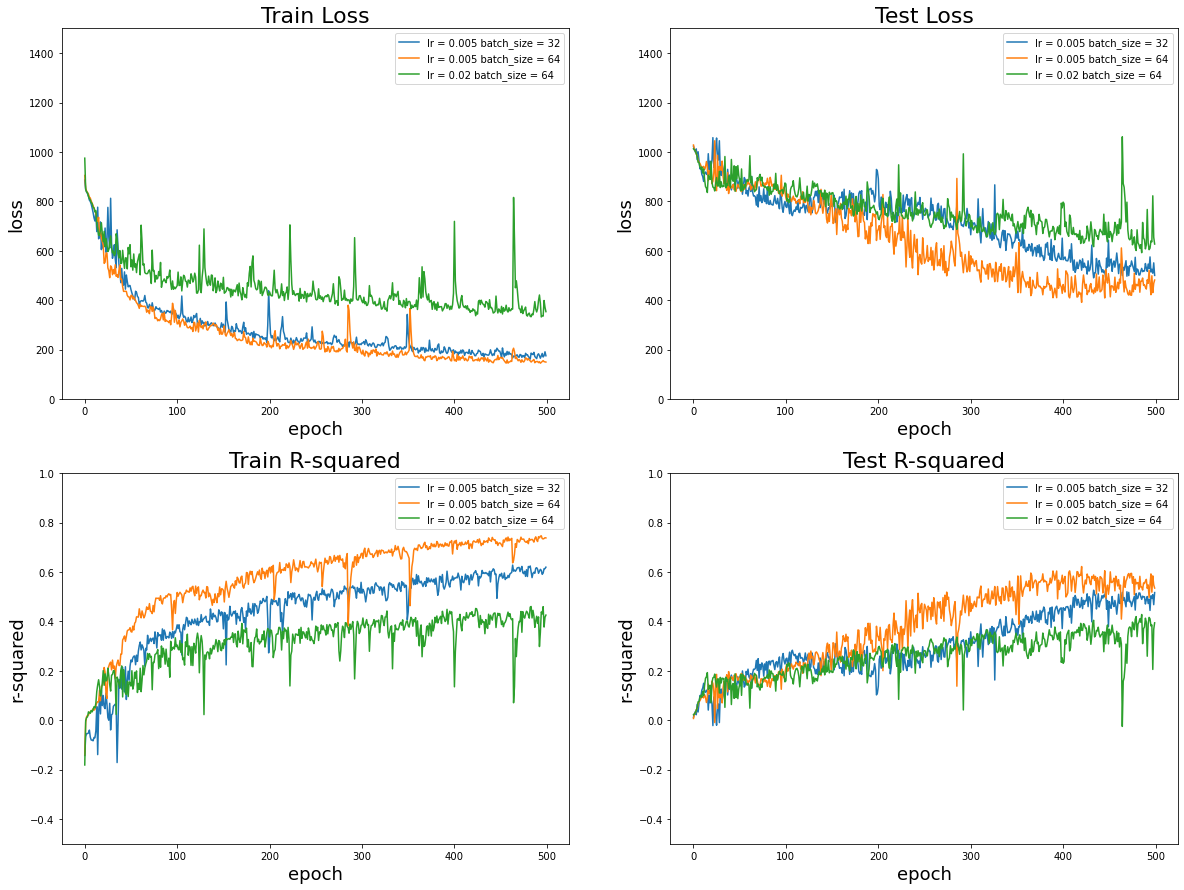

<Figure size 432x288 with 0 Axes>

In [24]:
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(20,15))
plt.figure()
ax1.set_title("Train Loss", fontsize=22)
ax1.plot(train_losses_all[0],label="lr = 0.005 batch_size = 32")
ax1.plot(train_losses_all[1],label="lr = 0.005 batch_size = 64")
ax1.plot(train_losses_all[2],label="lr = 0.02 batch_size = 64")
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 1500])

ax2.set_title("Test Loss", fontsize=22)
ax2.plot(test_losses_all[0],label="lr = 0.005 batch_size = 32")
ax2.plot(test_losses_all[1],label="lr = 0.005 batch_size = 64")
ax2.plot(test_losses_all[2],label="lr = 0.02 batch_size = 64")
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("loss", fontsize=18)
ax2.legend()
ax2.set_ylim([0, 1500])

ax3.set_title("Train R-squared", fontsize=22)
ax3.plot(train_accs_all[0],label="lr = 0.005 batch_size = 32")
ax3.plot(train_accs_all[1],label="lr = 0.005 batch_size = 64")
ax3.plot(train_accs_all[2],label="lr = 0.02 batch_size = 64")
ax3.set_xlabel("epoch", fontsize=18)
ax3.set_ylabel("r-squared", fontsize=18)
ax3.legend()
ax3.set_ylim([-0.5,1])

ax4.set_title("Test R-squared", fontsize=22)
ax4.plot(test_accs_all[0],label="lr = 0.005 batch_size = 32")
ax4.plot(test_accs_all[1],label="lr = 0.005 batch_size = 64")
ax4.plot(test_accs_all[2],label="lr = 0.02 batch_size = 64")
ax4.set_xlabel("epoch", fontsize=18)
ax4.set_ylabel("r-squared", fontsize=18)
ax4.legend()
ax4.set_ylim([-0.5,1])
plt.show()

### Model 1

{'batch_size': 32, 'epoch': 434, 'train_loss': 182.62927269935608, 'test_loss': 490.4766540527344, 'train_acc': 0.5939537169675148, 'test_acc': 0.5263426091879593}


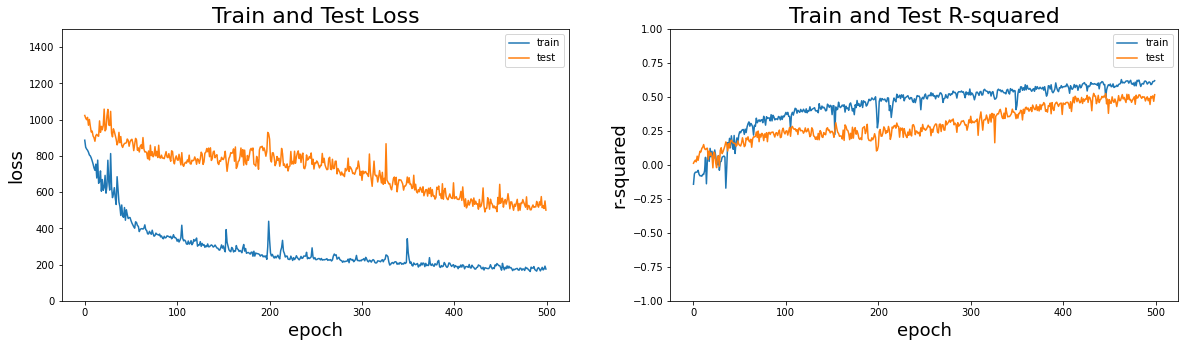

<Figure size 1440x360 with 0 Axes>

In [25]:
print(best_params_all[0])
figure, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5))
plt.figure(figsize=(20,5))
ax1.set_title("Train and Test Loss", fontsize=22)
ax1.plot(train_losses_all[0],label="train")
ax1.plot(test_losses_all[0],label="test")
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 1500])

ax2.set_title("Train and Test R-squared", fontsize=22)
ax2.plot(train_accs_all[0],label="train")
ax2.plot(test_accs_all[0],label="test")
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("r-squared", fontsize=18)
ax2.legend()
ax2.set_ylim([-1,1])

plt.show()

### Model 2

{'batch_size': 64, 'epoch': 421, 'train_loss': 155.26055916872892, 'test_loss': 391.2641906738281, 'train_acc': 0.7218447285871051, 'test_acc': 0.6221528768313829}


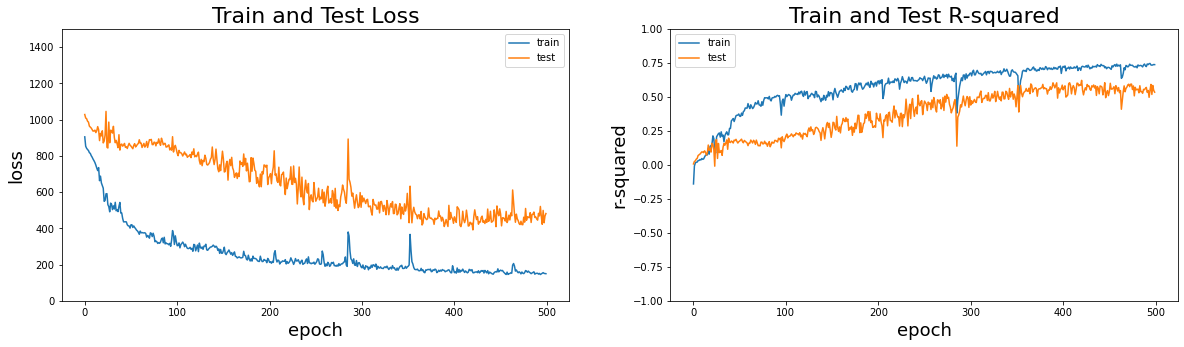

<Figure size 1440x360 with 0 Axes>

In [26]:
print(best_params_all[1])
figure, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5))
plt.figure(figsize=(20,5))
ax1.set_title("Train and Test Loss", fontsize=22)
ax1.plot(train_losses_all[1],label="train")
ax1.plot(test_losses_all[1],label="test")
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 1500])

ax2.set_title("Train and Test R-squared", fontsize=22)
ax2.plot(train_accs_all[1],label="train")
ax2.plot(test_accs_all[1],label="test")
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("r-squared", fontsize=18)
ax2.legend()
ax2.set_ylim([-1,1])

plt.show()

### Model 3

{'batch_size': 64, 'epoch': 486, 'train_loss': 340.83654316988856, 'test_loss': 592.3019409179688, 'train_acc': 0.444802301436091, 'test_acc': 0.42800903604768414}


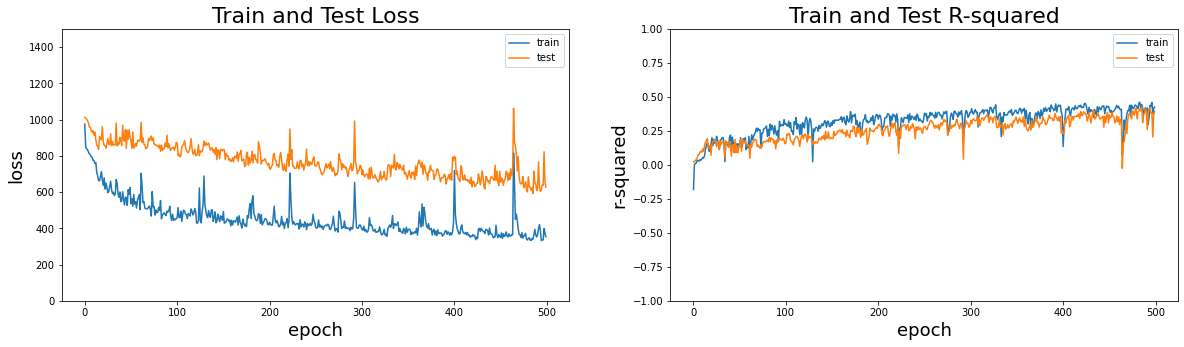

<Figure size 1440x360 with 0 Axes>

In [27]:
print(best_params_all[2])
figure, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5))
plt.figure(figsize=(20,5))
ax1.set_title("Train and Test Loss", fontsize=22)
ax1.plot(train_losses_all[2],label="train")
ax1.plot(test_losses_all[2],label="test")
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 1500])

ax2.set_title("Train and Test R-squared", fontsize=22)
ax2.plot(train_accs_all[2],label="train")
ax2.plot(test_accs_all[2],label="test")
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("r-squared", fontsize=18)
ax2.legend()
ax2.set_ylim([-1,1])

plt.show()

## 7. Results

In [29]:
model = GraphNeuralNetwork()
model.load_state_dict(torch.load('../../models/caco_graph_model_1.pt')) # best model
model.eval()

test_loader = GraphDataLoader(test_dataset, batch_size=704, shuffle=False)

with torch.no_grad():
    for data in tqdm(test_loader):
        x, edge_index, batch, y = data.x, data.edge_index, data.batch, data.y
        graph_predictions = model(x, edge_index, batch)

graph_predictions = np.array(graph_predictions)       

100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


In [30]:
print_evaluate(y_test, graph_predictions)

MAE: 9.655415279876102
MSE: 391.2642050091141
RMSE: 19.780399515912567
R2 Square 0.6221528768313829 

